In this notebook we will read output binary files from a montecarlo simulation of a SU(2) theory with an adjoint Higgs. The first cell is for definitions of functions for reading and storing into arrays the measurements of the spectroscopical operators with quantum number J_p = 1_minus, calcuating the correlators, and doing statistics on them, in order to obtain plottable results. There are 4 observable, one that we will call B, and other three, that we will call T_1,T_2 and T_3. There are 5 smearing levels, and 3 spatial directions. The operator B has a small momentum in the z direction: P_z= 2\pi/N_z. This first cell defines all the functions needed and some useful variables for reading.

In the below cell, we are gonna initialize the array needed for reading the files and storing the correlators.

And then we will calculate the correlator, for every measurement. The correlators are obtained as
C(t) = Sum_t' Sum_k O_k(t') O_k(t+t') We divide the transverse and the longitudinal part. The routine we define take as input a namefile, and then reads it, calculate the correlators and plot them. It also extracts the effective energy and plot it.

In [91]:
import numpy as np
import matplotlib.pyplot as plt
import pyhmc as phmc
import scipy.linalg as la

from scipy.optimize import curve_fit

import struct

Nt=16
w, h = 3, Nt
n_smear = 5
n_op = 4
n_meas = 3500


def corr_th(x, a,E):
    return a * np.cosh((x-Nt/2)*E) 

def readfile(B_,T1_,T2_,T3_,fn):
    b_l = w * 8
    ck = b_l*Nt*n_op
    Sm_ck = ck*n_smear
    with  open(fn,"rb" ) as f:
        fileContent =f.read()
        for n in range(n_meas):
            for ns in range(n_smear):
            #print(ns)
                for t in range(Nt):
                    B_[n][ns][t]=struct.unpack("d"*3, fileContent[(Sm_ck*n)+(ck*ns)+b_l*t:(Sm_ck*n)+(ck*ns)+(t+1)*b_l])
                    T1_[n][ns][t]=struct.unpack("d"*3, fileContent[(Sm_ck*n)+(ck*ns)+(b_l*Nt)+b_l*t:(Sm_ck*n)+(ck*ns)+(b_l*Nt)+(t+1)*b_l])
                    T2_[n][ns][t]=struct.unpack("d"*3, fileContent[(Sm_ck*n)+(ck*ns)+(b_l*Nt*2)+b_l*t:(Sm_ck*n)+(ck*ns)+(b_l*Nt*2)+(t+1)*b_l])
                    T3_[n][ns][t]=struct.unpack("d"*3, fileContent[(Sm_ck*n)+(ck*ns)+(b_l*Nt*3)+b_l*t:(Sm_ck*n)+(ck*ns)+(b_l*Nt*3)+(t+1)*b_l])
                    #print(B[n][ns][t])
def correlator(c,c_tr,c_par):

    for n in range(n_meas):
        for ns in range(n_smear):
            for t in range(Nt):
                for t_pr in range(Nt):
                    for k in range(2):
                        c[n][ns][t] += B[n][ns][t_pr][k]*B[n][ns][(t_pr+t)%Nt][k]
                        c_tr[n][ns][t] += B[n][ns][t_pr][k]*B[n][ns][(t_pr+t)%Nt][k]
                        #C1[n][ns][t] += T1[n][ns][t_pr][k]*T1[n][ns][(t_pr+t)%Nt][k]
                        #C2[n][ns][t] += T2[n][ns][t_pr][k]*T2[n][ns][(t_pr+t)%Nt][k]
                        #C3[n][ns][t] += T3[n][ns][t_pr][k]*T3[n][ns][(t_pr+t)%Nt][k]
                    c_par[n][ns][t] += B[n][ns][t_pr][2]*B[n][ns][(t_pr+t)%Nt][2]
                    c[n][ns][t] += B[n][ns][t_pr][2]*B[n][ns][(t_pr+t)%Nt][2]   

def cross_correlator(c_var):
    for n in range(n_meas):
        for i in range(n_smear):
            for j in range(n_smear):
                for t in range(Nt):
                    for t_pr in range(Nt):
                        for k in range(2):
                            c_var[n][i][j][t] += B[n][i][t_pr][k]*B[n][j][(t_pr+t)%Nt][k]

def corr_stat(c_res,c):
    c_res[0] = np.mean(c,axis =0 )
    c_res[1] = np.std(c,axis =0 )
    c_res[2] = [[0 for t in range(Nt)]for sm in range(n_smear) ]     
    for ns in range(n_smear):
        for t in range(Nt):
            vec = []
            for n in range(n_meas):
                vec.append(float(c[n][i][j][t]))
            c_res[2][ns][t] = phmc.integrated_autocorr6(np.array(vec),6)
            #c_res[2][ns][t] =1
            #print(C_res[2][ns][t])
            c_res[1][ns][t] = c_res[1][ns][t]* np.sqrt(c_res[2][ns][t]/n_meas)       
            
def cross_corr_stat(c_res,c):
    c_res[0] = np.mean(c,axis =0 )
    #print(c_res[0][0][0])
    c_res[1] = np.std(c,axis =0 )
    c_res[2] = [[[0 for t in range(Nt)]for i in range(n_smear) ]for j in range(n_smear)  ]
    for i in range(n_smear):
        for j in range(n_smear):
            for t in range(Nt):
                vec = []
                for n in range(n_meas):
                    vec.append(float(c[n][i][j][t]))
                c_res[2][i][j][t] = phmc.integrated_autocorr6(np.array(vec),6)
                #c_res[2][ns][t] =1
                #print(C_res[2][ns][t])
                c_res[1][i][j][t] = c_res[1][i][j][t]* np.sqrt(c_res[2][i][j][t]/n_meas)    
                

def variational_analysis(eigen, eigen_err,c_var):
    #eigen = [0 for t in range(Nt)]
    #eigen_err = [0 for t in range(Nt)]
    c_mat = [[0 for i in range(n_smear) ]for j in range(n_smear) ]
    c_mat_err = [[0 for i in range(n_smear) ]for j in range(n_smear) ]
    for t in range(Nt):
        for i in range(n_smear):
            for j in range(n_smear):
                c_mat[i][j] = c_var[0][i][j][t]
                c_mat_err[i][j] = c_var[1][i][j][t]
        v,w = la.eig(c_mat)
        n,l = la.eig(c_mat_err)
        #v,w = LA.eig[c_mat]
        eigen[t] = v.real
        eigen_err[t] = n.real
        #print(t,'Eigenvalues: ',eigen[t], 'Errors: ',eigen_err[t])
    #print(eigen)

def plot_tr(kappa):

    T = list(range(Nt))
    Tf= list(range(1,Nt))
    C_tr_avg = list(range(Nt))
    C_tr_err = list(range(Nt))
    C_f_avg = list(range(1,Nt))
    C_f_err = list(range(1,Nt))

    plt.rc('text', usetex=True)
    plt.rc('font', family='serif')

    for ns in range(n_smear):
        for t in range(Nt):
            C_tr_avg[t] = C_res[0][ns][t]
            C_tr_err[t] = C_res[1][ns][t]
        #for t in range(1,Nt):
        #    C_f_avg[t] = C_par_res[0][ns][t]
        #    C_f_err[t] = C_par_res[1][ns][t]
        print("Transverse correlator")
        #print(C_tr_avg)
        #print(C_tr_err)
        
        xdata = np.linspace(0,Nt-1,50)
        
        #popt, pcov = curve_fit(corr_th, Tf, C_f_avg,sigma = C_f_err, absolute_sigma = True)
        #print(popt)
        
        plt.figure(num=None, figsize=(8, 6), dpi=160, facecolor='w', edgecolor='k')
        plt.errorbar(T,C_tr_avg,C_tr_err,fmt='o',label = 'data')
        #plt.plot(xdata, corr_th(xdata, *popt),'r',label=r'fit ')
        plt.xlabel('t')
        plt.ylabel(r'$C_\perp(t)$')
        plt.xlim([0.5,8.5])
        #plt.ylim([0,0.5])
        plt.yscale("log")
        plt.title(r"B Transverse Correlator at smearing level %d, L= %d ($\beta=4, \kappa=%f, \lambda=1 $)" % (ns,Nt,kappa))
        plt.savefig("O1minus/Tr_corr/B_transverse_L%d_k%f_sm%d.jpg" % (Nt,kappa,ns))
        

def plot_var(kappa):

    T = list(range(Nt))
    Tf= list(range(1,Nt))
    C_tr_avg = list(range(Nt))
    C_tr_err = list(range(Nt))
   # C_f_avg = list(range(1,Nt))
   # C_f_err = list(range(1,Nt))

    plt.rc('text', usetex=True)
    plt.rc('font', family='serif')

    for ns in range(n_smear):
        for t in range(Nt):
            C_tr_avg[t] = float(Eigen[t][ns])
            C_tr_err[t] = float(Eigen_err[t][ns])
        #print("Transverse correlator")
            print(C_tr_avg[t])
            print(Eigen[t][ns])
            print(C_tr_err[t])
            print(Eigen_err[t][ns])
        #xdata = np.linspace(0,Nt-1,50)
        
        #popt, pcov = curve_fit(corr_th, Tf, C_f_avg,sigma = C_f_err, absolute_sigma = True)
        #print(popt)
        
        plt.figure(num=None, figsize=(8, 6), dpi=160, facecolor='w', edgecolor='k')
        plt.errorbar(T,C_tr_avg,C_tr_err,fmt='o',label = 'data')
        #plt.plot(xdata, corr_th(xdata, *popt),'r',label=r'fit ')
        plt.xlabel('t')
        plt.ylabel(r'$C_\perp(t)$')
        plt.xlim([0.5,8.5])
        #plt.ylim([0,0.5])
        plt.yscale("log")
        plt.title(r"B Transverse Correlator at smearing level %d, L= %d ($\beta=4, \kappa=%f, \lambda=1 $)" % (ns,Nt,kappa))
        #plt.savefig("O1minus/Tr_corr/B_transverse_L%d_k%f_sm%d.jpg" % (Nt,kappa,ns))
        plt.show()        
        
def plot_long(kappa):
    T = list(range(Nt))
    C_par_avg = list(range(Nt))
    C_par_err = list(range(Nt))

    for ns in range(1):
        for t in range(Nt):
            C_par_avg[t] = C_par_res[0][ns][t]
            C_par_err[t] = C_par_res[1][ns][t]

    
        #print(C_par_avg)
    
        plt.figure(num=None, figsize=(8, 6), dpi=160, facecolor='w', edgecolor='k')
        plt.errorbar(T,C_par_avg,C_par_err,fmt='o',label = 'data')
        #plt.yscale("log")
        plt.xlabel('t/a')
        plt.ylabel(r'$C_\|(t)$')
        plt.xlim([0.5,8.5])
        plt.ylim([-0.02,0.02])
        plt.title(r"B Longitudinal Correlator at smearing level %d,L=%d ($\beta=4, \kappa=%f, \lambda=1 $)" % (ns,Nt,kappa))
        plt.savefig("O1minus/Par_corr/B_parallel_L%d_k%f.jpg"% (Nt,kappa))    
    
    print("Parallel correlator")
    print(C_par_avg)
    print(C_par_err)
def plot_total(kappa):
    T = list(range(Nt))
    C_avg = list(range(Nt))
    C_err = list(range(Nt))

    for ns in range(1):
        for t in range(Nt):
            C_avg[t] = C_res[0][ns][t]
            C_err[t] = C_res[1][ns][t]
    
        #print(C_avg)
    
        plt.figure(num=None, figsize=(8, 6), dpi=160, facecolor='w', edgecolor='k')
        plt.errorbar(T,C_avg,C_err,fmt='o',label = 'data')
        #plt.yscale("log")
        plt.xlabel('t/a')
        plt.ylabel(r'$ C(t)$')
        #plt.xlim([0.5,8.5])
        #plt.ylim([0,0.5])
        plt.title(r"B Total Correlator at smearing level %d,L=%d ($\beta=4, \kappa=%f, \lambda=1 $)" % (ns,Nt,kap))
        plt.savefig("O1minus/Total_corr/B_total_L%d_k%f.jpg"% (Nt,kap))
        
def plot_energy(kappa):
    Tm = list(range(Nt-1))
    E = list(range(Nt-1))
    E_unc = list(range(Nt-1))
    C_tr_avg = list(range(Nt))
    C_tr_err = list(range(Nt))

    E_p= list(range(Nt-1))
    E_c = 2*np.pi/Nt
    E_l= np.arccosh(2-np.cos(2*np.pi/Nt))
    #print(E_l)
    x = np.arange(Nt-1)
    for t in range(Nt-1):
        E_p[t]=np.log(np.cosh(E_l*(t-Nt/2))/np.cosh(E_l*(t+1-Nt/2)))
        
    for ns in range(n_smear):
        for t in range(Nt):
            C_tr_avg[t] = C_res[0][ns][t]
            C_tr_err[t] = C_res[1][ns][t]    
        for t in range(Nt-1):
            Tm[t] = t +0.5
            E[t] = np.log(C_tr_avg[t]/C_tr_avg[t+1])
            E_unc[t] = np.sqrt( (C_tr_err[t]/C_tr_avg[t])**2 + (C_tr_err[t+1]/C_tr_avg[t+1])**2 )

        
        plt.figure(num=None, figsize=(8, 6), dpi=160, facecolor='w', edgecolor='k')
        plt.errorbar(Tm, E,E_unc,fmt='o',label='data')
        plt.plot(x+0.5,E_p,'-r',label=r'$E_{th}$')
        plt.xlabel("t/a")
        plt.ylabel("a E(t)")
        #plt.yscale("log")
        plt.legend()
        plt.xlim([1,9])
        #plt.ylim([-0.5,1.0])
        plt.title(r"Effective energy at smearing level %d, L=%d ($\beta=4, \kappa=%f, \lambda=1 $)" % (ns,Nt,kappa))
        #plt.savefig('O1minus/Energy/effective_energy_L%d_k%f_sm%d.jpg'% (Nt,kappa,ns))
    
    #print(E)
    #print(E_unc)

def plot_energy_var(kappa):
    Tm = list(range(Nt-1))
    E = list(range(Nt-1))
    E_unc = list(range(Nt-1))
    C_tr_avg = list(range(Nt))
    C_tr_err = list(range(Nt))

    E_p= list(range(Nt-1))
    E_c = 2*np.pi/Nt
    E_l= np.arccosh(2-np.cos(2*np.pi/Nt))
    #print(E_l)
    x = np.arange(Nt-1)
    for t in range(Nt-1):
        E_p[t]=np.log(np.cosh(E_l*(t-Nt/2))/np.cosh(E_l*(t+1-Nt/2)))
        
    for ns in range(n_smear):
        for t in range(Nt):
            C_tr_avg[t] = float(Eigen[t][ns])
            C_tr_err[t] = float(Eigen_err[t][ns])  
        for t in range(Nt-1):
            Tm[t] = t +0.5
            E[t] = np.log(C_tr_avg[t]/C_tr_avg[t+1])
            E_unc[t] = np.sqrt( (C_tr_err[t]/C_tr_avg[t])**2 + (C_tr_err[t+1]/C_tr_avg[t+1])**2 )

        
        plt.figure(num=None, figsize=(8, 6), dpi=160, facecolor='w', edgecolor='k')
        plt.errorbar(Tm, E,E_unc,fmt='o',label='data')
        plt.plot(x+0.5,E_p,'-r',label=r'$E_{th}$')
        plt.xlabel("t/a")
        plt.ylabel("a E(t)")
        #plt.yscale("log")
        plt.legend()
        plt.xlim([1,9])
        #plt.ylim([-0.5,1.0])
        plt.title(r"Effective energy at smearing level %d, L=%d ($\beta=4, \kappa=%f, \lambda=1 $)" % (ns,Nt,kappa))
        #plt.savefig('O1minus/Energy/effective_energy_L%d_k%f_sm%d.jpg'% (Nt,kappa,ns))
    
def plot_mass():
    Tm = list(range(Nt-1))
    m = list(range(Nt-1))
    m_unc = list(range(Nt-1))

    for ns in range(1):
        for t in range(Nt-1):
            Tm[t] = t +0.5
            m[t] = np.log(C_par_avg[t]/C_par_avg[t+1])
            m_unc[t] = np.sqrt( (C_par_err[t]/C_par_avg[t])**2 + (C_par_err[t+1]/C_par_avg[t+1])**2 )

        
        plt.figure(num=None, figsize=(8, 6), dpi=160, facecolor='w', edgecolor='k')
        plt.errorbar(Tm, m,m_unc,fmt='o',label='data')
        #plt.plot(x+0.5,E_p,'-r',label=r'$E_{th}=\pi/4$')
        plt.xlabel("t")
        plt.ylabel("m(t)")
        #plt.yscale("log")
        plt.legend()
        plt.title("Effective mass at smearing level %d" % (ns))
    #plt.savefig('effective_mass_LS.jpg')
    
    #print(m)
    #print(m_unc)
    
B = [[[[0 for x in range(w)] for y in range(h)]for z in range(n_smear) ] for n in range(n_meas) ]
T1 = [[[[0 for x in range(w)] for y in range(h)]for z in range(n_smear) ]for n in range(n_meas) ]
T2 = [[[[0 for x in range(w)] for y in range(h)]for z in range(n_smear) ] for n in range(n_meas) ]
T3 = [[[[0 for x in range(w)] for y in range(h)]for z in range(n_smear) ] for n in range(n_meas)]

C = [[[0 for y in range(h)]for z in range(n_smear) ] for n in range(n_meas) ]
C_tr = [[[0 for y in range(h)]for z in range(n_smear) ] for n in range(n_meas) ]
C_par = [[[0 for y in range(h)]for z in range(n_smear) ] for n in range(n_meas) ]
C_var= [[[[0 for y in range(h)]for i in range(n_smear) ]for j in range(n_smear) ] for n in range(n_meas) ]

C_var_res = [[[0 for j in range(n_smear) ]for i in range(n_smear) ] for y in range (3) ]
Eigen = [[0 for i in range(n_smear)] for t in range(Nt)]
Eigen_err = [[0 for i in range(n_smear)] for t in range(Nt)]


C_res = [0 for y in range(3)]
C_tr_res = [0 for y in range(3)]
C_par_res = [0 for y in range(3)]    

def analysis_plot(kappa):
    filename = "O1minus_output_files/output_Nt%d_Nx%d_Ny%d_Nz%d_B4.000000_K%f_L1.000000.bin" % (Nt,Nt,Nt,Nt,kappa)
    readfile(B,T1,T2,T3,filename)                 
    correlator(C,C_tr,C_par)      
    corr_stat(C_res,C)
    corr_stat(C_par_res,C_par)
    corr_stat(C_tr_res,C_tr)
    plot_tr(kappa)
    plot_long(kappa)
    plot_total(kappa)
    plot_energy(kappa)
    #plot_mass()
#print(C[100])

def var_analysis_plot(kappa):
    filename = "O1minus_output_files/output_Nt%d_Nx%d_Ny%d_Nz%d_B4.000000_K%f_L1.000000.bin" % (Nt,Nt,Nt,Nt,kappa)
    readfile(B,T1,T2,T3,filename)                 
    cross_correlator(C_var)      
    cross_corr_stat(C_var_res,C_var)
    variational_analysis(Eigen,Eigen_err,C_var_res)
    print(Eigen)
    plot_var(kappa)
    plot_energy_var(kappa)

Now we will do statistical analysis to the correlators. We will obtain averages and error for the correlators, calculating autocorrelation as well.

Transverse correlator
[10.34273851732238, 0.255862304887695, 0.013015661534815507, -0.0030322593186563798, -0.05687530811895973, -0.02141642024113313, 0.025241584352800873, -0.019857888770581842, 0.0869606429936945, -0.01985788877058184, 0.025241584352800897, -0.021416420241133112, -0.056875308118959716, -0.003032259318656412, 0.013015661534815499, 0.25586230488769507]
[0.16664389770015536, 0.05519323708228507, 0.05907688593993981, 0.05702838065385958, 0.05753501957190778, 0.06224159720382528, 0.05703585090375313, 0.05961602290541093, 0.09082905050700797, 0.05961602290541092, 0.05703585090375315, 0.06224159720382528, 0.05753501957190778, 0.05702838065385958, 0.059076885939939795, 0.05519323708228507]
Transverse correlator
[6.125339256020713, 0.3875014347351524, 0.018876812134504463, -0.009040655794786391, -0.007645413080999826, -0.016990304218741818, 0.054944676496579664, 0.04366911202474599, 0.05248419661842204, 0.043669112024746014, 0.054944676496579664, -0.01699030421874181, -0.0076

/home/vincenzo/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:209: RuntimeWarning: invalid value encountered in log
/home/vincenzo/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:209: RuntimeWarning: invalid value encountered in log


Transverse correlator
[12.90527704708359, 0.32031116679818544, 0.0159763929558477, -0.0048155364042101675, -0.07619736632681824, -0.03720567756917282, 0.02304594306643961, -0.02542147393840401, 0.10962167994602233, -0.02542147393840407, 0.023045943066439572, -0.03720567756917279, -0.0761973663268183, -0.004815536404210154, 0.015976392955847667, 0.32031116679818544]
[0.17381230989264118, 0.06362961317605673, 0.0671650344118122, 0.06502860659610368, 0.06644513321448825, 0.07181619972632525, 0.06462727478166394, 0.06749196190534426, 0.10482022540897158, 0.06749196190534426, 0.06462727478166395, 0.07181619972632523, 0.06644513321448822, 0.0650286065961037, 0.06716503441181217, 0.06362961317605673]
Transverse correlator
[7.6323573639719875, 0.48489393530860486, 0.030492330562147514, -0.013656303572053477, -0.005012406622891222, -0.03121641303674728, 0.06944823729510992, 0.05092366239699551, 0.06640956469910246, 0.05092366239699551, 0.06944823729510989, -0.031216413036747253, -0.005012406622

/home/vincenzo/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:209: RuntimeWarning: invalid value encountered in log
/home/vincenzo/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:209: RuntimeWarning: invalid value encountered in log
/home/vincenzo/anaconda3/lib/python3.7/site-packages/matplotlib/pyplot.py:514: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)
/home/vincenzo/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:209: RuntimeWarning: invalid value encountered in log
/home/vincenzo/anaconda3/lib/python3.7/site-packages/matplotlib/pyplot.py:514: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until ex

Transverse correlator
[15.473579712430158, 0.3792714454483281, 0.02057055011619355, 0.006014111040814596, -0.07190465637648644, -0.0423864500855861, 0.026481969898710905, -0.0039679272133917864, 0.11691518584745757, -0.003967927213391796, 0.02648196989871093, -0.04238645008558615, -0.0719046563764864, 0.006014111040814622, 0.020570550116193537, 0.37927144544832814]
[0.17012677472778023, 0.0672194337399023, 0.07020757020979324, 0.06888840753082029, 0.0704678600962377, 0.0743745777056484, 0.06808444483471271, 0.07138789983342567, 0.10971226925375663, 0.07138789983342568, 0.06808444483471271, 0.07437457770564838, 0.07046786009623773, 0.06888840753082028, 0.07020757020979325, 0.0672194337399023]


/home/vincenzo/anaconda3/lib/python3.7/site-packages/matplotlib/pyplot.py:514: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


Transverse correlator
[9.152138896608687, 0.5762777266997442, 0.04612741075837303, -0.01255147670762512, -0.00724166438702118, -0.030549796860444785, 0.06640583236945292, 0.057146784412761, 0.07135842188928894, 0.05714678441276097, 0.06640583236945292, -0.030549796860444803, -0.007241664387021209, -0.012551476707625108, 0.046127410758373046, 0.5762777266997442]
[0.12482965253419245, 0.038614342363758845, 0.040860738926757706, 0.042989732603158706, 0.04116798271948333, 0.03870822978749919, 0.03943658499029235, 0.03969555936696425, 0.057017751855692626, 0.03969555936696425, 0.03943658499029236, 0.03870822978749919, 0.04116798271948333, 0.042989732603158706, 0.04086073892675771, 0.038614342363758845]


/home/vincenzo/anaconda3/lib/python3.7/site-packages/matplotlib/pyplot.py:514: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


Transverse correlator
[7.7926838011671835, 0.713270727090127, 0.0742353162486391, 0.004792329484892041, -0.024542681720991725, -0.0378603879228867, 0.05054884503482641, 0.04546811242225237, 0.03982965737221493, 0.04546811242225235, 0.05054884503482639, -0.037860387922886665, -0.024542681720991697, 0.004792329484892035, 0.0742353162486391, 0.713270727090127]
[0.10134669845251278, 0.035404649271720844, 0.033963660243413886, 0.038433604325365925, 0.03752467723430826, 0.03436717466795715, 0.03445976954534488, 0.03313344393701995, 0.05106838496555016, 0.03313344393701995, 0.034459769545344875, 0.034367174667957155, 0.03752467723430826, 0.038433604325365925, 0.033963660243413886, 0.035404649271720844]


/home/vincenzo/anaconda3/lib/python3.7/site-packages/matplotlib/pyplot.py:514: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


Transverse correlator
[7.058259959446254, 0.8000238176835001, 0.10120870176248331, 0.0038803866077627425, -0.02706917842032628, -0.026314717407322438, 0.031160401687174006, 0.029498246626280557, 0.02157828768813189, 0.029498246626280547, 0.031160401687174006, -0.02631471740732248, -0.027069178420326266, 0.004031068014338285, 0.1012403562202596, 0.7999708039741896]
[0.08582230300244027, 0.03436952792306537, 0.031474881125339374, 0.034130863656569865, 0.033772254521199085, 0.030695263001878914, 0.031088816607539243, 0.03109562785094161, 0.04698379252965547, 0.031095627850941606, 0.03108881660753924, 0.030695263001878907, 0.03377225452119908, 0.03413725558119746, 0.03148003075578787, 0.0343591544202048]


/home/vincenzo/anaconda3/lib/python3.7/site-packages/matplotlib/pyplot.py:514: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


Transverse correlator
[6.472931547855352, 0.8316526475683317, 0.11841758758692424, 0.008099383379558447, -0.029329884524980178, -0.01924177825285411, 0.011890947180198619, 0.01176791987802686, 0.008914093543226212, 0.011767919878026847, 0.011890947180198633, -0.0192417782528541, -0.029329884524980178, 0.008099383379558445, 0.1184175875869243, 0.8316526475683319]
[0.07605464563402882, 0.03225970578125608, 0.028795654761288546, 0.030382237753636996, 0.030296088006917354, 0.027952156033607005, 0.028179328634980908, 0.029541642953131508, 0.042263664719394536, 0.029541642953131497, 0.028179328634980908, 0.02795215603360699, 0.030296088006917354, 0.030382237753637, 0.028795654761288546, 0.03225970578125608]


/home/vincenzo/anaconda3/lib/python3.7/site-packages/matplotlib/pyplot.py:514: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)
/home/vincenzo/anaconda3/lib/python3.7/site-packages/matplotlib/pyplot.py:514: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


Parallel correlator
[5.134878722079686, 0.12691282789020106, -0.0020169250769888256, 0.025353701391170953, -0.03047676350719277, -0.004050915005530293, 0.011295849741589823, 0.007839601947674319, 0.007880018952423594, 0.007839601947674331, 0.011295849741589833, -0.0040509150055303075, -0.03047676350719275, 0.02535370139117096, -0.0020169250769887983, 0.12691282789020117]
[0.06961817965523605, 0.03974924504183552, 0.03892686109450937, 0.03993911726774158, 0.04162210207617336, 0.0390698233597329, 0.03737301090784324, 0.039872035958892174, 0.05801369030749357, 0.039872035958892174, 0.03737301090784324, 0.03906982335973291, 0.04162210207617337, 0.03993911726774158, 0.03892686109450937, 0.03974924504183552]


/home/vincenzo/anaconda3/lib/python3.7/site-packages/matplotlib/pyplot.py:514: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)
/home/vincenzo/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:209: RuntimeWarning: invalid value encountered in log
/home/vincenzo/anaconda3/lib/python3.7/site-packages/matplotlib/pyplot.py:514: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)
/home/vincenzo/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:209: RuntimeWarning: invalid

Transverse correlator
[18.007616791862105, 0.440447423663164, 0.02813178615996482, 0.03678670332254575, -0.06026424337151664, -0.045049996860429785, 0.028311552496730223, -0.00848117897124476, 0.13024780871520542, -0.008481178971244827, 0.02831155249673023, -0.045049996860429736, -0.060264243371516625, 0.03678670332254576, 0.028131786159964797, 0.44044742366316375]
[0.1756767394799267, 0.07111784842068039, 0.07383300135084456, 0.07348461380888023, 0.07473064749590339, 0.07652485197797328, 0.07166128733532012, 0.07484832534945081, 0.11463795881514309, 0.07484832534945081, 0.07166128733532012, 0.07652485197797329, 0.07473064749590339, 0.07348461380888024, 0.07383300135084456, 0.0711178484206804]


/home/vincenzo/anaconda3/lib/python3.7/site-packages/matplotlib/pyplot.py:514: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


Transverse correlator
[10.66764045540485, 0.6802731685782202, 0.062179854464403196, -0.0013509428589591962, 0.000851624937831023, -0.03186691255032295, 0.06530672695513076, 0.057648734244835506, 0.07736425991859268, 0.0576487342448355, 0.06530672695513075, -0.03186691255032297, 0.0008516249378310238, -0.001350942858959196, 0.06217985446440316, 0.6802731685782202]
[0.1242615843001821, 0.03965524962676623, 0.04252580083715796, 0.04708601514624544, 0.041177221196395844, 0.04060122134044452, 0.040373517087473304, 0.041143787922529054, 0.05820619771543993, 0.041143787922529054, 0.04037351708747331, 0.04060122134044453, 0.04117722119639586, 0.04708601514624545, 0.04252580083715797, 0.03965524962676623]


/home/vincenzo/anaconda3/lib/python3.7/site-packages/matplotlib/pyplot.py:514: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


Transverse correlator
[9.086052366442239, 0.8518152482717133, 0.09883293439259769, 0.01899132052641427, -0.018783551697432975, -0.04046893933223122, 0.046470601770331785, 0.049425577316528496, 0.044278008752799136, 0.04942557731652848, 0.04647060177033177, -0.04046893933223119, -0.018783551697433, 0.018991320526414227, 0.09883293439259767, 0.8518152482717134]
[0.1010054942748741, 0.035614957532170866, 0.0358470624642584, 0.0407184063799478, 0.0379395765452405, 0.03557657639173298, 0.035687862773876346, 0.03403373285279694, 0.05107456782953273, 0.03403373285279695, 0.03568786277387635, 0.03557657639173297, 0.0379395765452405, 0.0407184063799478, 0.035847062464258395, 0.03561495753217087]


/home/vincenzo/anaconda3/lib/python3.7/site-packages/matplotlib/pyplot.py:514: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


Transverse correlator
[8.230563993670229, 0.9586001380976639, 0.13250769593587833, 0.0145579952485936, -0.022931327704150104, -0.028638982971987133, 0.02661645570336036, 0.030259123323947427, 0.025579391108682775, 0.030259123323947444, 0.026616455703360357, -0.028638982971987123, -0.022931327704150115, 0.014708676655169166, 0.1325393503936547, 0.9585471243883535]
[0.08427714972494871, 0.034632344302654994, 0.03286122656264598, 0.03544647408702718, 0.03464290654578923, 0.031212839753482057, 0.03268288725481584, 0.03183023883945979, 0.04737077825428816, 0.03183023883945979, 0.032682887254815836, 0.031212839753482057, 0.034642906545789234, 0.03544893272549047, 0.03286500076781377, 0.03462413294302951]


/home/vincenzo/anaconda3/lib/python3.7/site-packages/matplotlib/pyplot.py:514: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


Transverse correlator
[7.551713476207254, 0.9998199536962146, 0.15376834437975107, 0.017986662286674258, -0.026263872173996002, -0.021013763960774187, 0.007422622161604535, 0.010477499936028154, 0.011419981053966995, 0.010477499936028159, 0.007422622161604543, -0.021013763960774173, -0.02626387217399602, 0.017986662286674268, 0.1537683443797511, 0.9998199536962146]
[0.0749410403321912, 0.03251195981398889, 0.029824841725220003, 0.031376048534441765, 0.03101808374847545, 0.02803771410950448, 0.02956966757422072, 0.030159692990649203, 0.041832505556001716, 0.03015969299064921, 0.029569667574220724, 0.02803771410950448, 0.03101808374847545, 0.031376048534441765, 0.029824841725220003, 0.0325119598139889]


/home/vincenzo/anaconda3/lib/python3.7/site-packages/matplotlib/pyplot.py:514: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)
/home/vincenzo/anaconda3/lib/python3.7/site-packages/matplotlib/pyplot.py:514: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


Parallel correlator
[5.977324675338961, 0.158004300476736, -0.003172945021760738, 0.037118738537337194, -0.03161122401052605, -0.013706541924225392, 0.006625899669861612, 0.009336094454416815, 0.00839999588216115, 0.00933609445441682, 0.00662589966986163, -0.013706541924225407, -0.031611224010526066, 0.03711873853733718, -0.0031729450217607277, 0.15800430047673594]
[0.0740953248306956, 0.04121234064723876, 0.040994973888683874, 0.042189120703172794, 0.04375431651734034, 0.040564193991037854, 0.03956587854311568, 0.04197244462983123, 0.061728391178708264, 0.04197244462983125, 0.039565878543115676, 0.040564193991037854, 0.04375431651734034, 0.042189120703172794, 0.04099497388868388, 0.04121234064723876]


/home/vincenzo/anaconda3/lib/python3.7/site-packages/matplotlib/pyplot.py:514: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)
/home/vincenzo/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:209: RuntimeWarning: invalid value encountered in log
/home/vincenzo/anaconda3/lib/python3.7/site-packages/matplotlib/pyplot.py:514: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)
/home/vincenzo/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:209: RuntimeWarning: invalid

Transverse correlator
[20.56210627553691, 0.49859541830867354, 0.03664255662159224, 0.058970773572457266, -0.04808992566956692, -0.041675973395774606, 0.034529555816155355, 0.00535805552321862, 0.14361309779232034, 0.005358055523218571, 0.03452955581615534, -0.041675973395774585, -0.04808992566956689, 0.058970773572457225, 0.03664255662159222, 0.4985954183086735]
[0.17712311972604292, 0.07637597842004303, 0.07596259636352004, 0.0754315014860576, 0.07942432890663315, 0.08170111549933365, 0.07464025949708103, 0.07791300077923431, 0.118170850307997, 0.07791300077923431, 0.07464025949708103, 0.08170111549933365, 0.07942432890663313, 0.0754315014860576, 0.07596259636352005, 0.07637597842004304]


/home/vincenzo/anaconda3/lib/python3.7/site-packages/matplotlib/pyplot.py:514: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


Transverse correlator
[12.189896516474008, 0.8121386632137247, 0.08491806598862434, -0.006935516550868587, -0.0050122401903200395, -0.02684801513040103, 0.06532357964686003, 0.06665781197544018, 0.08108393703019882, 0.06665781197544018, 0.06532357964685997, -0.026848015130401023, -0.005012240190320061, -0.006935516550868567, 0.08491806598862428, 0.8121386632137249]
[0.12237503816513869, 0.041543776465905936, 0.04423055472737506, 0.04770149012514369, 0.042690481556145805, 0.04147409552421595, 0.0417897754165761, 0.043158402896594186, 0.06035221340418315, 0.04315840289659419, 0.0417897754165761, 0.04147409552421596, 0.042690481556145805, 0.04770149012514369, 0.04423055472737506, 0.04154377646590594]


/home/vincenzo/anaconda3/lib/python3.7/site-packages/matplotlib/pyplot.py:514: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


Transverse correlator
[10.39290505182222, 1.0193849732853535, 0.12626903124341912, 0.019610189852620464, -0.02365943547464215, -0.035086775342915, 0.0459784578521977, 0.05513158290328699, 0.05322549178490826, 0.055131582903287006, 0.04597845785219774, -0.035086775342914954, -0.023659435474642155, 0.019610189852620485, 0.12626903124341912, 1.0193849732853535]
[0.0949875436656739, 0.03810788168722469, 0.03763963416215868, 0.04145424851412381, 0.038002427653782575, 0.03705241067856543, 0.0370073136764196, 0.035469498415873664, 0.05465626739846186, 0.03546949841587367, 0.03700731367641961, 0.03705241067856543, 0.038002427653782575, 0.0414542485141238, 0.03763963416215867, 0.03810788168722468]


/home/vincenzo/anaconda3/lib/python3.7/site-packages/matplotlib/pyplot.py:514: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


Transverse correlator
[9.415964655935339, 1.1437249552166198, 0.16720485824373743, 0.017082327610086486, -0.02491092537876285, -0.02592603530053326, 0.024466879265353195, 0.035953158415747116, 0.03417339824524772, 0.03595315841574717, 0.024466879265353195, -0.02592603530053322, -0.02491092537876289, 0.017233009016662037, 0.16723651270151382, 1.143671941507309]
[0.0767406680572986, 0.035910538433099104, 0.03405463069534062, 0.03628000499940095, 0.03495768948750902, 0.03252192517328853, 0.03419088054671696, 0.03271801296088417, 0.04953156288946644, 0.032718012960884175, 0.03419088054671696, 0.03252192517328853, 0.03495768948750902, 0.036285976233306975, 0.034058440597217694, 0.03590262878255351]


/home/vincenzo/anaconda3/lib/python3.7/site-packages/matplotlib/pyplot.py:514: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


Transverse correlator
[8.640107217874009, 1.1926019696984946, 0.19207519696971384, 0.02316121526867205, -0.026251295631923226, -0.020096109457013348, 0.003300478395848483, 0.017042457904306765, 0.018188435149176865, 0.017042457904306776, 0.0033004783958484694, -0.02009610945701331, -0.02625129563192321, 0.023161215268672073, 0.19207519696971376, 1.1926019696984946]
[0.07006147335065026, 0.033205865040845196, 0.030770987539712233, 0.03230885405801422, 0.03175818700050352, 0.02936066498980236, 0.0311667536905957, 0.03100699816215246, 0.04514582708815421, 0.03100699816215246, 0.0311667536905957, 0.029360664989802356, 0.03175818700050352, 0.03230885405801422, 0.030770987539712233, 0.0332058650408452]


/home/vincenzo/anaconda3/lib/python3.7/site-packages/matplotlib/pyplot.py:514: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)
/home/vincenzo/anaconda3/lib/python3.7/site-packages/matplotlib/pyplot.py:514: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


Parallel correlator
[6.82810160484522, 0.1651602719051997, 0.002746282607678764, 0.042759330950604274, -0.023573351482201906, -0.007407533087942622, 0.0054344590768592525, 0.006320312346030381, 0.013452955913973707, 0.006320312346030385, 0.00543445907685925, -0.0074075330879426315, -0.0235733514822019, 0.042759330950604295, 0.002746282607678775, 0.16516027190519963]
[0.07562351394927512, 0.043906513017603205, 0.04397628567345388, 0.043939348200923684, 0.046565828196894574, 0.04245493613728732, 0.04146093645777437, 0.04409266351947406, 0.06340213292340086, 0.044092663519474065, 0.04146093645777438, 0.04245493613728732, 0.04656582819689459, 0.04393934820092368, 0.04397628567345388, 0.0439065130176032]


/home/vincenzo/anaconda3/lib/python3.7/site-packages/matplotlib/pyplot.py:514: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)
/home/vincenzo/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:209: RuntimeWarning: invalid value encountered in log
/home/vincenzo/anaconda3/lib/python3.7/site-packages/matplotlib/pyplot.py:514: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)
/home/vincenzo/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:209: RuntimeWarning: invalid

Transverse correlator
[23.14483262909175, 0.6039897899155264, 0.029175749383012282, 0.055946804689333274, -0.03472278655155568, -0.048797130107173556, 0.05459400718772379, 0.022994360668249596, 0.1567959663425838, 0.022994360668249465, 0.05459400718772382, -0.04879713010717349, -0.03472278655155567, 0.05594680468933335, 0.029175749383012275, 0.6039897899155262]
[0.17825119384048135, 0.07930481797617246, 0.07933354530378543, 0.07871196032073598, 0.08350140499887154, 0.0855518741909776, 0.0780725791913714, 0.084225321880455, 0.1231392318925372, 0.08422532188045503, 0.07807257919137141, 0.08555187419097758, 0.08350140499887156, 0.078711960320736, 0.07933354530378543, 0.07930481797617245]


/home/vincenzo/anaconda3/lib/python3.7/site-packages/matplotlib/pyplot.py:514: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


Transverse correlator
[13.716644641603986, 0.9429427136686017, 0.10510402830592637, -0.0015944607627251918, 0.0037625129897536497, -0.02796928692583374, 0.06645980185326768, 0.06744689445684897, 0.07396919209920068, 0.06744689445684905, 0.06645980185326769, -0.02796928692583372, 0.003762512989753668, -0.001594460762725166, 0.10510402830592641, 0.9429427136686017]
[0.12037560589715145, 0.0429323432296876, 0.0458917229422819, 0.0498427894549623, 0.044043469322381935, 0.04302762757856242, 0.043798978900003234, 0.045114602626379126, 0.06334315876336293, 0.04511460262637913, 0.04379897890000324, 0.04302762757856242, 0.04404346932238194, 0.0498427894549623, 0.0458917229422819, 0.04293234322968759]


/home/vincenzo/anaconda3/lib/python3.7/site-packages/matplotlib/pyplot.py:514: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


Transverse correlator
[11.698224870135848, 1.1882132584778495, 0.16272300807355938, 0.03152091897908113, -0.018304460995543066, -0.036093606756063455, 0.047672616854568146, 0.055914176178098456, 0.04534636872874776, 0.05591417617809842, 0.04767261685456817, -0.036093606756063386, -0.018304460995543087, 0.03152091897908108, 0.1627230080735594, 1.1882132584778495]
[0.09253122618359125, 0.038216489603802965, 0.03912939866168273, 0.043147411905866136, 0.03902024815113847, 0.039028744324188964, 0.03930766900923007, 0.03740459563106023, 0.056793966657767835, 0.037404595631060224, 0.03930766900923008, 0.03902874432418895, 0.039020248151138484, 0.04314741190586614, 0.039129398661682725, 0.038216489603802965]


/home/vincenzo/anaconda3/lib/python3.7/site-packages/matplotlib/pyplot.py:514: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


Transverse correlator
[10.594939502256423, 1.3346648074614624, 0.2158571132771156, 0.035212944021296905, -0.017820311845018734, -0.026166682023662815, 0.025854476123367987, 0.03785393420346756, 0.029991298213913296, 0.03785393420346763, 0.02585447612336795, -0.026166682023662777, -0.017820311845018692, 0.03536362542787245, 0.21588876773489182, 1.3346117937521522]
[0.07876484240326688, 0.03619848183219524, 0.03544111669866153, 0.03779499229076692, 0.03493217635152343, 0.034407352839876434, 0.035571083211031904, 0.03426606235412339, 0.05178344403566722, 0.0342660623541234, 0.035571083211031904, 0.03440735283987644, 0.03493217635152343, 0.03779776036922211, 0.035444877799684964, 0.036188516124052696]


/home/vincenzo/anaconda3/lib/python3.7/site-packages/matplotlib/pyplot.py:514: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


Transverse correlator
[9.722676308898253, 1.3957657424322698, 0.24783257805747777, 0.044866483345382596, -0.018147569404074994, -0.019265738811393467, 0.006010138616714845, 0.019586575499407413, 0.016000888273081108, 0.019586575499407427, 0.006010138616714844, -0.019265738811393488, -0.01814756940407498, 0.0448664833453826, 0.24783257805747771, 1.3957657424322696]
[0.07164713218611315, 0.0335503951302721, 0.03217172173849551, 0.03362421012738484, 0.031774544245533075, 0.030781619984679365, 0.03254703137266183, 0.03199407313588787, 0.046658790811895154, 0.03199407313588786, 0.03254703137266183, 0.030781619984679355, 0.031774544245533075, 0.03362421012738484, 0.0321717217384955, 0.033550395130272095]


/home/vincenzo/anaconda3/lib/python3.7/site-packages/matplotlib/pyplot.py:514: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)
/home/vincenzo/anaconda3/lib/python3.7/site-packages/matplotlib/pyplot.py:514: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


Parallel correlator
[7.677848992178554, 0.20098034440389104, -0.0028647688012205887, 0.044666531432046706, -0.025516118070359486, -0.016794425557532234, 0.0017273042171550668, 0.015101722524038979, 0.028825666476317475, 0.01510172252403897, 0.0017273042171550834, -0.01679442555753224, -0.025516118070359462, 0.044666531432046706, -0.002864768801220572, 0.20098034440389104]
[0.07759341204932652, 0.04516097049350583, 0.046315733626298476, 0.04671766356223679, 0.049154550019810846, 0.04455048973186409, 0.04333951540944217, 0.045750937645691284, 0.06595983973605628, 0.04575093764569128, 0.04333951540944218, 0.044550489731864096, 0.049154550019810846, 0.046717663562236784, 0.046315733626298476, 0.045160970493505835]


/home/vincenzo/anaconda3/lib/python3.7/site-packages/matplotlib/pyplot.py:514: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)
/home/vincenzo/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:209: RuntimeWarning: invalid value encountered in log
/home/vincenzo/anaconda3/lib/python3.7/site-packages/matplotlib/pyplot.py:514: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)
/home/vincenzo/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:209: RuntimeWarning: invalid

Transverse correlator
[25.650447988198326, 0.6886971827036635, 0.03618260344109655, 0.03141232325877295, -0.030340552415789313, -0.07096047693893888, 0.05881350843175363, 0.025626656571971853, 0.13481396923628566, 0.025626656571971825, 0.05881350843175361, -0.07096047693893888, -0.030340552415789295, 0.031412323258772995, 0.03618260344109649, 0.6886971827036635]
[0.1863320551480153, 0.08193351510294597, 0.08417643217263679, 0.08307569830979951, 0.08686876658218506, 0.08925445985149894, 0.08288252685015299, 0.08843879319958436, 0.12861652482906777, 0.08843879319958438, 0.08288252685015297, 0.08925445985149894, 0.08686876658218506, 0.08307569830979951, 0.08417643217263678, 0.08193351510294597]


/home/vincenzo/anaconda3/lib/python3.7/site-packages/matplotlib/pyplot.py:514: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


Transverse correlator
[15.23452331597624, 1.092581667295463, 0.1343871408647814, 0.0008753388866458554, 0.010289270649103925, -0.030108624739766155, 0.06593715759685823, 0.06884257374128473, 0.08281022883334489, 0.06884257374128469, 0.06593715759685823, -0.030108624739766186, 0.01028927064910393, 0.0008753388866458888, 0.13438714086478137, 1.092581667295463]
[0.11951308786723987, 0.045916176047809676, 0.046337961128783356, 0.05117454332968571, 0.045285316897933456, 0.04443825897098597, 0.04537058893793452, 0.04706307388569754, 0.06591965576750544, 0.04706307388569754, 0.04537058893793452, 0.04443825897098597, 0.04528531689793344, 0.05117454332968572, 0.04633796112878336, 0.045916176047809676]


/home/vincenzo/anaconda3/lib/python3.7/site-packages/matplotlib/pyplot.py:514: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


Transverse correlator
[13.004133868498014, 1.3858184386151748, 0.21264746642809104, 0.04572380319051809, -0.010879035283233519, -0.03797600773443425, 0.04532585852400607, 0.05978739895868779, 0.05503949556769165, 0.05978739895868786, 0.04532585852400611, -0.03797600773443417, -0.01087903528323356, 0.04572380319051806, 0.21264746642809104, 1.3858184386151748]
[0.09246333262380244, 0.04060691979216502, 0.040343050643097615, 0.044684813333798395, 0.039399052653527306, 0.040000761318548406, 0.03985104936880971, 0.03845821562524469, 0.05921801885211851, 0.03845821562524469, 0.03985104936880971, 0.040000761318548406, 0.03939905265352732, 0.044684813333798395, 0.040343050643097615, 0.04060691979216502]


/home/vincenzo/anaconda3/lib/python3.7/site-packages/matplotlib/pyplot.py:514: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


Transverse correlator
[11.778459360936926, 1.5597699066473152, 0.28005714206297383, 0.061079468436879246, -0.006990177692755937, -0.027402110865997087, 0.023934780408118896, 0.04084609064806581, 0.039862599782167815, 0.04084609064806584, 0.023934780408118875, -0.02740211086599707, -0.006990177692755924, 0.06123014984345481, 0.28008879652075025, 1.5597168929380045]
[0.0769783927528076, 0.03767044565643362, 0.03673468769666572, 0.03939241928047548, 0.03553467630379602, 0.03543886293035726, 0.03645986411660891, 0.03522534308896266, 0.053110088316094206, 0.035225343088962656, 0.036459864116608905, 0.03543886293035726, 0.03553467630379602, 0.03940261916463926, 0.03673787455307622, 0.037662626947972046]


/home/vincenzo/anaconda3/lib/python3.7/site-packages/matplotlib/pyplot.py:514: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


Transverse correlator
[10.810035218355345, 1.6358596225047777, 0.32278336791894774, 0.07819429006704032, -0.0032846810169256963, -0.018676906552224277, 0.006116467310485823, 0.02350655794345694, 0.02500908537752285, 0.02350655794345692, 0.006116467310485814, -0.018676906552224294, -0.0032846810169256985, 0.07819429006704037, 0.3227833679189478, 1.635859622504778]
[0.06933793750909885, 0.03481085164778336, 0.033571713448443424, 0.03515653185505424, 0.03265884755672536, 0.03218248583718613, 0.03273290784224711, 0.033149167435167194, 0.047444910120675234, 0.03314916743516719, 0.03273290784224712, 0.03218248583718613, 0.03265884755672536, 0.03515653185505425, 0.03357171344844343, 0.034810851647783345]


/home/vincenzo/anaconda3/lib/python3.7/site-packages/matplotlib/pyplot.py:514: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)
/home/vincenzo/anaconda3/lib/python3.7/site-packages/matplotlib/pyplot.py:514: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


Parallel correlator
[8.50386155725173, 0.23478036717452314, -0.008293489364700387, 0.03701542196945522, -0.021570817508896688, -0.02549230603288709, -0.0006775019043561312, 0.025024632089879068, 0.019490905161679853, 0.02502463208987908, -0.0006775019043561224, -0.025492306032887102, -0.021570817508896646, 0.037015421969455224, -0.008293489364700389, 0.2347803671745231]
[0.08088681516278269, 0.04618055930186625, 0.04948086207573279, 0.0499857447358602, 0.0514167065821218, 0.04623384288393721, 0.04588122926545959, 0.047640963818623955, 0.07009363952343144, 0.04764096381862395, 0.04588122926545959, 0.0462338428839372, 0.0514167065821218, 0.0499857447358602, 0.04948086207573279, 0.046180559301866264]


/home/vincenzo/anaconda3/lib/python3.7/site-packages/matplotlib/pyplot.py:514: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)
/home/vincenzo/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:209: RuntimeWarning: invalid value encountered in log
/home/vincenzo/anaconda3/lib/python3.7/site-packages/matplotlib/pyplot.py:514: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)
/home/vincenzo/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:209: RuntimeWarning: invalid

Transverse correlator
[28.036756035875925, 0.7967745066722469, 0.0681715738863631, 0.05148310654330369, 0.001955725162724046, -0.06455846432002511, 0.055676308222670626, 0.0356977536507952, 0.10691061282116739, 0.03569775365079509, 0.055676308222670605, -0.06455846432002507, 0.00195572516272402, 0.05148310654330367, 0.06817157388636312, 0.7967745066722473]
[0.18918203334624273, 0.08693866569650517, 0.08747834126274835, 0.08635672077279088, 0.09022265528702822, 0.09140651980813867, 0.0880865467788234, 0.09247031815570386, 0.13928219679801446, 0.09247031815570388, 0.08808654677882338, 0.09140651980813869, 0.0902226552870282, 0.08635672077279088, 0.08747834126274835, 0.08693866569650516]


/home/vincenzo/anaconda3/lib/python3.7/site-packages/matplotlib/pyplot.py:514: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


Transverse correlator
[16.644872196855708, 1.3212428221872499, 0.235523190311226, 0.05586655640149042, 0.05758543041875663, 0.002790865384962313, 0.08207555173067128, 0.08278818110099945, 0.08055319170882021, 0.08278818110099943, 0.08207555173067124, 0.0027908653849623194, 0.057585430418756654, 0.05586655640149039, 0.23552319031122612, 1.3212428221872499]
[0.12146037546785847, 0.048708690235258964, 0.04716963579006706, 0.05220846268153439, 0.046830216277035375, 0.04642803680031951, 0.04642578979329257, 0.048726682770830095, 0.06828491242357022, 0.0487266827708301, 0.0464257897932926, 0.04642803680031951, 0.046830216277035375, 0.0522084626815344, 0.047169635790067055, 0.048708690235258964]


/home/vincenzo/anaconda3/lib/python3.7/site-packages/matplotlib/pyplot.py:514: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


Transverse correlator
[14.201043409559125, 1.698078269621635, 0.3673721117900801, 0.13628526996551718, 0.0569389652286047, 0.008042812849935969, 0.07691619696173611, 0.08420359677516757, 0.07560259962212203, 0.08420359677516756, 0.07691619696173616, 0.008042812849935984, 0.05693896522860474, 0.13628526996551715, 0.3673721117900801, 1.6980782696216346]
[0.09285496420380977, 0.04286132276468711, 0.041913220323181344, 0.04585414768860434, 0.04116386785551857, 0.041984441048627696, 0.041256836250986625, 0.0401475018962358, 0.06099936784357912, 0.0401475018962358, 0.041256836250986625, 0.041984441048627696, 0.041163867855518586, 0.04585414768860433, 0.04191322032318134, 0.042861322764687106]


/home/vincenzo/anaconda3/lib/python3.7/site-packages/matplotlib/pyplot.py:514: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


Transverse correlator
[12.868121406892019, 1.9318208116345774, 0.47851542094635396, 0.18384974527907116, 0.0796959015791367, 0.030090841703091037, 0.06674379776633195, 0.07392565823603871, 0.07232014338445222, 0.07392565823603871, 0.06674379776633194, 0.030090841703091037, 0.07969590157913668, 0.1840004266856467, 0.47854707540413044, 1.9317677979252672]
[0.07887949746560351, 0.04060373139870315, 0.038807047547156776, 0.04102298310739509, 0.03717687677804403, 0.03689111579208044, 0.03799859379728271, 0.03714794020750988, 0.05525381326346037, 0.03714794020750988, 0.037998593797282716, 0.036891115792080445, 0.03717687677804403, 0.041030420737089054, 0.03880986981231974, 0.04059774327843624]


/home/vincenzo/anaconda3/lib/python3.7/site-packages/matplotlib/pyplot.py:514: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


Transverse correlator
[11.827246014649633, 2.0452345651750794, 0.5520632603437196, 0.22340182712172832, 0.09742205014109893, 0.0483387569661309, 0.05634252878232095, 0.06325724044444637, 0.06513220625416176, 0.06325724044444637, 0.056342528782320975, 0.048338756966130866, 0.09742205014109896, 0.2234018271217285, 0.5520632603437196, 2.045234565175079]
[0.0715134226619815, 0.03783604458967965, 0.036001613323917984, 0.03671137839121583, 0.03427453840226959, 0.03287523200066777, 0.03526452131533429, 0.0356496444555682, 0.048992380657807894, 0.03564964445556819, 0.03526452131533431, 0.03287523200066777, 0.0342745384022696, 0.03671137839121584, 0.036001613323917984, 0.03783604458967965]


/home/vincenzo/anaconda3/lib/python3.7/site-packages/matplotlib/pyplot.py:514: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)
/home/vincenzo/anaconda3/lib/python3.7/site-packages/matplotlib/pyplot.py:514: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


Parallel correlator
[9.280054503671185, 0.25897605891469877, -0.008699268633514334, 0.032179796136597286, -0.014522283436775385, -0.028571204519492785, -0.0022686338916019892, 0.03139616194941008, 0.019010821774772278, 0.03139616194941007, -0.0022686338916020144, -0.02857120451949279, -0.014522283436775404, 0.03217979613659726, -0.008699268633514343, 0.25897605891469877]
[0.08276478418839582, 0.04847127036818662, 0.050971349631292455, 0.051648431688070234, 0.05353791972965332, 0.046757676323039975, 0.047697890483264074, 0.050610474431358736, 0.07360576443525682, 0.05061047443135874, 0.04769789048326408, 0.04675767632303998, 0.05353791972965332, 0.05164843168807024, 0.05097134963129245, 0.04847127036818663]


/home/vincenzo/anaconda3/lib/python3.7/site-packages/matplotlib/pyplot.py:514: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)
/home/vincenzo/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:209: RuntimeWarning: invalid value encountered in log
/home/vincenzo/anaconda3/lib/python3.7/site-packages/matplotlib/pyplot.py:514: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)
/home/vincenzo/anaconda3/lib/python3.7/site-packages/matplotlib/pyplot.py:514: RuntimeWarning: More tha

Transverse correlator
[30.344096469352575, 0.928174109906559, 0.10883935142361154, 0.09632079373256283, 0.022863460109865244, -0.06169504074066429, 0.07212073821195579, 0.03531941803811135, 0.14145693150187993, 0.03531941803811132, 0.07212073821195589, -0.06169504074066425, 0.022863460109865372, 0.09632079373256303, 0.10883935142361156, 0.9281741099065588]
[0.19185654405965075, 0.09149945402458648, 0.0896375177981749, 0.09021413739300148, 0.09177750153493638, 0.09315988834699838, 0.091837880287365, 0.09534225483368582, 0.142140944962995, 0.09534225483368583, 0.09183788028736499, 0.09315988834699837, 0.09177750153493638, 0.09021413739300146, 0.0896375177981749, 0.09149945402458648]


/home/vincenzo/anaconda3/lib/python3.7/site-packages/matplotlib/pyplot.py:514: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


Transverse correlator
[17.96326963214573, 1.6045072424788807, 0.3894216779430571, 0.1487801632346813, 0.12408851775386, 0.05684447502791888, 0.10841384644492562, 0.10228600711643815, 0.10237033801147466, 0.10228600711643812, 0.10841384644492562, 0.056844475027918874, 0.12408851775386001, 0.14878016323468127, 0.3894216779430571, 1.6045072424788807]
[0.12441889779117153, 0.04876213142332687, 0.0471559871711668, 0.05330623904446004, 0.04811674435323184, 0.04612870100226921, 0.04722092033865935, 0.049003304746746724, 0.06968655302040247, 0.04900330474674672, 0.04722092033865936, 0.04612870100226921, 0.04811674435323184, 0.05330623904446004, 0.04715598717116681, 0.04876213142332687]


/home/vincenzo/anaconda3/lib/python3.7/site-packages/matplotlib/pyplot.py:514: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


Transverse correlator
[15.328266802410264, 2.0913273912782677, 0.592551955590143, 0.28364299409054977, 0.15872730985343536, 0.08251856999342798, 0.12498848026396939, 0.11741543243655307, 0.11179427166508729, 0.11741543243655302, 0.12498848026396943, 0.08251856999342806, 0.15872730985343536, 0.2836429940905499, 0.5925519555901428, 2.091327391278268]
[0.09895573687862458, 0.04383265434197389, 0.04254353500540857, 0.04687794919894429, 0.04294907958142117, 0.04229940798389122, 0.041450344982314674, 0.041305016810411814, 0.06264772719847433, 0.04130501681041183, 0.041450344982314674, 0.04229940798389122, 0.042949079581421155, 0.0468779491989443, 0.04254353500540857, 0.04383265434197389]


/home/vincenzo/anaconda3/lib/python3.7/site-packages/matplotlib/pyplot.py:514: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


Transverse correlator
[13.9071827886188, 2.388677132816997, 0.7518169816201047, 0.36557557263780593, 0.20546696317771174, 0.12100777488557235, 0.12851776111336224, 0.11974136871668654, 0.11856752985778862, 0.11974136871668654, 0.12851776111336222, 0.12100777488557239, 0.20546696317771185, 0.36572625404438147, 0.7518486360778813, 2.388624119107686]
[0.08658974192344952, 0.04235469728469131, 0.03976500326338513, 0.042242265685441434, 0.039313731911898235, 0.03690278171229689, 0.039404917881734045, 0.03932629177600132, 0.05679181823325998, 0.039326291776001325, 0.03940491788173405, 0.0369027817122969, 0.03931373191189824, 0.042254183194882354, 0.03976781856939022, 0.042350274475168294]


/home/vincenzo/anaconda3/lib/python3.7/site-packages/matplotlib/pyplot.py:514: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


Transverse correlator
[12.812447427742367, 2.5366735789046104, 0.8550968894951255, 0.42640372652655123, 0.238446280308284, 0.14936832475167708, 0.12641201789170065, 0.11710692060543575, 0.11782867462462365, 0.11710692060543579, 0.12641201789170073, 0.14936832475167705, 0.23844628030828408, 0.42640372652655134, 0.8550968894951256, 2.5366735789046104]
[0.0772825615178182, 0.04050003212611158, 0.037627399659071296, 0.03828694219166981, 0.03634027726783478, 0.03386876835995393, 0.03662545782996194, 0.03802964208577858, 0.05039019243375734, 0.03802964208577858, 0.03662545782996193, 0.03386876835995392, 0.03634027726783479, 0.03828694219166982, 0.037627399659071296, 0.04050003212611158]


/home/vincenzo/anaconda3/lib/python3.7/site-packages/matplotlib/pyplot.py:514: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)
/home/vincenzo/anaconda3/lib/python3.7/site-packages/matplotlib/pyplot.py:514: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


Parallel correlator
[10.008267861985978, 0.28427039458972925, -0.017319630678284147, 0.027467281472290505, -0.012334832485820622, -0.043752649557993566, -0.0073936469484902016, 0.03029870154255911, 0.024380511918984115, 0.03029870154255912, -0.0073936469484902345, -0.04375264955799363, -0.012334832485820582, 0.027467281472290512, -0.01731963067828416, 0.28427039458972925]
[0.08616723652239973, 0.04991013605254185, 0.050303722979942546, 0.05351705636155157, 0.05511200472866102, 0.04773294648970183, 0.04926517530074231, 0.05242553002445854, 0.07561407705195883, 0.05242553002445853, 0.04926517530074232, 0.04773294648970183, 0.05511200472866102, 0.053517056361551574, 0.050303722979942525, 0.04991013605254185]


/home/vincenzo/anaconda3/lib/python3.7/site-packages/matplotlib/pyplot.py:514: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)
/home/vincenzo/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:209: RuntimeWarning: invalid value encountered in log
/home/vincenzo/anaconda3/lib/python3.7/site-packages/matplotlib/pyplot.py:514: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)
/home/vincenzo/anaconda3/lib/python3.7/site-packages/matplotlib/pyplot.py:514: RuntimeWarning: More tha

Transverse correlator
[32.5619507815859, 1.0805956335247568, 0.17018166730191528, 0.12424273813496702, 0.05233889940296593, -0.032311141137946066, 0.08991697961461355, 0.05403215043044725, 0.17526879577319457, 0.054032150430447165, 0.08991697961461352, -0.032311141137946045, 0.052338899402966, 0.12424273813496696, 0.1701816673019153, 1.0805956335247568]
[0.19429397299641318, 0.09481146748698406, 0.0919025695590282, 0.09360441731358239, 0.09416094453128385, 0.09875475190313672, 0.09318340140919883, 0.09690633483558463, 0.14345376352551473, 0.0969063348355846, 0.09318340140919883, 0.09875475190313676, 0.09416094453128386, 0.09360441731358242, 0.0919025695590282, 0.09481146748698406]


/home/vincenzo/anaconda3/lib/python3.7/site-packages/matplotlib/pyplot.py:514: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


Transverse correlator
[19.214781788842917, 1.9281016359605463, 0.5674294093414949, 0.26571043574382913, 0.20346552543167612, 0.11372356427489398, 0.1502174062971824, 0.1394917808522982, 0.14427350356436636, 0.13949178085229824, 0.1502174062971824, 0.11372356427489397, 0.20346552543167626, 0.26571043574382924, 0.5674294093414947, 1.9281016359605458]
[0.11995013677546244, 0.04978512799341863, 0.048958852748955305, 0.05394769317041751, 0.04927924498050444, 0.04794219095161362, 0.04825932657020775, 0.05164395487723914, 0.07098219154491879, 0.05164395487723915, 0.04825932657020774, 0.047942190951613624, 0.04927924498050444, 0.05394769317041751, 0.048958852748955305, 0.049785127993418624]


/home/vincenzo/anaconda3/lib/python3.7/site-packages/matplotlib/pyplot.py:514: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


Transverse correlator
[16.40643644176878, 2.5256876265344896, 0.8521795511938443, 0.45472923858917264, 0.27615595796848713, 0.16676410512775544, 0.18795161983443903, 0.1711169113092932, 0.1642083198890698, 0.17111691130929324, 0.18795161983443912, 0.16676410512775552, 0.276155957968487, 0.45472923858917247, 0.852179551193844, 2.52568762653449]
[0.095394872060035, 0.04475785752413227, 0.04401884458382368, 0.04781932785139267, 0.044243026370601166, 0.044180716499526054, 0.04271964904984699, 0.04465116075369031, 0.06428161385758585, 0.04465116075369031, 0.04271964904984699, 0.044180716499526054, 0.044243026370601166, 0.04781932785139268, 0.04401884458382366, 0.04475785752413227]


/home/vincenzo/anaconda3/lib/python3.7/site-packages/matplotlib/pyplot.py:514: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


Transverse correlator
[14.915174223146597, 2.881118137485988, 1.0581048881268111, 0.5691223423410783, 0.34526161082515283, 0.22146739222572281, 0.20273973455558297, 0.18257055181630186, 0.1788065903692365, 0.18257055181630188, 0.20273973455558295, 0.2214673922257228, 0.34526161082515266, 0.5692730237476535, 1.0581365425845877, 2.8810651237766782]
[0.08278818026507484, 0.043800307144157655, 0.04209430183729535, 0.04402379888375683, 0.041503749252581434, 0.038976973547876666, 0.04166304502767134, 0.04212549954008762, 0.05951695482300639, 0.04212549954008761, 0.04166304502767133, 0.03897697354787667, 0.04150374925258143, 0.04403199668678196, 0.042096418399368896, 0.04379750478484213]


/home/vincenzo/anaconda3/lib/python3.7/site-packages/matplotlib/pyplot.py:514: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


Transverse correlator
[13.777922970894497, 3.057547902855907, 1.1866986978628853, 0.6472960415942876, 0.39103099499834404, 0.25854397932218337, 0.20747569963791615, 0.18524997912947955, 0.18252938700905713, 0.18524997912947963, 0.207475699637916, 0.25854397932218337, 0.3910309949983441, 0.6472960415942876, 1.1866986978628853, 3.057547902855907]
[0.07613036188605954, 0.04218016315262857, 0.04019570995593747, 0.040400637076977386, 0.03822573133692102, 0.03607221752568035, 0.03926908410409548, 0.04091871555588368, 0.05478742559418425, 0.04091871555588369, 0.03926908410409548, 0.036072217525680364, 0.038225731336921, 0.040400637076977386, 0.04019570995593748, 0.04218016315262856]


/home/vincenzo/anaconda3/lib/python3.7/site-packages/matplotlib/pyplot.py:514: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)
/home/vincenzo/anaconda3/lib/python3.7/site-packages/matplotlib/pyplot.py:514: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


Parallel correlator
[10.705006828638368, 0.3074303676205791, -0.02000310442357912, 0.021926716627475844, -0.009505728710361969, -0.03541181090635353, -0.001601958530836801, 0.026137100509279886, 0.03170508857860283, 0.026137100509279896, -0.0016019585308368214, -0.035411810906353564, -0.009505728710361972, 0.02192671662747584, -0.02000310442357911, 0.3074303676205791]
[0.08920106029360113, 0.05151384044877713, 0.05195009168098738, 0.05484413476075367, 0.056656947859130065, 0.049173341573266645, 0.0517049049671518, 0.053348532856557544, 0.07797277454566202, 0.053348532856557544, 0.0517049049671518, 0.04917334157326665, 0.05665694785913005, 0.05484413476075367, 0.05195009168098737, 0.05151384044877713]


/home/vincenzo/anaconda3/lib/python3.7/site-packages/matplotlib/pyplot.py:514: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)
/home/vincenzo/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:209: RuntimeWarning: invalid value encountered in log
/home/vincenzo/anaconda3/lib/python3.7/site-packages/matplotlib/pyplot.py:514: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)
/home/vincenzo/anaconda3/lib/python3.7/site-packages/matplotlib/pyplot.py:514: RuntimeWarning: More tha

Transverse correlator
[34.68522920125162, 1.230212653513004, 0.23690760337801944, 0.16815107586503256, 0.09080447768696094, -0.02292734254811149, 0.09291993043382113, 0.0716596611400632, 0.18794253827679222, 0.0716596611400632, 0.09291993043382116, -0.02292734254811147, 0.09080447768696093, 0.1681510758650325, 0.2369076033780193, 1.2302126535130042]
[0.19312230388930568, 0.09736621533111084, 0.09498911750924531, 0.09640050139008174, 0.09752807717945351, 0.10193258417370579, 0.09610442132642734, 0.10062720538685595, 0.14724706290133432, 0.10062720538685598, 0.0961044213264273, 0.10193258417370579, 0.09752807717945351, 0.09640050139008174, 0.09498911750924531, 0.09736621533111085]
Transverse correlator
[20.420572816435776, 2.297545308547814, 0.7839110372857555, 0.41310798907628044, 0.30712109046589514, 0.18730267731020922, 0.1958140368801376, 0.17922711243681666, 0.178969451074536, 0.17922711243681672, 0.1958140368801376, 0.18730267731020925, 0.3071210904658951, 0.4131079890762803, 0.783

/home/vincenzo/anaconda3/lib/python3.7/site-packages/matplotlib/pyplot.py:514: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


Transverse correlator
[17.468483165174106, 3.0081218132206677, 1.1520829832253845, 0.6571915124900528, 0.4172389502163108, 0.267830985344802, 0.25434757232171085, 0.22471407444785518, 0.21096648953739572, 0.22471407444785513, 0.25434757232171085, 0.26783098534480204, 0.4172389502163105, 0.6571915124900527, 1.1520829832253845, 3.0081218132206673]
[0.08973861781713958, 0.04604551548631278, 0.045588809494792104, 0.05077809359895455, 0.04594858529398377, 0.04540721951485534, 0.04498474076646965, 0.04730779025721235, 0.0668208576045002, 0.04730779025721236, 0.04498474076646965, 0.04540721951485536, 0.04594858529398378, 0.05077809359895455, 0.04558880949479211, 0.046045515486312784]
Transverse correlator
[15.920478160368933, 3.4159753683087555, 1.3996925069997959, 0.8000718421826144, 0.5051093855945236, 0.3360662258558322, 0.2809030991062567, 0.24521048992163036, 0.23511060489299535, 0.24521048992163036, 0.2809030991062565, 0.3360662258558323, 0.5051093855945237, 0.8002225235891898, 1.399724

/home/vincenzo/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:209: RuntimeWarning: invalid value encountered in log
/home/vincenzo/anaconda3/lib/python3.7/site-packages/matplotlib/pyplot.py:514: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)
/home/vincenzo/anaconda3/lib/python3.7/site-packages/matplotlib/pyplot.py:514: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)
/home/vincenzo/anaconda3/lib/python3.7/site-packages/matplotlib/pyplot.py:514: RuntimeWarning: More tha

Transverse correlator
[36.73482093963892, 1.3994270350867573, 0.3243288839642538, 0.2326627270421188, 0.11956162308964609, 0.0058165224016661346, 0.13777747437155544, 0.10506701055406965, 0.23177221081156127, 0.10506701055406964, 0.13777747437155535, 0.005816522401666113, 0.11956162308964613, 0.23266272704211882, 0.32432888396425363, 1.399427035086758]
[0.19018504904906855, 0.10002491423442329, 0.09744322900184874, 0.09694955575038199, 0.10105665977612747, 0.10416484420251915, 0.09837671083935834, 0.10288147948358801, 0.15044462932337704, 0.102881479483588, 0.0983767108393583, 0.10416484420251919, 0.10105665977612749, 0.09694955575038197, 0.09744322900184874, 0.10002491423442329]


/home/vincenzo/anaconda3/lib/python3.7/site-packages/matplotlib/pyplot.py:514: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


Transverse correlator
[21.579649368014543, 2.6803836358027504, 1.0117813199759713, 0.5689157893904336, 0.41630237034848616, 0.2705903844529788, 0.2631462092241361, 0.24228742387507154, 0.2373080302853999, 0.24228742387507146, 0.2631462092241363, 0.2705903844529788, 0.41630237034848605, 0.5689157893904337, 1.011781319975972, 2.6803836358027513]
[0.11520830115939382, 0.052653921569407645, 0.052742347355845313, 0.05863412150908615, 0.05251024115808828, 0.049434289694139134, 0.05079144781865889, 0.055271964192889454, 0.07589745418271968, 0.05527196419288945, 0.05079144781865889, 0.049434289694139134, 0.052510241158088285, 0.05863412150908615, 0.052742347355845313, 0.052653921569407645]


/home/vincenzo/anaconda3/lib/python3.7/site-packages/matplotlib/pyplot.py:514: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


Transverse correlator
[18.49330486871051, 3.4938511649279005, 1.4591481985484063, 0.8673490148607192, 0.5631119761745067, 0.37477201943944816, 0.3388286210119403, 0.3004700190481245, 0.280016166968097, 0.3004700190481245, 0.33882862101194017, 0.37477201943944827, 0.5631119761745068, 0.8673490148607188, 1.4591481985484063, 3.4938511649279005]
[0.09084611376920061, 0.048704237326785624, 0.04782652467990885, 0.052678629692191004, 0.04855191856288828, 0.04653489000121901, 0.04560919456645393, 0.04943945815769483, 0.06845091977693803, 0.049439458157694835, 0.04560919456645394, 0.04653489000121902, 0.04855191856288828, 0.052678629692191004, 0.047826524679908854, 0.04870423732678561]


/home/vincenzo/anaconda3/lib/python3.7/site-packages/matplotlib/pyplot.py:514: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


Transverse correlator
[16.89407681859021, 3.9474604772019775, 1.7447218451194002, 1.0369363740394324, 0.6698701181010023, 0.4564796342504699, 0.3747390453402453, 0.32637465605608157, 0.3090633054502583, 0.3263746560560815, 0.37473904534024527, 0.4564796342504699, 0.6698701181010023, 1.0370870554460079, 1.744753499577177, 3.947407463492666]
[0.08272375905145585, 0.04892260814087569, 0.0457089359288181, 0.04907679213302704, 0.045259910357529826, 0.04133642510046638, 0.04431835908596403, 0.04823240975140914, 0.06474499455338921, 0.048232409751409126, 0.044318359085964015, 0.04133642510046639, 0.045259910357529826, 0.04908237227479457, 0.045710021627018385, 0.048918779979726615]


/home/vincenzo/anaconda3/lib/python3.7/site-packages/matplotlib/pyplot.py:514: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


Transverse correlator
[15.68965767774173, 4.166344325871513, 1.9111259644082492, 1.1417474663426606, 0.733727532002113, 0.506610595940589, 0.3906462779864489, 0.33720834142102524, 0.3207678404444108, 0.33720834142102535, 0.3906462779864489, 0.5066105959405889, 0.7337275320021129, 1.1417474663426608, 1.9111259644082492, 4.166344325871513]
[0.07716896012828303, 0.049637418758135085, 0.04462412816290767, 0.04571815811242992, 0.043330109018645944, 0.03911585870427101, 0.04276496361753144, 0.0483466407859038, 0.0614626716622345, 0.04834664078590381, 0.042764963617531446, 0.03911585870427102, 0.04333010901864594, 0.045718158112429935, 0.04462412816290768, 0.049637418758135085]


/home/vincenzo/anaconda3/lib/python3.7/site-packages/matplotlib/pyplot.py:514: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)
/home/vincenzo/anaconda3/lib/python3.7/site-packages/matplotlib/pyplot.py:514: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


Parallel correlator
[11.972502685609143, 0.32826152460707386, -0.029238032073116, 0.02347762914580538, -0.012078414192158757, -0.038994633907646424, 0.003546514070672744, 0.017959532830365492, 0.03306113294081442, 0.01795953283036551, 0.003546514070672717, -0.03899463390764644, -0.01207841419215874, 0.02347762914580542, -0.029238032073116028, 0.32826152460707386]
[0.09159643209585343, 0.0537407652464139, 0.053595750473451435, 0.0555855537787098, 0.05767320163926578, 0.051218980520040674, 0.05415772327314412, 0.05644526446082229, 0.08229013445225045, 0.056445264460822306, 0.054157723273144116, 0.05121898052004068, 0.05767320163926578, 0.055585553778709794, 0.05359575047345144, 0.0537407652464139]


/home/vincenzo/anaconda3/lib/python3.7/site-packages/matplotlib/pyplot.py:514: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)
/home/vincenzo/anaconda3/lib/python3.7/site-packages/matplotlib/pyplot.py:514: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)
/home/vincenzo/anaconda3/lib/python3.7/site-packages/matplotlib/pyplot.py:514: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until expli

Transverse correlator
[38.71523677691038, 1.5841471003131966, 0.4143189886219967, 0.29263988167473026, 0.14737203003805097, 0.025720506398416432, 0.15143571814379278, 0.1302669531756035, 0.25301276912705767, 0.1302669531756033, 0.15143571814379297, 0.025720506398416502, 0.14737203003805097, 0.29263988167472993, 0.4143189886219966, 1.5841471003131968]
[0.18866265939324384, 0.1017252096015528, 0.09812057079958196, 0.09808125439699918, 0.1036697320940749, 0.10616436584418713, 0.10100177830299244, 0.1060396765698421, 0.15544324147105537, 0.10603967656984212, 0.1010017783029924, 0.10616436584418713, 0.10366973209407487, 0.09808125439699922, 0.09812057079958196, 0.10172520960155286]


/home/vincenzo/anaconda3/lib/python3.7/site-packages/matplotlib/pyplot.py:514: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


Transverse correlator
[22.68939076634192, 3.0674291576510537, 1.2407213278191567, 0.7246671905541056, 0.526060095325136, 0.3406303942622732, 0.31643672754288066, 0.2850056798050135, 0.2819852279053677, 0.2850056798050135, 0.31643672754288066, 0.3406303942622731, 0.5260600953251362, 0.7246671905541059, 1.2407213278191564, 3.0674291576510537]
[0.1175445797788922, 0.05595455681622913, 0.05480232874775676, 0.06018817567849249, 0.05485008027244769, 0.04996379726301339, 0.05170147573969902, 0.056214315638663505, 0.07931998283118137, 0.056214315638663505, 0.05170147573969903, 0.04996379726301339, 0.0548500802724477, 0.060188175678492474, 0.054802328747756736, 0.05595455681622913]


/home/vincenzo/anaconda3/lib/python3.7/site-packages/matplotlib/pyplot.py:514: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


Transverse correlator
[19.489052912646773, 3.979304562503672, 1.7632685211581887, 1.074221001760346, 0.7075772251042763, 0.4703114496301204, 0.4102025630165829, 0.357927486076664, 0.33757646710416717, 0.35792748607666397, 0.4102025630165828, 0.4703114496301205, 0.7075772251042765, 1.0742210017603462, 1.7632685211581887, 3.979304562503672]
[0.09384087141202169, 0.05358152151413711, 0.052162347687514855, 0.054312934192189806, 0.05086969105278894, 0.04722280000387411, 0.046309521463162036, 0.050909436360221626, 0.07279054007110905, 0.050909436360221626, 0.04630952146316203, 0.0472228000038741, 0.05086969105278894, 0.054312934192189806, 0.05216234768751485, 0.05358152151413712]


/home/vincenzo/anaconda3/lib/python3.7/site-packages/matplotlib/pyplot.py:514: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


Transverse correlator
[17.847915733935334, 4.475333965397292, 2.0828757791664194, 1.267180938762979, 0.8293208781146917, 0.5641905697735226, 0.4537797282841042, 0.3916223173006329, 0.3738143982830216, 0.3916223173006328, 0.4537797282841043, 0.5641905697735226, 0.8293208781146917, 1.2673316201695546, 2.0829074336241953, 4.475280951687981]
[0.08558120435069996, 0.054082167993493614, 0.05121409945207435, 0.05103932595348998, 0.047464100255870056, 0.04291392242041049, 0.04555878758874964, 0.049877359550162474, 0.06886475760292046, 0.04987735955016247, 0.04555878758874965, 0.0429139224204105, 0.04746410025587006, 0.05103664406519656, 0.0512142069834193, 0.05408198991677696]


/home/vincenzo/anaconda3/lib/python3.7/site-packages/matplotlib/pyplot.py:514: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


Transverse correlator
[16.616247447551025, 4.711270173516609, 2.2642966299851732, 1.3823965327538632, 0.8995730860229034, 0.6198202979169037, 0.47294101559330176, 0.40590372413982667, 0.3884983149478577, 0.40590372413982695, 0.4729410155933018, 0.6198202979169036, 0.8995730860229034, 1.3823965327538632, 2.2642966299851732, 4.711270173516609]
[0.08020442399333452, 0.053232159707189926, 0.049113530223917505, 0.048532331907042, 0.0451606604937417, 0.04109376527470297, 0.043648549615166156, 0.05020073115884749, 0.06508430346296695, 0.050200731158847475, 0.04364854961516616, 0.04109376527470297, 0.0451606604937417, 0.04853233190704201, 0.04911353022391749, 0.05323215970718991]


/home/vincenzo/anaconda3/lib/python3.7/site-packages/matplotlib/pyplot.py:514: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)
/home/vincenzo/anaconda3/lib/python3.7/site-packages/matplotlib/pyplot.py:514: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


Parallel correlator
[12.564237009114239, 0.3435810860752732, -0.028783365345981998, 0.024369614619260807, -0.01914909783368939, -0.03670943023596813, 0.0033169843161378987, 0.017259914514322697, 0.02736203831329019, 0.01725991451432268, 0.003316984316137869, -0.036709430235968094, -0.01914909783368939, 0.024369614619260797, -0.028783365345981984, 0.34358108607527316]
[0.09183104223511147, 0.05465216898754301, 0.054441520034315585, 0.05596503152894515, 0.05809804226762844, 0.052171722652596175, 0.054824031659356114, 0.057287787383526426, 0.0840911691899098, 0.057287787383526426, 0.05482403165935612, 0.05217172265259616, 0.05809804226762843, 0.05596503152894515, 0.0544415200343156, 0.05465216898754301]


/home/vincenzo/anaconda3/lib/python3.7/site-packages/matplotlib/pyplot.py:514: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)
/home/vincenzo/anaconda3/lib/python3.7/site-packages/matplotlib/pyplot.py:514: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)
/home/vincenzo/anaconda3/lib/python3.7/site-packages/matplotlib/pyplot.py:514: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until expli

Transverse correlator
[40.64721959776262, 1.789346175168001, 0.5244042063875989, 0.3843992024903188, 0.19694139769409655, 0.07607357051545853, 0.18552203455845576, 0.15195082901473944, 0.28222813059378415, 0.15195082901473958, 0.18552203455845562, 0.0760735705154586, 0.19694139769409663, 0.38439920249031845, 0.5244042063875987, 1.7893461751680013]
[0.19186487178982237, 0.1033180797004012, 0.09839020804913456, 0.10001470643949713, 0.10589824299105434, 0.10904929305214446, 0.10376429691974634, 0.10819132846076734, 0.15712559726020314, 0.1081913284607673, 0.10376429691974633, 0.10904929305214445, 0.10589824299105431, 0.10001470643949713, 0.0983902080491346, 0.1033180797004012]


/home/vincenzo/anaconda3/lib/python3.7/site-packages/matplotlib/pyplot.py:514: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


Transverse correlator
[23.797474338215746, 3.497599898348806, 1.5137060048934219, 0.9136423627808037, 0.6575948652312951, 0.44043598411330476, 0.3901908375519658, 0.3397496607065678, 0.32931761073367427, 0.33974966070656787, 0.3901908375519658, 0.4404359841133046, 0.657594865231295, 0.9136423627808039, 1.5137060048934214, 3.497599898348805]
[0.12016663456016724, 0.05876566213619507, 0.05650006526066088, 0.06111288524388059, 0.05679577372811503, 0.05233393284686701, 0.05458767301986408, 0.05866701919682312, 0.08318448330033422, 0.05866701919682312, 0.05458767301986408, 0.052333932846867014, 0.05679577372811503, 0.061112885243880574, 0.05650006526066089, 0.05876566213619507]


/home/vincenzo/anaconda3/lib/python3.7/site-packages/matplotlib/pyplot.py:514: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


Transverse correlator
[20.496581215143763, 4.502783207968587, 2.104256886606179, 1.3062717108781354, 0.8690785390411385, 0.5890476867753863, 0.4981436331696028, 0.42522539509637, 0.3952248450412766, 0.42522539509637, 0.49814363316960325, 0.5890476867753864, 0.8690785390411384, 1.3062717108781357, 2.104256886606179, 4.502783207968587]
[0.09852400403872577, 0.0581011436871821, 0.05301953931436927, 0.055725476785103964, 0.0535624283059803, 0.04977785967068626, 0.0501404670774337, 0.05418598375116671, 0.07864603058619224, 0.054185983751166726, 0.05014046707743368, 0.04977785967068626, 0.053562428305980285, 0.055725476785103964, 0.05301953931436927, 0.05810114368718211]


/home/vincenzo/anaconda3/lib/python3.7/site-packages/matplotlib/pyplot.py:514: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


Transverse correlator
[18.817638359692136, 5.036456448869773, 2.453152210287221, 1.5189593180659537, 1.0042373481881806, 0.6905575116770553, 0.5471265136816581, 0.46433879957798097, 0.4371275010132126, 0.4643387995779809, 0.5471265136816584, 0.6905575116770551, 1.0042373481881806, 1.519109999472529, 2.453183864744998, 5.036403435160462]
[0.09100904840508095, 0.059183327194907646, 0.05219936657111787, 0.05306209214396166, 0.05092712941198615, 0.046063211832313725, 0.04928844458128798, 0.053524660440300104, 0.07428989913789669, 0.0535246604403001, 0.04928844458128798, 0.04606321183231372, 0.05092712941198616, 0.05305427103078925, 0.05219960518796558, 0.05918182382213858]


/home/vincenzo/anaconda3/lib/python3.7/site-packages/matplotlib/pyplot.py:514: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


Transverse correlator
[17.560305365870846, 5.286485552587953, 2.6467751420870114, 1.6424721262489759, 1.0801683900212296, 0.7493908568214704, 0.5683528782368994, 0.48070505774005123, 0.45456062124665, 0.4807050577400514, 0.5683528782368992, 0.7493908568214703, 1.0801683900212296, 1.642472126248976, 2.646775142087012, 5.286485552587954]
[0.0853318924810885, 0.0586799927251075, 0.05039859331050274, 0.05091404786243042, 0.04819407974746617, 0.04467777095168297, 0.04799604648097616, 0.0536745566807745, 0.07048874456367665, 0.05367455668077451, 0.04799604648097616, 0.04467777095168298, 0.04819407974746616, 0.05091404786243042, 0.05039859331050274, 0.058679992725107516]


/home/vincenzo/anaconda3/lib/python3.7/site-packages/matplotlib/pyplot.py:514: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)
/home/vincenzo/anaconda3/lib/python3.7/site-packages/matplotlib/pyplot.py:514: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


Parallel correlator
[13.124722753291772, 0.35925570626159387, -0.03397114962600554, 0.021501986738936153, -0.023274578093846664, -0.04083743586892273, 0.011103384873779768, 0.01497996770028725, 0.028227074770825054, 0.014979967700287273, 0.01110338487377974, -0.04083743586892274, -0.023274578093846678, 0.021501986738936166, -0.03397114962600553, 0.3592557062615938]
[0.09302849908077926, 0.055705652423698696, 0.05534934489460213, 0.05679811321274094, 0.05848299097244257, 0.053369659969158836, 0.05632064521031739, 0.05808013780729147, 0.08402839752211658, 0.05808013780729148, 0.0563206452103174, 0.053369659969158836, 0.058482990972442576, 0.05679811321274093, 0.05534934489460214, 0.0557056524236987]


/home/vincenzo/anaconda3/lib/python3.7/site-packages/matplotlib/pyplot.py:514: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)
/home/vincenzo/anaconda3/lib/python3.7/site-packages/matplotlib/pyplot.py:514: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)
/home/vincenzo/anaconda3/lib/python3.7/site-packages/matplotlib/pyplot.py:514: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until expli

Transverse correlator
[42.543199872335734, 2.0034312768931275, 0.6403728614801913, 0.46391165475833157, 0.25484165049639623, 0.10886058798477705, 0.21049704730409, 0.1876112941207976, 0.3292884834267834, 0.18761129412079755, 0.21049704730408994, 0.10886058798477716, 0.25484165049639623, 0.4639116547583313, 0.6403728614801913, 2.0034312768931275]
[0.18697354836635482, 0.10546484646748067, 0.10177930868265582, 0.10182746315582357, 0.1087853215857664, 0.1104370882606035, 0.10644451915017236, 0.11105874826828914, 0.15940303444824727, 0.11105874826828917, 0.1064445191501724, 0.11043708826060347, 0.1087853215857664, 0.10182746315582357, 0.10177930868265582, 0.10546484646748068]


/home/vincenzo/anaconda3/lib/python3.7/site-packages/matplotlib/pyplot.py:514: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


Transverse correlator
[24.88083411211625, 3.931510959834528, 1.7945787110451852, 1.1029870985804422, 0.7962483424313231, 0.5414477836408165, 0.46459498274744465, 0.4064795648784379, 0.396684412466509, 0.406479564878438, 0.46459498274744493, 0.5414477836408167, 0.7962483424313234, 1.1029870985804424, 1.7945787110451852, 3.931510959834528]
[0.1246072120673954, 0.06192670930173957, 0.060586262635827566, 0.06181464629256855, 0.058813102341738685, 0.05575206288110132, 0.05672360006853194, 0.061943012378285395, 0.08399379864598329, 0.06194301237828539, 0.05672360006853194, 0.05575206288110133, 0.058813102341738706, 0.06181464629256855, 0.060586262635827566, 0.06192670930173957]


/home/vincenzo/anaconda3/lib/python3.7/site-packages/matplotlib/pyplot.py:514: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


Transverse correlator
[21.48754899540535, 5.026424866353148, 2.4492606761830027, 1.5438760943175636, 1.040893464471914, 0.7162456169292869, 0.5948760212507038, 0.5092489626213431, 0.47837138960768, 0.5092489626213431, 0.5948760212507038, 0.716245616929287, 1.040893464471914, 1.5438760943175636, 2.449260676183002, 5.026424866353148]
[0.10359690594032858, 0.06282323976026294, 0.0574444700332605, 0.05785579558525149, 0.05562294357088722, 0.05522121928938379, 0.053591993818412155, 0.05790586525464623, 0.07846528176903989, 0.057905865254646235, 0.053591993818412155, 0.05522121928938379, 0.055622943570887214, 0.05785579558525148, 0.0574444700332605, 0.06282323976026294]


/home/vincenzo/anaconda3/lib/python3.7/site-packages/matplotlib/pyplot.py:514: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


Transverse correlator
[19.773027835942287, 5.594923779397054, 2.824448075327378, 1.7754918365678605, 1.1893785532786574, 0.8289551664150234, 0.652828297759196, 0.556094162946704, 0.5262860182307301, 0.5560941629467038, 0.6528282977591957, 0.8289551664150236, 1.1893785532786572, 1.7756425179744364, 2.8244797297851543, 5.594870765687744]
[0.09617525443474297, 0.06424291947310161, 0.05629256050876167, 0.054596986183031174, 0.05307799769214895, 0.05192382062750248, 0.05372236847979028, 0.05768889932786691, 0.07663878011683103, 0.05768889932786693, 0.0537223684797903, 0.05192382062750248, 0.053077997692148944, 0.05459250870309915, 0.05629432410376735, 0.06423968477068213]


/home/vincenzo/anaconda3/lib/python3.7/site-packages/matplotlib/pyplot.py:514: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


Transverse correlator
[18.49116604946336, 5.857463483487267, 3.0284760953868894, 1.9063736564833784, 1.2706976171547668, 0.8923988060180021, 0.6775811258946446, 0.5754078068955263, 0.5456506284430821, 0.5754078068955265, 0.6775811258946447, 0.8923988060180018, 1.2706976171547668, 1.9063736564833775, 3.0284760953868908, 5.857463483487267]
[0.09061589706048188, 0.06398812506772211, 0.0554685834029189, 0.05273369890649755, 0.05055500435699898, 0.050466261339049315, 0.0530618120221745, 0.0579311843451684, 0.07296465138643504, 0.0579311843451684, 0.0530618120221745, 0.050466261339049336, 0.05055500435699898, 0.052733698906497546, 0.0554685834029189, 0.06398812506772211]


/home/vincenzo/anaconda3/lib/python3.7/site-packages/matplotlib/pyplot.py:514: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)
/home/vincenzo/anaconda3/lib/python3.7/site-packages/matplotlib/pyplot.py:514: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


Parallel correlator
[13.66386741137201, 0.3689244758178008, -0.03660415348766578, 0.017835596464701554, -0.02638484501816194, -0.048512206832262345, 0.008056311494394387, 0.015531366128914056, 0.03746628311557813, 0.015531366128914056, 0.008056311494394362, -0.04851220683226232, -0.0263848450181619, 0.017835596464701602, -0.036604153487665755, 0.3689244758178007]
[0.09357998150154735, 0.056576234303645445, 0.05606611387730843, 0.057391495033257786, 0.05903514343100735, 0.0540576673396307, 0.056226193450449824, 0.059243387752910506, 0.08420929932599254, 0.059243387752910506, 0.056226193450449824, 0.054057667339630695, 0.05903514343100735, 0.05739149503325778, 0.05606611387730843, 0.056576234303645445]


/home/vincenzo/anaconda3/lib/python3.7/site-packages/matplotlib/pyplot.py:514: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)
/home/vincenzo/anaconda3/lib/python3.7/site-packages/matplotlib/pyplot.py:514: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)
/home/vincenzo/anaconda3/lib/python3.7/site-packages/matplotlib/pyplot.py:514: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until expli

Transverse correlator
[44.35813570168059, 2.222087980205873, 0.7681489484435341, 0.547728254165336, 0.2929078257411935, 0.13055990468223105, 0.23189110957886983, 0.2115614458375992, 0.3541832898853667, 0.211561445837599, 0.23189110957886996, 0.13055990468223125, 0.29290782574119373, 0.547728254165336, 0.7681489484435339, 2.222087980205873]
[0.18865490773217183, 0.10834309153935166, 0.10348416679900946, 0.10453757525972654, 0.1119306456292305, 0.11012949489605924, 0.10855142756798229, 0.11357114767802011, 0.16214444882452925, 0.1135711476780201, 0.10855142756798228, 0.11012949489605924, 0.11193064562923048, 0.10453757525972653, 0.10348416679900946, 0.10834309153935169]


/home/vincenzo/anaconda3/lib/python3.7/site-packages/matplotlib/pyplot.py:514: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


Transverse correlator
[25.946652916899616, 4.379031596653918, 2.077997846500881, 1.2949010432448045, 0.9218640797945894, 0.6290743148874582, 0.5311605222105371, 0.4606135129287587, 0.4425110009738486, 0.4606135129287589, 0.5311605222105373, 0.6290743148874582, 0.9218640797945893, 1.2949010432448045, 2.077997846500881, 4.379031596653919]
[0.12547938752083077, 0.06440442754974202, 0.06306589237667748, 0.06486799869105343, 0.059930662288924755, 0.057288919958199055, 0.05936256976106754, 0.0654457194340156, 0.08628047924109063, 0.06544571943401561, 0.05936256976106754, 0.057288919958199055, 0.05993066228892476, 0.06486799869105343, 0.06306589237667747, 0.06440442754974203]


/home/vincenzo/anaconda3/lib/python3.7/site-packages/matplotlib/pyplot.py:514: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


Transverse correlator
[22.46856736821191, 5.555688983010027, 2.793439245888809, 1.7755654082014583, 1.196994202120331, 0.8272798480347238, 0.6790417346418837, 0.5767625503786373, 0.5355926541721676, 0.5767625503786373, 0.6790417346418842, 0.8272798480347235, 1.196994202120331, 1.7755654082014583, 2.793439245888809, 5.555688983010027]
[0.10616225245776888, 0.06667640703148273, 0.06279155165575988, 0.061854497422258736, 0.05878558142889805, 0.05793063225971384, 0.05754072566211213, 0.06269895806089643, 0.0824036967172856, 0.06269895806089643, 0.057540725662112116, 0.05793063225971384, 0.05878558142889807, 0.061854497422258736, 0.06279155165575988, 0.06667640703148274]


/home/vincenzo/anaconda3/lib/python3.7/site-packages/matplotlib/pyplot.py:514: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


Transverse correlator
[20.72205927058932, 6.15503484843391, 3.193222372278118, 2.0239443238359063, 1.357491793714176, 0.9492638480650744, 0.7435019141671191, 0.628411735839418, 0.5880958902095219, 0.6284117358394179, 0.7435019141671191, 0.9492638480650744, 1.357491793714176, 2.024095005242482, 3.193254026735894, 6.154981834724602]
[0.09894868460674126, 0.06866473412301731, 0.06305090337124515, 0.059132269019489855, 0.05647481499489163, 0.05635738363233644, 0.05800991870726941, 0.0627585243129804, 0.08167444411790896, 0.0627585243129804, 0.05800991870726941, 0.05635738363233646, 0.05647481499489163, 0.059125505817433456, 0.0630522054825434, 0.06866312256531965]


/home/vincenzo/anaconda3/lib/python3.7/site-packages/matplotlib/pyplot.py:514: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


Transverse correlator
[19.417120739684243, 6.427905448471444, 3.4063982453491297, 2.161436048023148, 1.4436727005463446, 1.0164324954108266, 0.7708276490150212, 0.6495662371935922, 0.6092657724798655, 0.6495662371935921, 0.7708276490150211, 1.0164324954108264, 1.4436727005463446, 2.161436048023148, 3.4063982453491297, 6.427905448471444]
[0.09455657235703348, 0.06858048286663278, 0.06161810128739164, 0.05747963922239155, 0.05424498206152547, 0.05549168749395771, 0.05732357860339554, 0.06340034918629954, 0.07867173454814196, 0.06340034918629953, 0.05732357860339554, 0.05549168749395772, 0.054244982061525455, 0.05747963922239155, 0.06161810128739163, 0.06858048286663275]


/home/vincenzo/anaconda3/lib/python3.7/site-packages/matplotlib/pyplot.py:514: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)
/home/vincenzo/anaconda3/lib/python3.7/site-packages/matplotlib/pyplot.py:514: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


Parallel correlator
[14.179596298162418, 0.3769948245199172, -0.03738093209556529, 0.017901953039560027, -0.03281031828534107, -0.05207946287940193, 0.006792970508689237, 0.017490660160915553, 0.051471149386026545, 0.017490660160915526, 0.0067929705086892, -0.05207946287940199, -0.032810318285341054, 0.017901953039560048, -0.03738093209556529, 0.37699482451991717]
[0.09425640486781853, 0.057818610435206565, 0.05665941609539192, 0.058861721783256826, 0.06025338038267154, 0.05419217168282247, 0.05749598315931858, 0.05957226940157168, 0.08450426030437796, 0.05957226940157168, 0.05749598315931859, 0.05419217168282247, 0.06025338038267154, 0.058861721783256826, 0.056659416095391935, 0.057818610435206565]


/home/vincenzo/anaconda3/lib/python3.7/site-packages/matplotlib/pyplot.py:514: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)
/home/vincenzo/anaconda3/lib/python3.7/site-packages/matplotlib/pyplot.py:514: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)
/home/vincenzo/anaconda3/lib/python3.7/site-packages/matplotlib/pyplot.py:514: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until expli

Transverse correlator
[46.151780724968894, 2.4520873479797958, 0.8961090244728773, 0.6356016986231086, 0.3462288555739485, 0.16947811020677822, 0.2768159005616341, 0.2439131818401937, 0.3779113261301271, 0.24391318184019387, 0.276815900561634, 0.16947811020677855, 0.3462288555739487, 0.6356016986231084, 0.8961090244728779, 2.4520873479797958]
[0.19093214747138537, 0.1107847339320687, 0.10407934103410449, 0.10531846160083966, 0.1120607690783009, 0.11294750693878318, 0.10948497104254667, 0.11511458290727222, 0.16478113693450772, 0.11511458290727218, 0.10948497104254665, 0.11294750693878318, 0.1120607690783009, 0.10531846160083964, 0.10407934103410452, 0.11078473393206875]


/home/vincenzo/anaconda3/lib/python3.7/site-packages/matplotlib/pyplot.py:514: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


Transverse correlator
[26.995959503406233, 4.829739594727737, 2.370595833764599, 1.4925622901858544, 1.059926040928012, 0.7351621881418137, 0.6083267756222305, 0.5226964200162578, 0.5027394536616719, 0.5226964200162577, 0.6083267756222305, 0.7351621881418137, 1.0599260409280118, 1.4925622901858546, 2.3705958337646, 4.829739594727738]
[0.12482039183383746, 0.0662272715825792, 0.06459270728500342, 0.06656495092872446, 0.06208206636175219, 0.06018086451734407, 0.06251798730810387, 0.06856157157023106, 0.0882797649892234, 0.06856157157023106, 0.06251798730810386, 0.06018086451734407, 0.06208206636175219, 0.06656495092872446, 0.06459270728500341, 0.0662272715825792]


/home/vincenzo/anaconda3/lib/python3.7/site-packages/matplotlib/pyplot.py:514: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


Transverse correlator
[23.44504843882759, 6.091452290908224, 3.148930448913415, 2.0154030315995706, 1.363605532438226, 0.952511513726749, 0.7723215497936167, 0.6551039261968601, 0.6113124352134702, 0.6551039261968603, 0.7723215497936167, 0.952511513726749, 1.3636055324382264, 2.0154030315995706, 3.1489304489134153, 6.091452290908224]
[0.10792731654933765, 0.06983313625997936, 0.06401241085781105, 0.06386505654027426, 0.06107398776634569, 0.061455773124854556, 0.06231994887185231, 0.06786548586923634, 0.08525995949690889, 0.06786548586923632, 0.0623199488718523, 0.06145577312485456, 0.061073987766345705, 0.06386505654027425, 0.06401241085781105, 0.06983313625997938]


/home/vincenzo/anaconda3/lib/python3.7/site-packages/matplotlib/pyplot.py:514: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


Transverse correlator
[21.669721450979875, 6.722230867257935, 3.572994479051701, 2.2805322911180186, 1.53513380046738, 1.0816328428796445, 0.8430572151109241, 0.7128223775782164, 0.6693302740060517, 0.7128223775782165, 0.843057215110924, 1.0816328428796442, 1.53513380046738, 2.280682972524594, 3.5730261335094764, 6.722177853548624]
[0.10079944134746754, 0.07159817048280175, 0.06480552821426439, 0.061889964129876046, 0.05956312670590017, 0.06088419502525902, 0.06338471442858727, 0.06851095151454298, 0.08505690765172569, 0.06851095151454298, 0.06338471442858726, 0.06088419502525902, 0.05956312670590018, 0.06188116773039291, 0.06480515262106824, 0.07159740722407561]


/home/vincenzo/anaconda3/lib/python3.7/site-packages/matplotlib/pyplot.py:514: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


Transverse correlator
[20.34386100436581, 7.006007074130287, 3.795481954363038, 2.424858685297006, 1.626045827511873, 1.1515140952003482, 0.872806405062899, 0.7364060144764348, 0.6925793491830363, 0.736406014476435, 0.872806405062899, 1.1515140952003482, 1.626045827511873, 2.424858685297006, 3.795481954363038, 7.006007074130287]
[0.09761664329416332, 0.07188339816690639, 0.06403267595116859, 0.060468033546837247, 0.05760865627449701, 0.060318856876386426, 0.0629469099935229, 0.06878945974244949, 0.08224529777531453, 0.0687894597424495, 0.0629469099935229, 0.06031885687638642, 0.05760865627449701, 0.06046803354683724, 0.06403267595116859, 0.07188339816690638]


/home/vincenzo/anaconda3/lib/python3.7/site-packages/matplotlib/pyplot.py:514: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)
/home/vincenzo/anaconda3/lib/python3.7/site-packages/matplotlib/pyplot.py:514: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


Parallel correlator
[14.674893182674586, 0.38627065270105615, -0.040487310133996125, 0.021079091835389103, -0.036062846642975835, -0.056423233005155796, 0.011466570699964875, 0.01778031803497958, 0.053713015088870796, 0.017780318034979616, 0.011466570699964845, -0.056423233005155796, -0.03606284664297587, 0.021079091835389082, -0.04048731013399619, 0.3862706527010562]
[0.09482147296331903, 0.059051713516412856, 0.05737940339396245, 0.058598186977475895, 0.06070888957200432, 0.054982170006116014, 0.05786254075928739, 0.06029535362404366, 0.0854257241546806, 0.060295353624043674, 0.05786254075928739, 0.054982170006116035, 0.06070888957200429, 0.058598186977475895, 0.05737940339396245, 0.05905171351641285]


/home/vincenzo/anaconda3/lib/python3.7/site-packages/matplotlib/pyplot.py:514: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)
/home/vincenzo/anaconda3/lib/python3.7/site-packages/matplotlib/pyplot.py:514: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)
/home/vincenzo/anaconda3/lib/python3.7/site-packages/matplotlib/pyplot.py:514: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until expli

Transverse correlator
[47.887526991499314, 2.684861179981643, 1.0426353755506537, 0.7184903811848797, 0.413599889398557, 0.21055533454439004, 0.3184550709919567, 0.2724045005024443, 0.3878286253699809, 0.27240450050244414, 0.3184550709919565, 0.21055533454439015, 0.41359988939855674, 0.7184903811848793, 1.0426353755506534, 2.684861179981642]
[0.1934858244310347, 0.11258278080675747, 0.10648957301574022, 0.10718312454778911, 0.11495684055751153, 0.11624943696805325, 0.11036515675833353, 0.11620802492791174, 0.16839545977964, 0.11620802492791173, 0.11036515675833355, 0.1162494369680532, 0.11495684055751153, 0.10718312454778911, 0.10648957301574022, 0.1125827808067575]


/home/vincenzo/anaconda3/lib/python3.7/site-packages/matplotlib/pyplot.py:514: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


Transverse correlator
[28.018443477666832, 5.278186296087838, 2.6593337437563154, 1.6902802346016943, 1.1994805366770087, 0.8327753476439708, 0.683830002381017, 0.5798770013968554, 0.5510125932052355, 0.5798770013968552, 0.6838300023810169, 0.8327753476439707, 1.1994805366770087, 1.6902802346016943, 2.659333743756315, 5.278186296087836]
[0.12576569691798994, 0.06848410892620009, 0.06682746613835573, 0.06932334157936755, 0.06359733746661113, 0.06360429656172051, 0.06594462396481135, 0.07121801618699868, 0.09129903602152221, 0.07121801618699868, 0.06594462396481134, 0.06360429656172051, 0.06359733746661113, 0.06932334157936755, 0.06682746613835573, 0.06848410892620012]


/home/vincenzo/anaconda3/lib/python3.7/site-packages/matplotlib/pyplot.py:514: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


Transverse correlator
[24.394562037283265, 6.612921066293332, 3.4909203687924566, 2.250871788230661, 1.5295540473784524, 1.0686692481034148, 0.8612764196044723, 0.7246688265319686, 0.669932978552032, 0.7246688265319686, 0.8612764196044723, 1.0686692481034143, 1.5295540473784524, 2.250871788230661, 3.490920368792458, 6.612921066293332]
[0.10870142329125579, 0.07124930487050592, 0.06689556656028416, 0.06682677186933274, 0.06416159884526798, 0.06575889444492515, 0.06720305917474863, 0.07201212575759436, 0.08942035177716279, 0.07201212575759434, 0.06720305917474863, 0.06575889444492515, 0.06416159884526798, 0.06682677186933274, 0.06689556656028416, 0.07124930487050592]


/home/vincenzo/anaconda3/lib/python3.7/site-packages/matplotlib/pyplot.py:514: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


Transverse correlator
[22.59045600194046, 7.269313071300181, 3.9347128826211373, 2.5301411503209352, 1.7110549978129832, 1.2050280881759432, 0.9365025682109038, 0.7863235728412359, 0.732361424814106, 0.786323572841236, 0.9365025682109035, 1.2050280881759432, 1.7110549978129832, 2.5302918317275105, 3.9347445370789154, 7.269260057590868]
[0.10414784766135302, 0.07319279669089539, 0.06759224776435718, 0.06485966010156473, 0.06317246799291333, 0.06607508259837497, 0.06911348977016599, 0.07341134745209162, 0.08976004926788643, 0.07341134745209163, 0.069113489770166, 0.06607508259837497, 0.06317246799291334, 0.06484849177002933, 0.06759216672141258, 0.07319182749094563]


/home/vincenzo/anaconda3/lib/python3.7/site-packages/matplotlib/pyplot.py:514: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


Transverse correlator
[21.24314929715063, 7.560627002217218, 4.163981138485268, 2.679257968461831, 1.805237384851886, 1.2775597221426707, 0.9674615630202791, 0.8108933214112669, 0.7570876646958, 0.8108933214112671, 0.9674615630202794, 1.277559722142671, 1.8052373848518863, 2.6792579684618314, 4.163981138485268, 7.560627002217216]
[0.10066958613503472, 0.07345964046171732, 0.06722476023969044, 0.06338691341568517, 0.061540807932012, 0.06580304578563992, 0.06912123013875984, 0.07400347658739499, 0.08708015115904147, 0.074003476587395, 0.06912123013875984, 0.06580304578563992, 0.061540807932011984, 0.06338691341568517, 0.06722476023969044, 0.07345964046171731]


/home/vincenzo/anaconda3/lib/python3.7/site-packages/matplotlib/pyplot.py:514: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)
/home/vincenzo/anaconda3/lib/python3.7/site-packages/matplotlib/pyplot.py:514: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


Parallel correlator
[15.145714680730054, 0.39426242560831437, -0.03533886451223788, 0.024565882147568628, -0.03375548343182829, -0.054121629202696184, 0.014787068404411975, 0.0180873862031364, 0.05117041317318646, 0.018087386203136418, 0.01478706840441195, -0.05412162920269617, -0.03375548343182832, 0.02456588214756866, -0.0353388645122379, 0.3942624256083143]
[0.0966254383192662, 0.05928295467591778, 0.058149735256394844, 0.058846536146758895, 0.062090257981281816, 0.055748525176756006, 0.058964716208087686, 0.060219659394223135, 0.08673548500247136, 0.06021965939422314, 0.058964716208087686, 0.055748525176755985, 0.062090257981281816, 0.0588465361467589, 0.058149735256394844, 0.05928295467591779]


/home/vincenzo/anaconda3/lib/python3.7/site-packages/matplotlib/pyplot.py:514: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)
/home/vincenzo/anaconda3/lib/python3.7/site-packages/matplotlib/pyplot.py:514: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)
/home/vincenzo/anaconda3/lib/python3.7/site-packages/matplotlib/pyplot.py:514: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until expli

Transverse correlator
[49.61087107997377, 2.950663451407768, 1.2105864168882368, 0.8239498257784275, 0.4890046588258034, 0.26804108978063634, 0.36017211516144343, 0.31222375921632295, 0.4260244786979044, 0.3122237592163228, 0.3601721151614436, 0.2680410897806363, 0.4890046588258034, 0.8239498257784277, 1.210586416888237, 2.9506634514077685]
[0.19522459967728056, 0.1148732618557059, 0.10884265587466355, 0.1099537155064606, 0.11716294851330106, 0.11888512416263705, 0.1132223464378811, 0.118706902921232, 0.171062448800438, 0.118706902921232, 0.11322234643788111, 0.11888512416263708, 0.11716294851330106, 0.1099537155064606, 0.10884265587466357, 0.11487326185570591]


/home/vincenzo/anaconda3/lib/python3.7/site-packages/matplotlib/pyplot.py:514: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


Transverse correlator
[29.047877309536467, 5.750720931545143, 2.9715616803305767, 1.902572665318871, 1.3428572620093397, 0.9401375034057917, 0.7667451518210573, 0.6514302128293123, 0.6146026342086596, 0.6514302128293123, 0.7667451518210567, 0.9401375034057915, 1.3428572620093397, 1.9025726653188704, 2.9715616803305767, 5.750720931545142]
[0.128556304254475, 0.07129085138798903, 0.07041700584655392, 0.07151090813301976, 0.0669330803746402, 0.06734243162686566, 0.07067439518885893, 0.07713586256778039, 0.09549719953155963, 0.07713586256778039, 0.07067439518885893, 0.06734243162686566, 0.0669330803746402, 0.07151090813301976, 0.07041700584655394, 0.07129085138798902]


/home/vincenzo/anaconda3/lib/python3.7/site-packages/matplotlib/pyplot.py:514: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


Transverse correlator
[25.365813587136593, 7.163621344222914, 3.8581102402657126, 2.5029659615582127, 1.7032965447675215, 1.1973185697398974, 0.9605518992092206, 0.8079503604163909, 0.7453831309756092, 0.807950360416391, 0.9605518992092211, 1.1973185697398971, 1.7032965447675215, 2.5029659615582127, 3.8581102402657126, 7.163621344222914]
[0.11264142725130594, 0.07486545355724576, 0.07091387260417999, 0.06964508116050563, 0.06838240494071034, 0.07029786217246564, 0.07385134348827861, 0.07907600006770099, 0.09565677961452987, 0.079076000067701, 0.07385134348827858, 0.07029786217246564, 0.06838240494071032, 0.06964508116050565, 0.07091387260418001, 0.07486545355724576]


/home/vincenzo/anaconda3/lib/python3.7/site-packages/matplotlib/pyplot.py:514: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


Transverse correlator
[23.538864937098957, 7.848122753971866, 4.3229000382246285, 2.7973372341485274, 1.896693238327224, 1.3416439515825829, 1.0413251660616478, 0.8736694899578904, 0.8123408450295115, 0.8736694899578908, 1.0413251660616476, 1.3416439515825827, 1.8966932383272248, 2.7974879155551027, 4.322931692682405, 7.848069740262556]
[0.10741548847528966, 0.07737335666332477, 0.07191593684606666, 0.068279681016689, 0.06771151008475858, 0.07081750086761966, 0.07556220230788321, 0.0808194679121825, 0.09588703843008876, 0.08081946791218253, 0.07556220230788321, 0.07081750086761968, 0.06771151008475858, 0.06827002786400885, 0.07191601564014306, 0.07737164222890681]


/home/vincenzo/anaconda3/lib/python3.7/site-packages/matplotlib/pyplot.py:514: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


Transverse correlator
[22.172872427009313, 8.148072010153372, 4.55933917077163, 2.951757719095519, 1.99532669695854, 1.4169014344273123, 1.07403389520449, 0.8995092619549292, 0.8386902728417003, 0.8995092619549292, 1.07403389520449, 1.4169014344273128, 1.99532669695854, 2.951757719095519, 4.559339170771629, 8.148072010153372]
[0.10282719807657578, 0.07800695232297584, 0.07192165848583185, 0.06715450451266916, 0.0664793941300387, 0.07110590991989257, 0.07584657752660684, 0.08162884641774182, 0.09348453303003797, 0.08162884641774183, 0.07584657752660684, 0.07110590991989255, 0.06647939413003871, 0.06715450451266916, 0.07192165848583186, 0.07800695232297586]


/home/vincenzo/anaconda3/lib/python3.7/site-packages/matplotlib/pyplot.py:514: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)
/home/vincenzo/anaconda3/lib/python3.7/site-packages/matplotlib/pyplot.py:514: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


Parallel correlator
[15.61095387808406, 0.41115356371150685, -0.03192578282644432, 0.028647364492513476, -0.034961579427011544, -0.05202576746097293, 0.007625196640965149, 0.018703092587165498, 0.048103838673889183, 0.01870309258716553, 0.007625196640965082, -0.05202576746097293, -0.03496157942701157, 0.02864736449251346, -0.031925782826444316, 0.4111535637115069]
[0.09686355454732762, 0.06006355776038734, 0.05839972561074926, 0.059423912473913175, 0.0627701012898914, 0.056413787299490044, 0.05916831135275276, 0.060441965174864325, 0.08746324827691615, 0.06044196517486434, 0.05916831135275276, 0.05641378729949003, 0.0627701012898914, 0.059423912473913154, 0.05839972561074926, 0.06006355776038734]


/home/vincenzo/anaconda3/lib/python3.7/site-packages/matplotlib/pyplot.py:514: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)
/home/vincenzo/anaconda3/lib/python3.7/site-packages/matplotlib/pyplot.py:514: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)
/home/vincenzo/anaconda3/lib/python3.7/site-packages/matplotlib/pyplot.py:514: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until expli

Transverse correlator
[51.278799676650166, 3.2171436048814637, 1.3771122292521316, 0.9374627850051034, 0.5673482749281736, 0.3212373149549605, 0.4090801479696206, 0.3538238947784255, 0.46062427846580695, 0.35382389477842546, 0.4090801479696207, 0.32123731495496083, 0.5673482749281733, 0.9374627850051033, 1.3771122292521316, 3.2171436048814646]
[0.19588227995689605, 0.11714341871157151, 0.11132773949573402, 0.11411625868491623, 0.1205001587724083, 0.1214697303595341, 0.11573614637770506, 0.1195098056101925, 0.1745882202886028, 0.11950980561019253, 0.11573614637770506, 0.12146973035953408, 0.12050015877240834, 0.11411625868491619, 0.11132773949573405, 0.11714341871157152]


/home/vincenzo/anaconda3/lib/python3.7/site-packages/matplotlib/pyplot.py:514: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


Transverse correlator
[30.072215625341748, 6.232322590778678, 3.2840284181864865, 2.118369476702368, 1.4965532282790681, 1.0530866505919276, 0.8549553821428922, 0.7272630573854127, 0.6874506257330845, 0.7272630573854129, 0.8549553821428925, 1.0530866505919265, 1.4965532282790683, 2.118369476702368, 3.2840284181864865, 6.2323225907786775]
[0.1282353539193417, 0.07667170141042971, 0.07534272750951145, 0.0763483254891, 0.0718081527168152, 0.07210914863600874, 0.07536522377048074, 0.08213585379079164, 0.09982207277545994, 0.08213585379079164, 0.07536522377048074, 0.07210914863600873, 0.0718081527168152, 0.0763483254891, 0.07534272750951145, 0.07667170141042971]


/home/vincenzo/anaconda3/lib/python3.7/site-packages/matplotlib/pyplot.py:514: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


Transverse correlator
[26.332796552634804, 7.71576391391489, 4.223492704487328, 2.7537360827868653, 1.8828032377571982, 1.3288269325259994, 1.0641470116156921, 0.8953305455805188, 0.8315570713706631, 0.8953305455805188, 1.064147011615692, 1.3288269325259994, 1.8828032377571982, 2.753736082786865, 4.223492704487328, 7.715763913914891]
[0.11636297896519253, 0.08220949833702099, 0.07772355630625467, 0.0762122242683692, 0.07458621021053063, 0.07669908295619793, 0.07947182005680792, 0.08575369957039351, 0.09971994947062686, 0.08575369957039351, 0.0794718200568079, 0.07669908295619794, 0.07458621021053062, 0.0762122242683692, 0.07772355630625467, 0.08220949833702101]


/home/vincenzo/anaconda3/lib/python3.7/site-packages/matplotlib/pyplot.py:514: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


Transverse correlator
[24.4817011425986, 8.424923648049342, 4.707452703831161, 3.0609270724366344, 2.0853448510706882, 1.4799199893057484, 1.1507668280644257, 0.9653522148438113, 0.9032328612395233, 0.9653522148438116, 1.1507668280644252, 1.4799199893057482, 2.0853448510706887, 3.0610777538432106, 4.707484358288938, 8.42487063434003]
[0.11033149720227972, 0.08551448986821845, 0.07980984934140943, 0.07530602970927447, 0.07435009838399165, 0.07779595175645487, 0.08273863221367554, 0.08806138907117833, 0.10161791946757817, 0.08806138907117832, 0.08273863221367556, 0.07779595175645485, 0.07435009838399165, 0.07529492096676309, 0.07980874665076323, 0.08551650832994696]


/home/vincenzo/anaconda3/lib/python3.7/site-packages/matplotlib/pyplot.py:514: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


Transverse correlator
[23.09576895126692, 8.731506268903974, 4.949833745500185, 3.219450748013765, 2.186828184891034, 1.5572121006714823, 1.185252881484148, 0.9926050348048486, 0.9309502664191764, 0.9926050348048486, 1.1852528814841476, 1.5572121006714823, 2.1868281848910343, 3.2194507480137657, 4.949833745500186, 8.731506268903972]
[0.10776589718849429, 0.08640701996719768, 0.08002421578393436, 0.07446444531931291, 0.0734800277473175, 0.07844677496363144, 0.08333555648832931, 0.08780095360204497, 0.10009752144885141, 0.08780095360204497, 0.08333555648832931, 0.07844677496363144, 0.0734800277473175, 0.07446444531931287, 0.08002421578393434, 0.08640701996719767]


/home/vincenzo/anaconda3/lib/python3.7/site-packages/matplotlib/pyplot.py:514: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)
/home/vincenzo/anaconda3/lib/python3.7/site-packages/matplotlib/pyplot.py:514: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


Parallel correlator
[16.048707605897093, 0.41855753505965376, -0.028440657406894127, 0.030701895037365097, -0.034373376003473975, -0.05414724678452517, 0.013492645705094284, 0.022784049823662375, 0.04955105759353942, 0.022784049823662382, 0.01349264570509427, -0.054147246784525156, -0.03437337600347401, 0.030701895037365118, -0.028440657406894148, 0.41855753505965376]
[0.09818119732429757, 0.06063689285684196, 0.059001470197395316, 0.06022401222060438, 0.06340621937010325, 0.057191853094311414, 0.059769164714172276, 0.06149888347381383, 0.08801777795403261, 0.061498883473813847, 0.059769164714172276, 0.0571918530943114, 0.06340621937010325, 0.06022401222060437, 0.05900147019739533, 0.06063689285684195]


/home/vincenzo/anaconda3/lib/python3.7/site-packages/matplotlib/pyplot.py:514: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)
/home/vincenzo/anaconda3/lib/python3.7/site-packages/matplotlib/pyplot.py:514: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)
/home/vincenzo/anaconda3/lib/python3.7/site-packages/matplotlib/pyplot.py:514: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until expli

Transverse correlator
[52.90890881989604, 3.4822053968636033, 1.535033878538296, 1.0568760177923382, 0.6406664301783805, 0.3764397182509334, 0.4441770489147632, 0.36775419096644557, 0.484881772365507, 0.3677541909664455, 0.44417704891476323, 0.37643971825093375, 0.6406664301783805, 1.0568760177923384, 1.5350338785382953, 3.482205396863603]
[0.1953865090940249, 0.12034153496117923, 0.11260856298539183, 0.11671611461248212, 0.12180115379905188, 0.12350860552601357, 0.11709569556694026, 0.12124682215728916, 0.17715244414722162, 0.1212468221572892, 0.1170956955669403, 0.12350860552601357, 0.12180115379905188, 0.11671611461248212, 0.11260856298539183, 0.12034153496117925]


/home/vincenzo/anaconda3/lib/python3.7/site-packages/matplotlib/pyplot.py:514: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


Transverse correlator
[31.06850987820663, 6.706455106136732, 3.5946349064067697, 2.33110062692641, 1.6405034088314623, 1.155520890430434, 0.9277339887227015, 0.777314888803355, 0.7318552942296692, 0.777314888803355, 0.9277339887227017, 1.1555208904304337, 1.6405034088314627, 2.33110062692641, 3.5946349064067697, 6.706455106136732]
[0.13237507325648054, 0.08168608671625215, 0.07981212047515623, 0.08050155665624469, 0.074937643456912, 0.07622253282521702, 0.07952176300734012, 0.08715247765417054, 0.10466898564052608, 0.08715247765417054, 0.07952176300734012, 0.07622253282521702, 0.07493764345691203, 0.08050155665624469, 0.07981212047515625, 0.08168608671625213]


/home/vincenzo/anaconda3/lib/python3.7/site-packages/matplotlib/pyplot.py:514: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


Transverse correlator
[27.273013505287487, 8.255528617033345, 4.582235278713086, 2.997057826344312, 2.049459550654847, 1.44729558940218, 1.1495422857416988, 0.9578193061652073, 0.8869734479457672, 0.9578193061652077, 1.1495422857416988, 1.4472955894021797, 2.0494595506548463, 2.997057826344313, 4.582235278713086, 8.255528617033347]
[0.12154180335649827, 0.08873277121986682, 0.0829811748406211, 0.08091581892628978, 0.07900071478148663, 0.0814547633842071, 0.0852903557505068, 0.09218501342060566, 0.10530320058412763, 0.09218501342060564, 0.0852903557505068, 0.0814547633842071, 0.07900071478148663, 0.08091581892628975, 0.0829811748406211, 0.08873277121986682]


/home/vincenzo/anaconda3/lib/python3.7/site-packages/matplotlib/pyplot.py:514: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


Transverse correlator
[25.39950205844747, 8.987719909055402, 5.083962209728411, 3.3160971954563734, 2.260683476056553, 1.604767542007037, 1.2413225163923156, 1.0335403422093836, 0.9640120006960177, 1.0335403422093836, 1.2413225163923158, 1.6047675420070369, 2.2606834760565535, 3.3162478768629495, 5.083993864186187, 8.987666895346091]
[0.11592521253481064, 0.091987767783724, 0.0852309493206201, 0.08001363390978215, 0.07917467955748131, 0.08280154327459437, 0.08889587276953648, 0.09501855986323707, 0.1078383109577907, 0.09501855986323705, 0.08889587276953646, 0.08280154327459438, 0.07917467955748131, 0.08000301612993656, 0.0852300245402414, 0.09198906761648666]


/home/vincenzo/anaconda3/lib/python3.7/site-packages/matplotlib/pyplot.py:514: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


Transverse correlator
[23.995583047775433, 9.300640895409474, 5.332069322798999, 3.47855046528275, 2.3651577581135017, 1.6842361561149046, 1.2777955448653693, 1.0633479680260187, 0.9943959651968133, 1.063347968026019, 1.2777955448653693, 1.6842361561149042, 2.365157758113501, 3.47855046528275, 5.332069322798997, 9.300640895409474]
[0.11356959087971502, 0.09296168622499329, 0.08556616509231171, 0.07932074233055768, 0.07852383640997278, 0.08367223204089796, 0.08971127529148758, 0.09509618137602227, 0.10648014124538352, 0.0950961813760223, 0.08971127529148759, 0.08367223204089796, 0.07852383640997278, 0.07932074233055769, 0.0855661650923117, 0.09296168622499329]


/home/vincenzo/anaconda3/lib/python3.7/site-packages/matplotlib/pyplot.py:514: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)
/home/vincenzo/anaconda3/lib/python3.7/site-packages/matplotlib/pyplot.py:514: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


Parallel correlator
[16.473316583203363, 0.4275081375220588, -0.034436883762809706, 0.0325385175059463, -0.036896886334553236, -0.05519700550820253, 0.008599848517862283, 0.01870341025930043, 0.04582720658407532, 0.018703410259300453, 0.008599848517862258, -0.055197005508202494, -0.036896886334553264, 0.03253851750594634, -0.034436883762809685, 0.4275081375220588]
[0.09753215226170218, 0.061346570327053186, 0.05951705869952629, 0.060922302089353446, 0.0636420299258597, 0.057847422664436175, 0.06019992936288247, 0.06236953338850964, 0.08916848506853972, 0.06236953338850962, 0.06019992936288247, 0.05784742266443617, 0.06364202992585968, 0.06092230208935344, 0.05951705869952628, 0.06134657032705318]


/home/vincenzo/anaconda3/lib/python3.7/site-packages/matplotlib/pyplot.py:514: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)
/home/vincenzo/anaconda3/lib/python3.7/site-packages/matplotlib/pyplot.py:514: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)
/home/vincenzo/anaconda3/lib/python3.7/site-packages/matplotlib/pyplot.py:514: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until expli

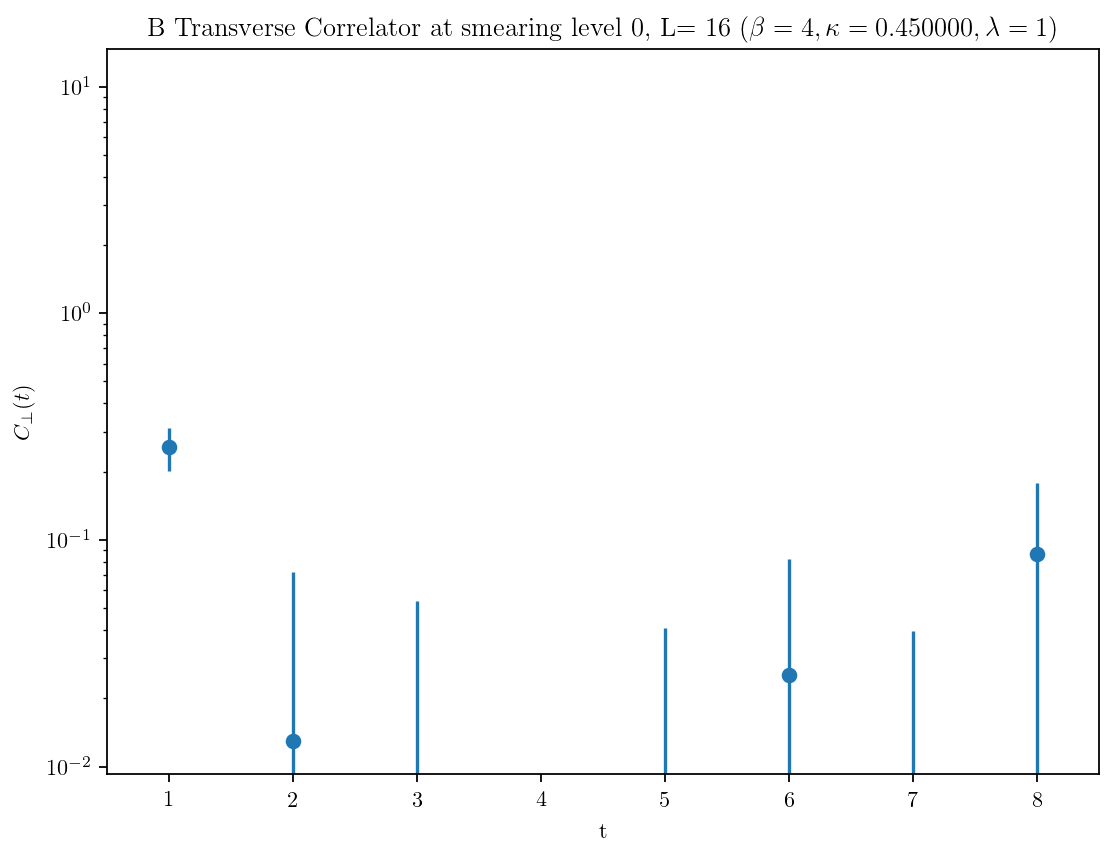

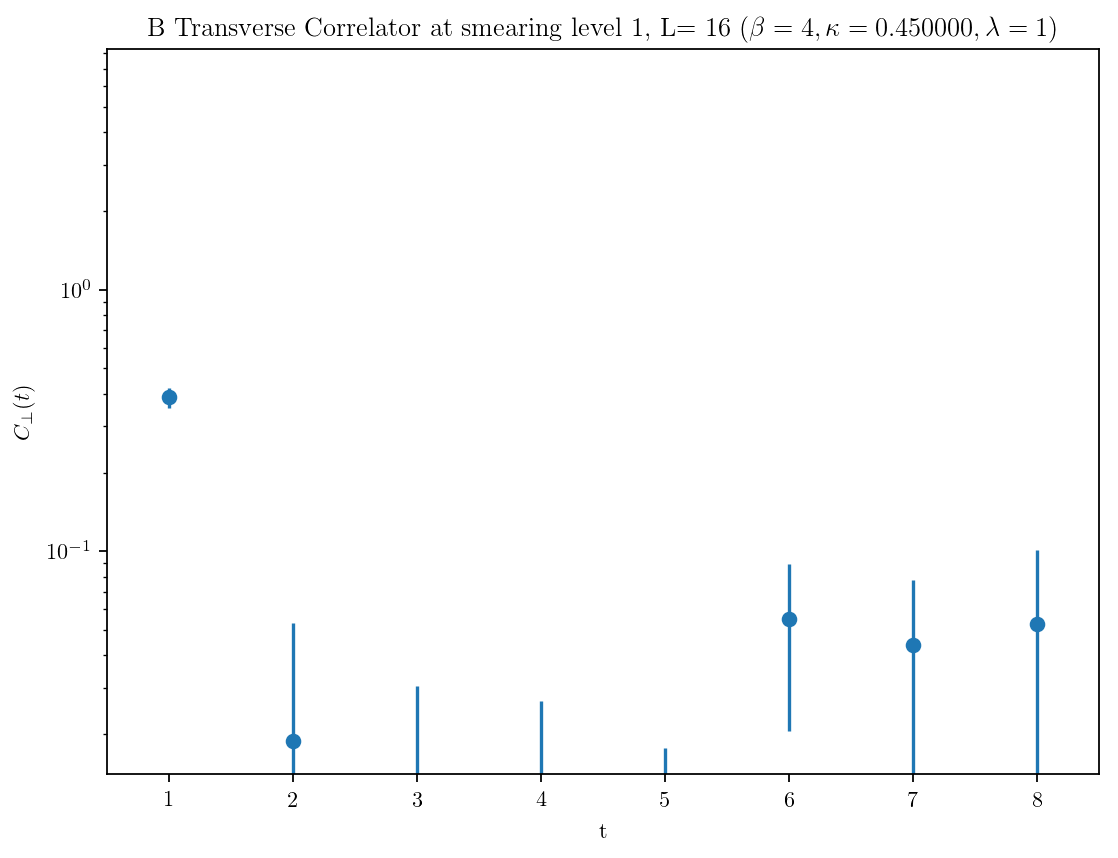

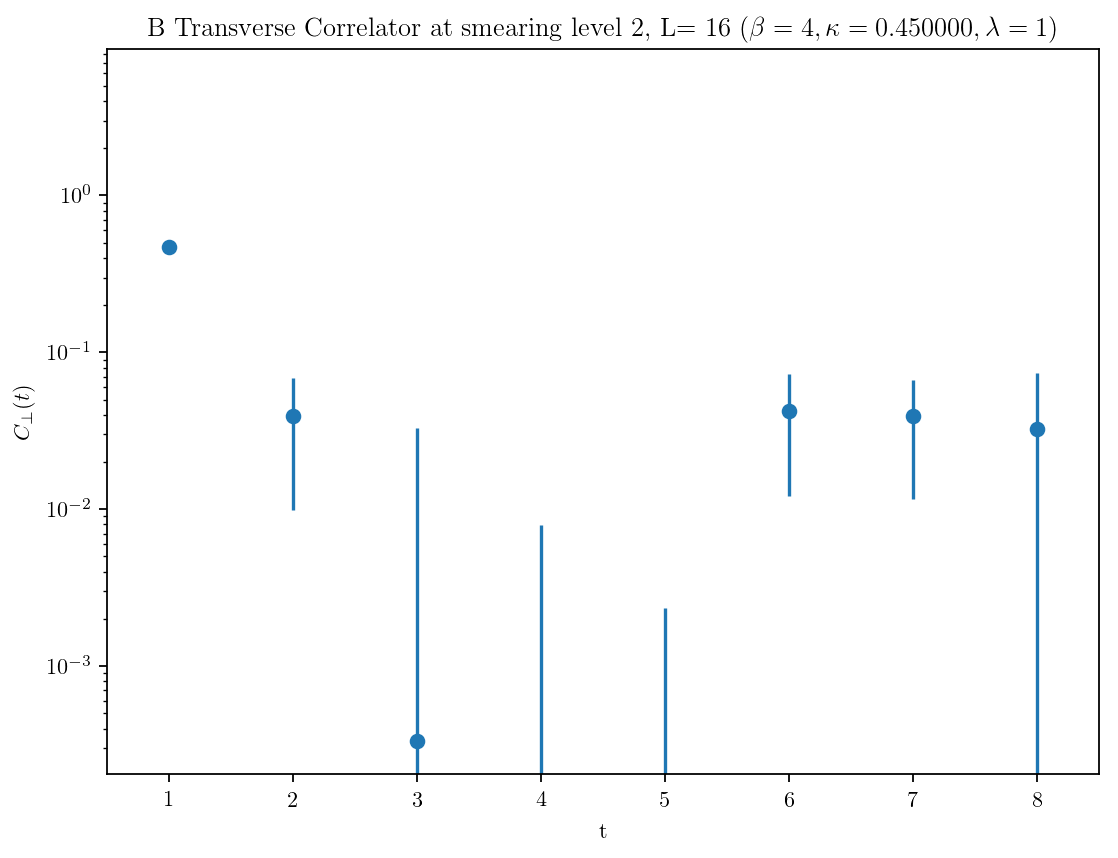

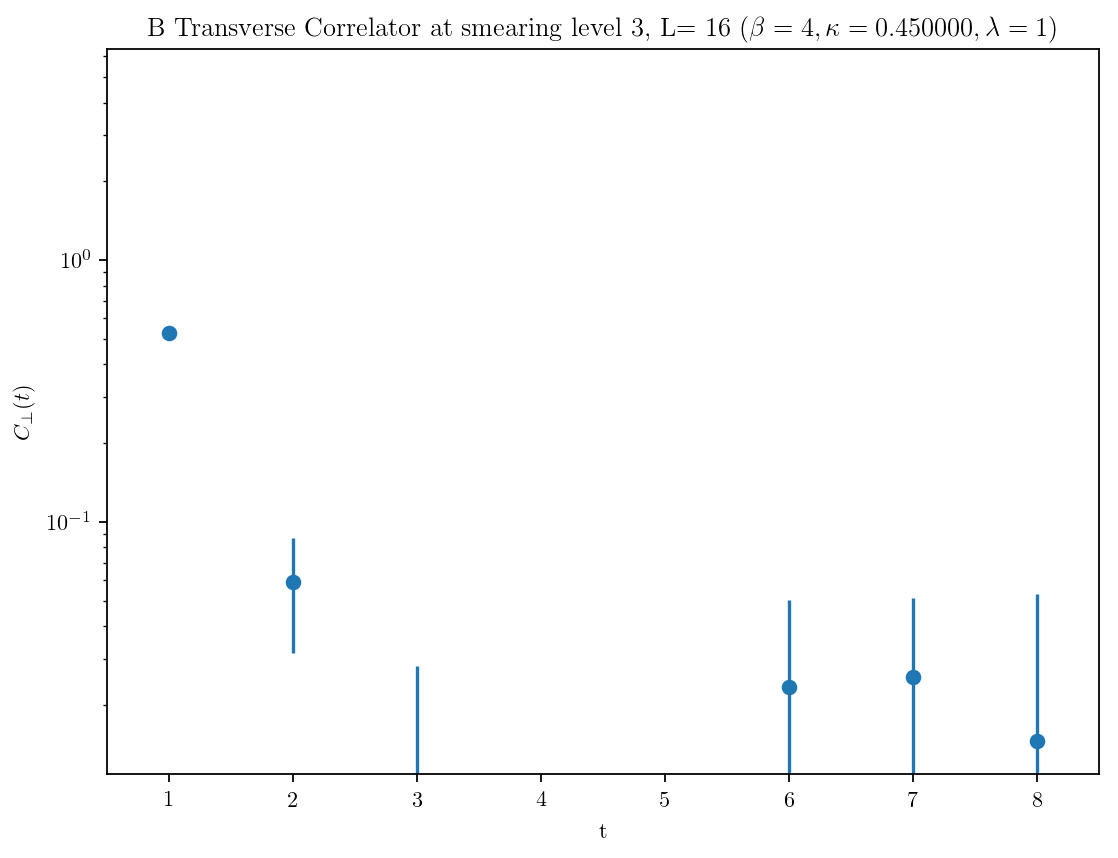

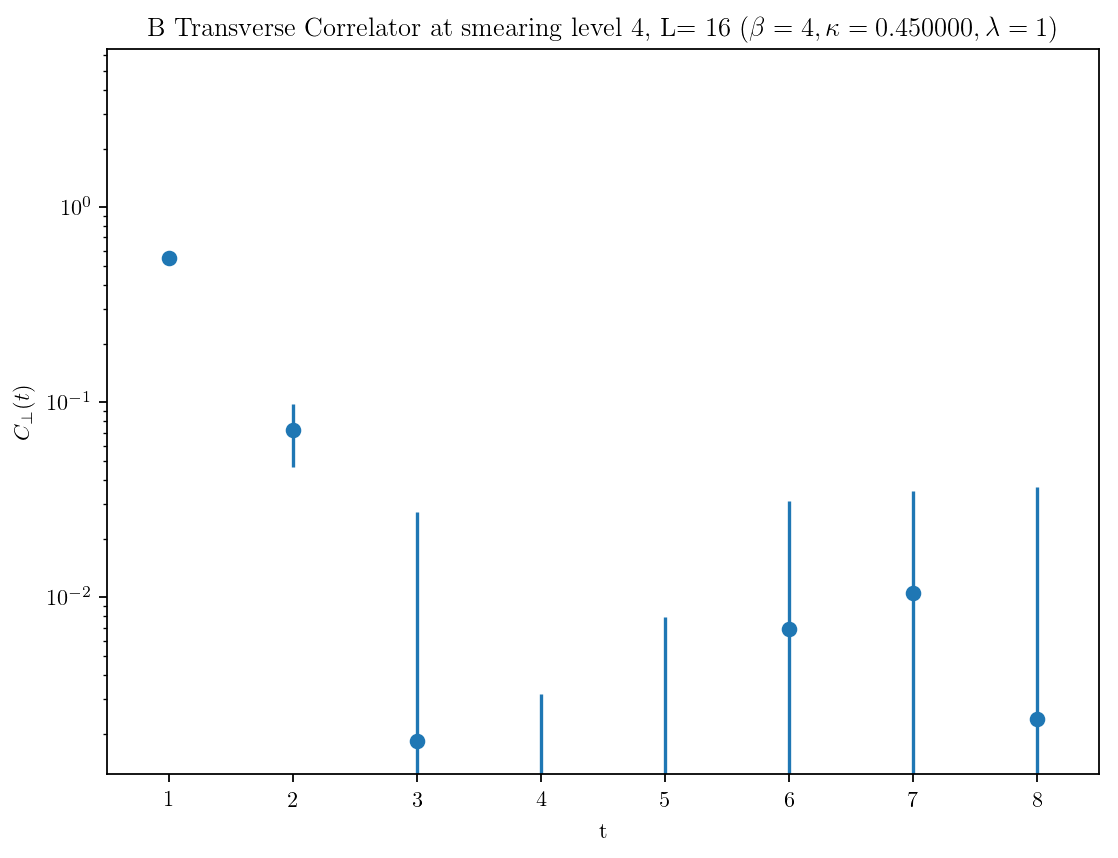

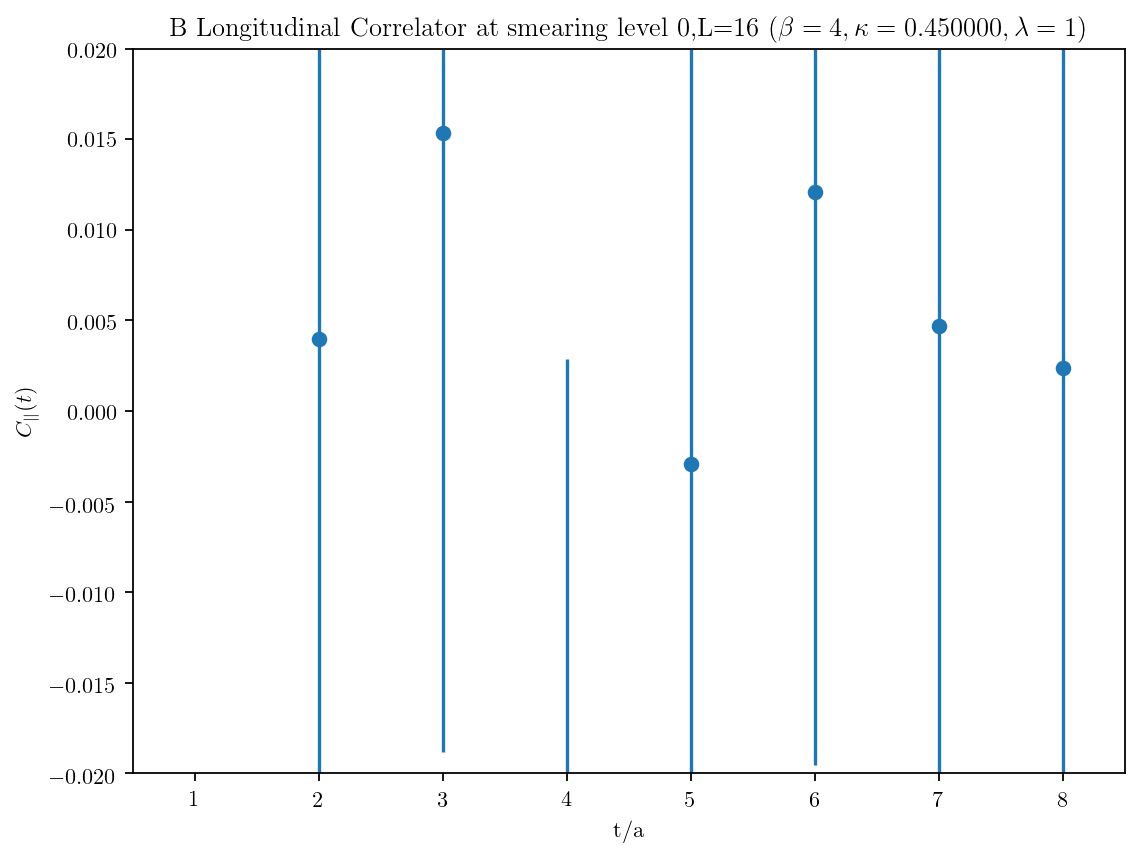

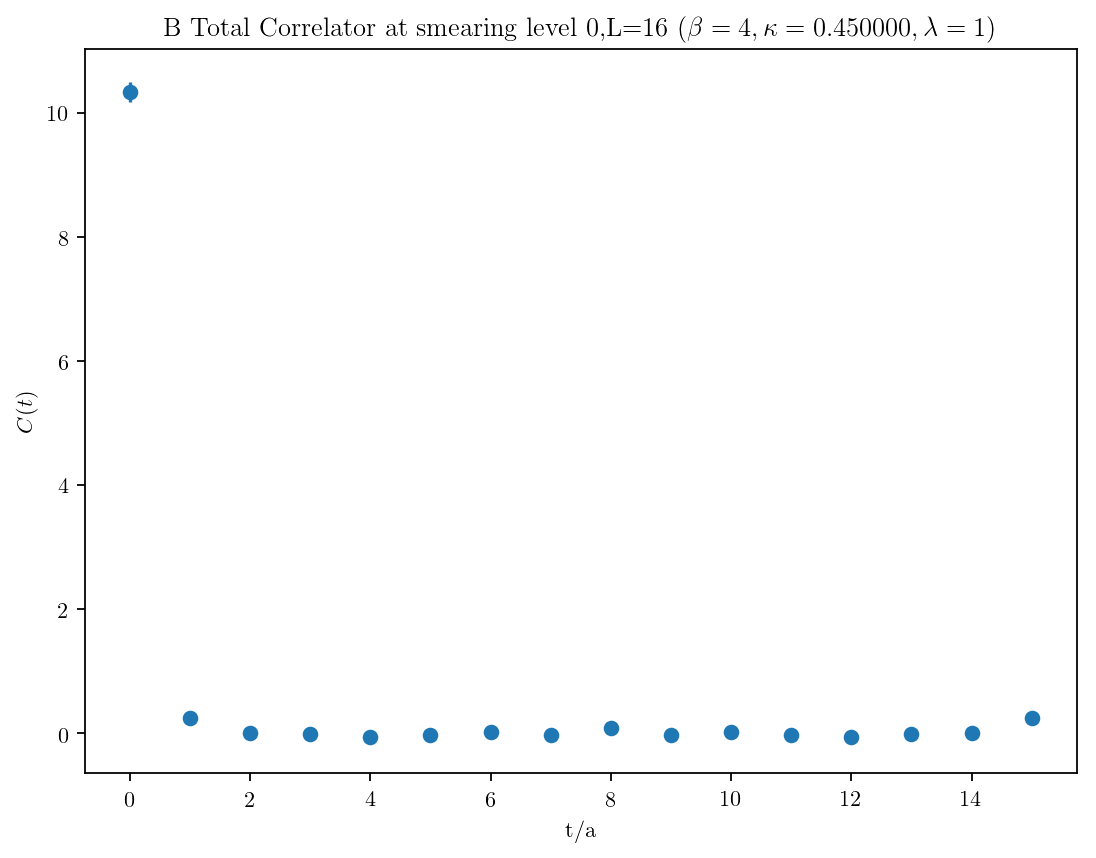

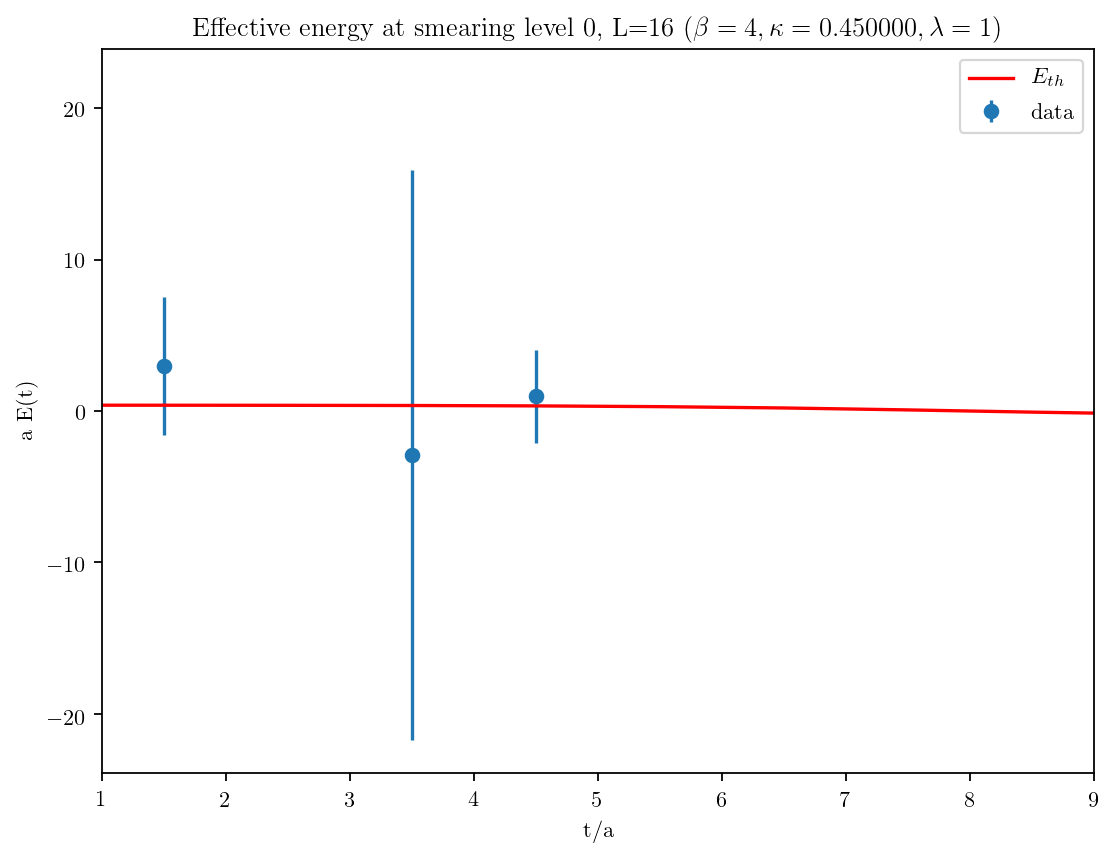

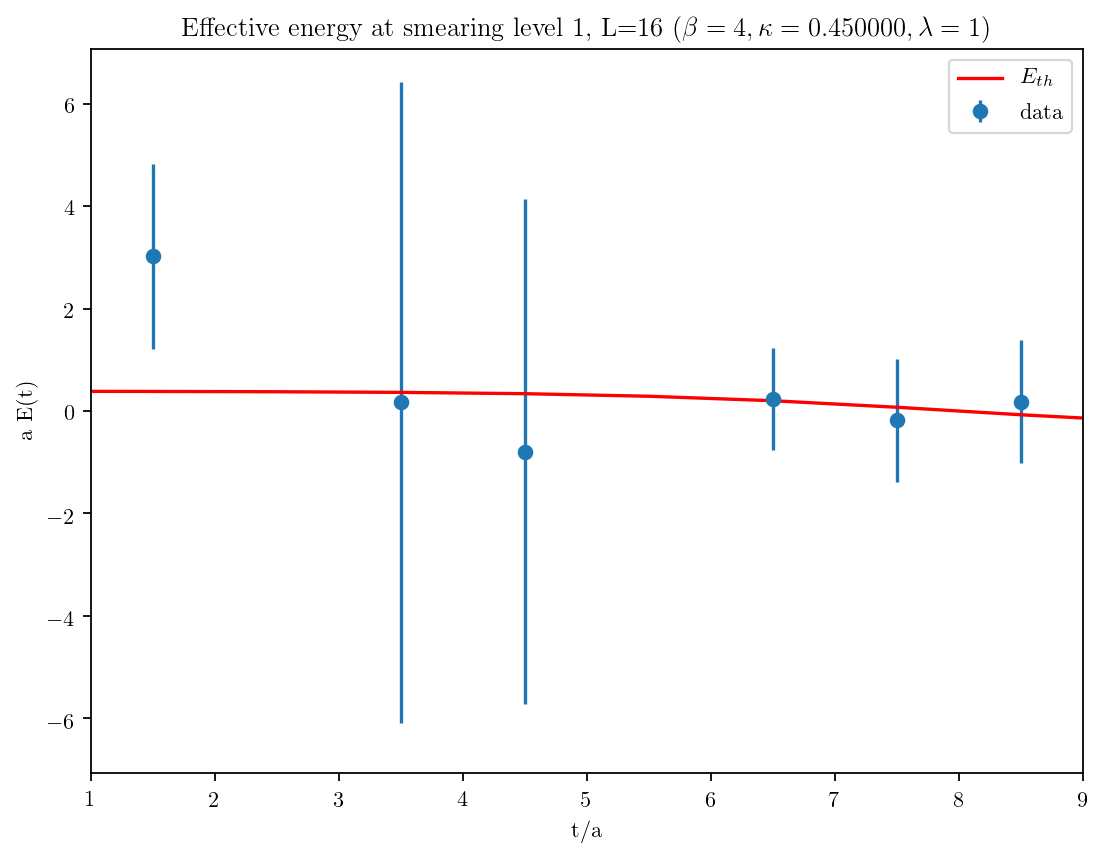

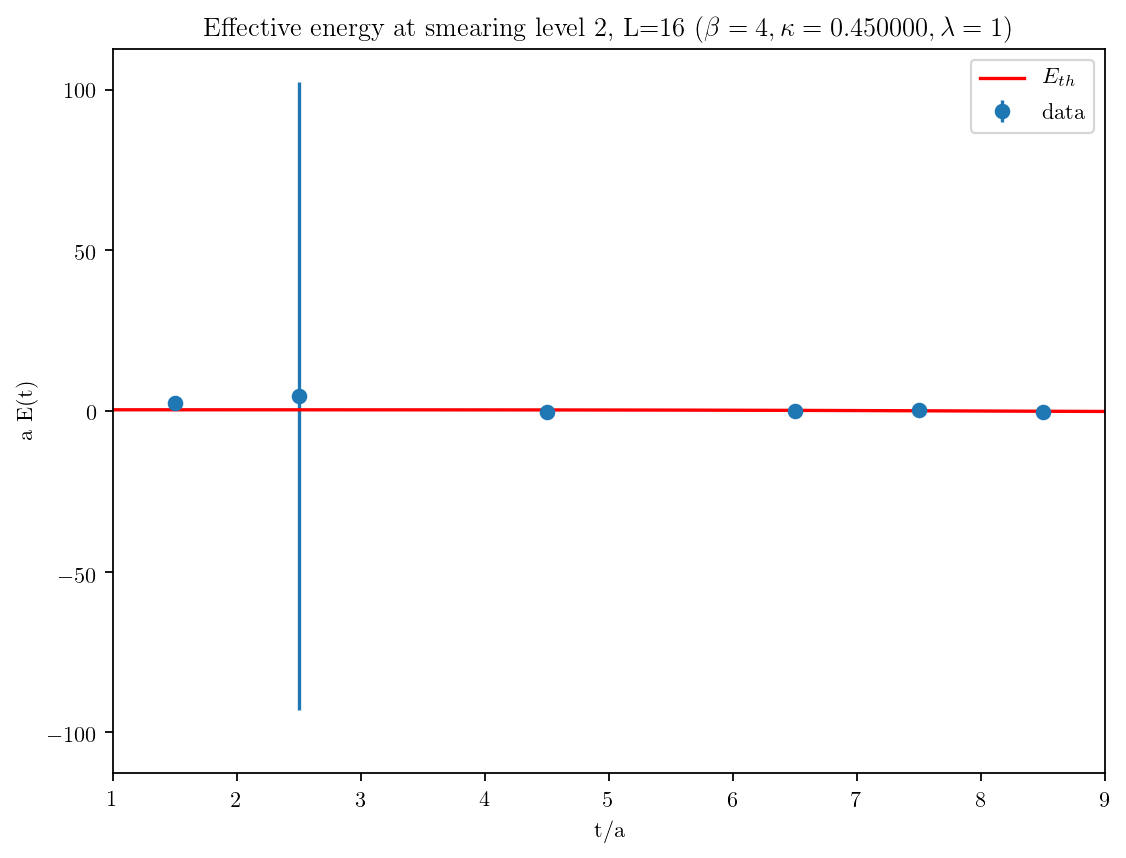

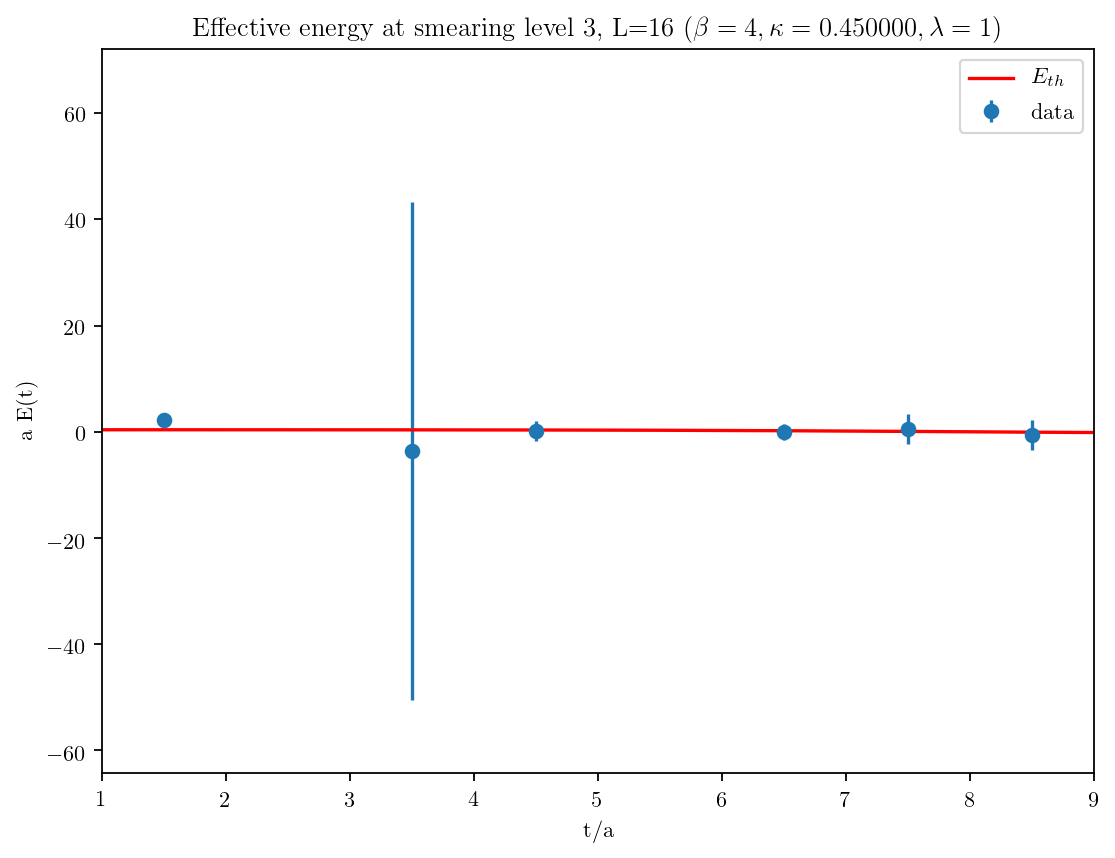

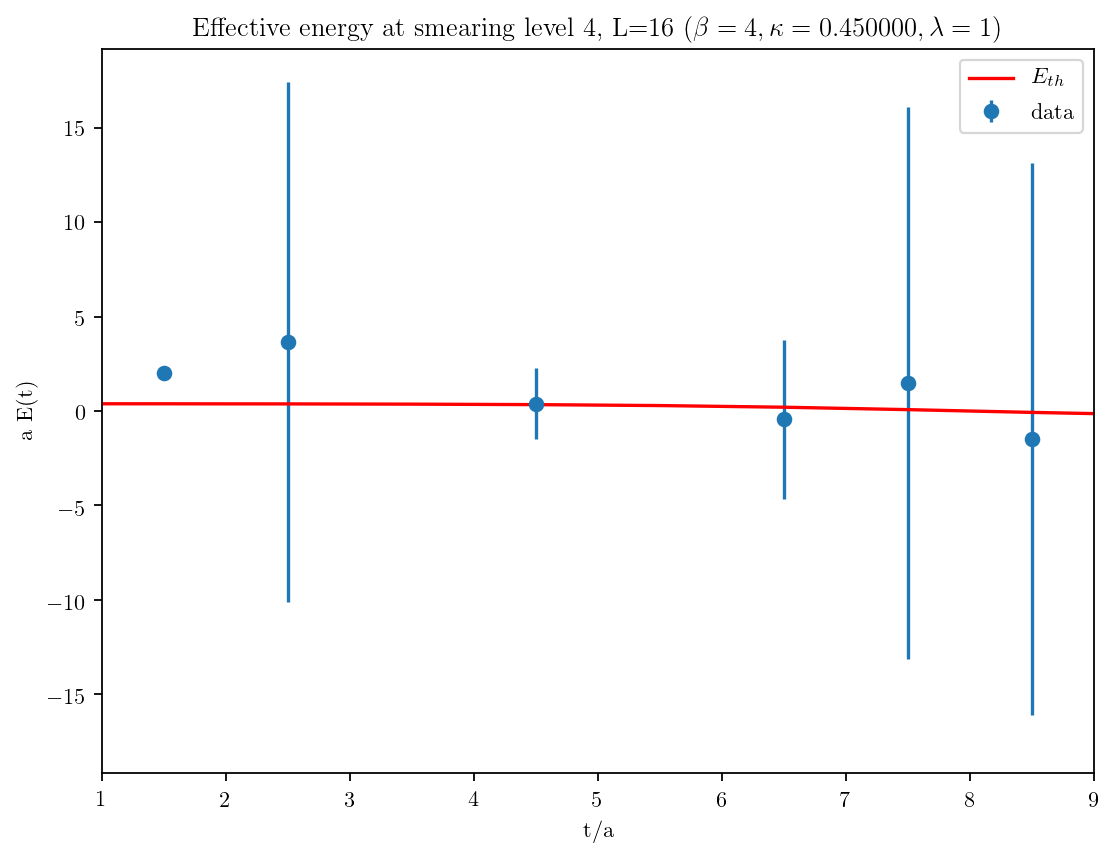

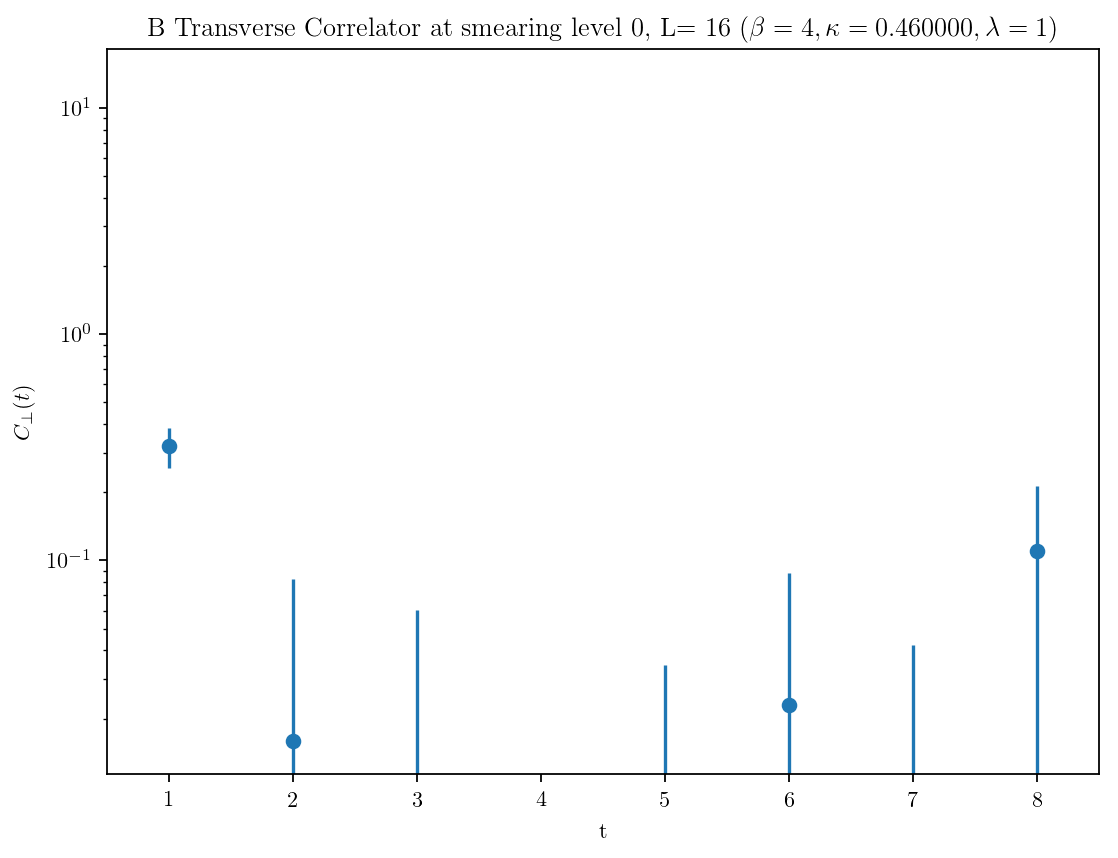

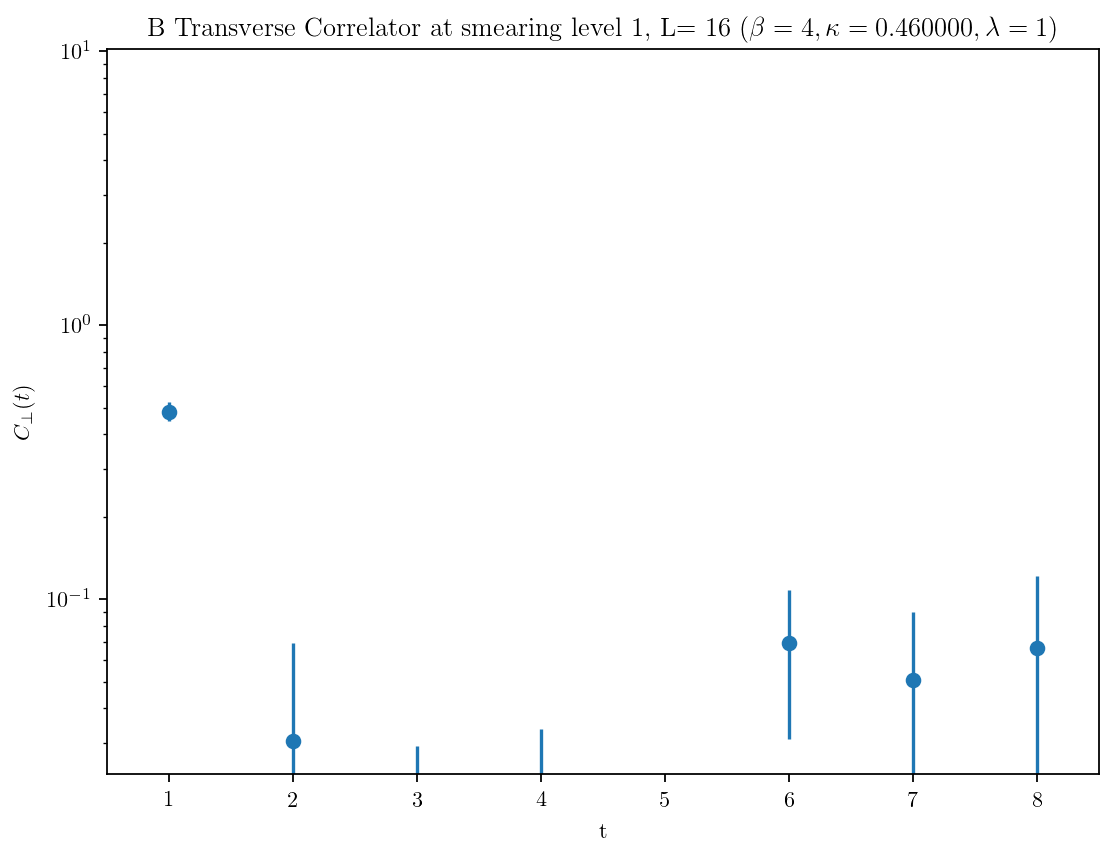

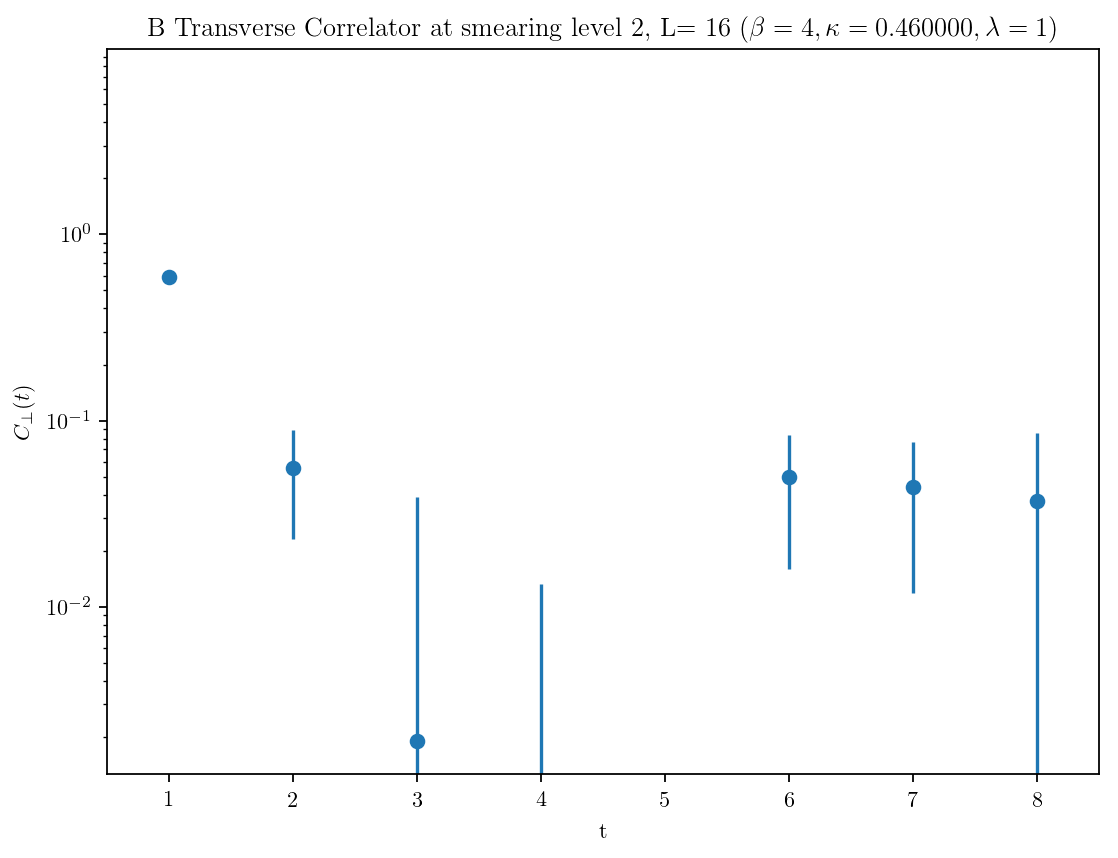

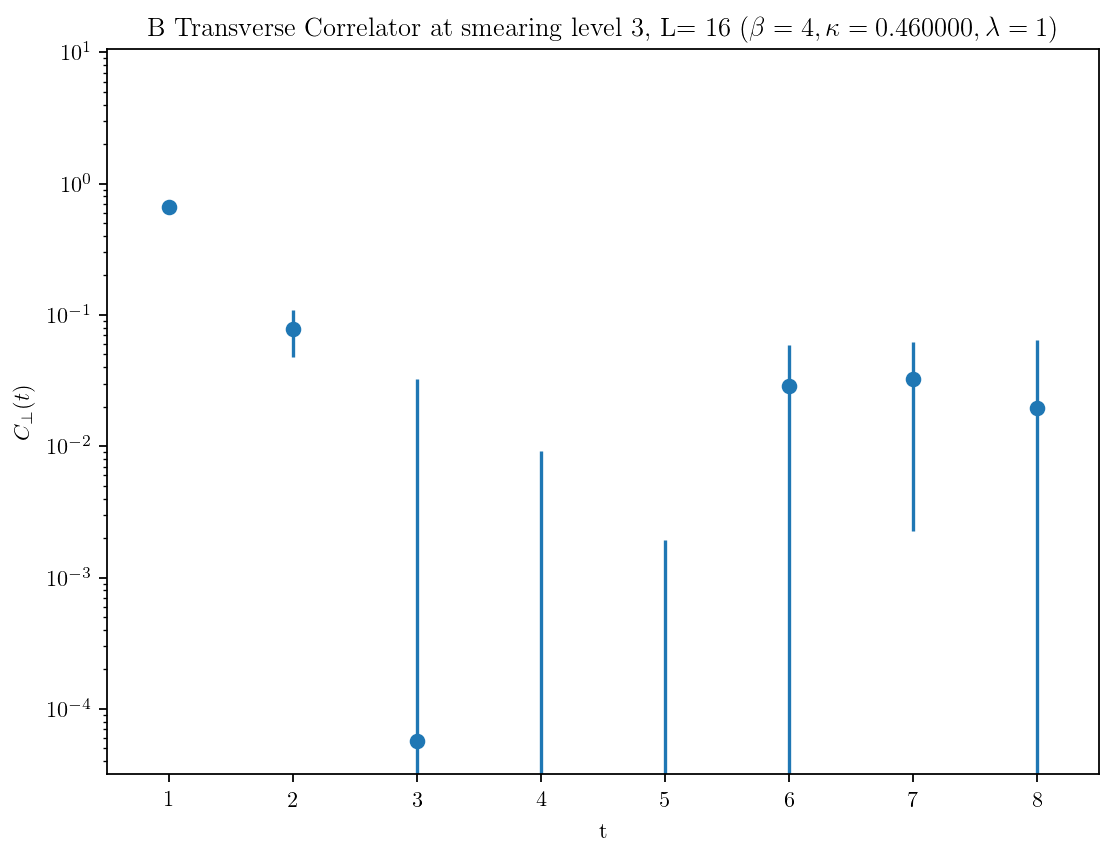

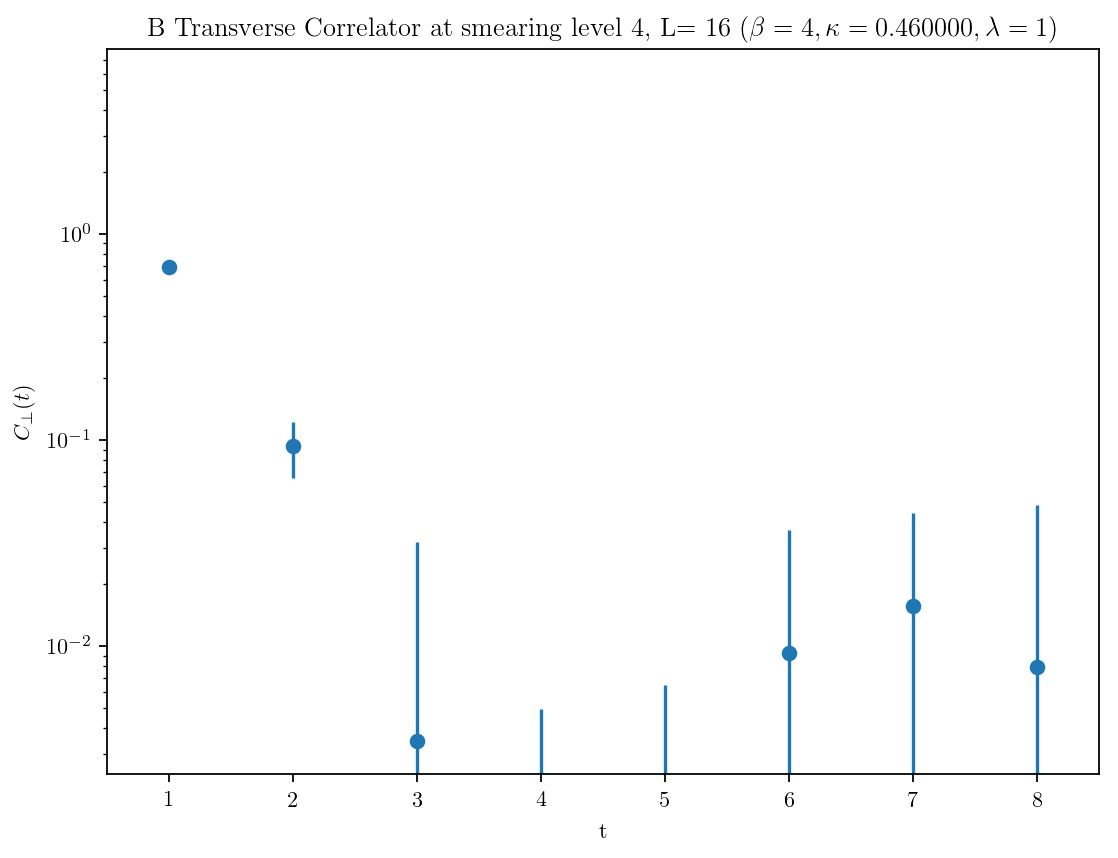

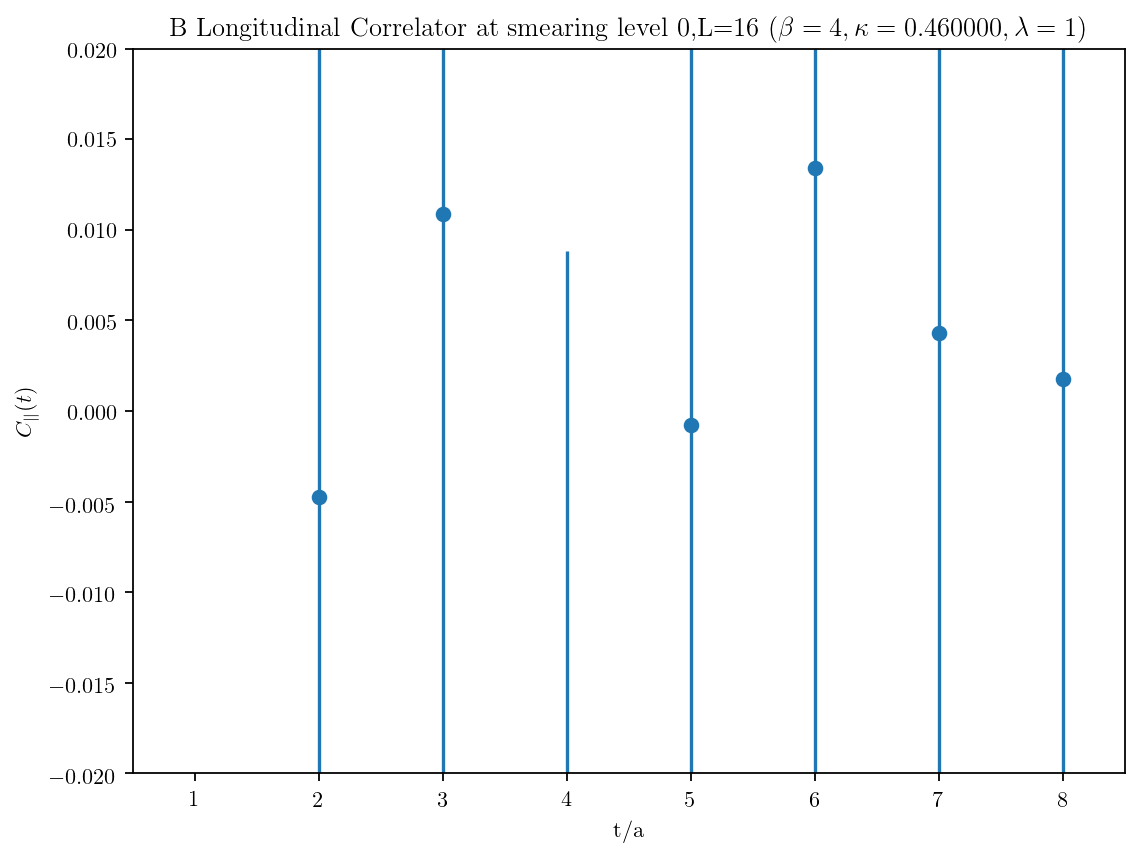

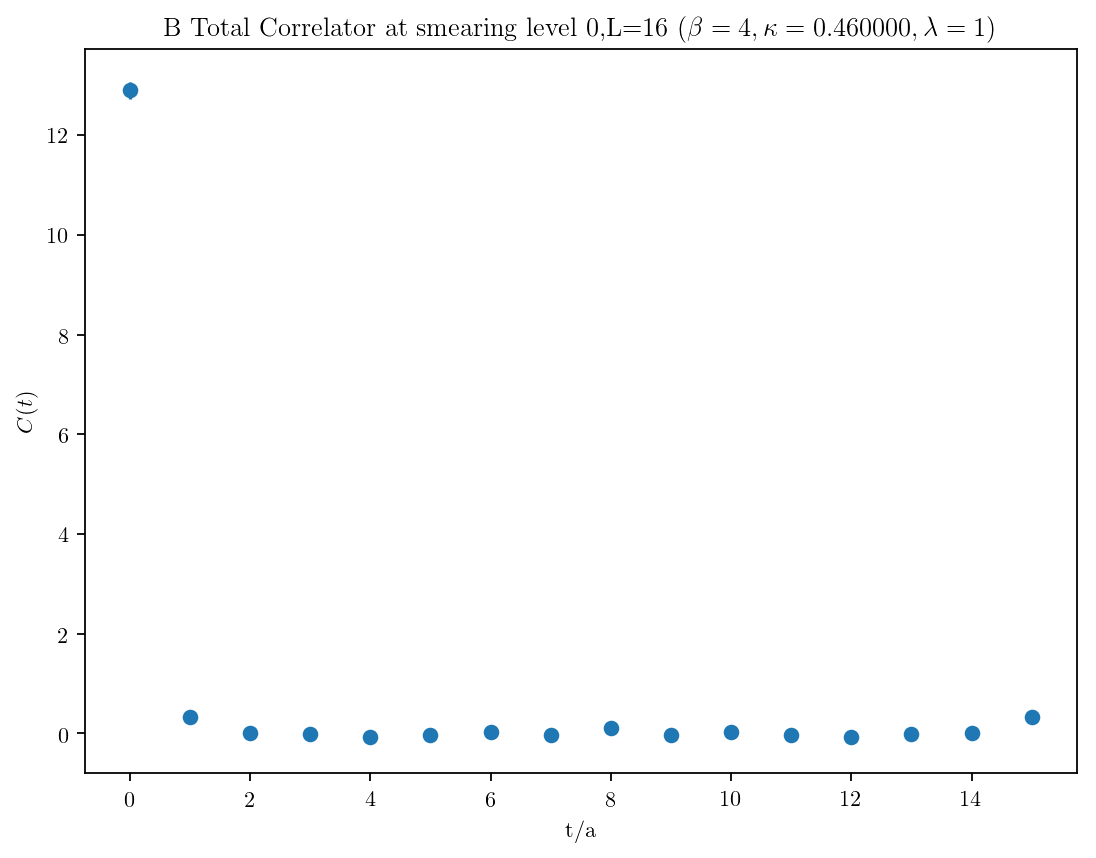

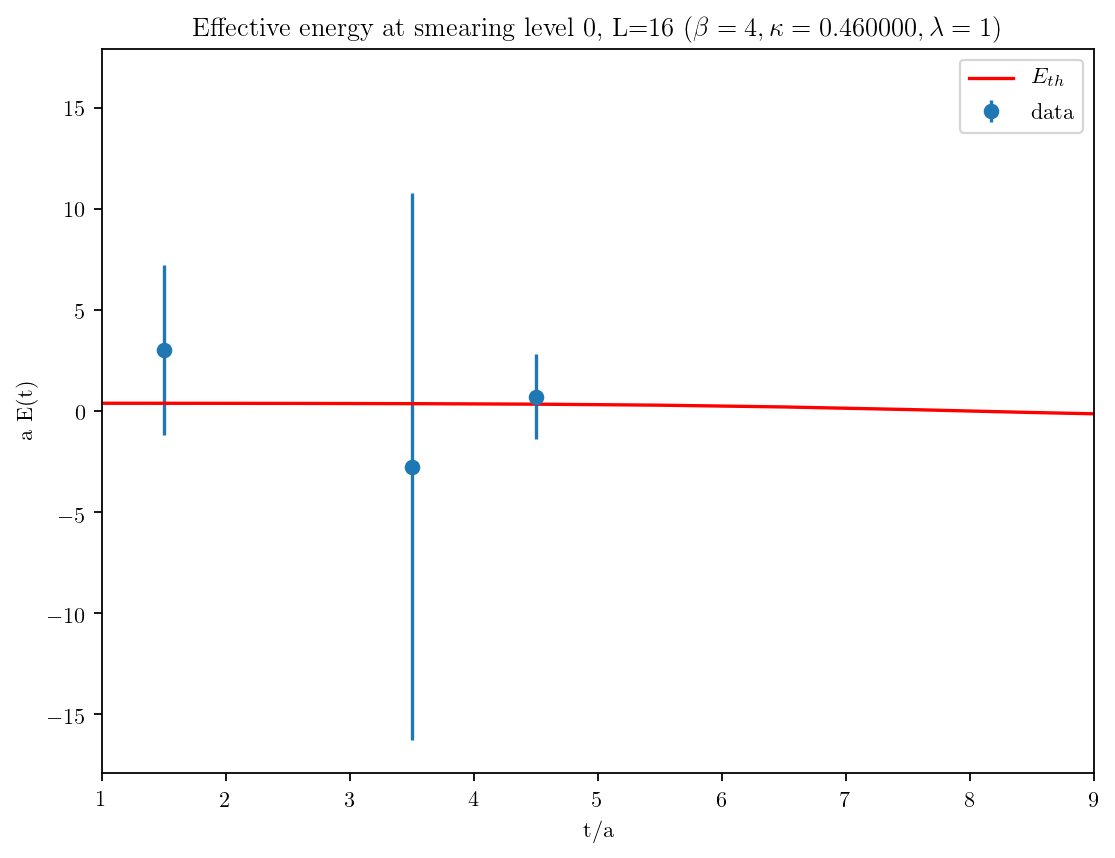

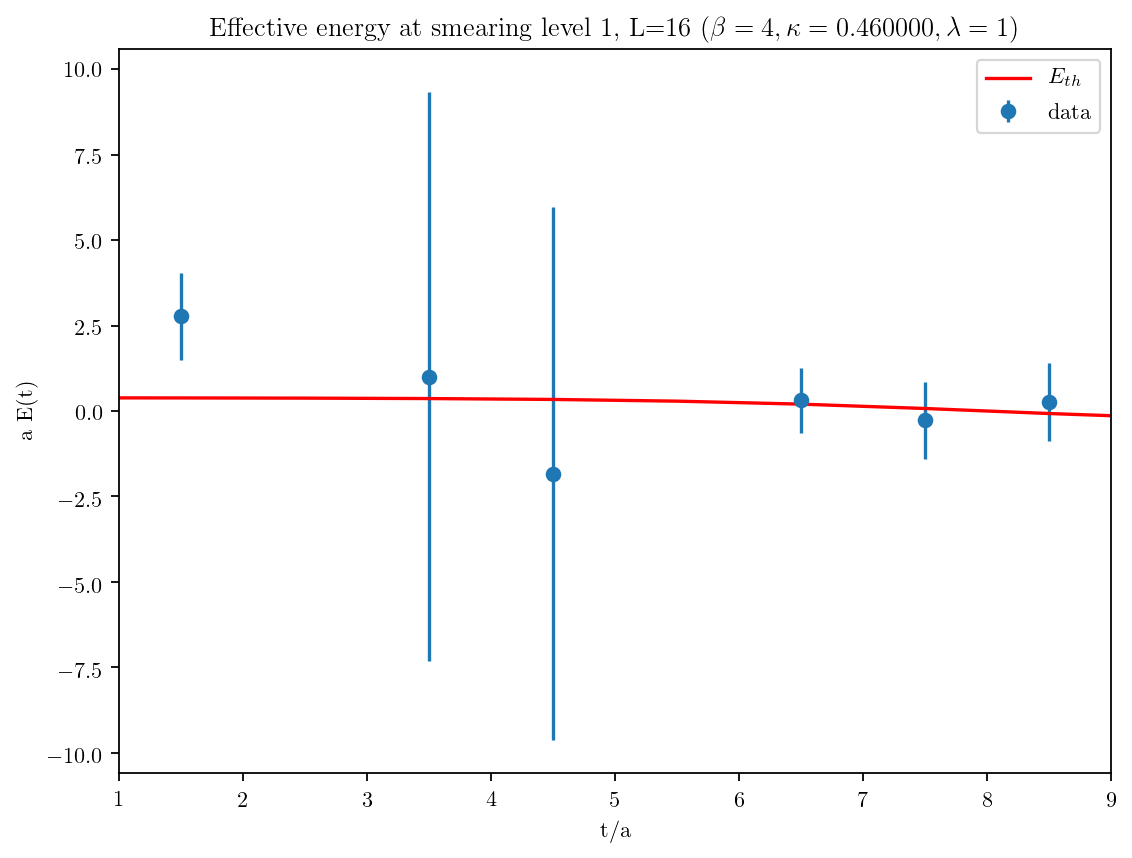

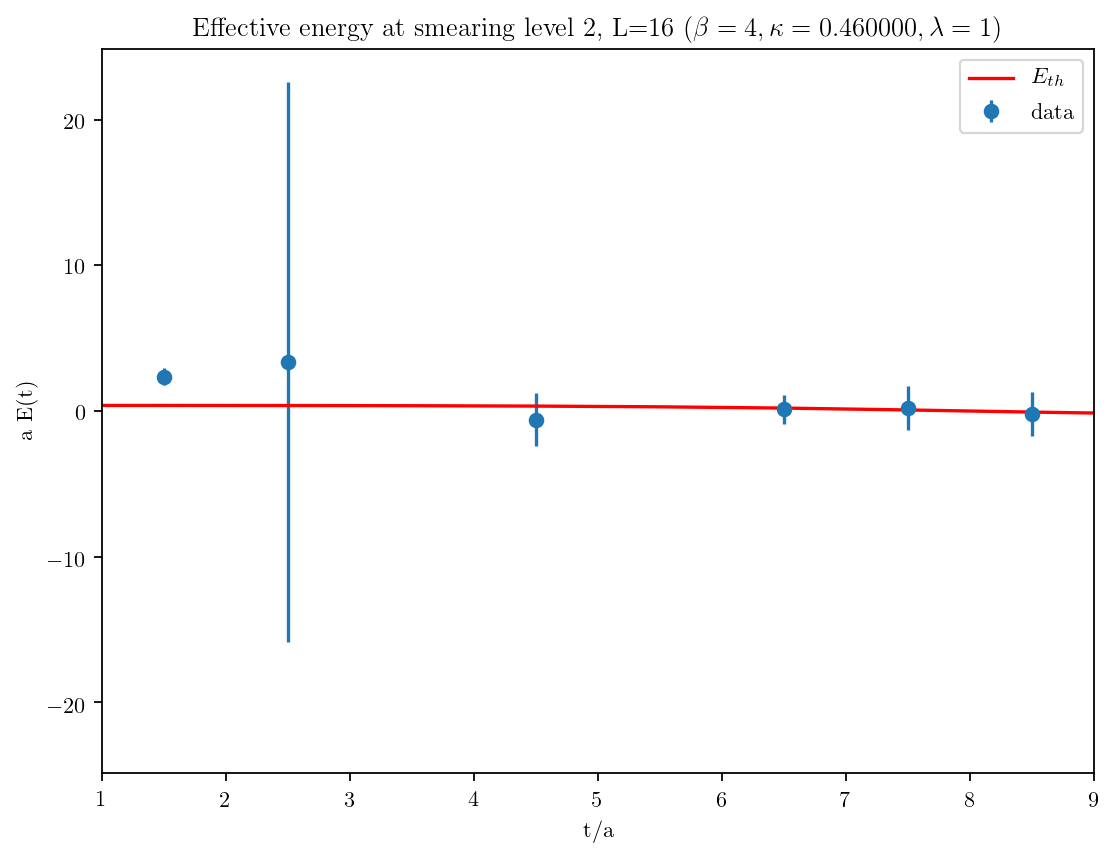

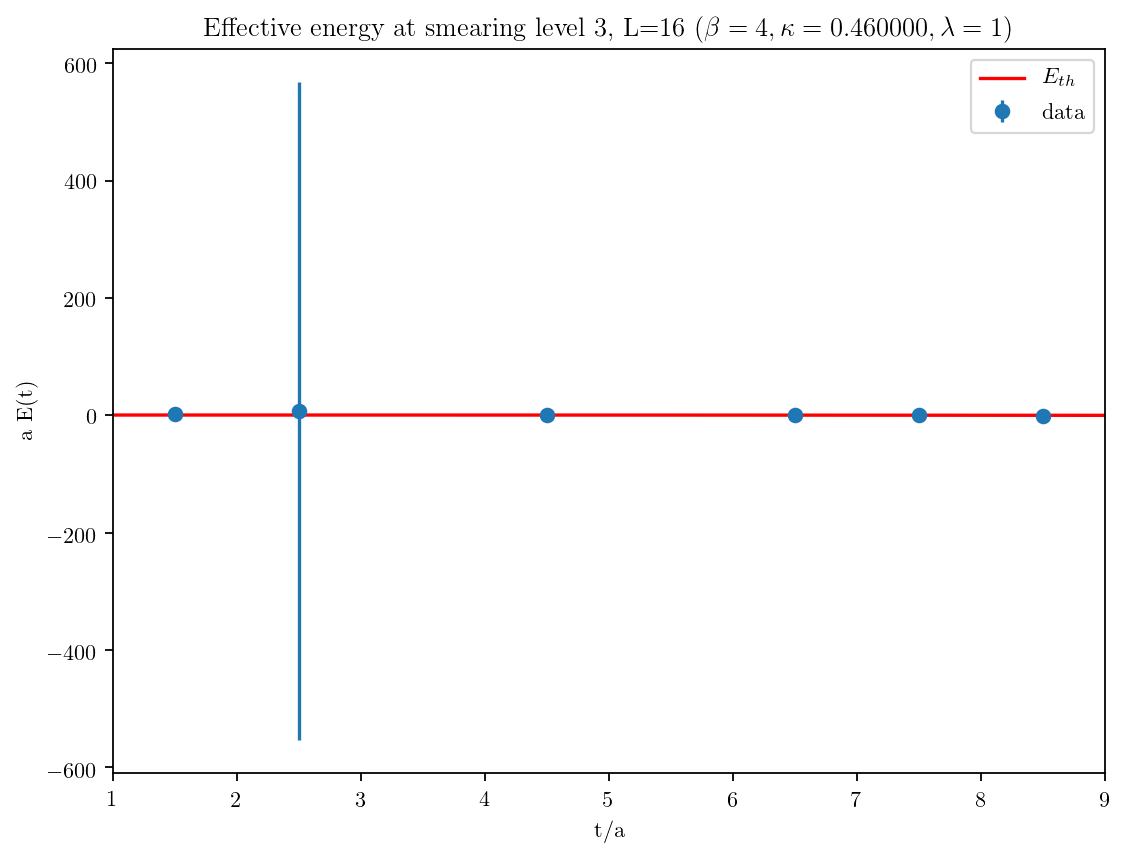

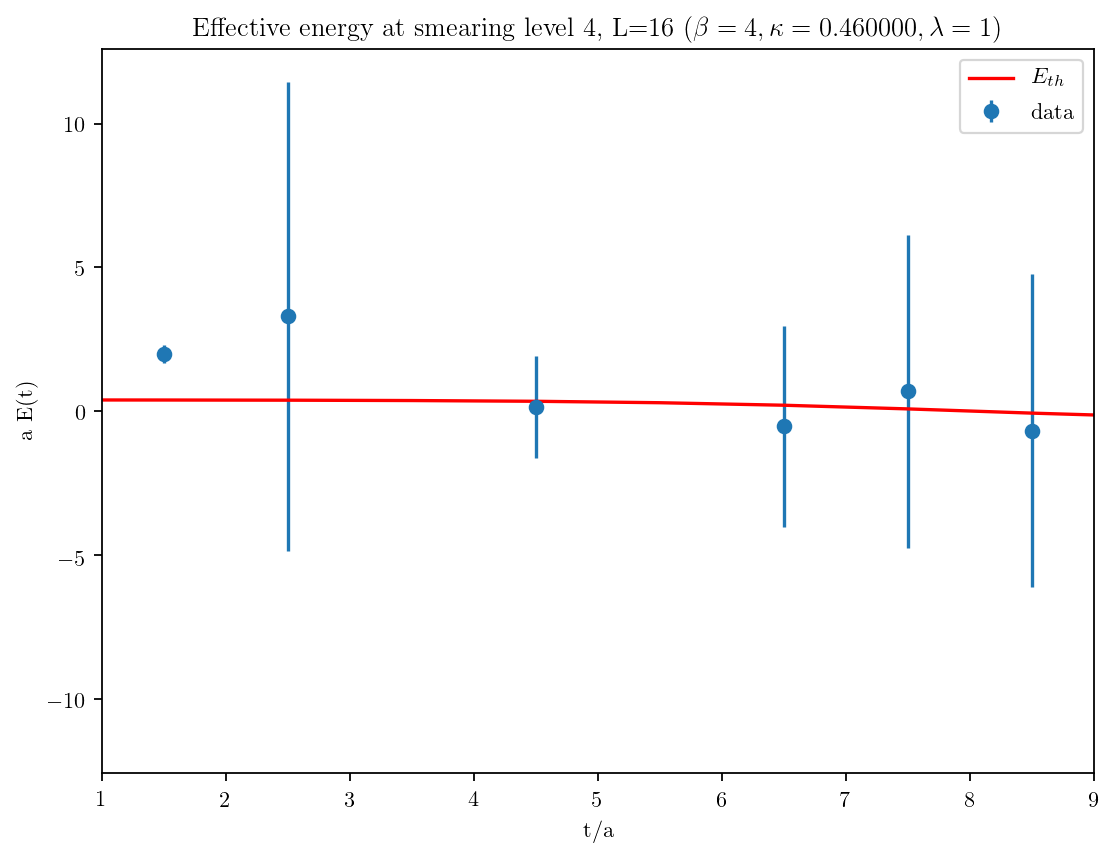

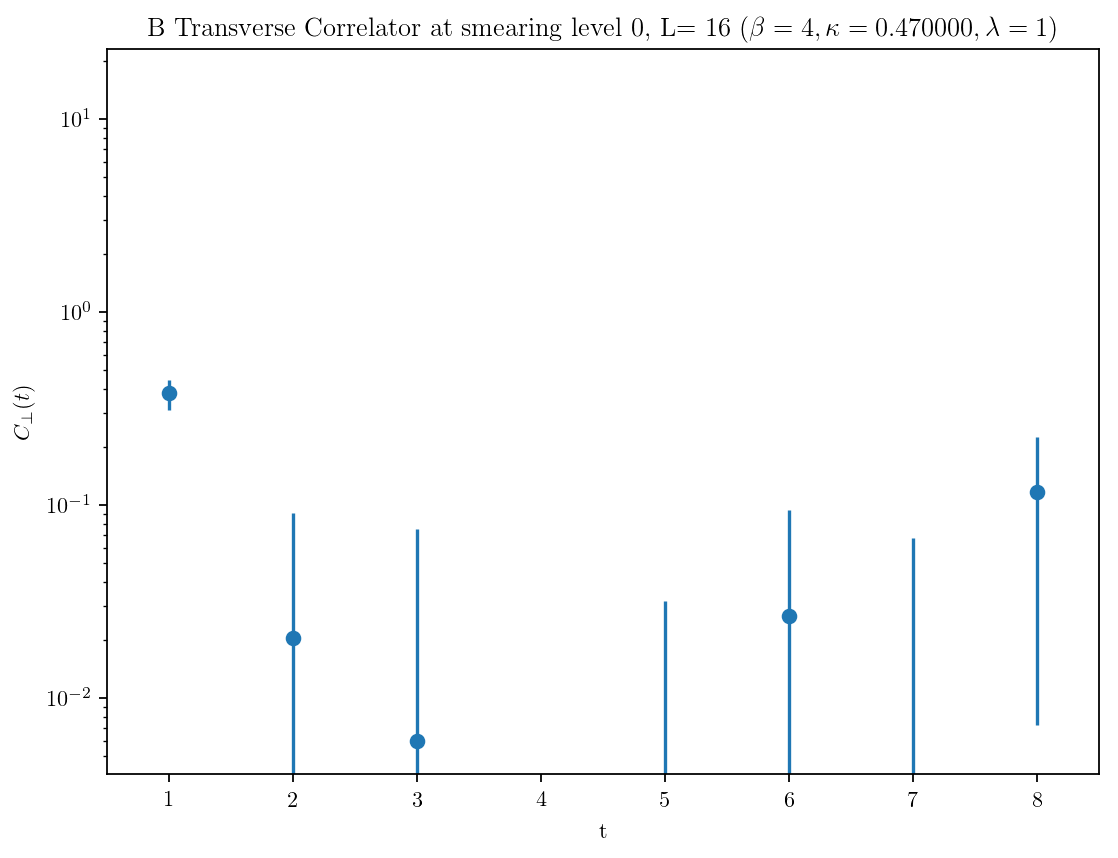

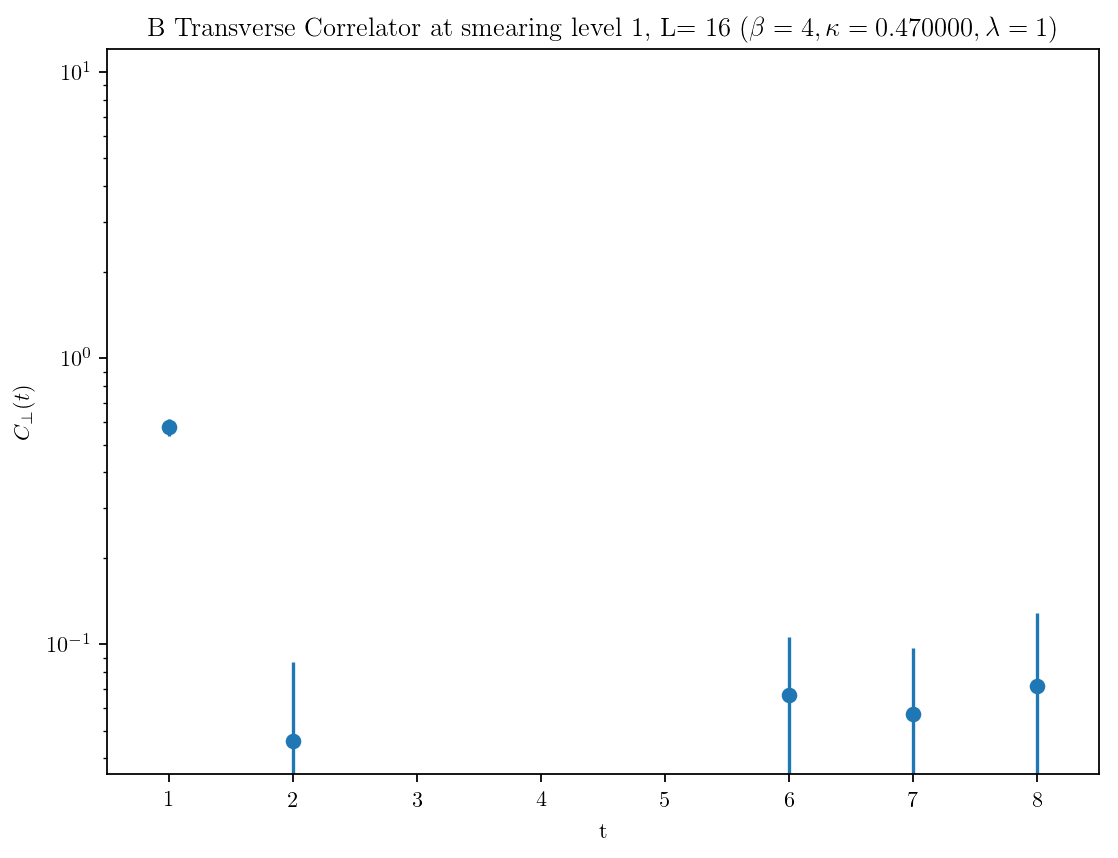

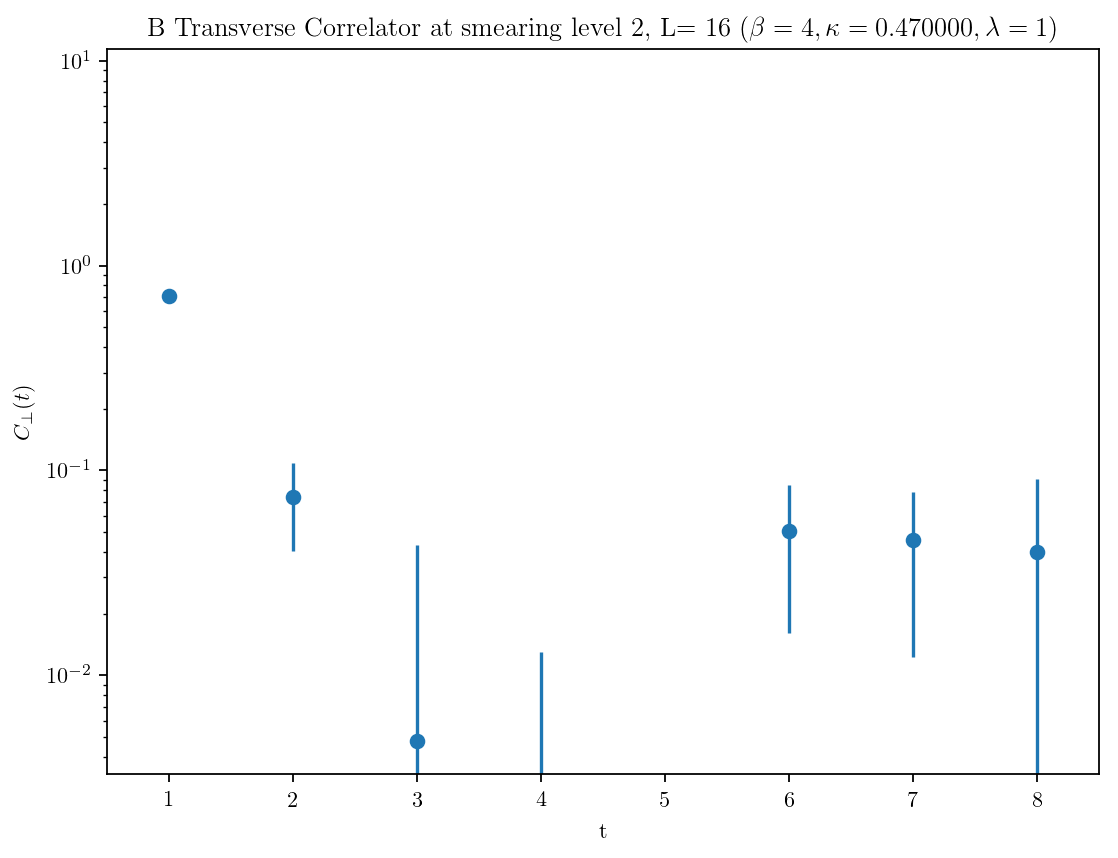

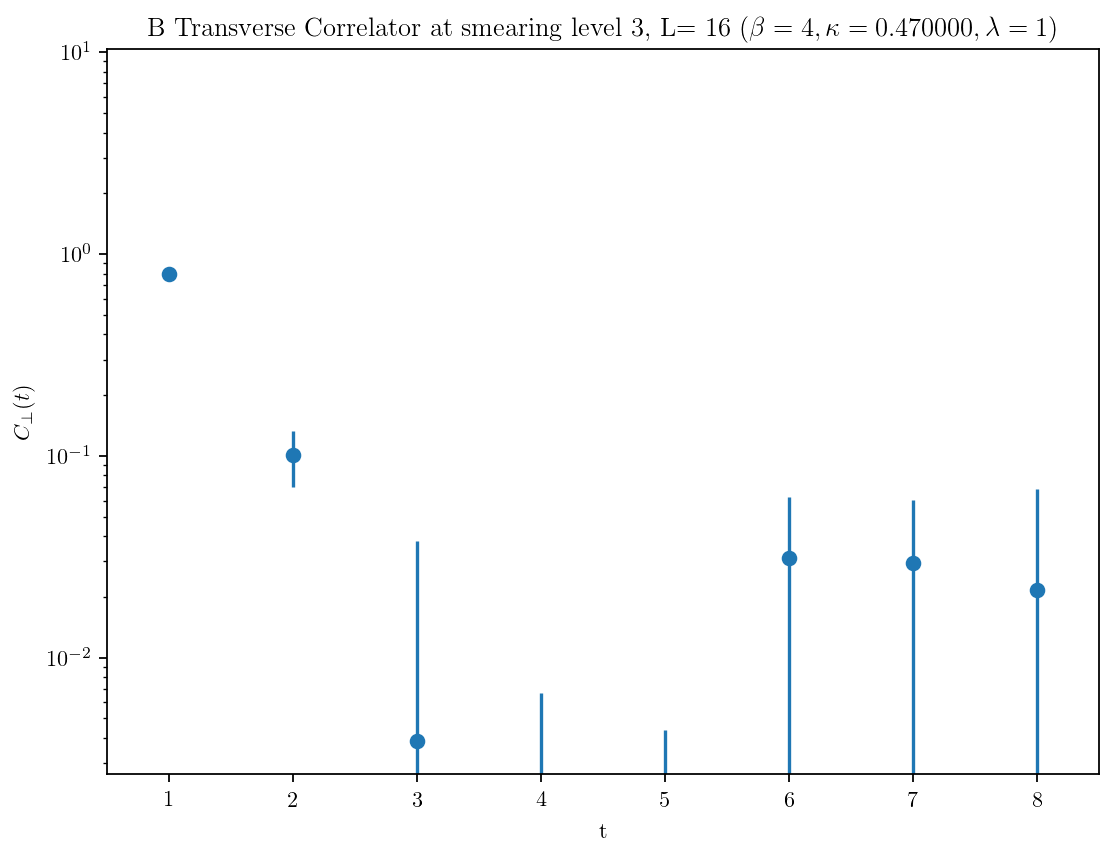

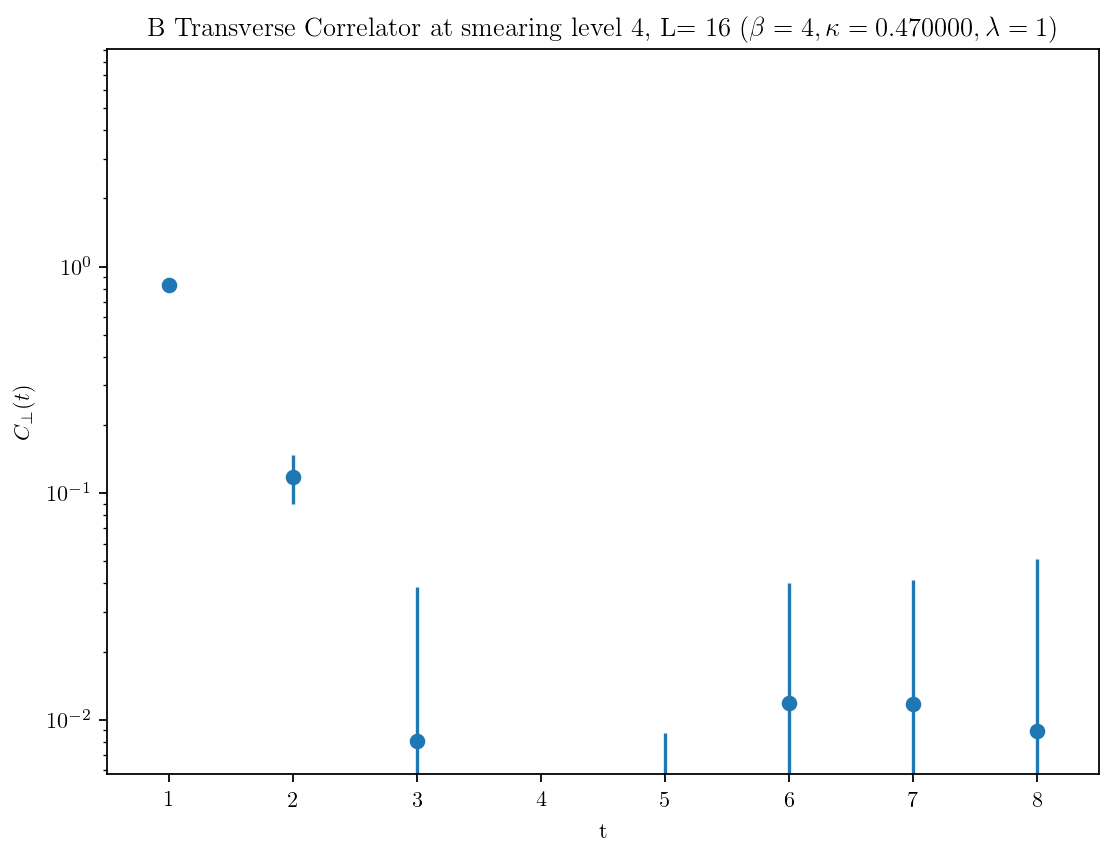

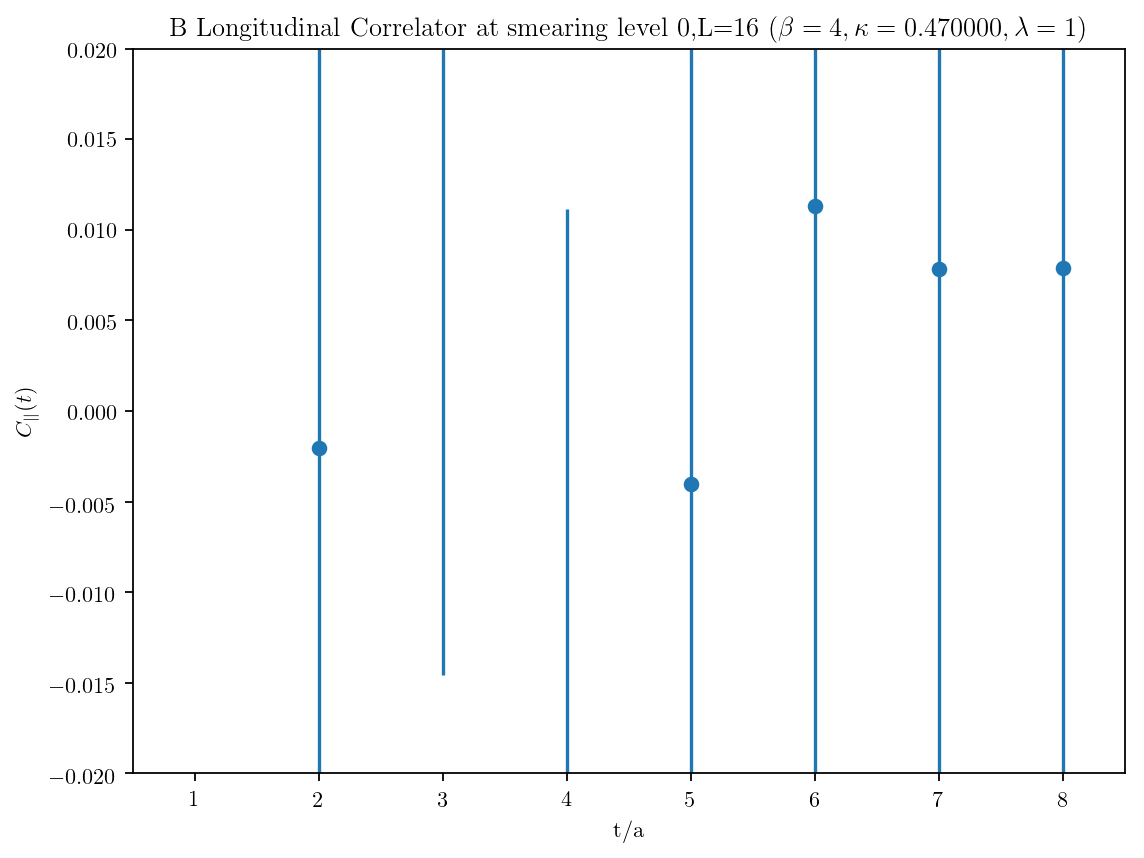

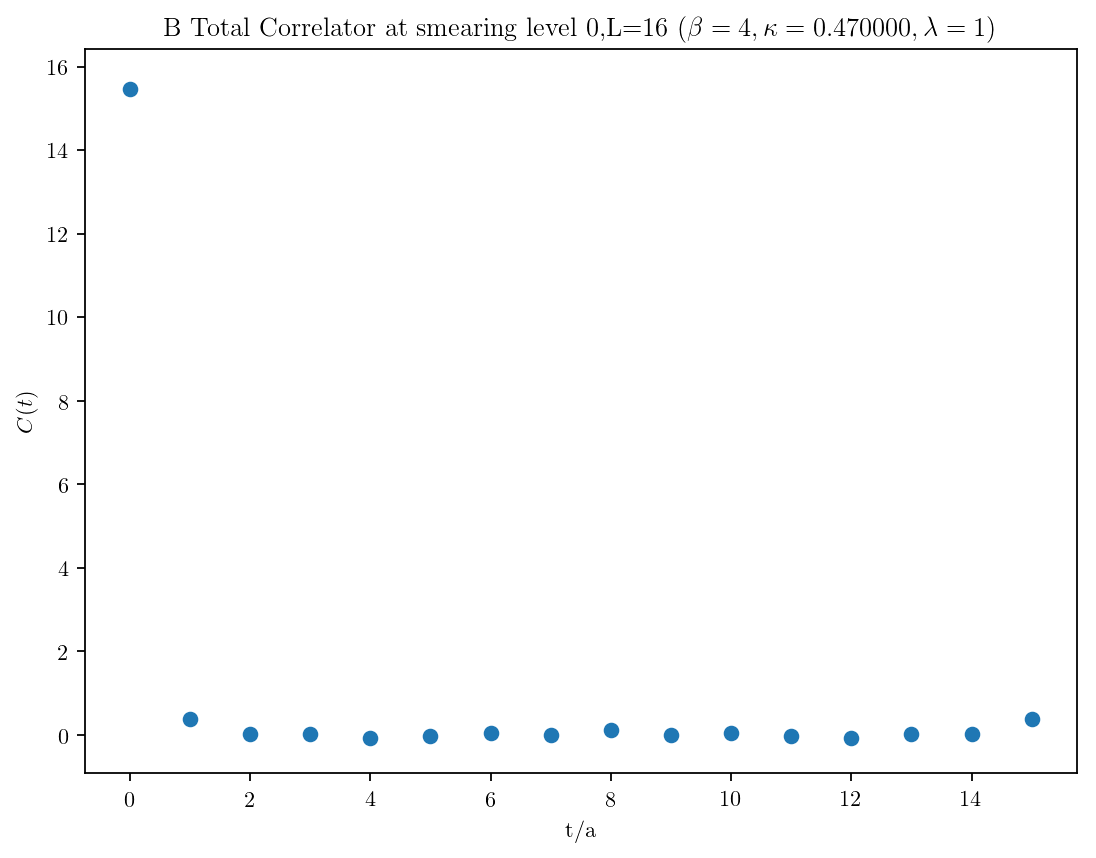

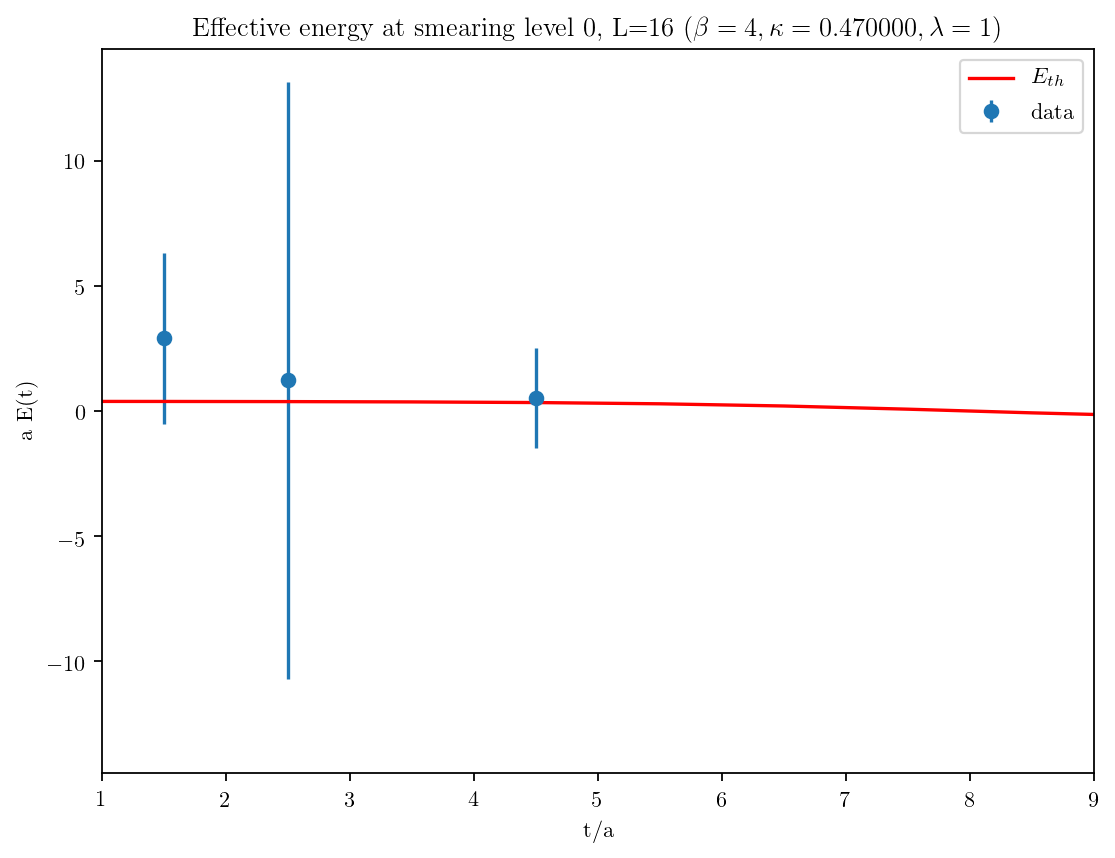

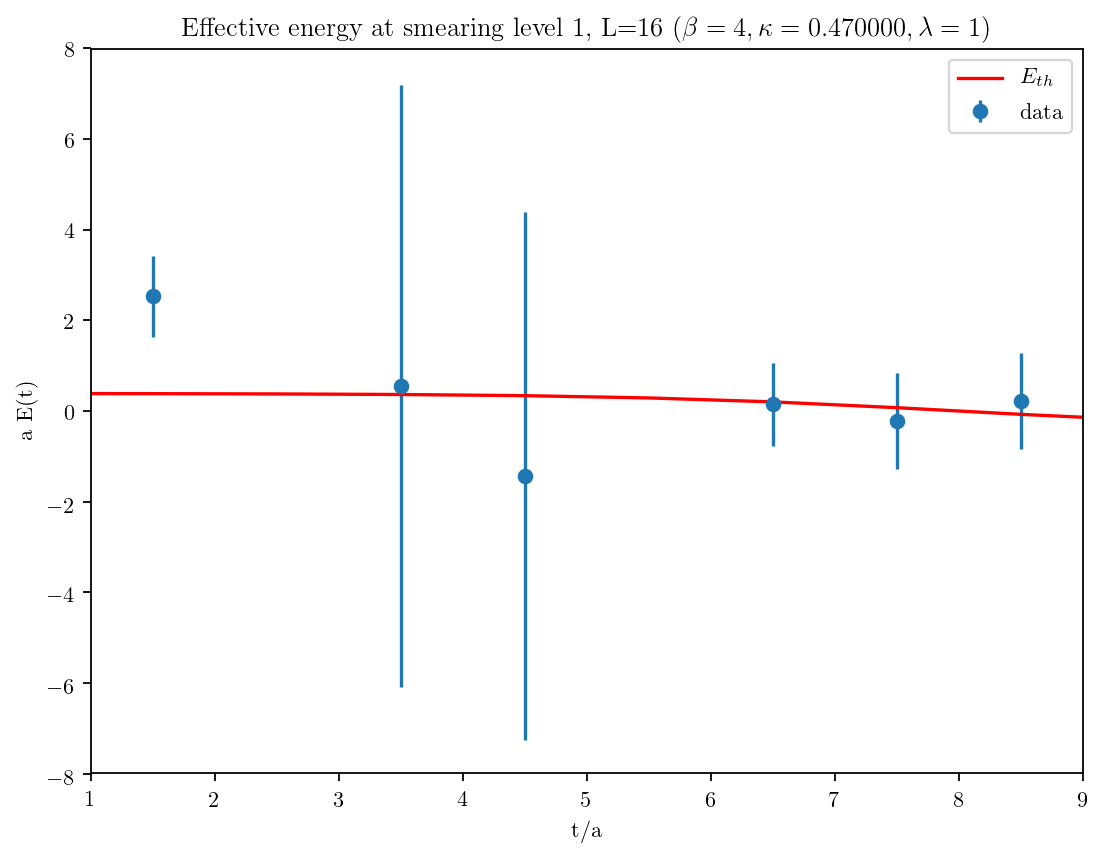

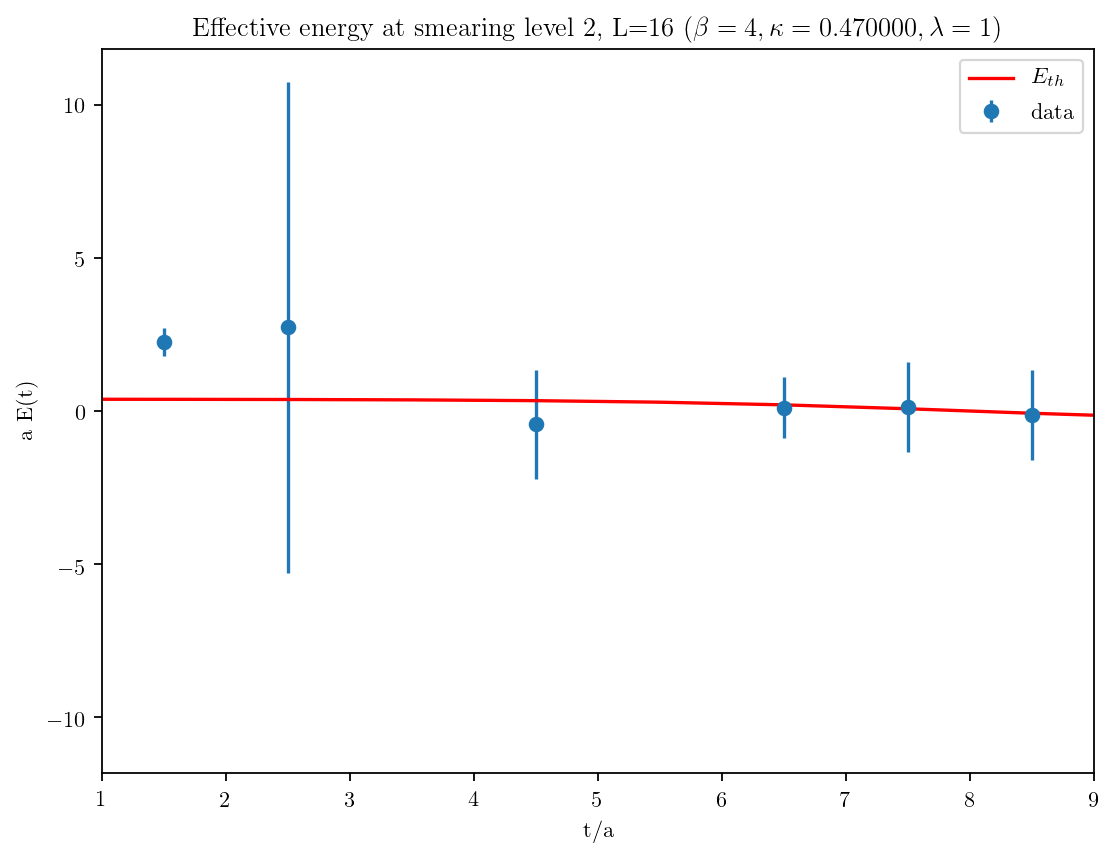

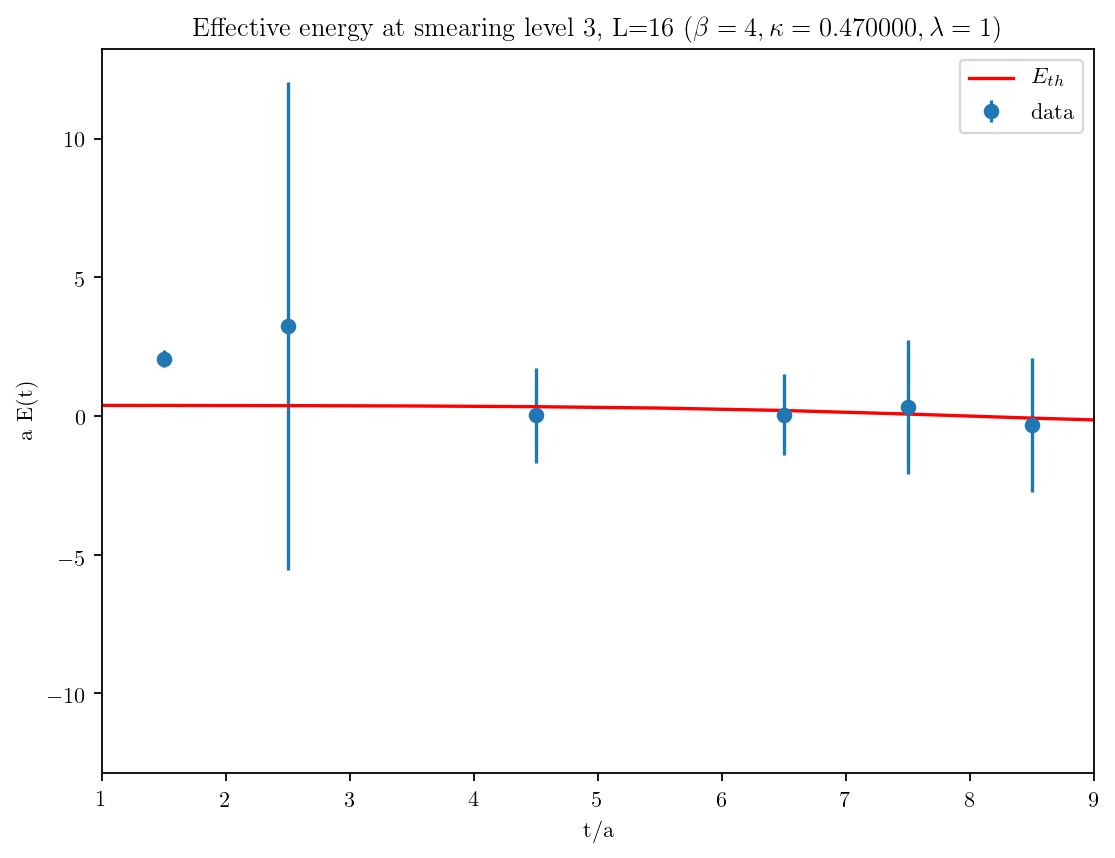

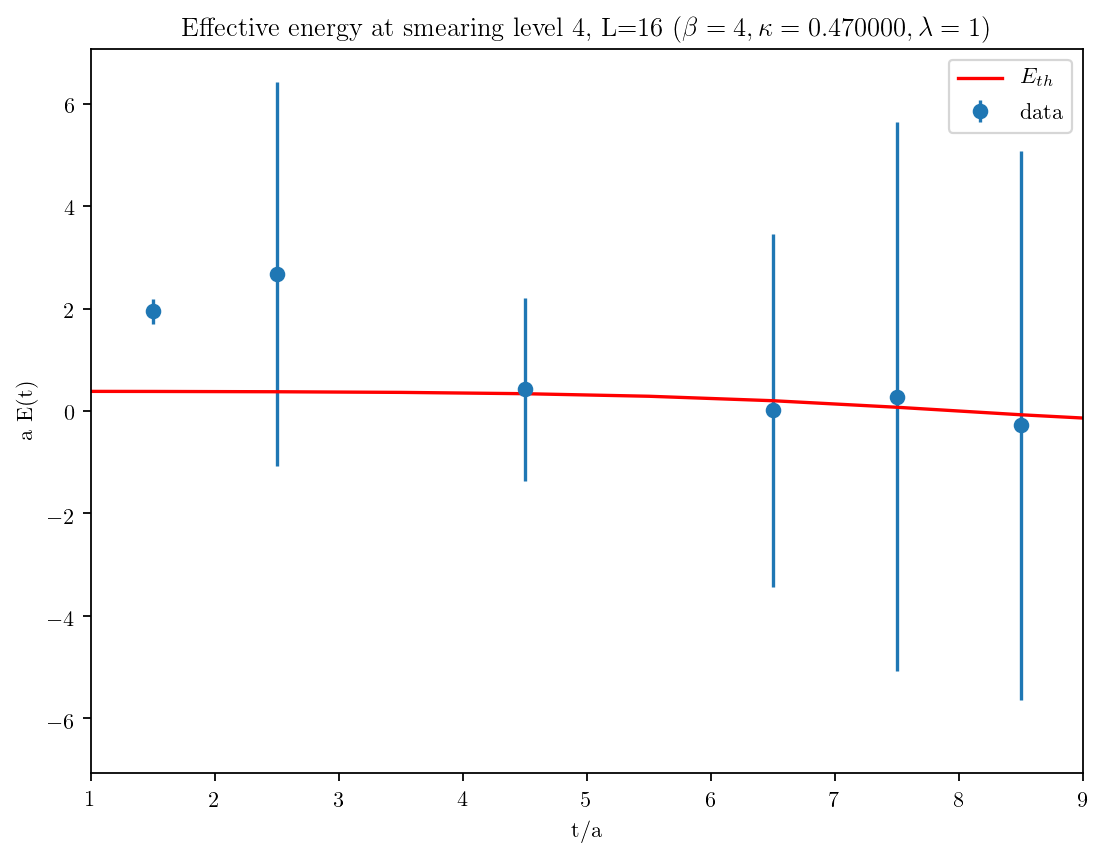

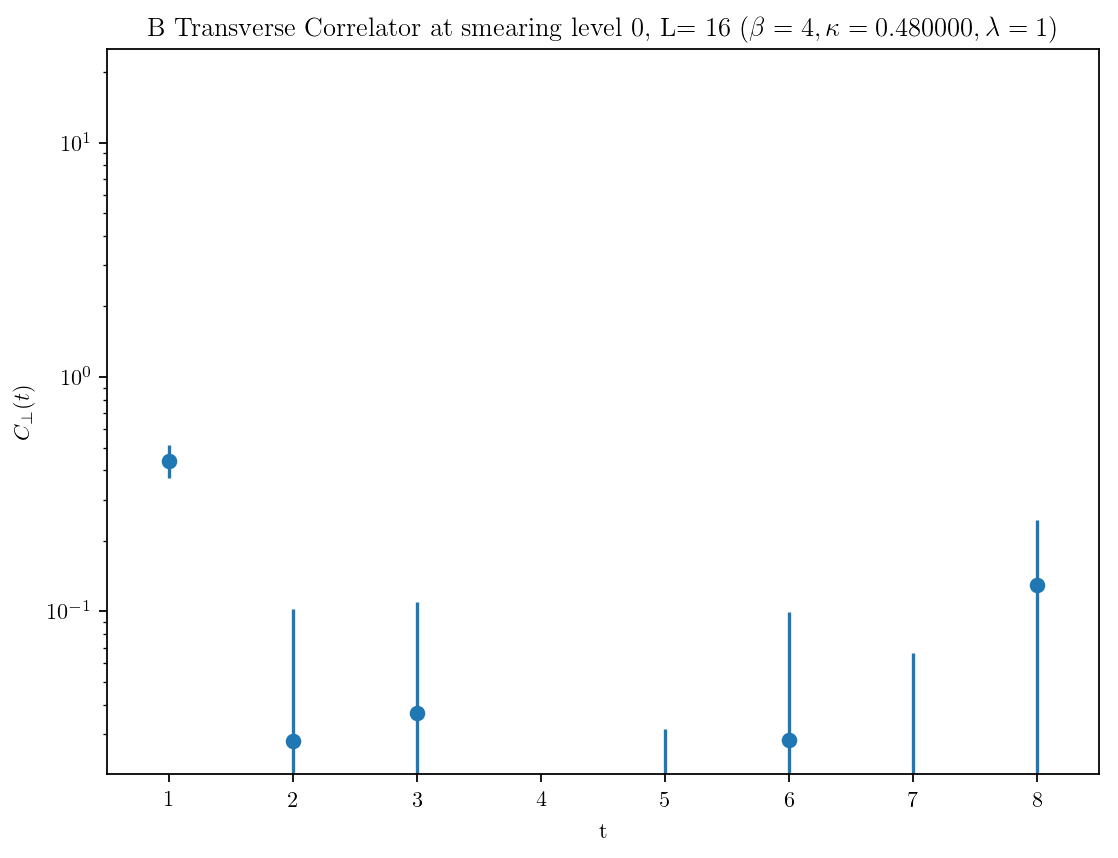

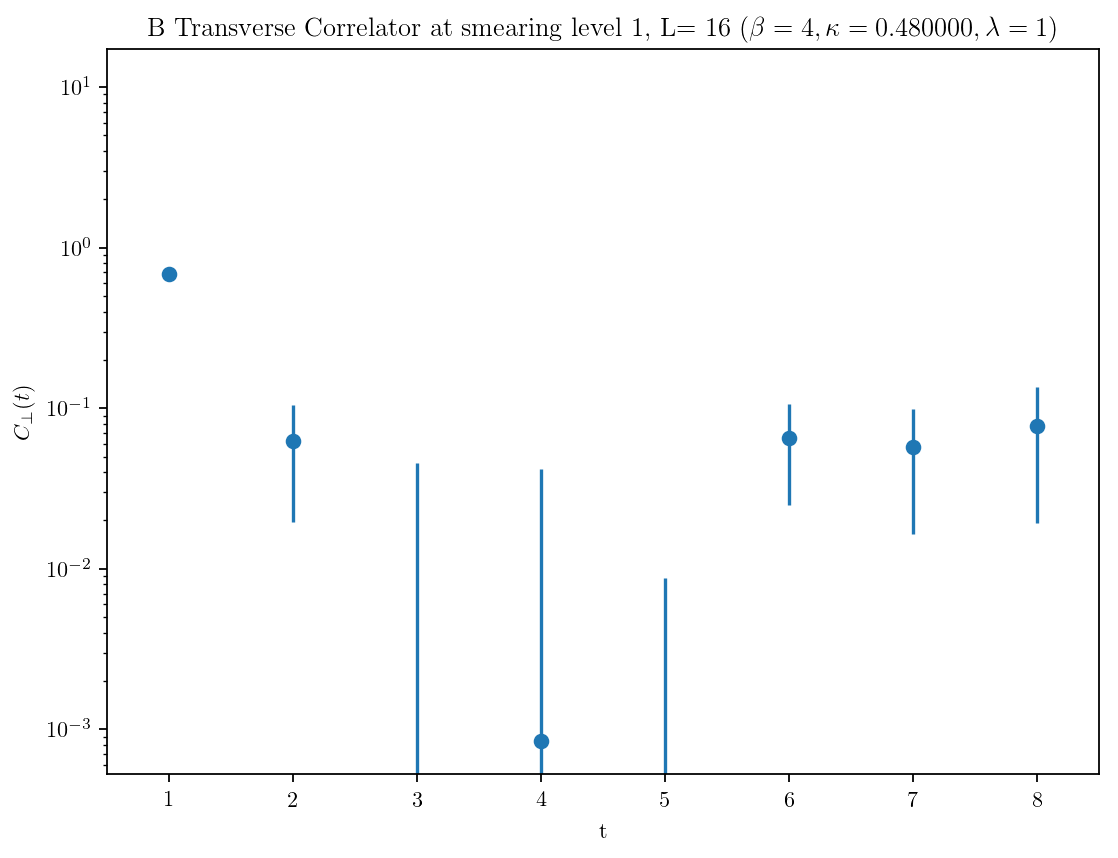

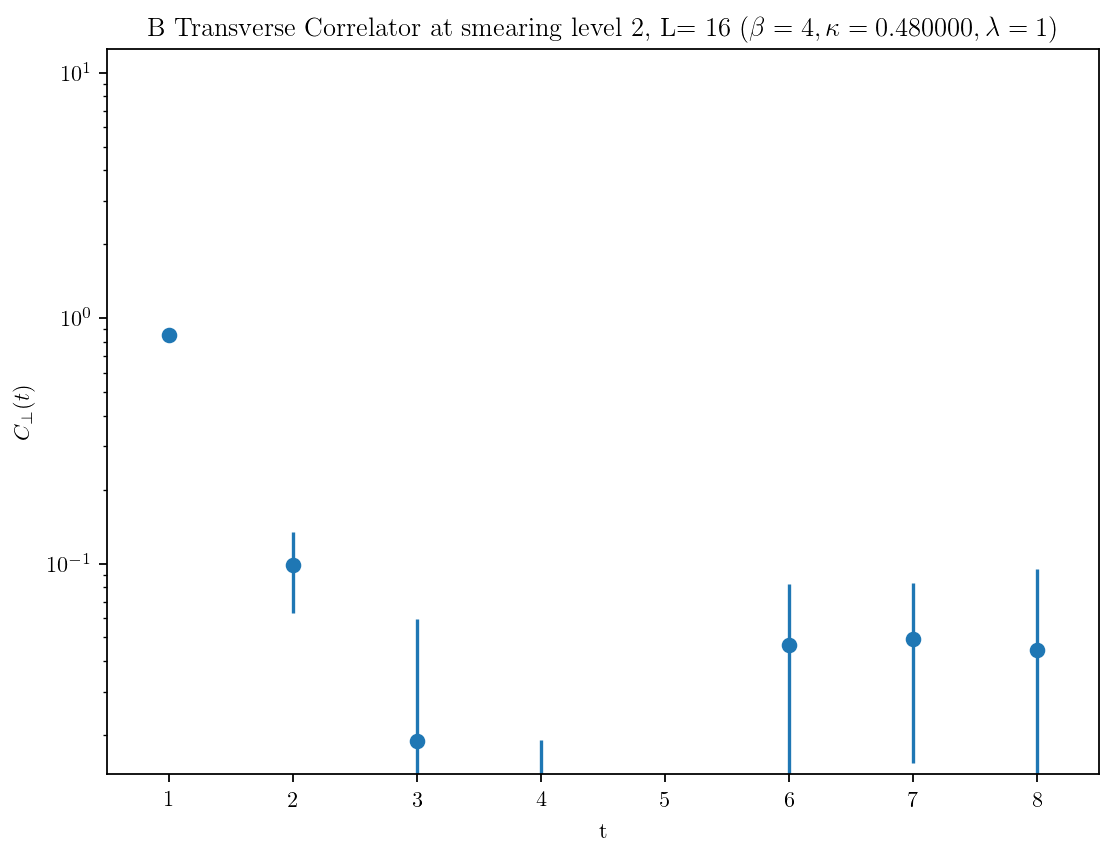

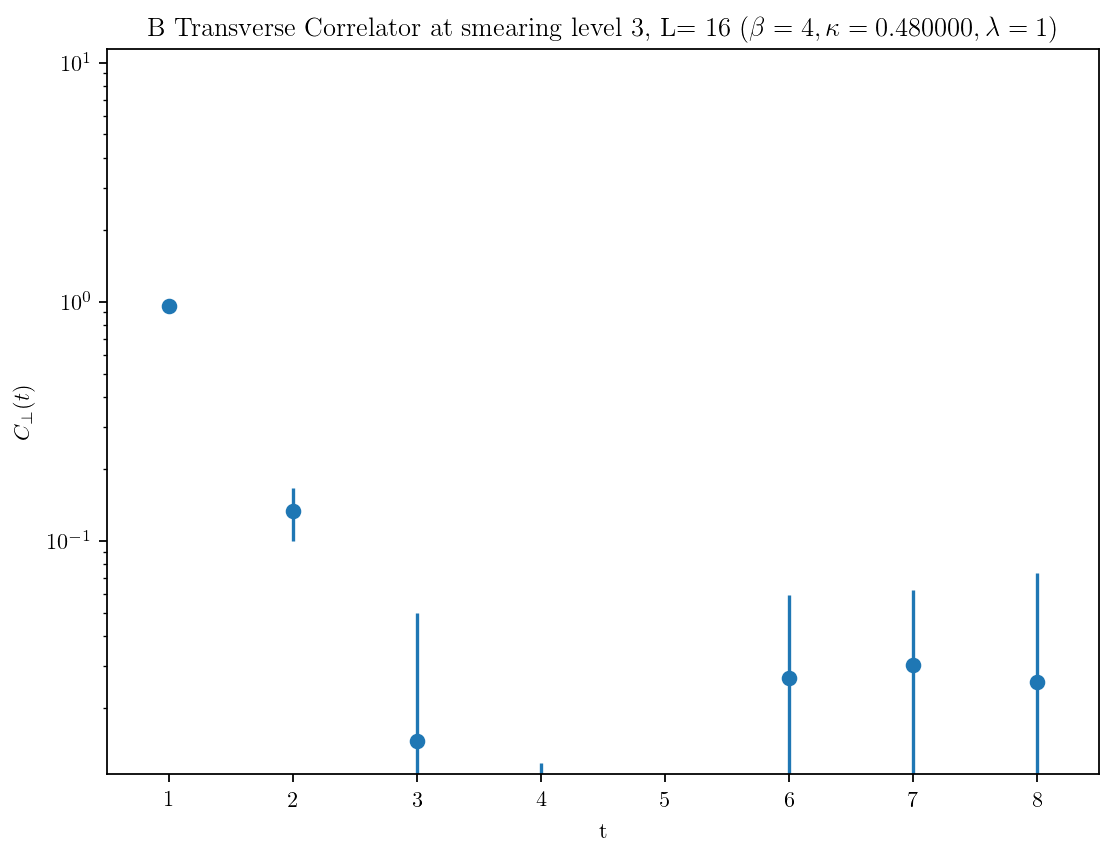

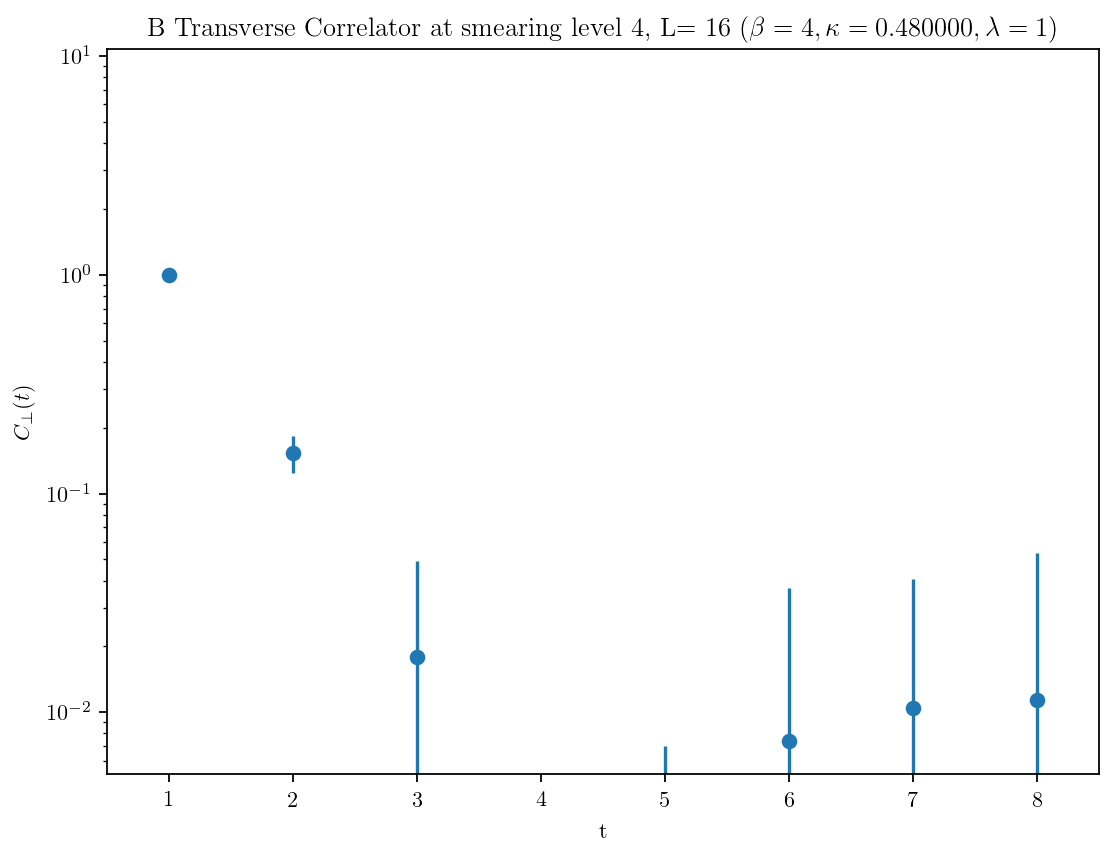

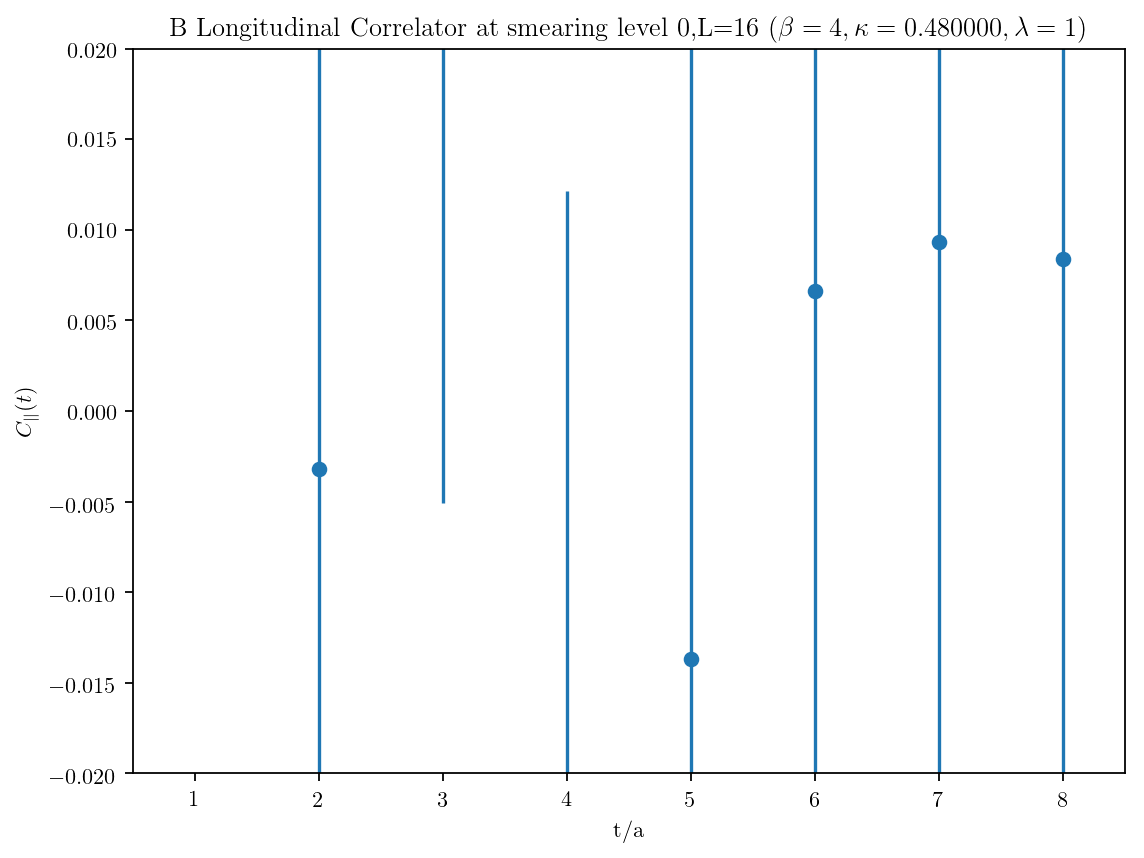

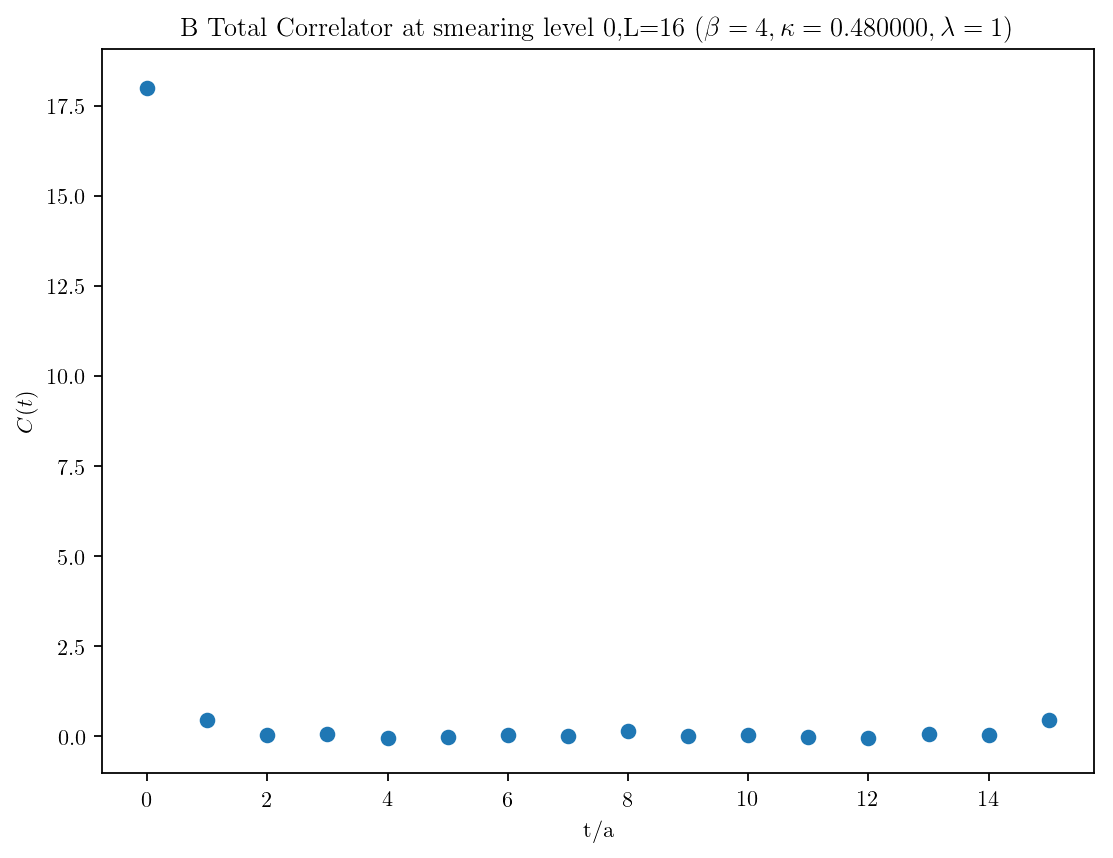

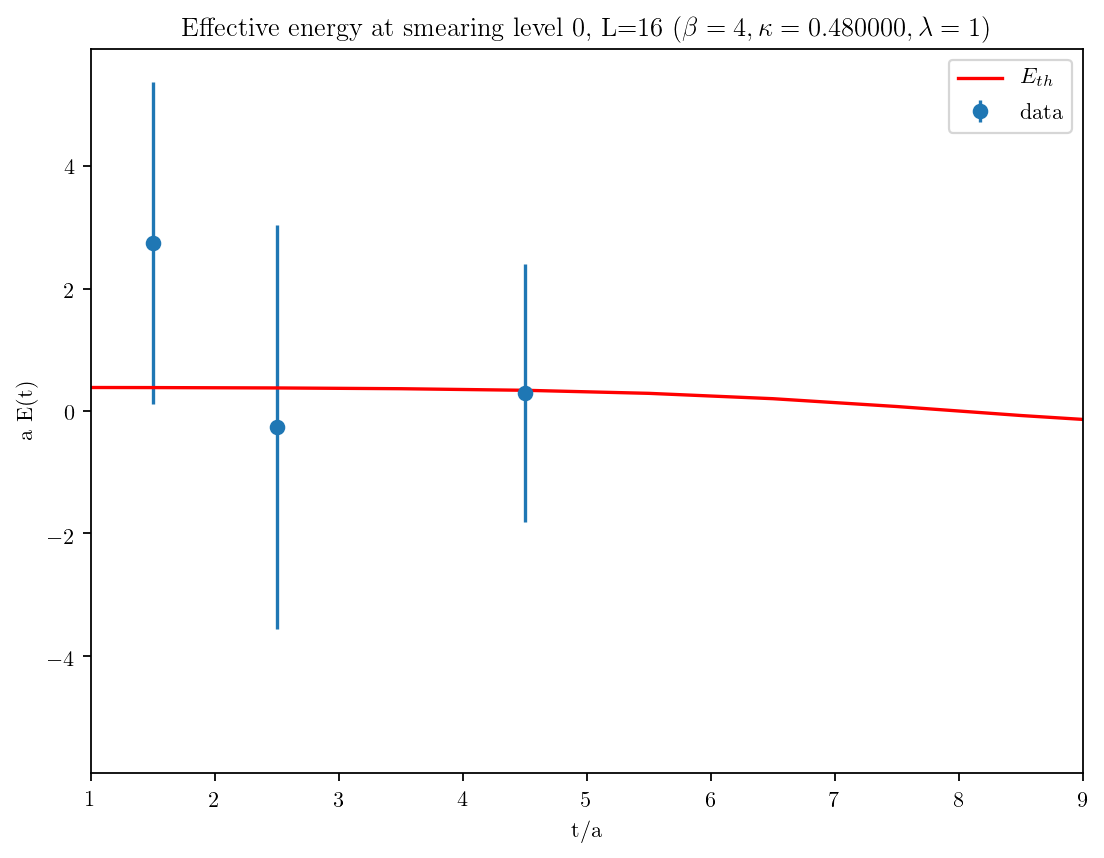

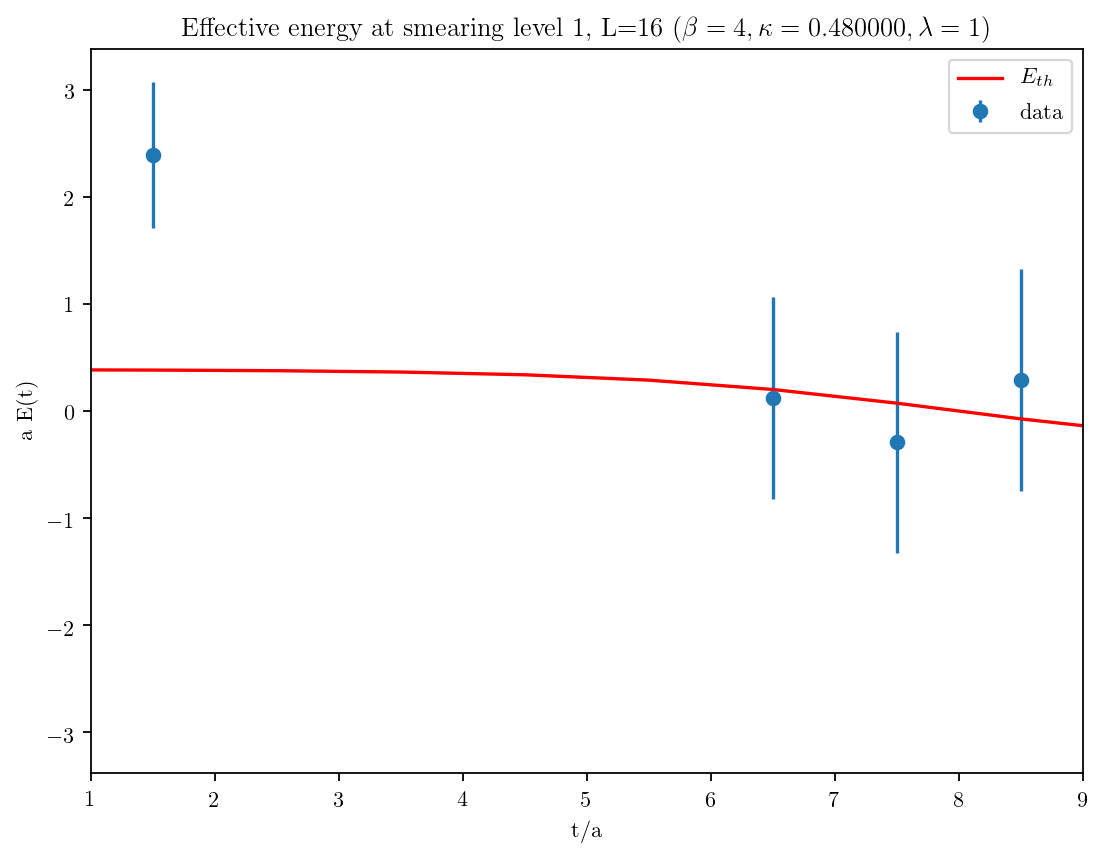

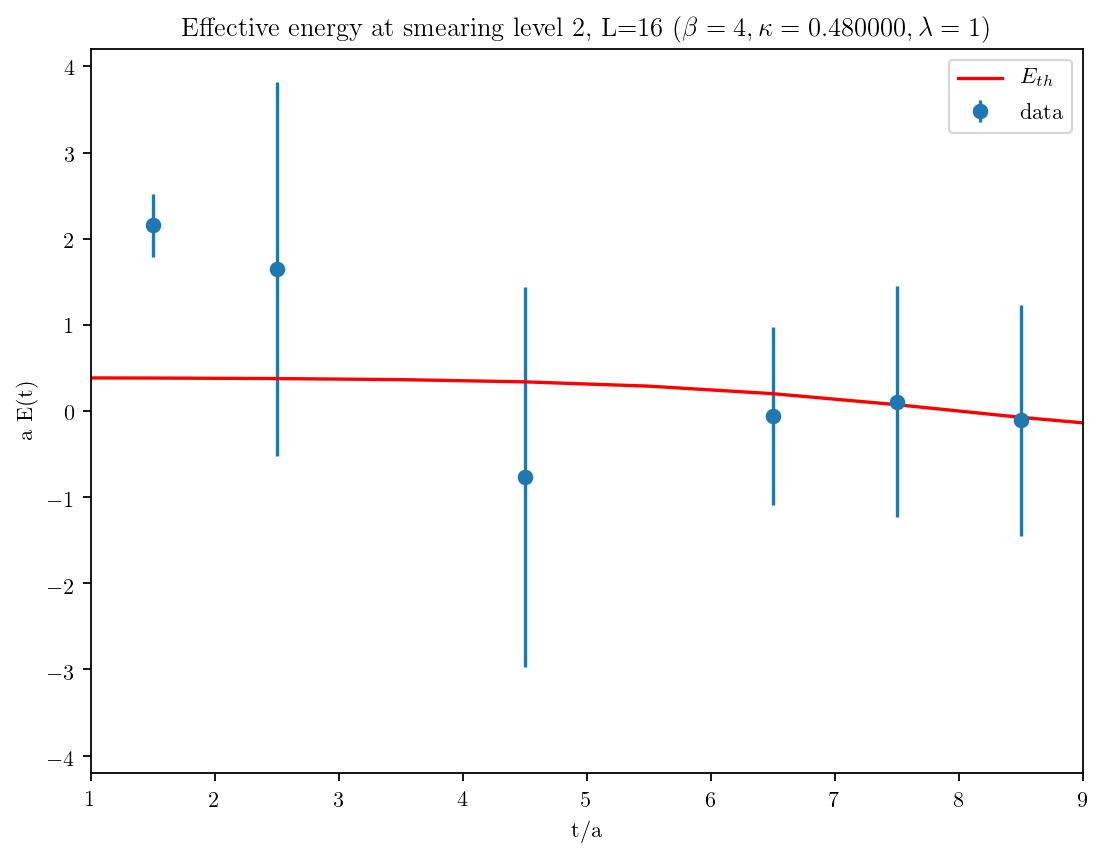

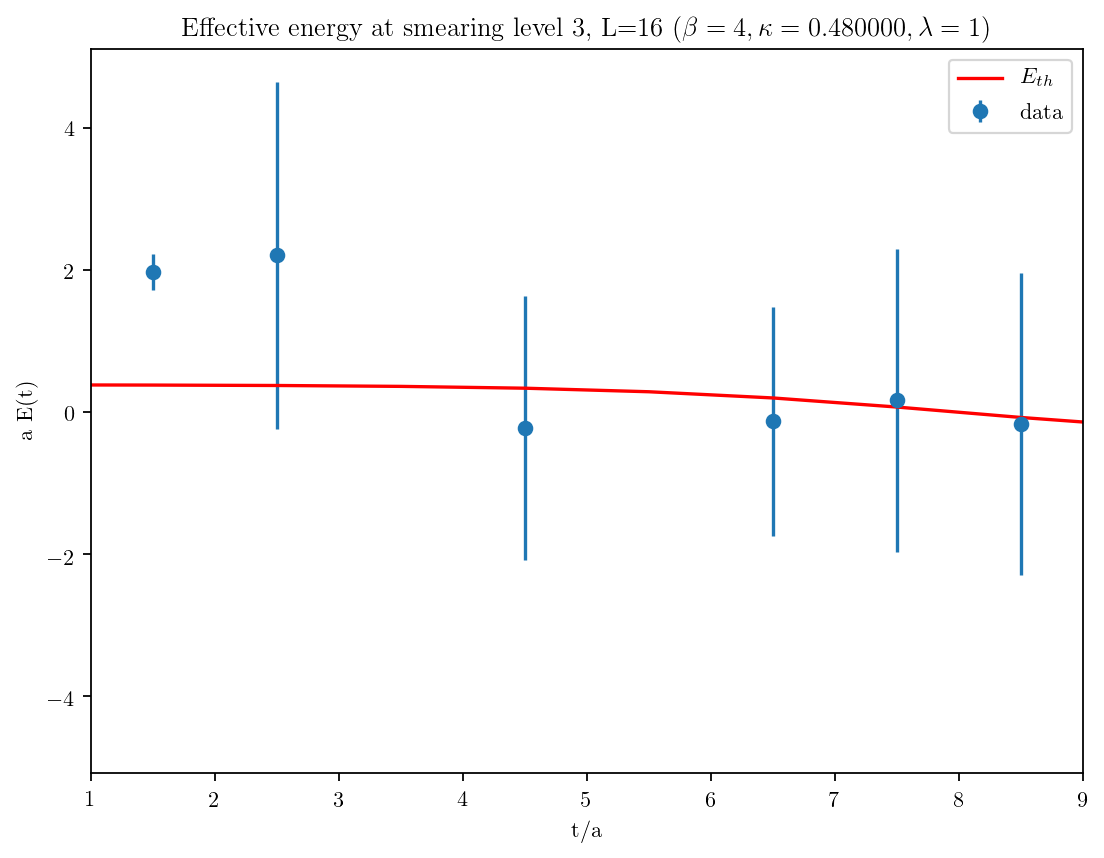

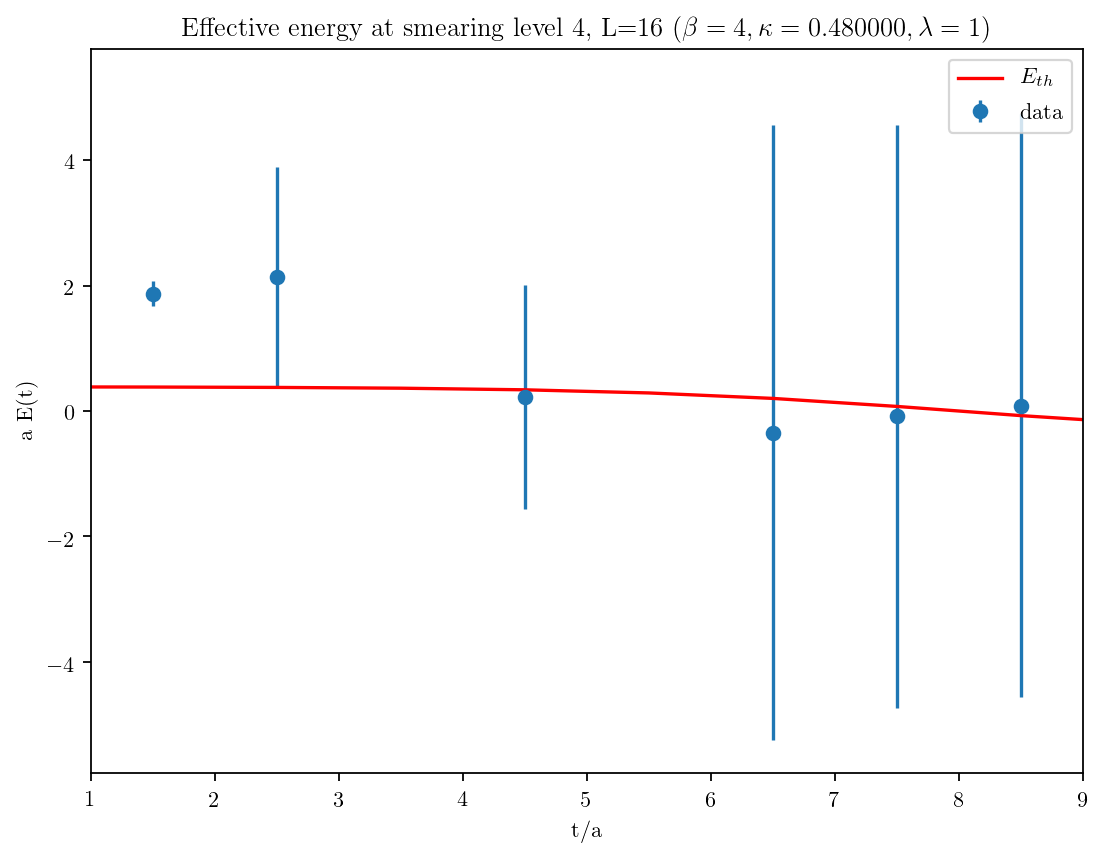

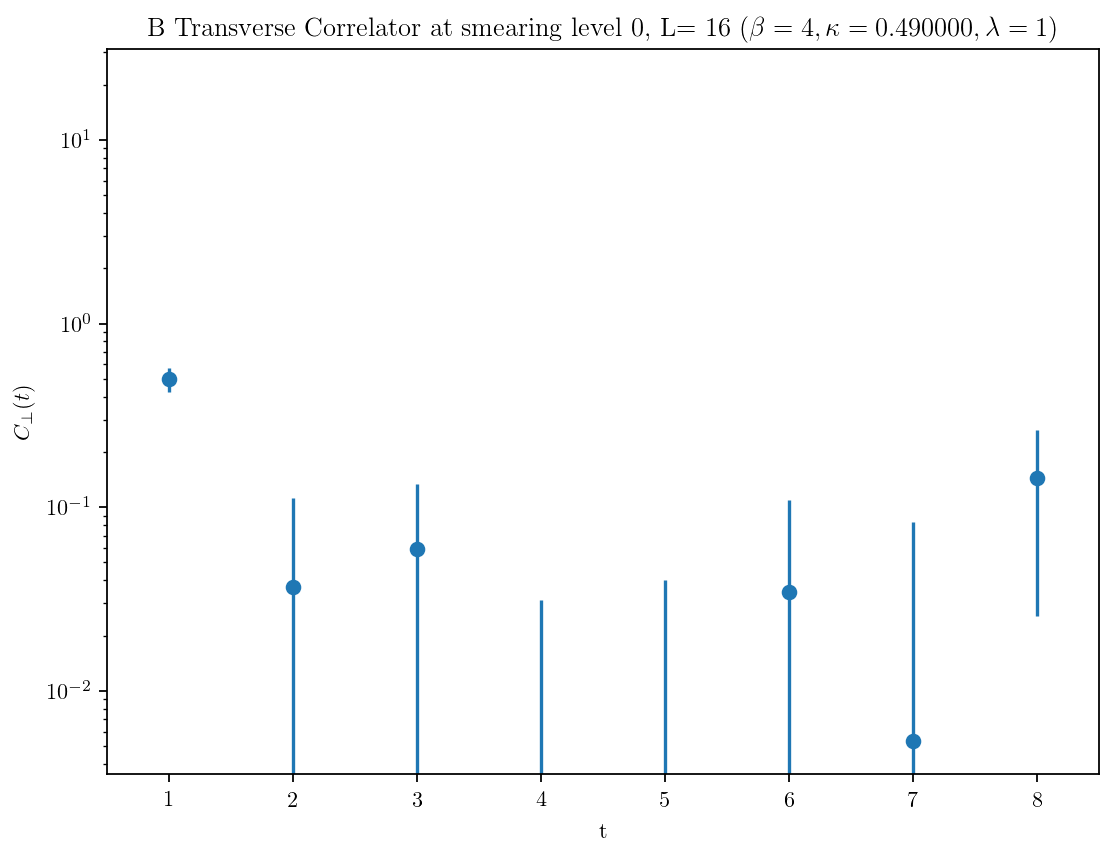

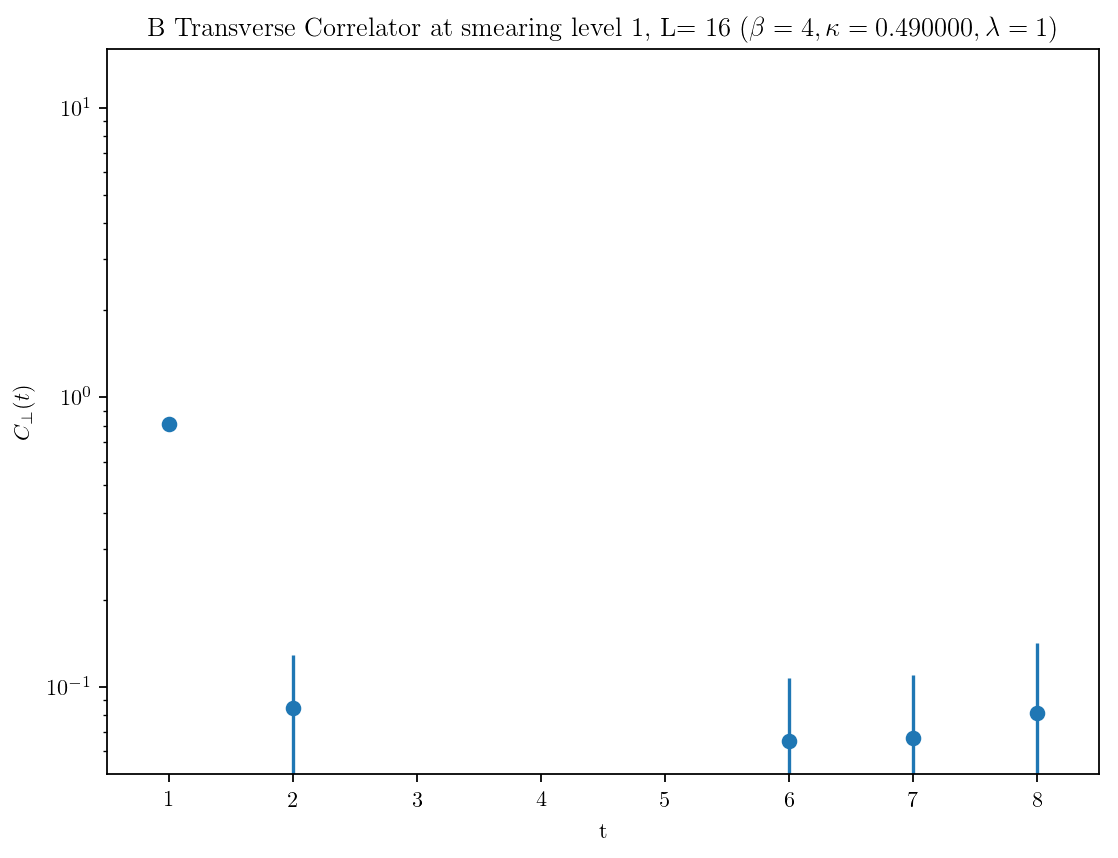

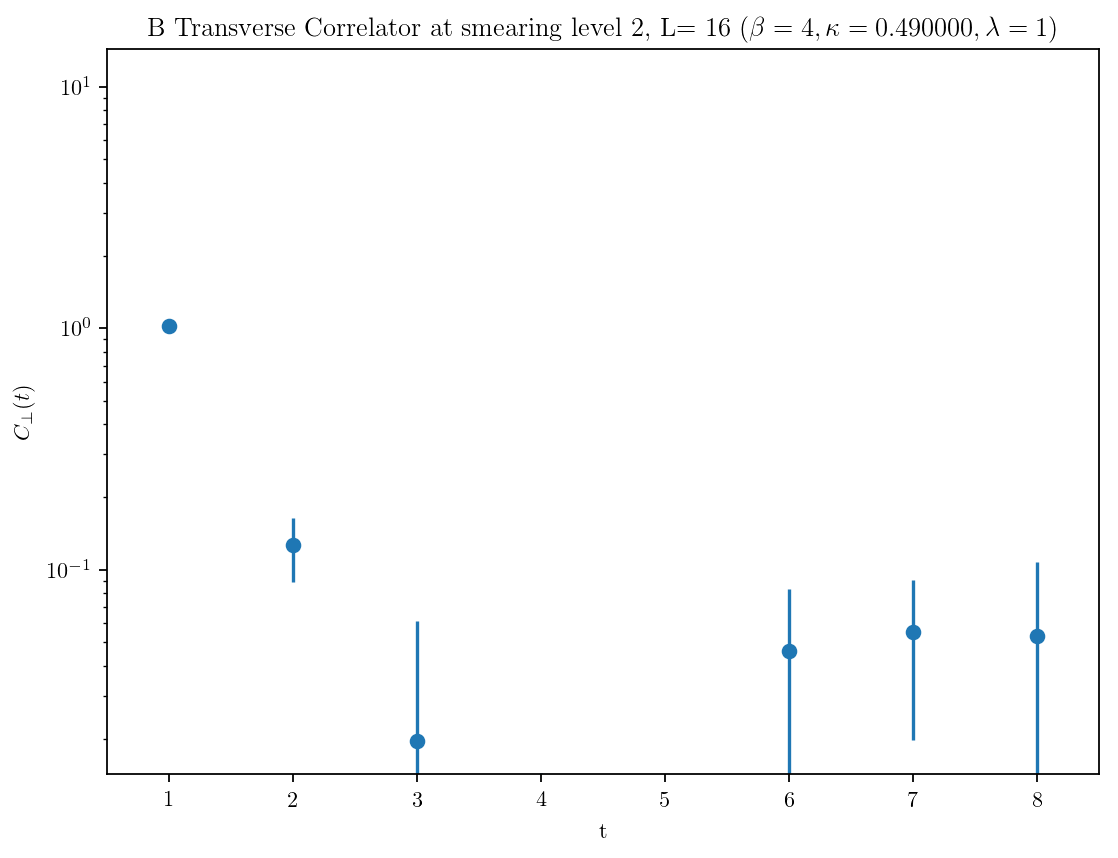

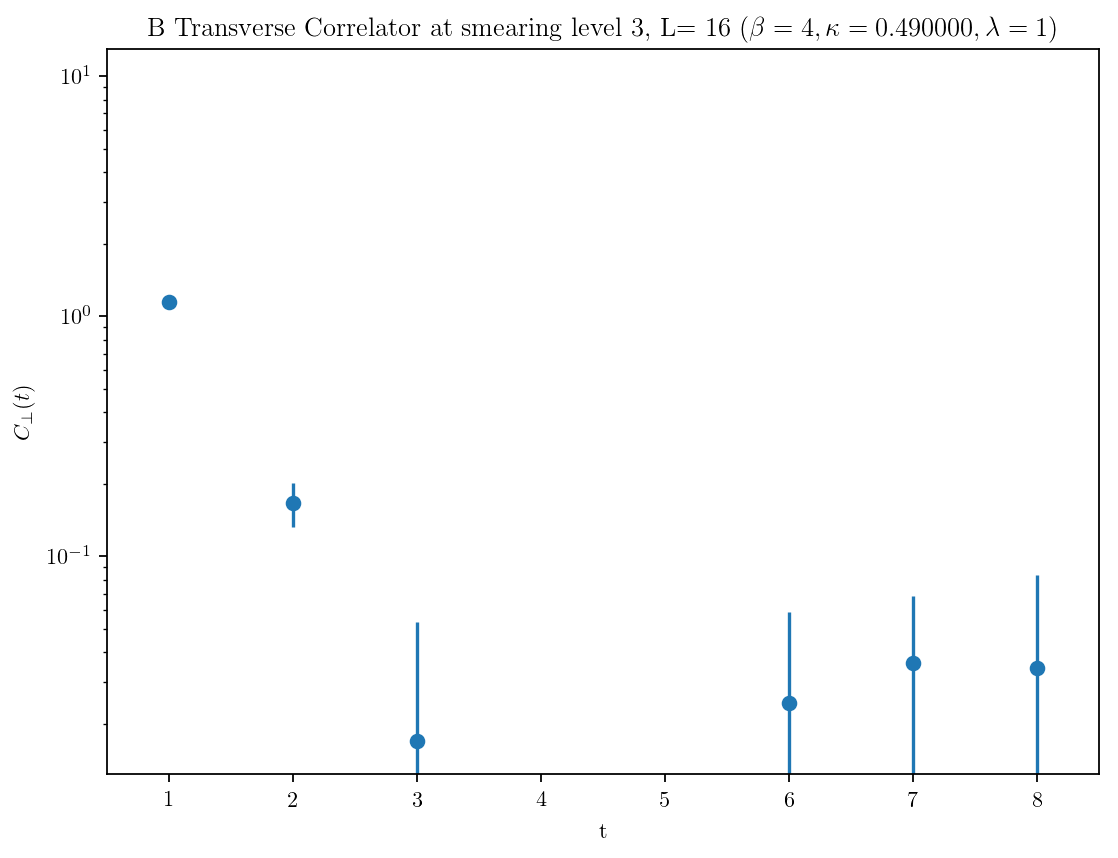

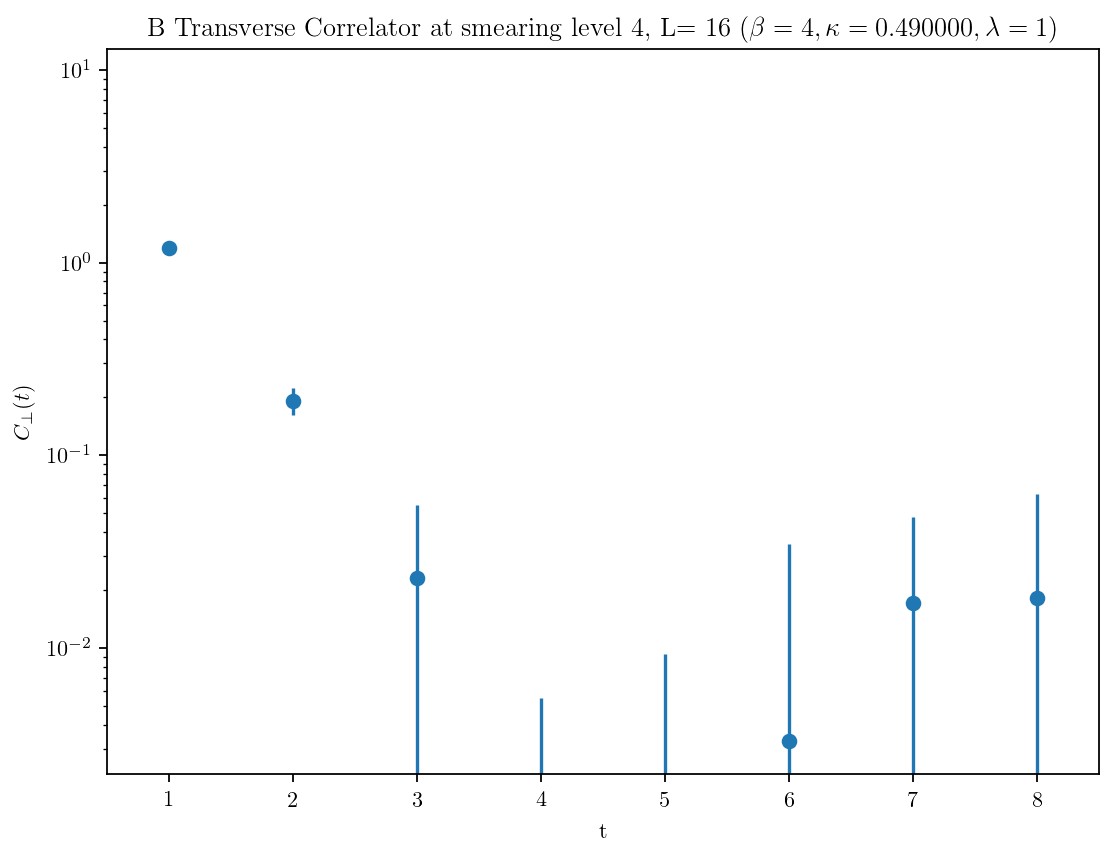

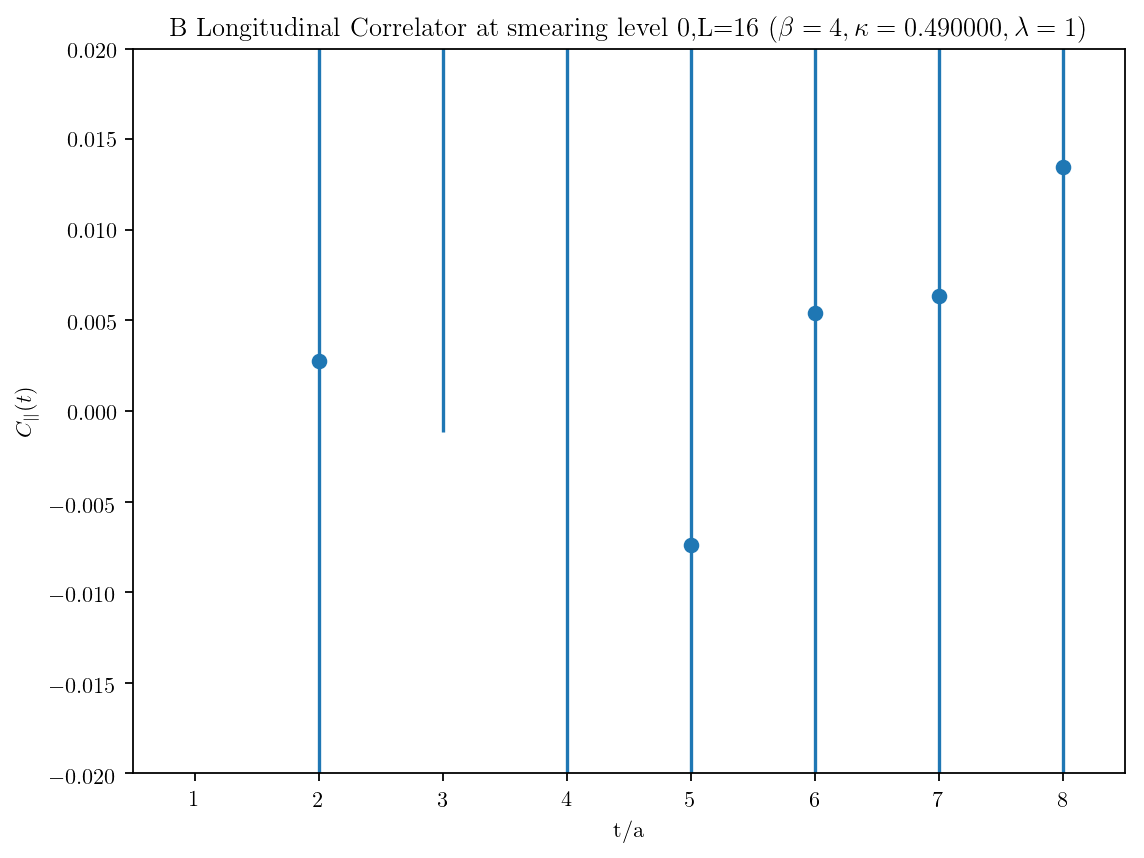

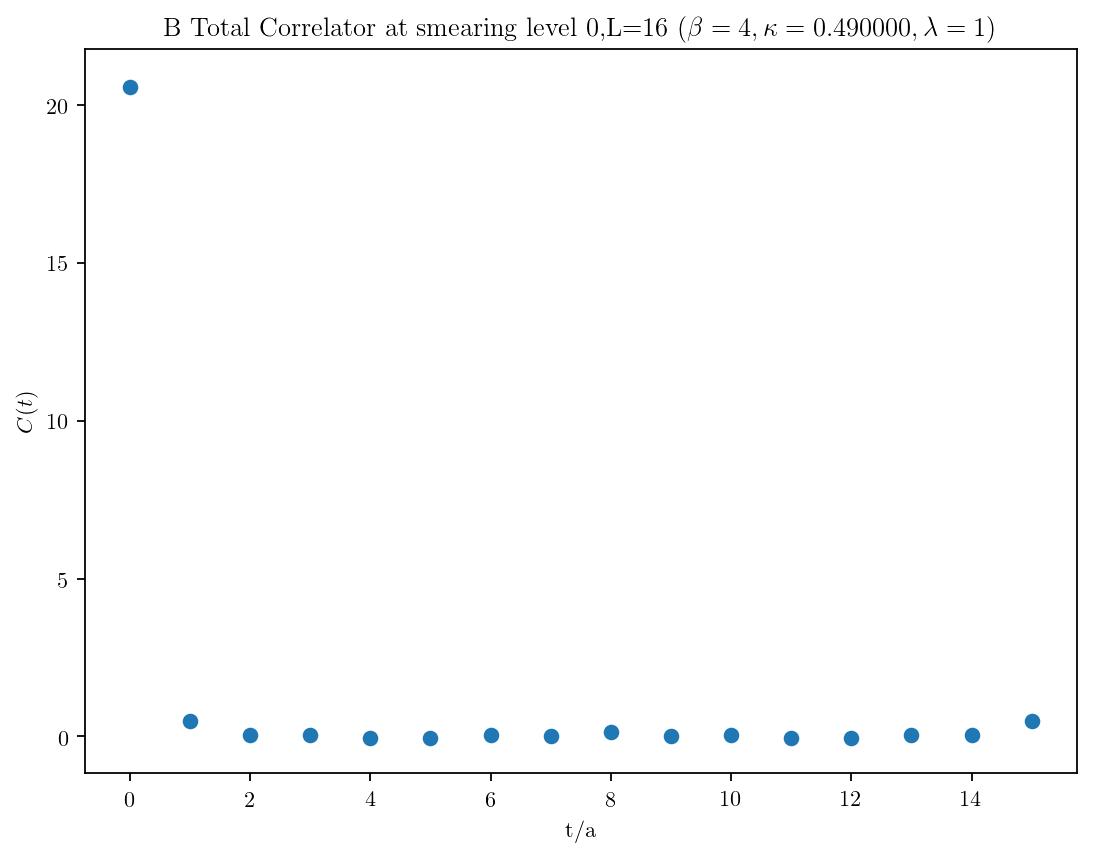

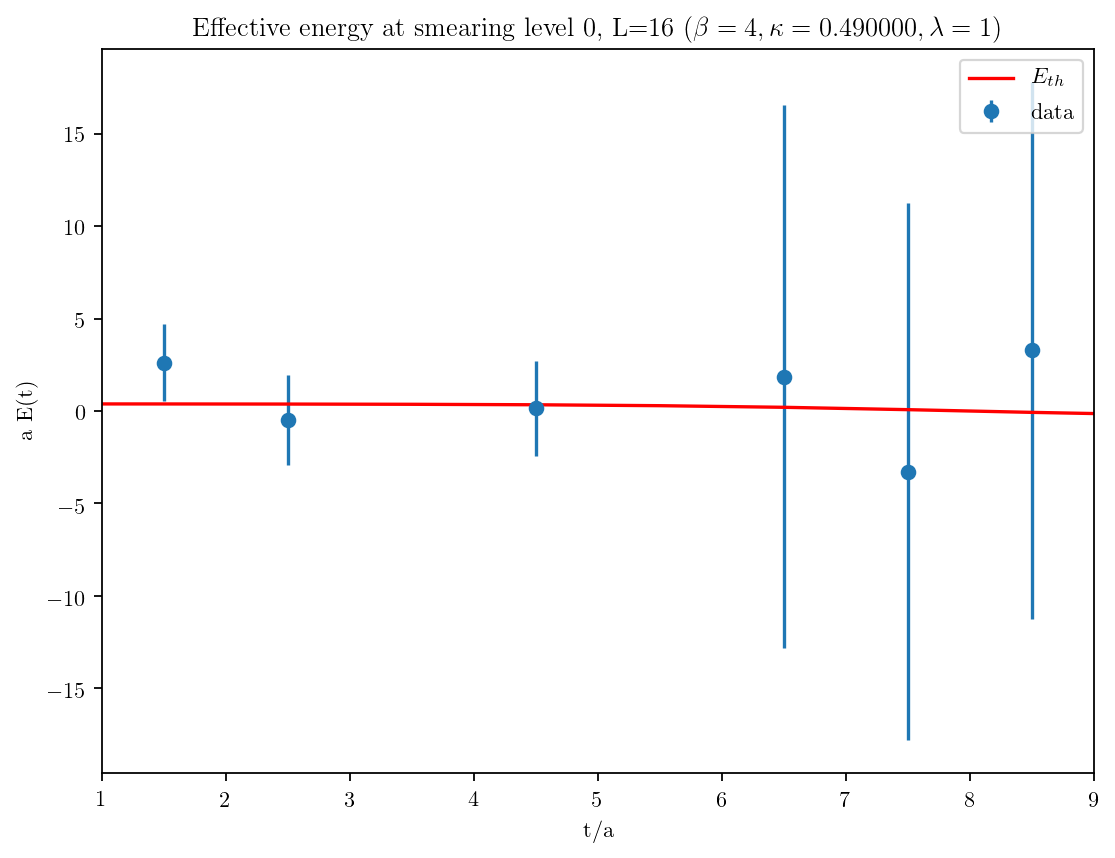

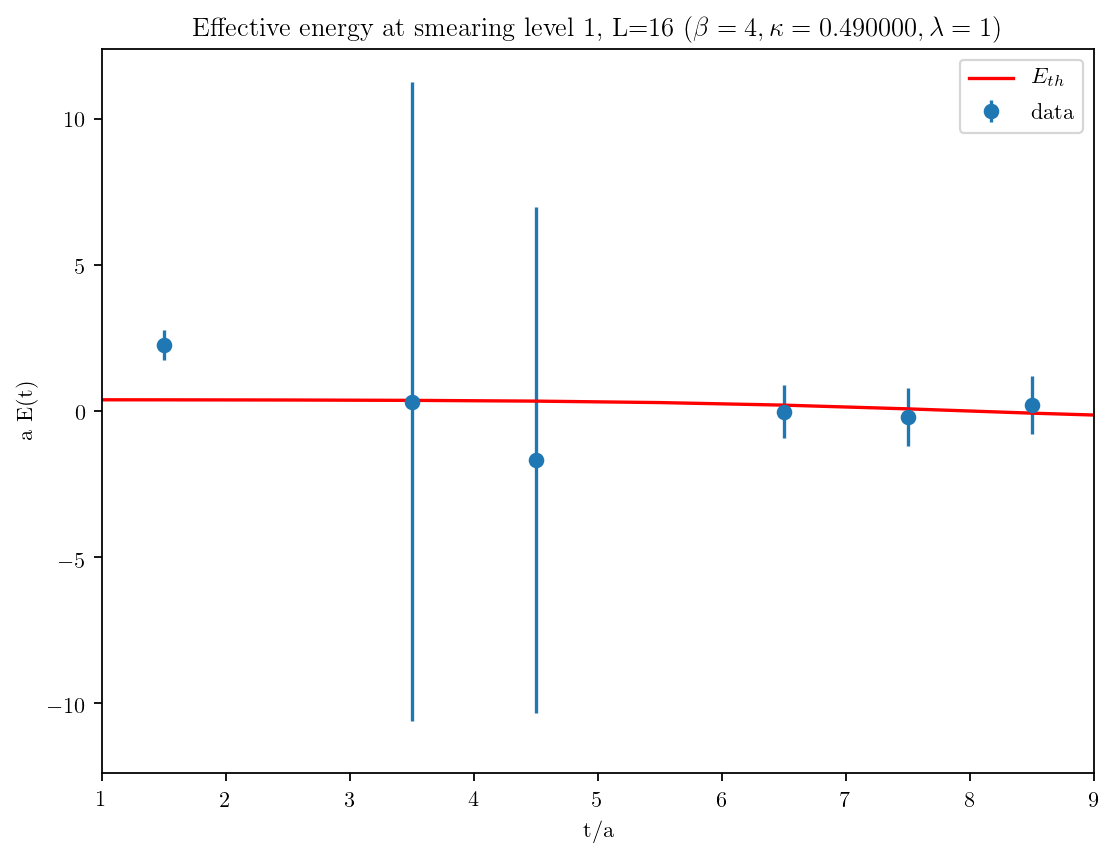

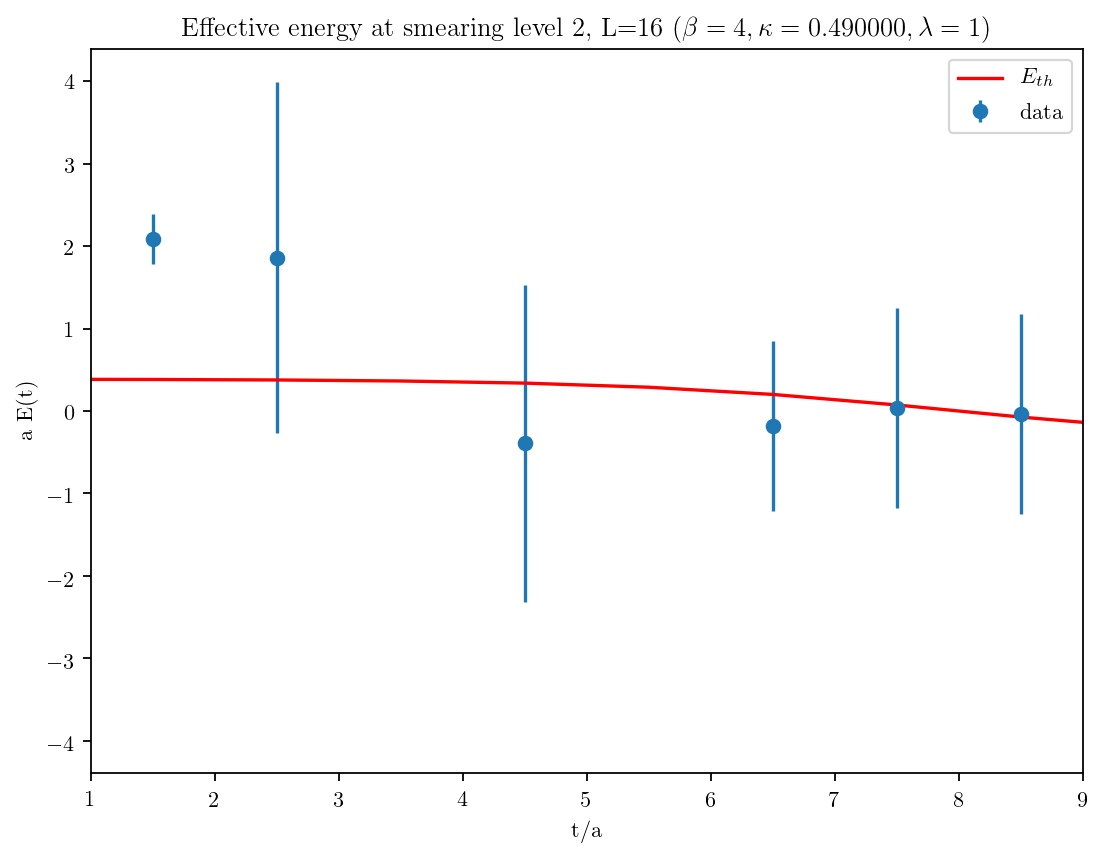

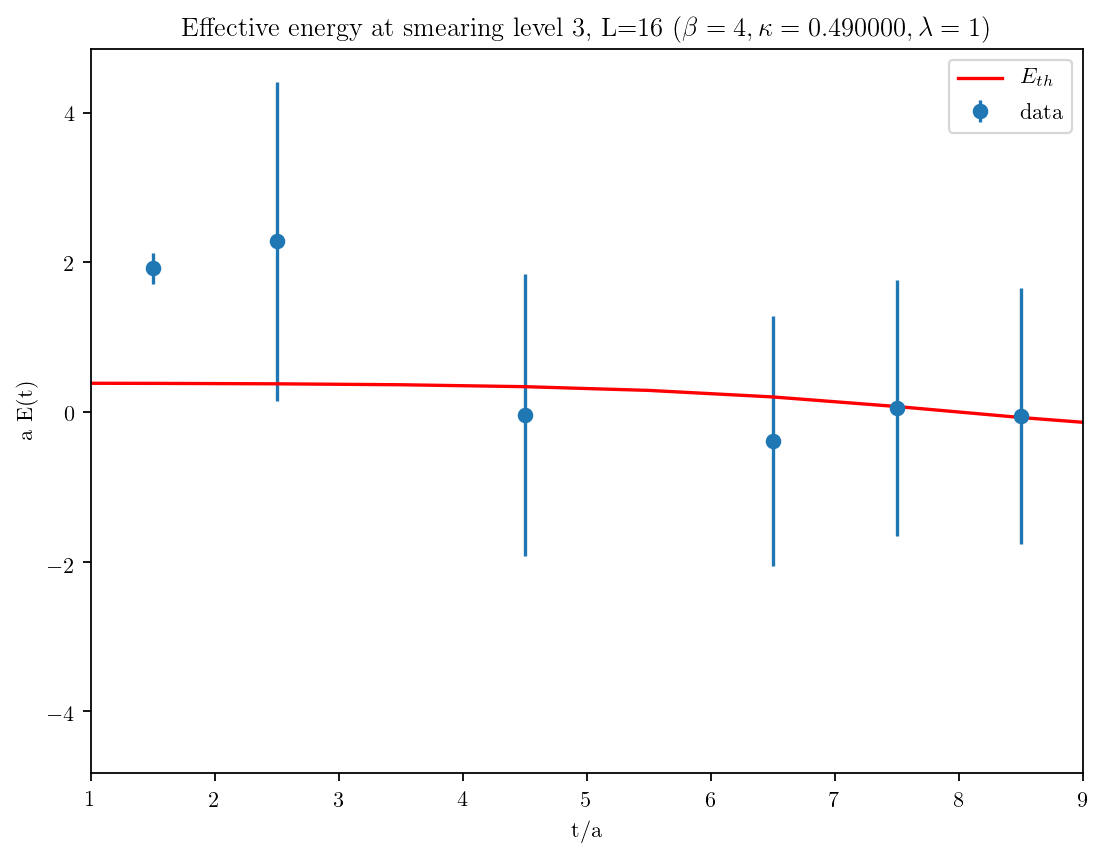

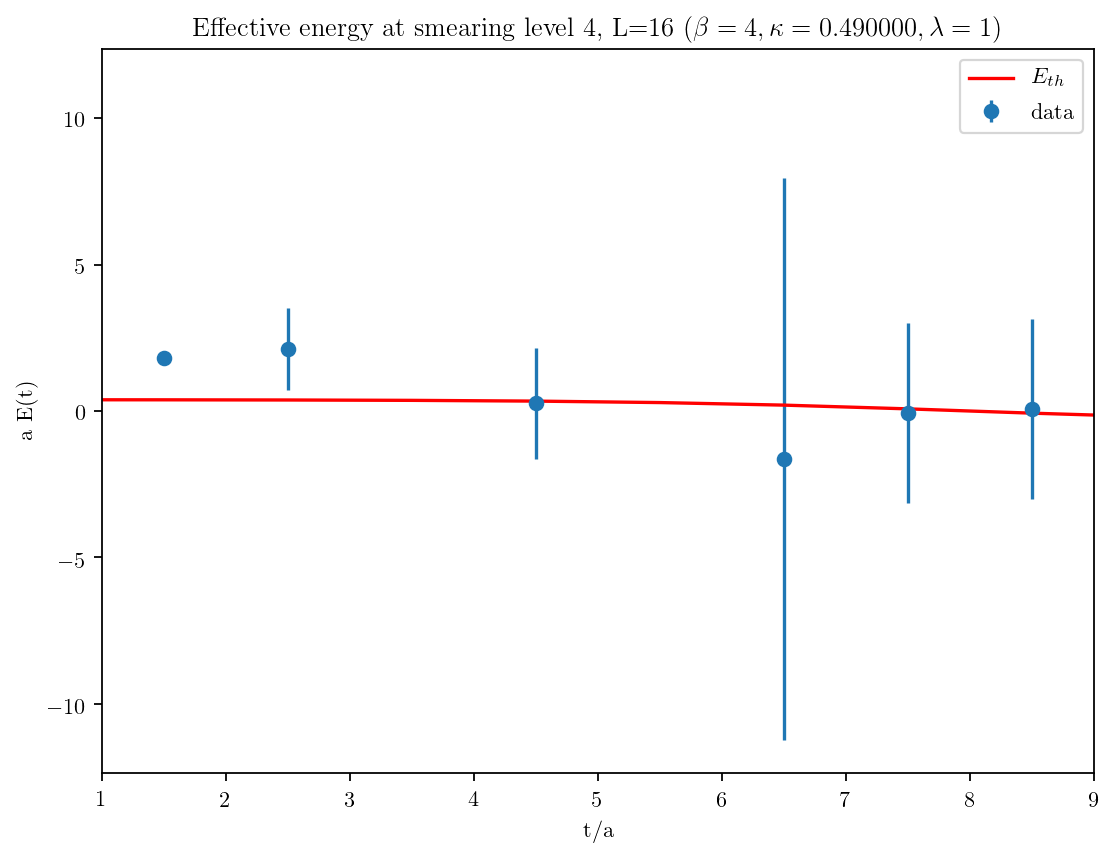

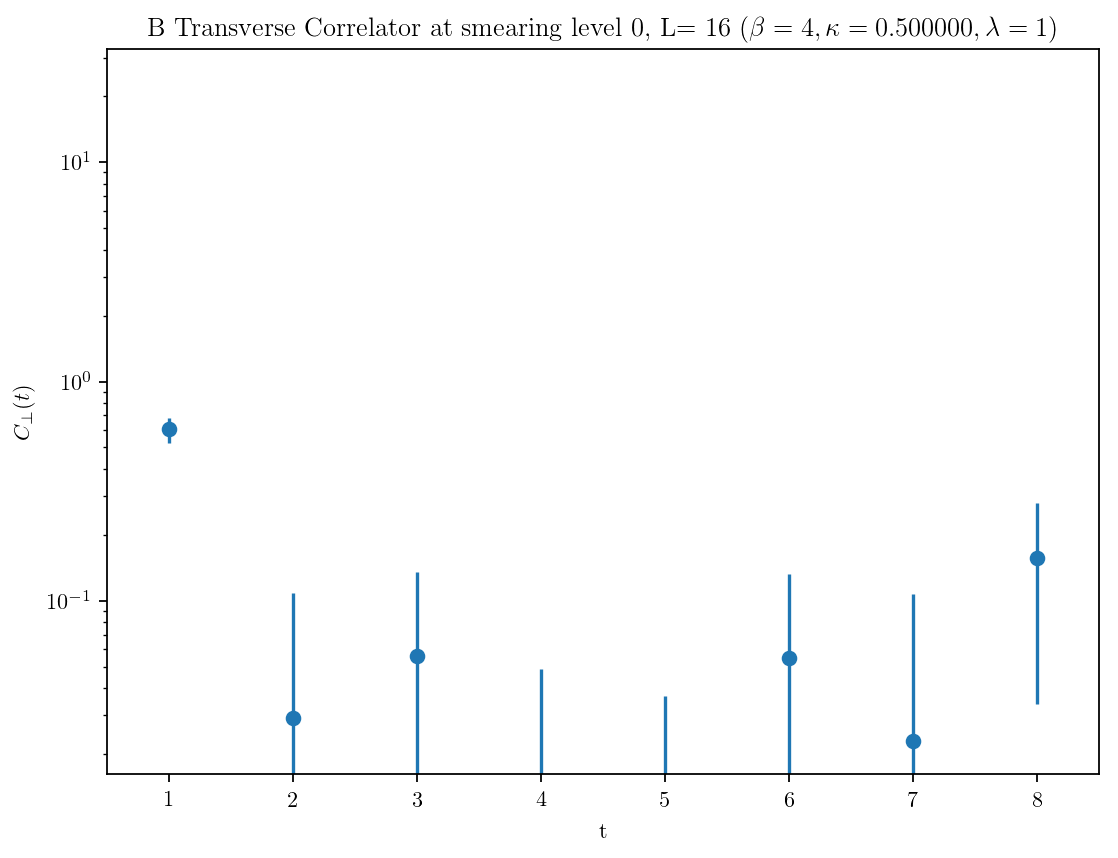

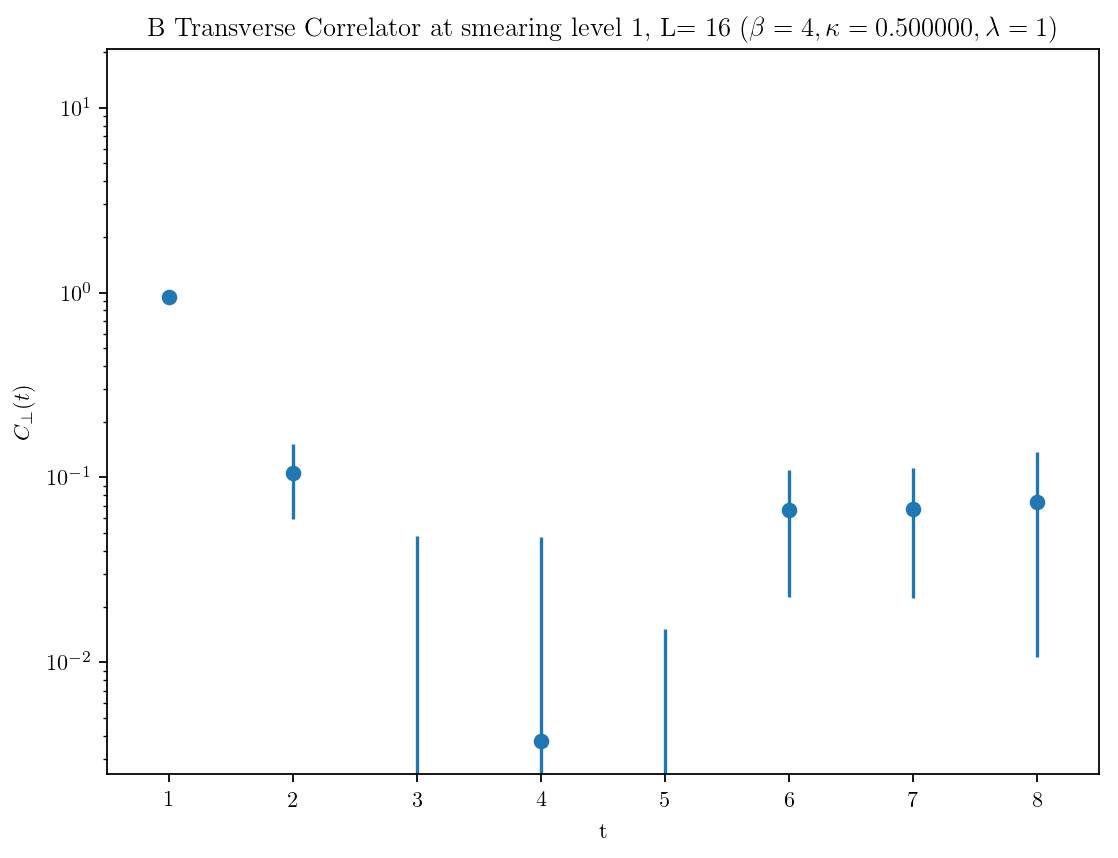

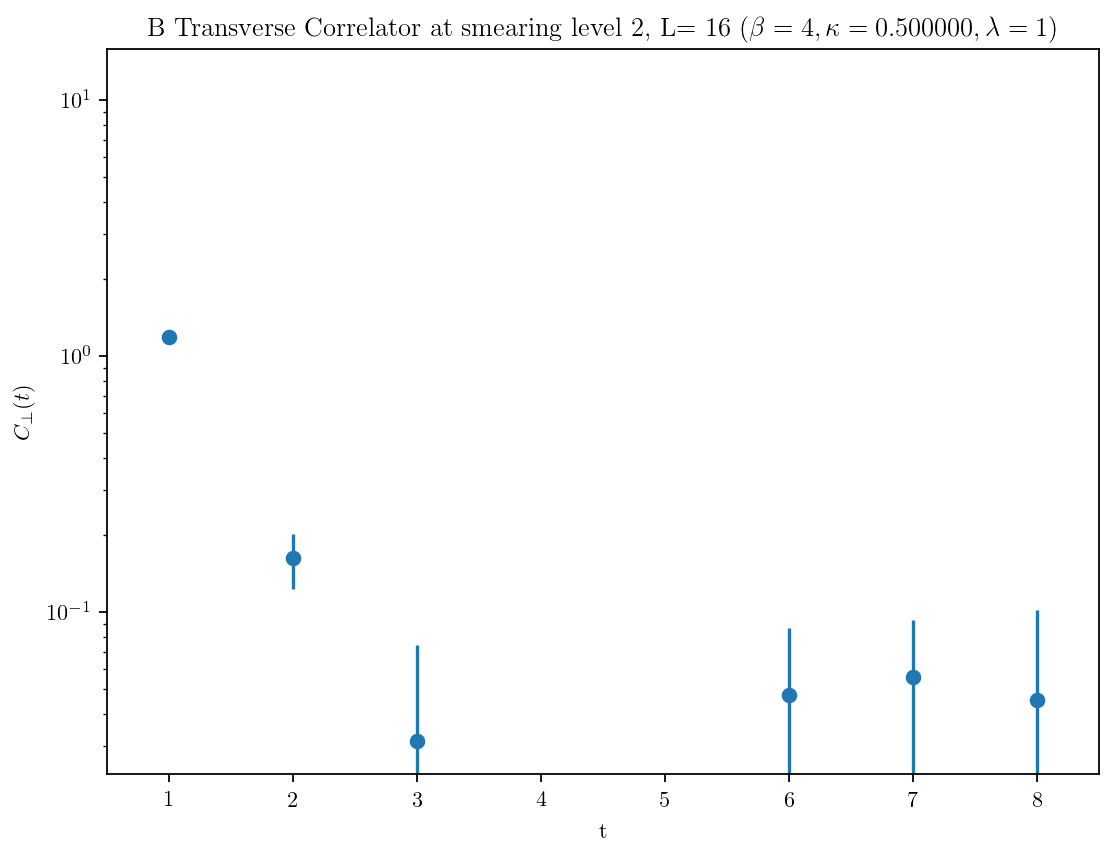

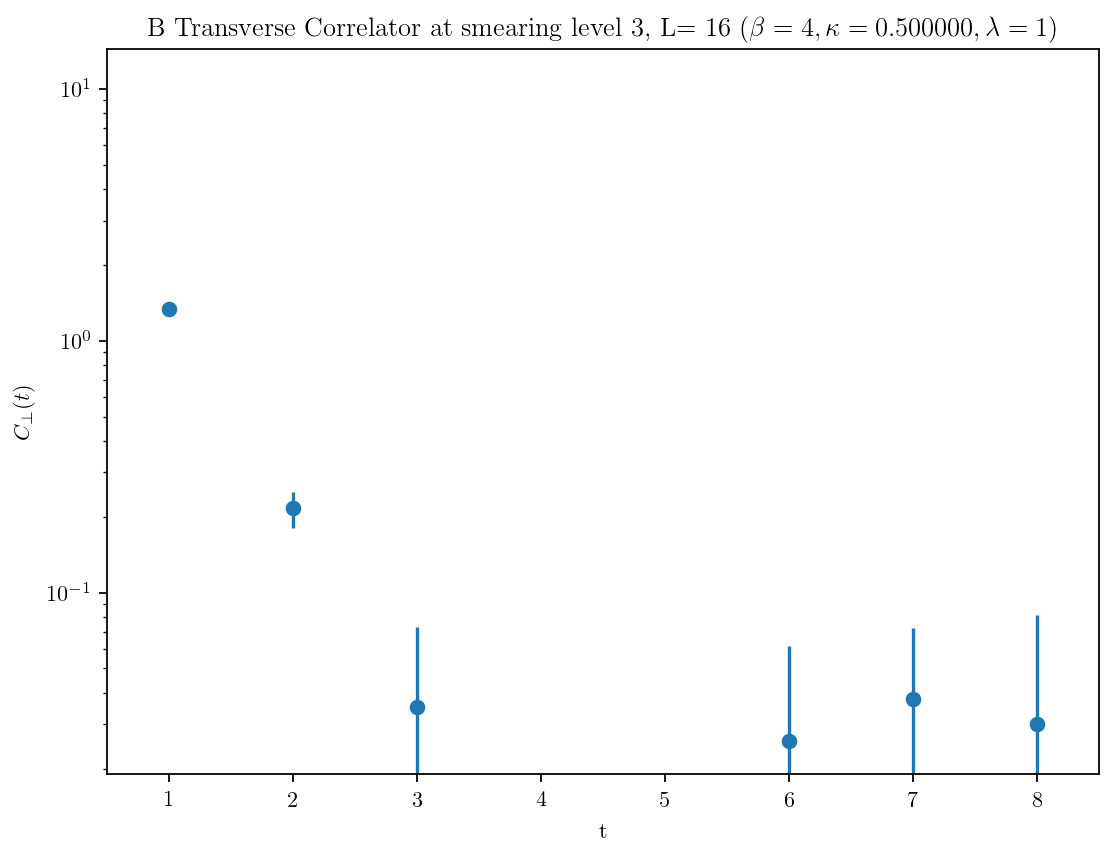

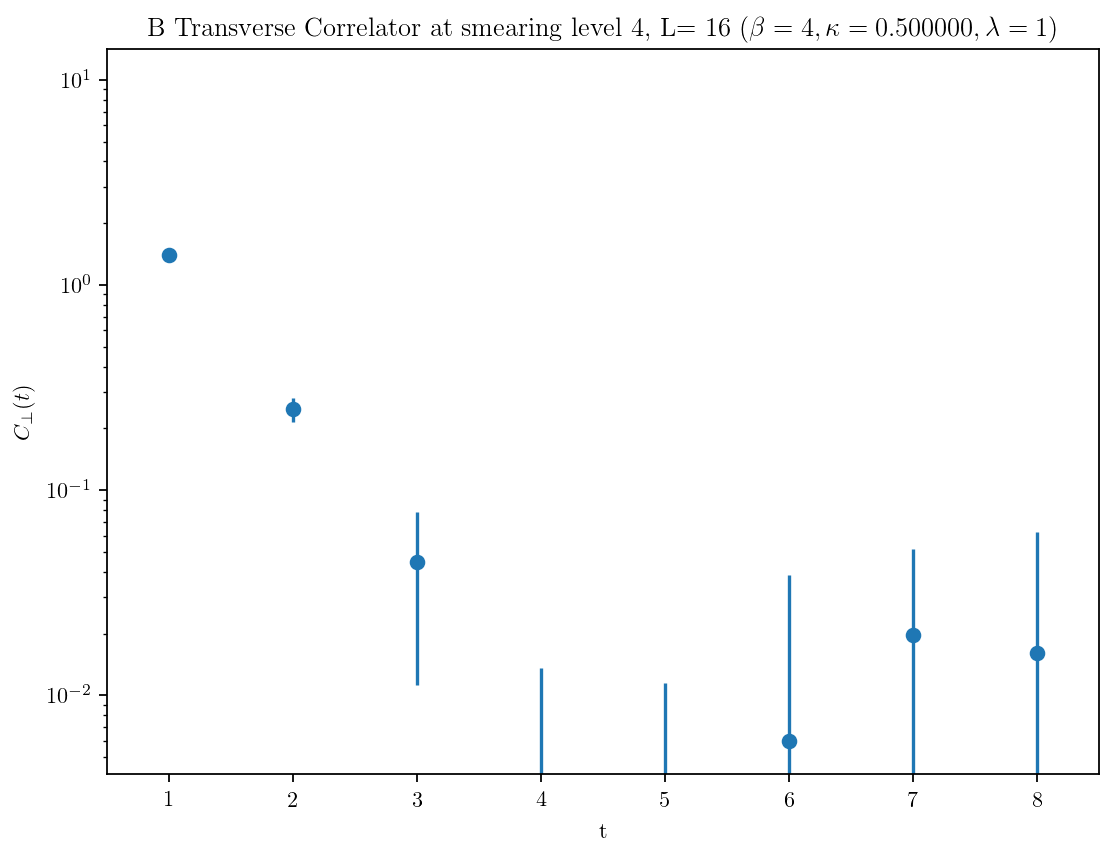

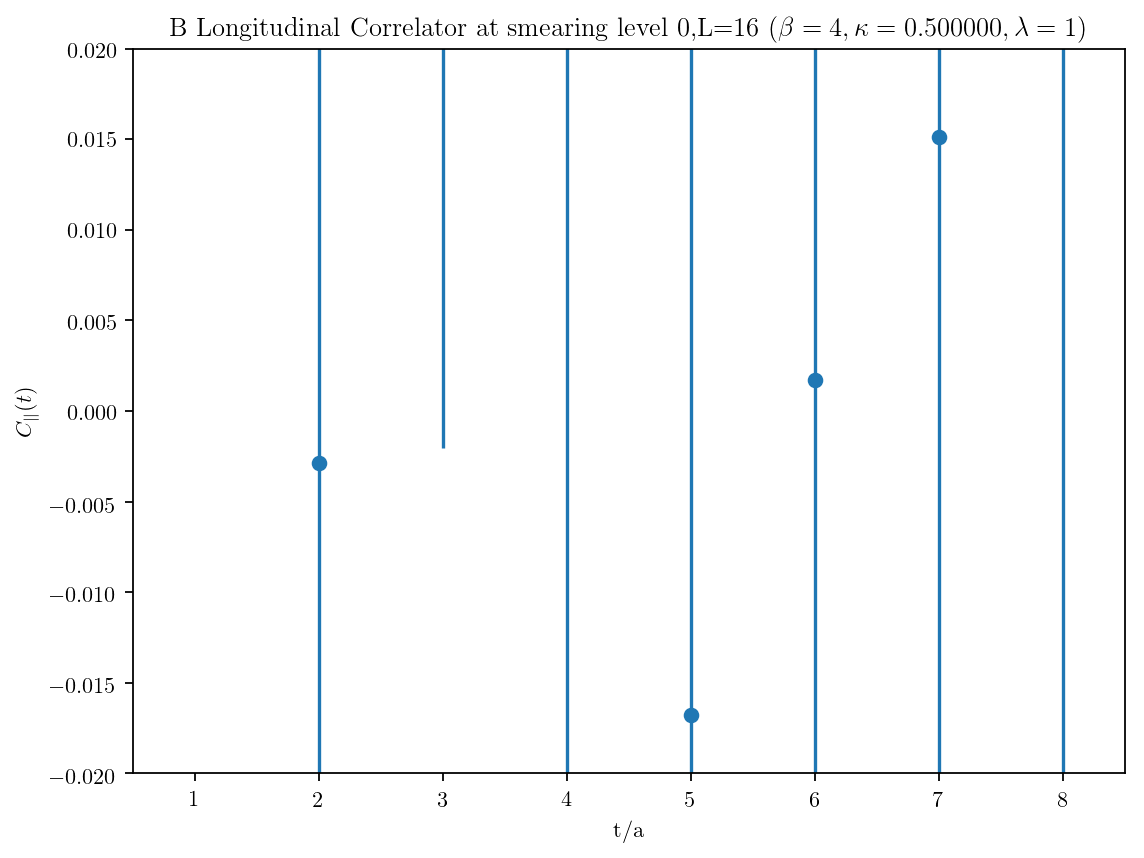

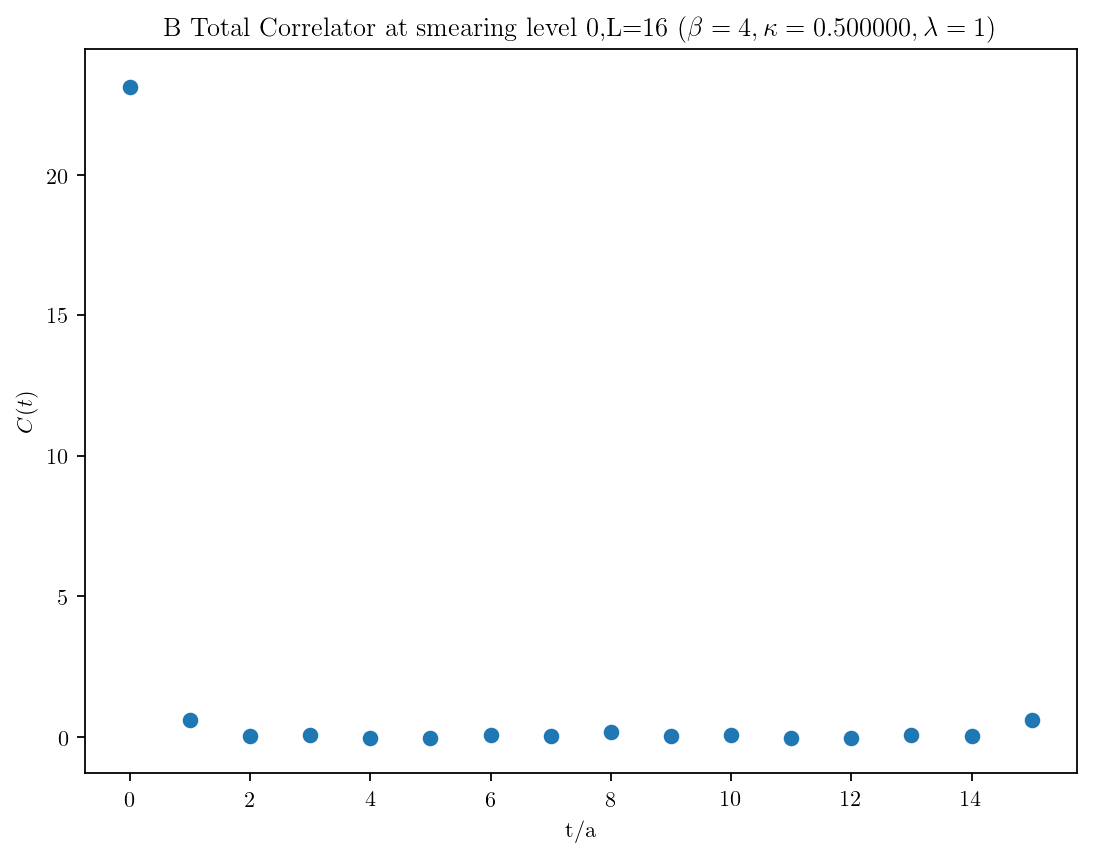

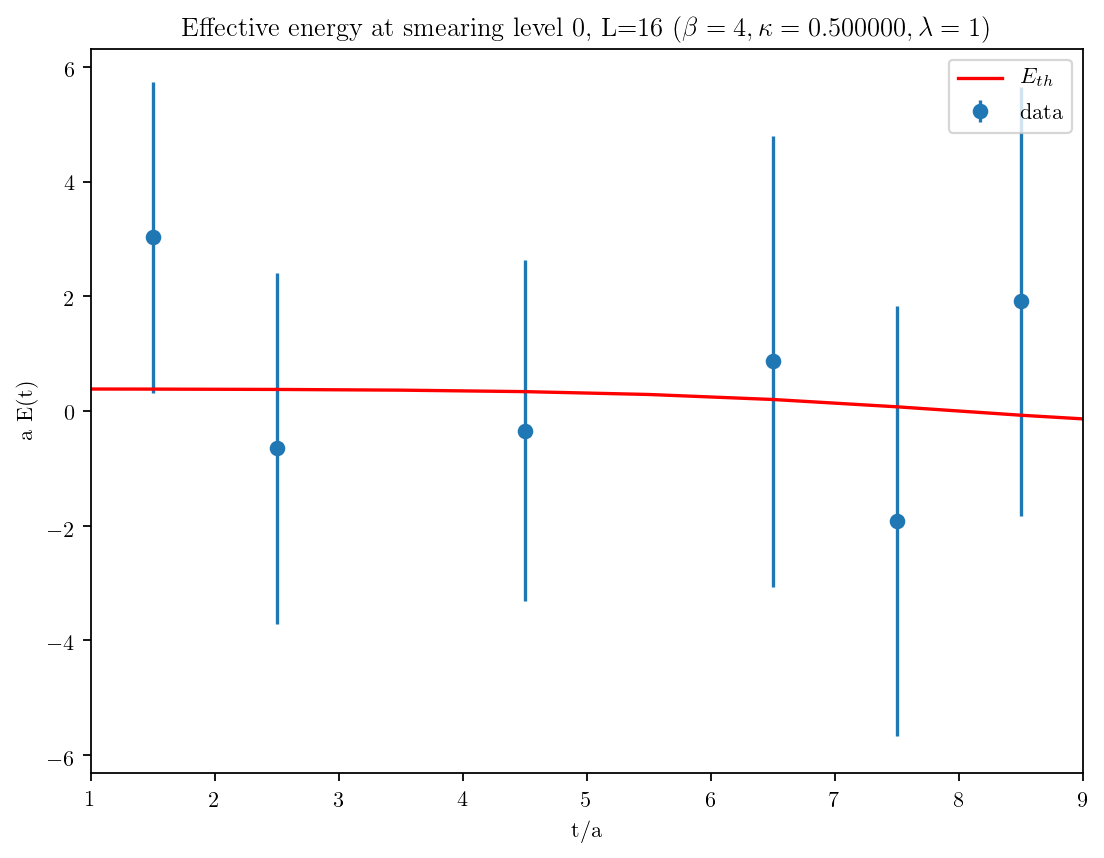

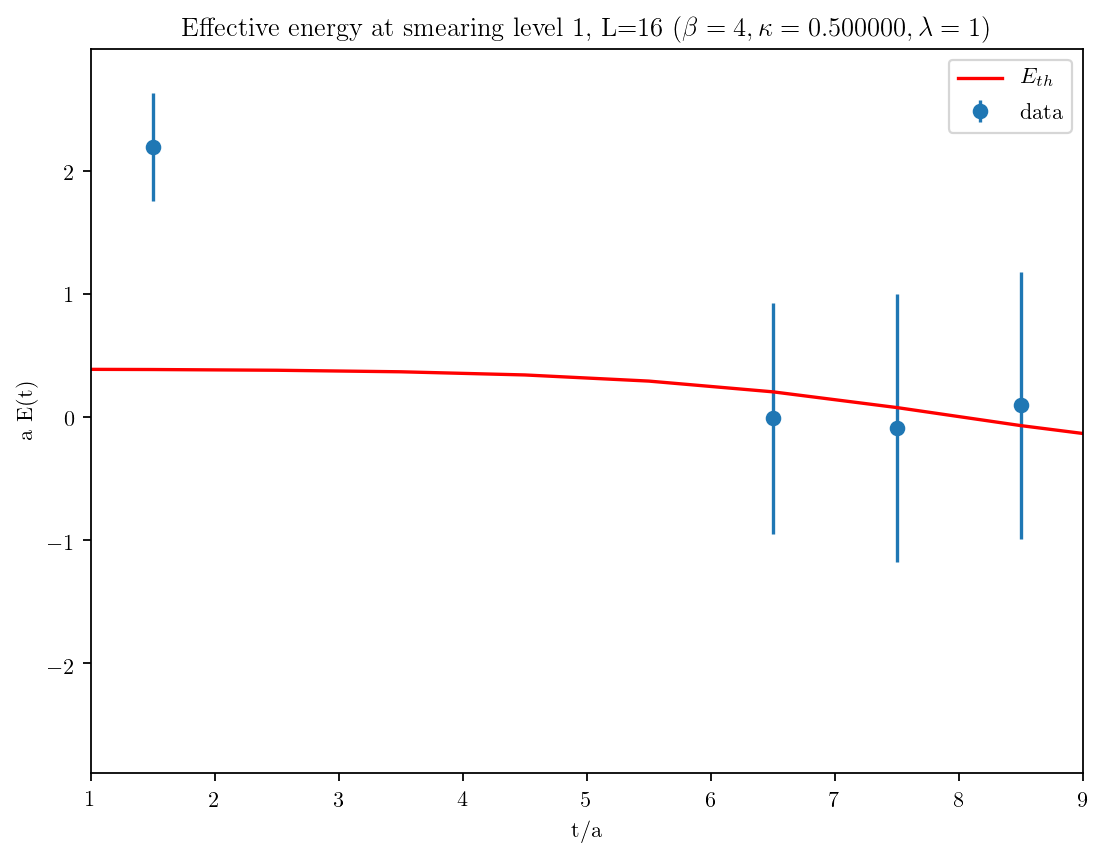

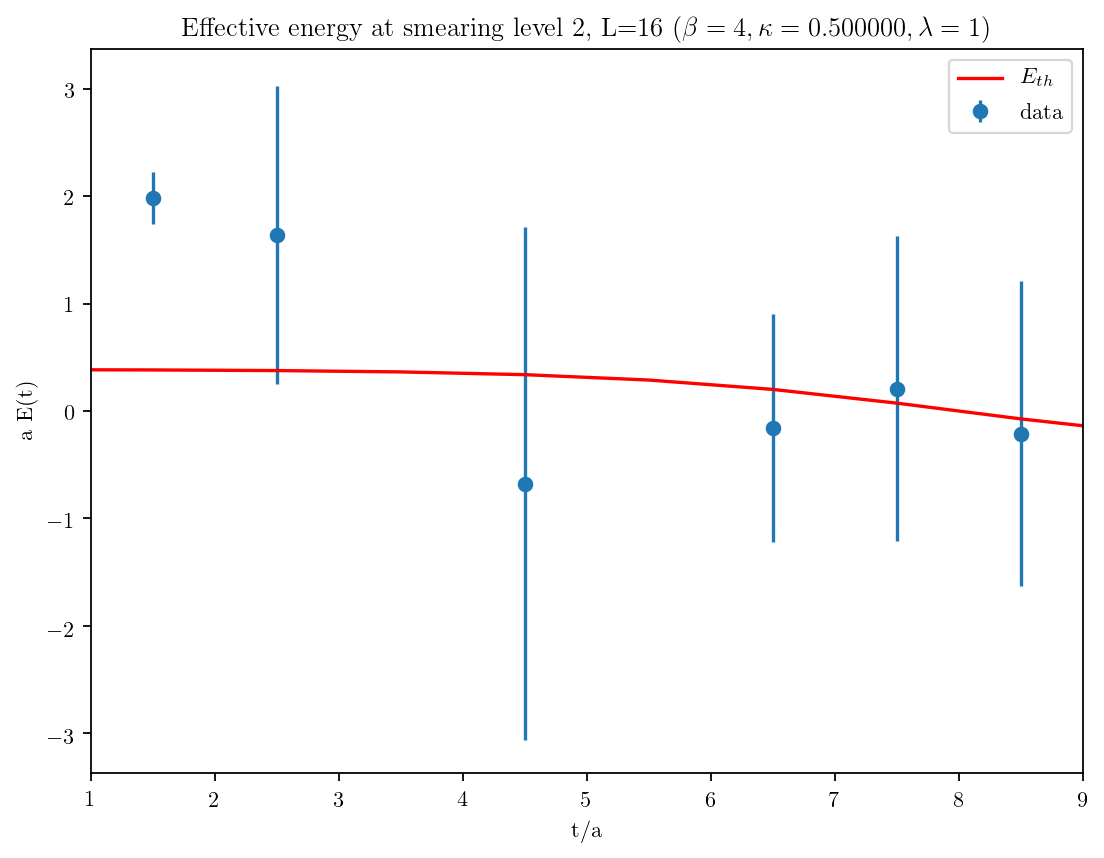

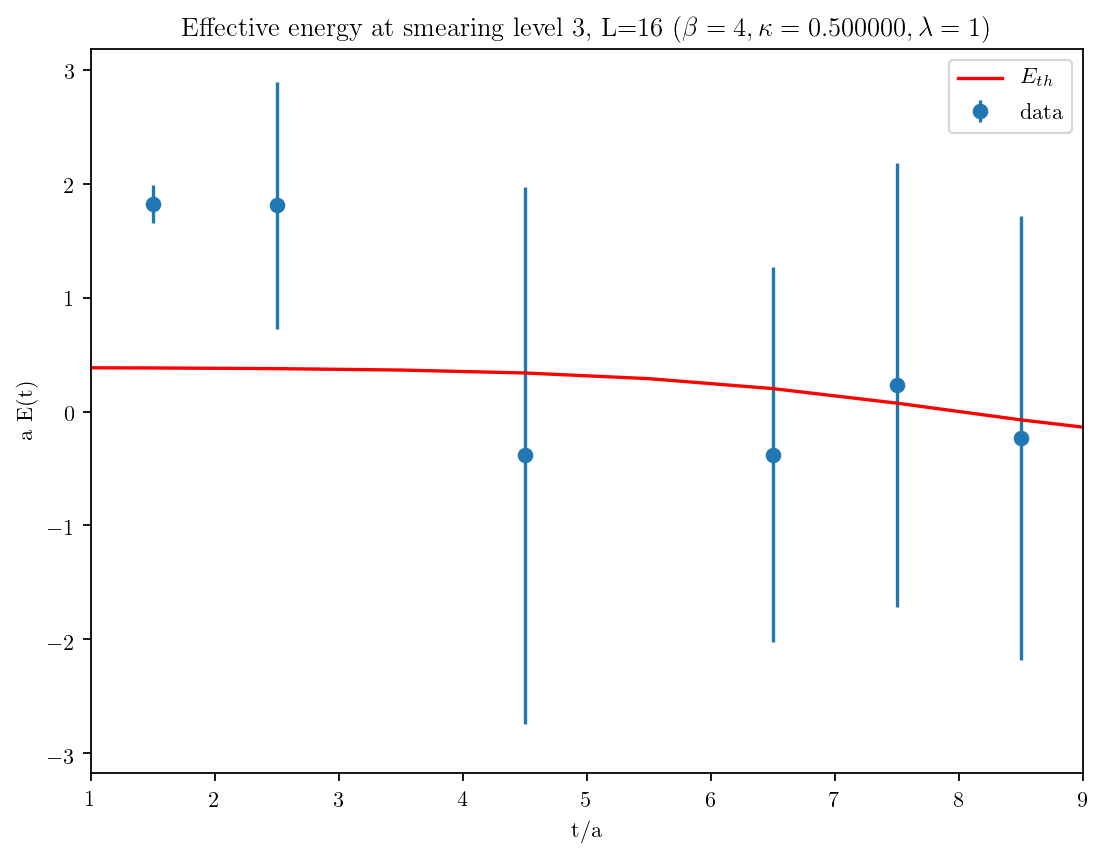

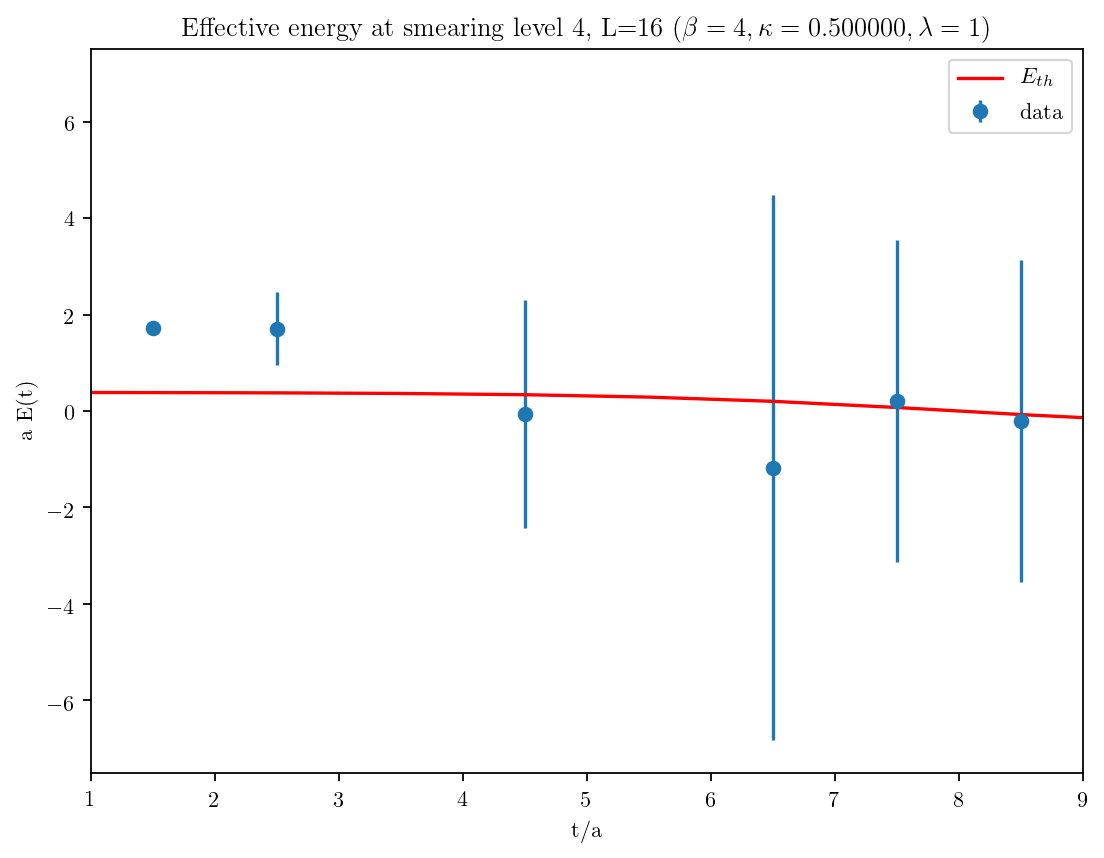

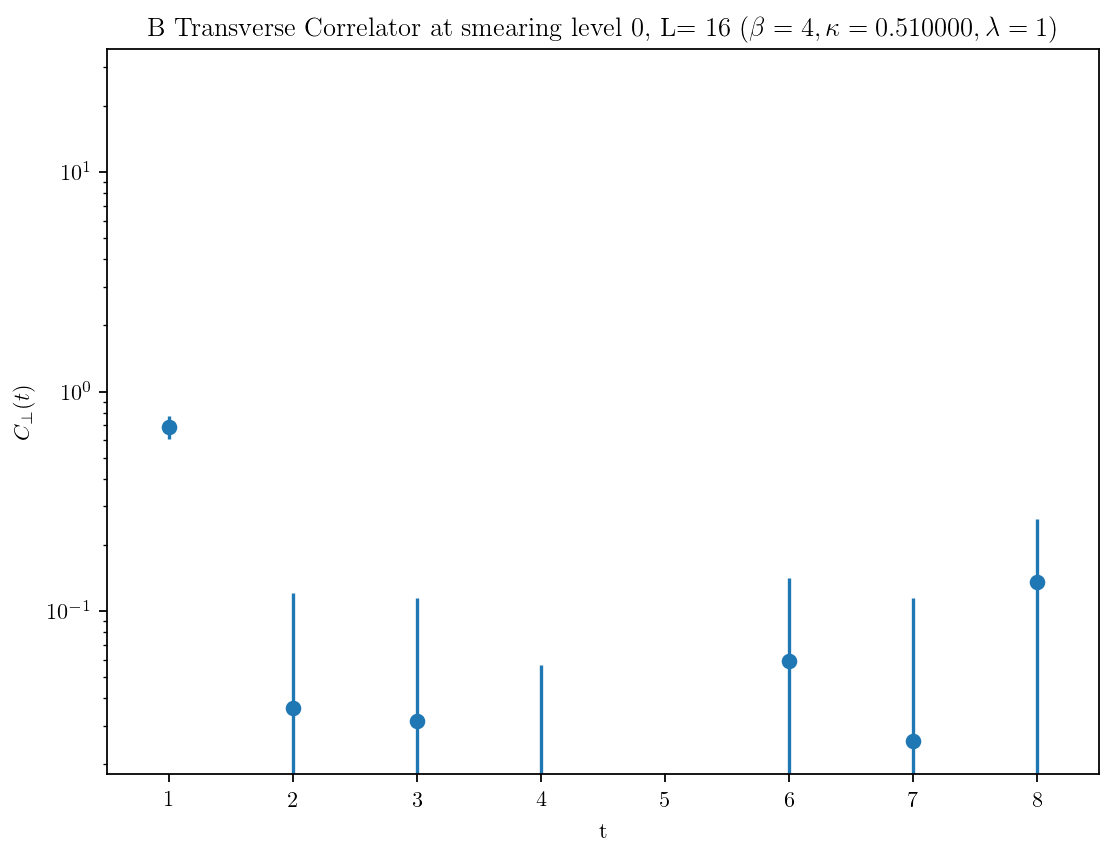

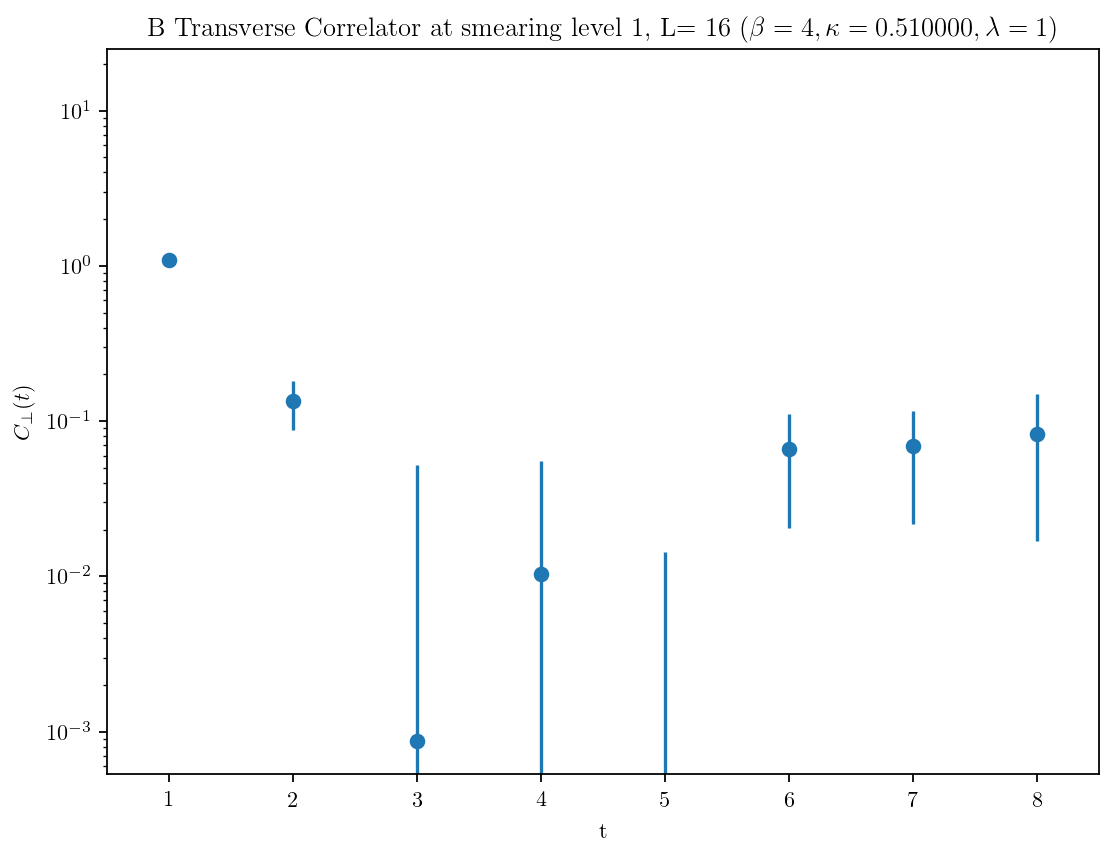

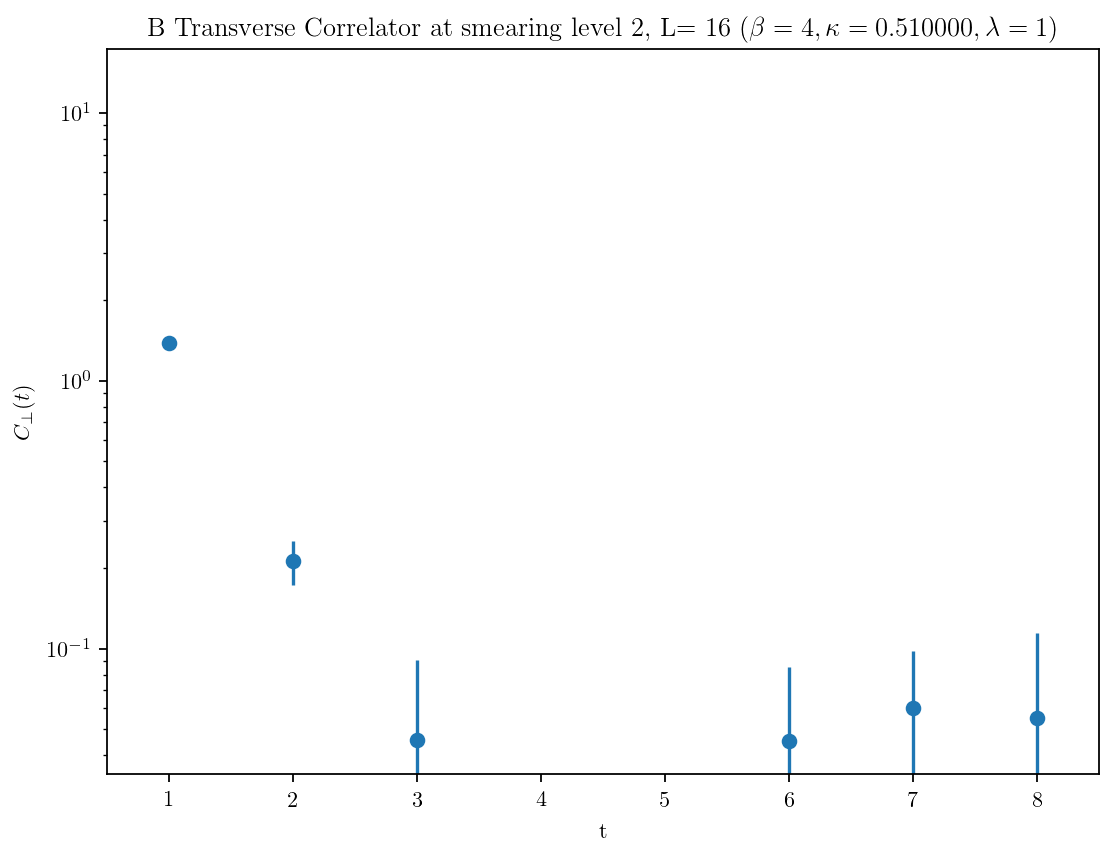

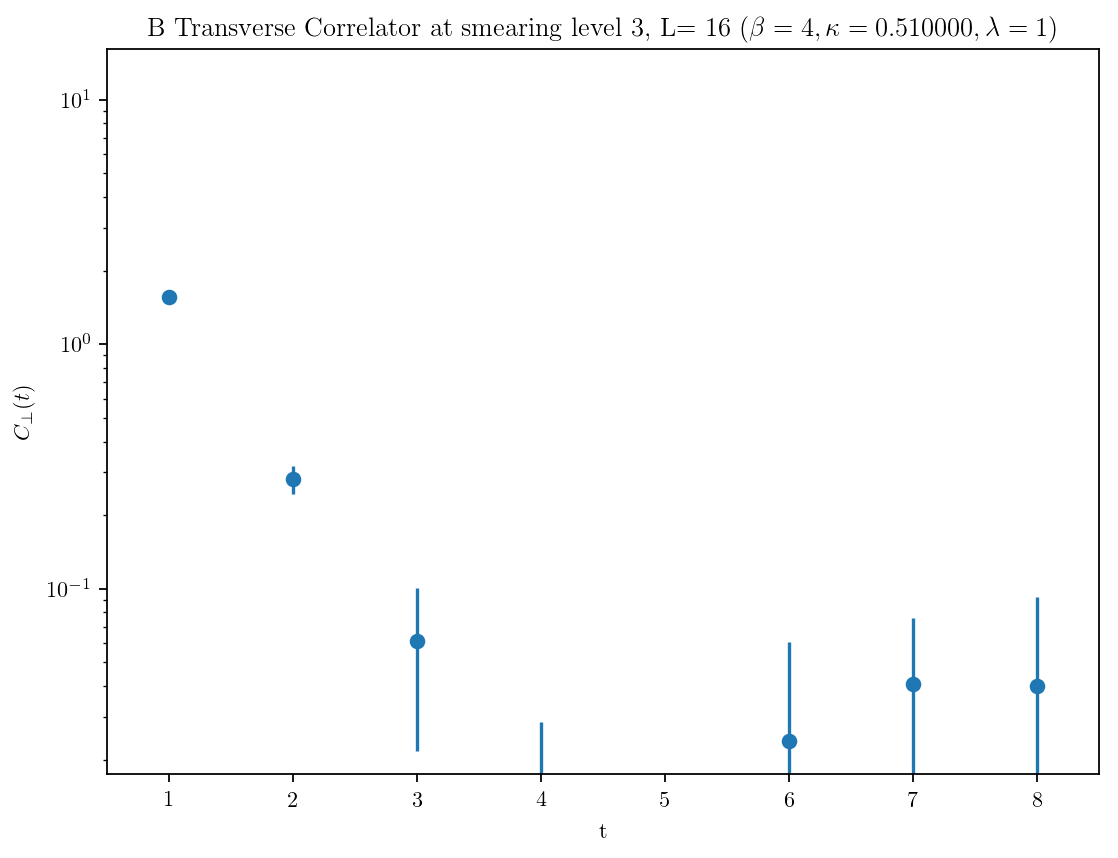

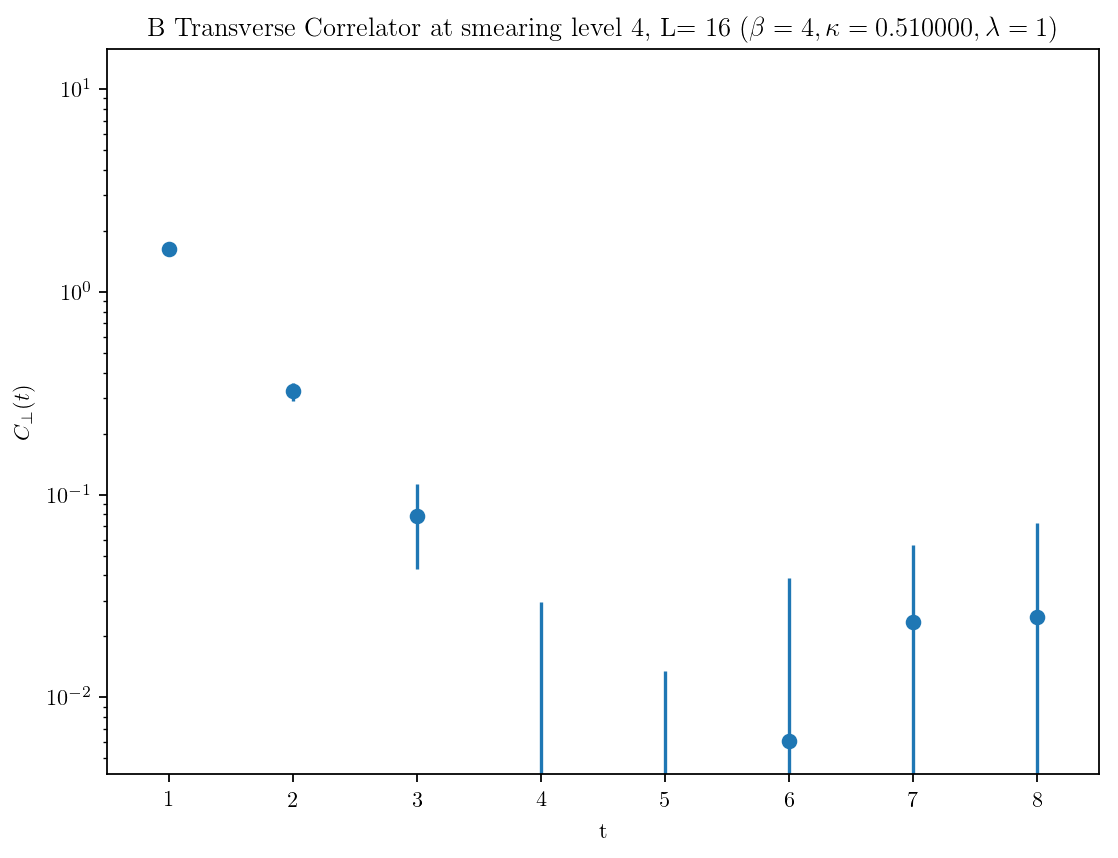

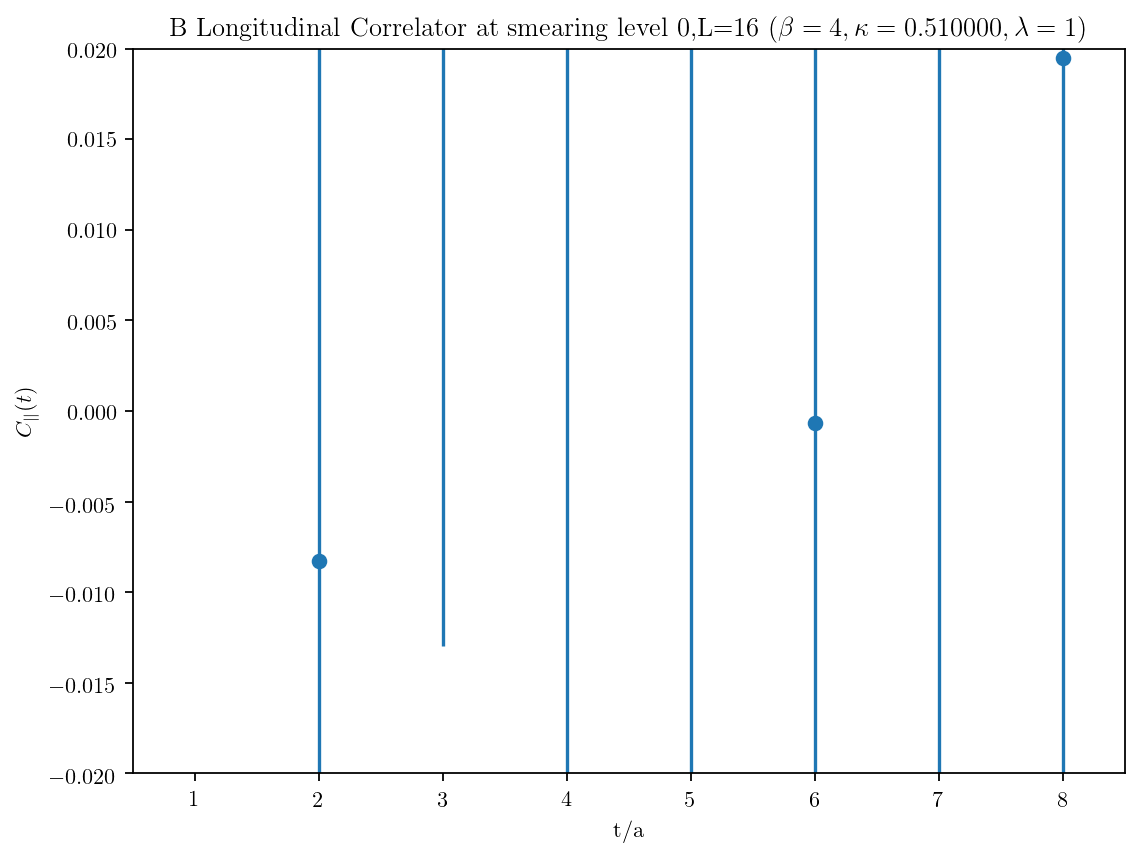

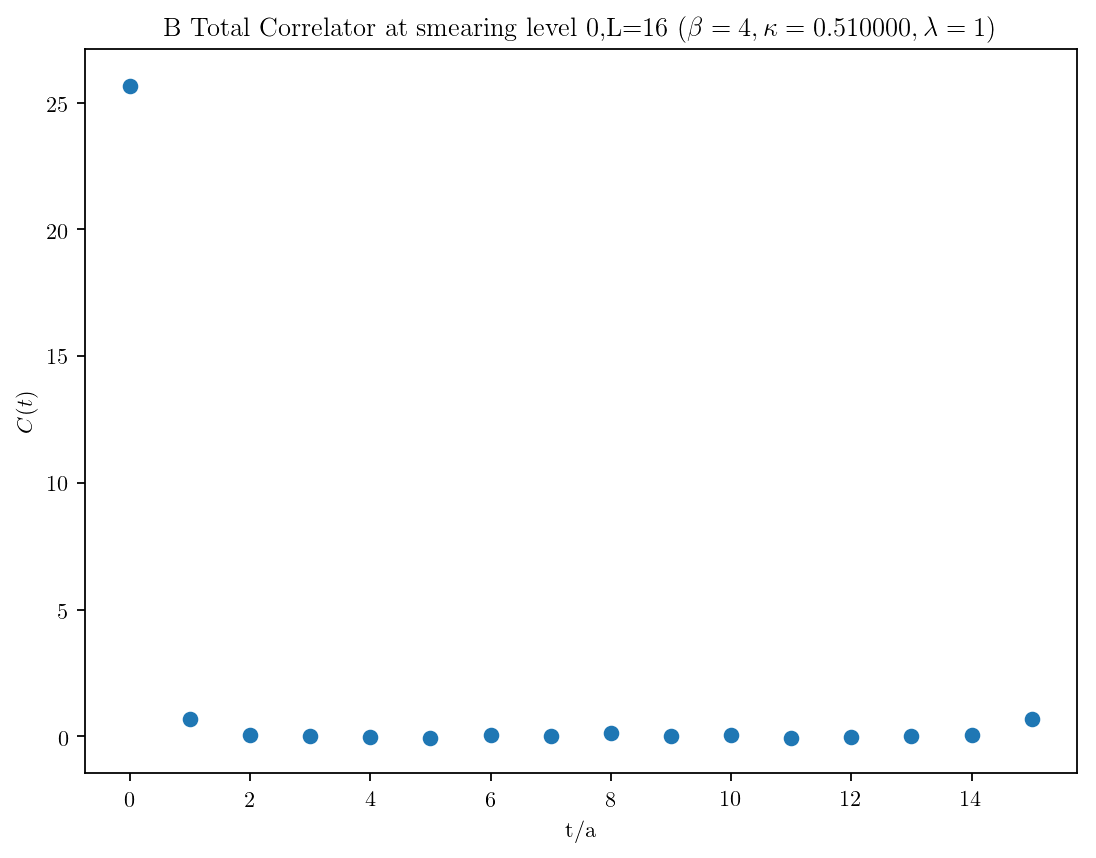

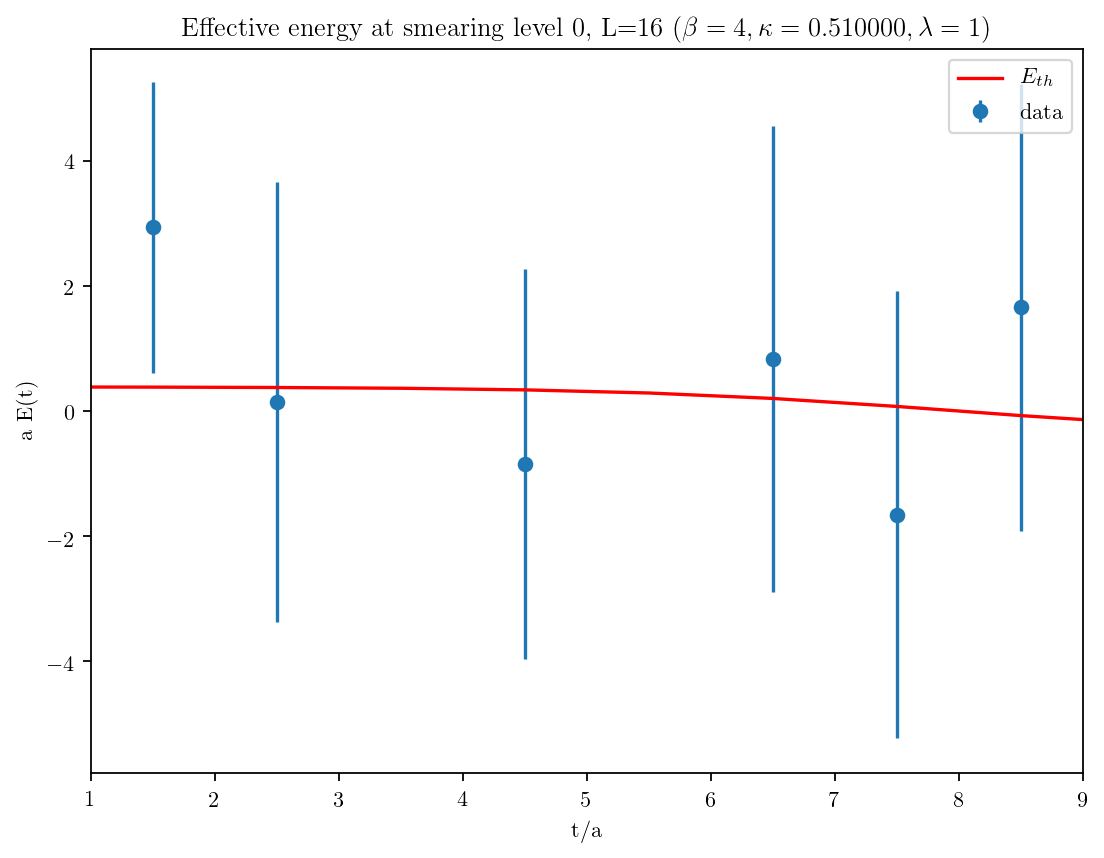

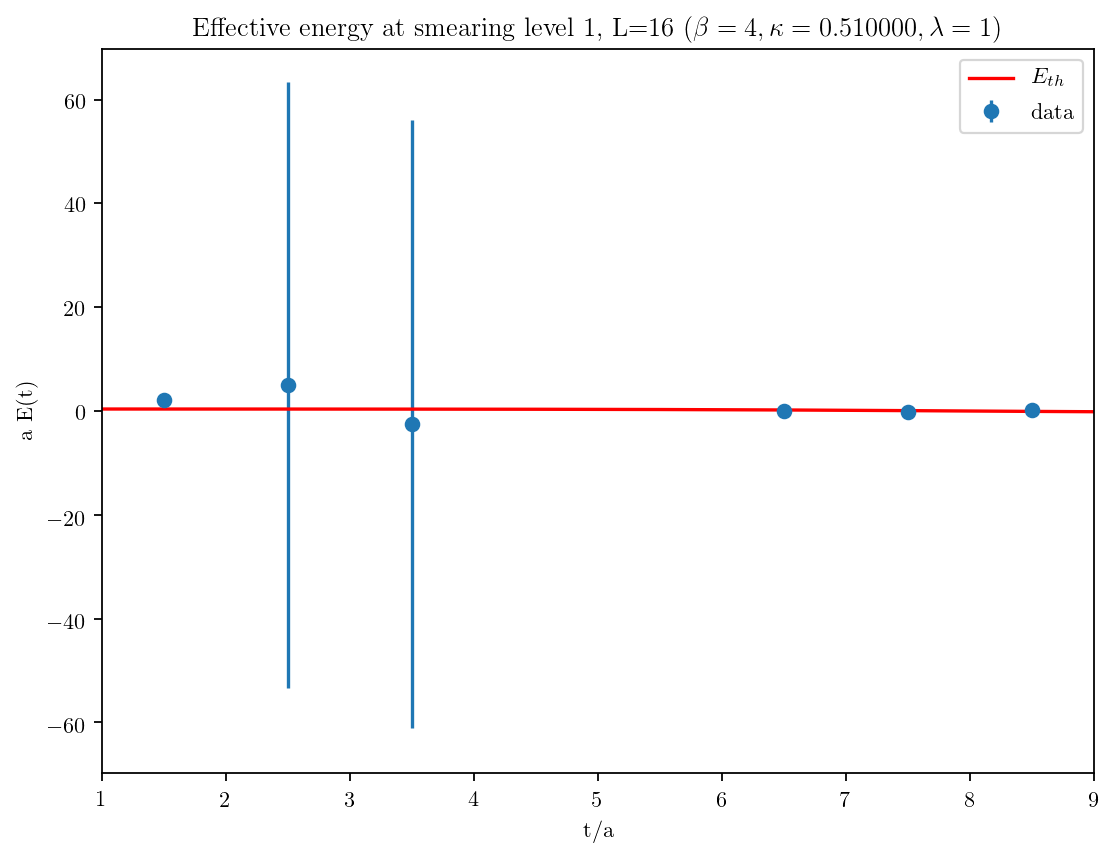

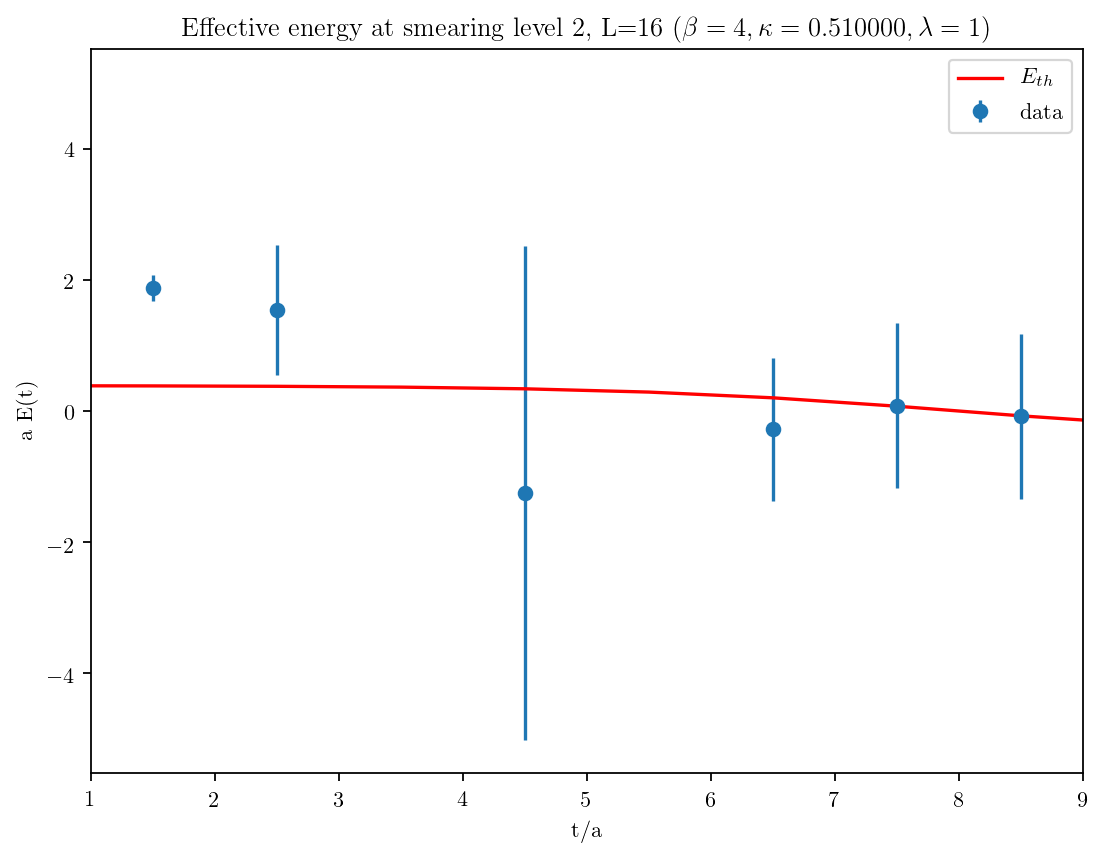

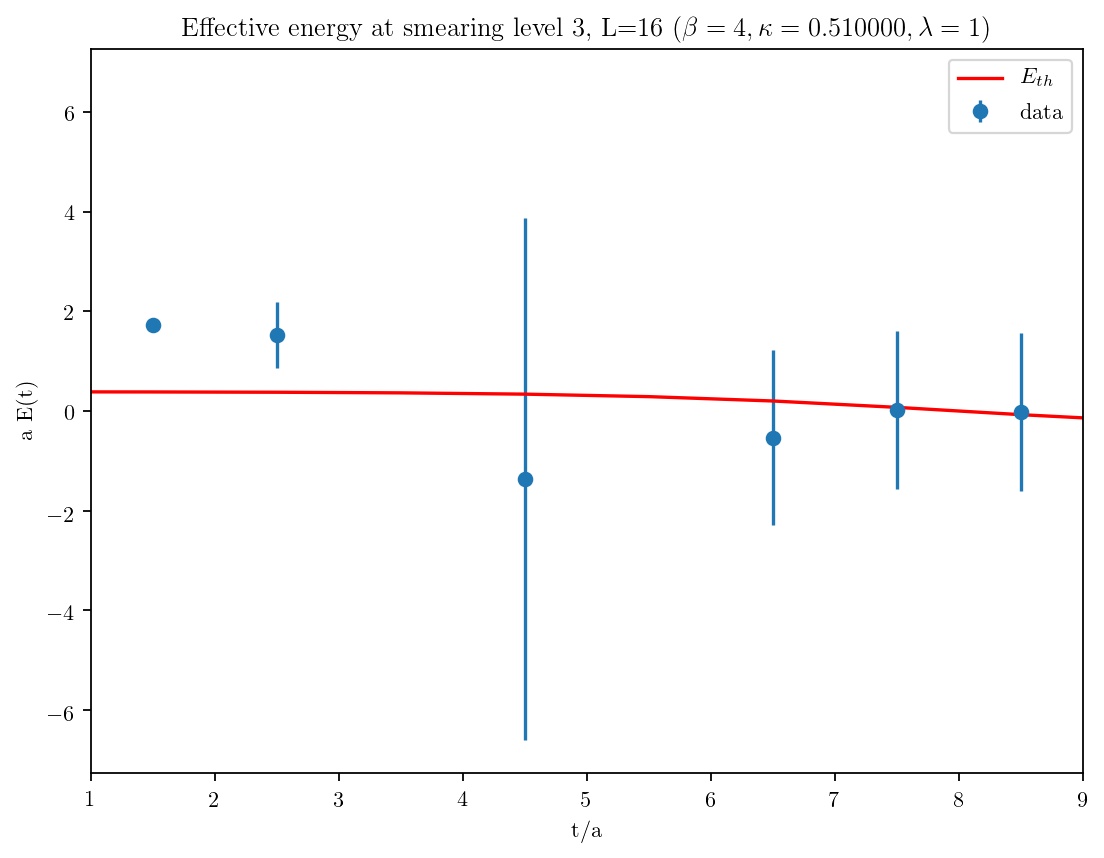

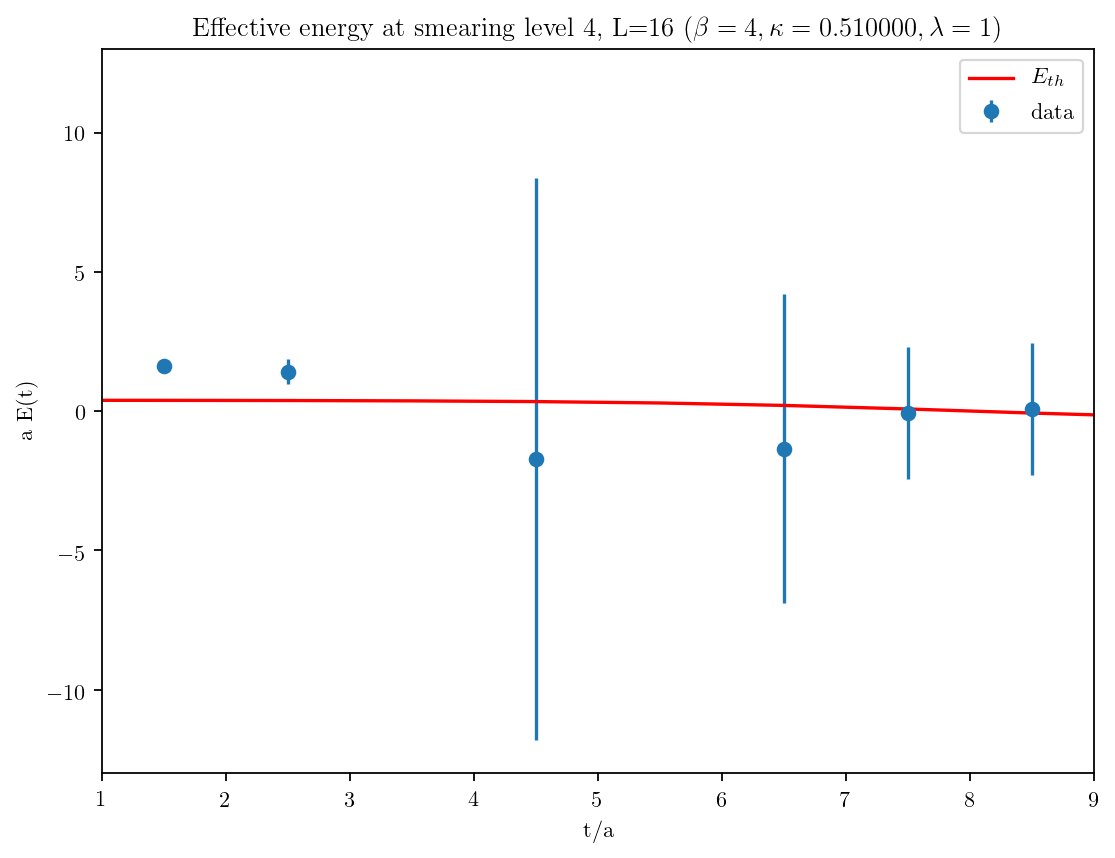

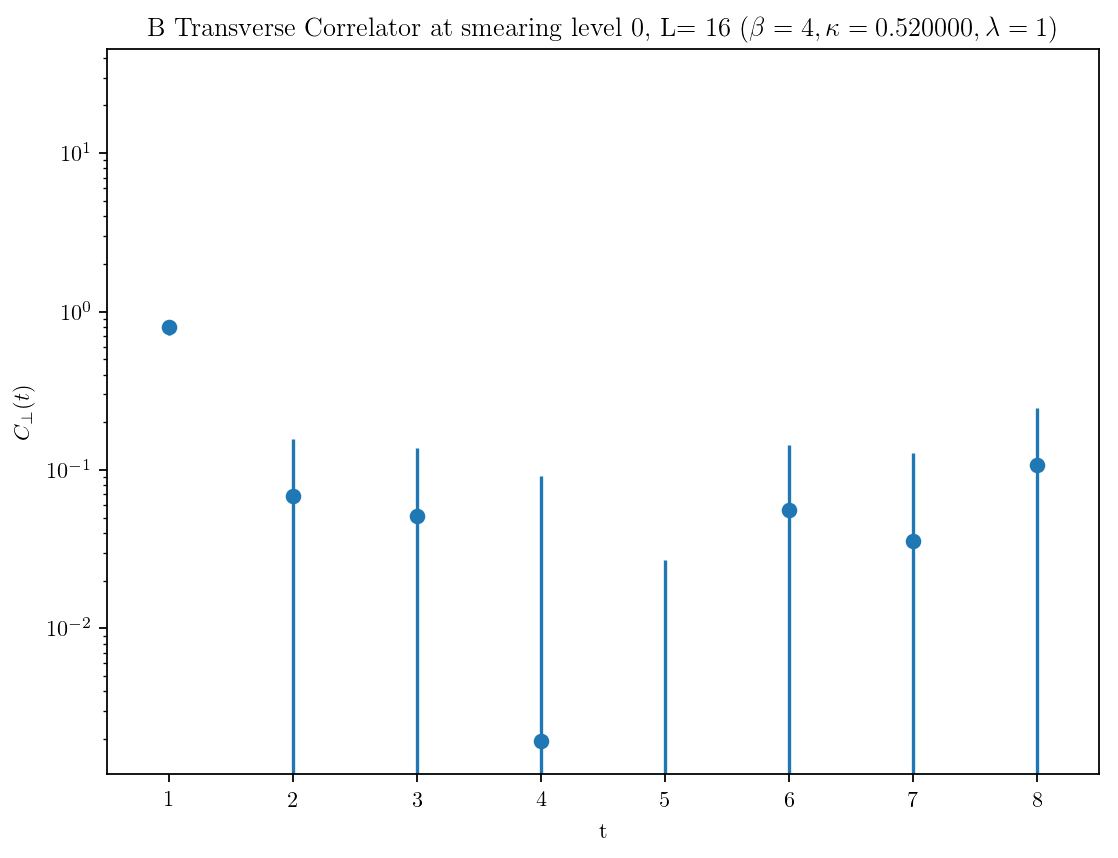

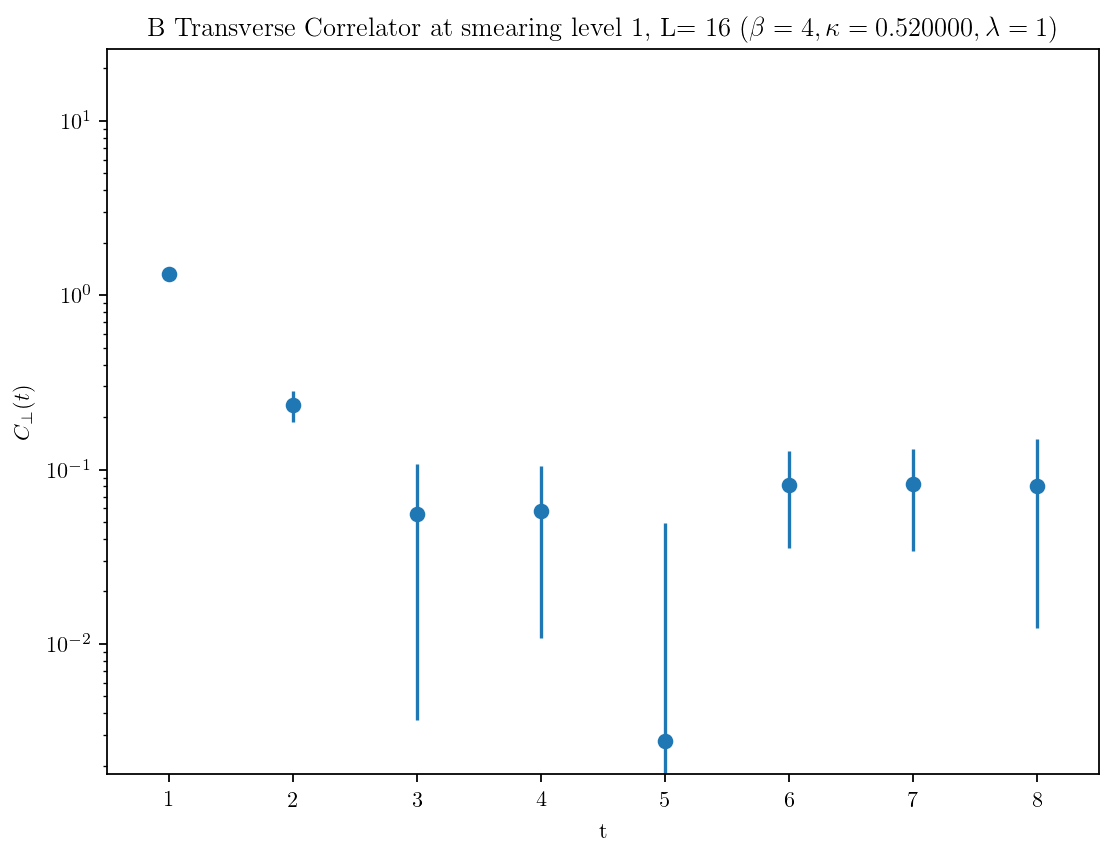

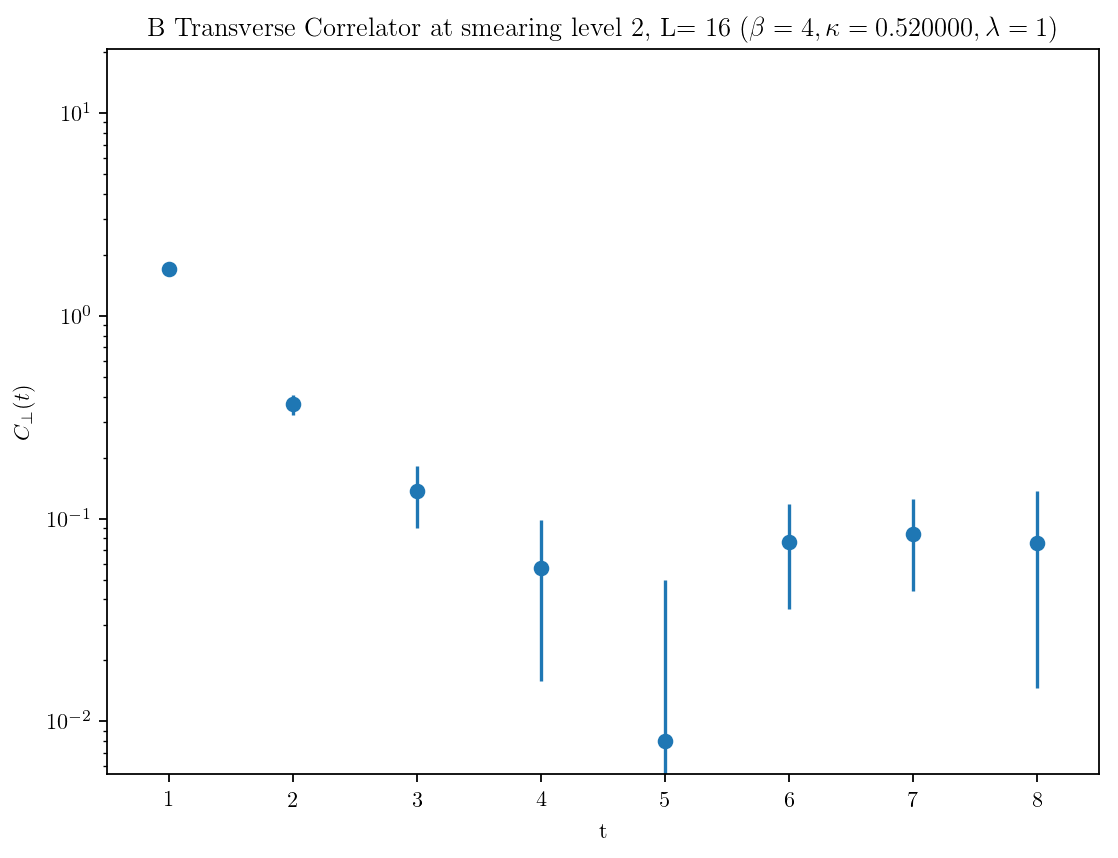

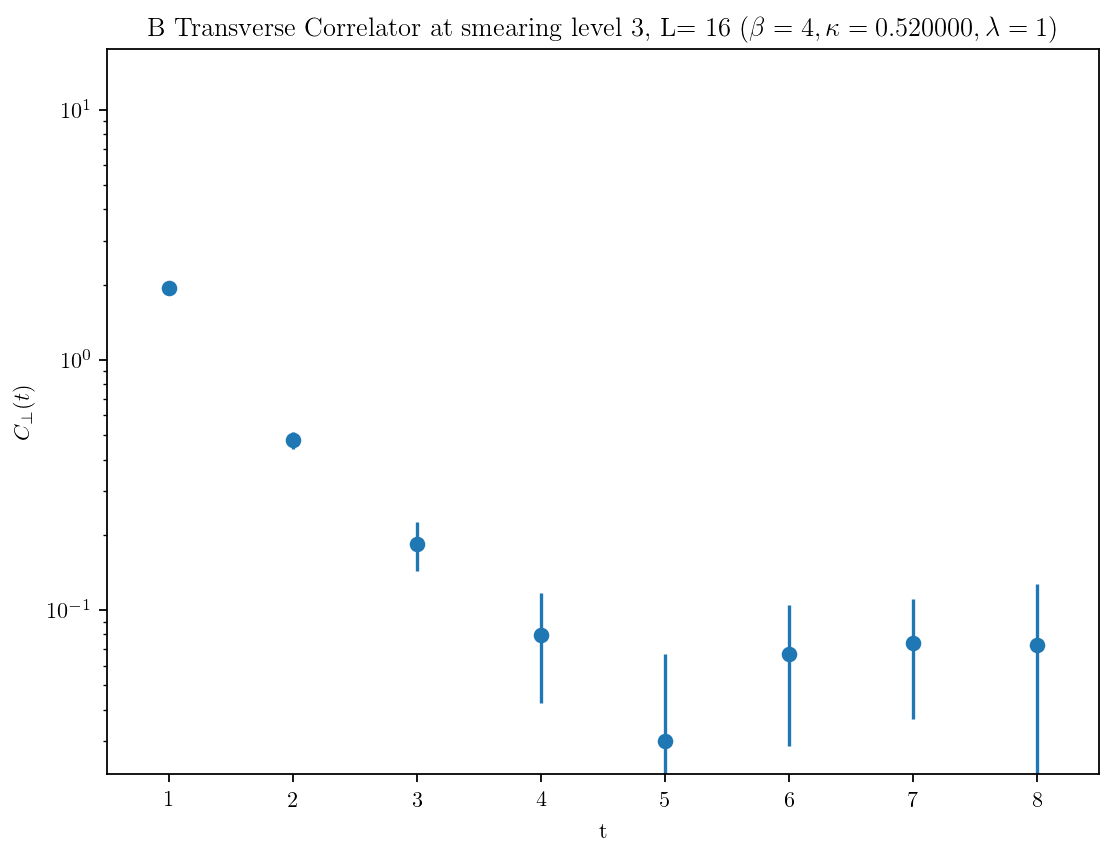

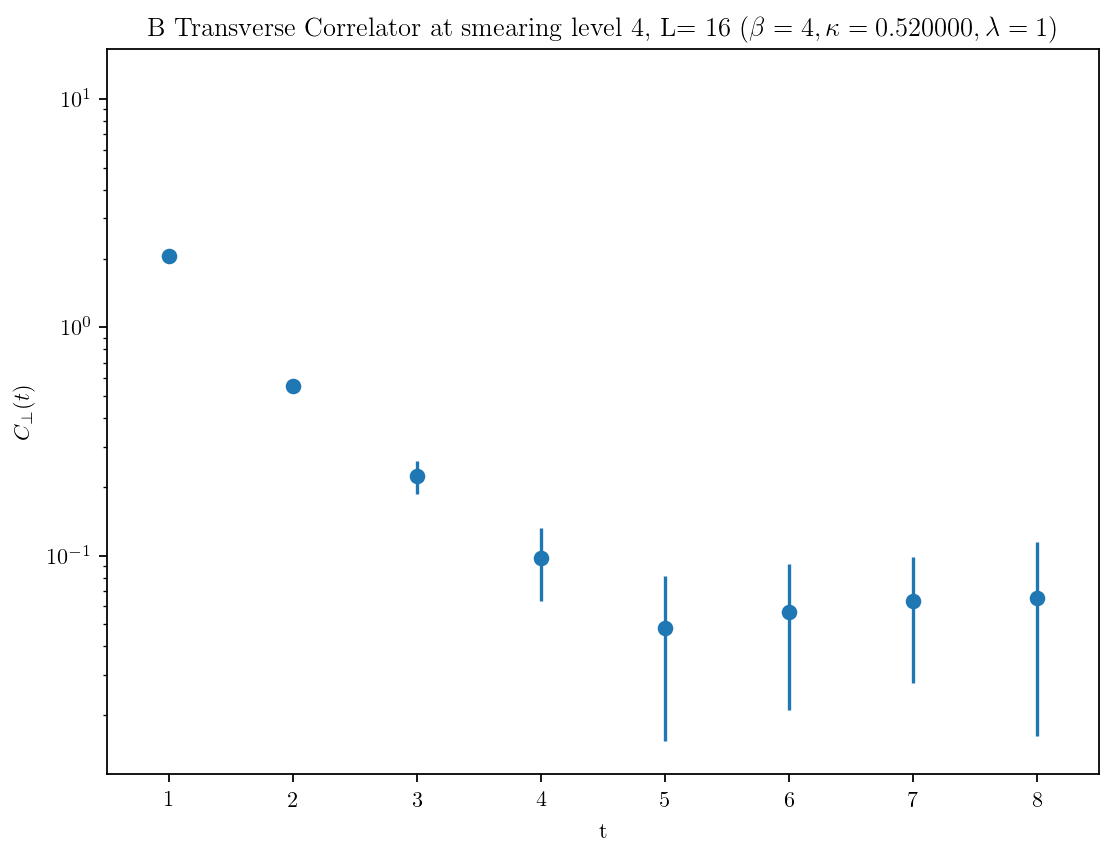

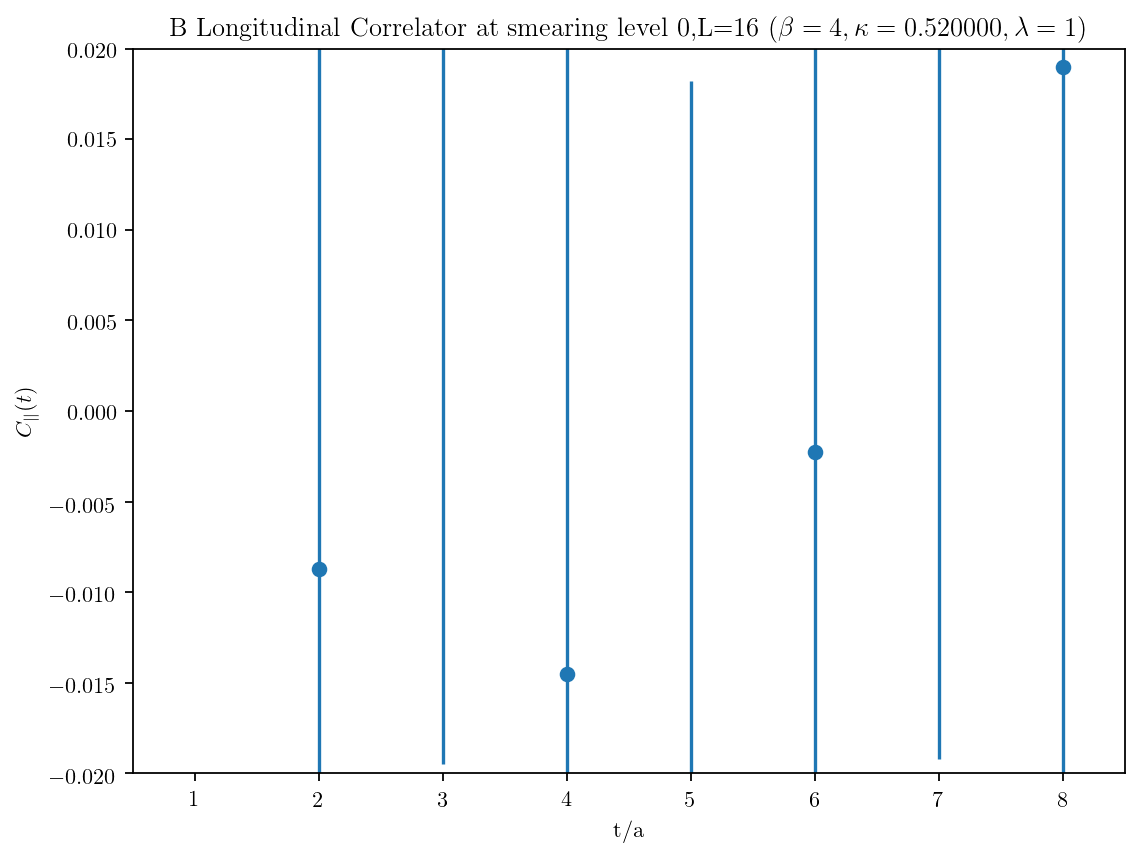

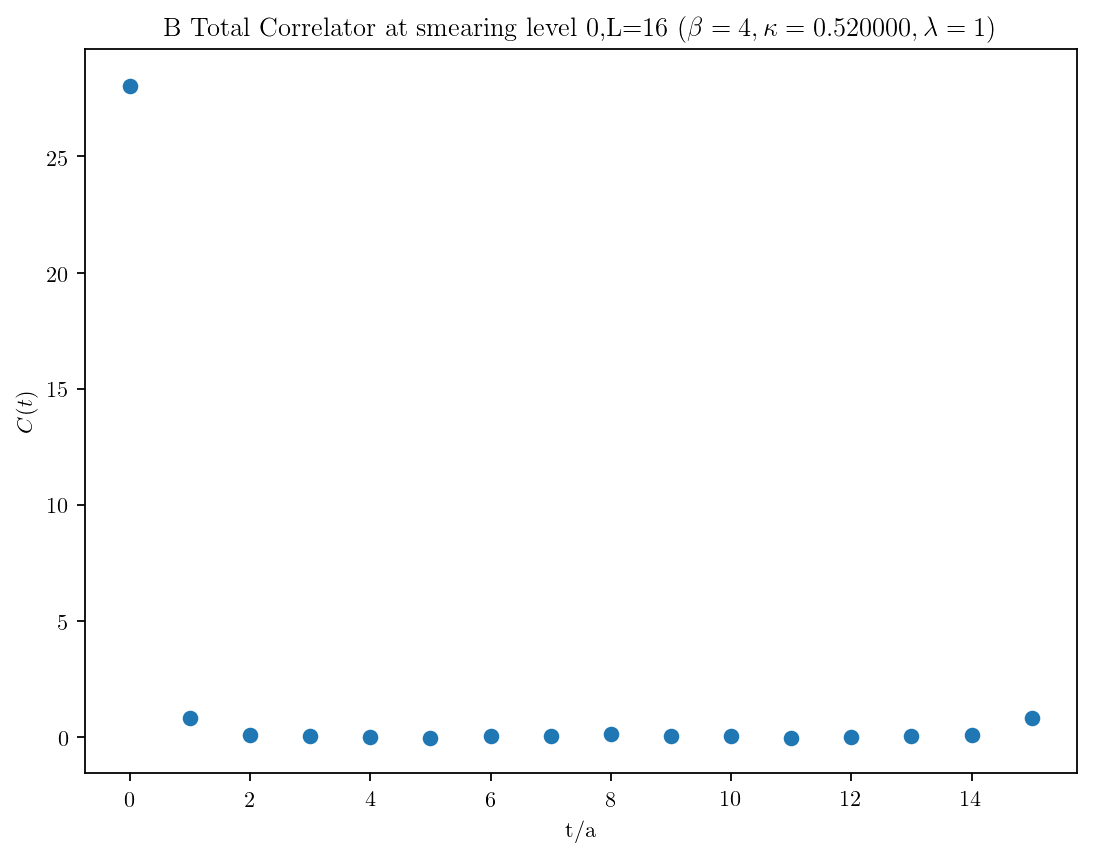

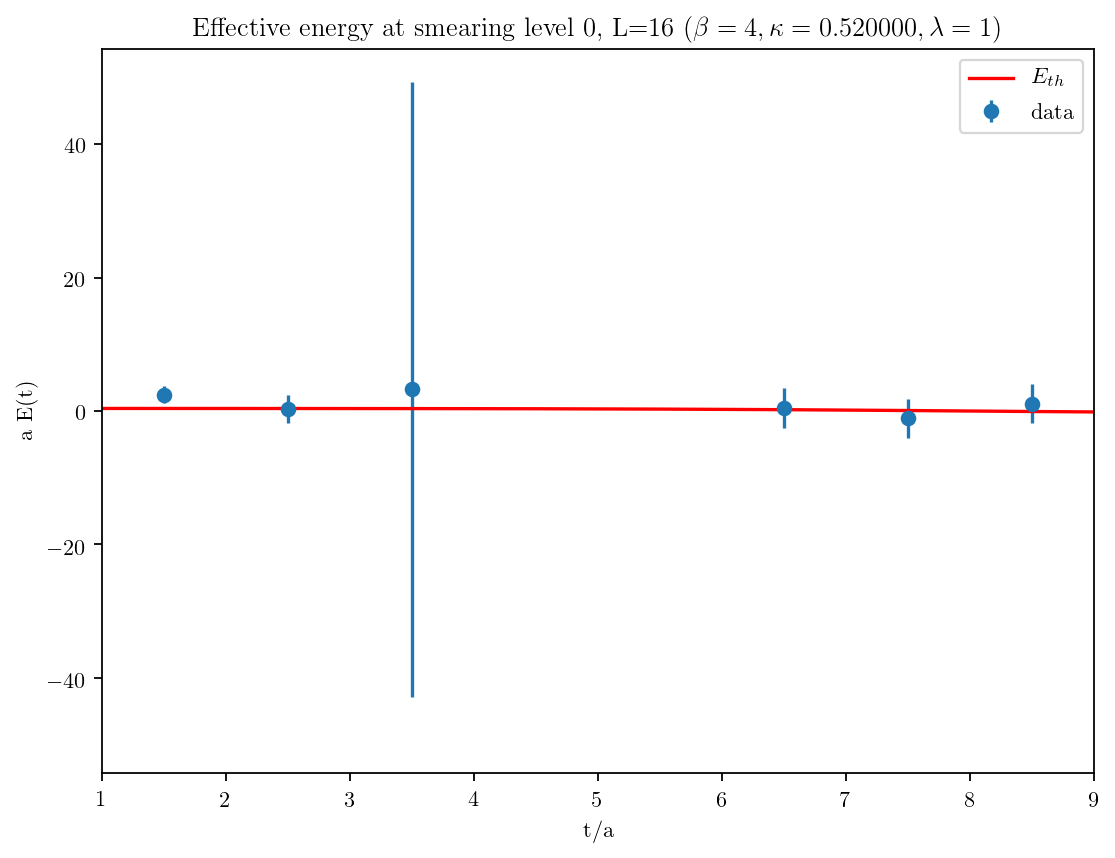

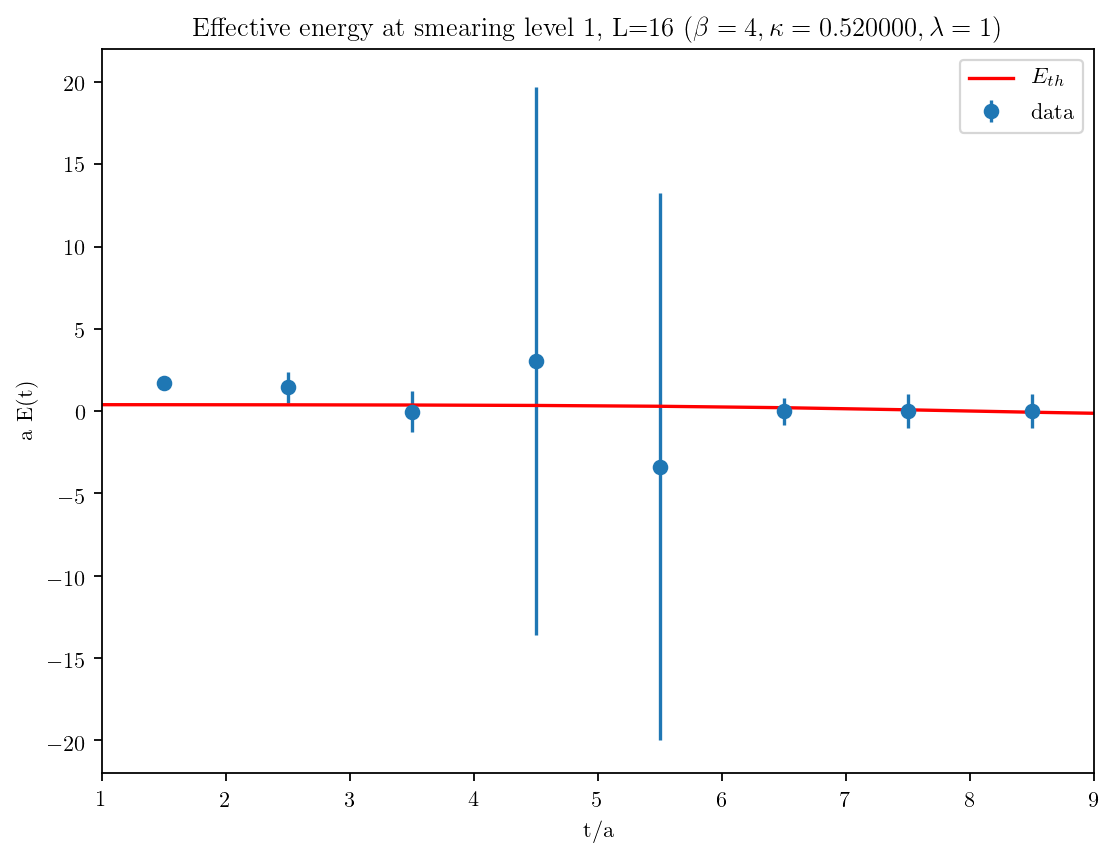

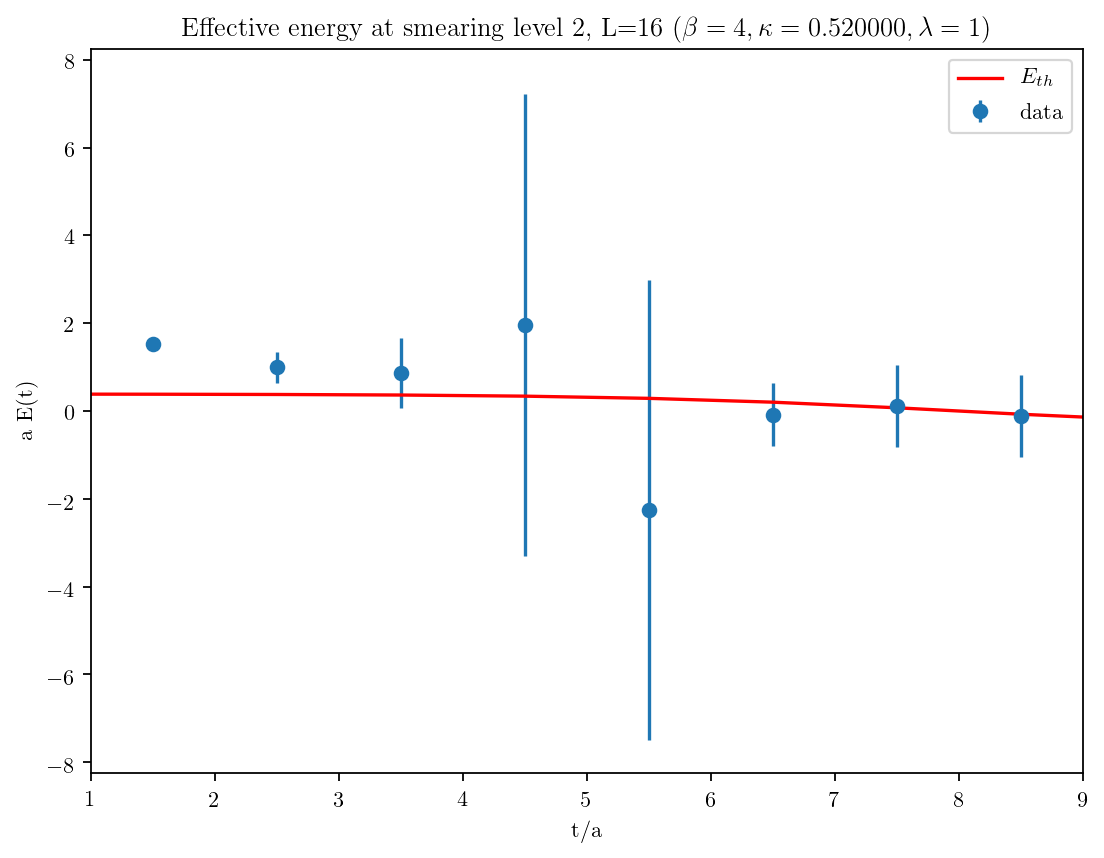

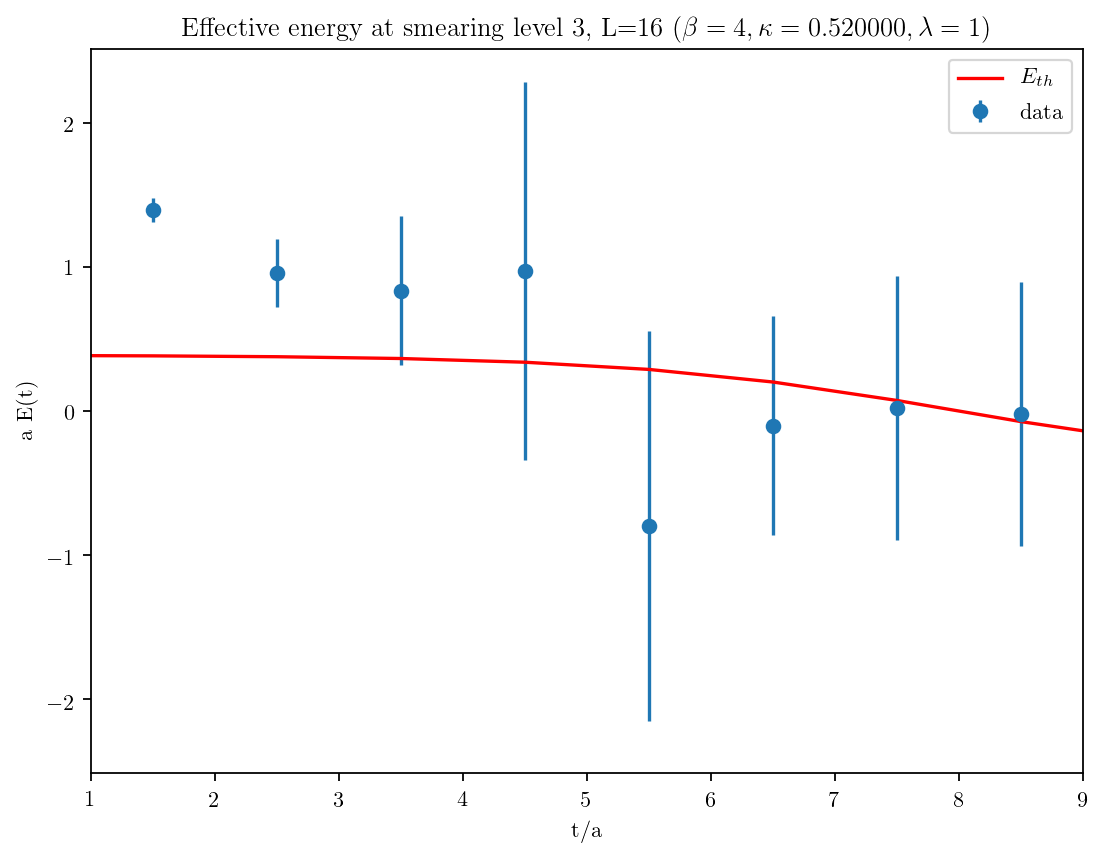

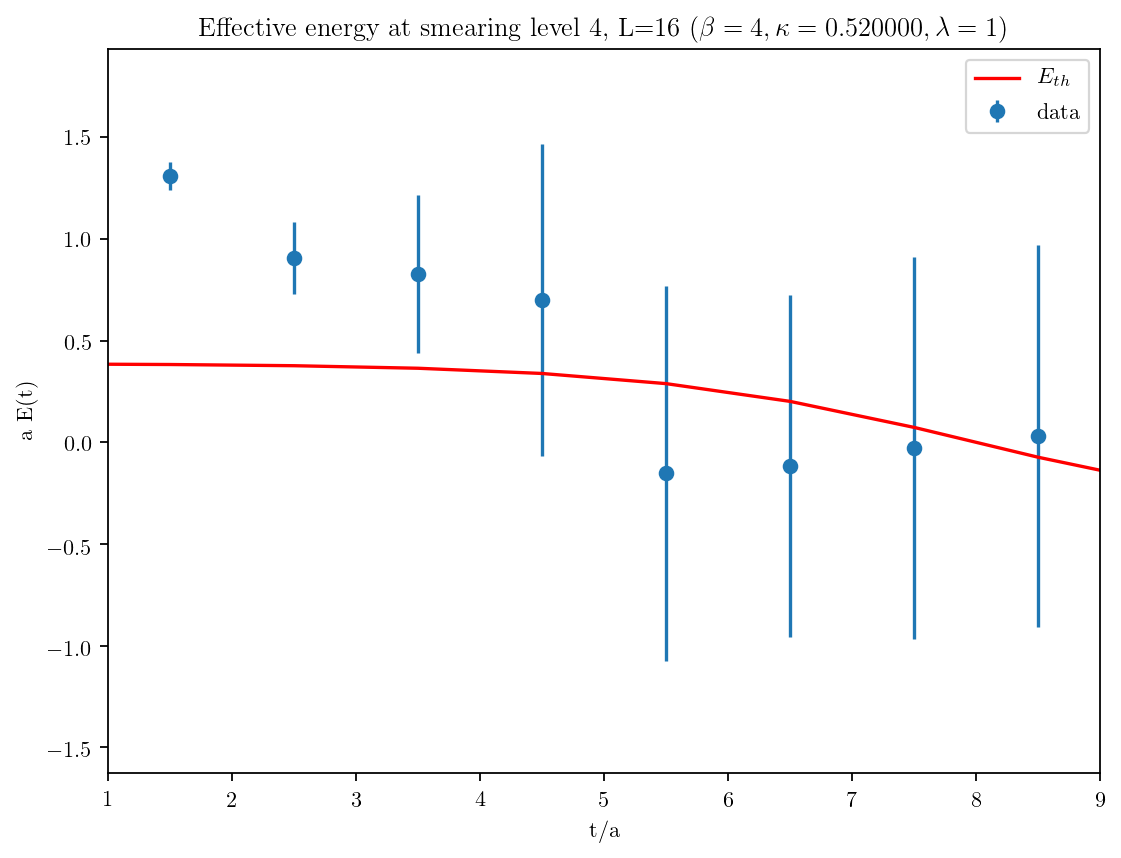

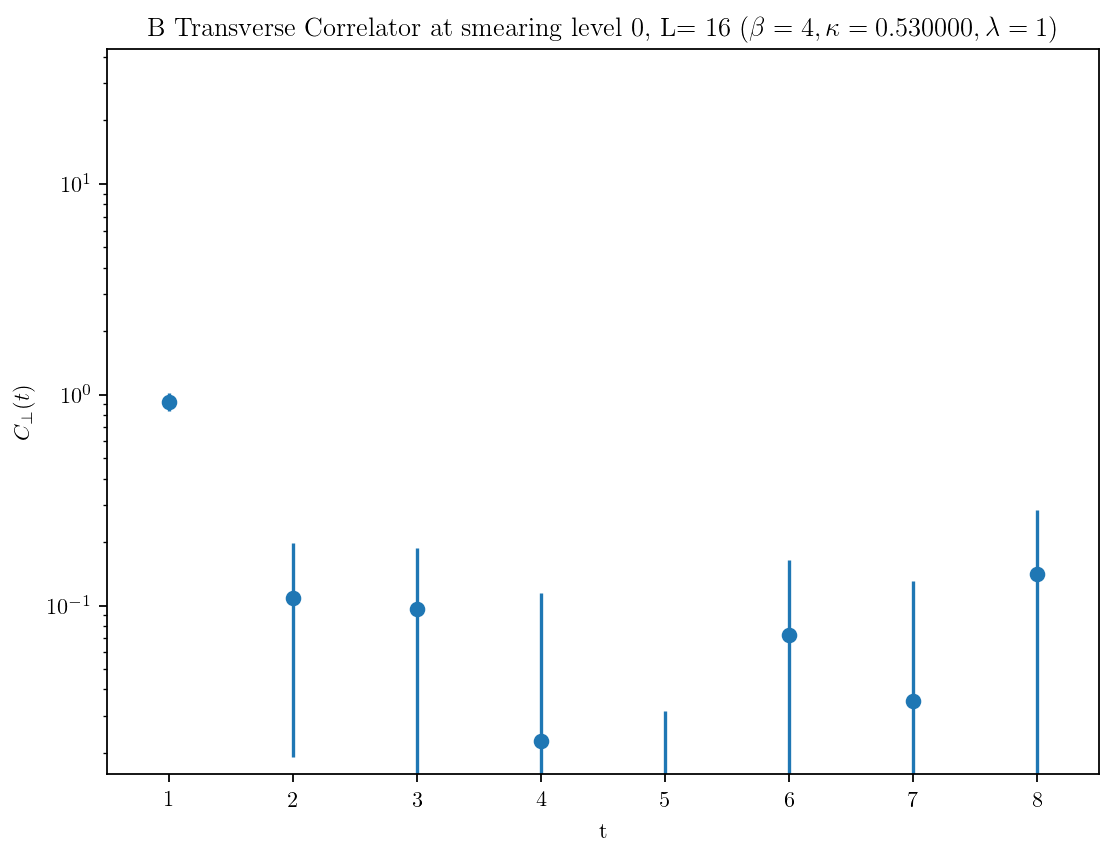

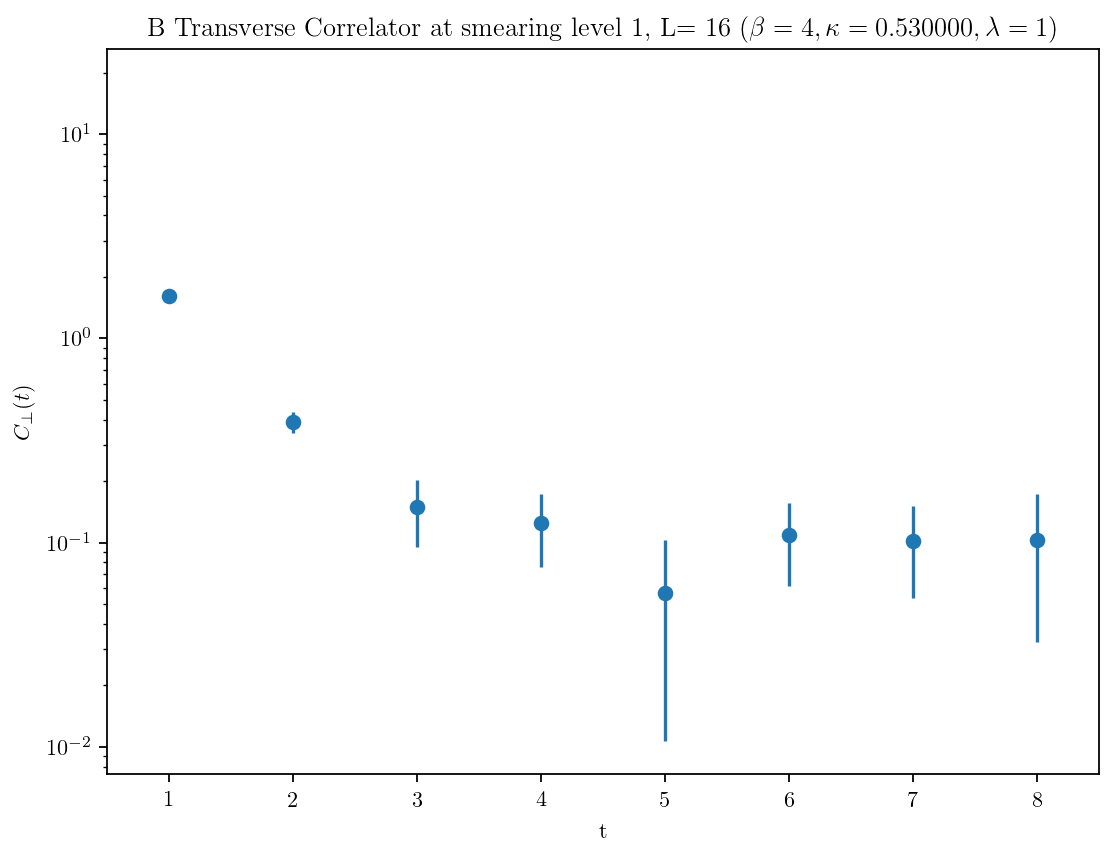

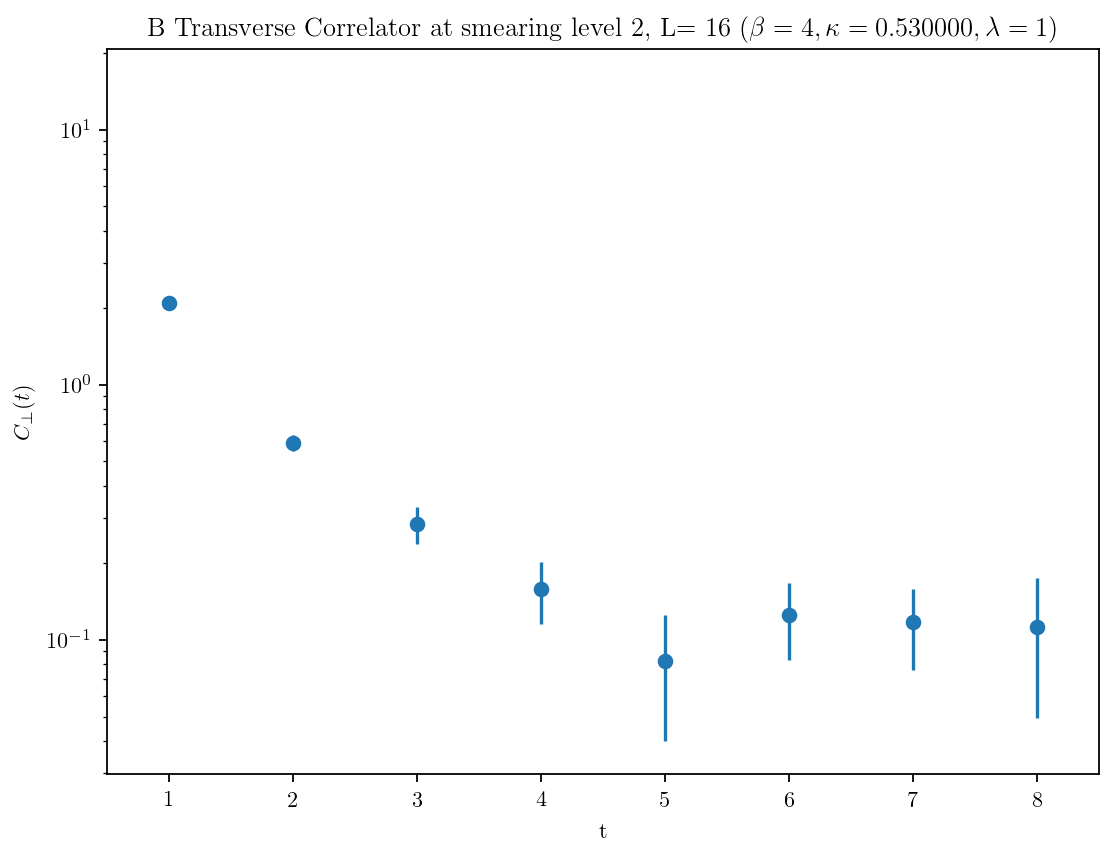

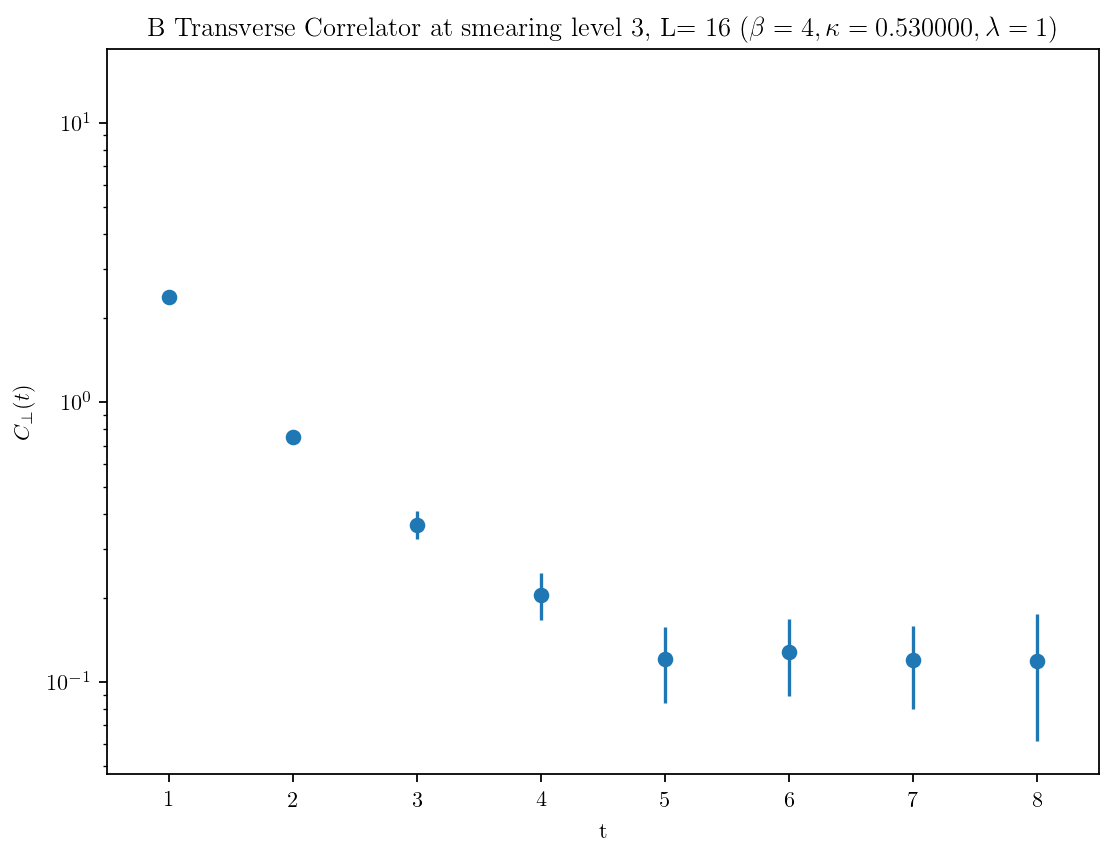

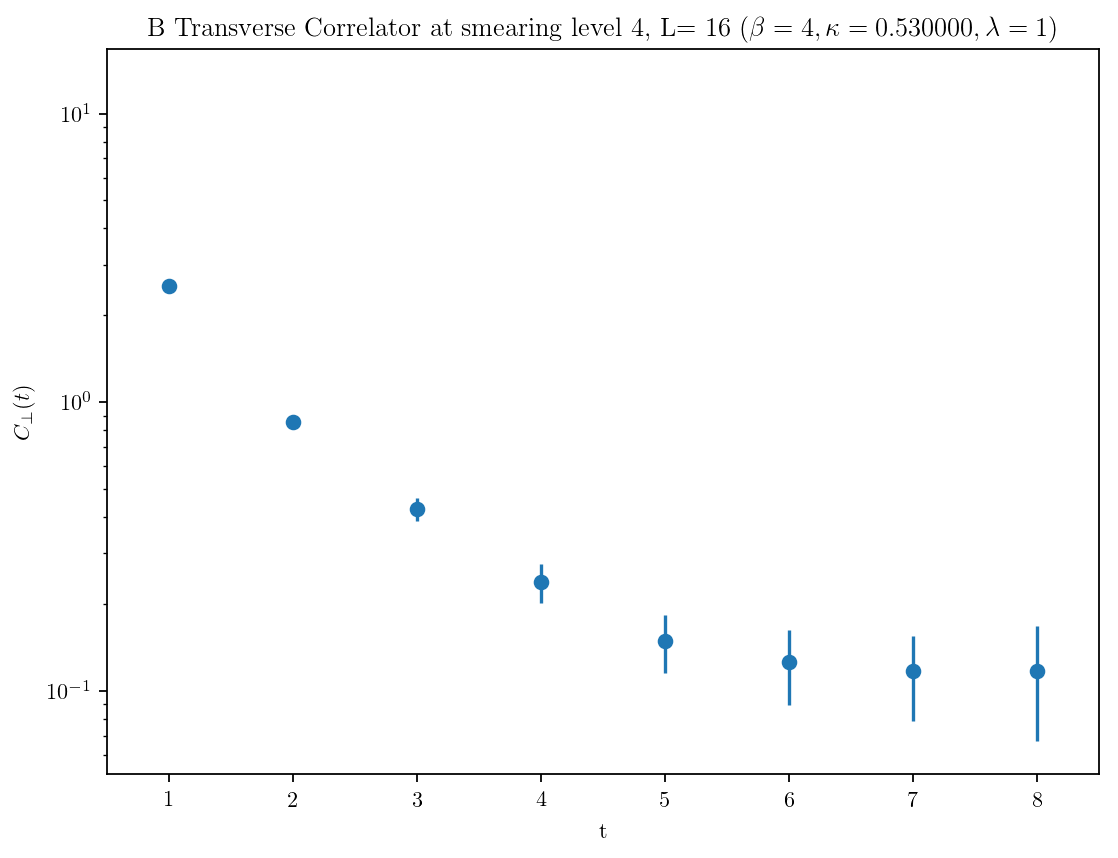

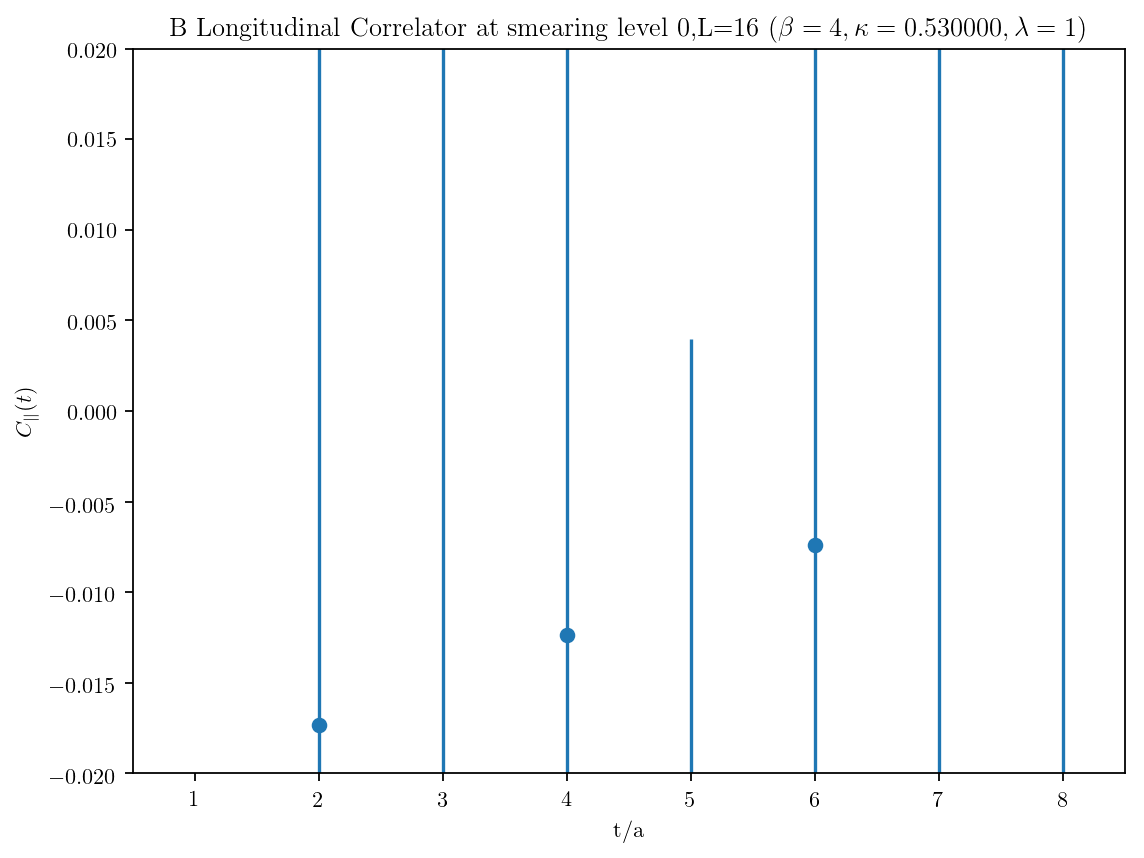

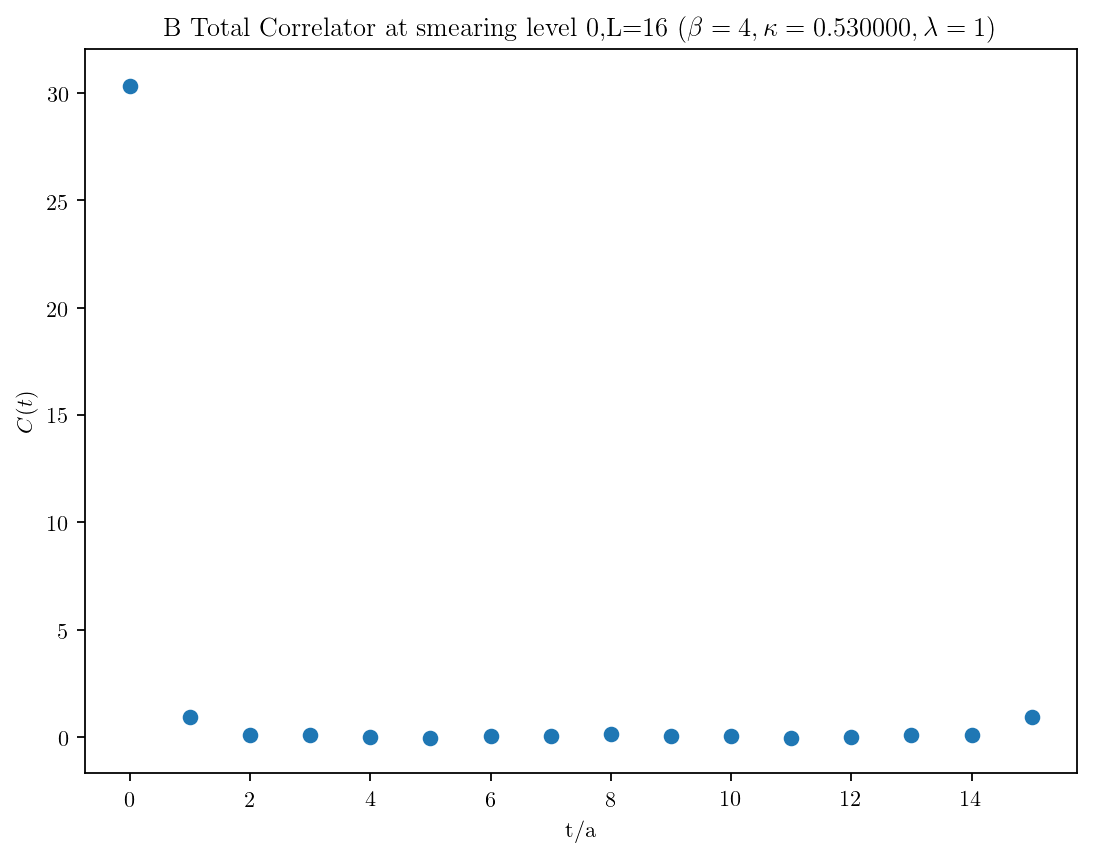

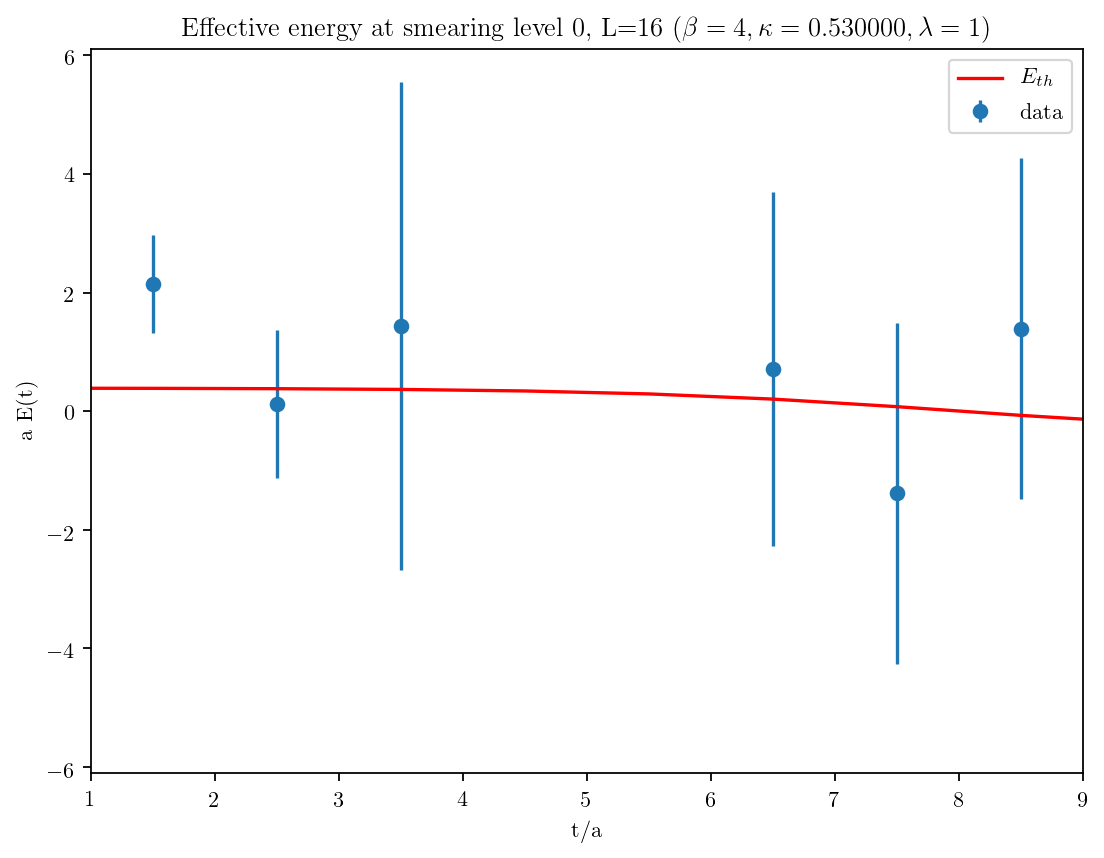

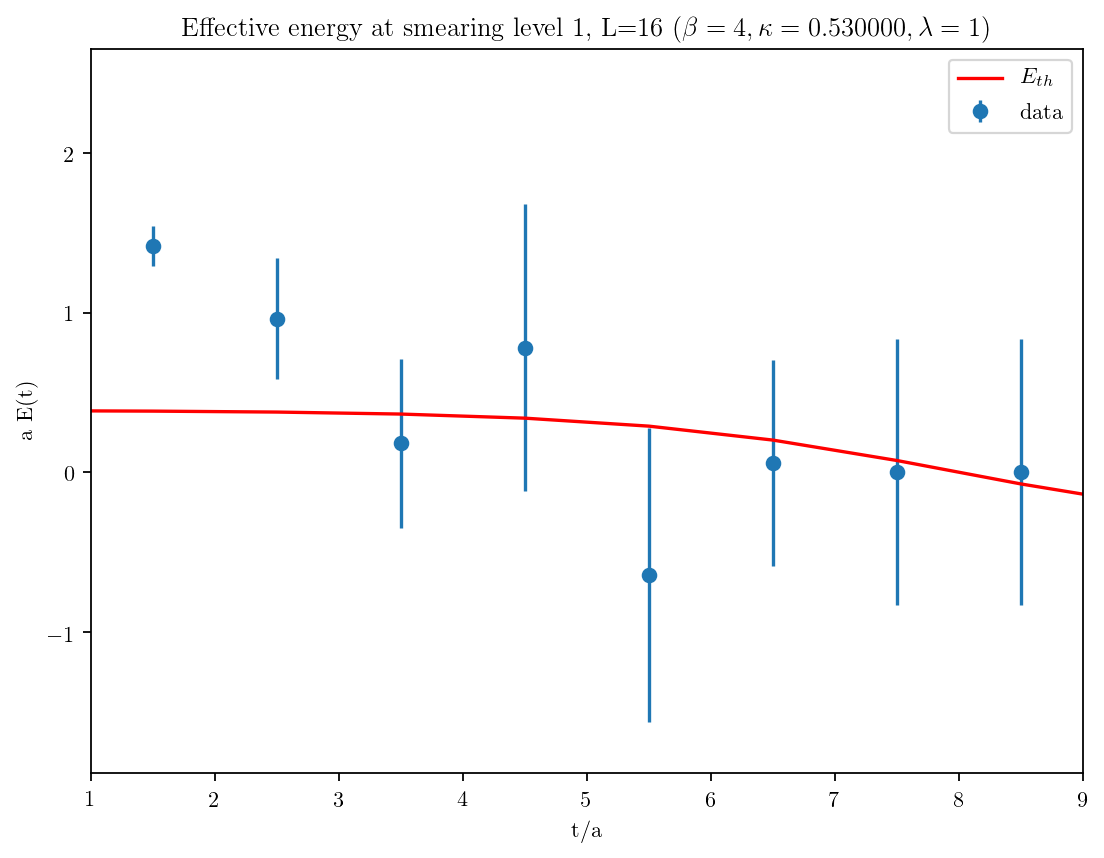

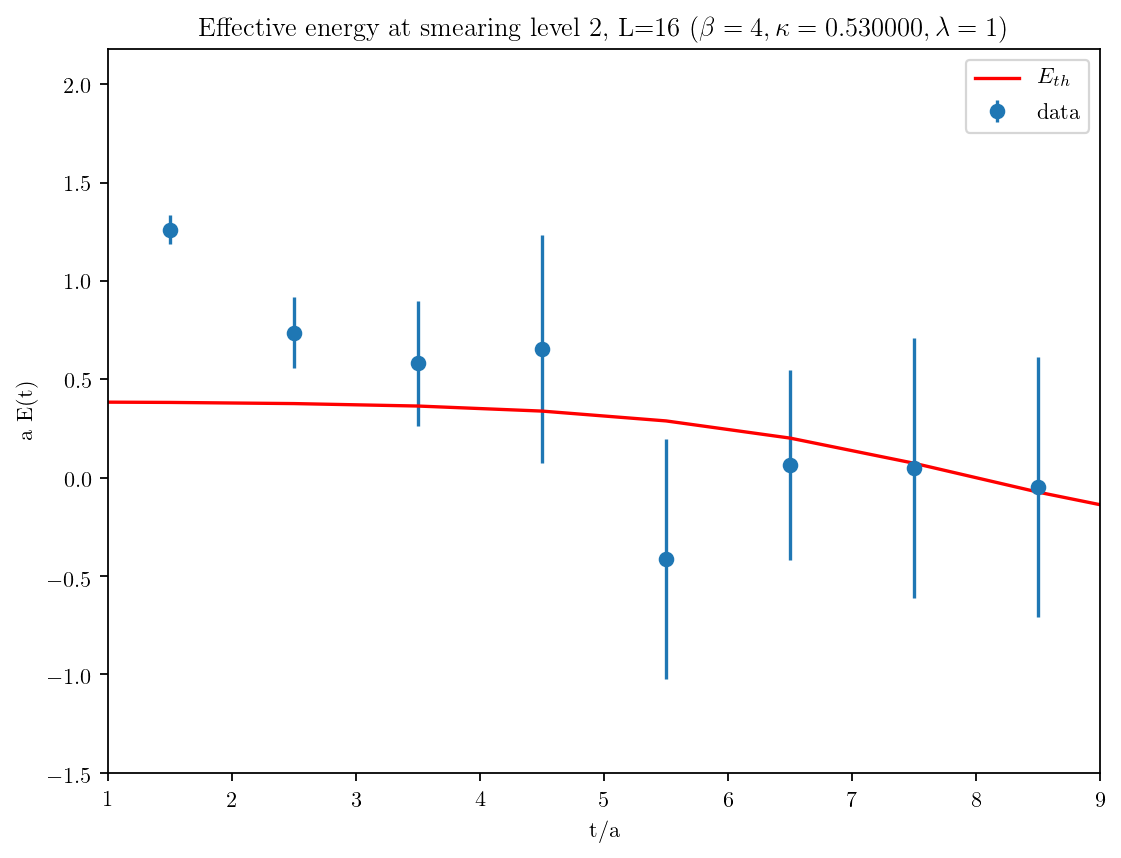

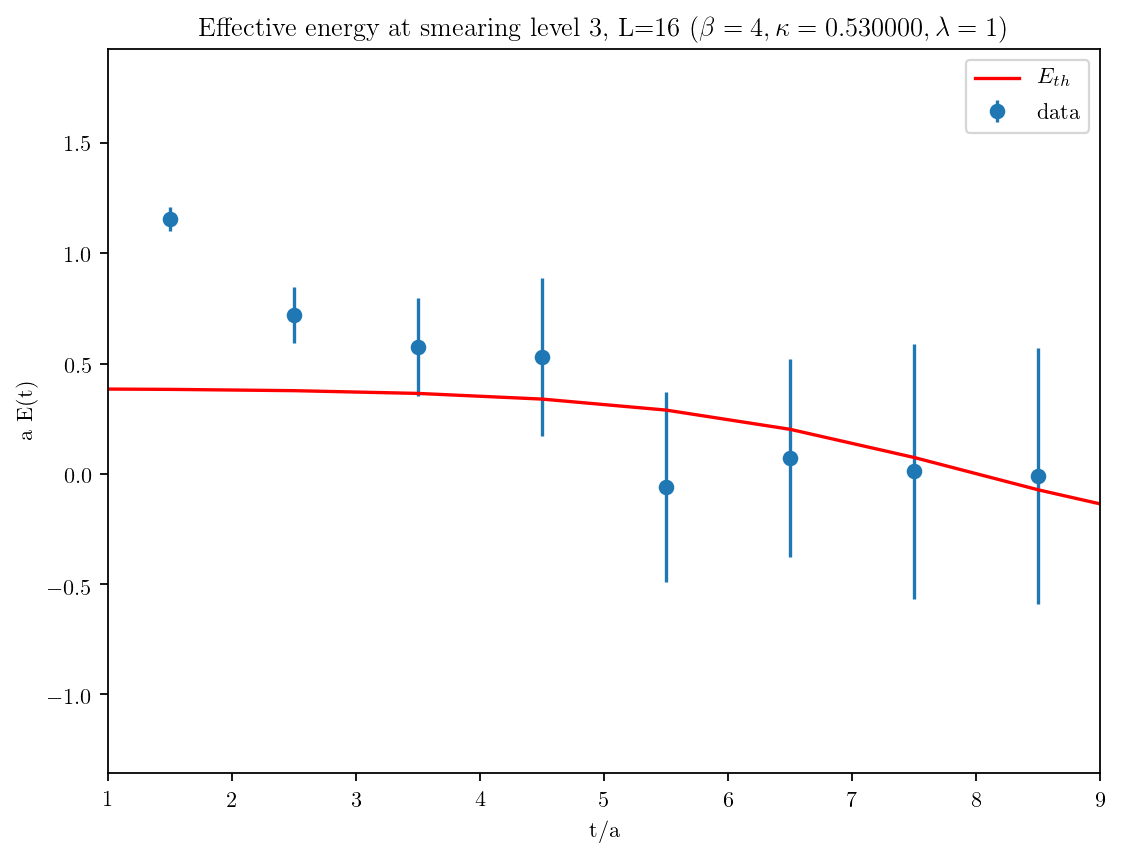

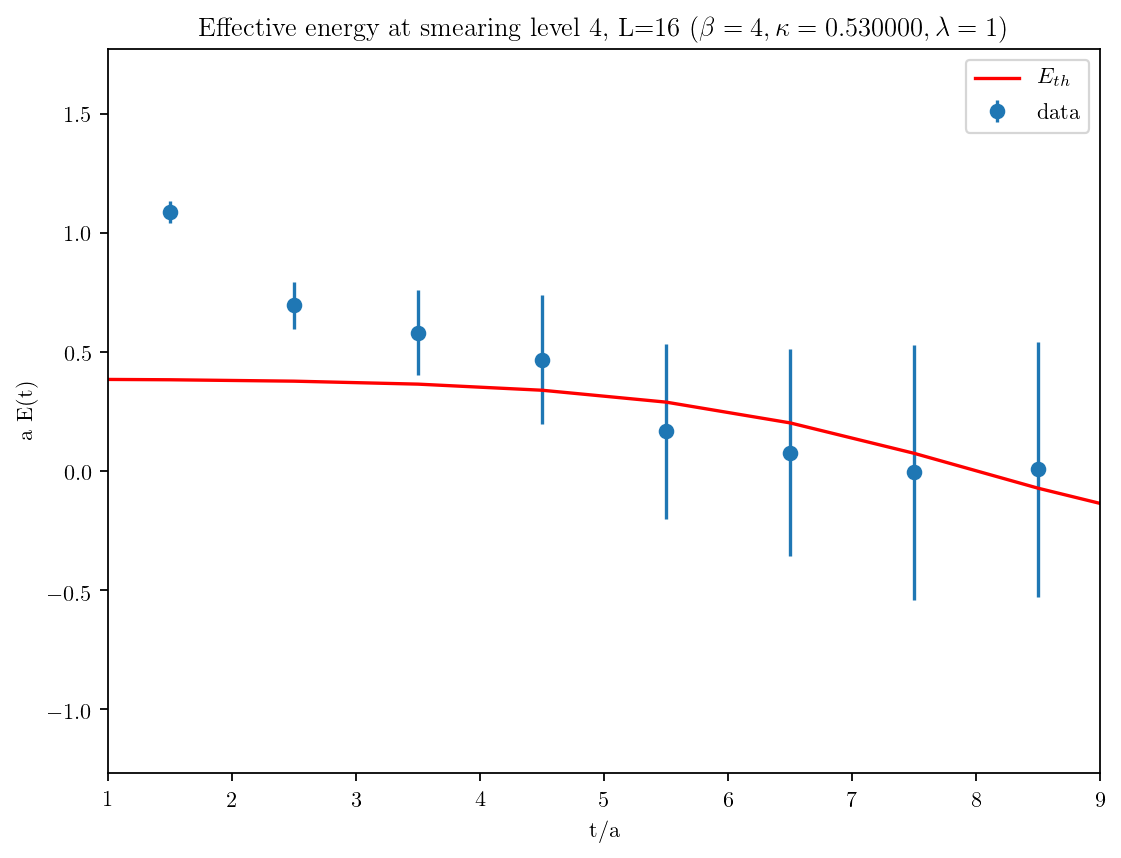

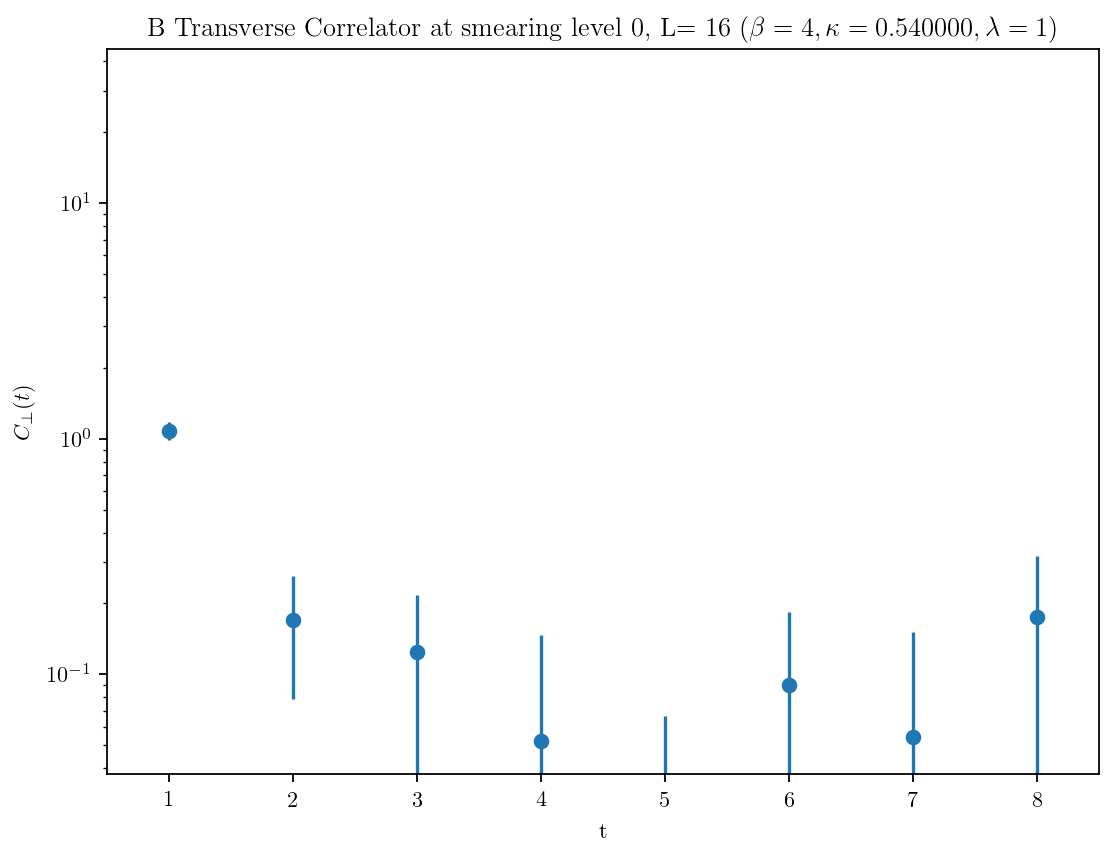

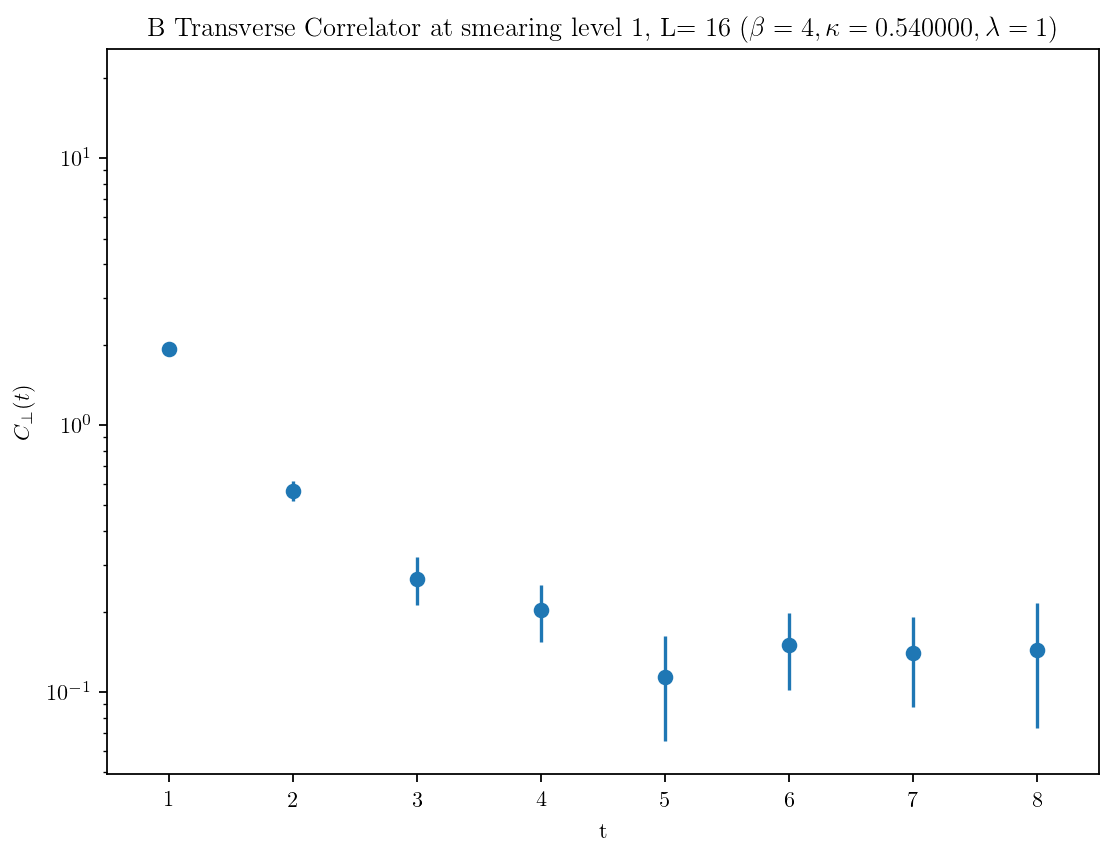

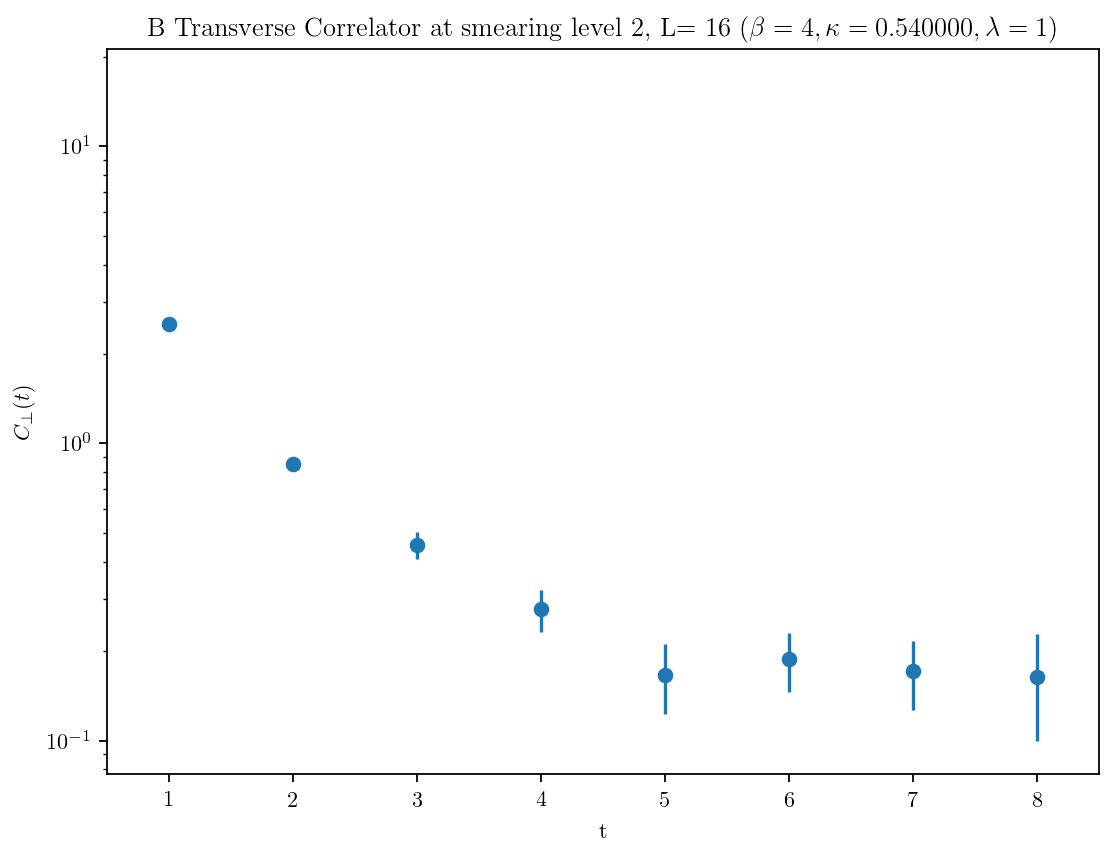

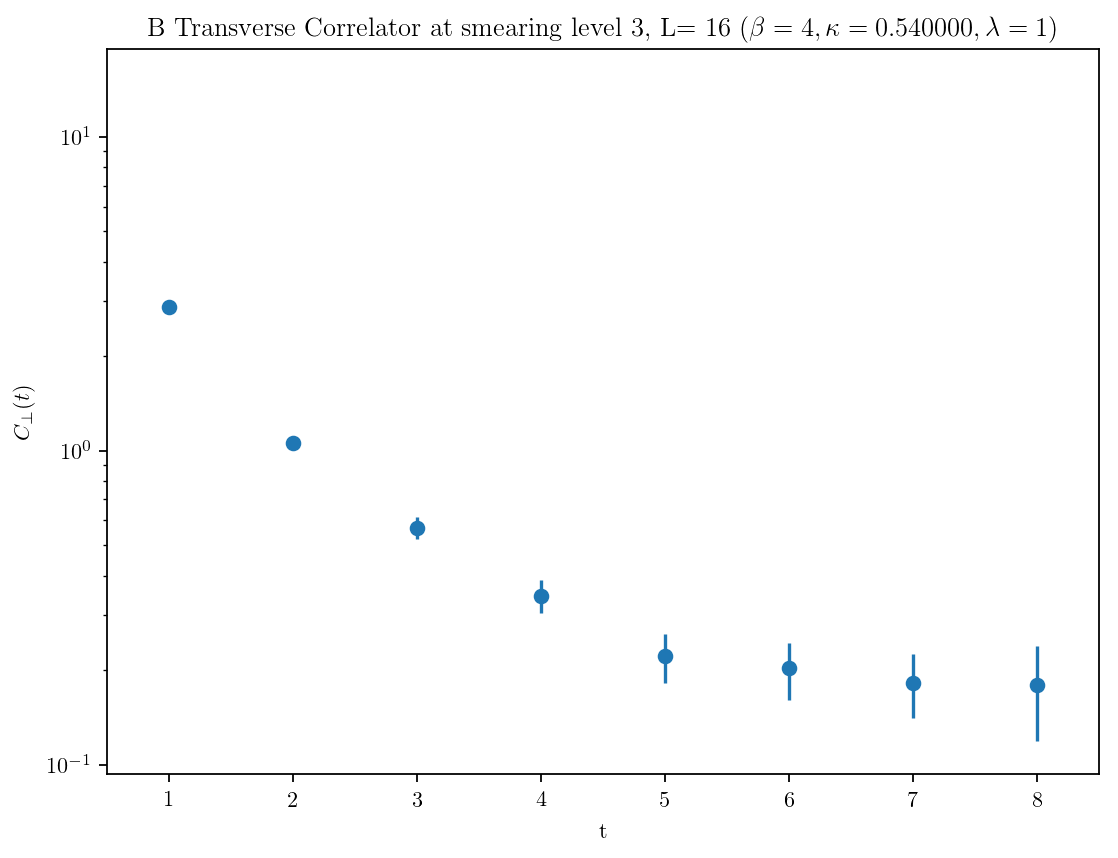

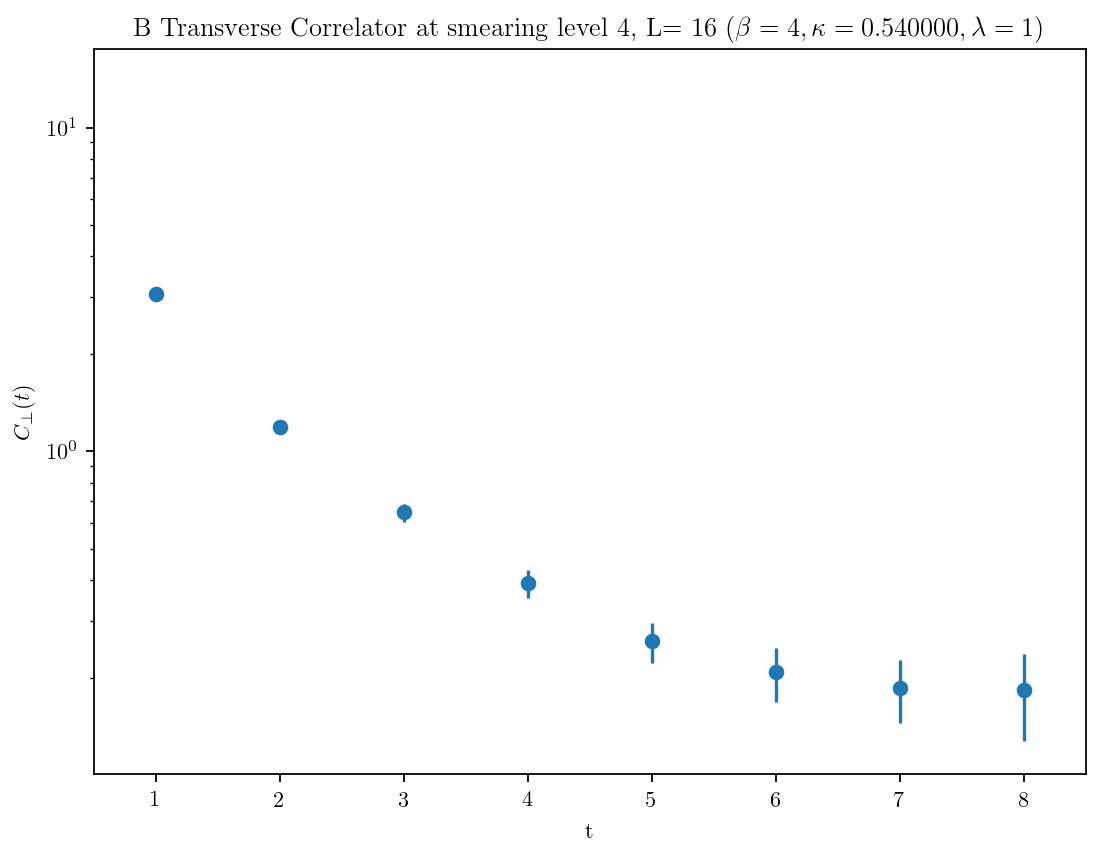

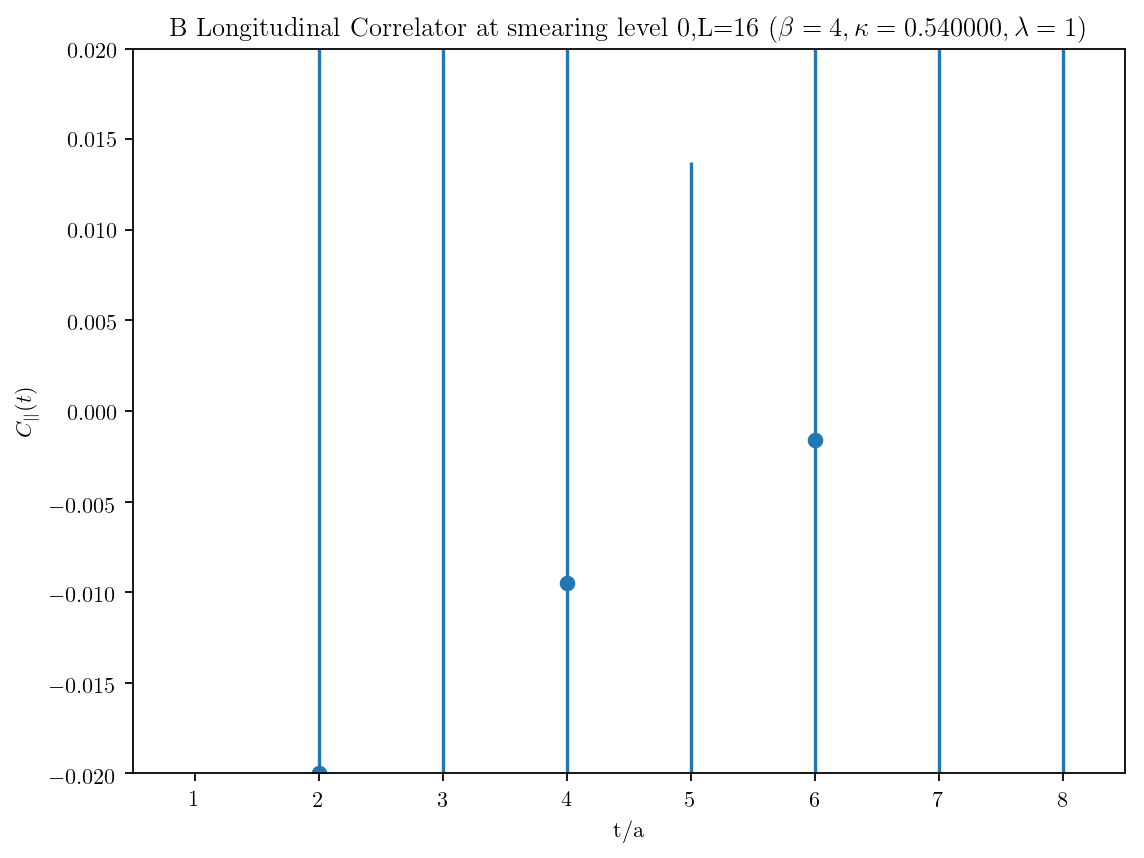

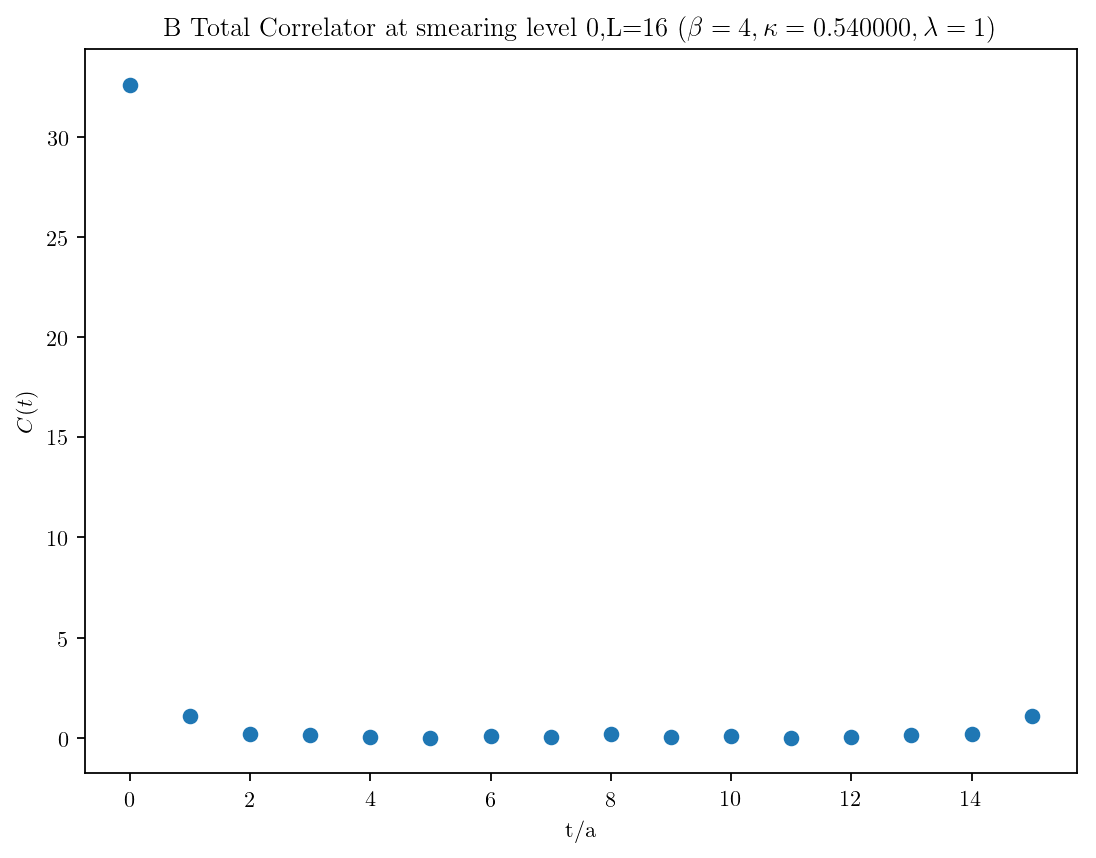

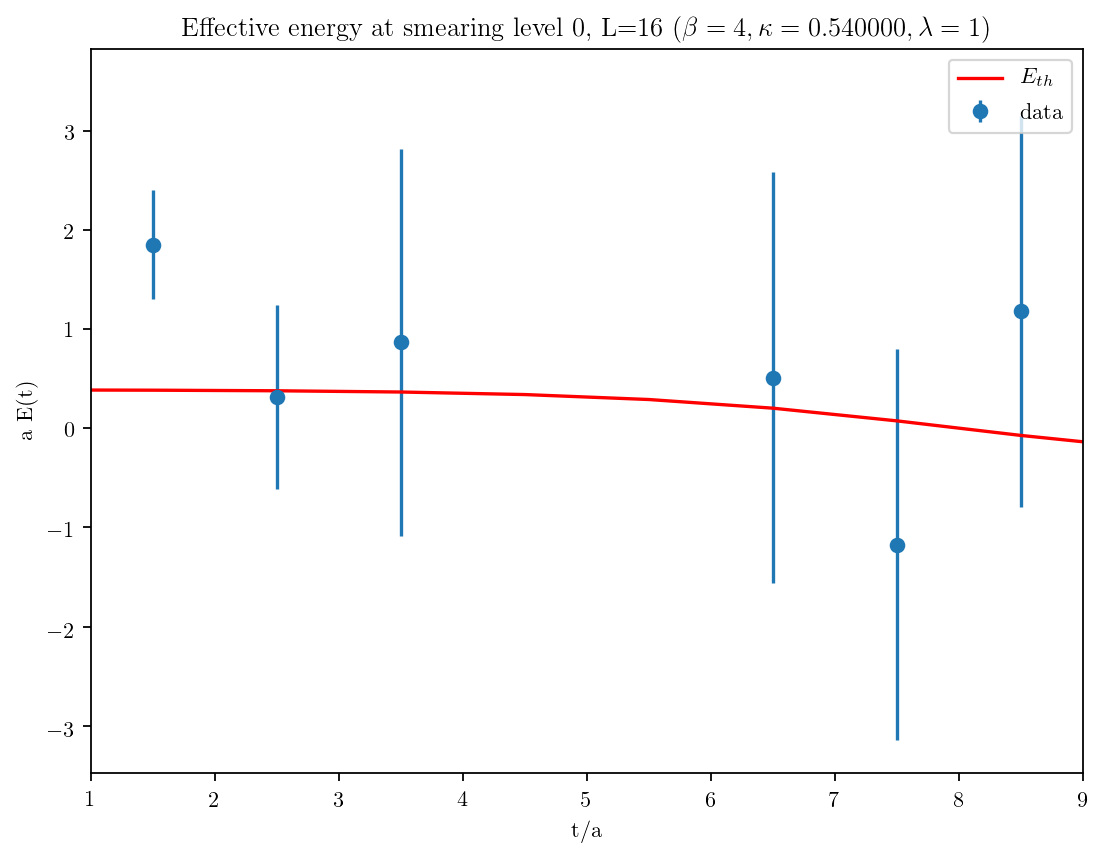

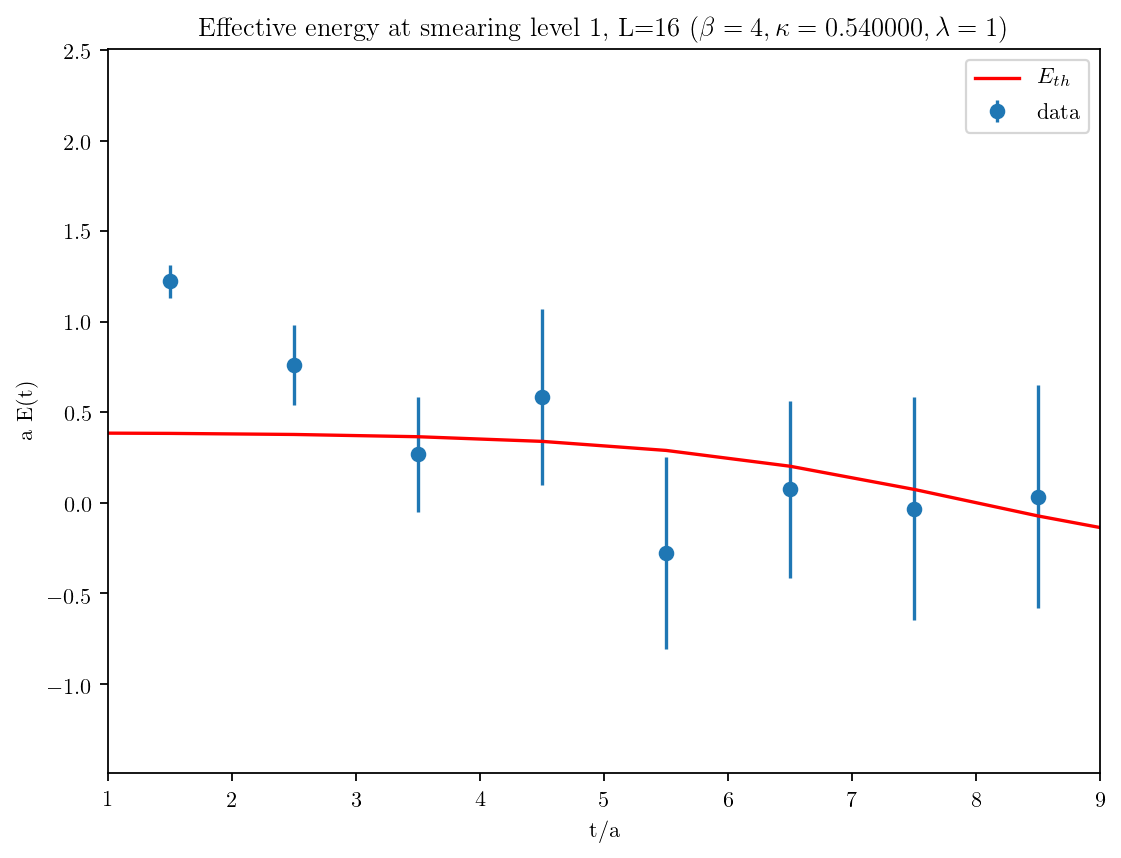

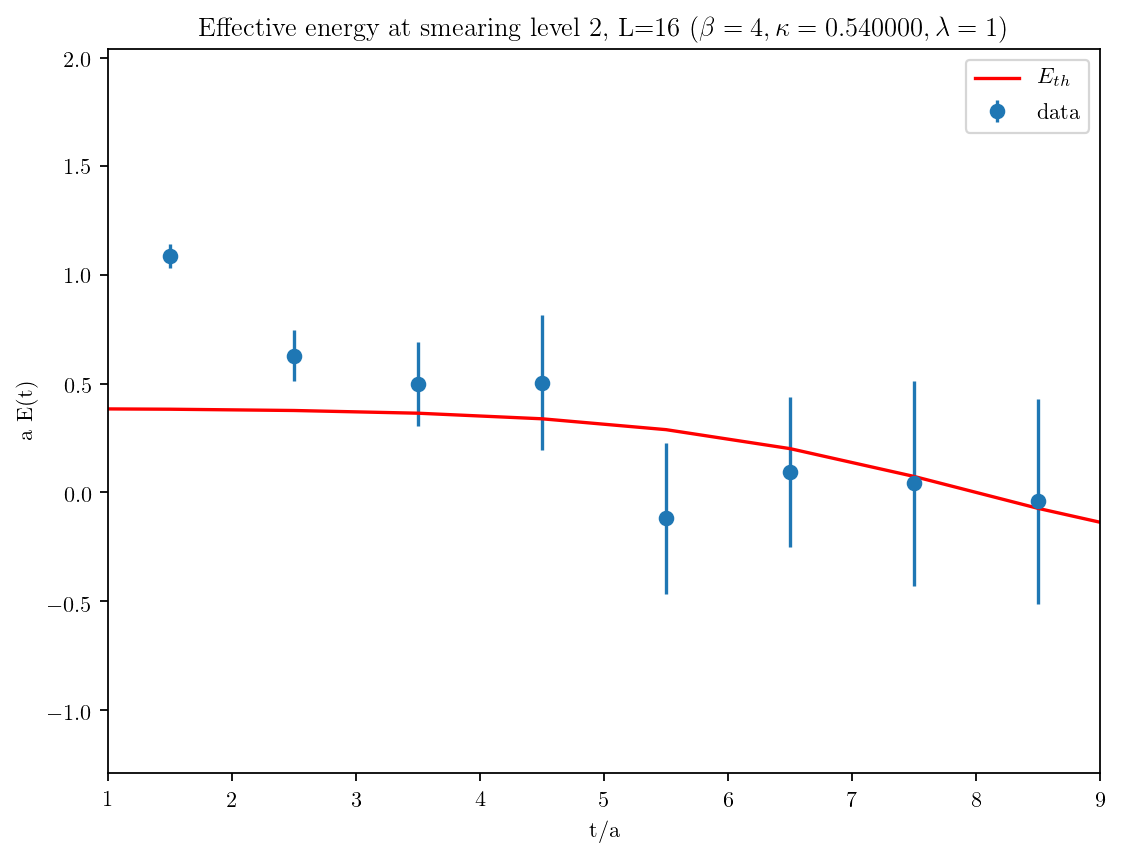

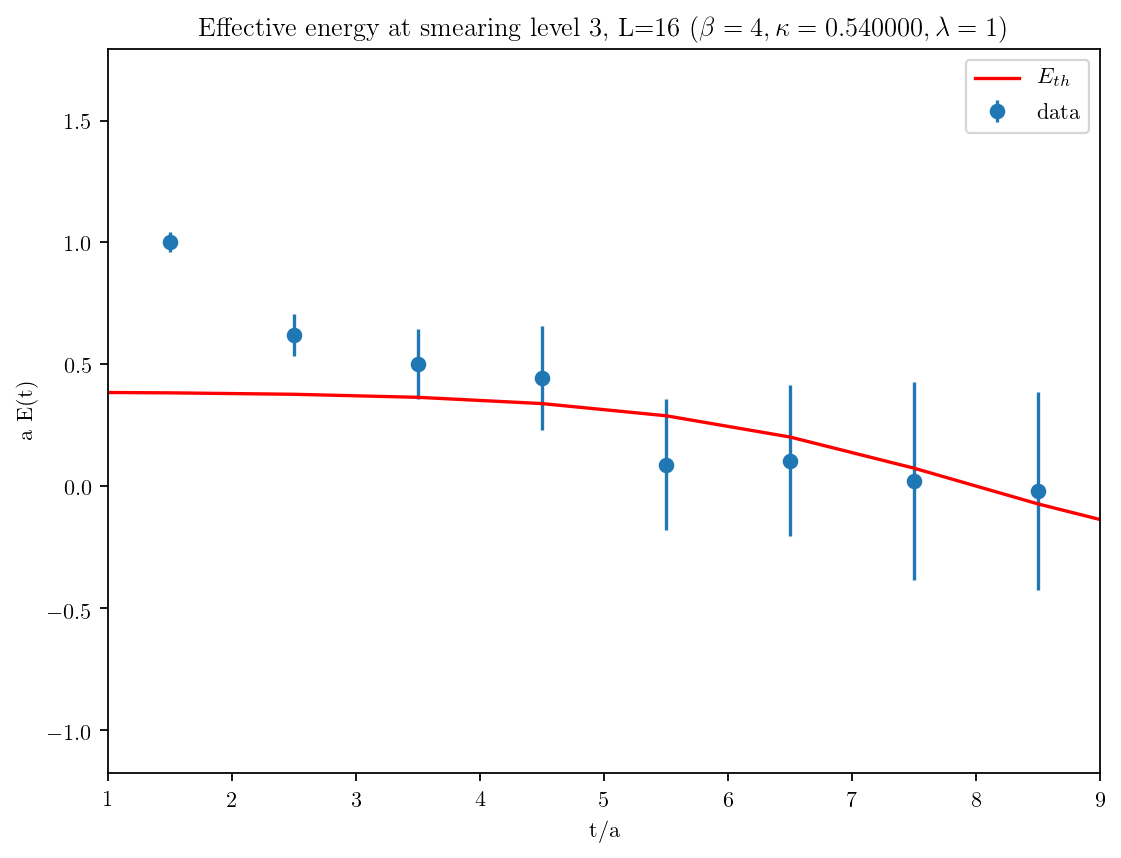

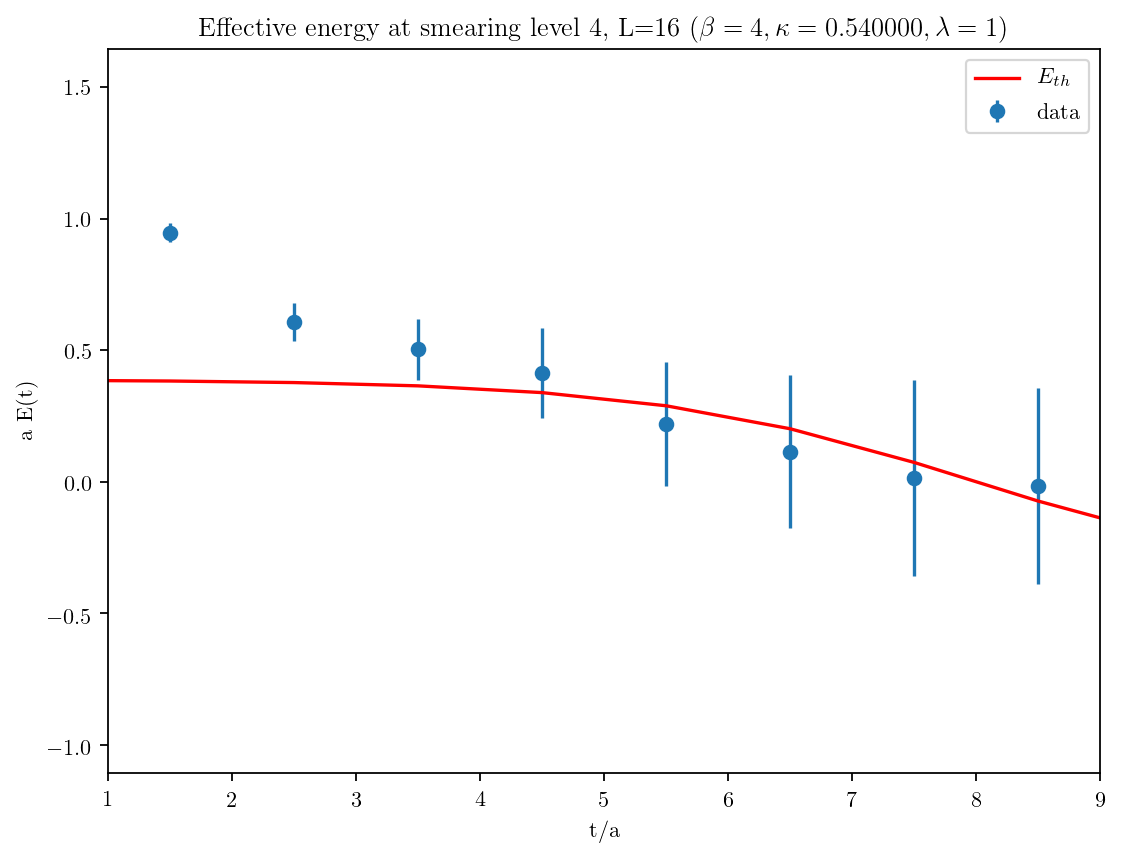

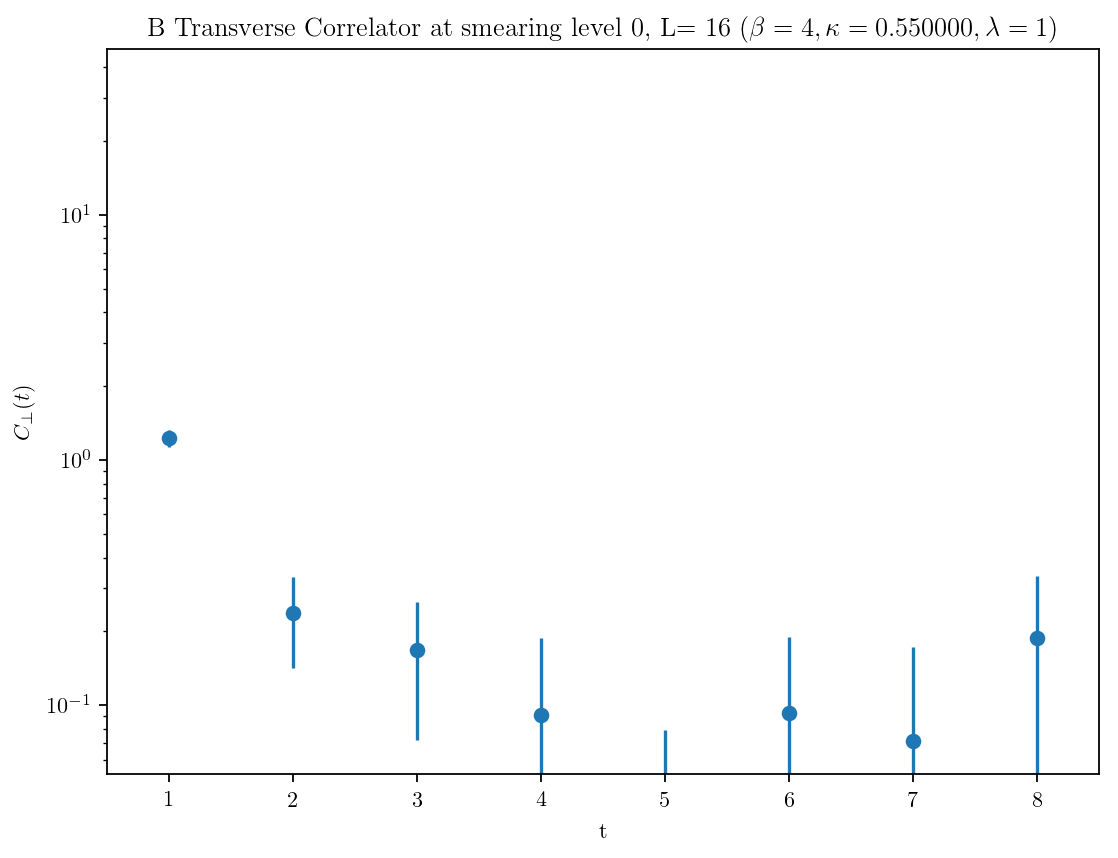

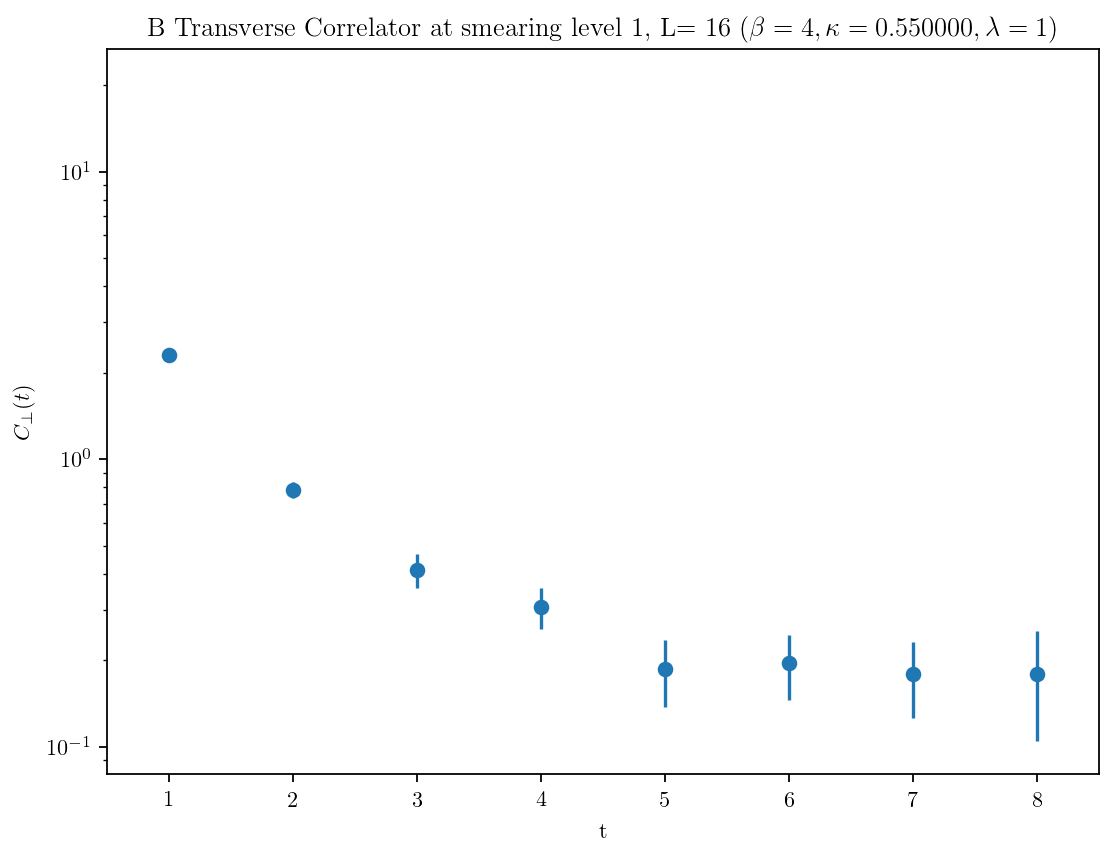

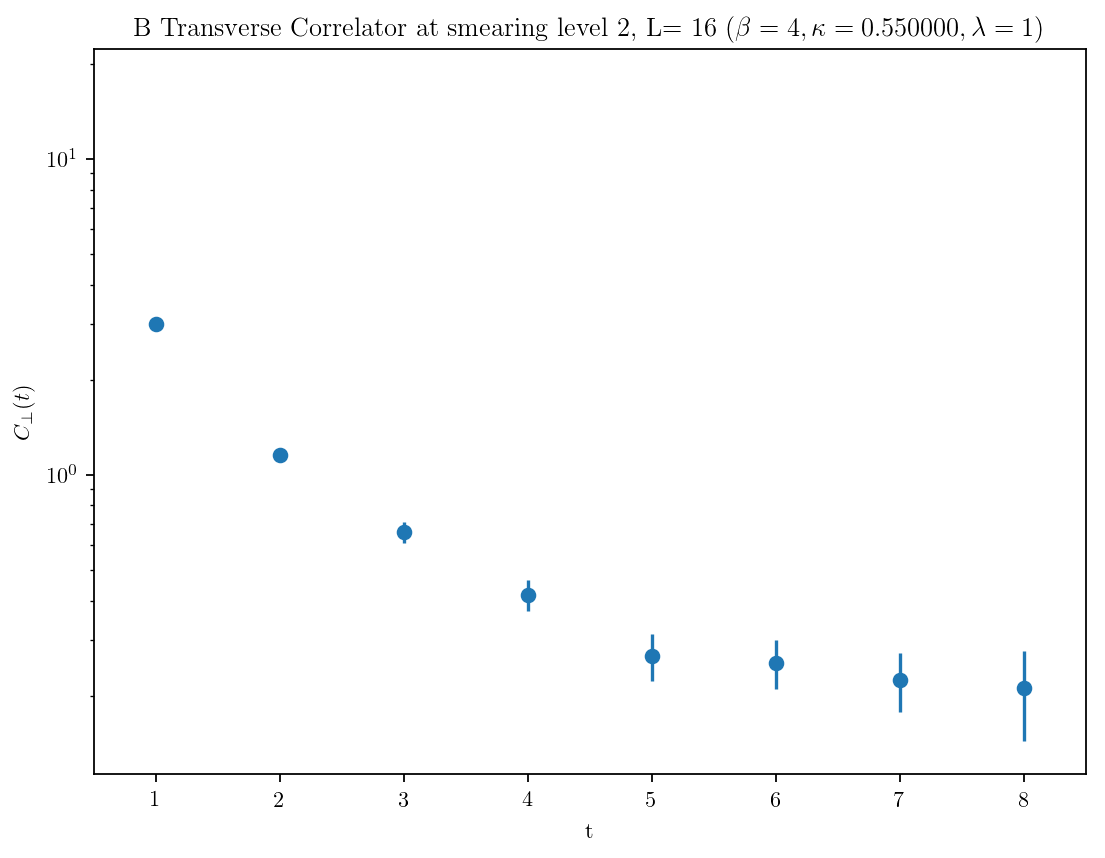

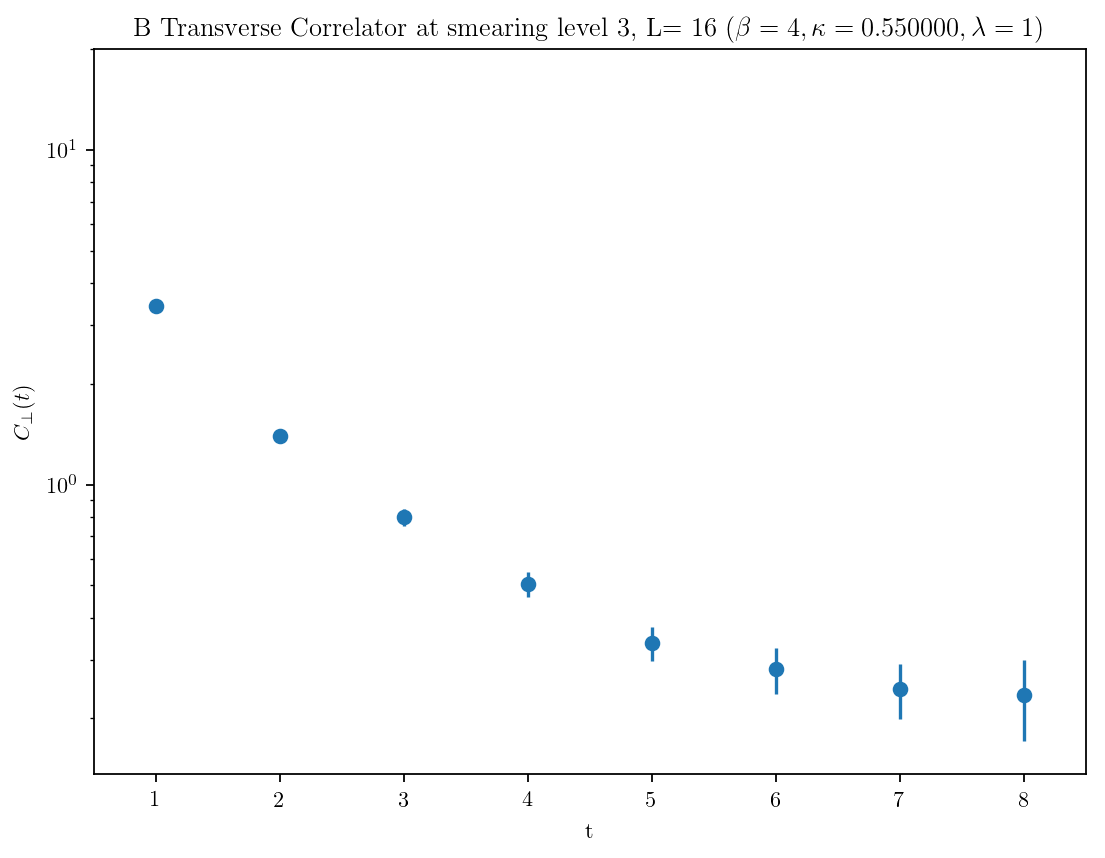

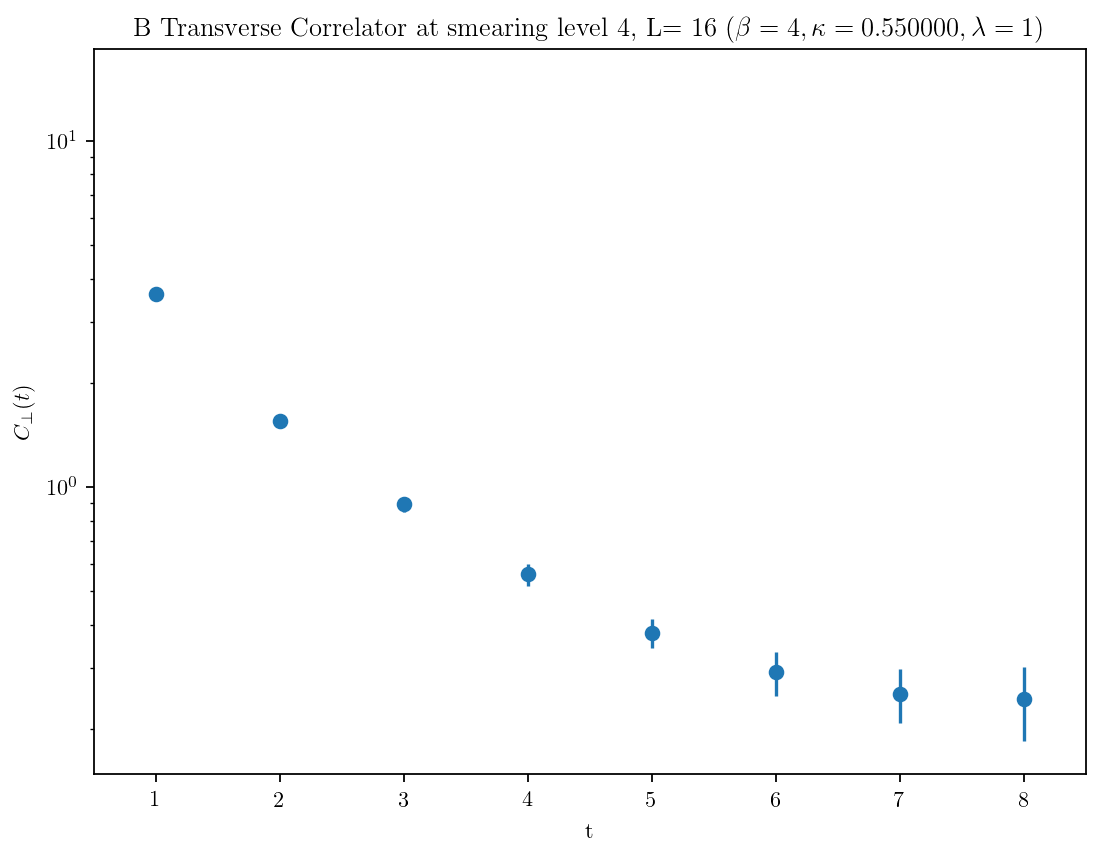

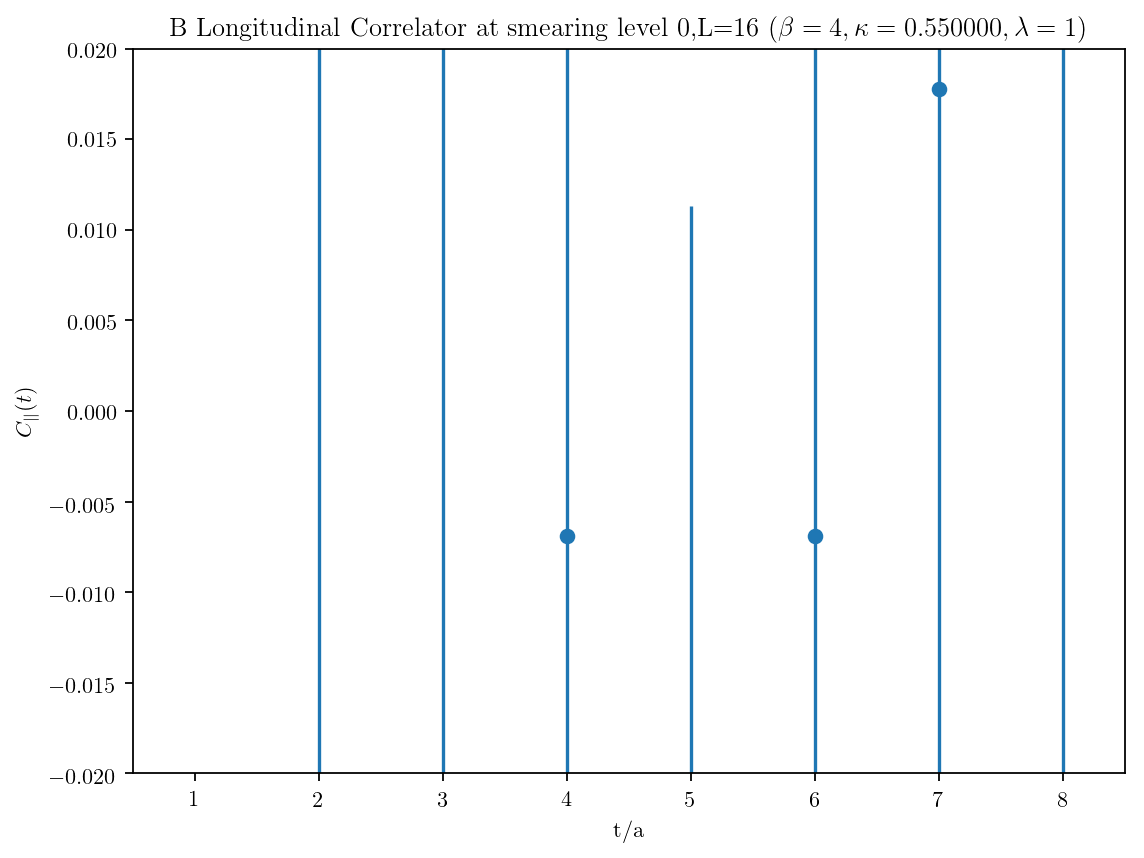

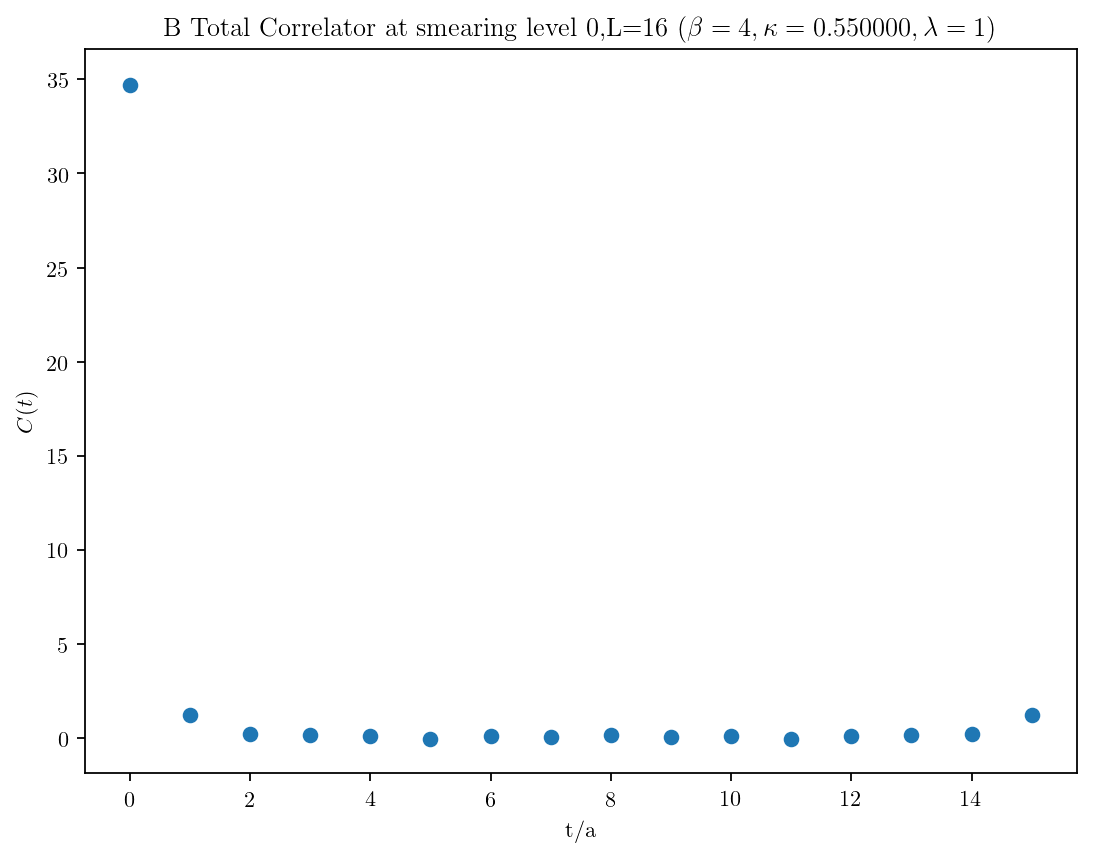

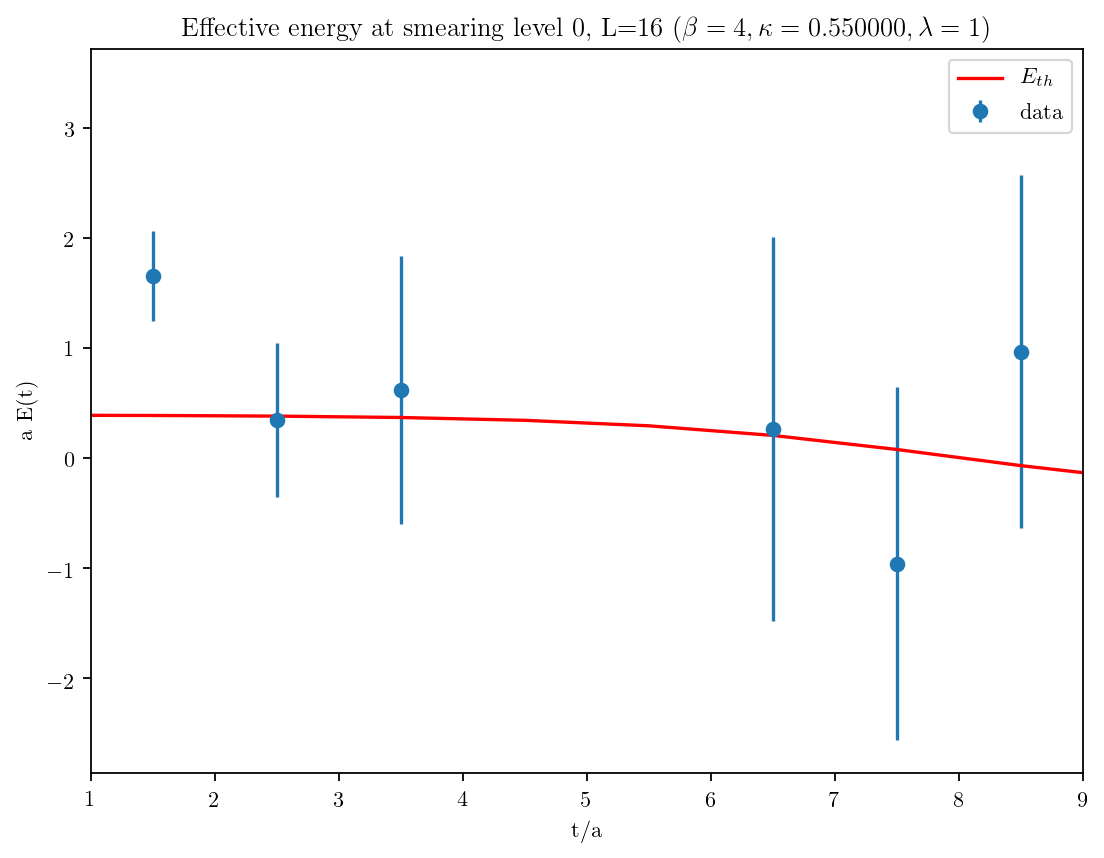

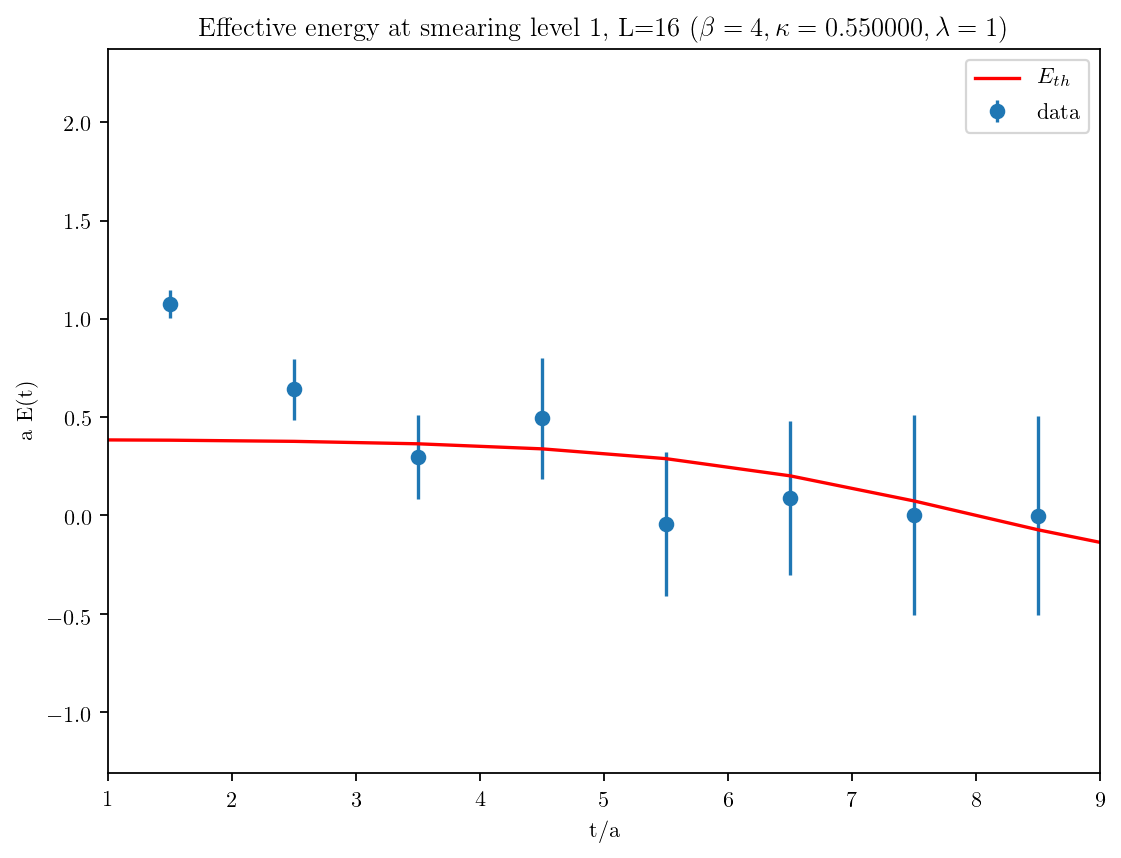

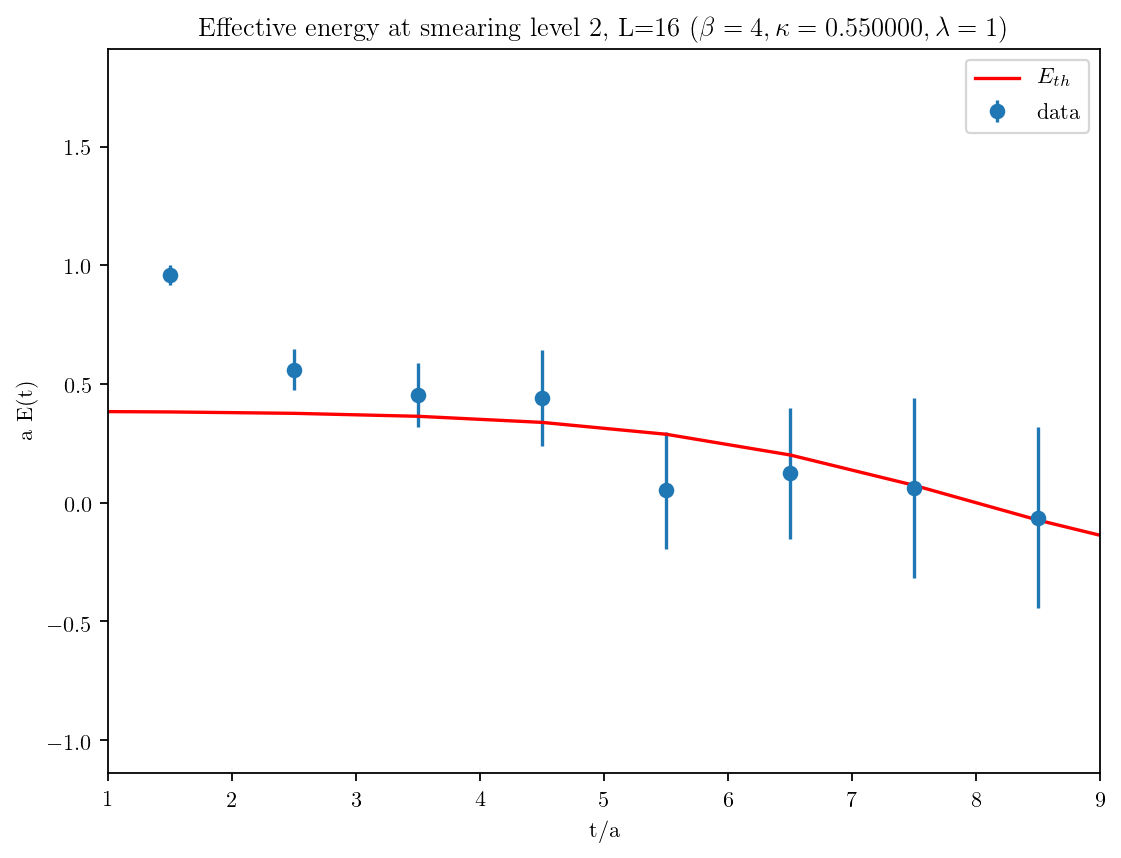

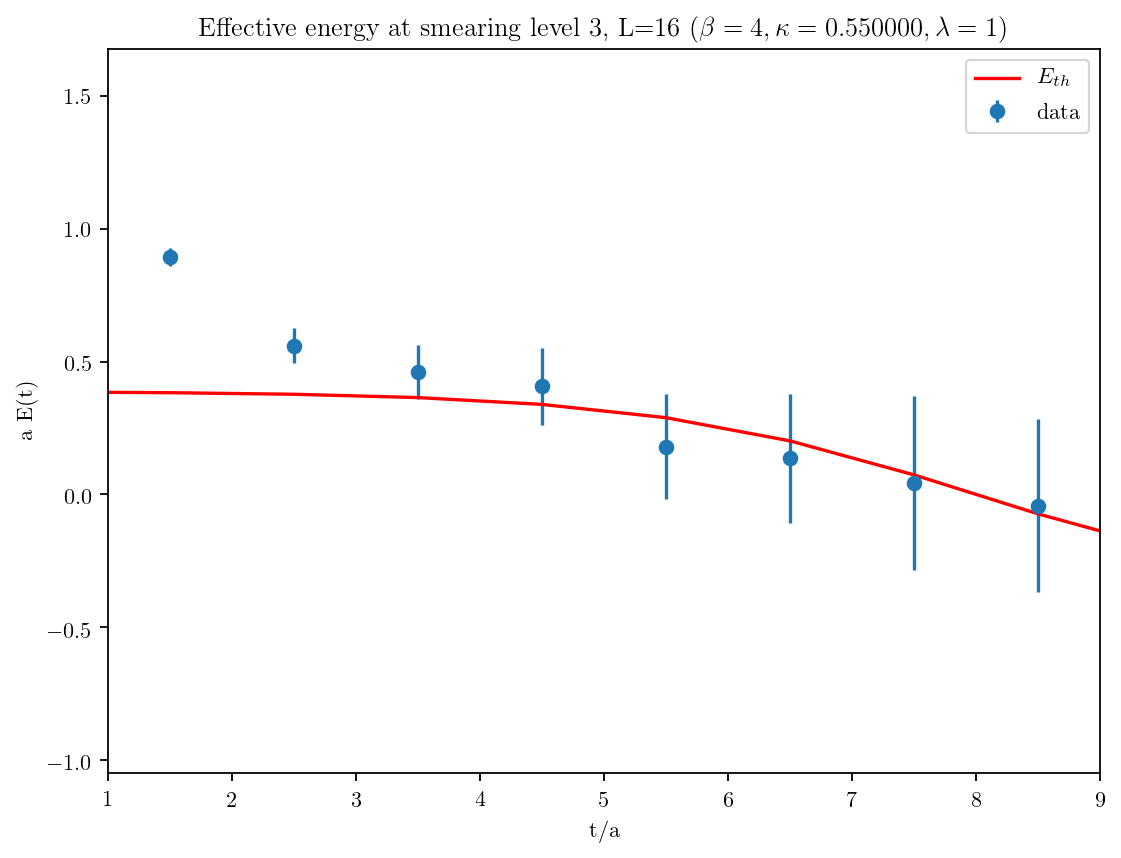

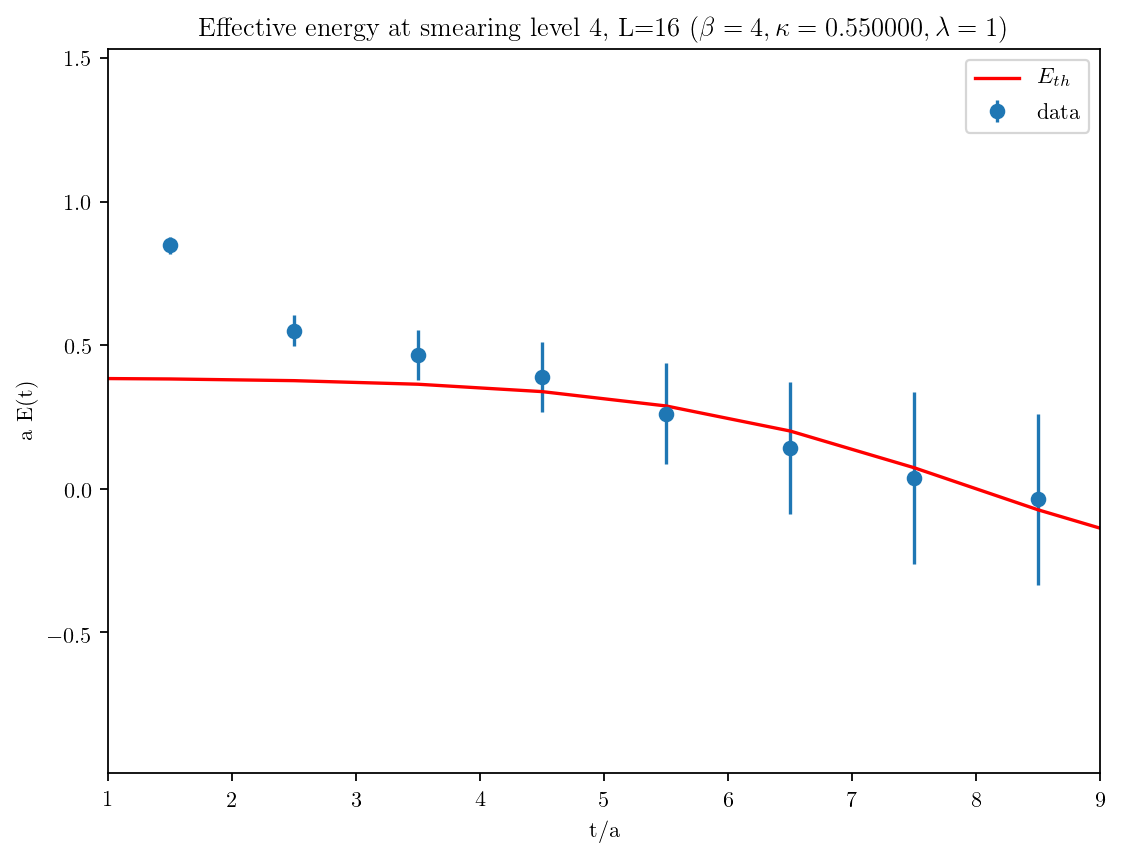

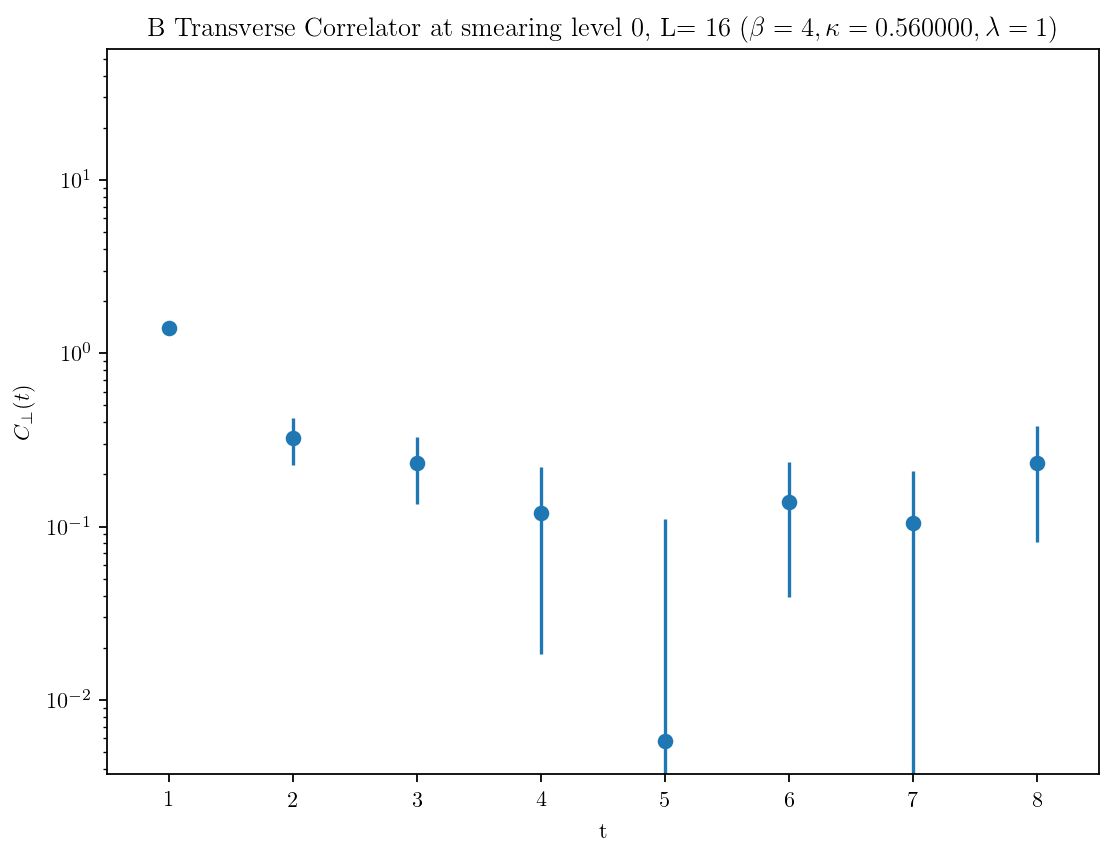

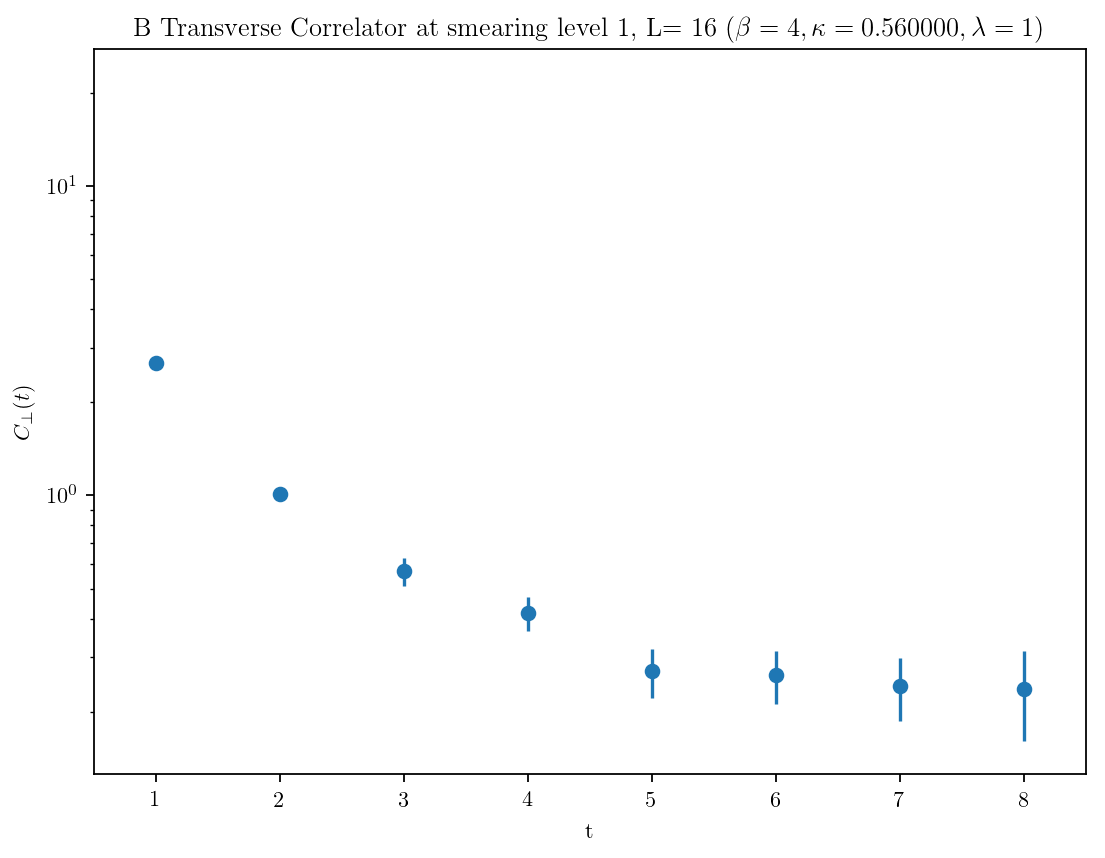

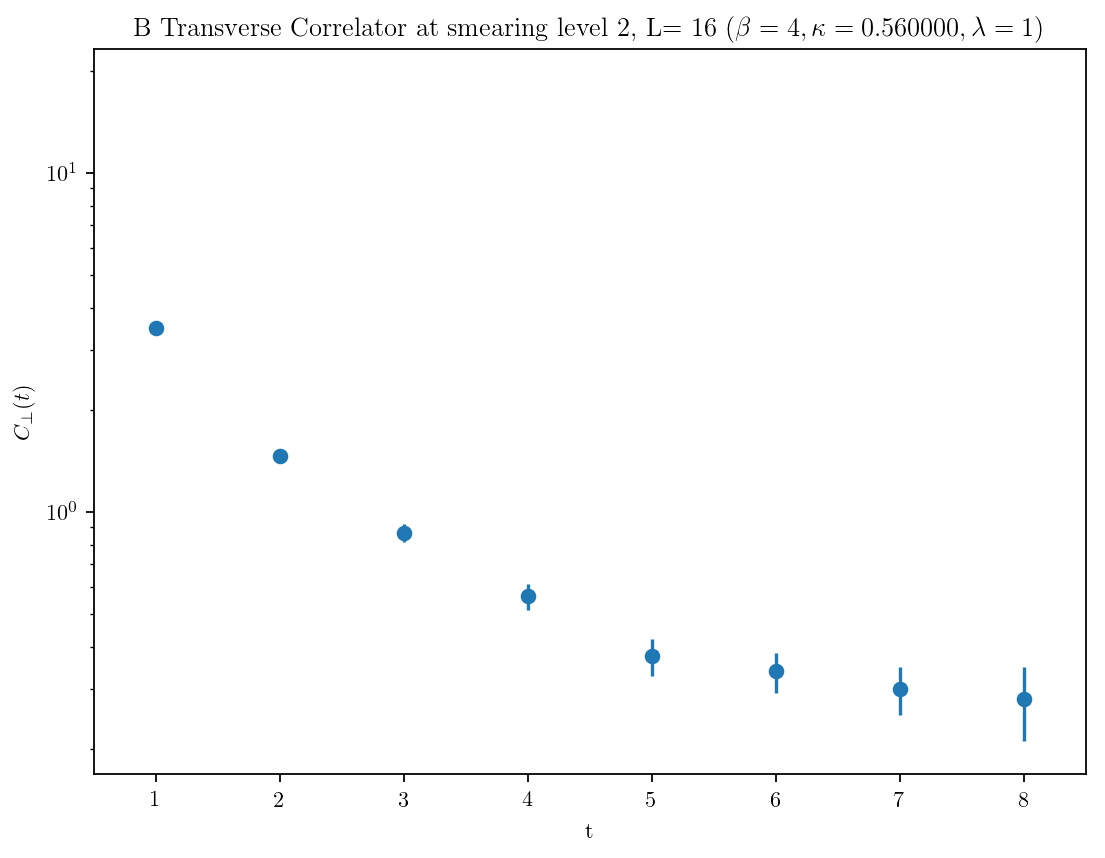

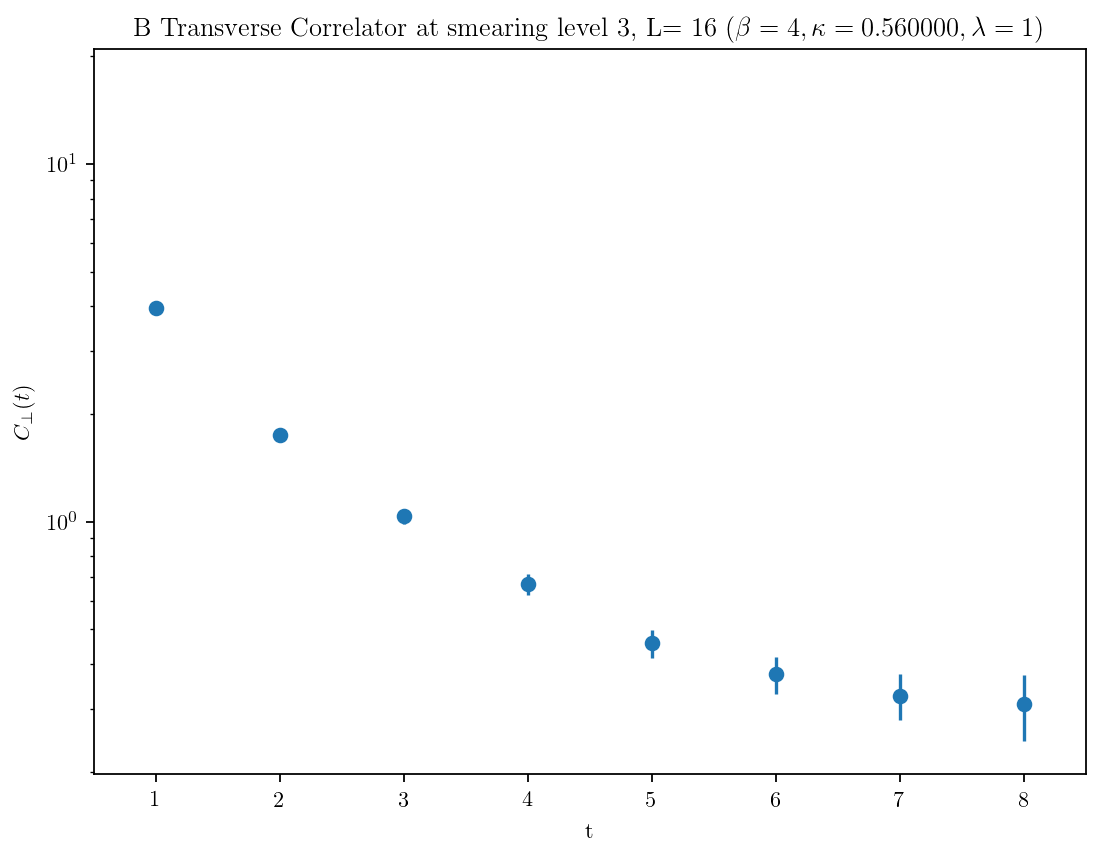

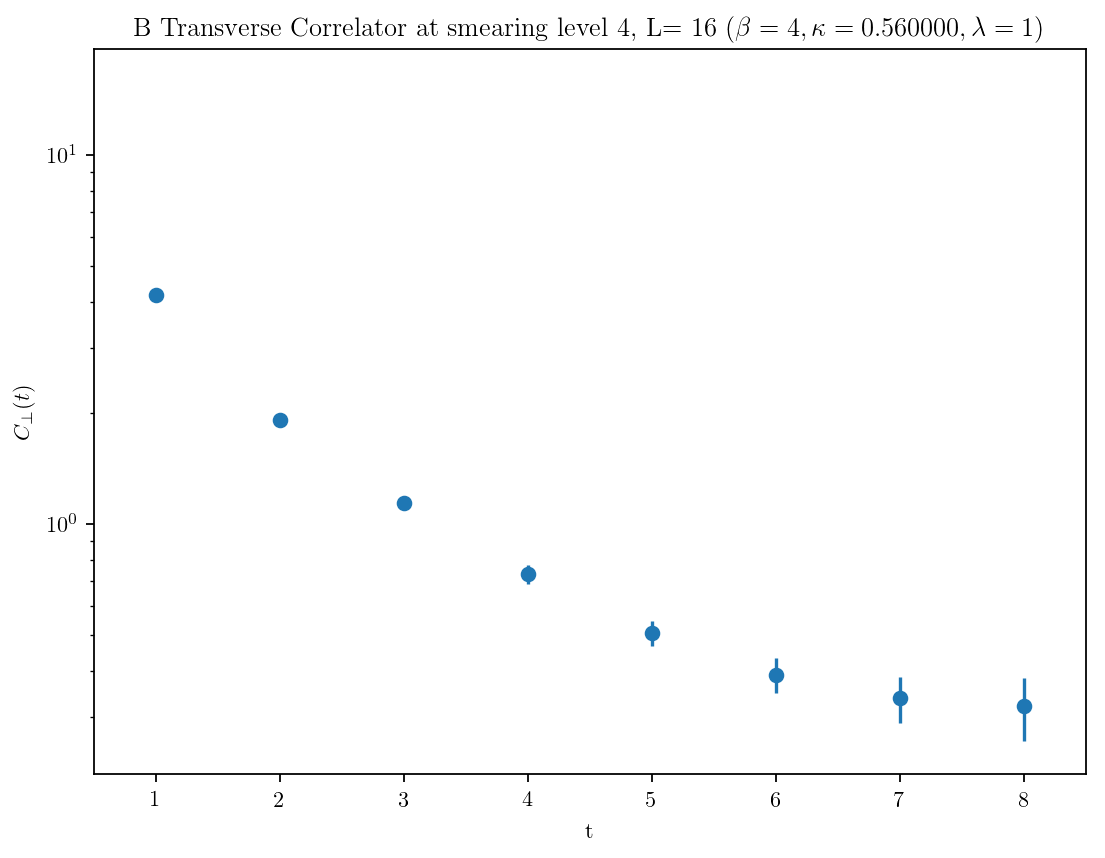

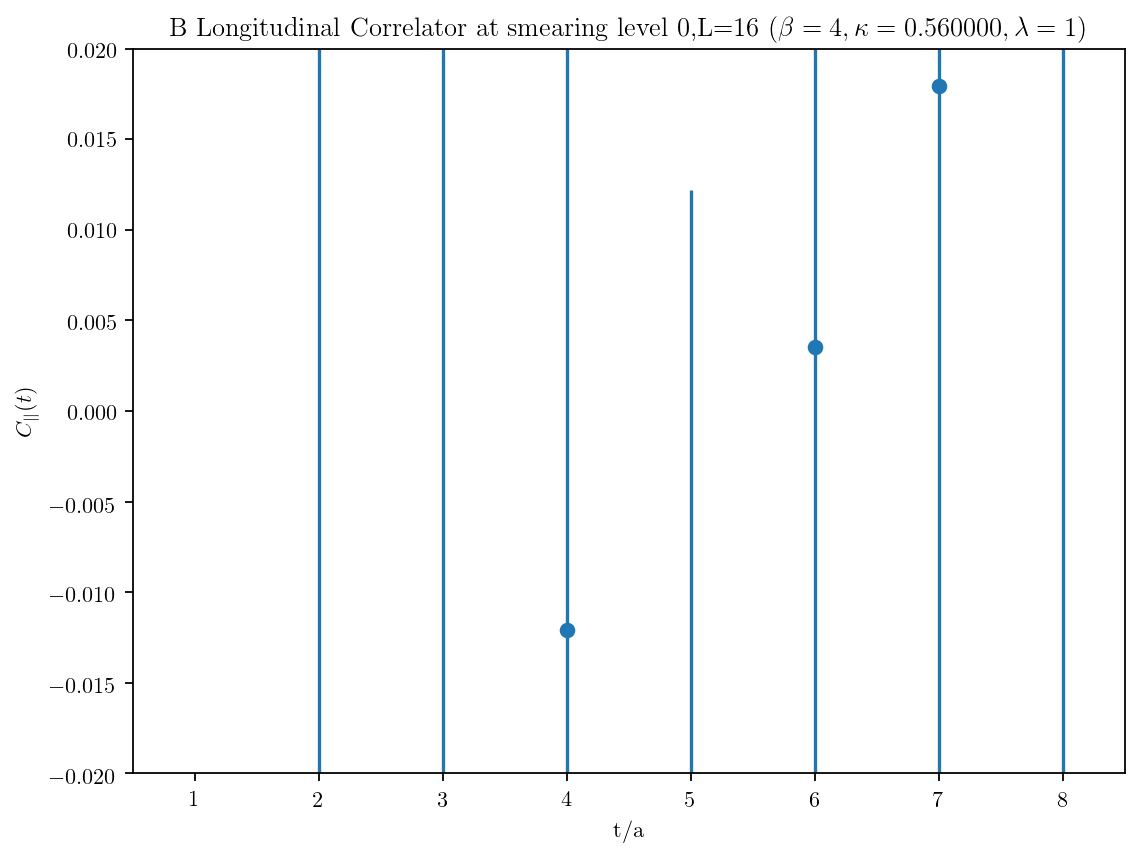

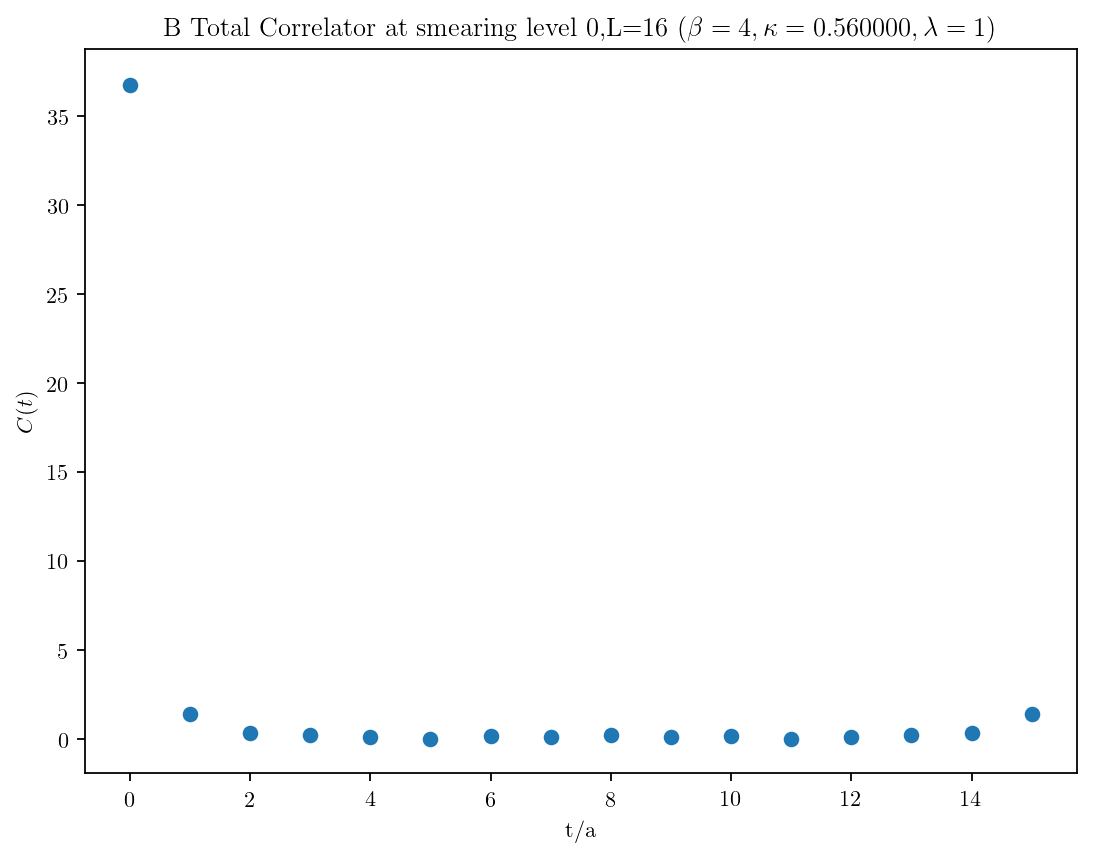

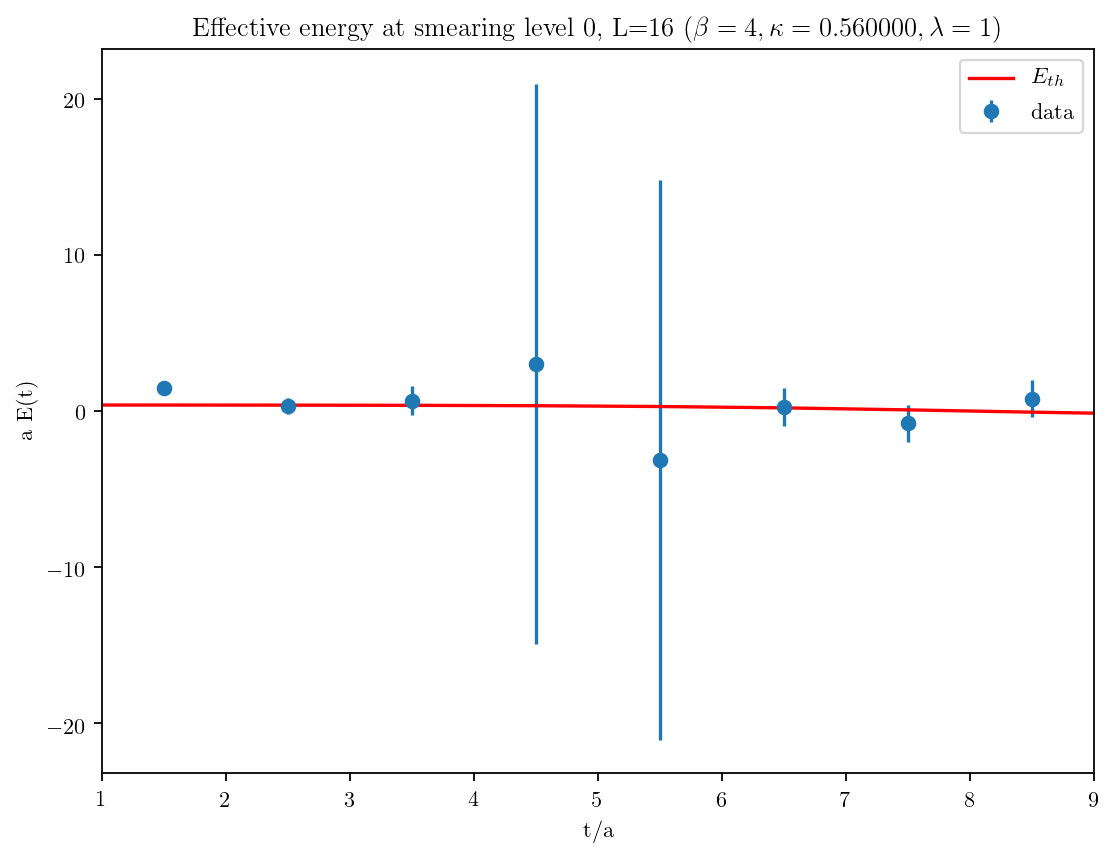

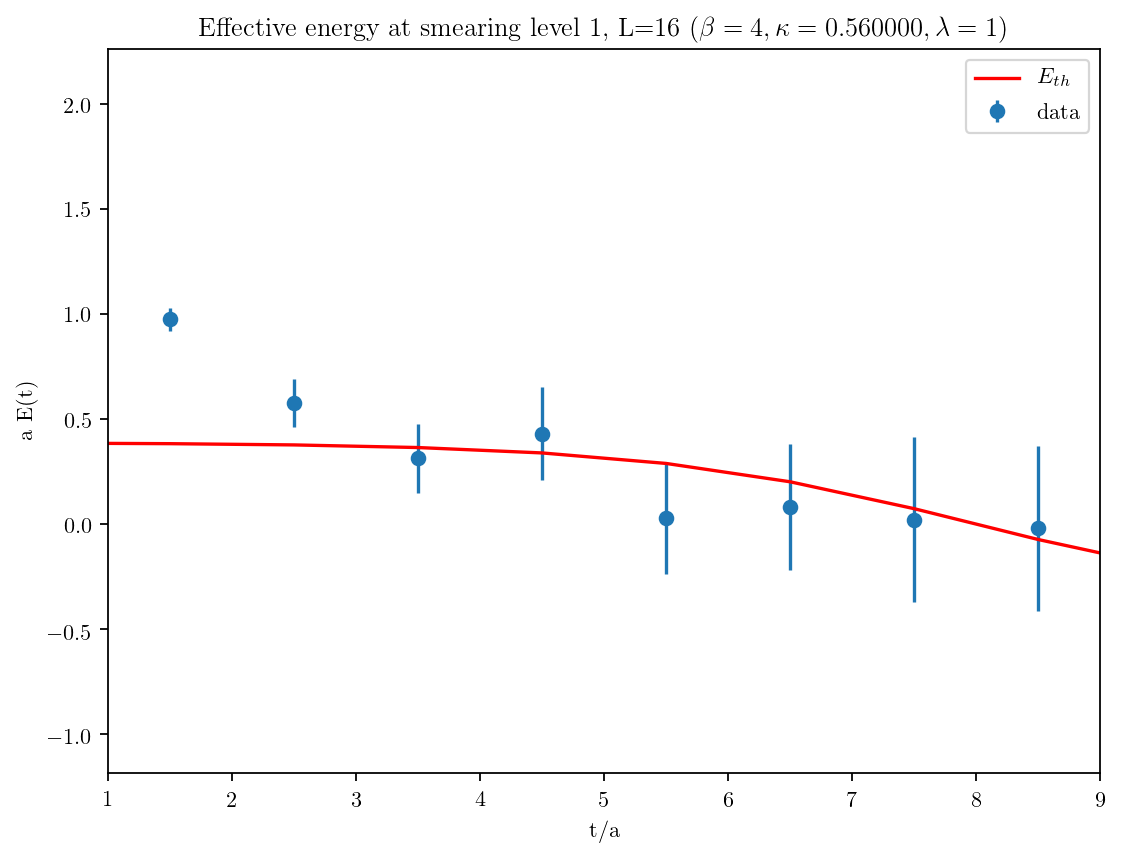

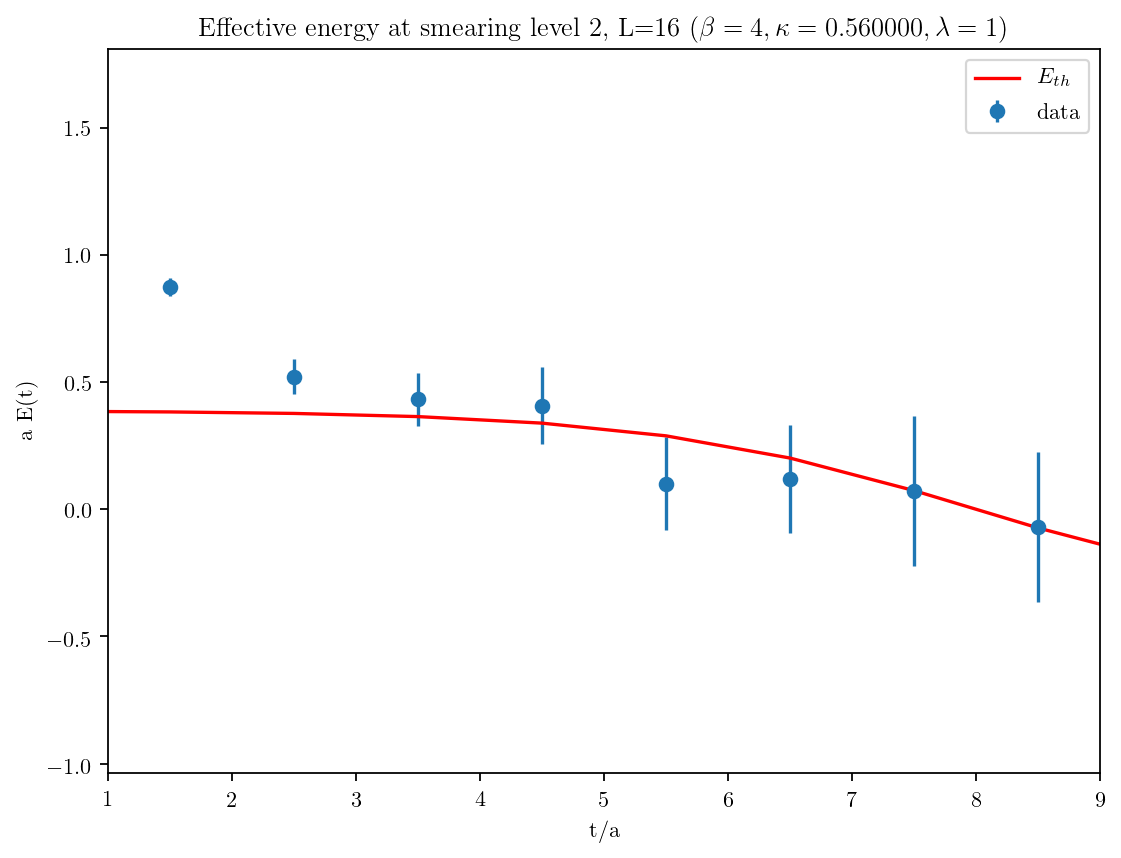

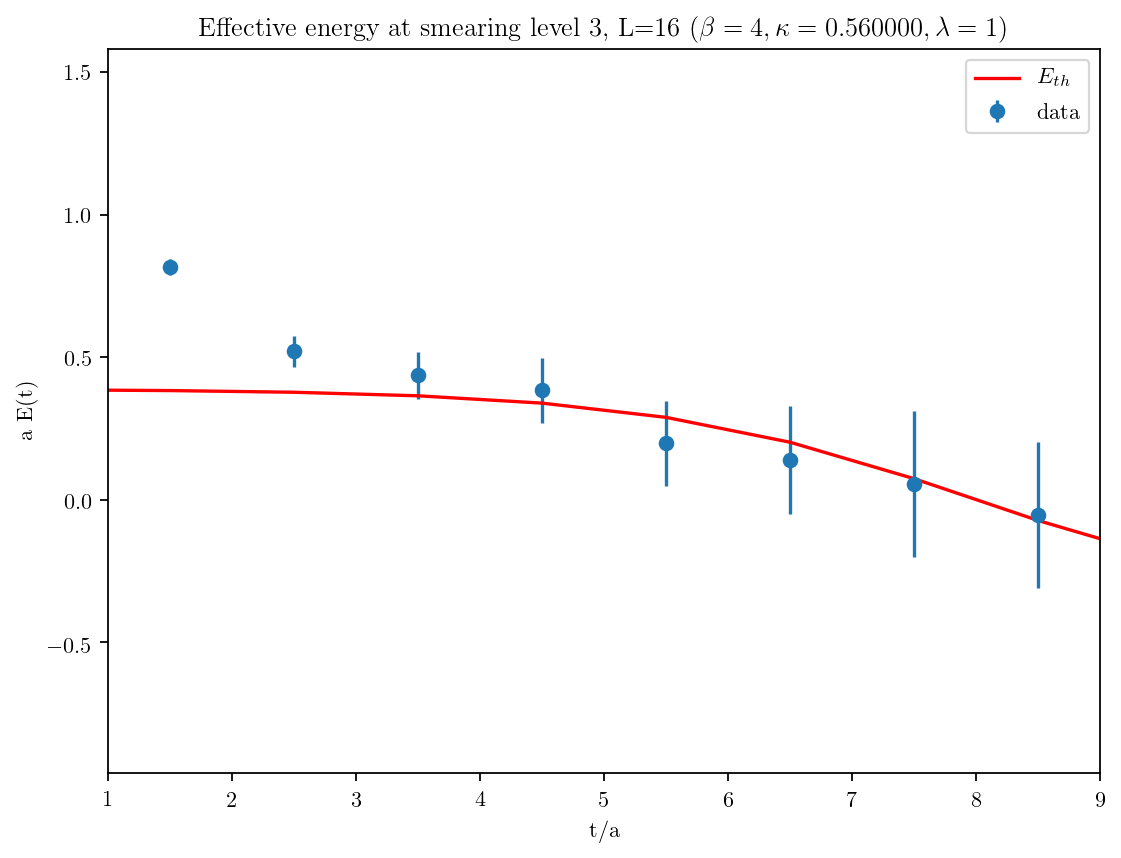

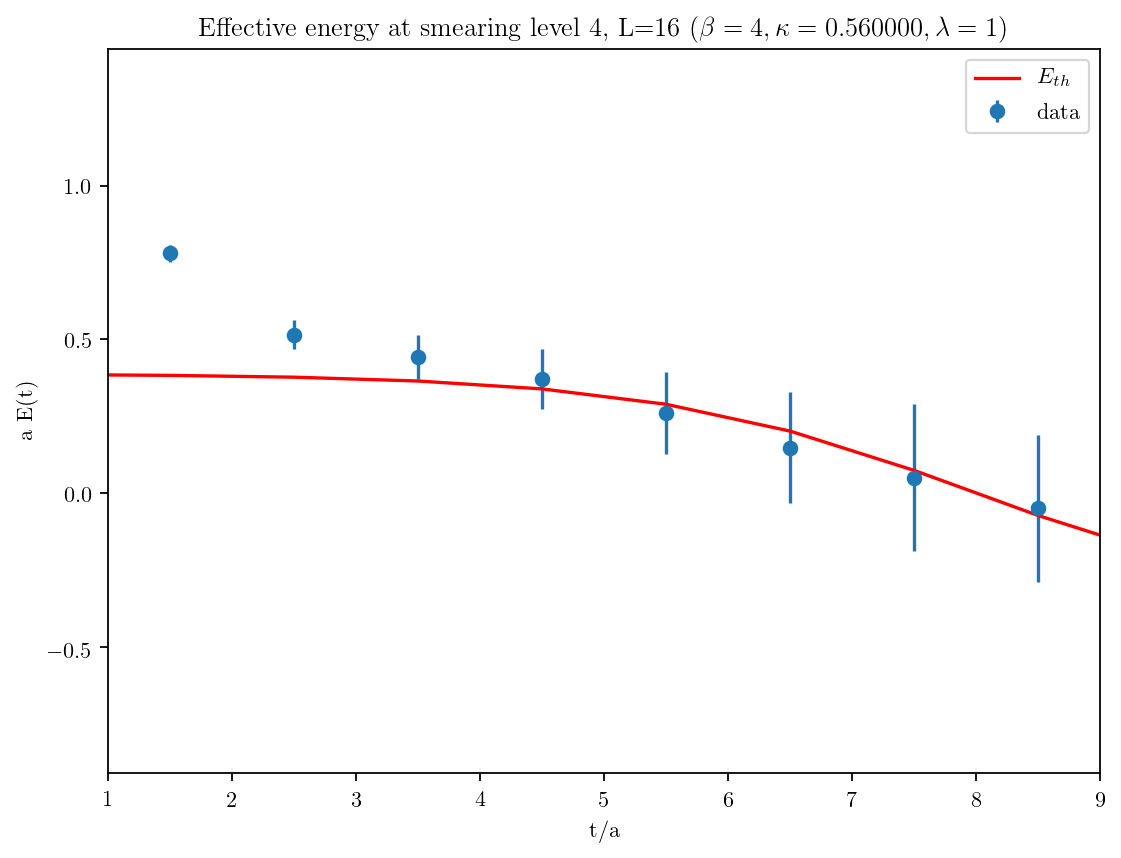

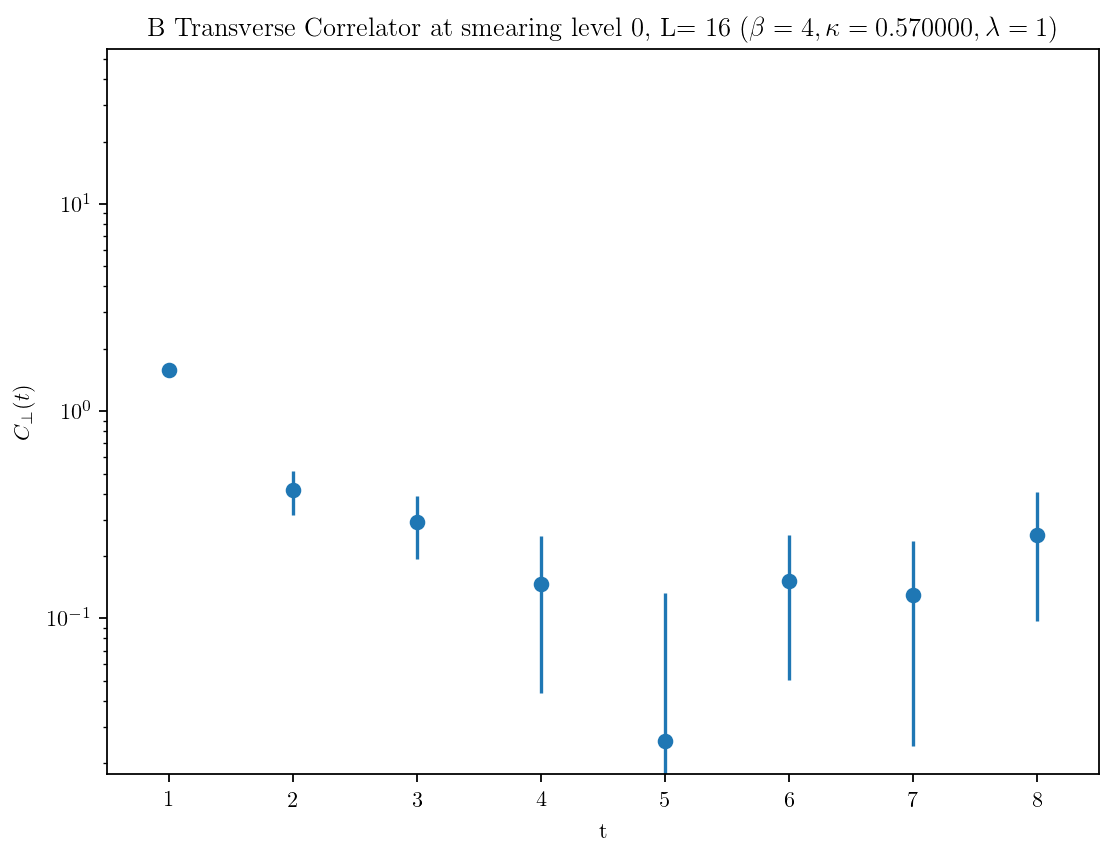

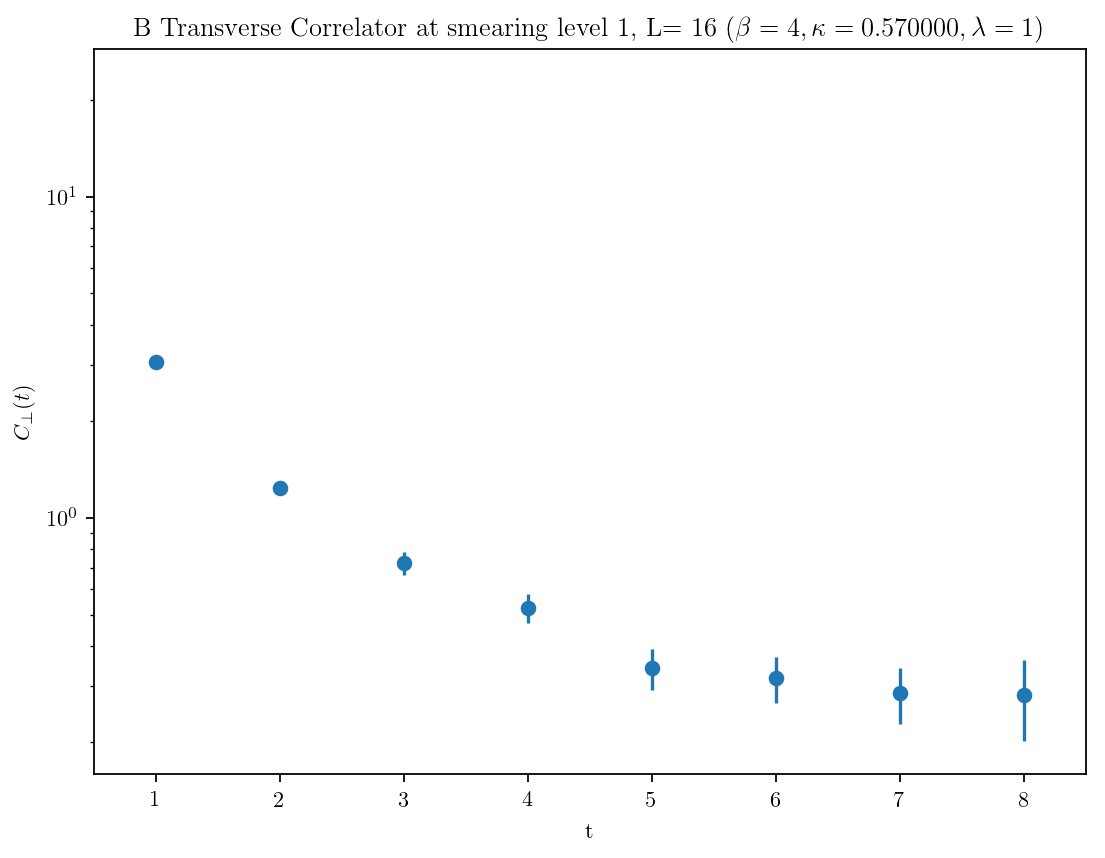

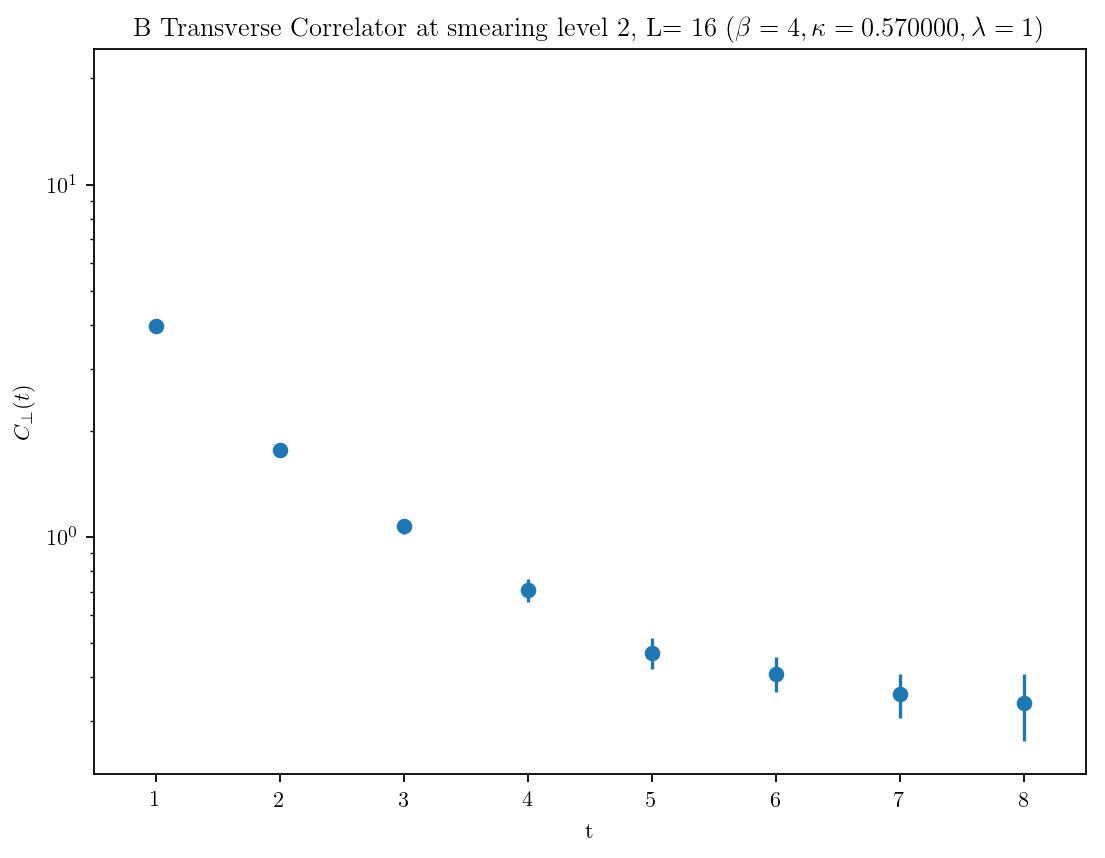

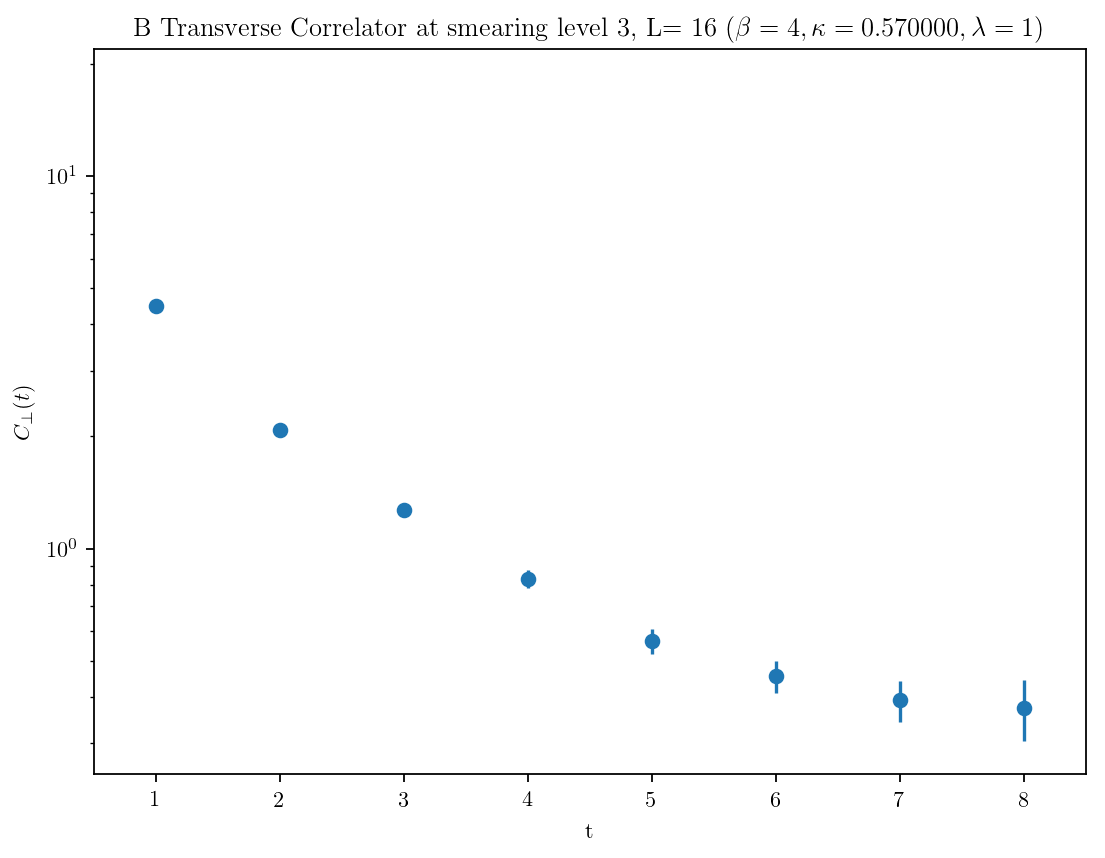

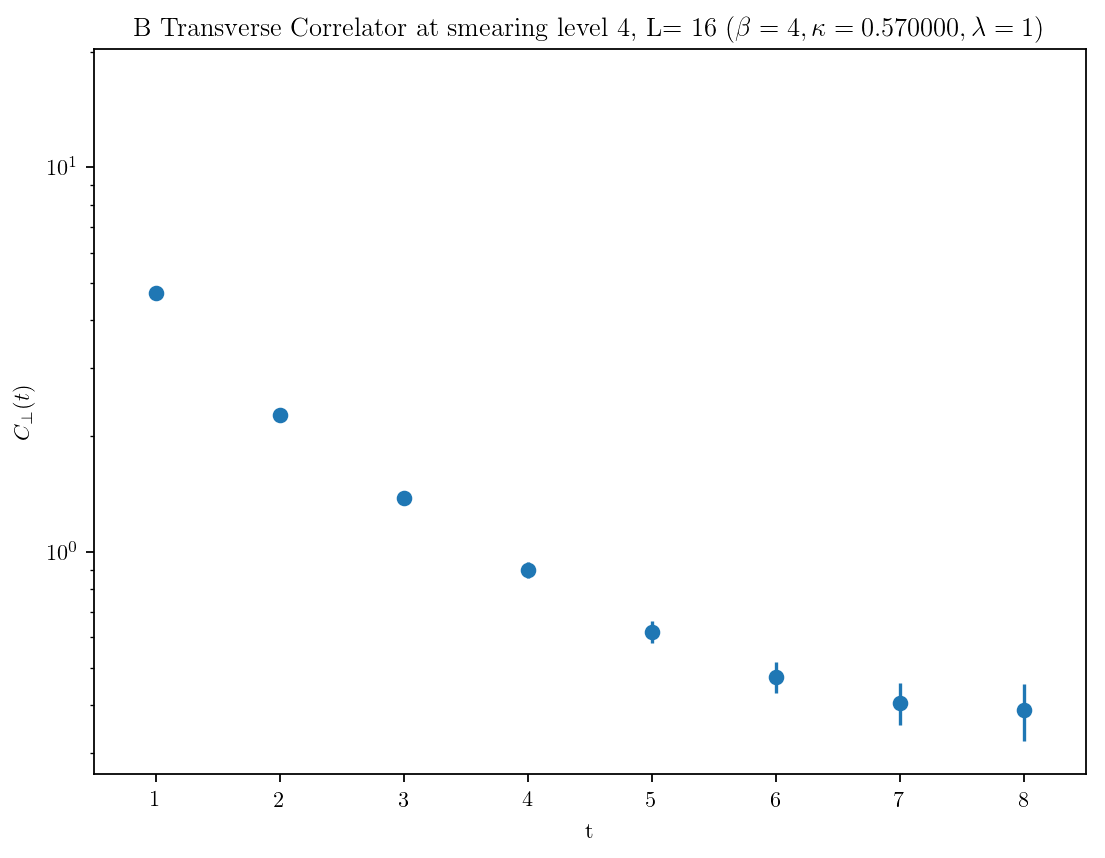

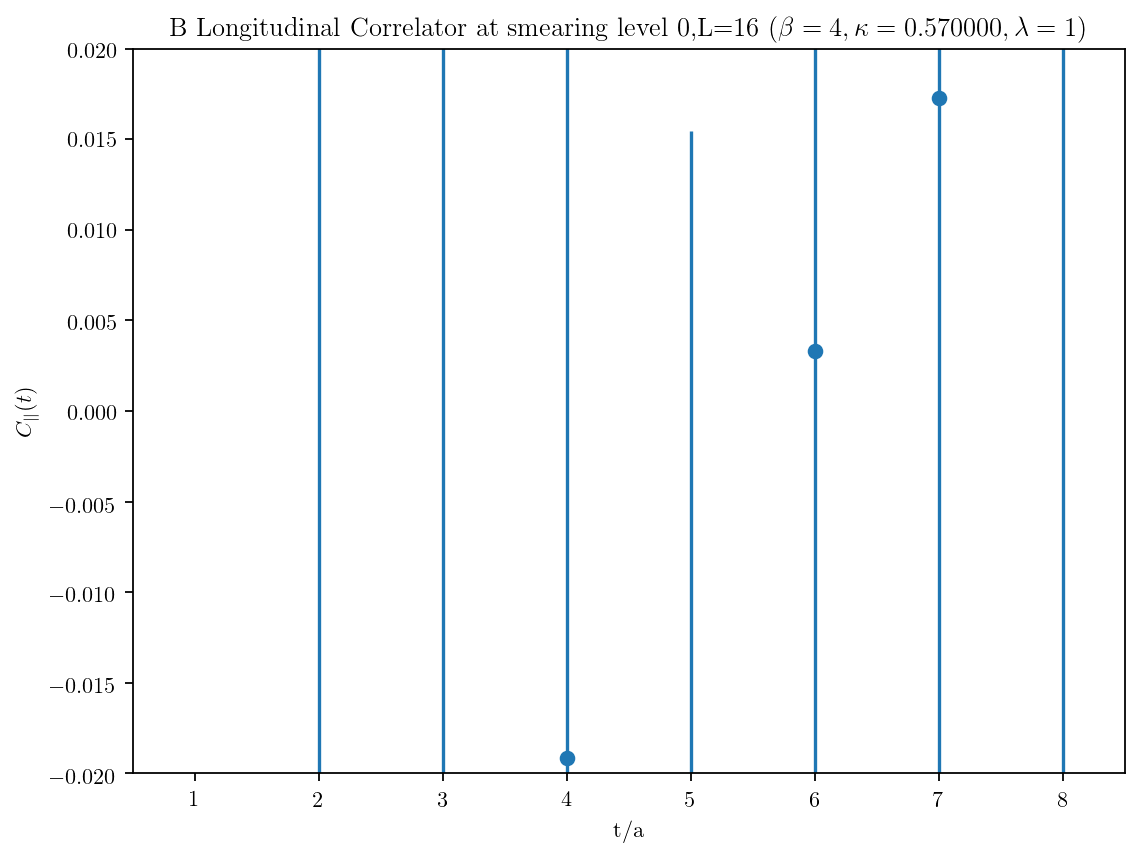

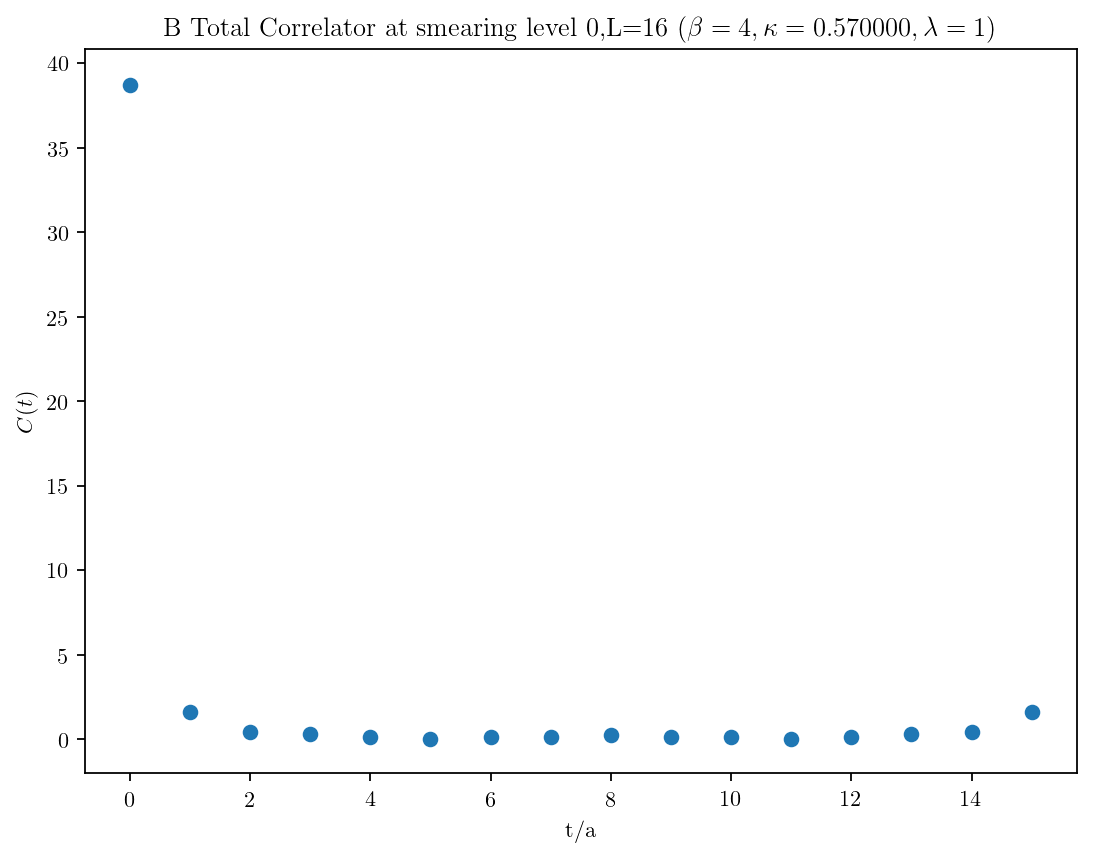

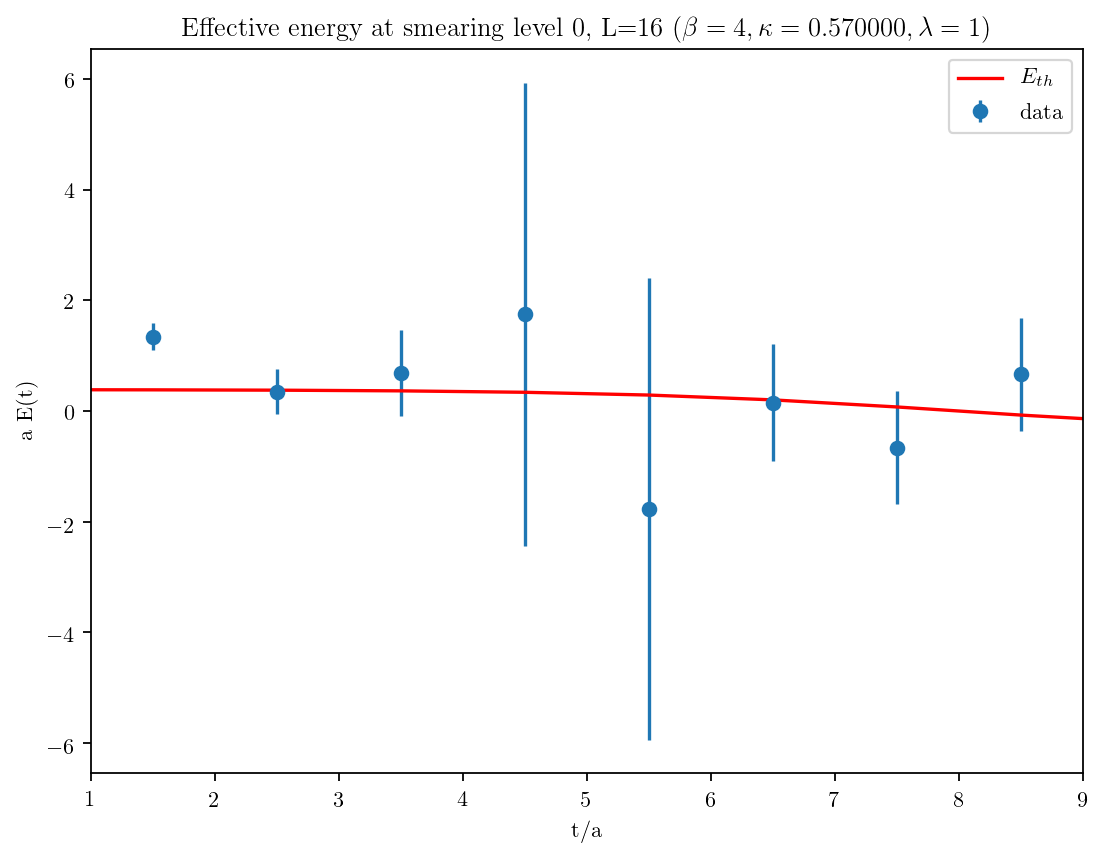

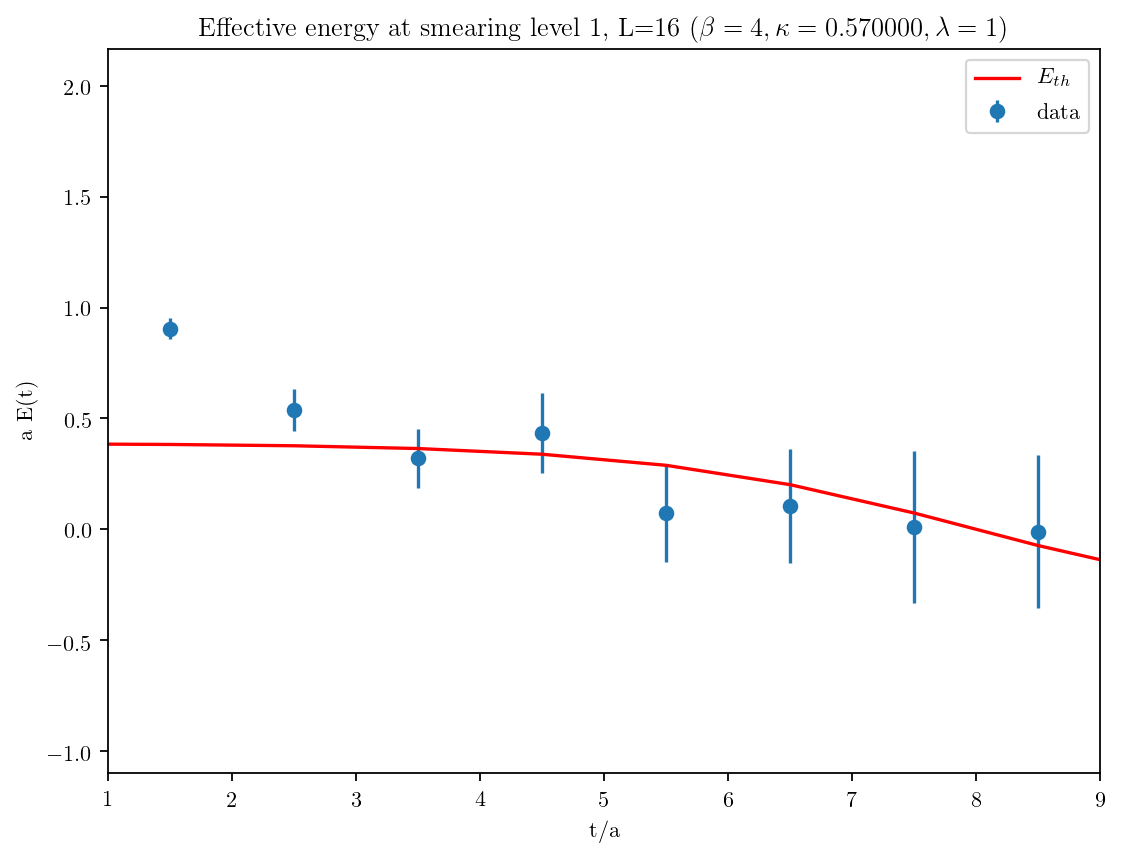

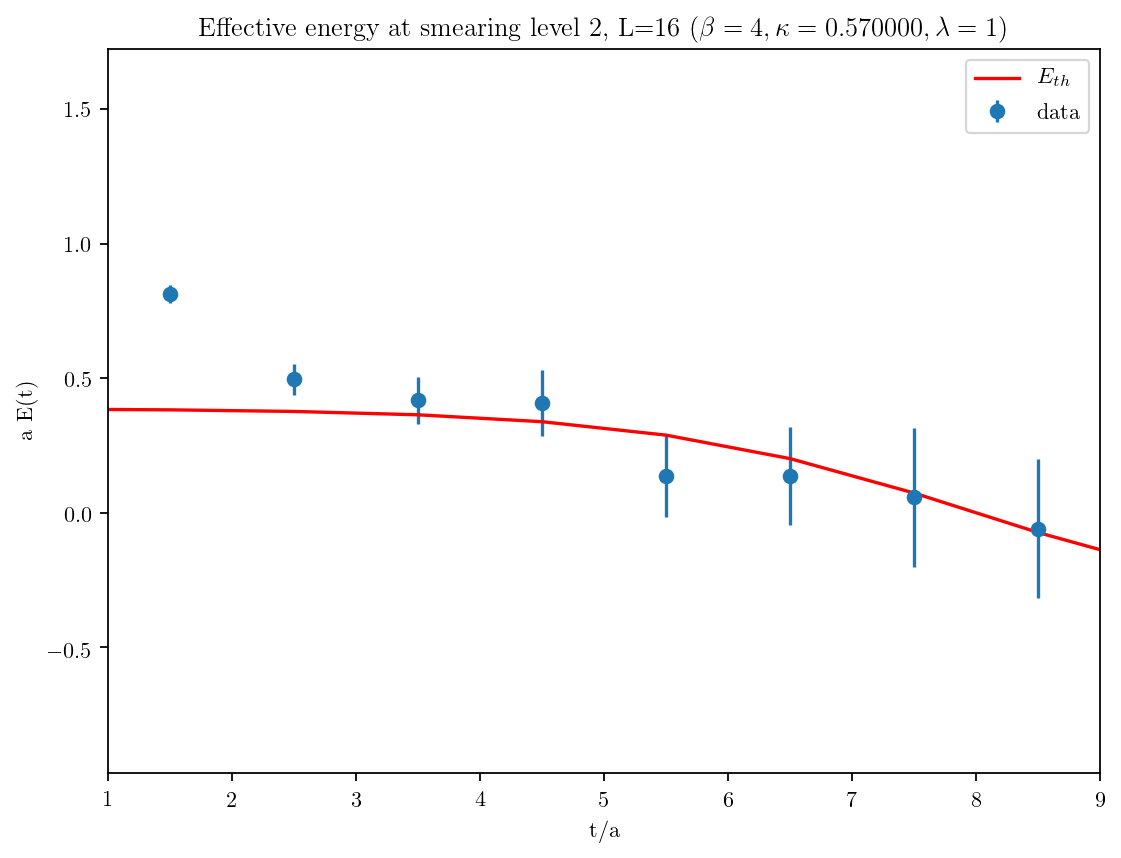

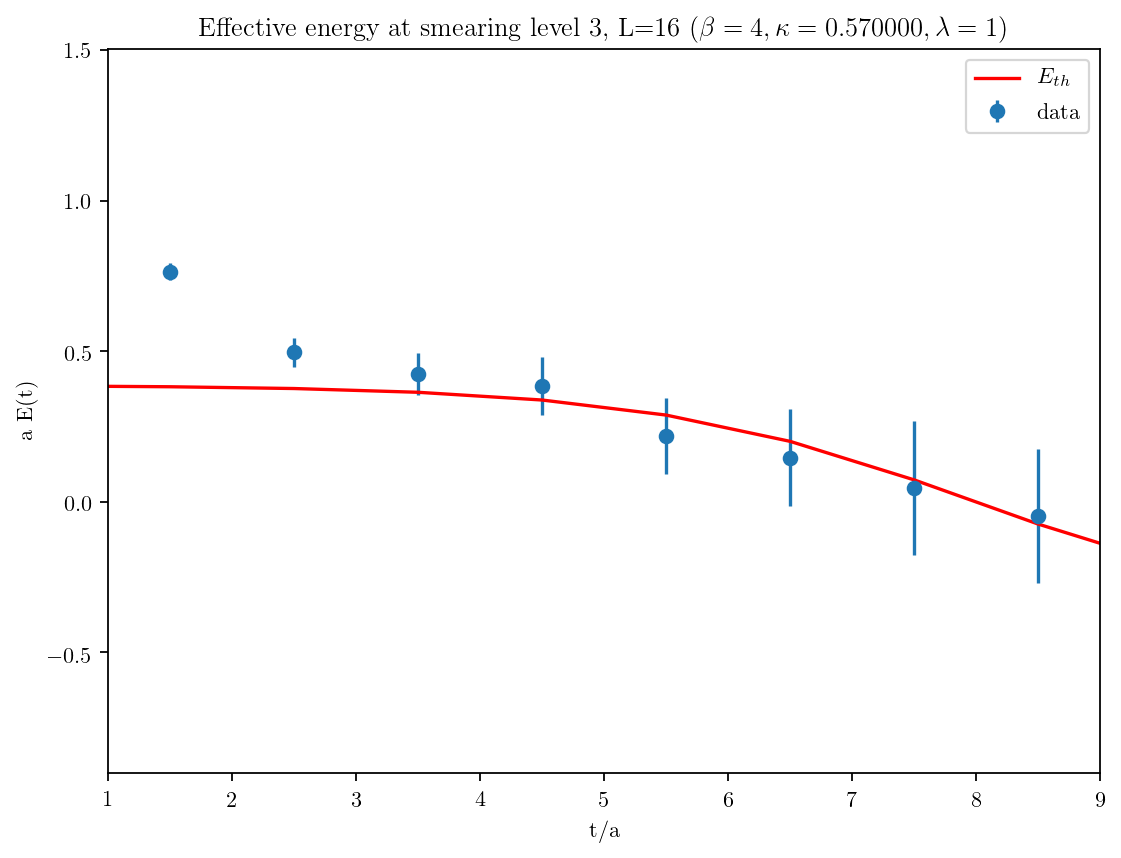

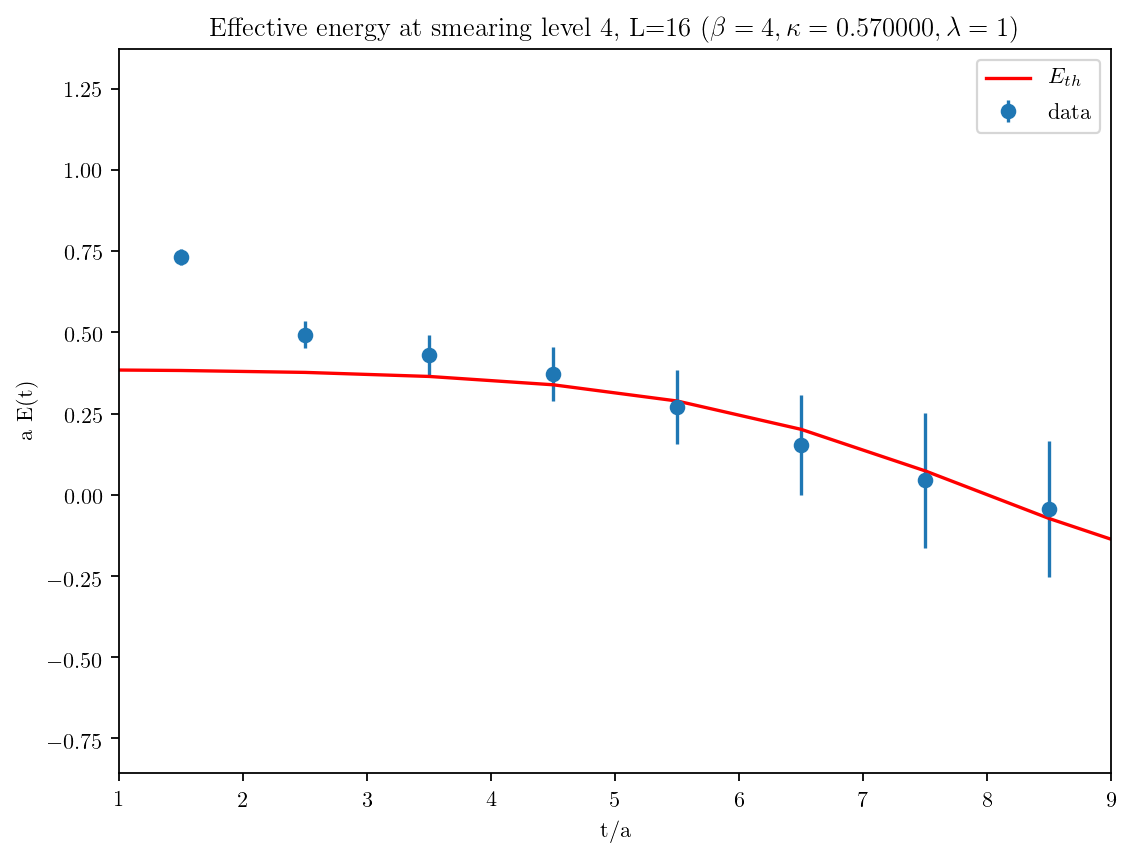

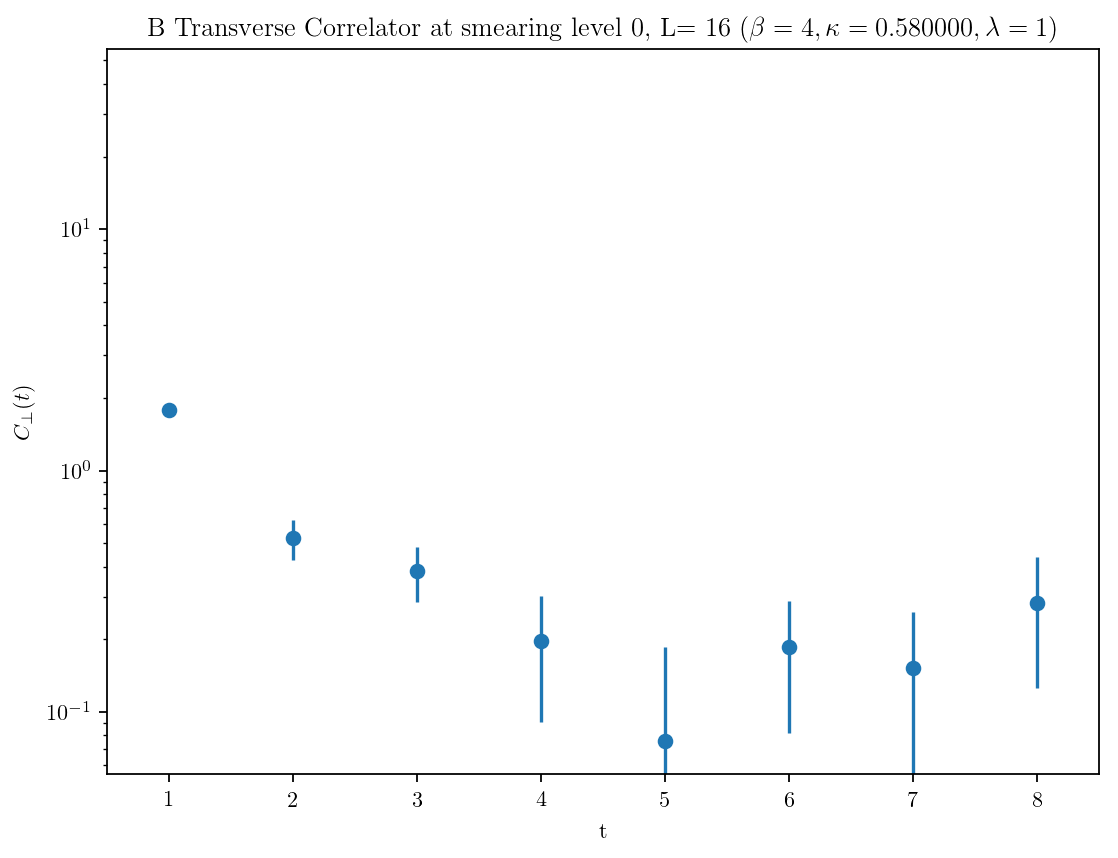

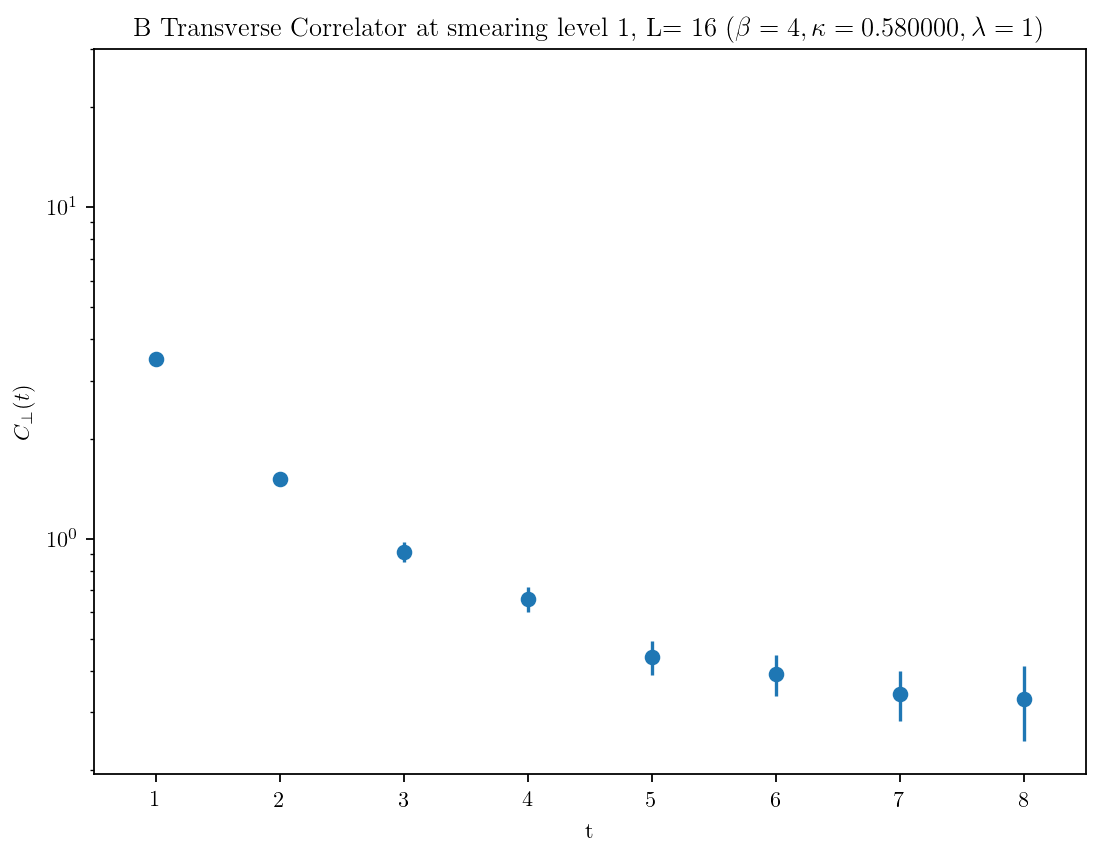

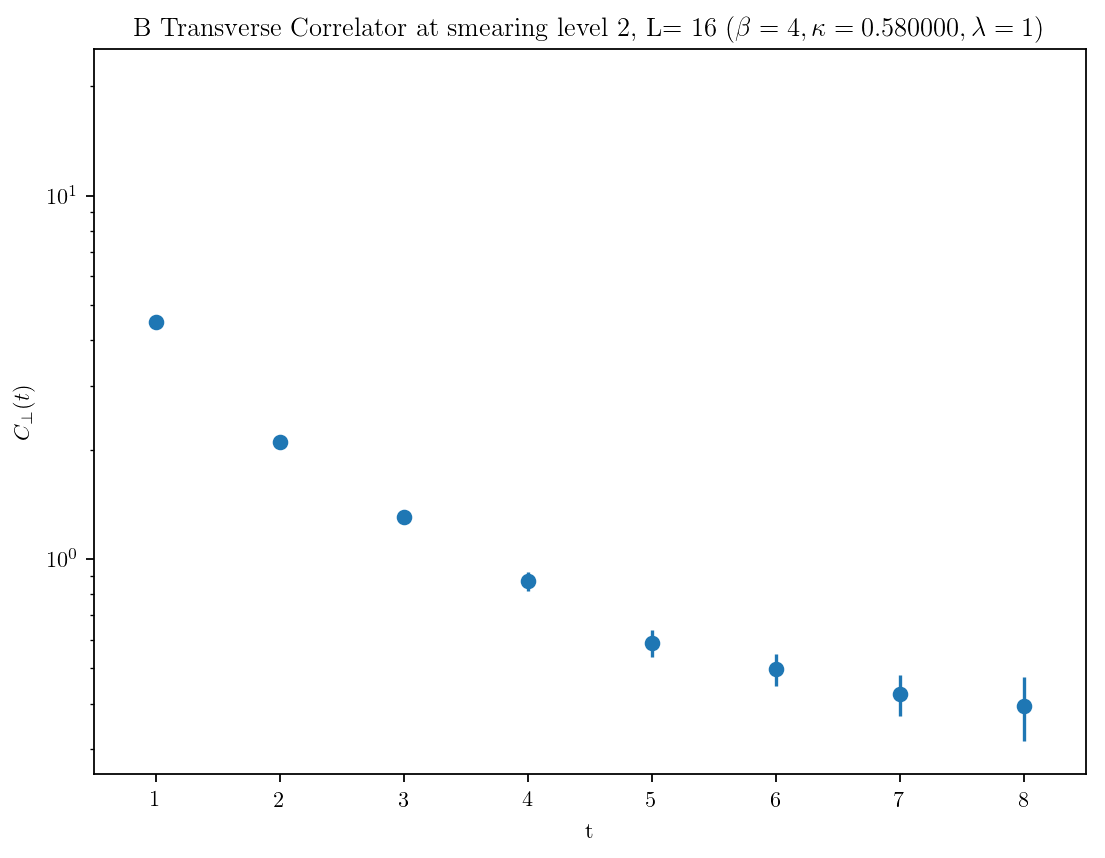

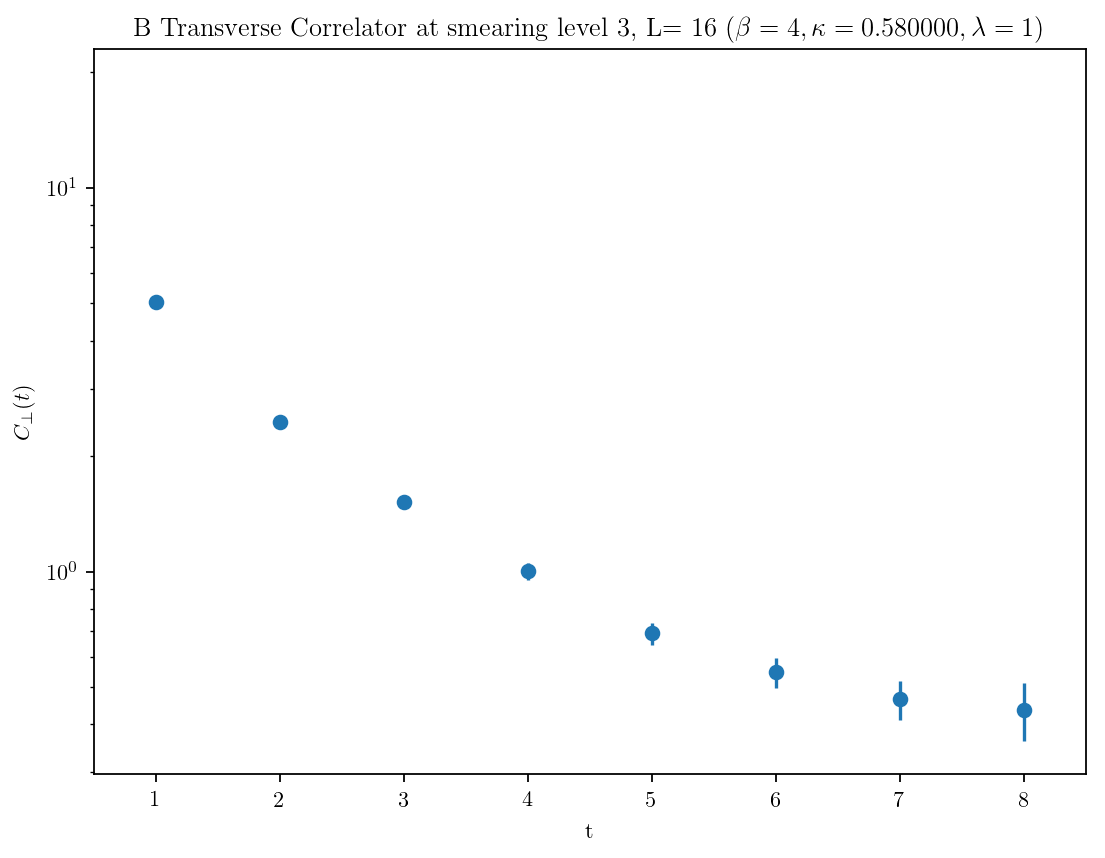

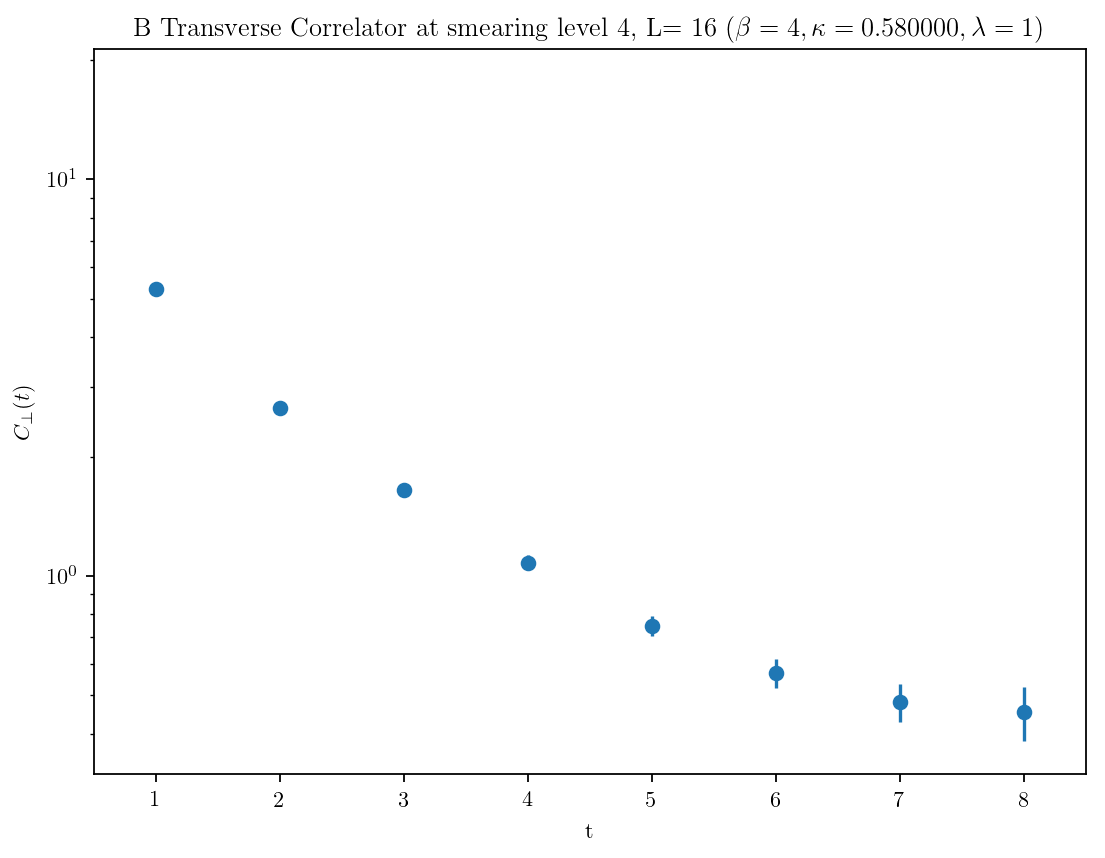

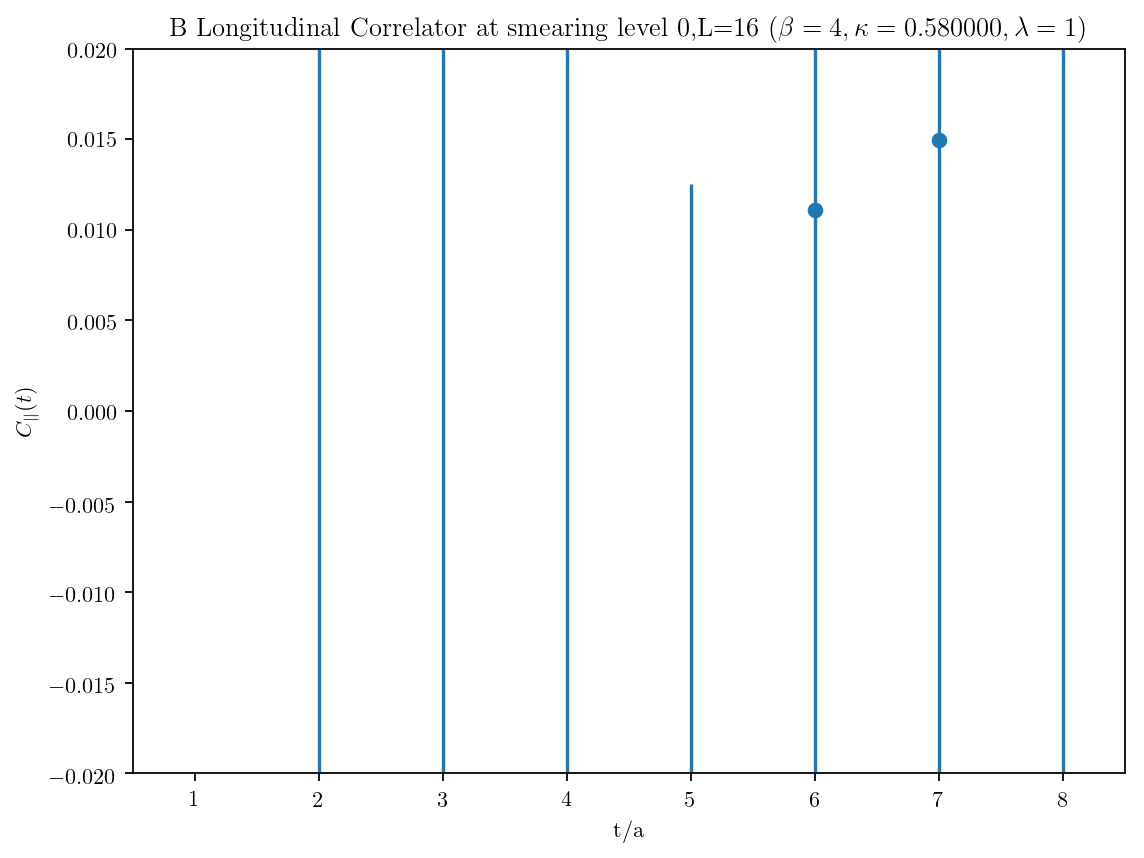

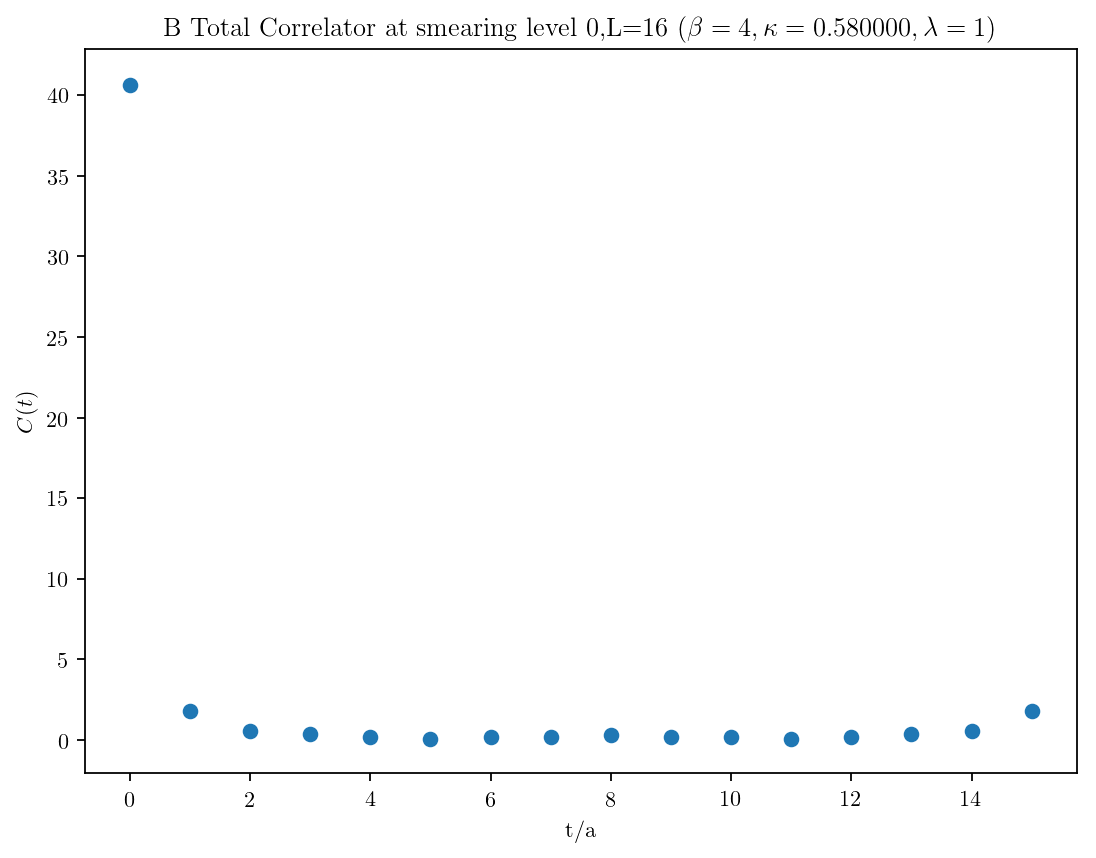

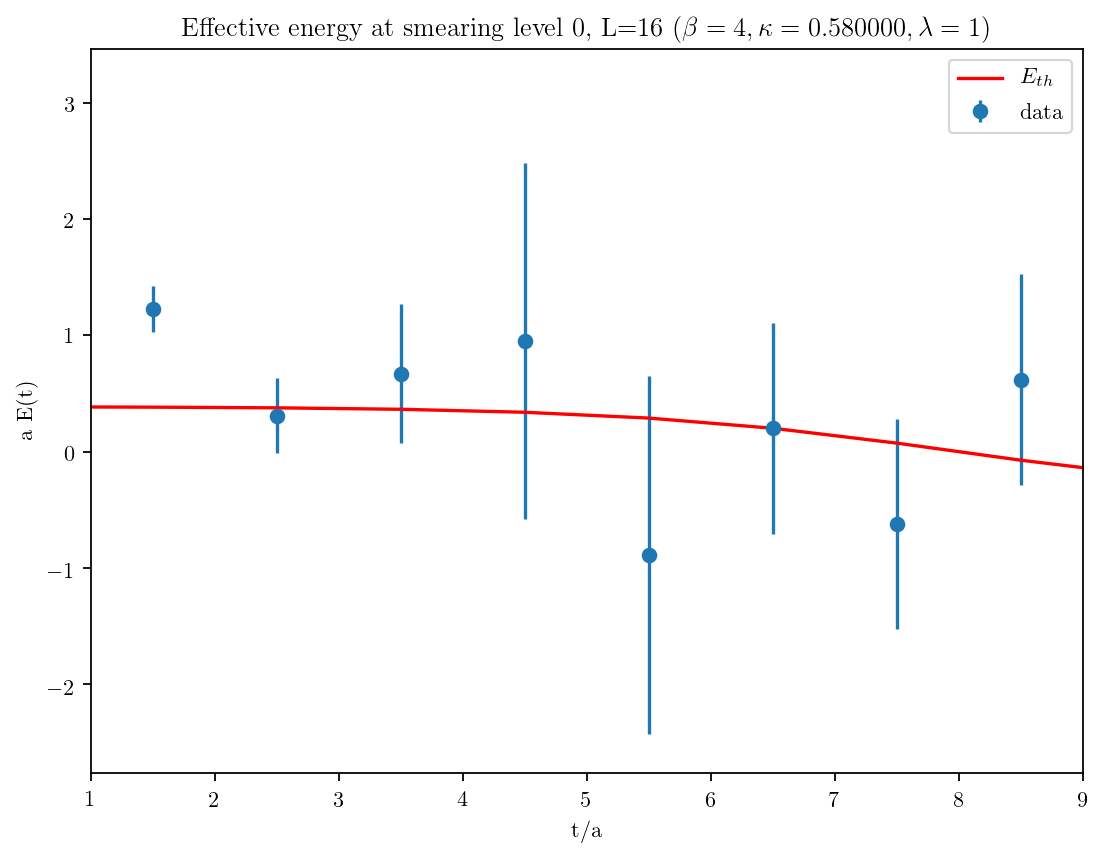

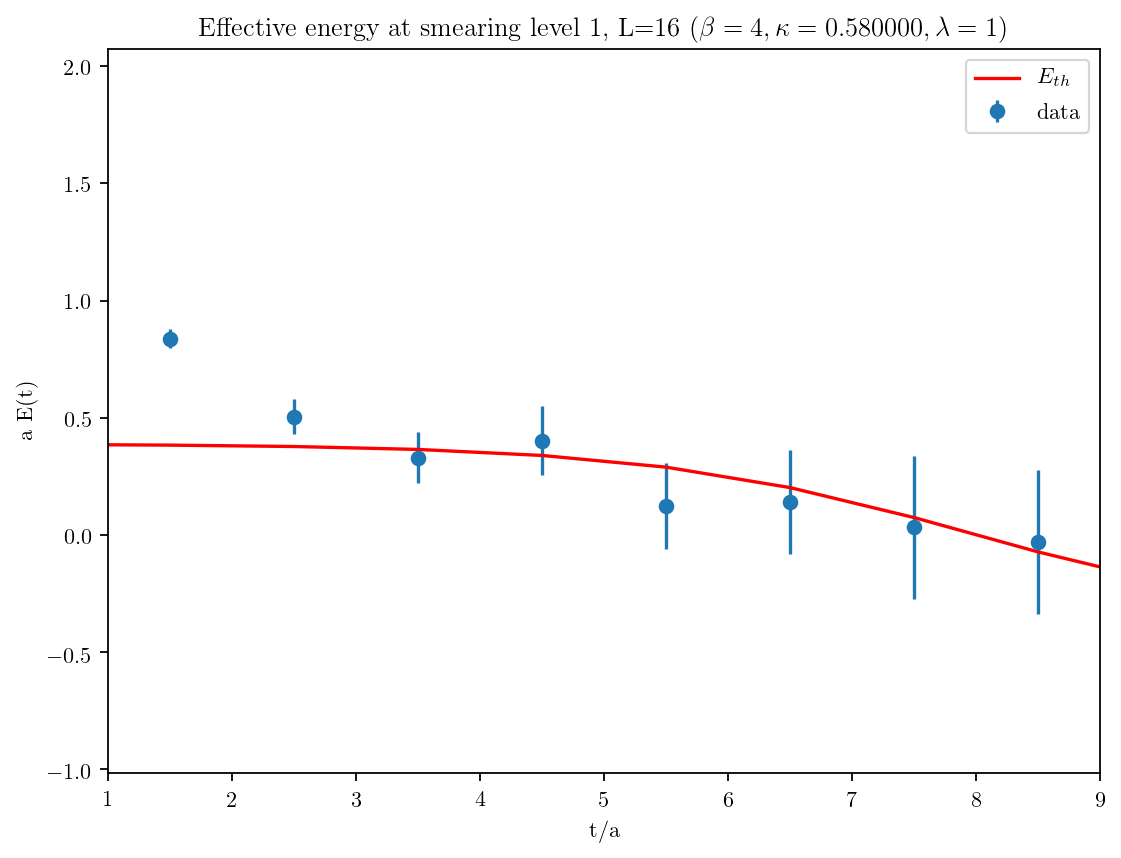

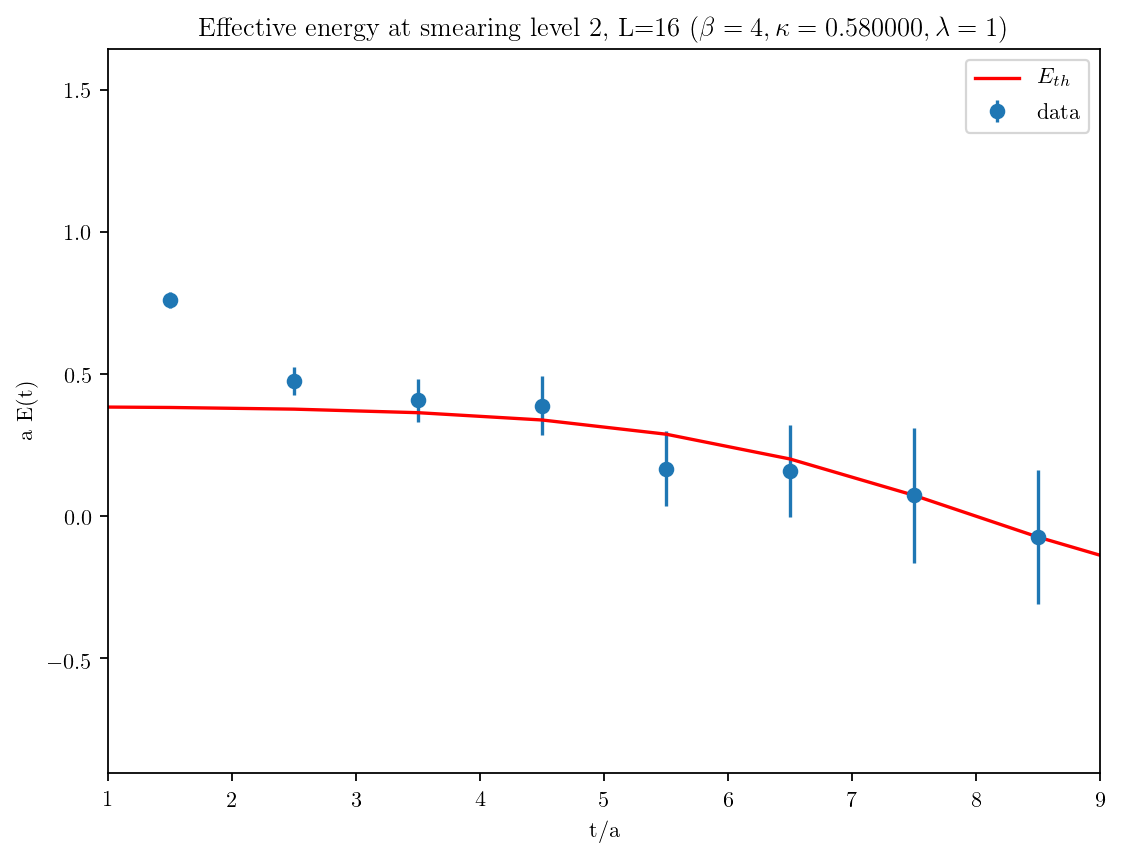

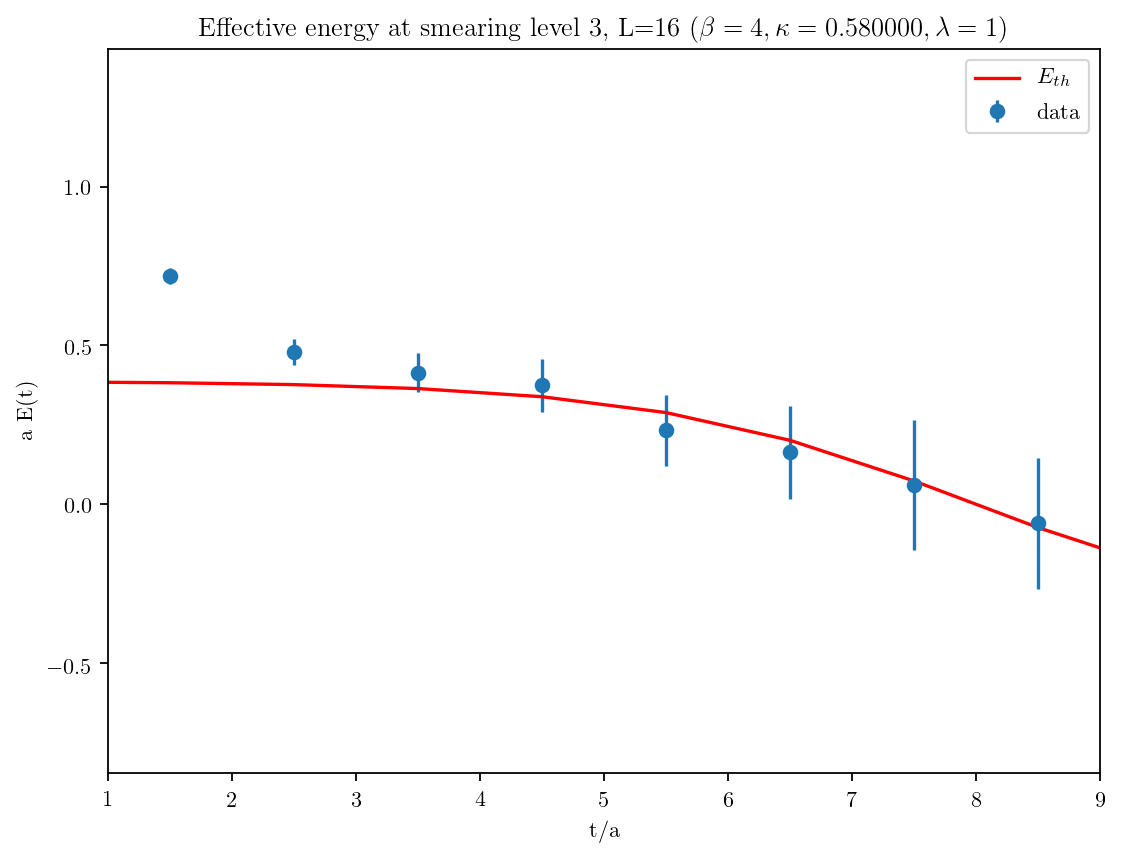

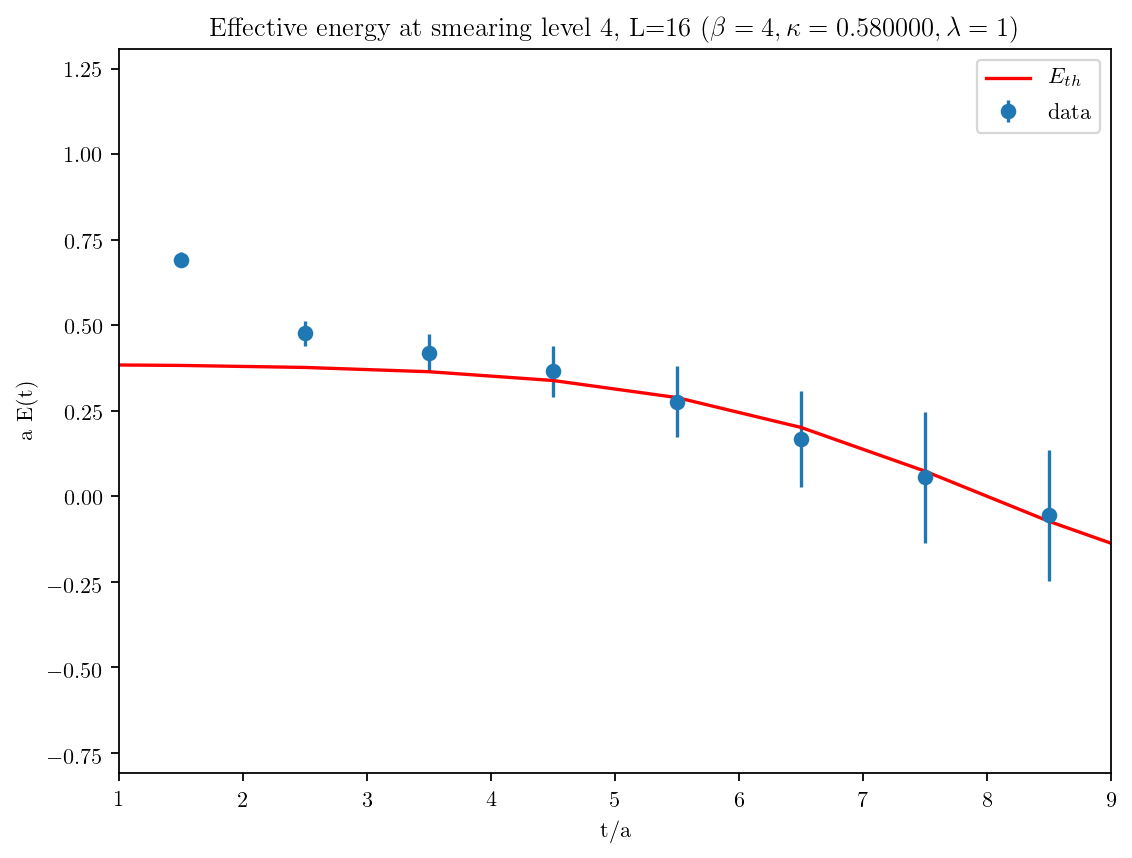

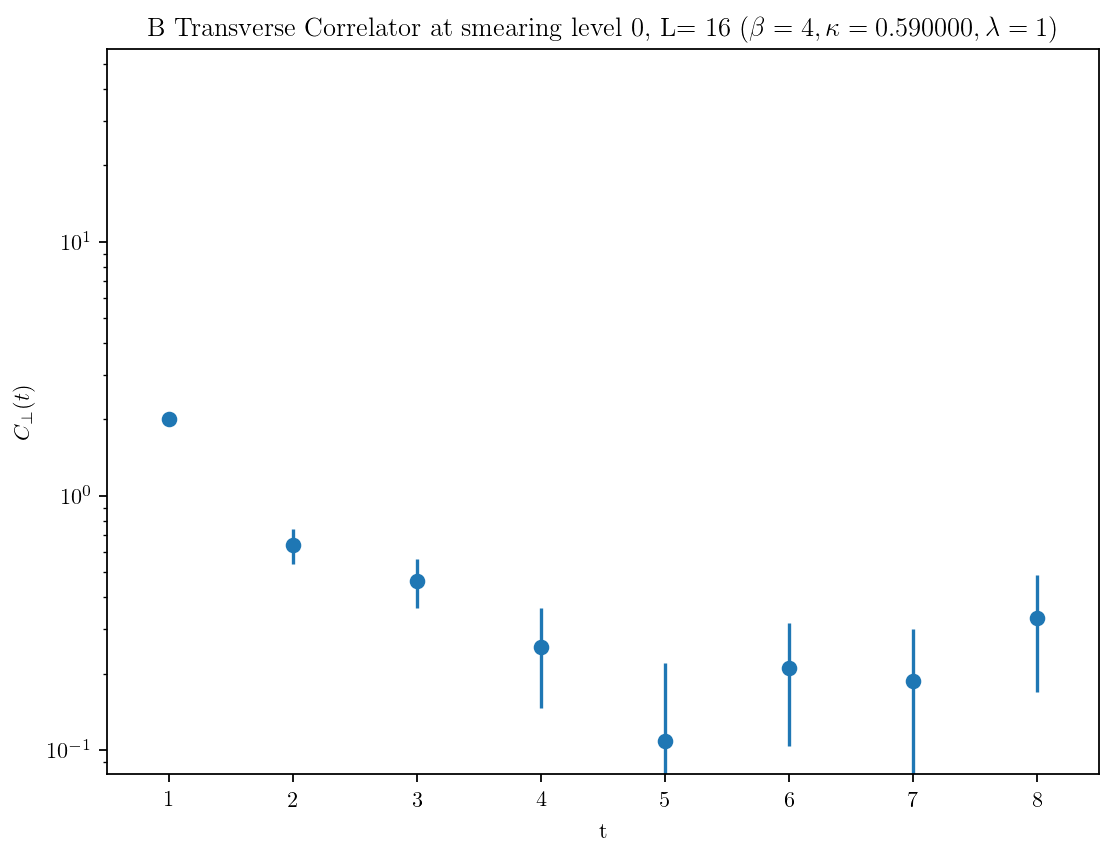

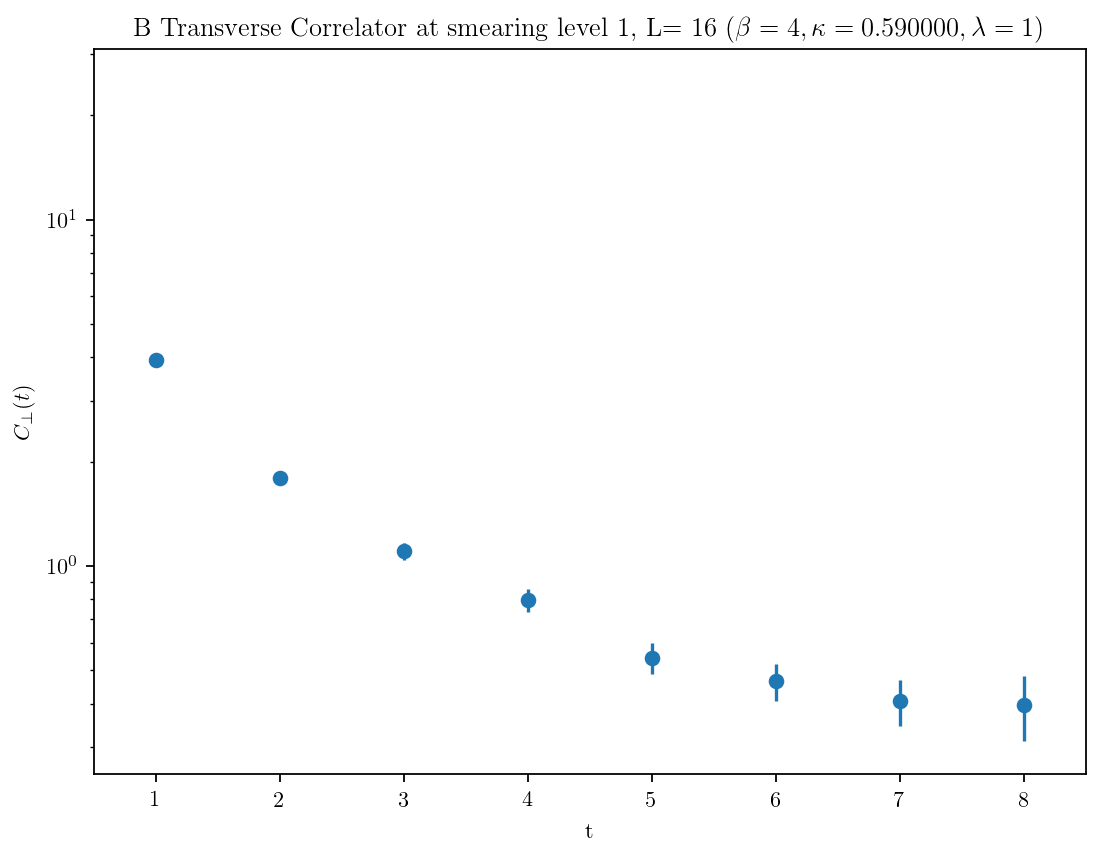

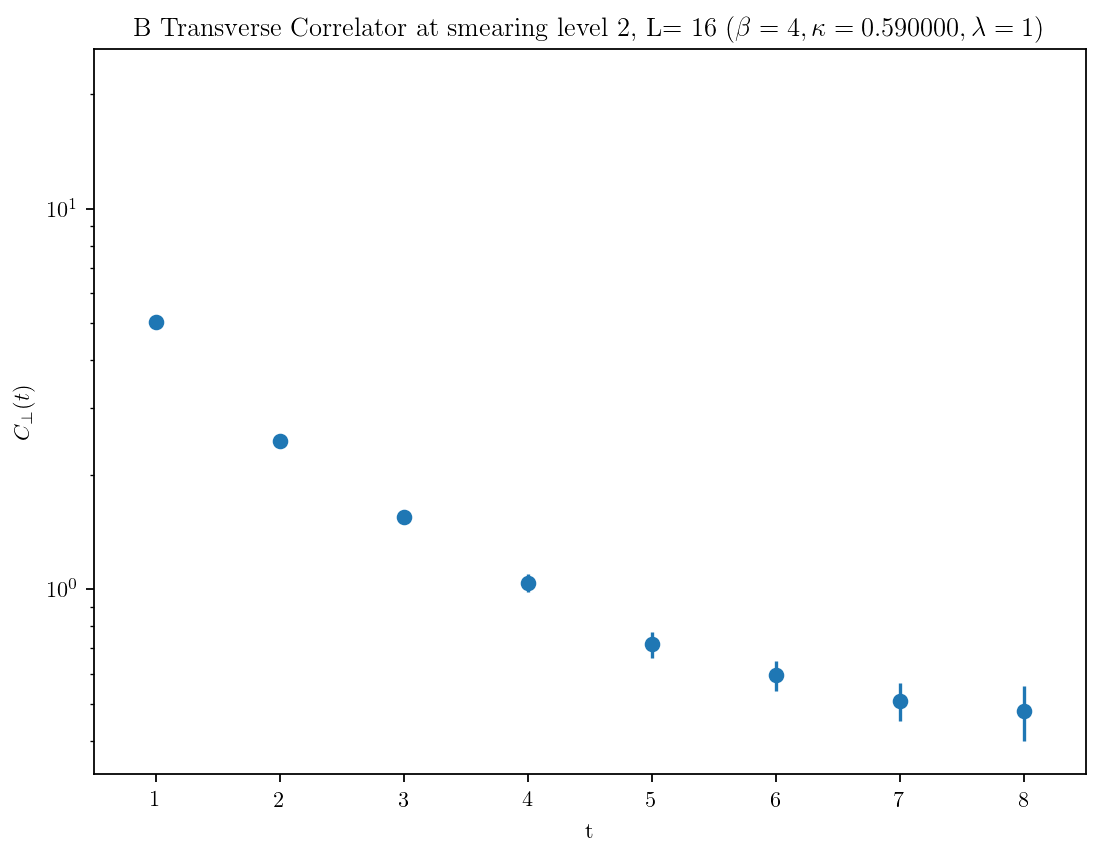

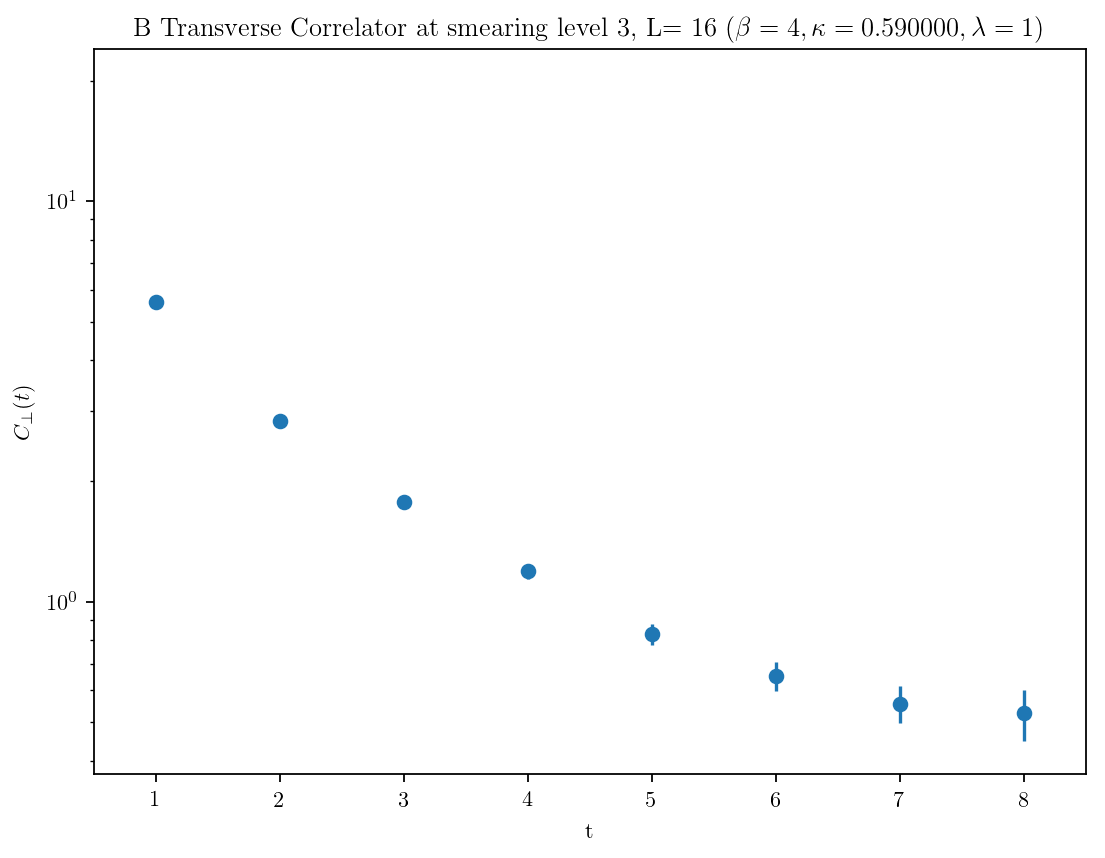

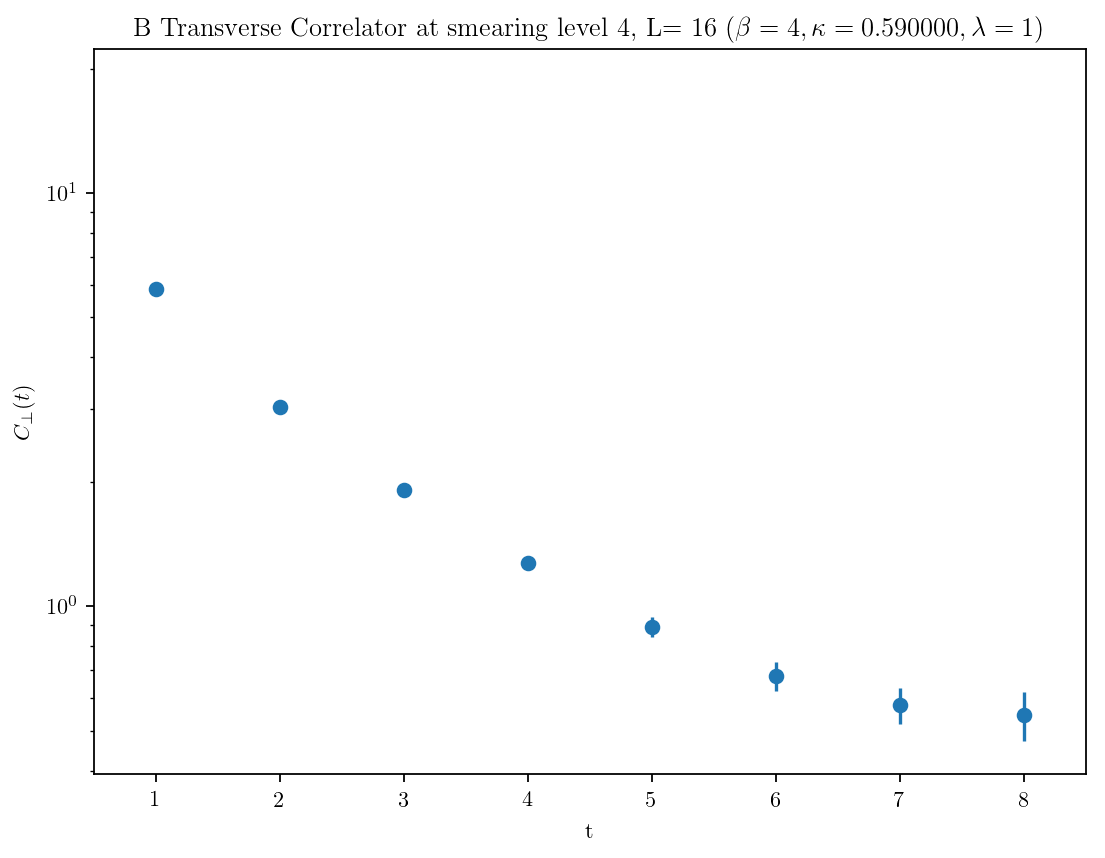

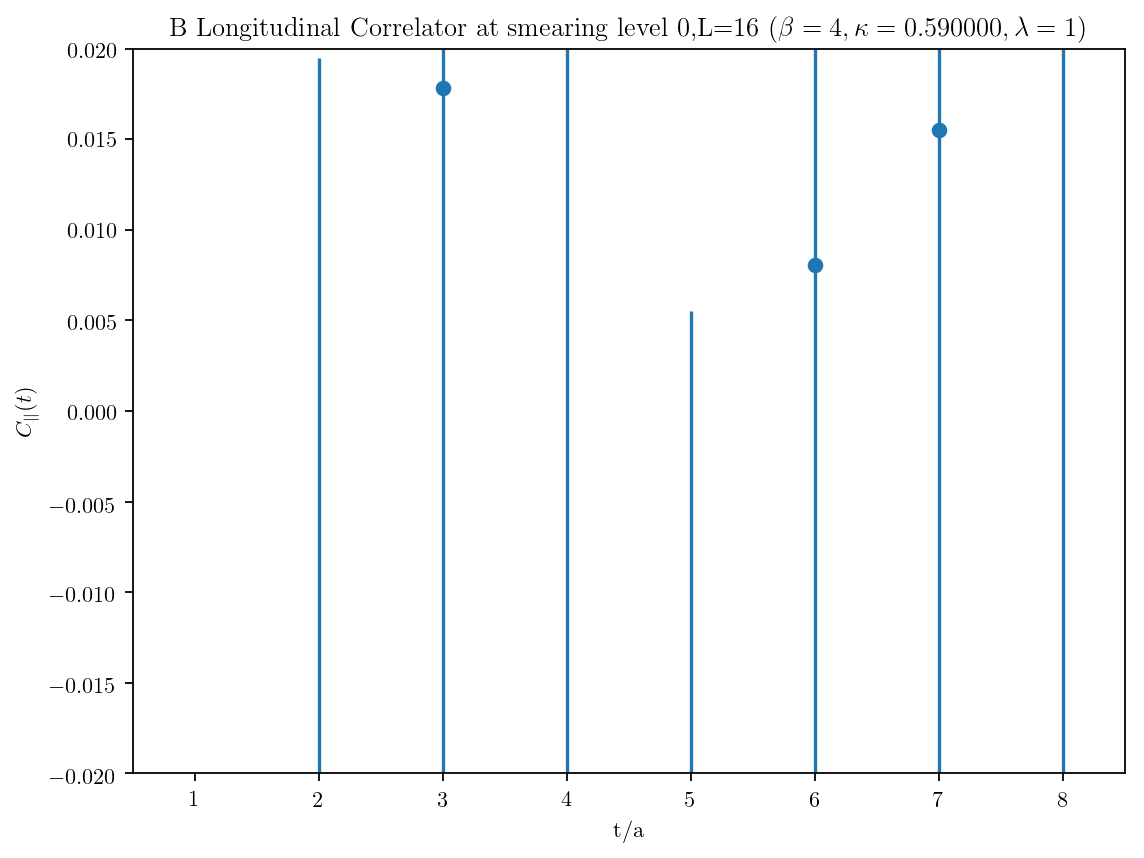

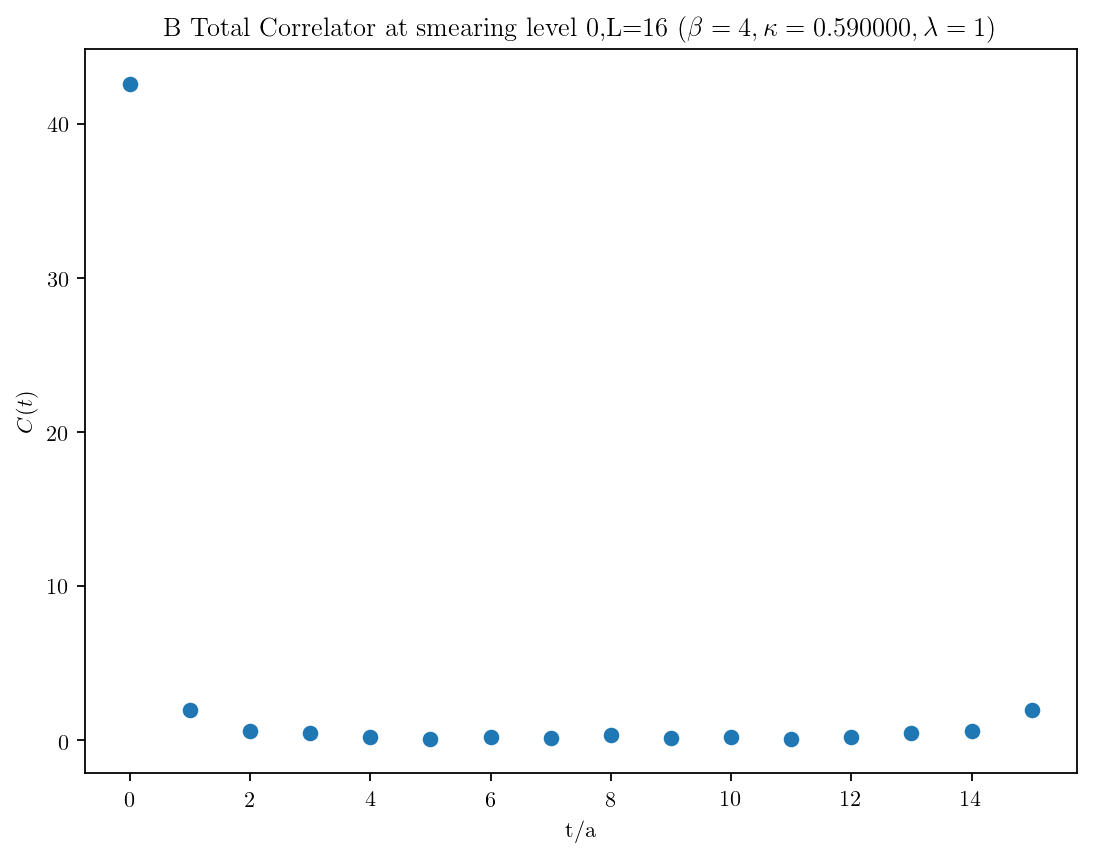

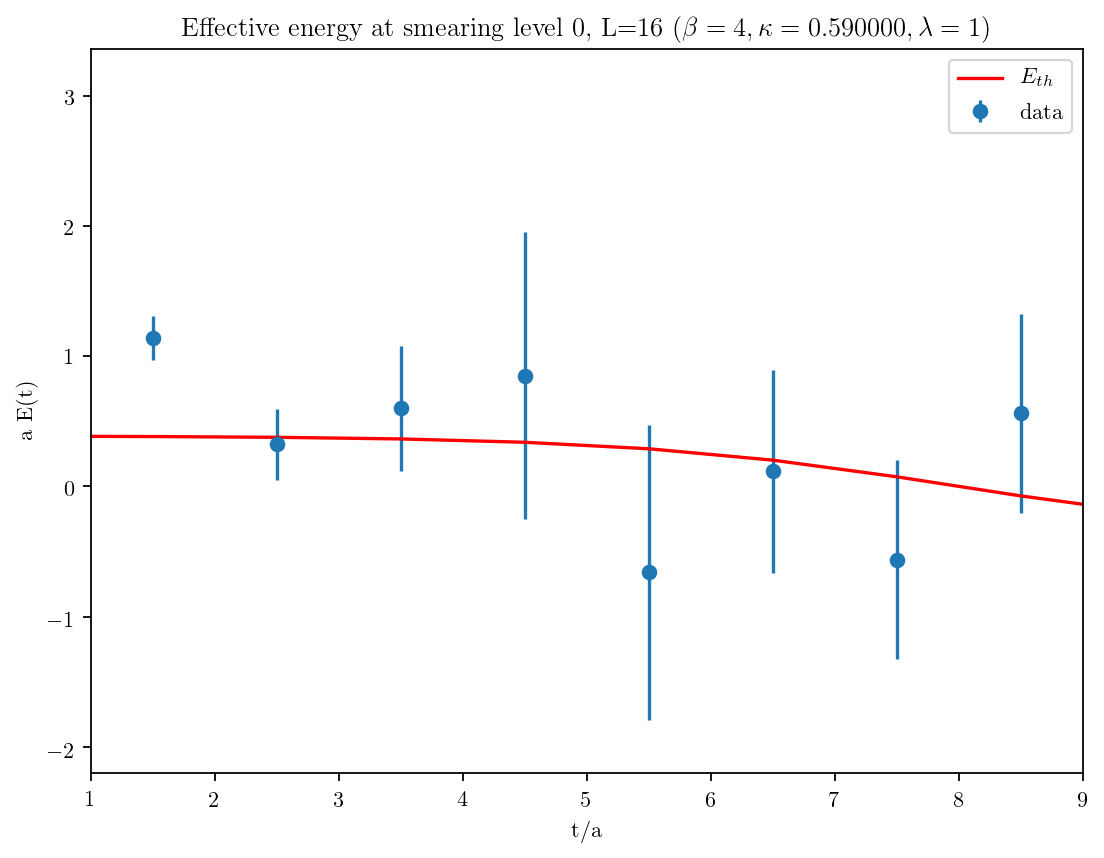

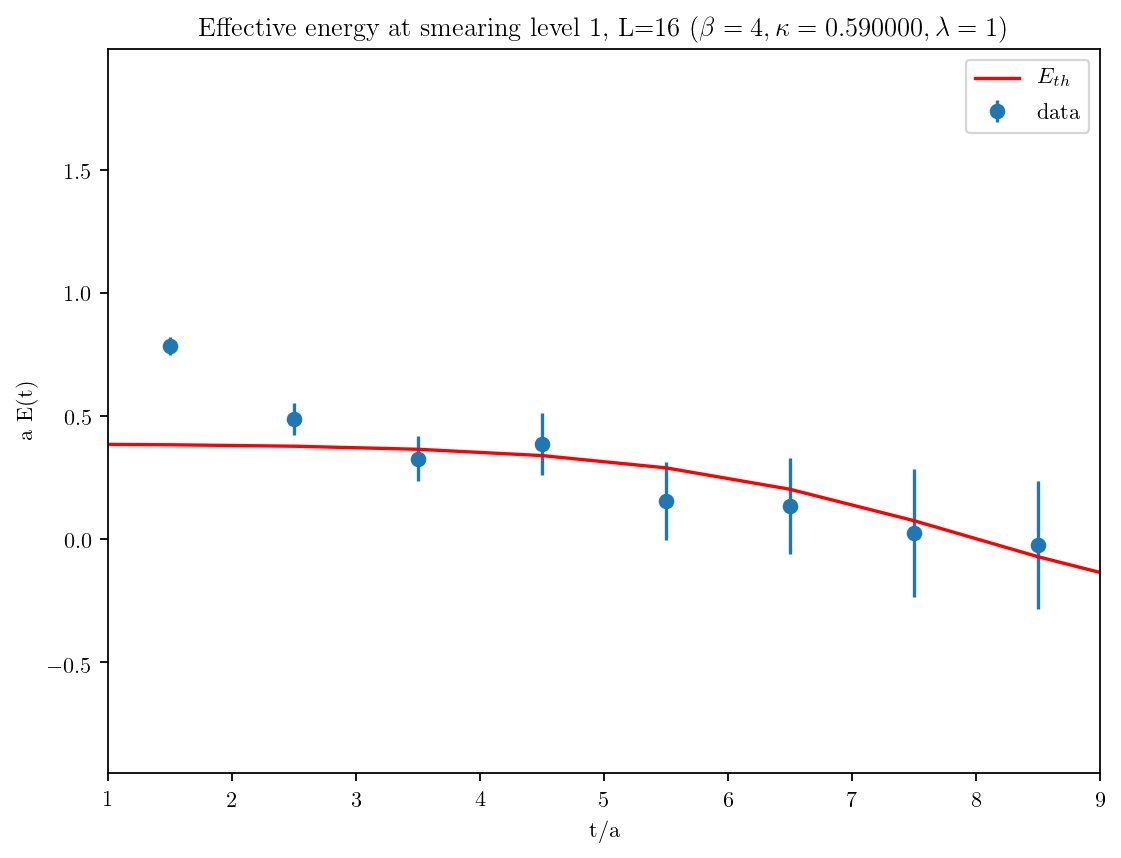

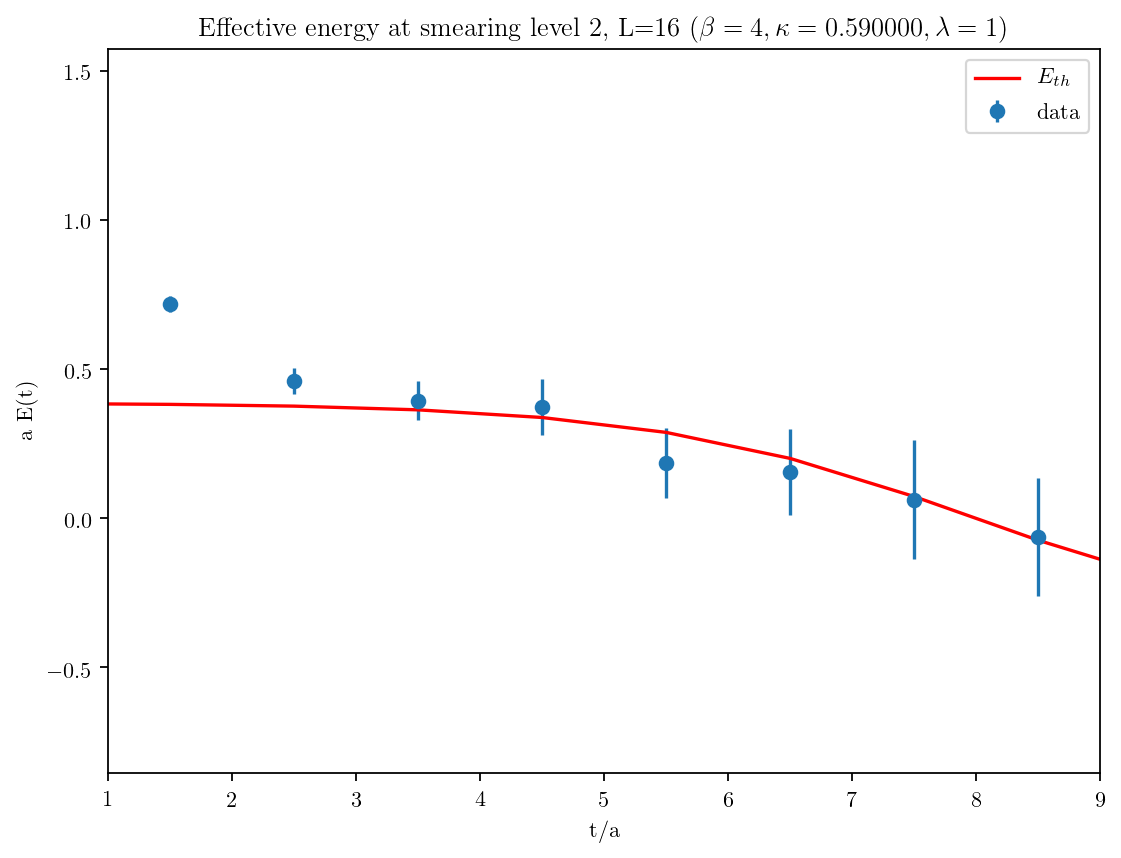

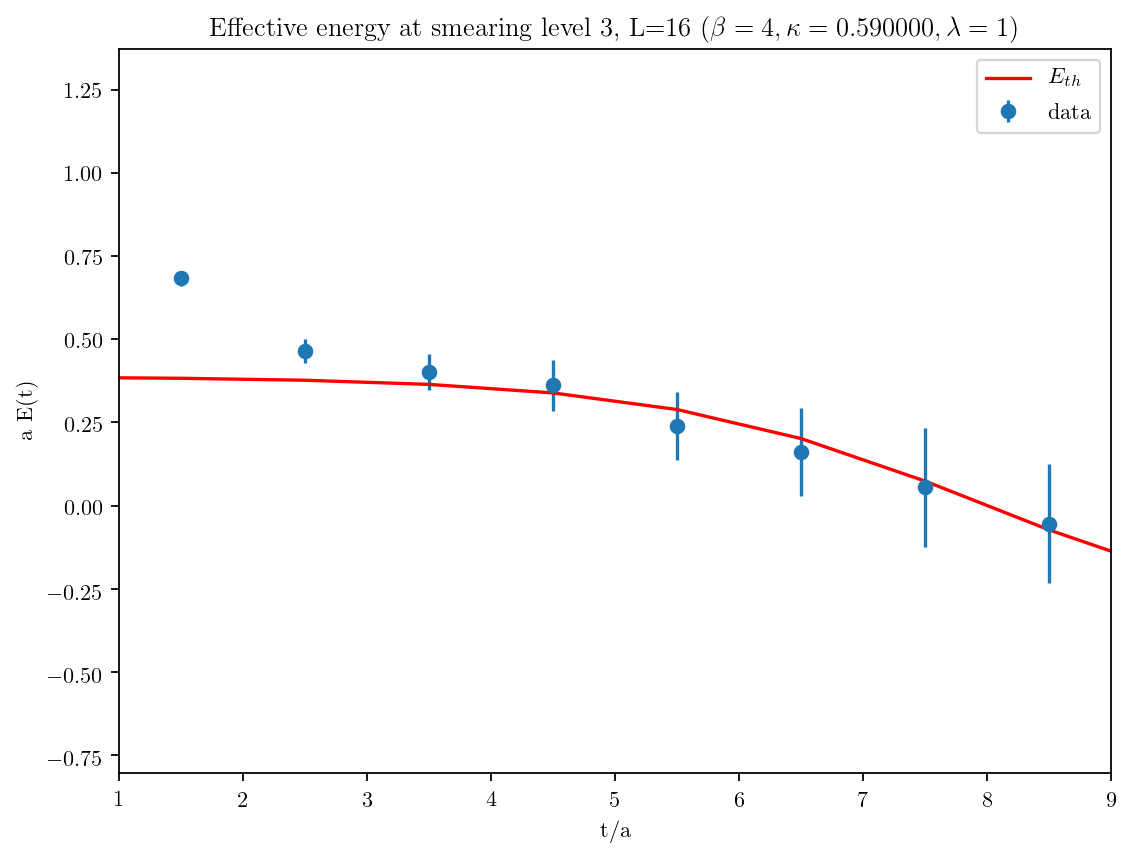

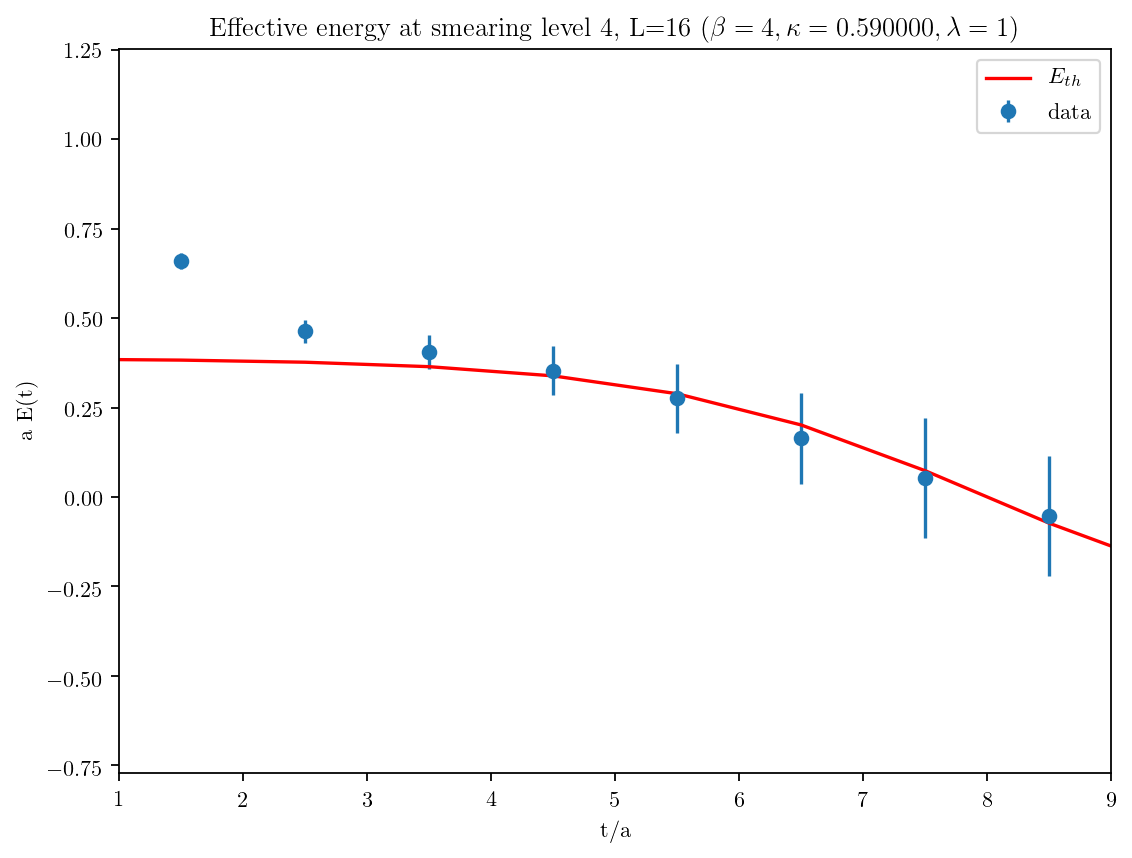

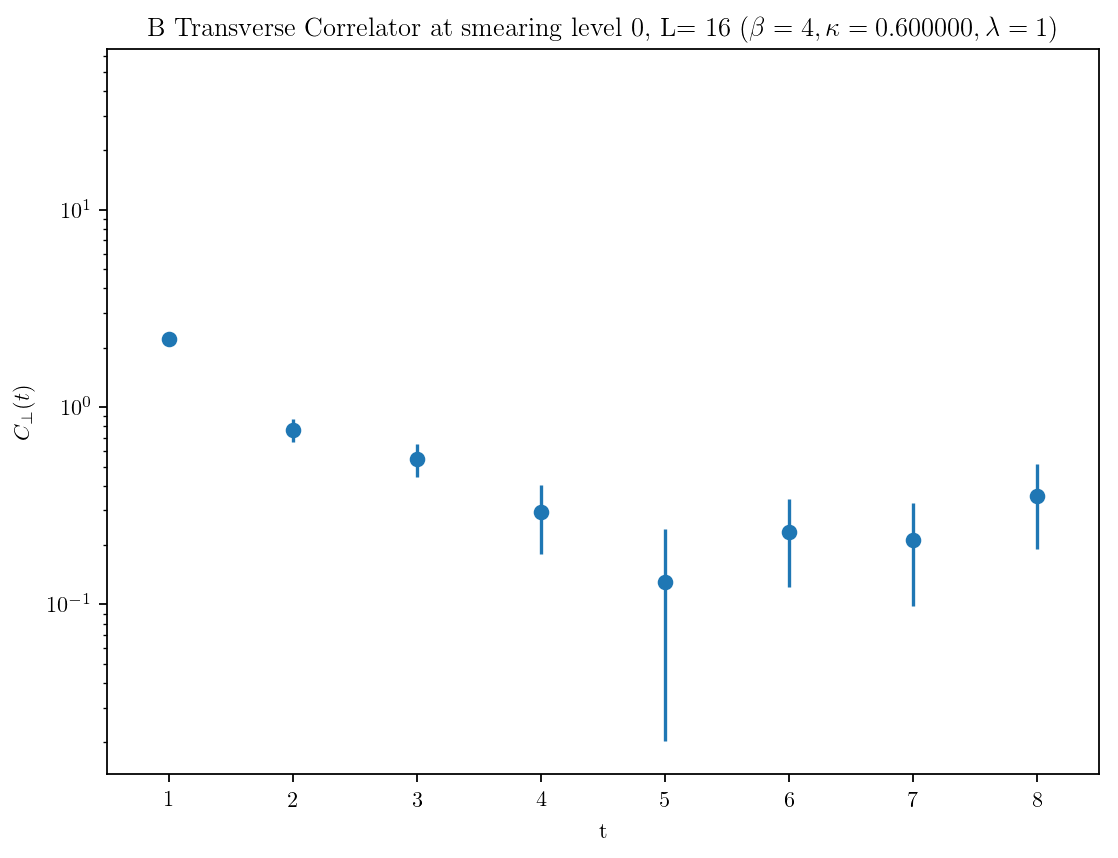

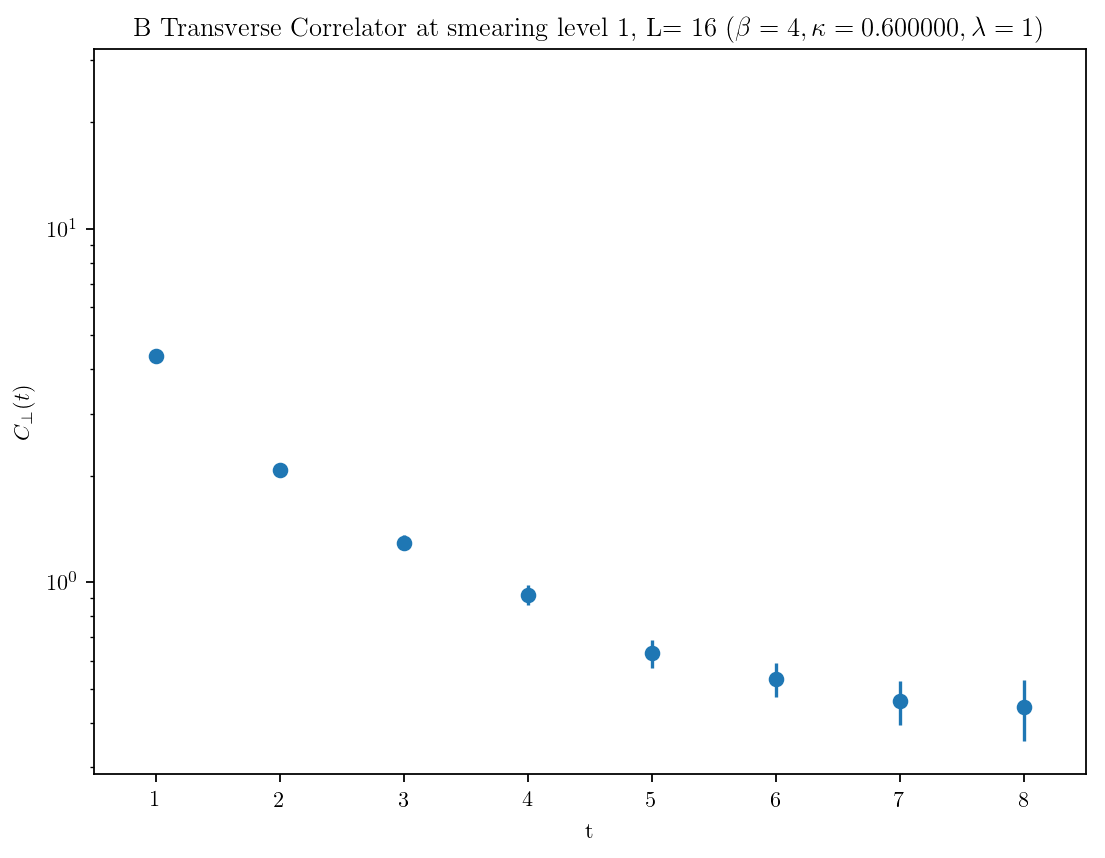

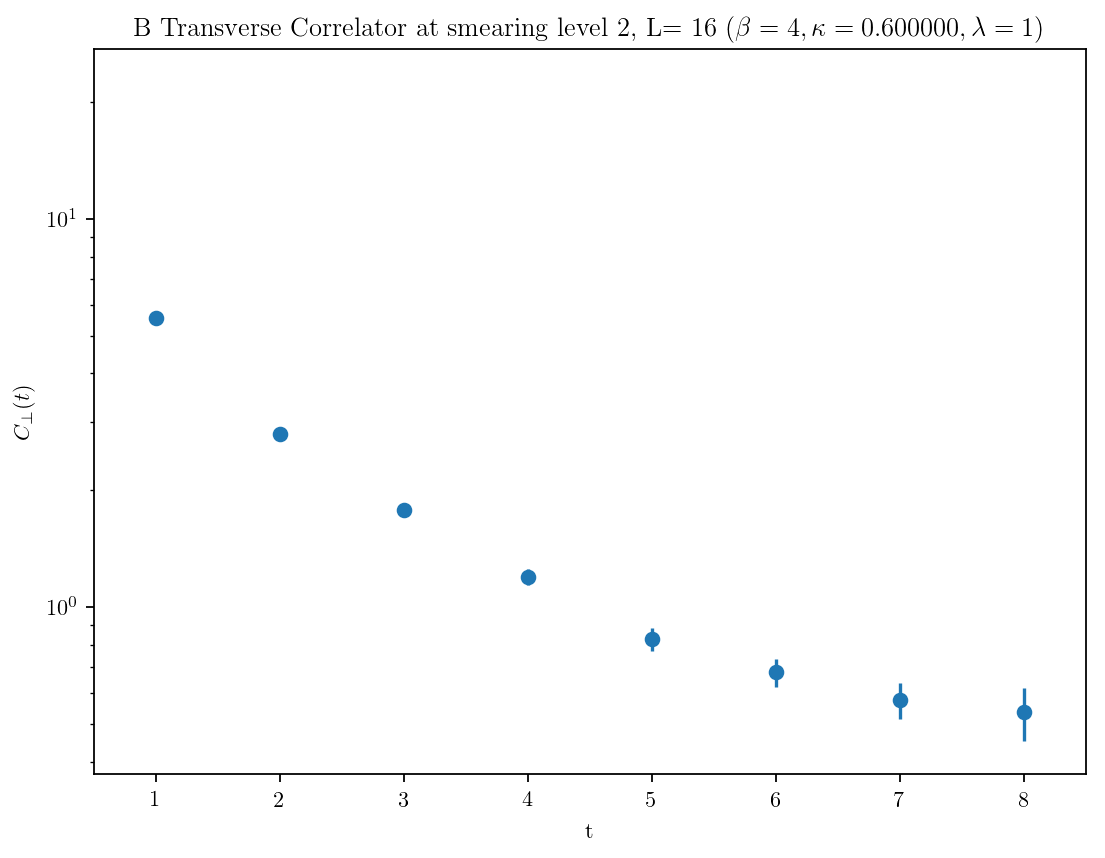

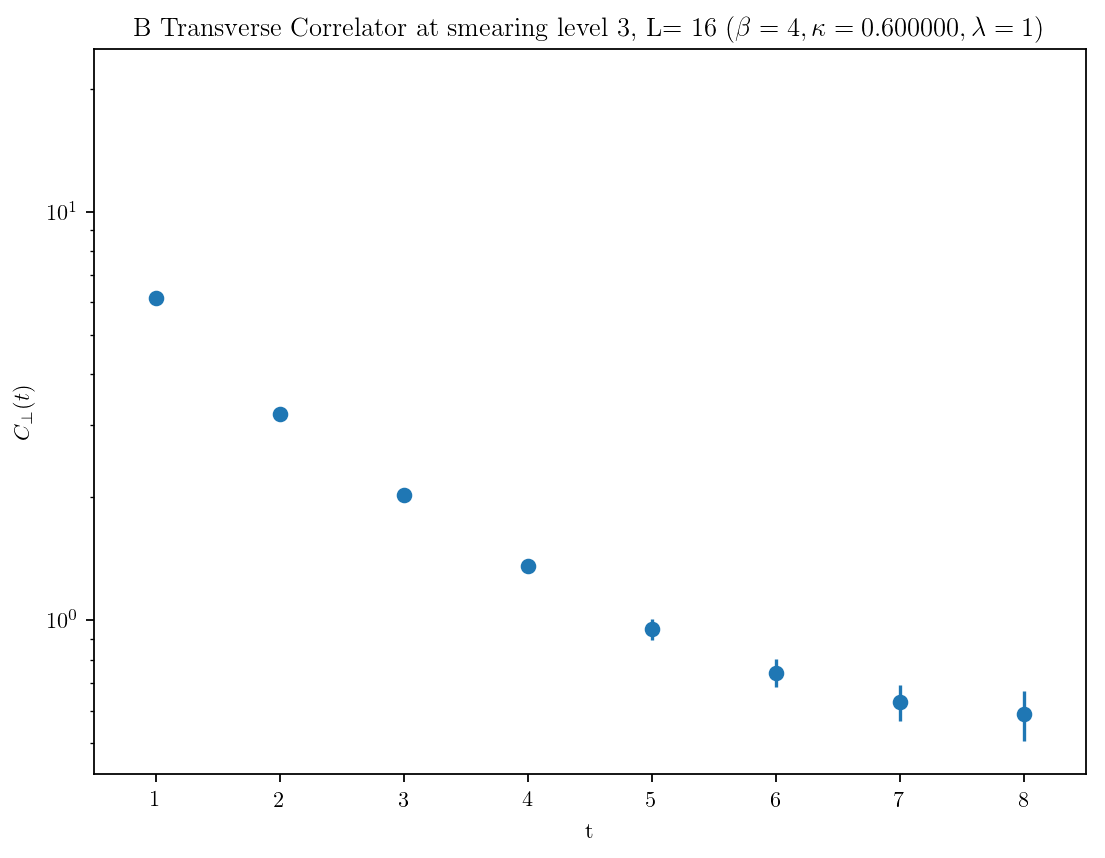

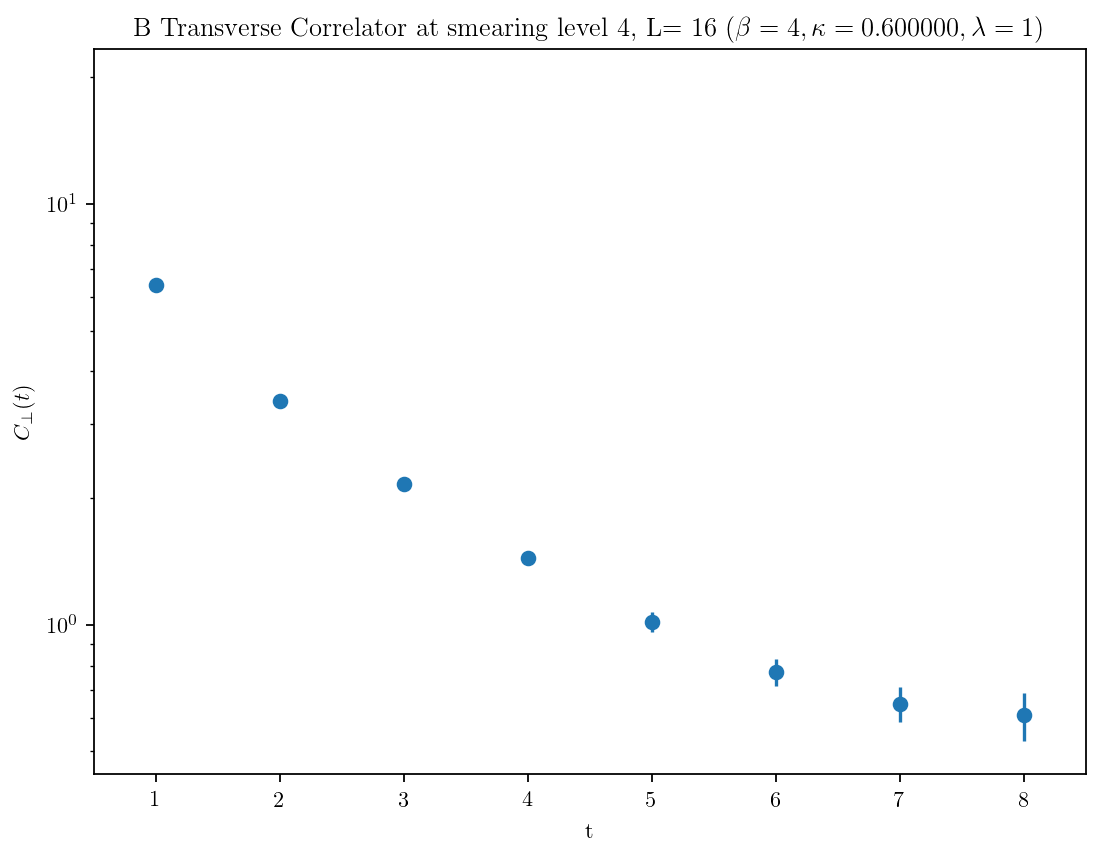

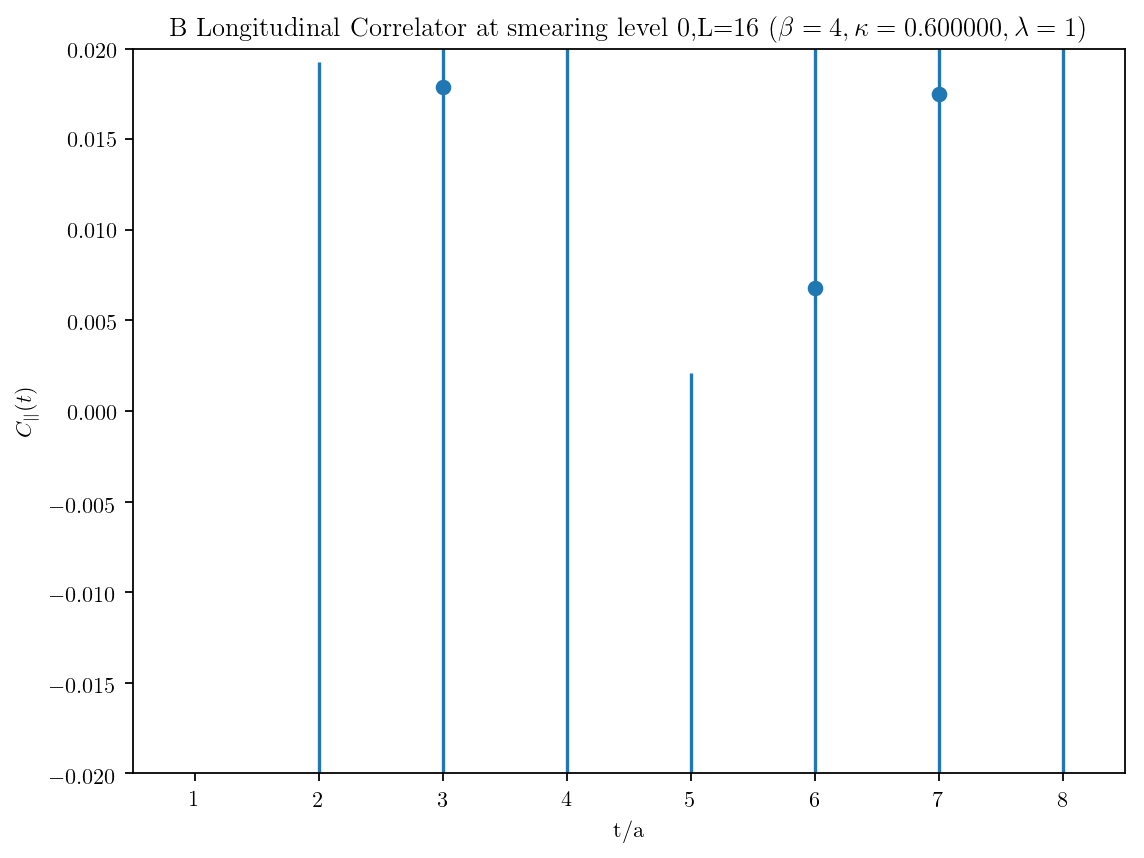

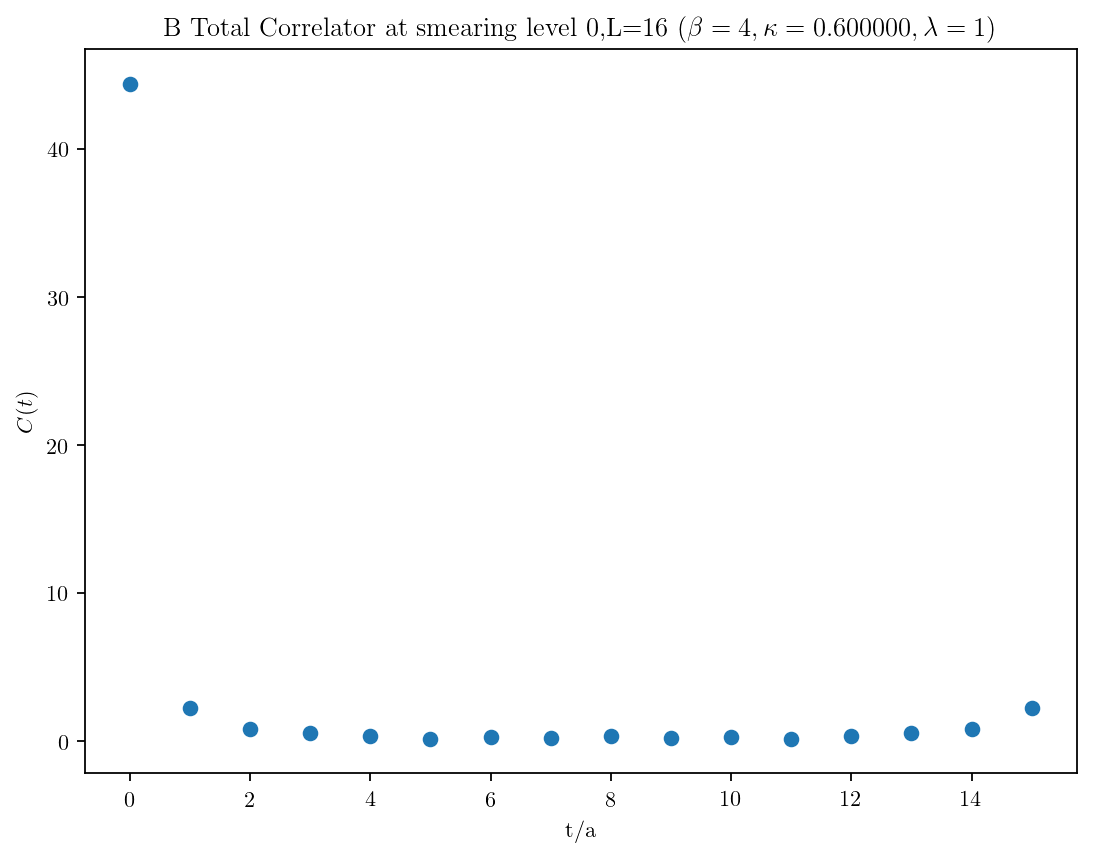

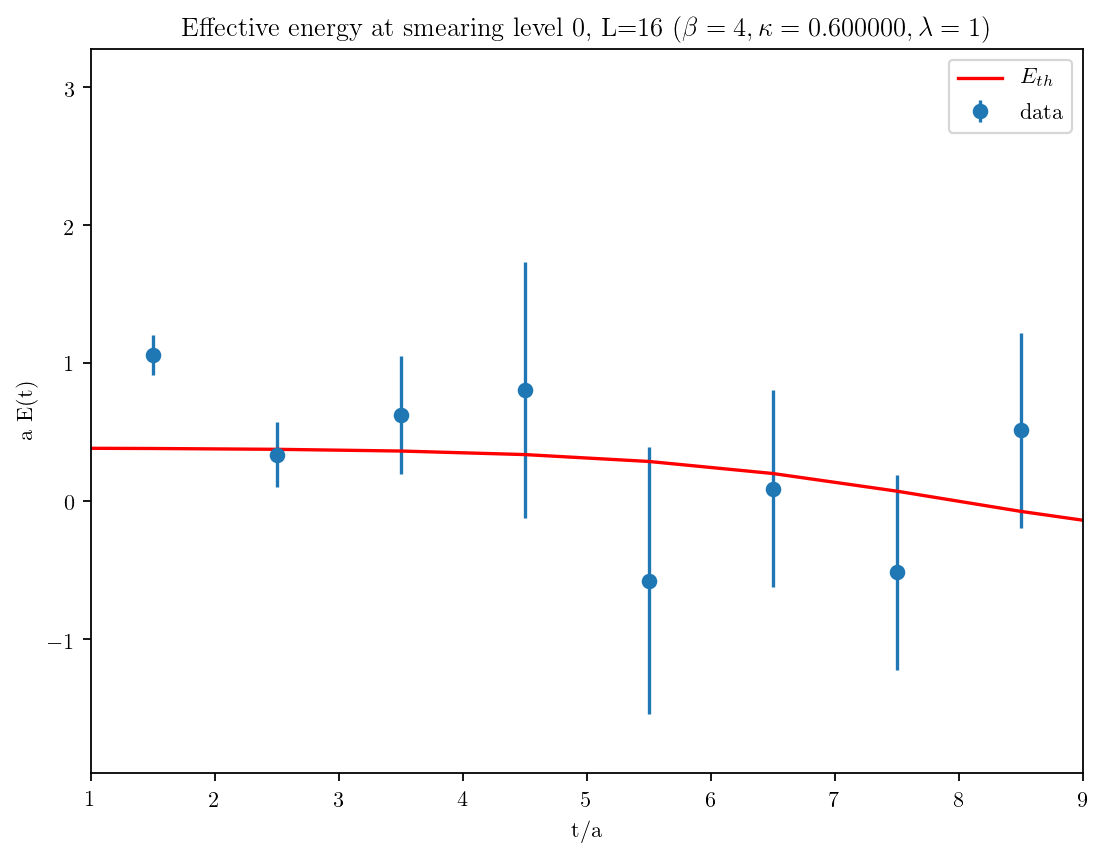

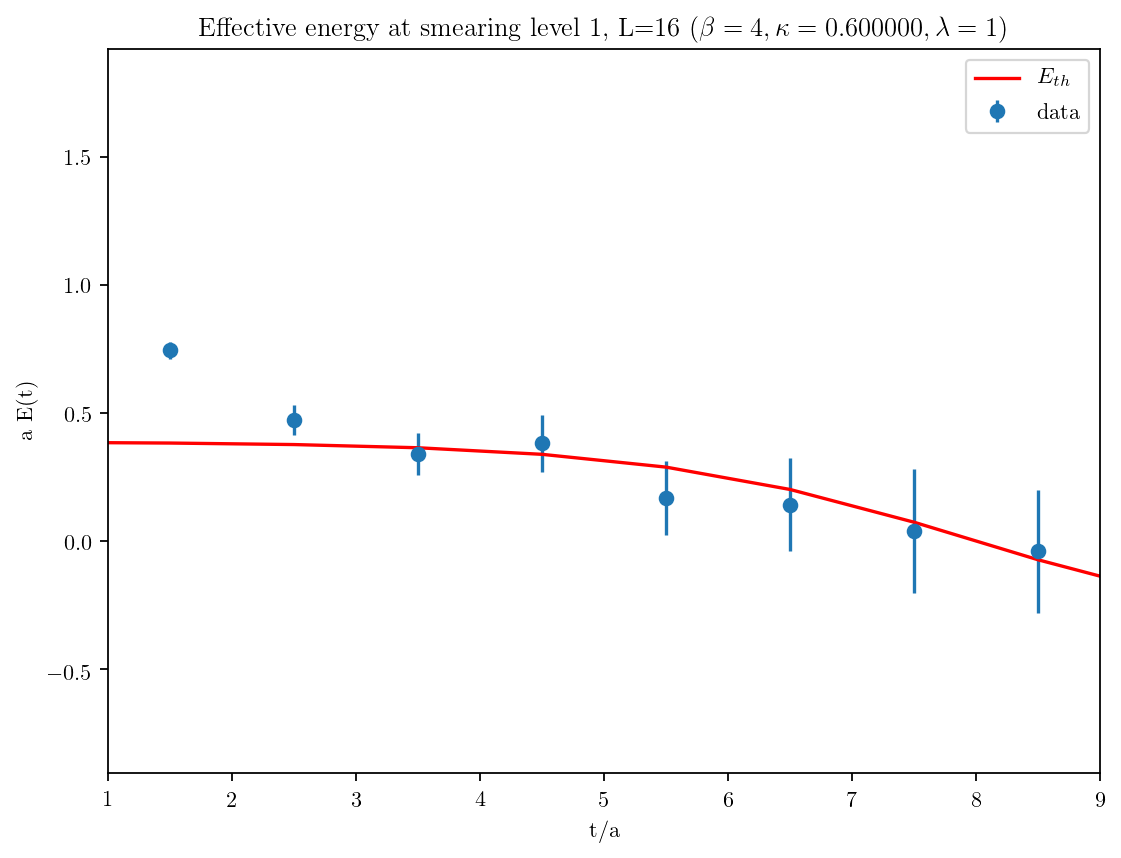

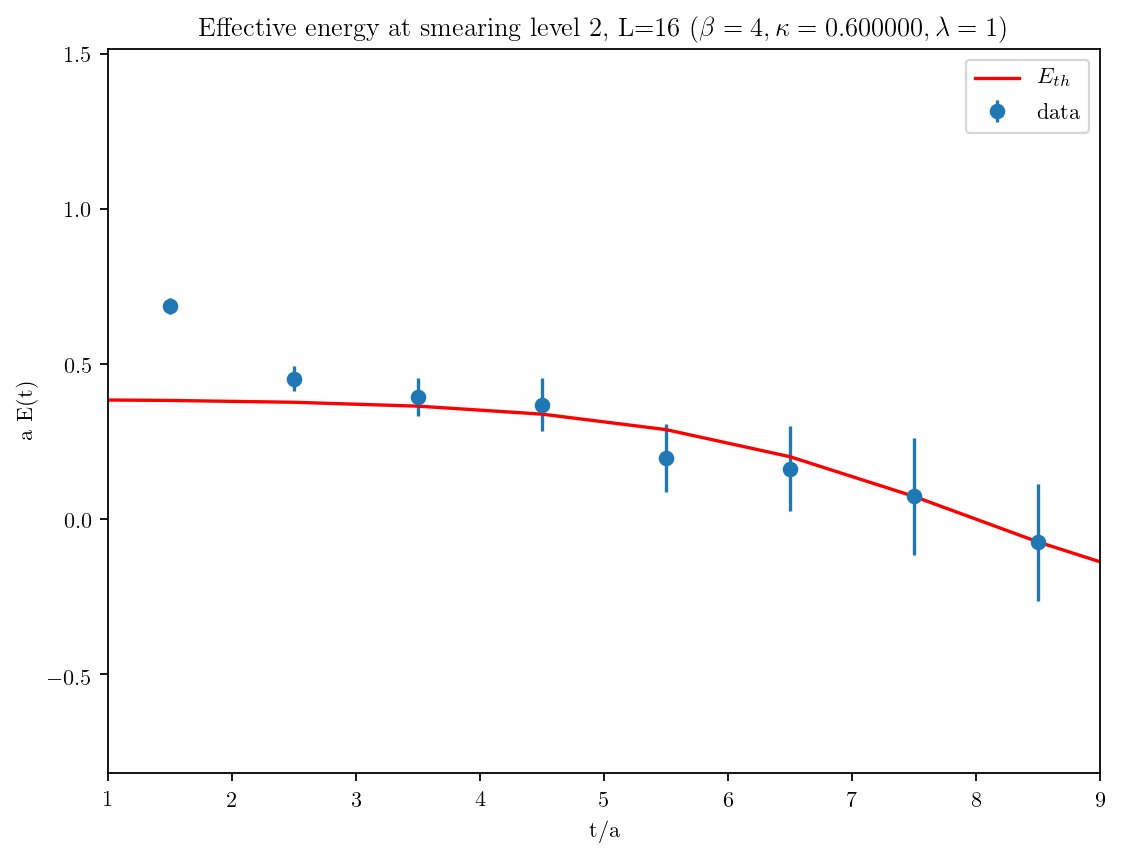

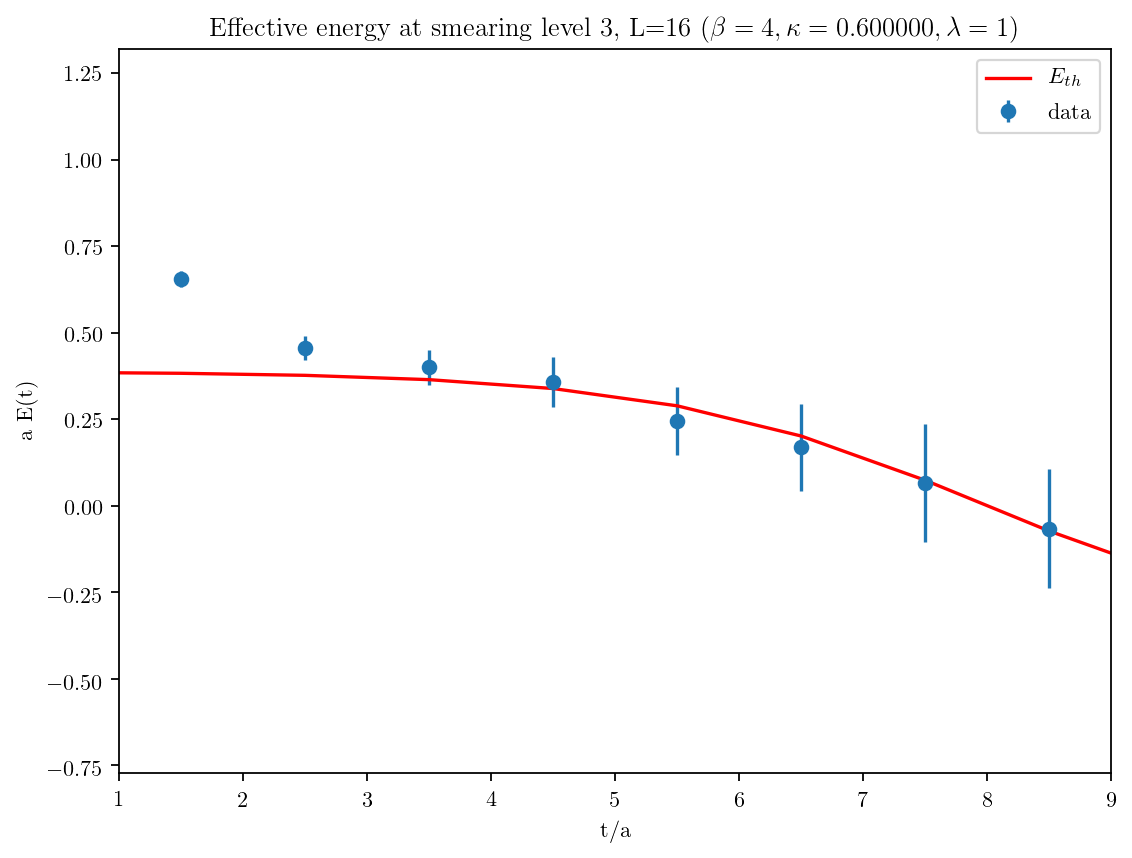

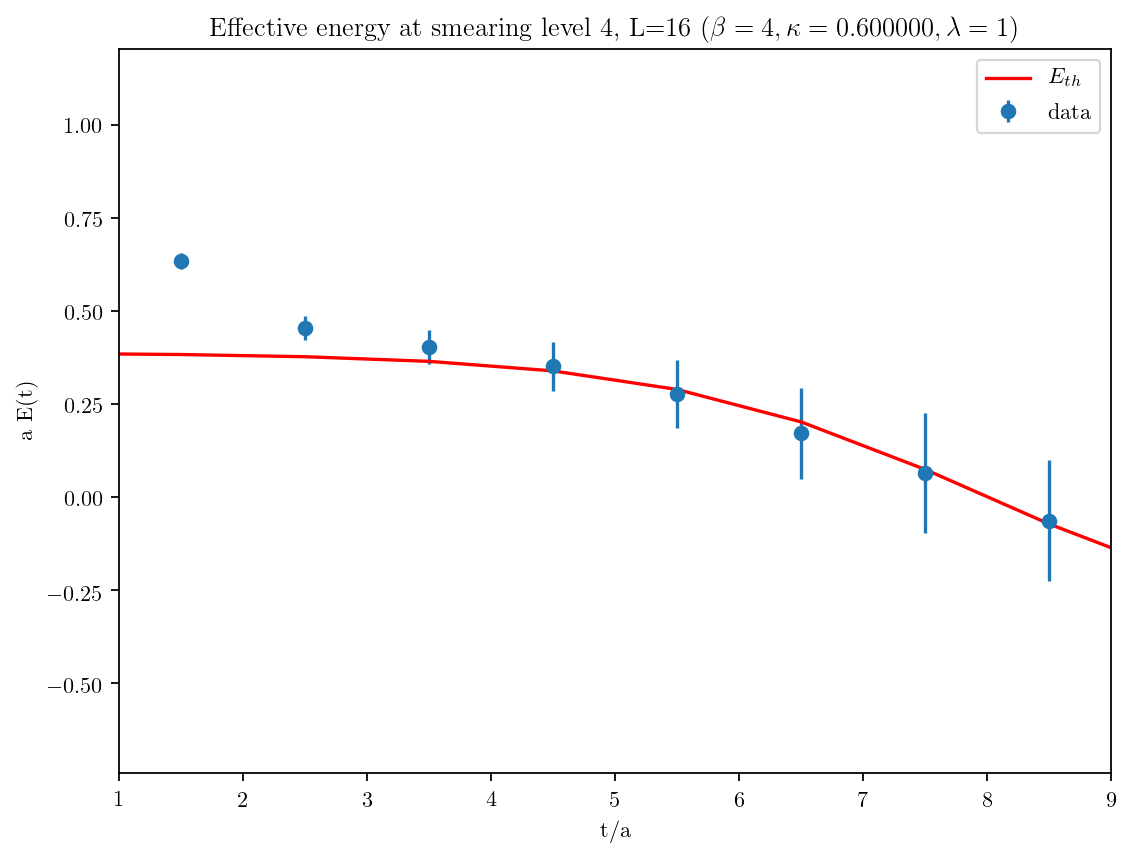

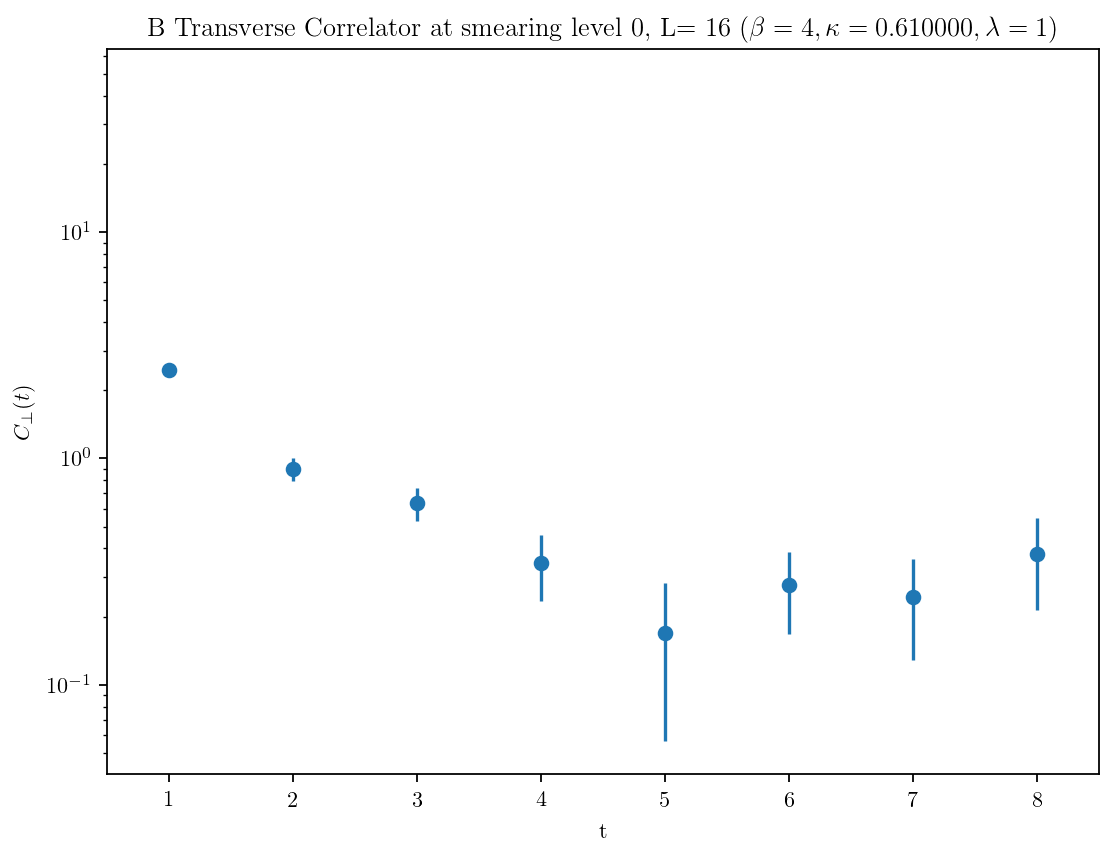

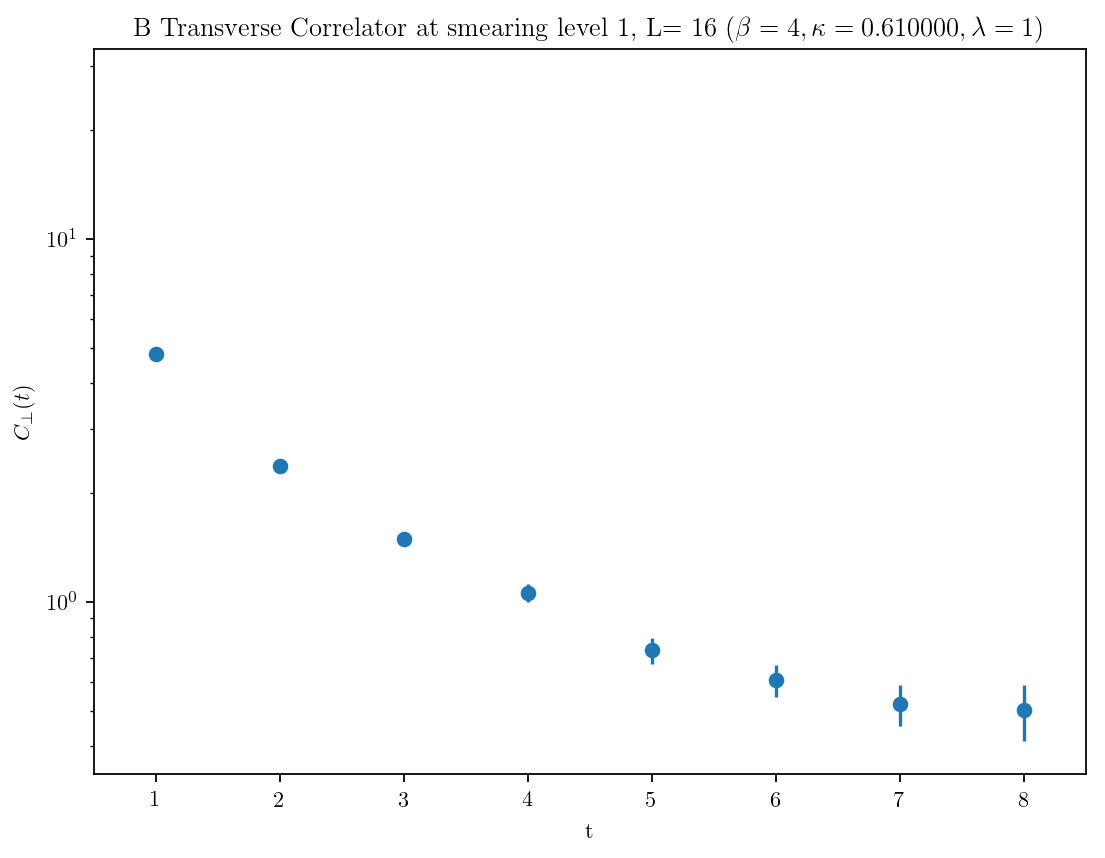

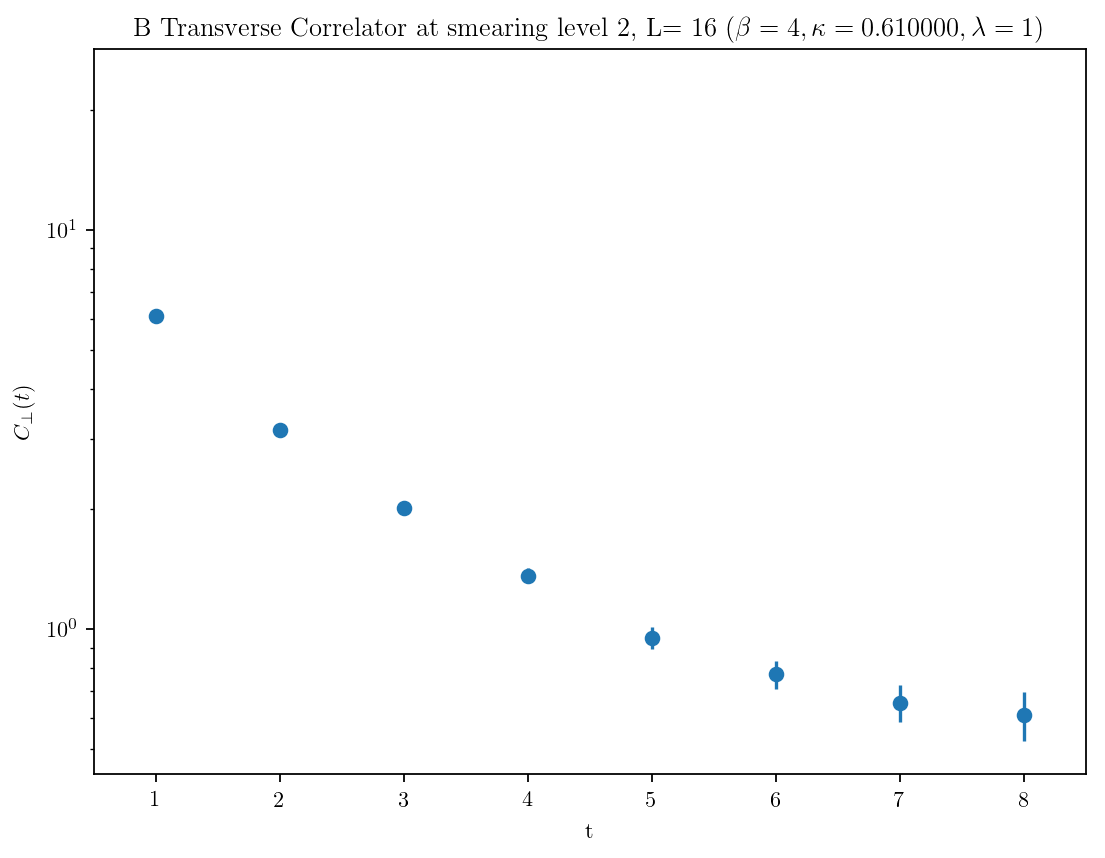

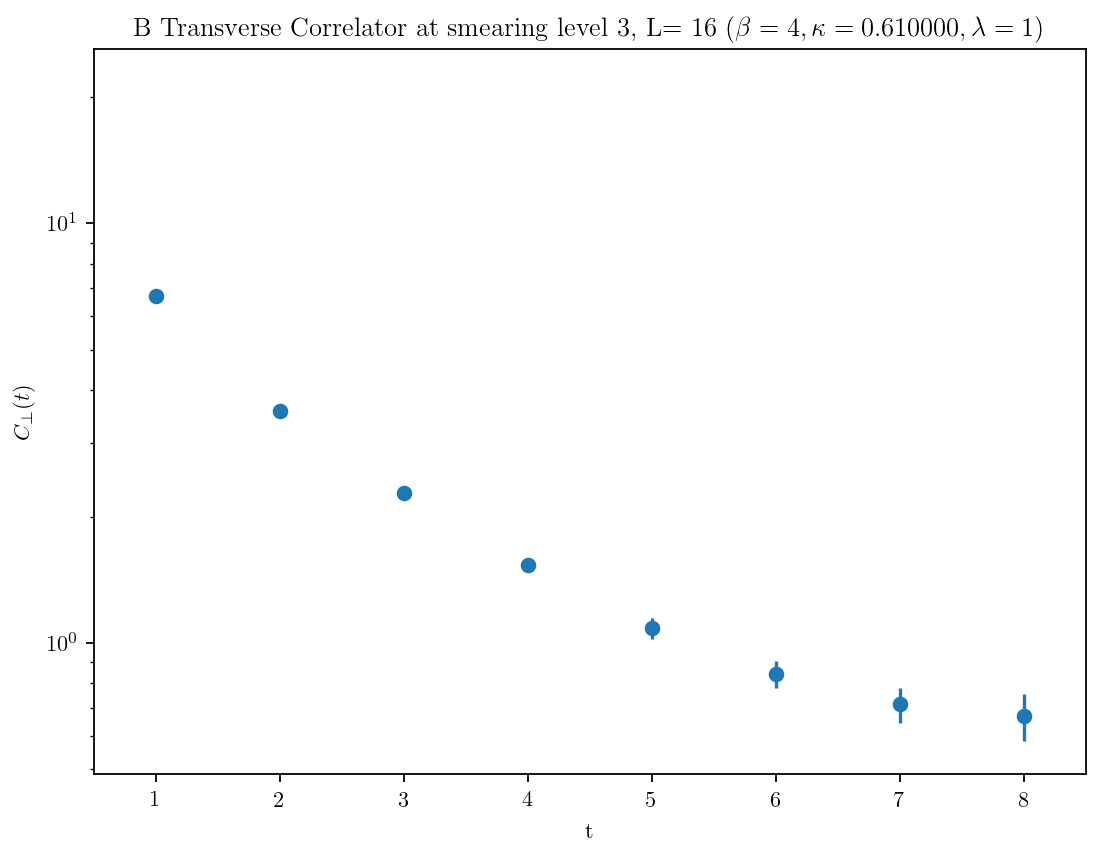

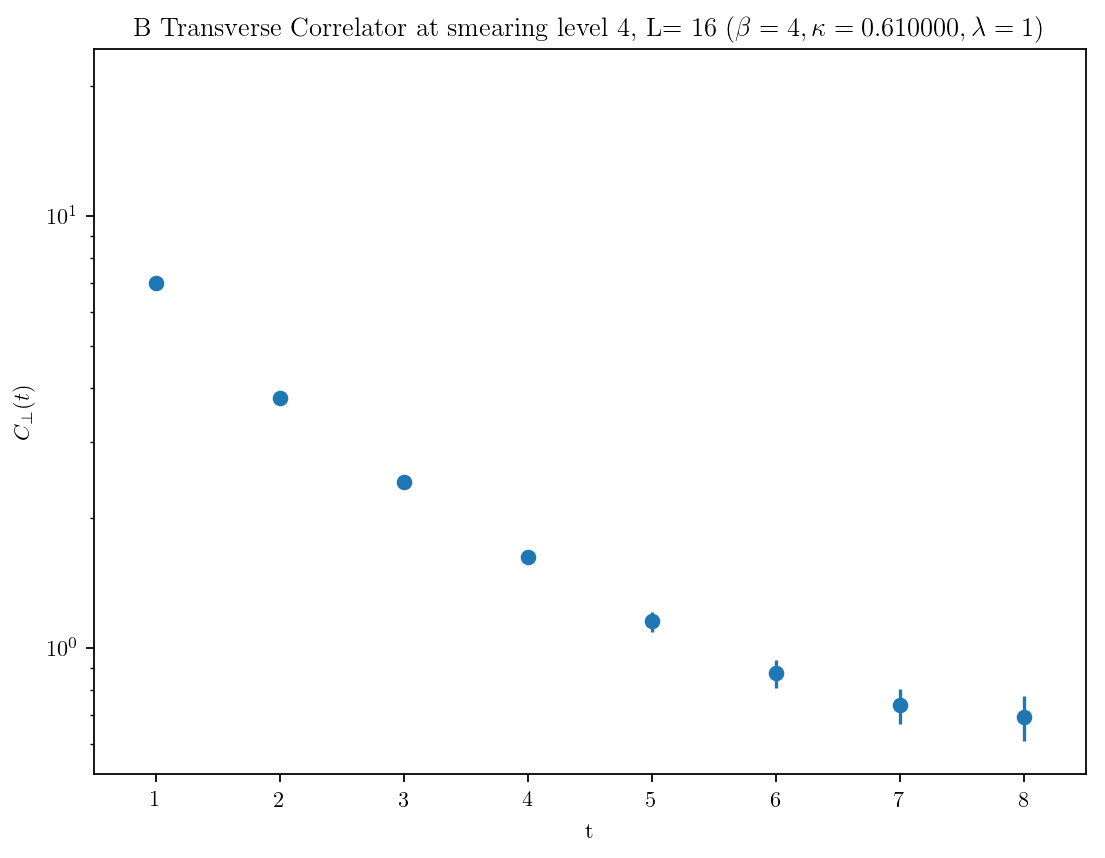

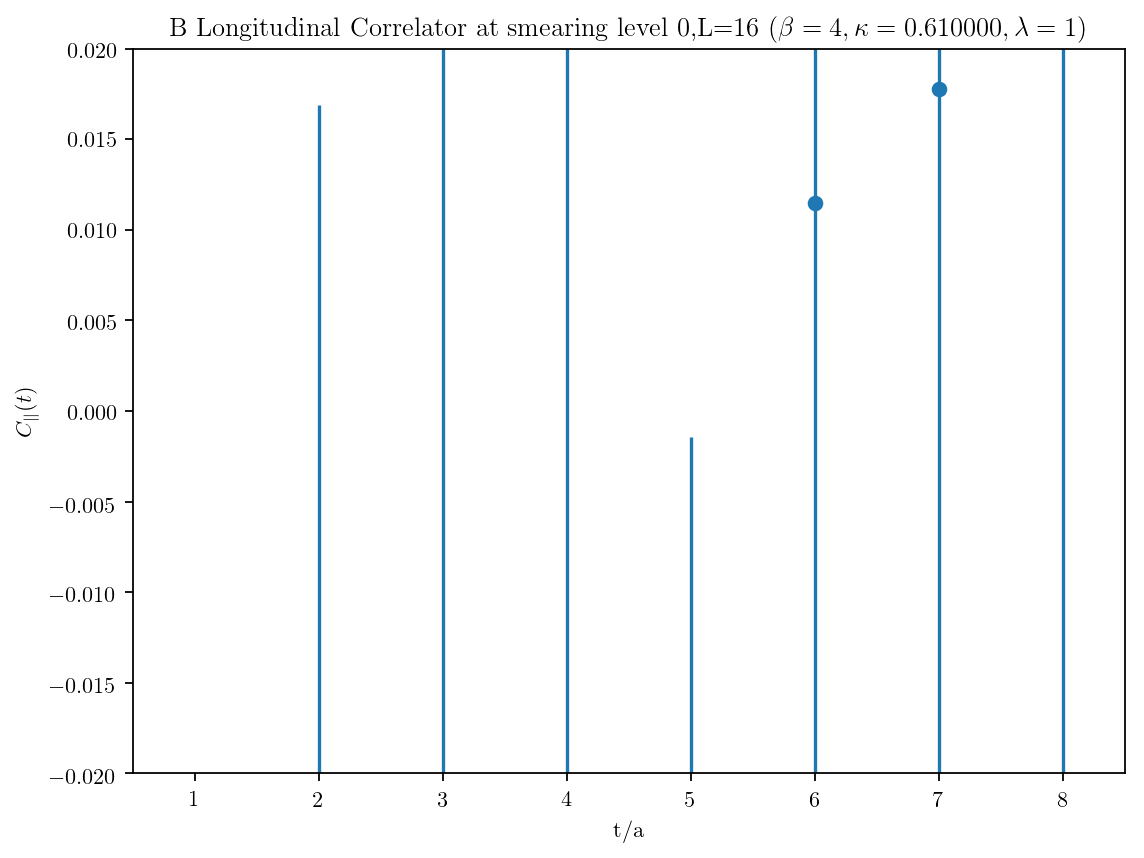

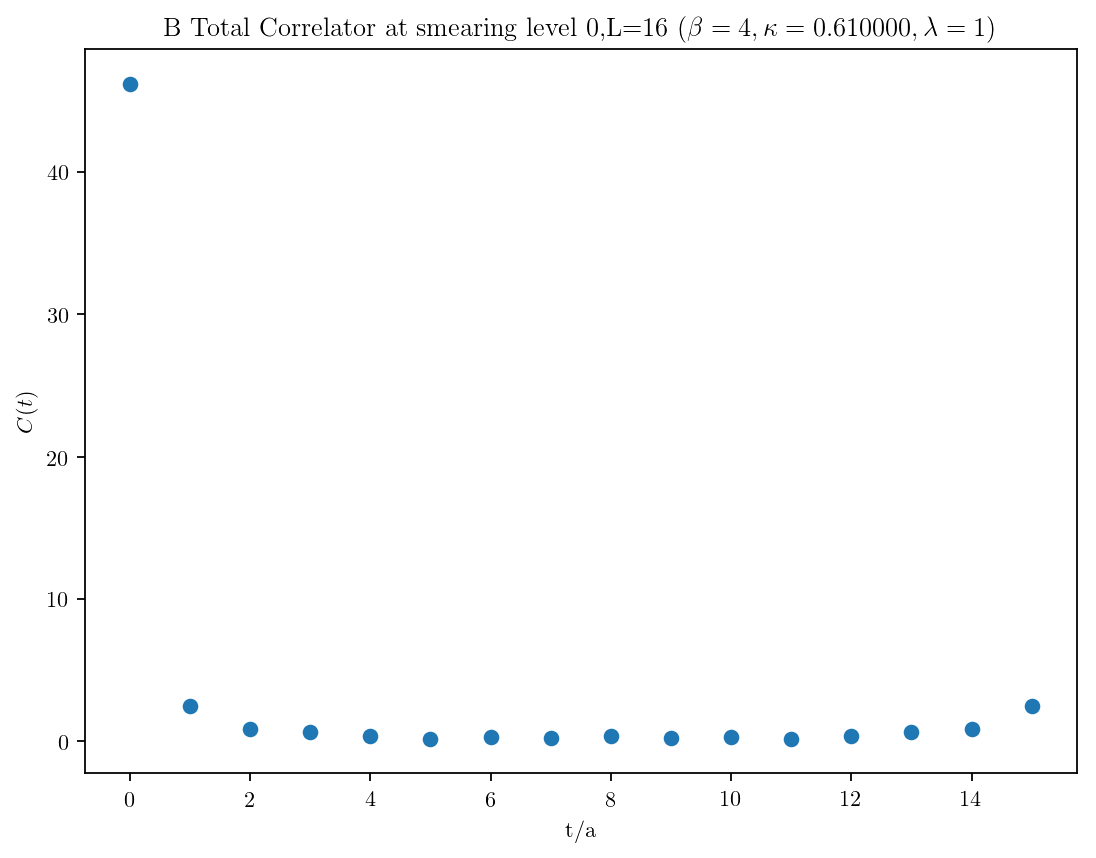

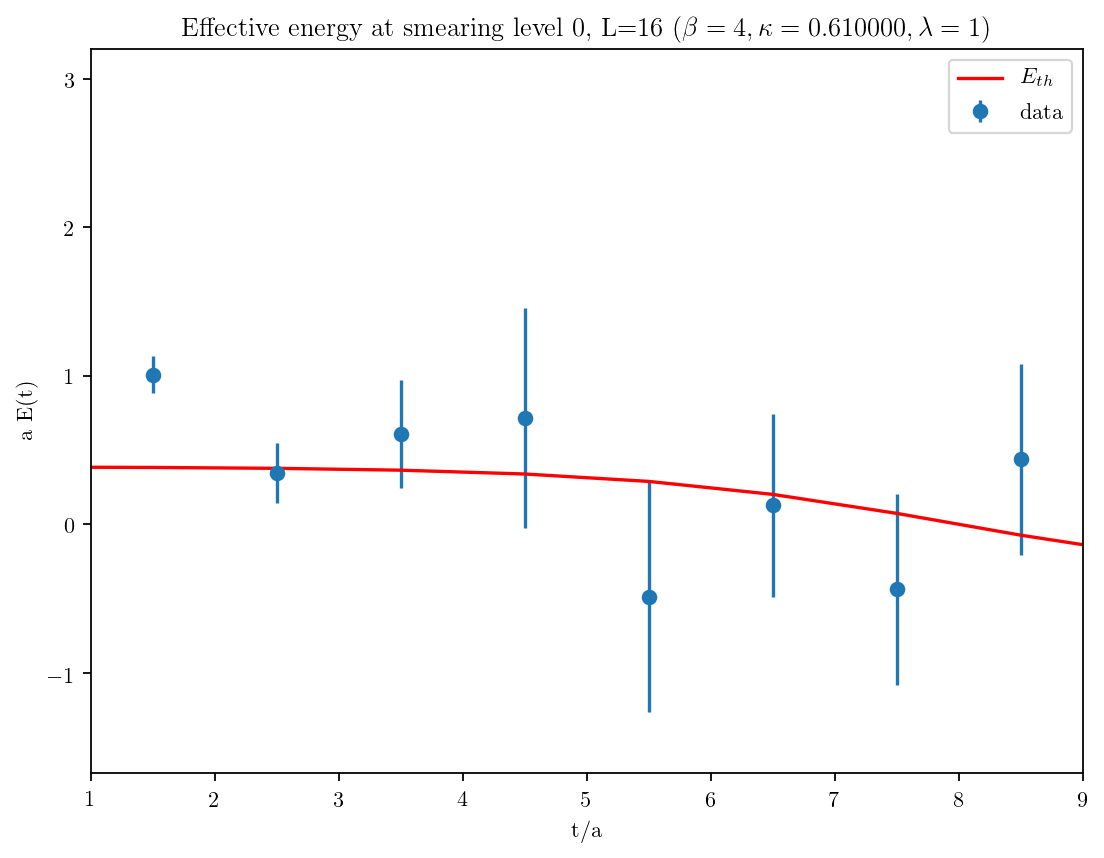

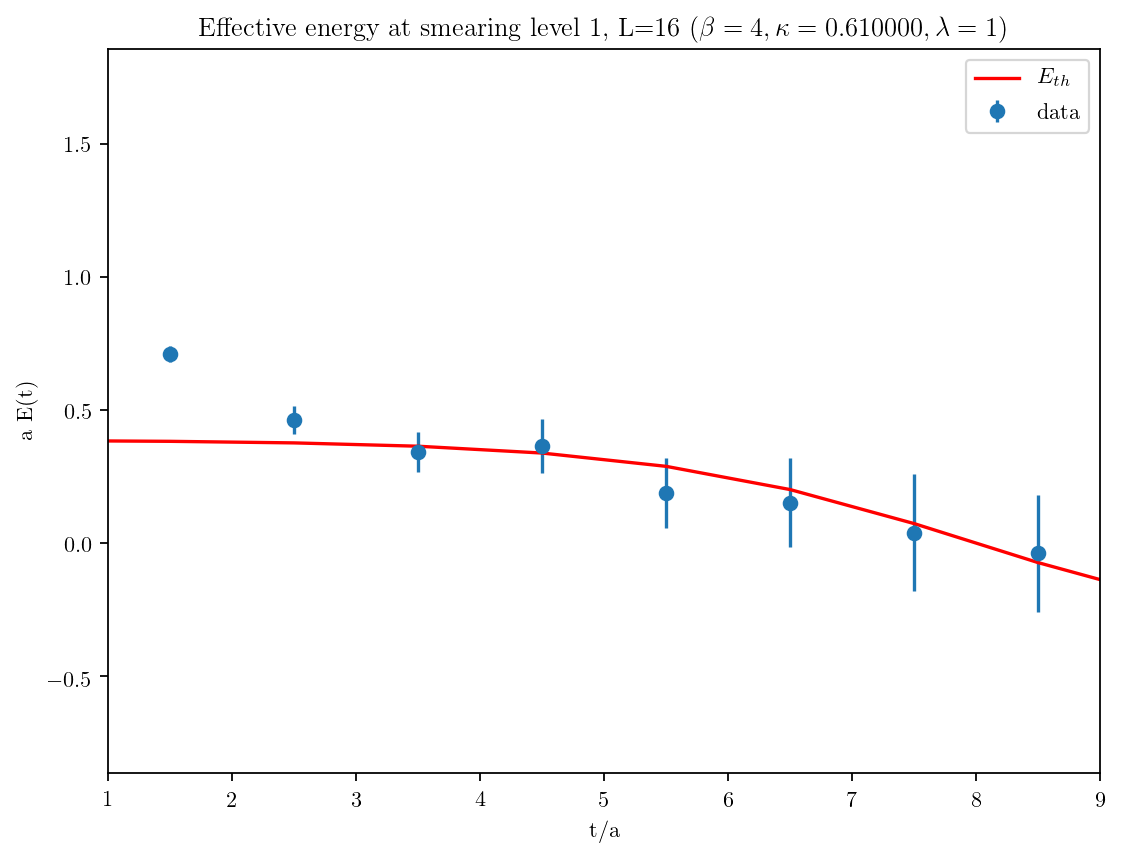

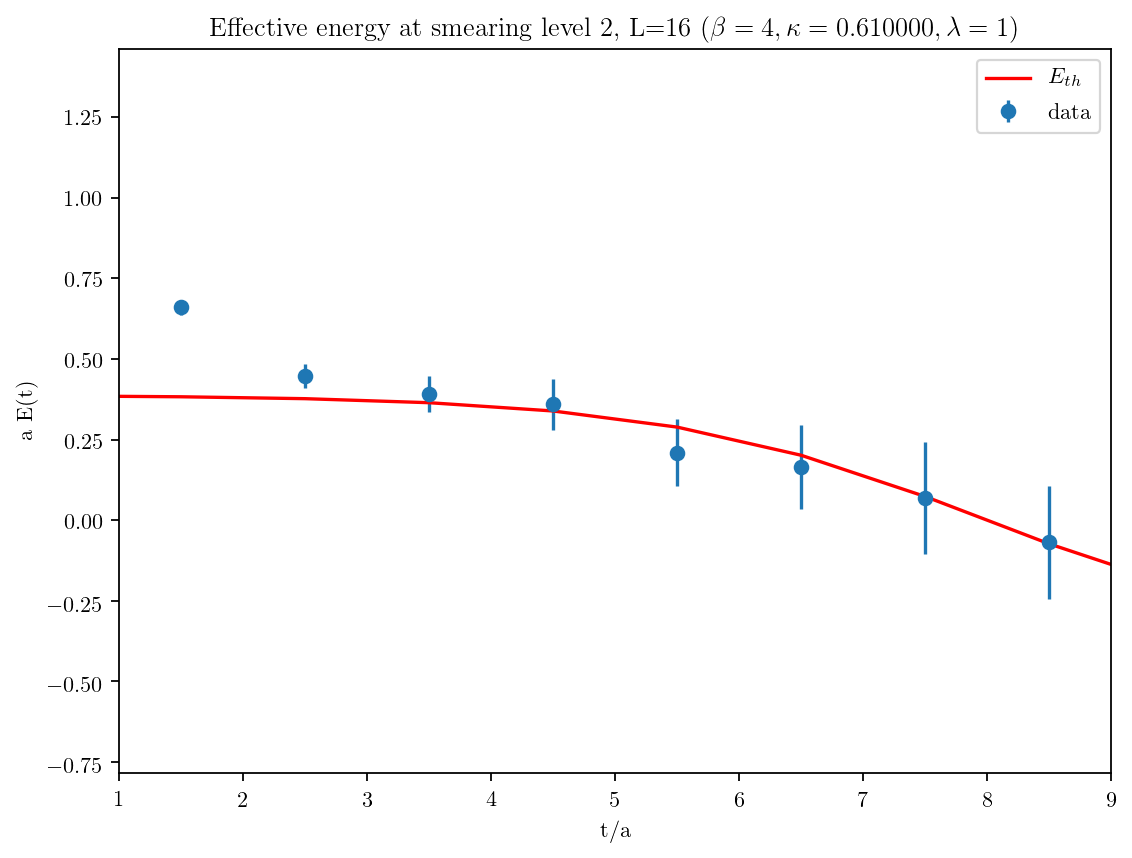

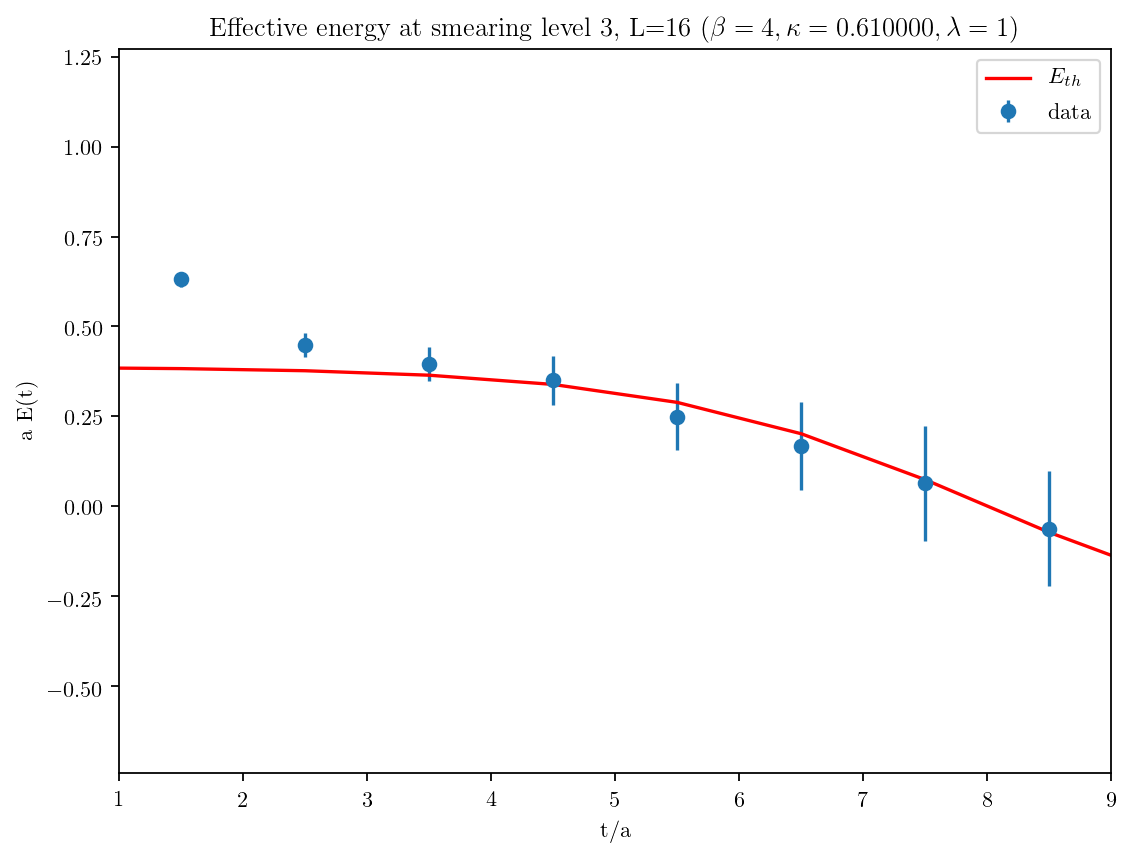

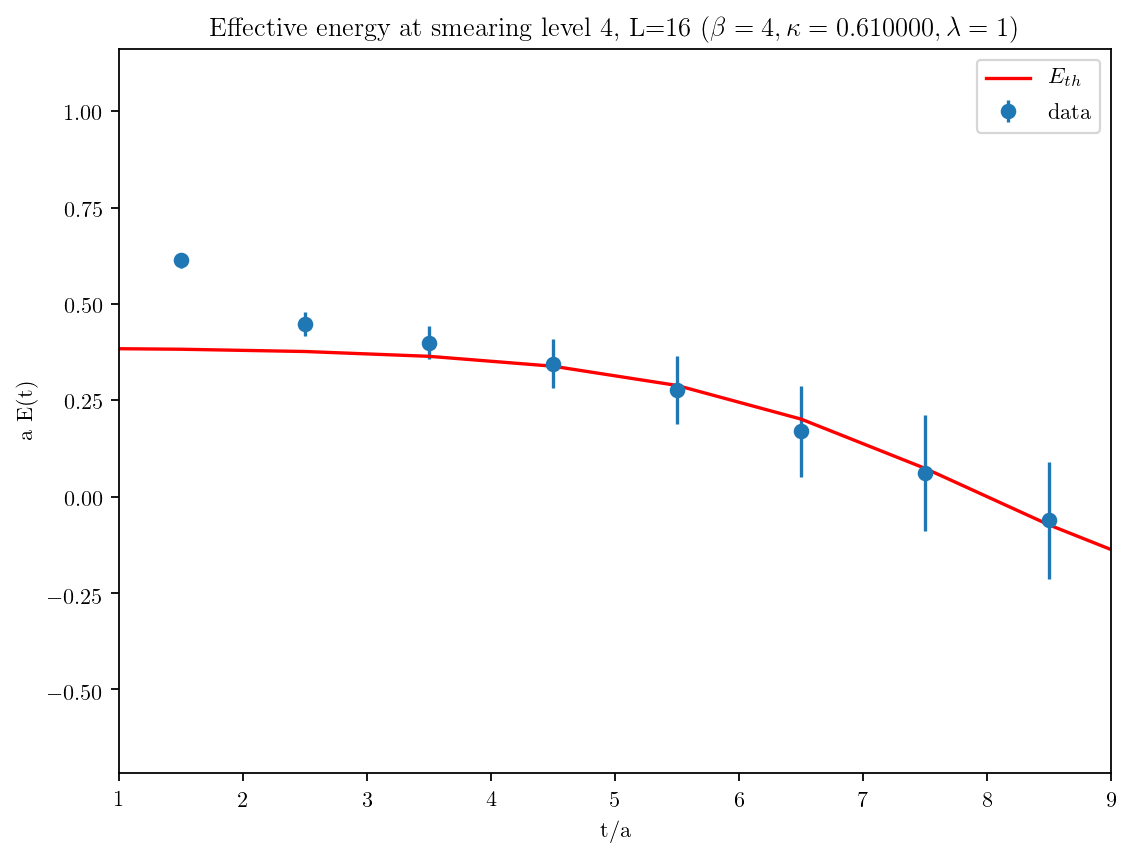

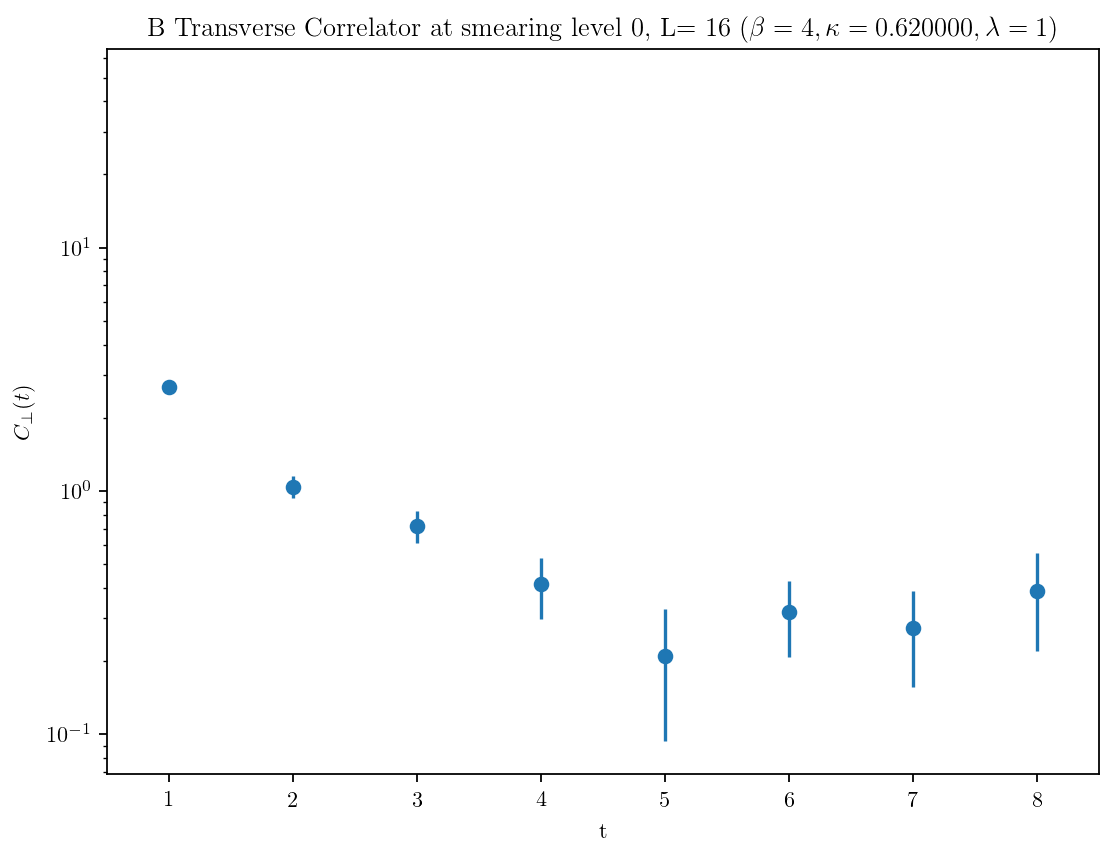

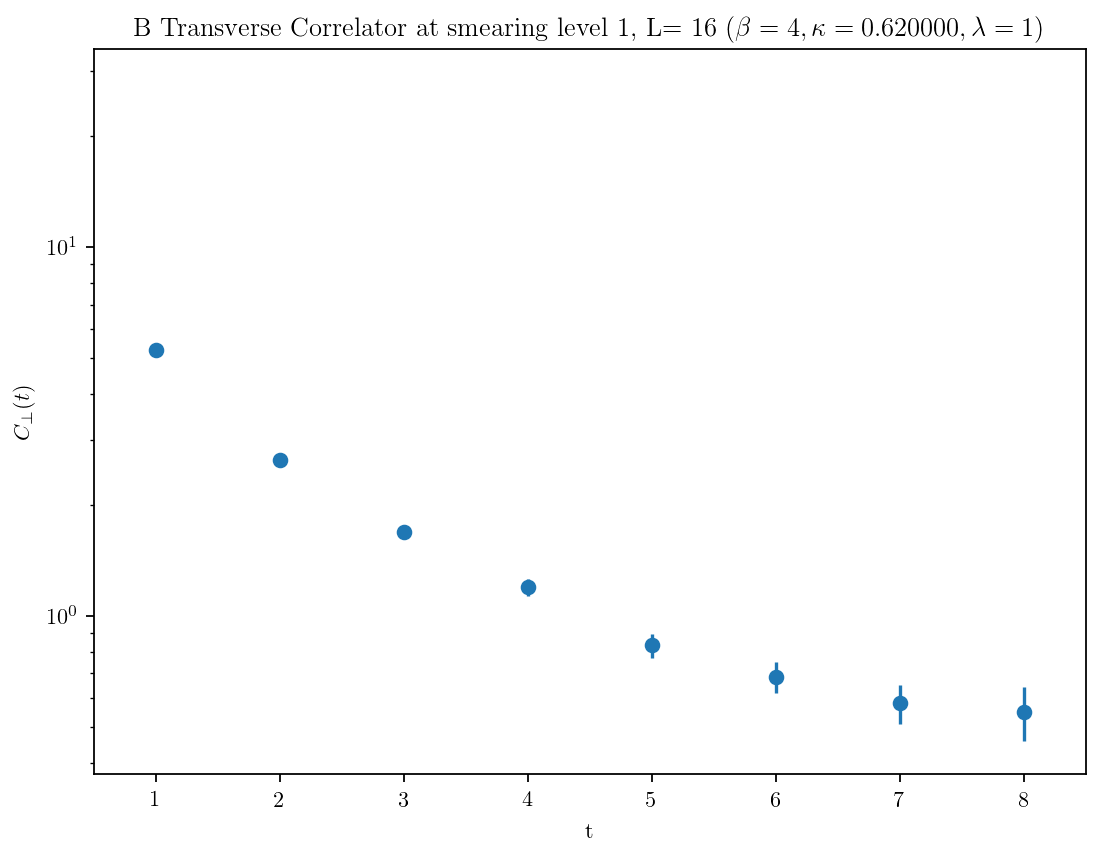

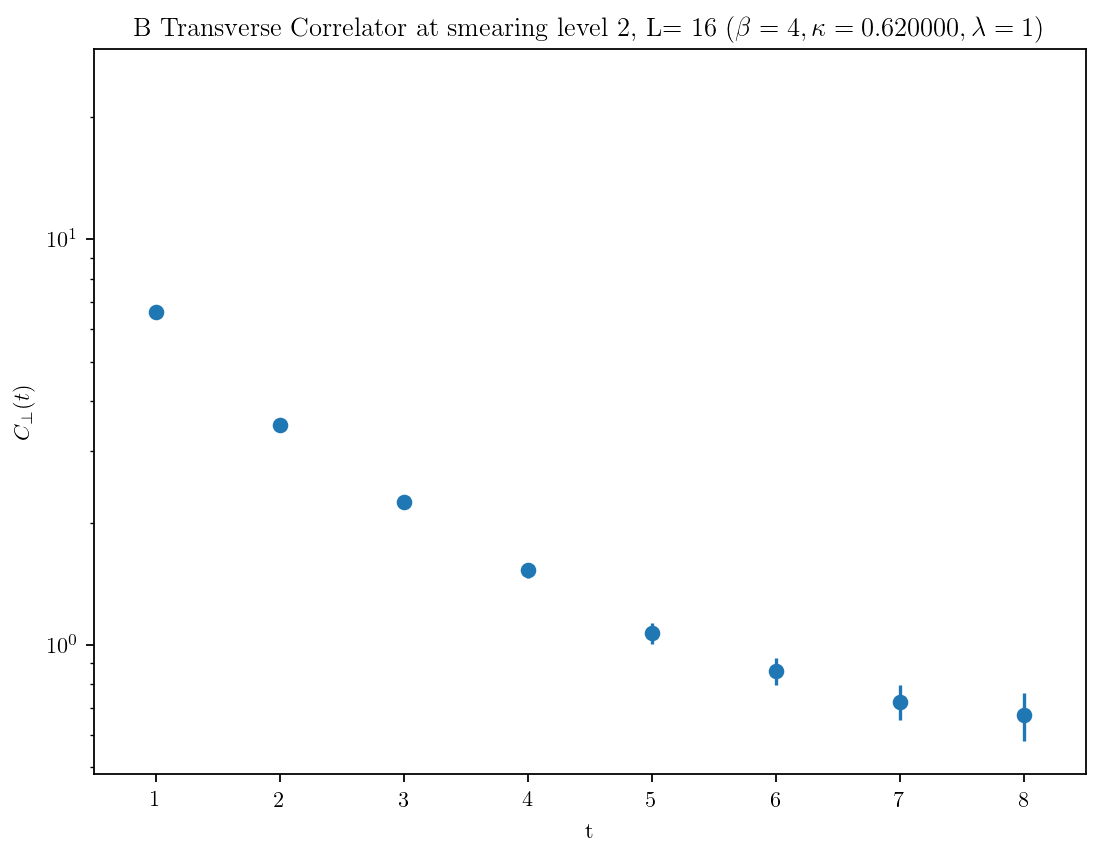

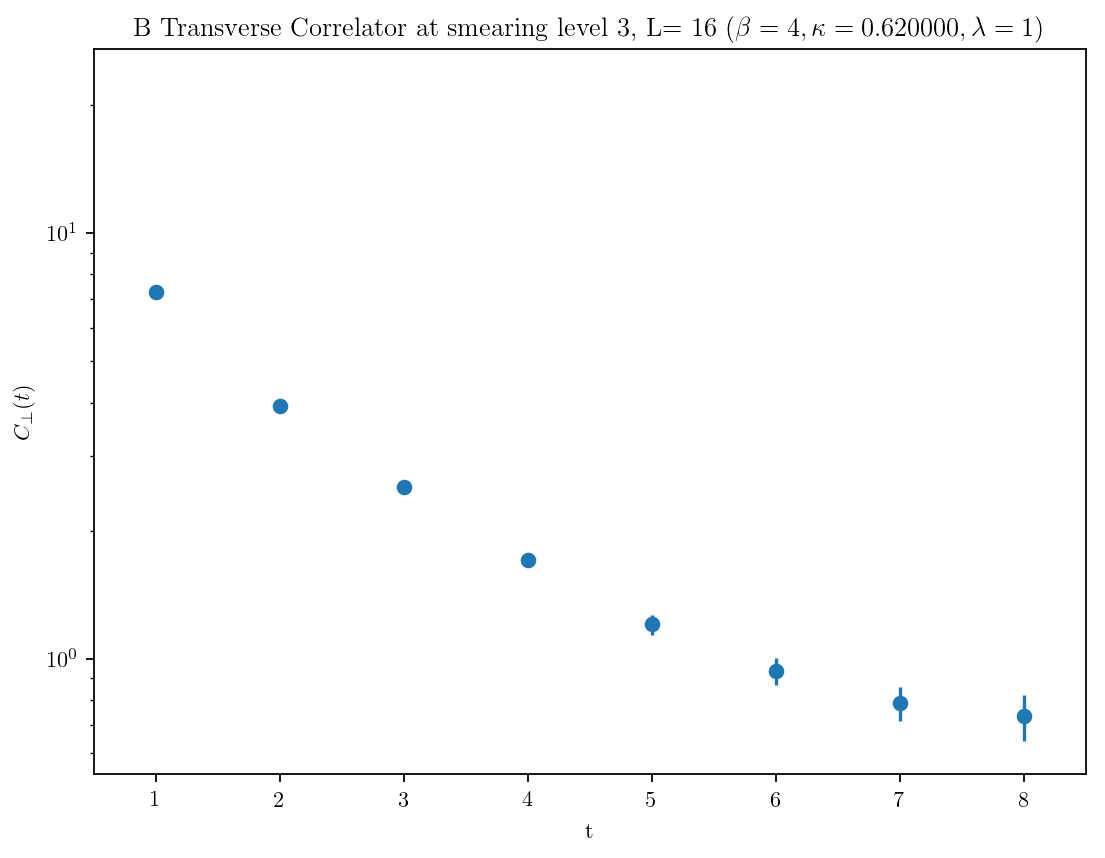

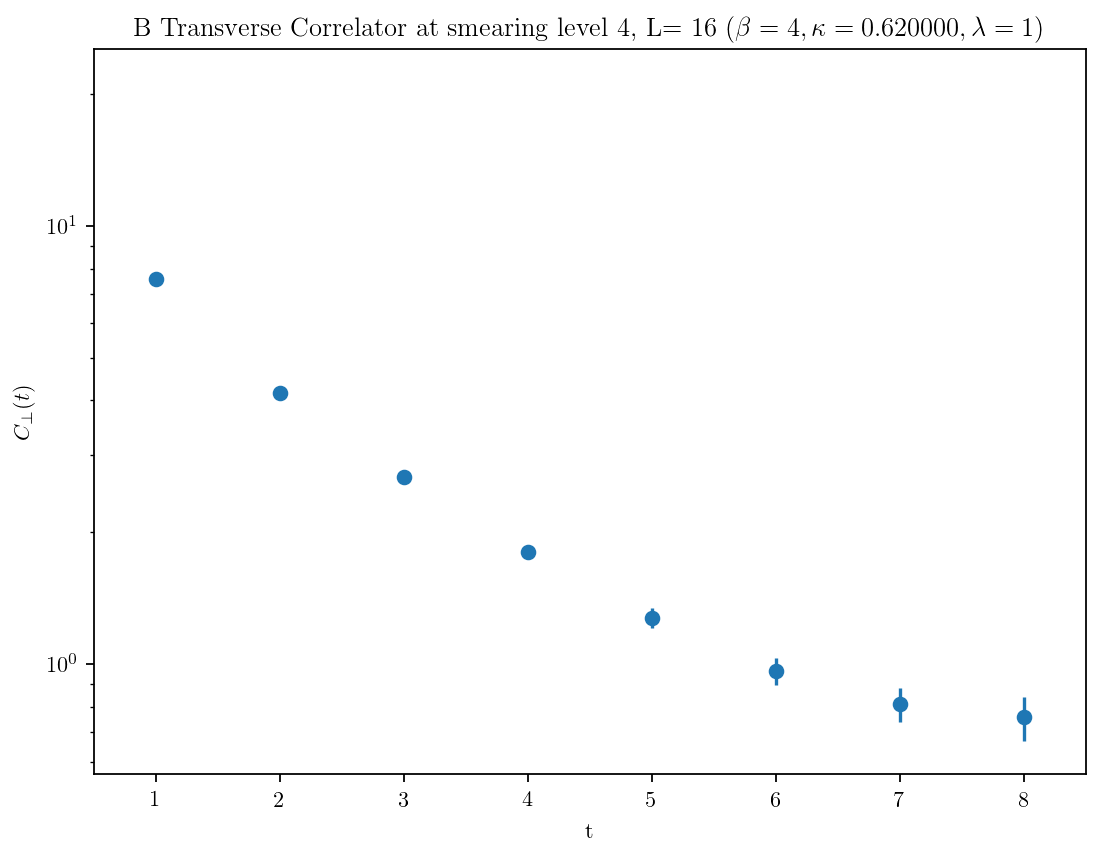

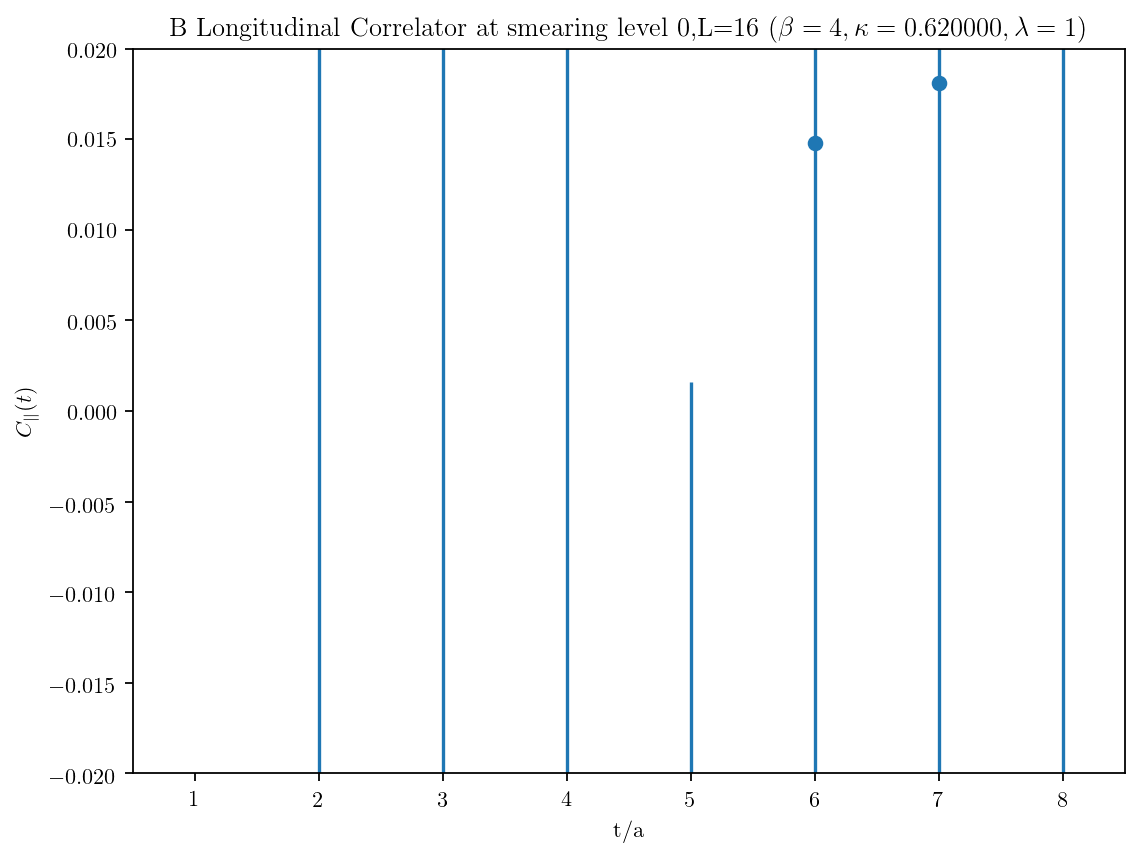

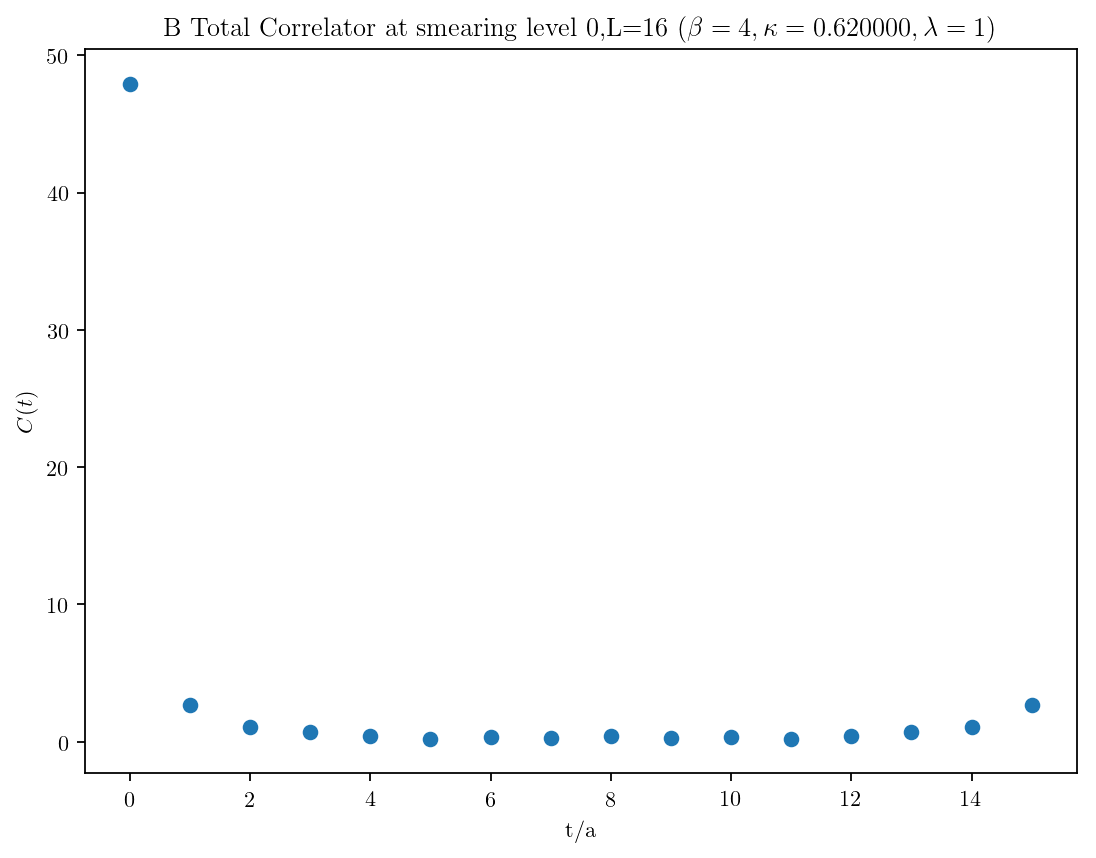

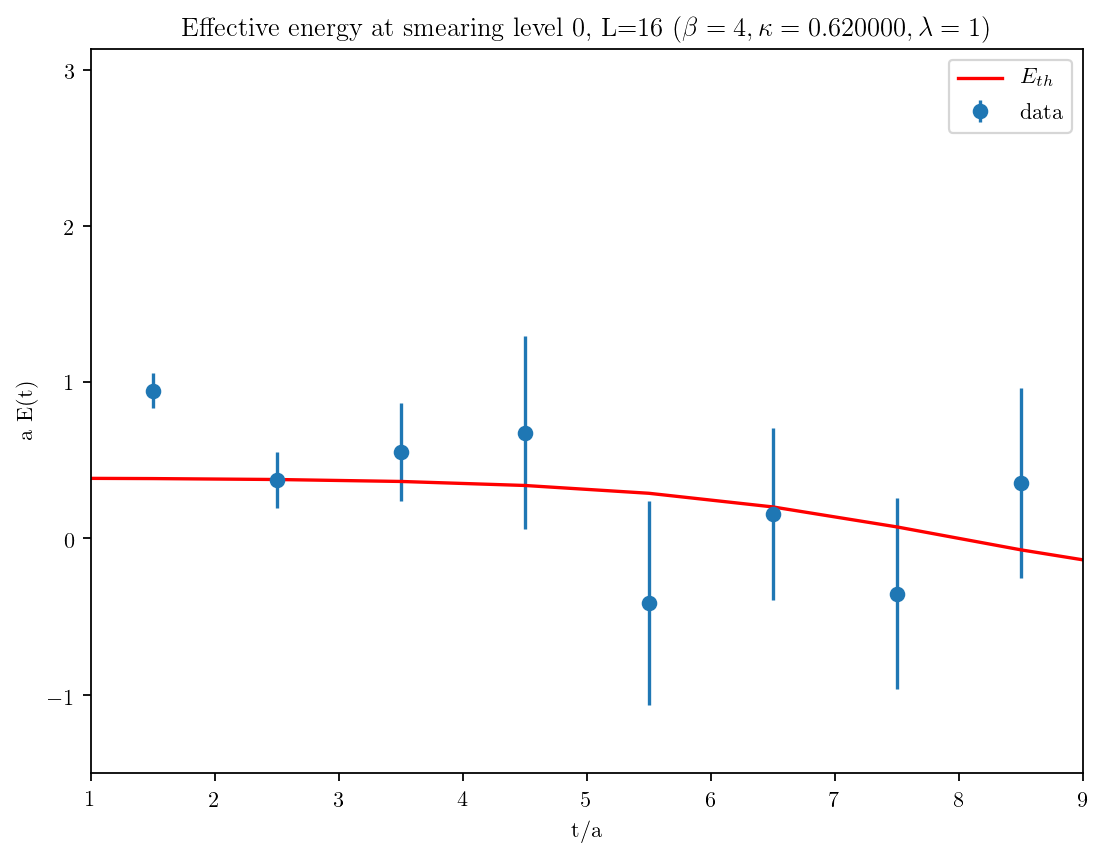

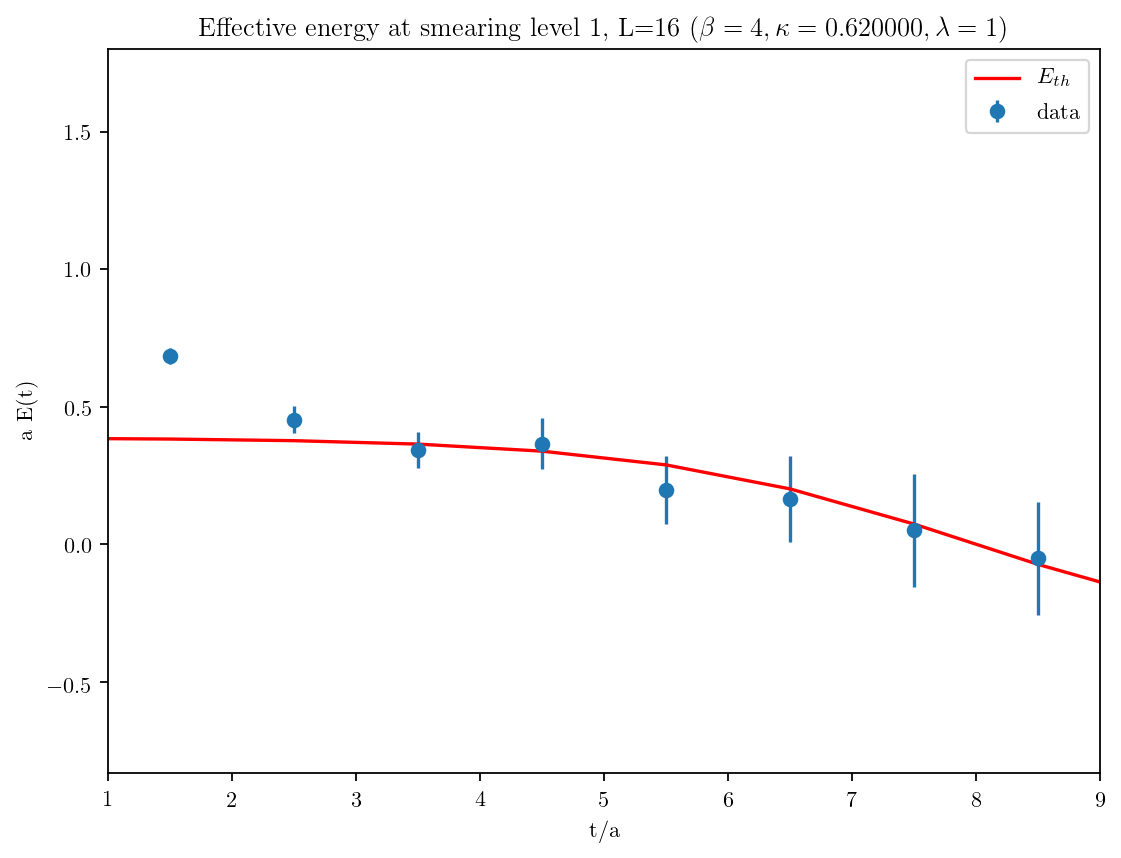

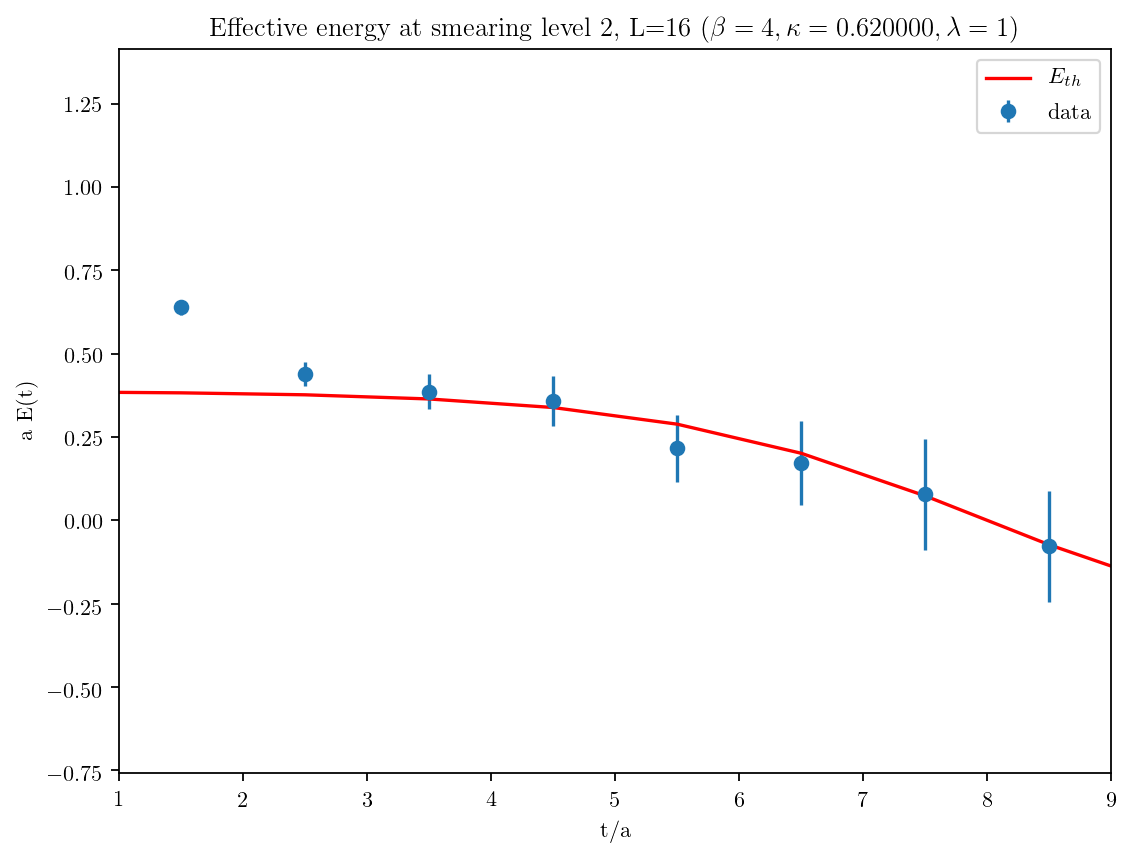

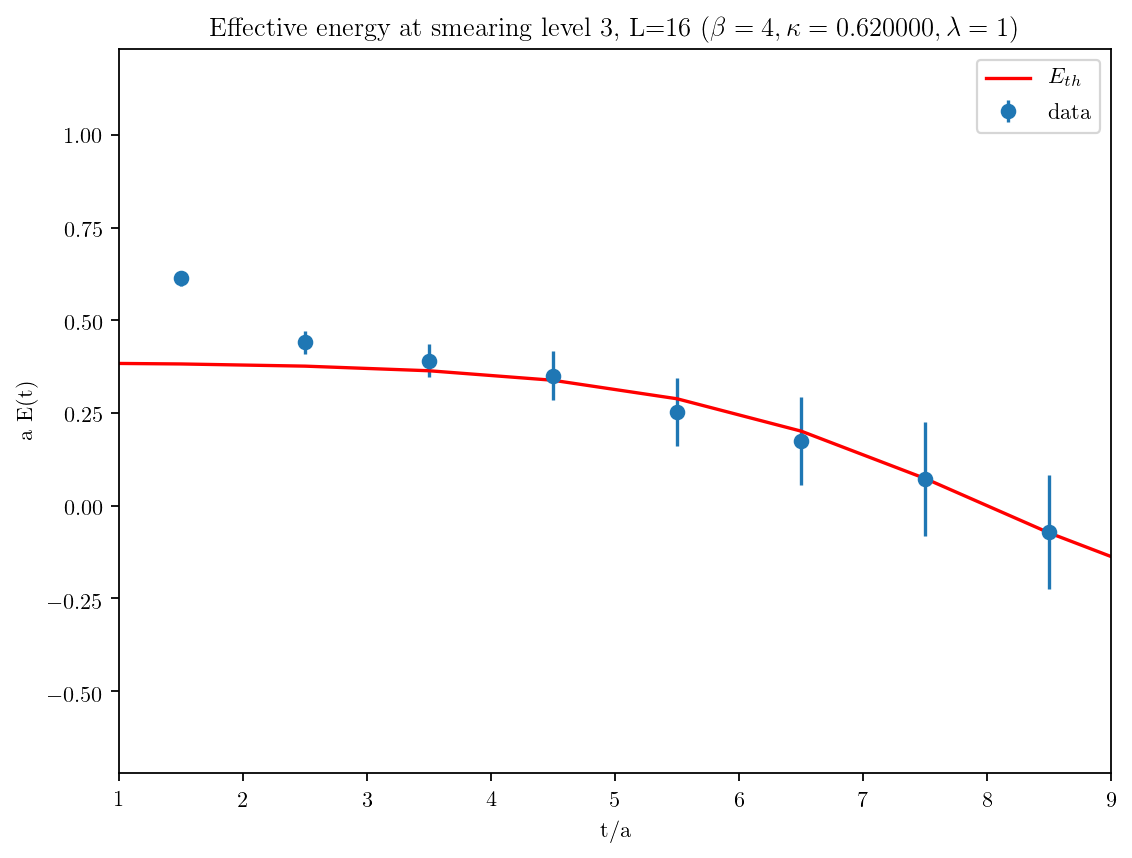

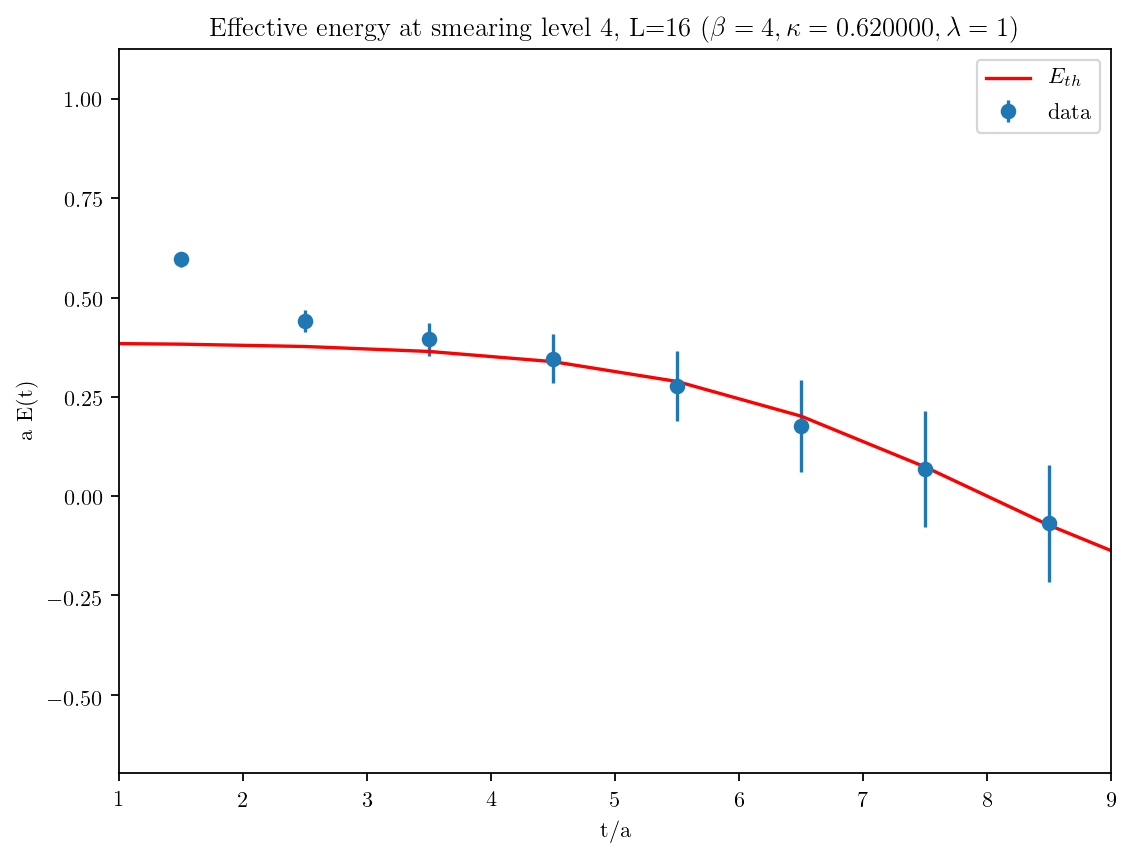

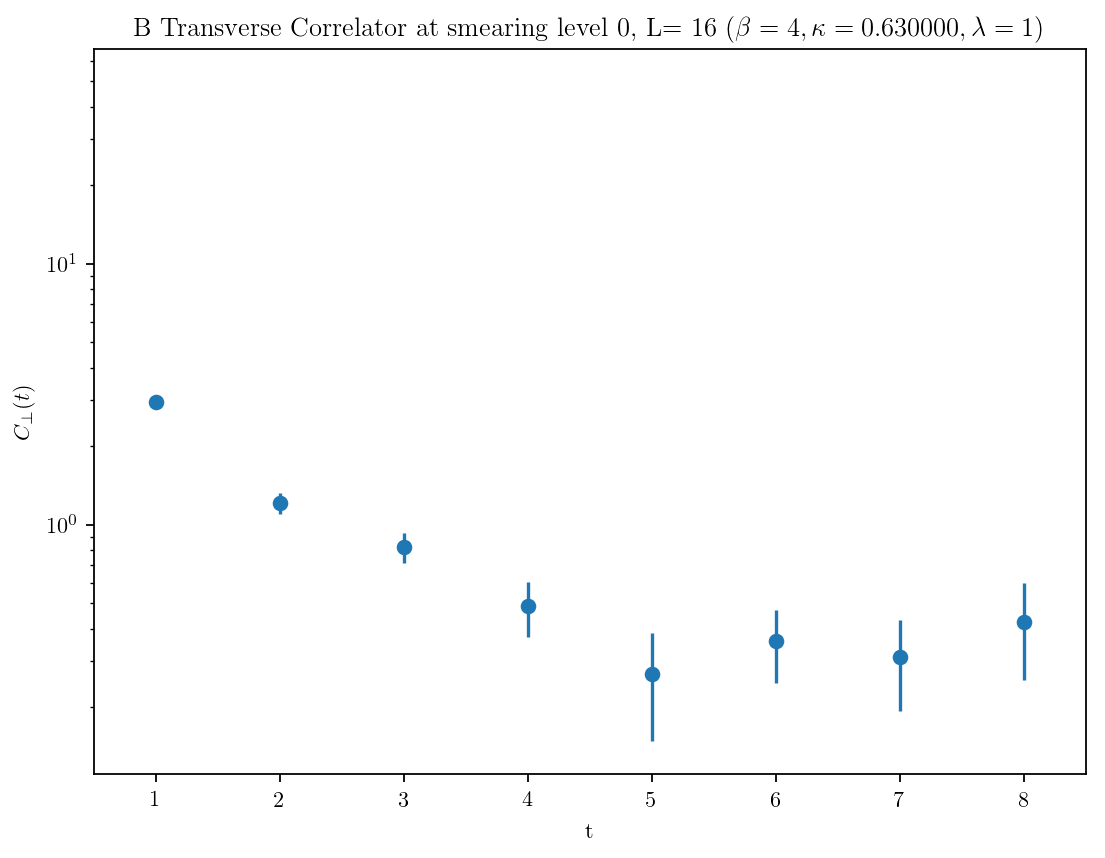

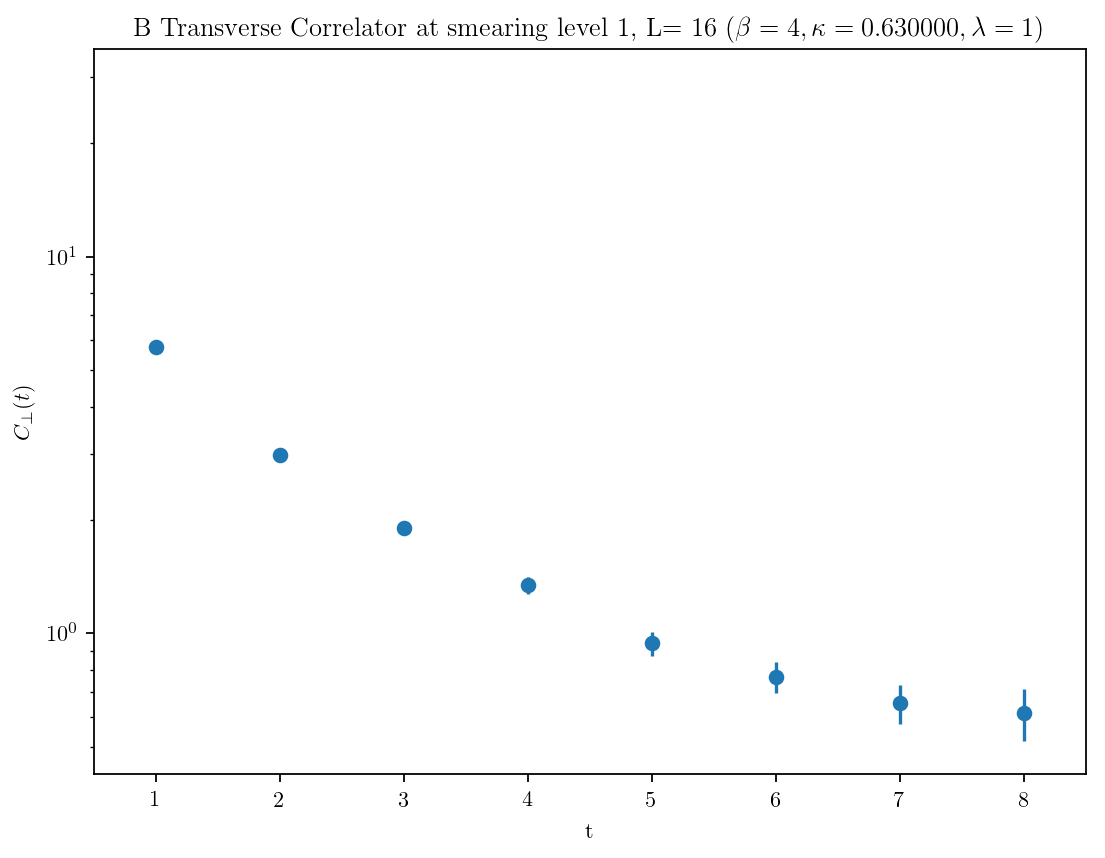

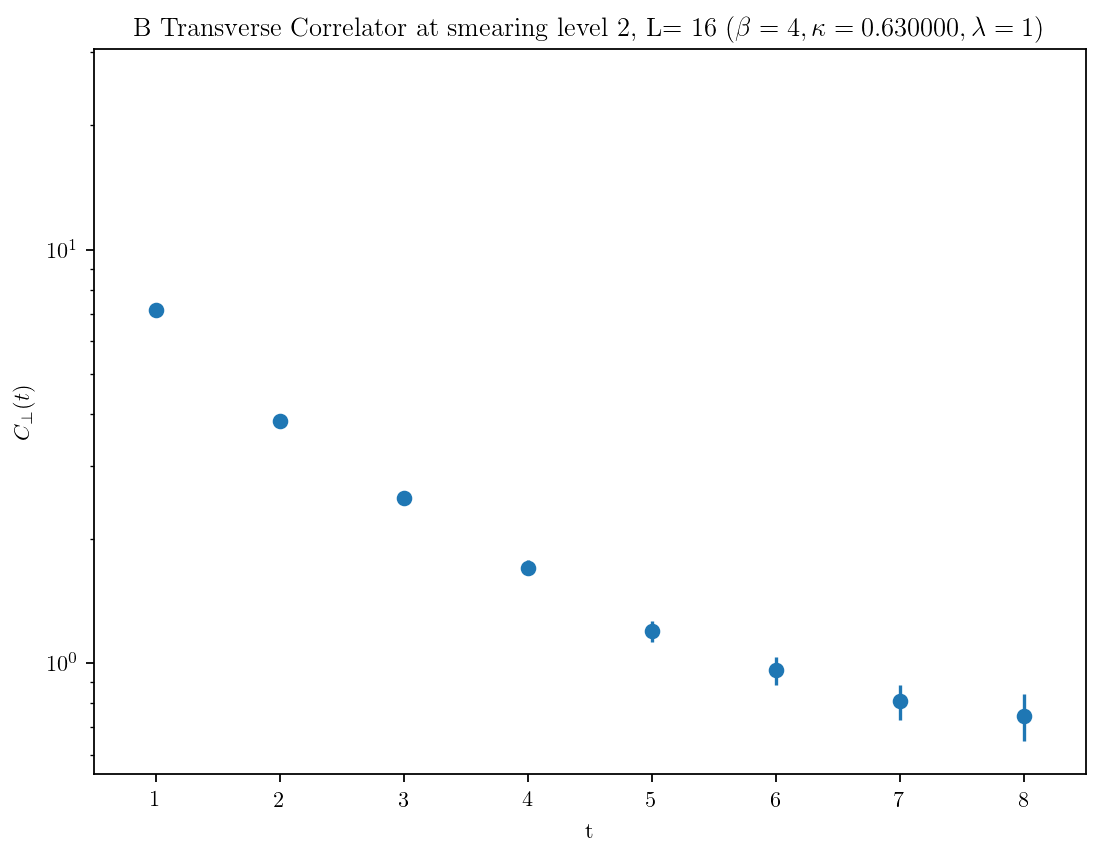

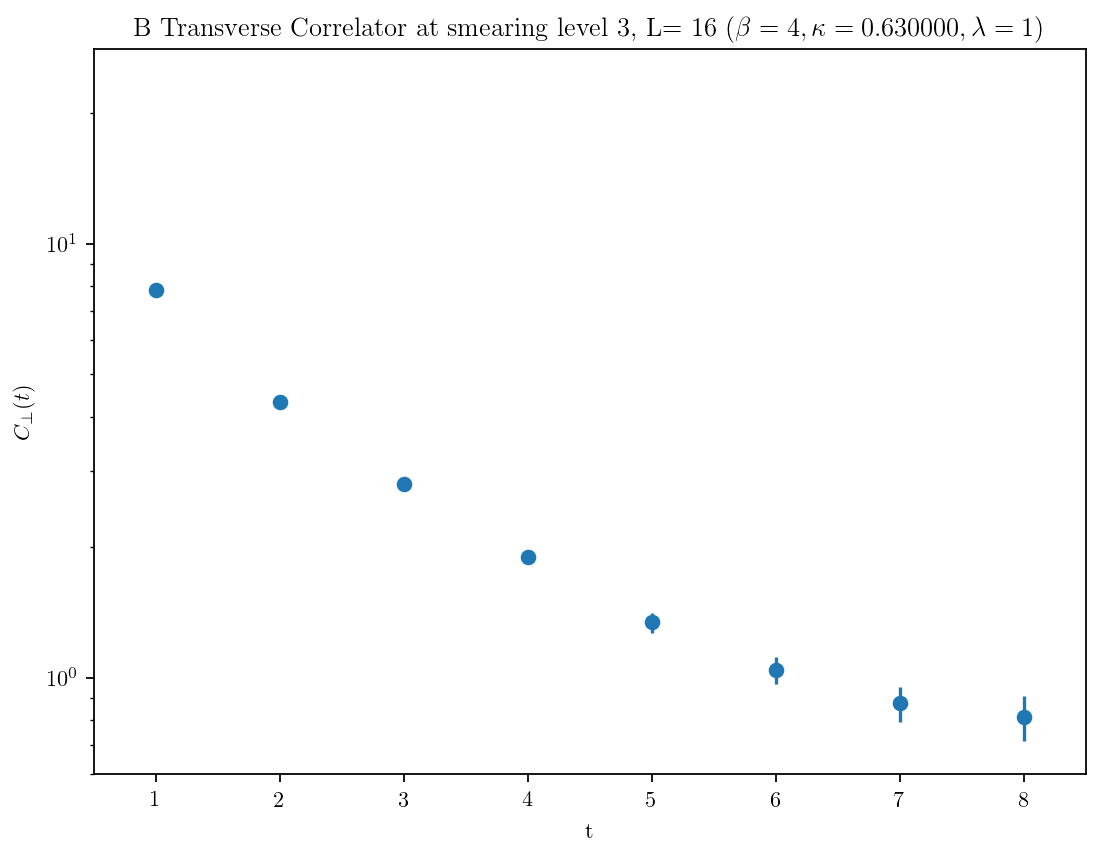

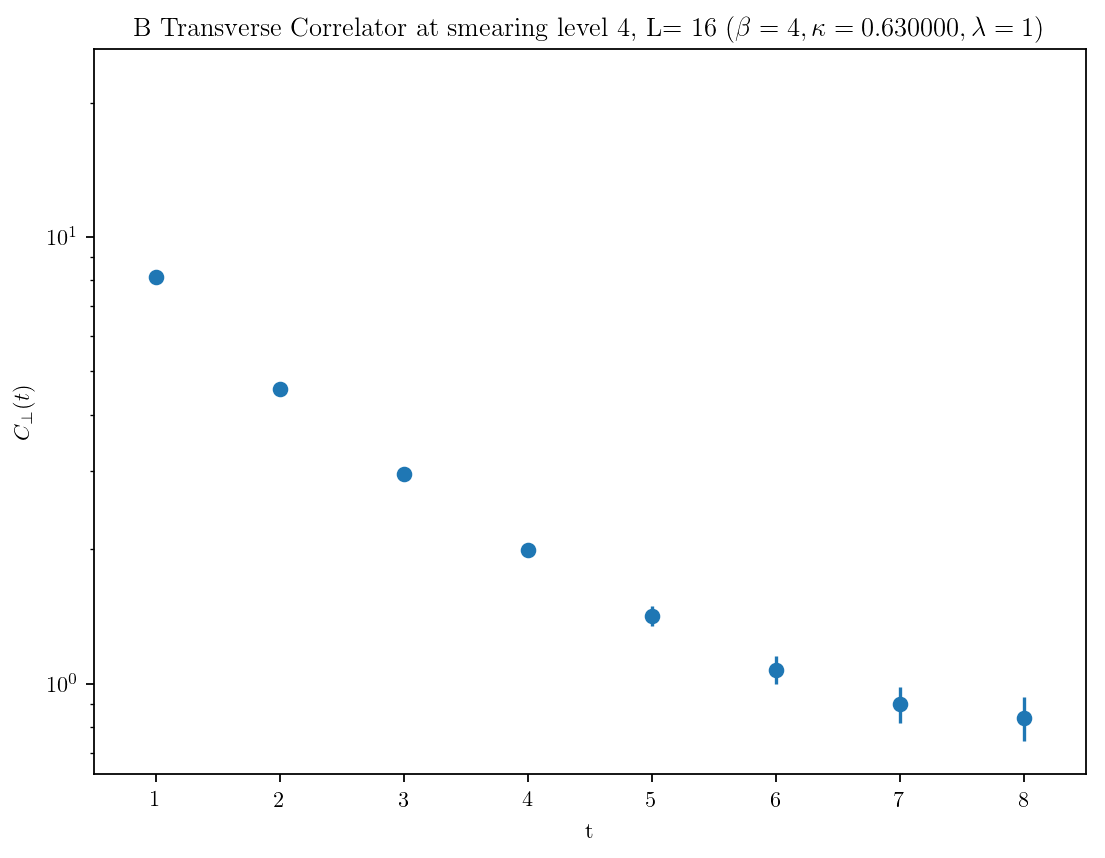

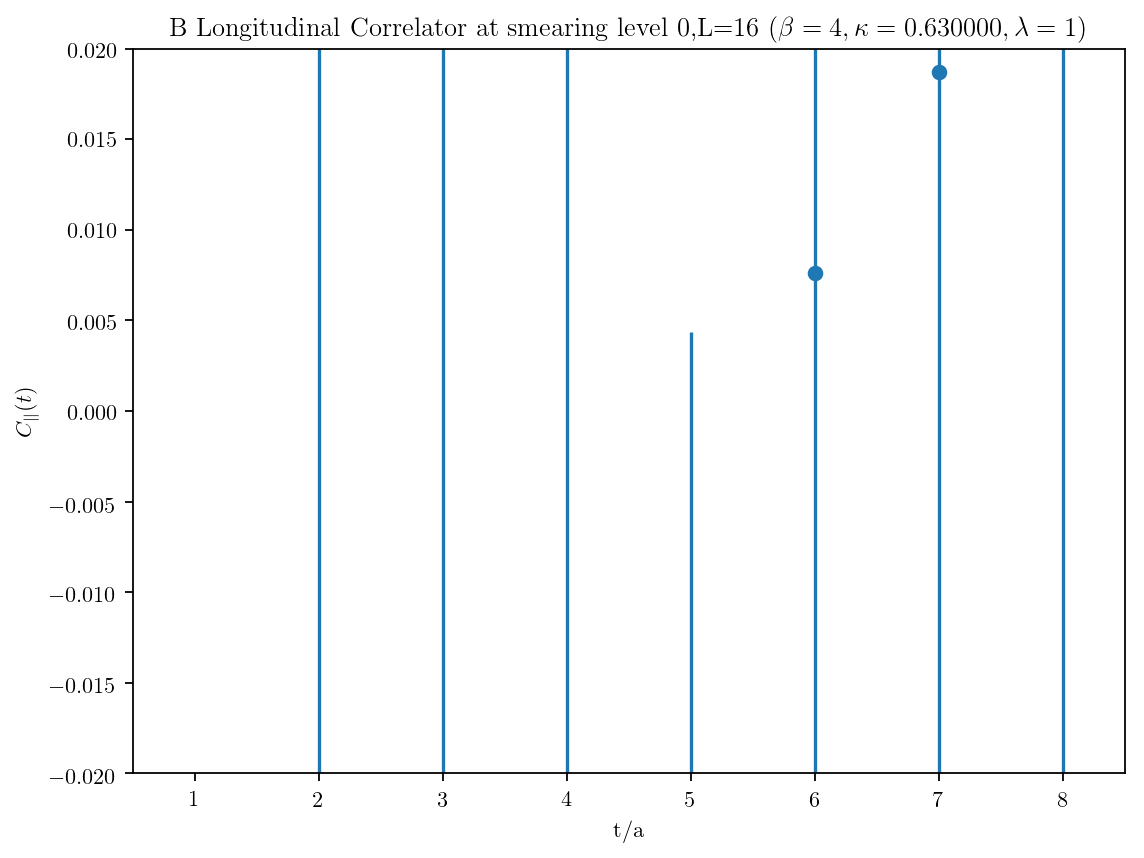

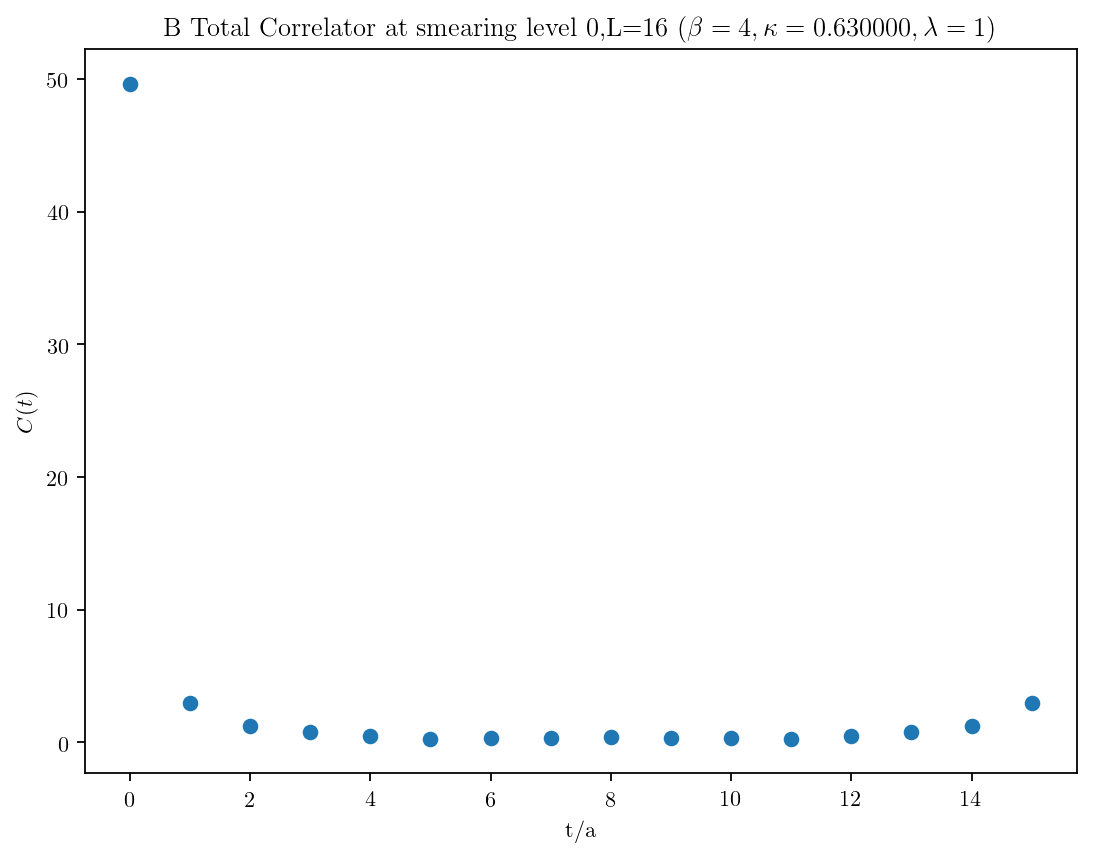

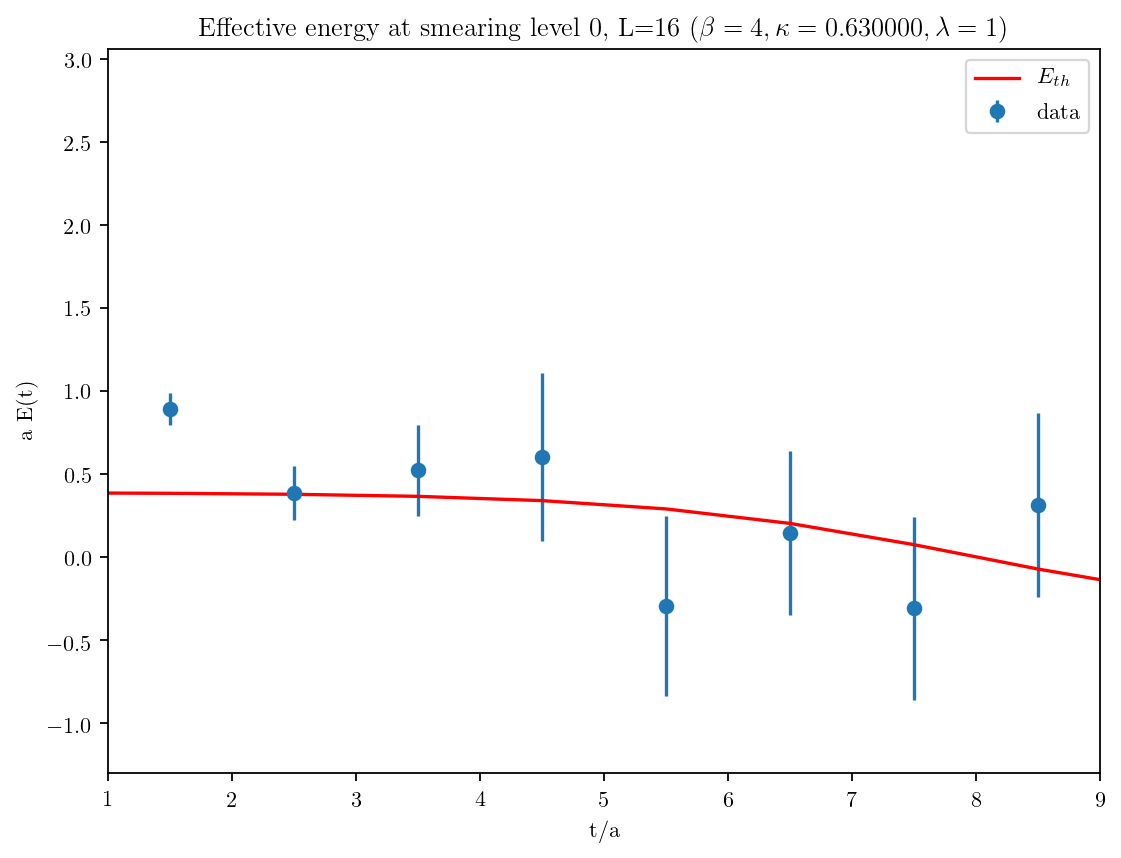

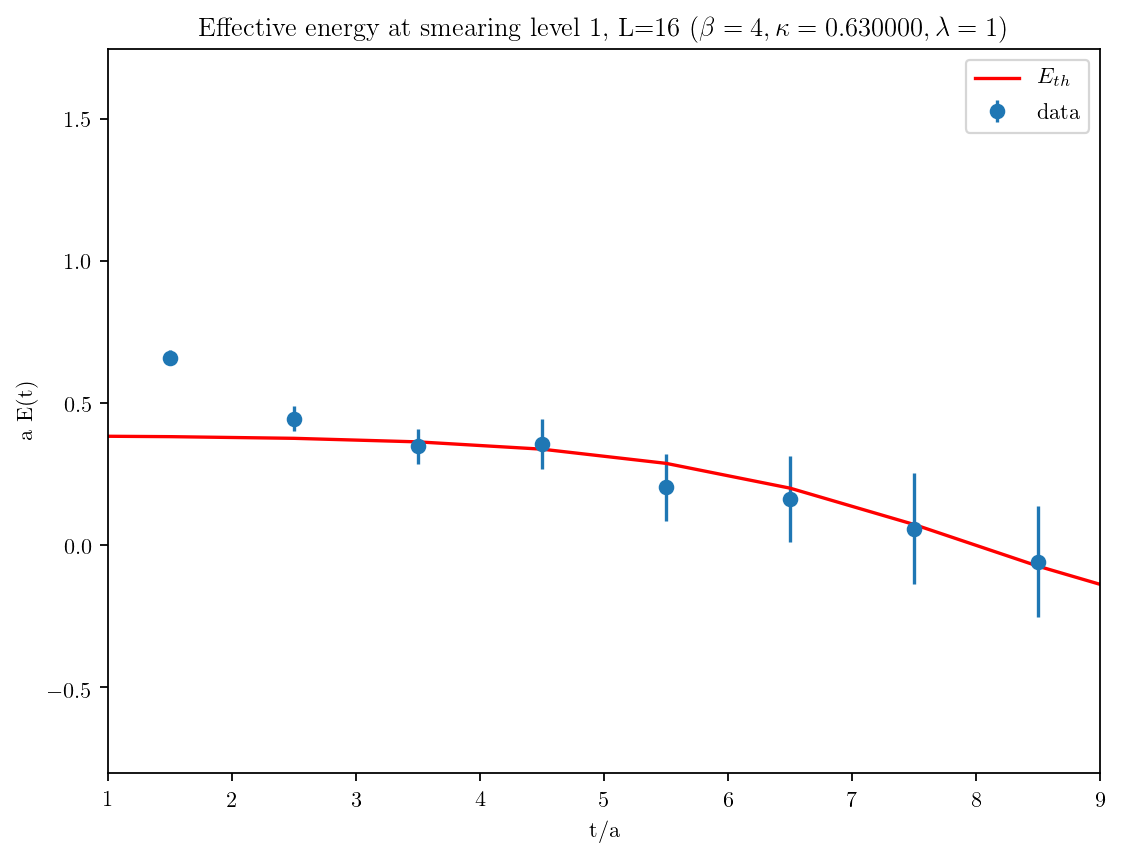

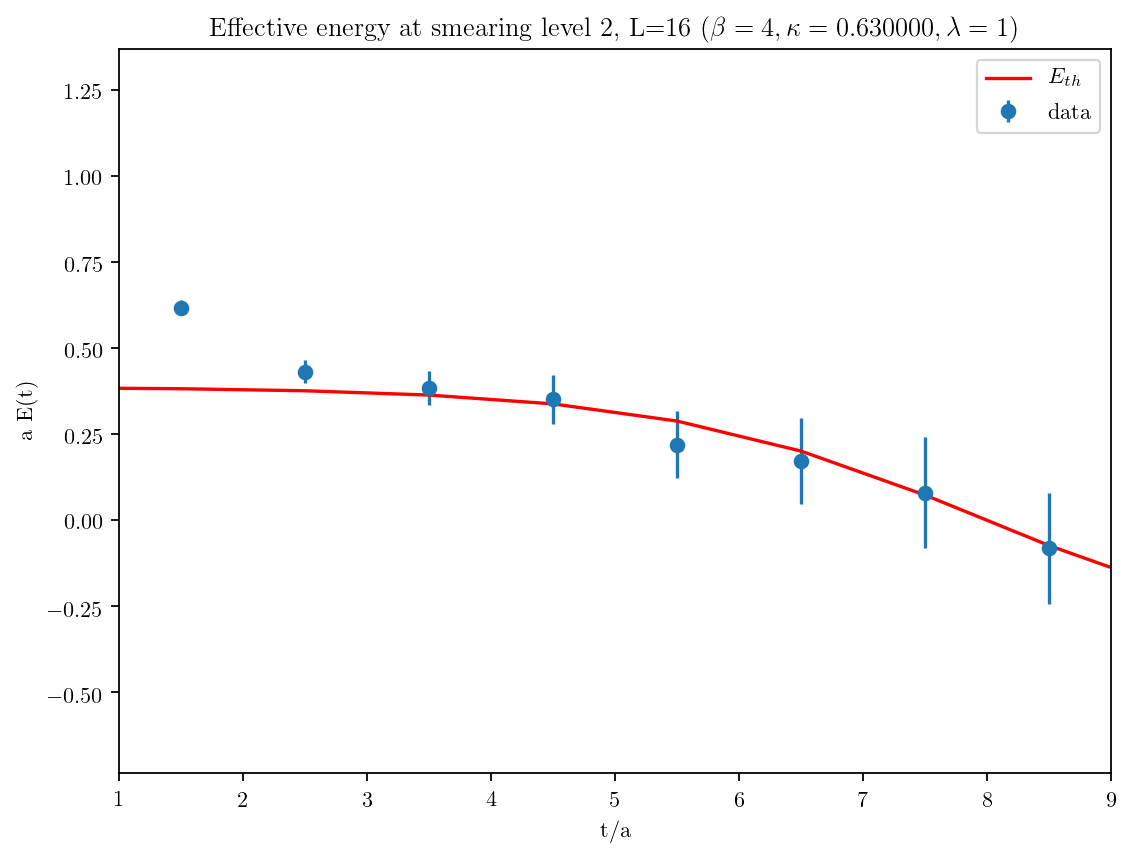

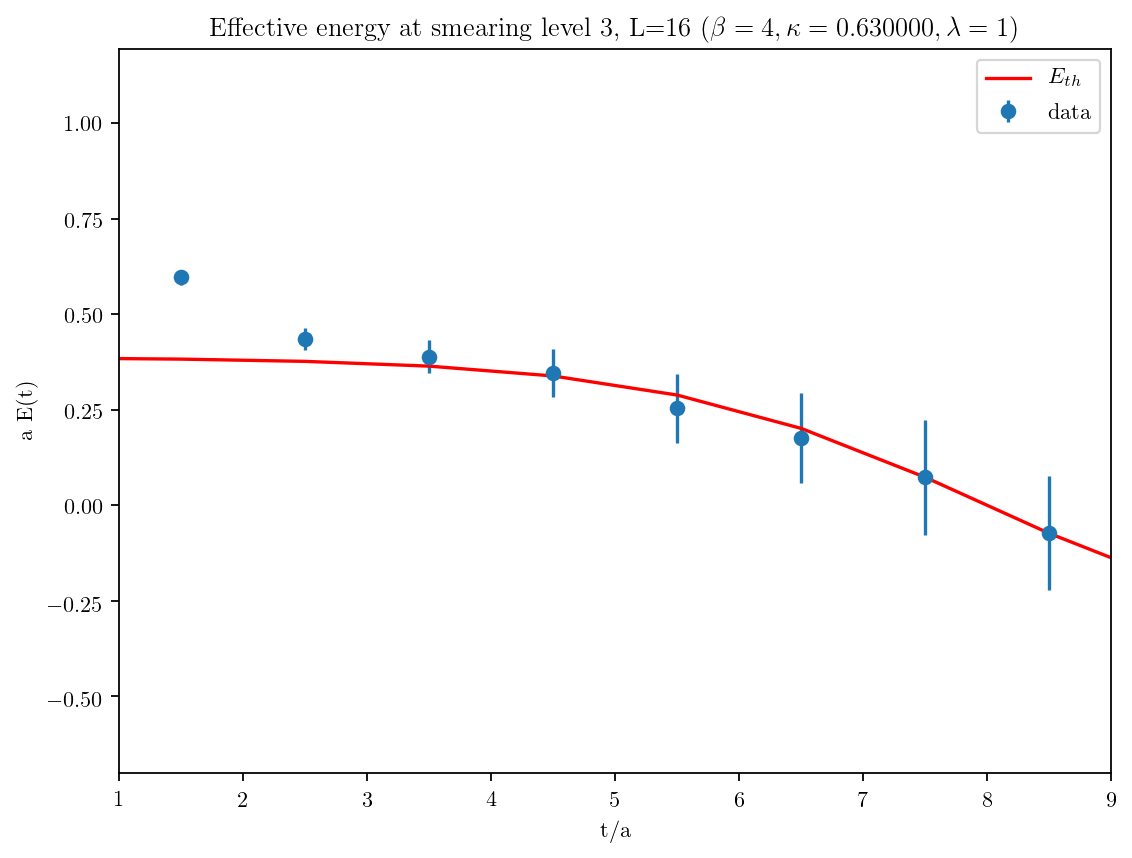

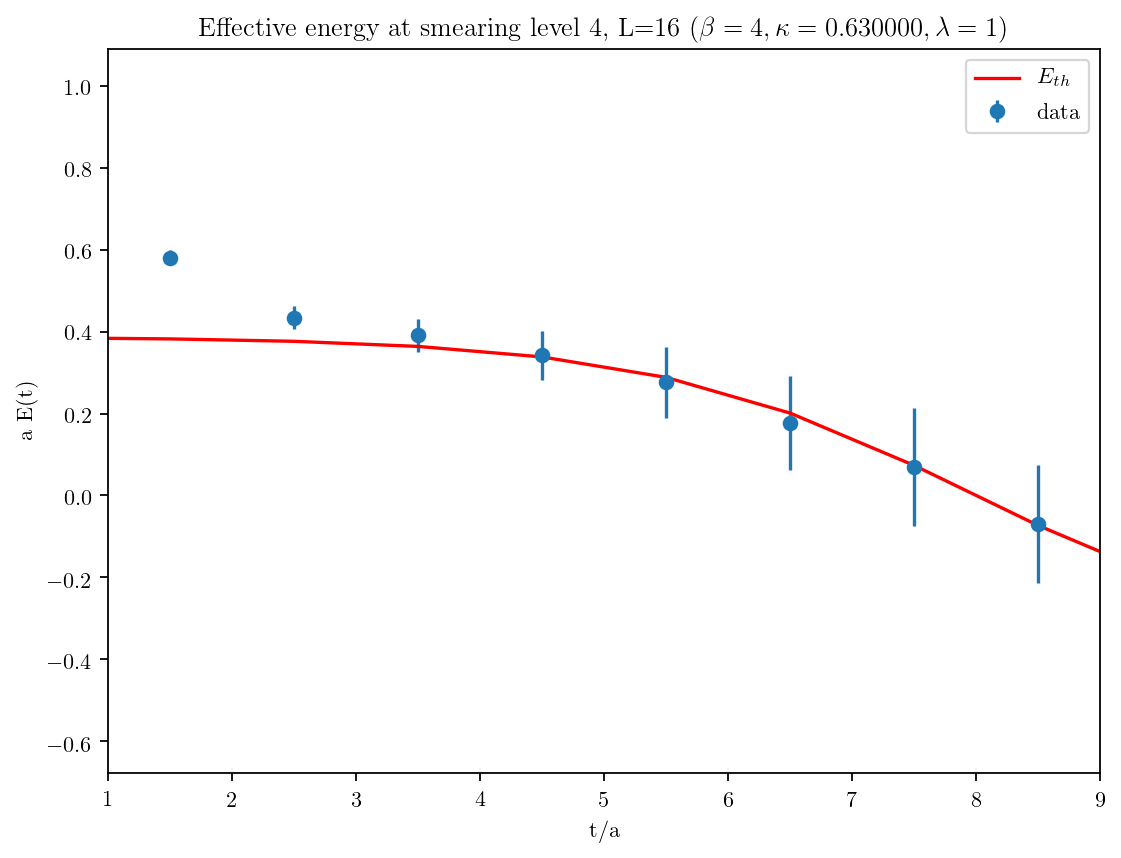

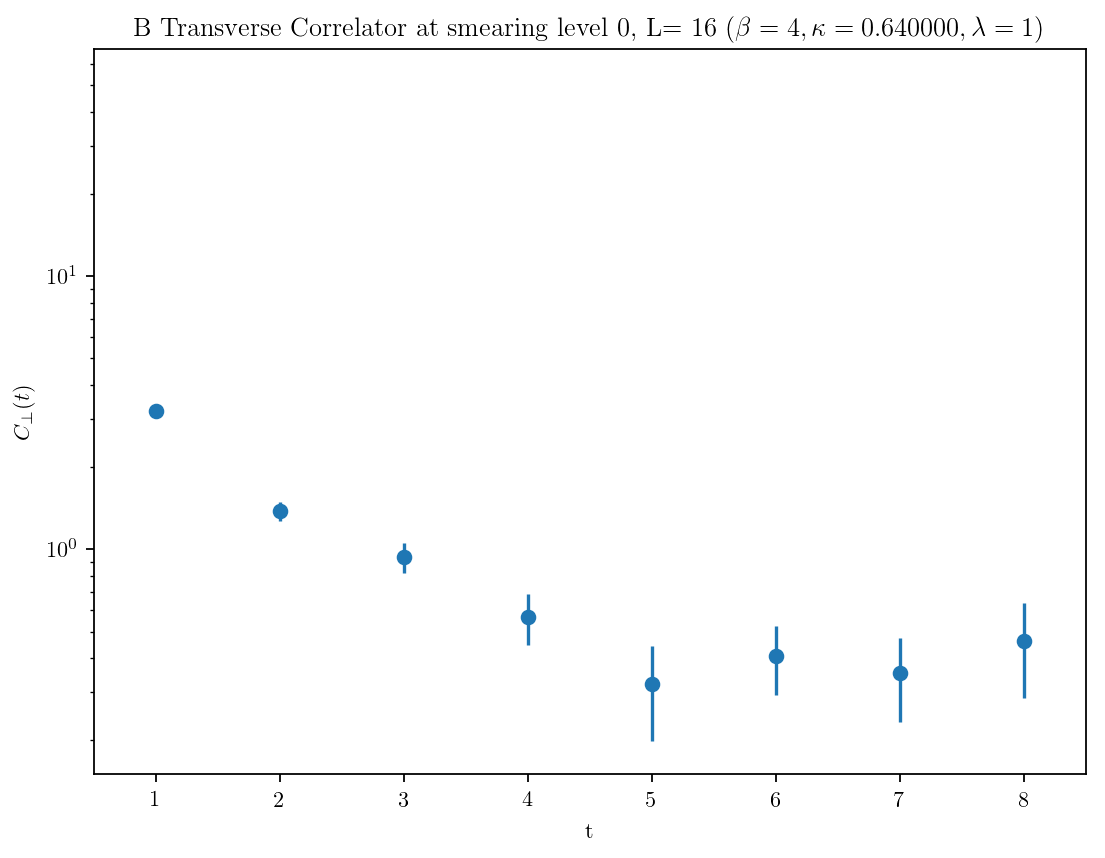

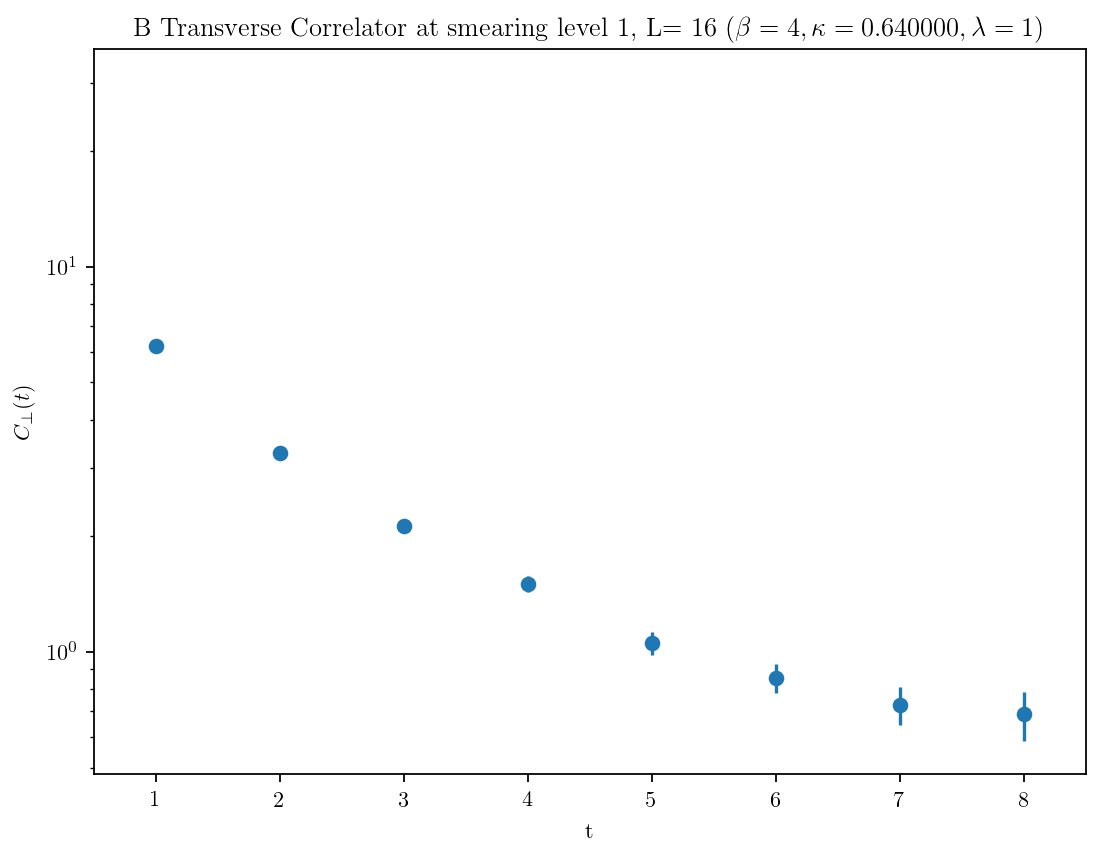

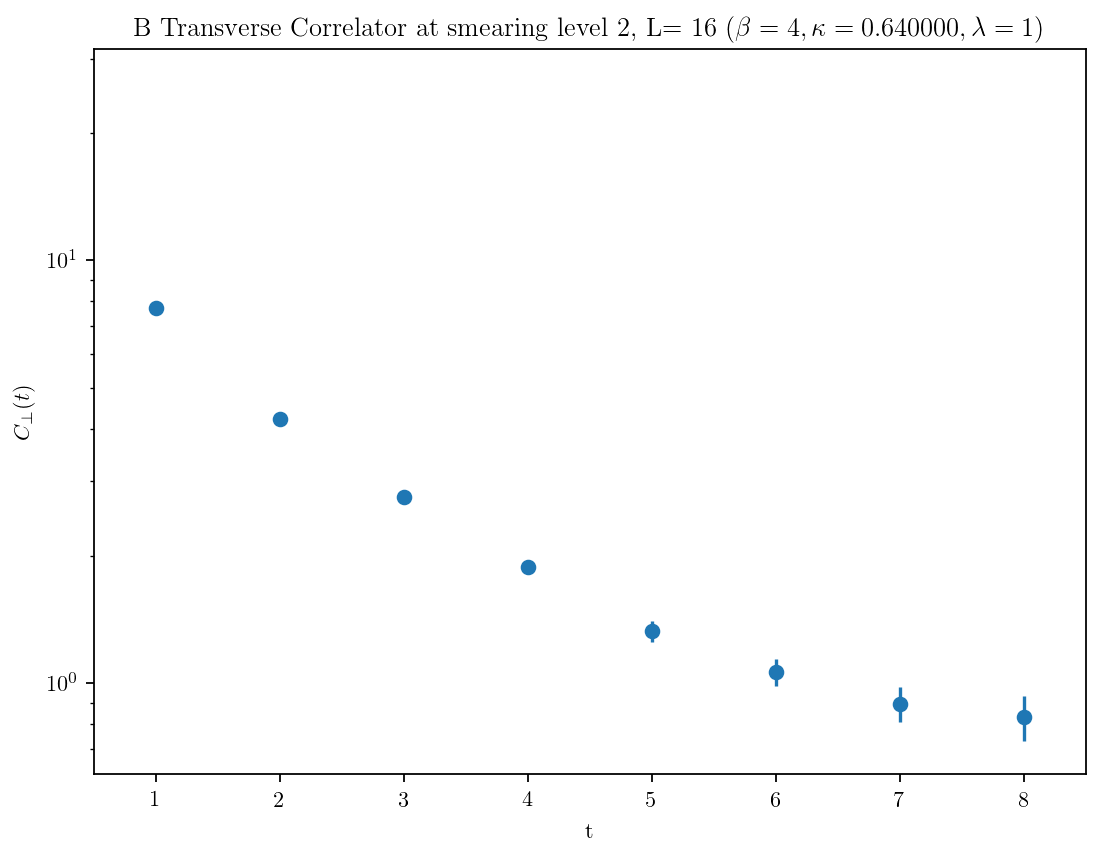

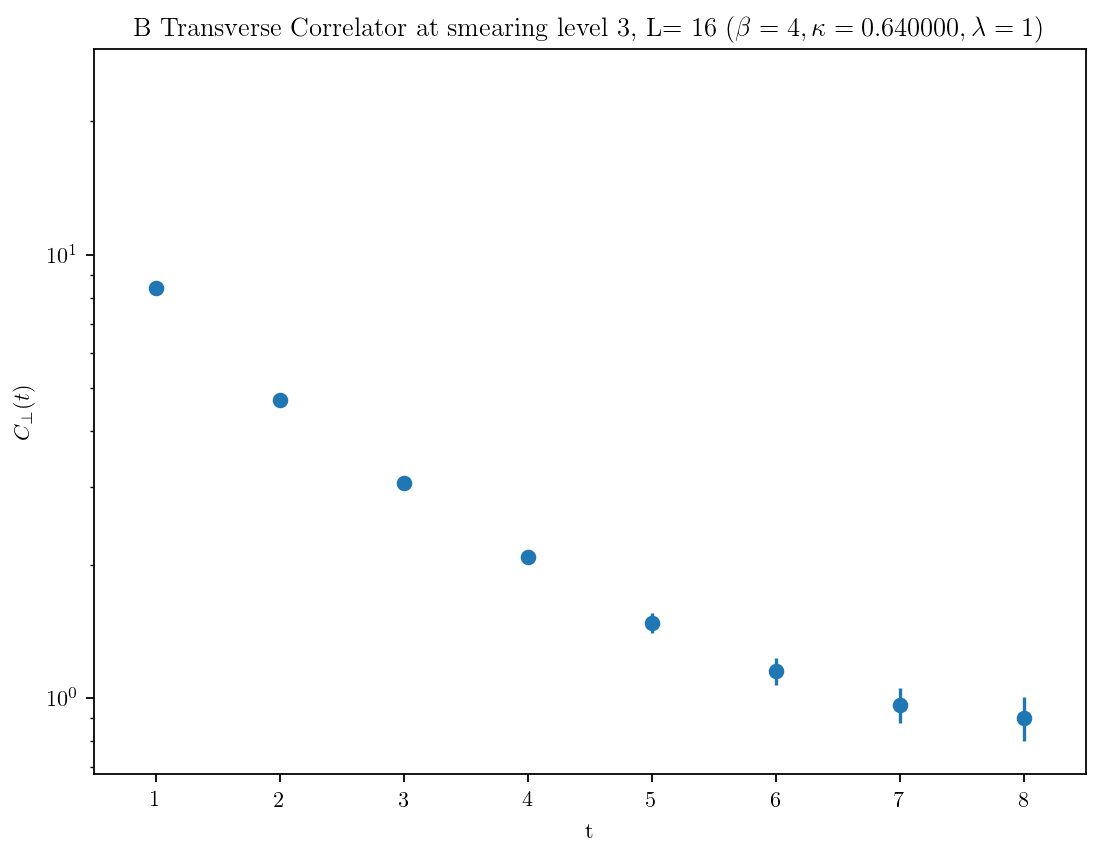

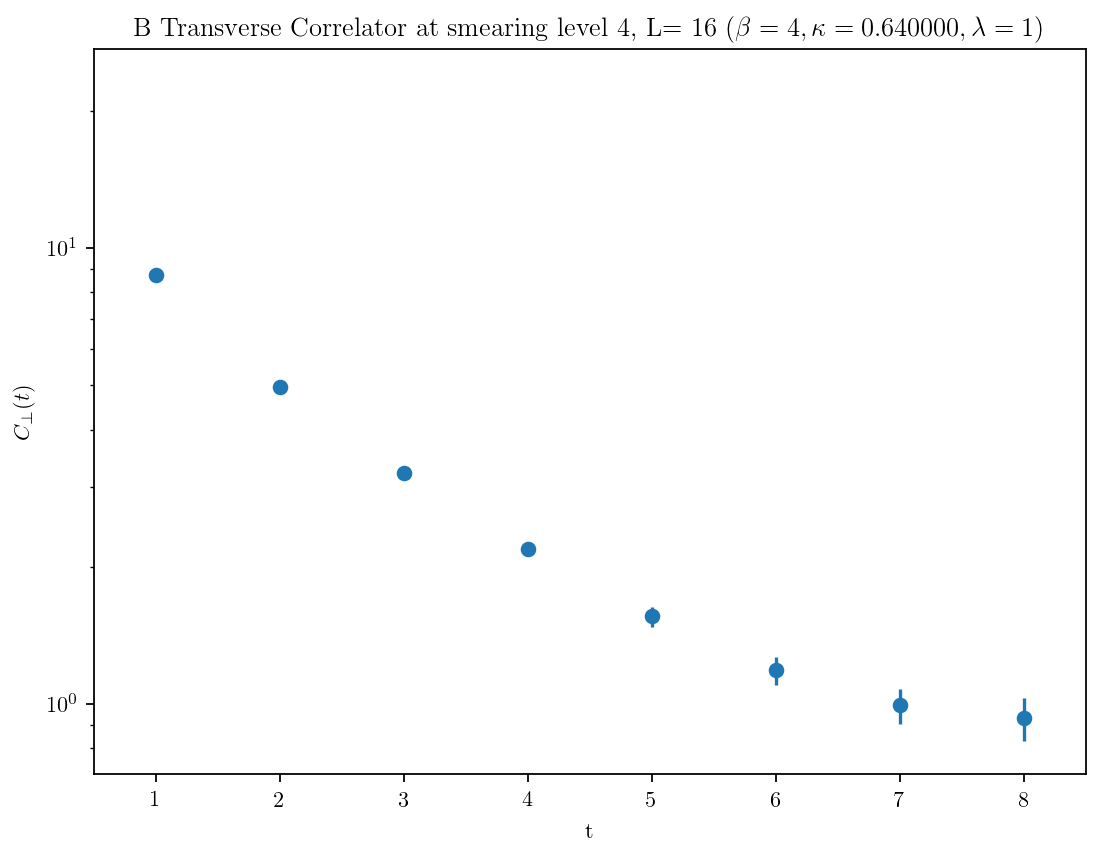

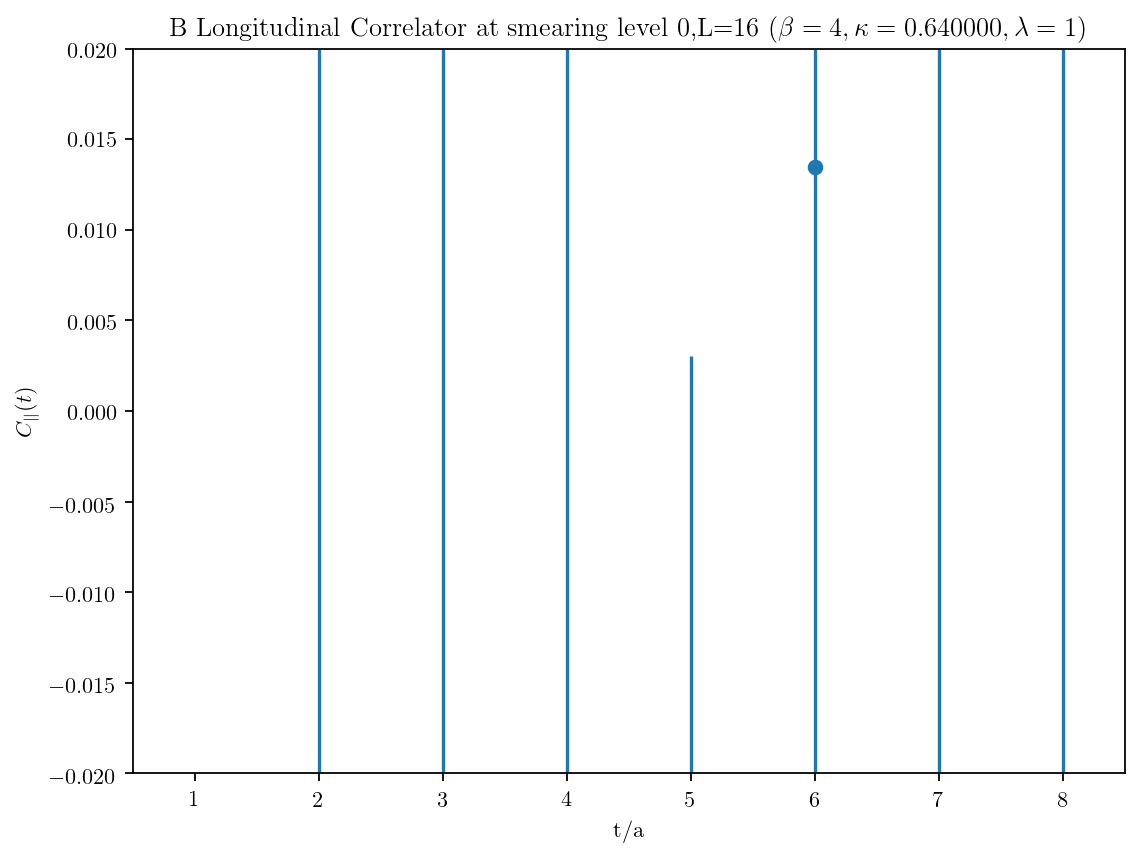

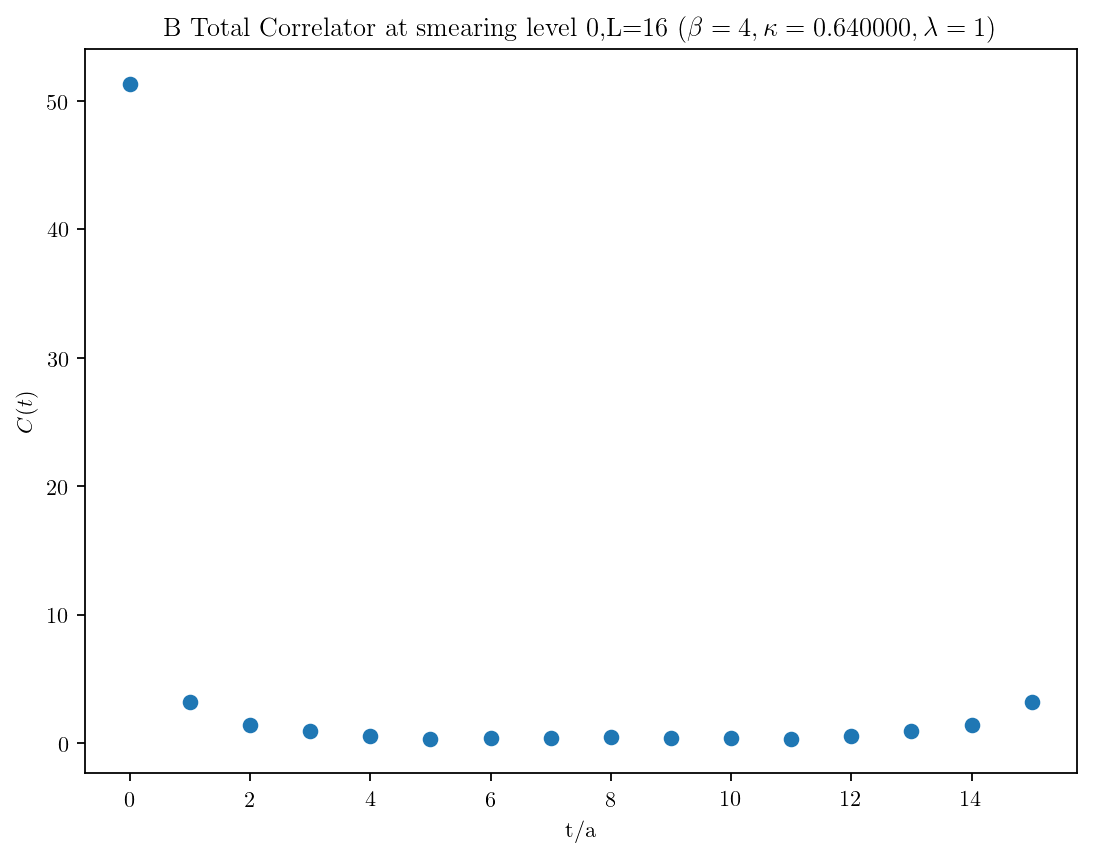

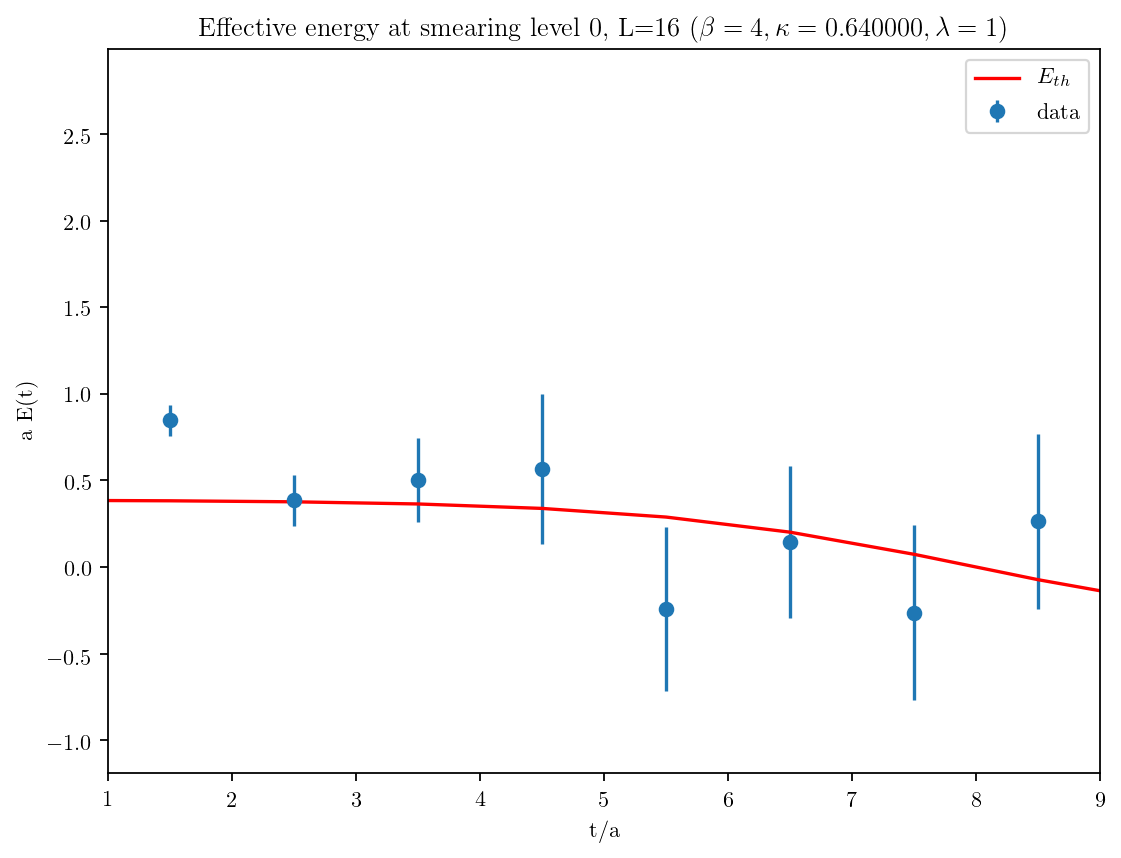

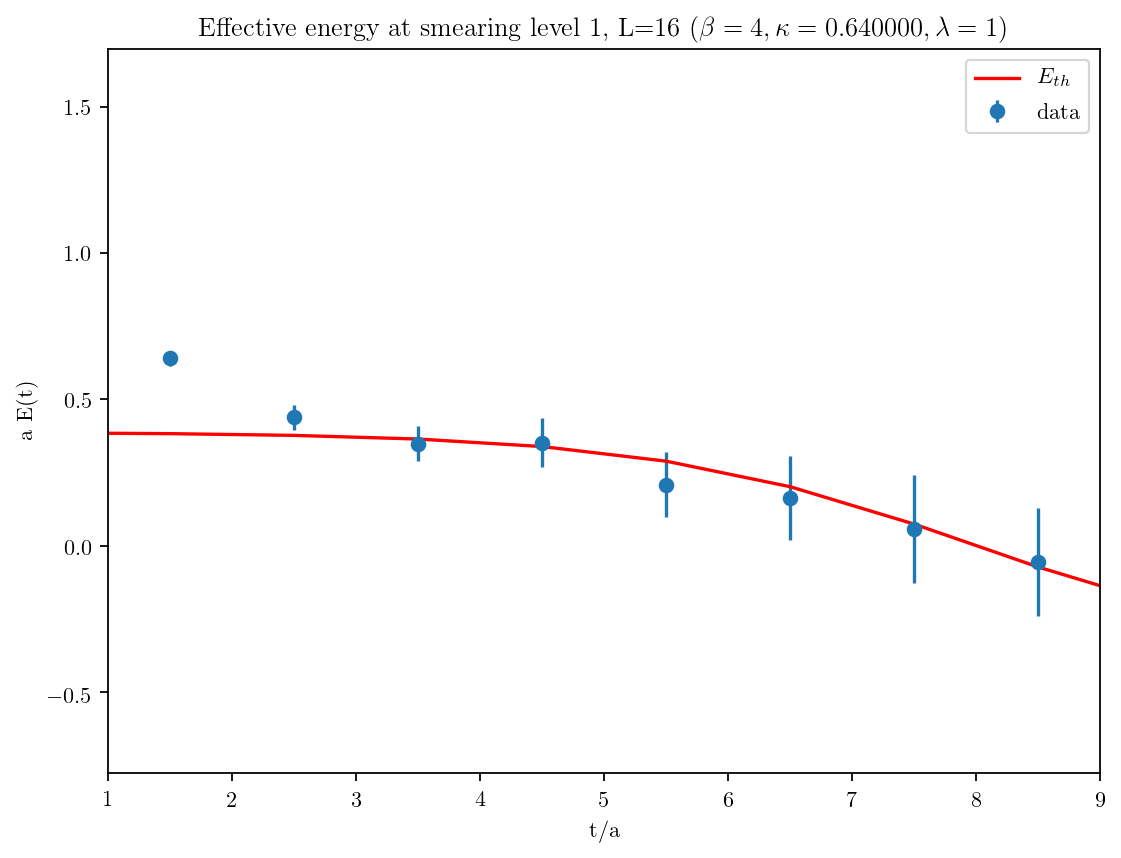

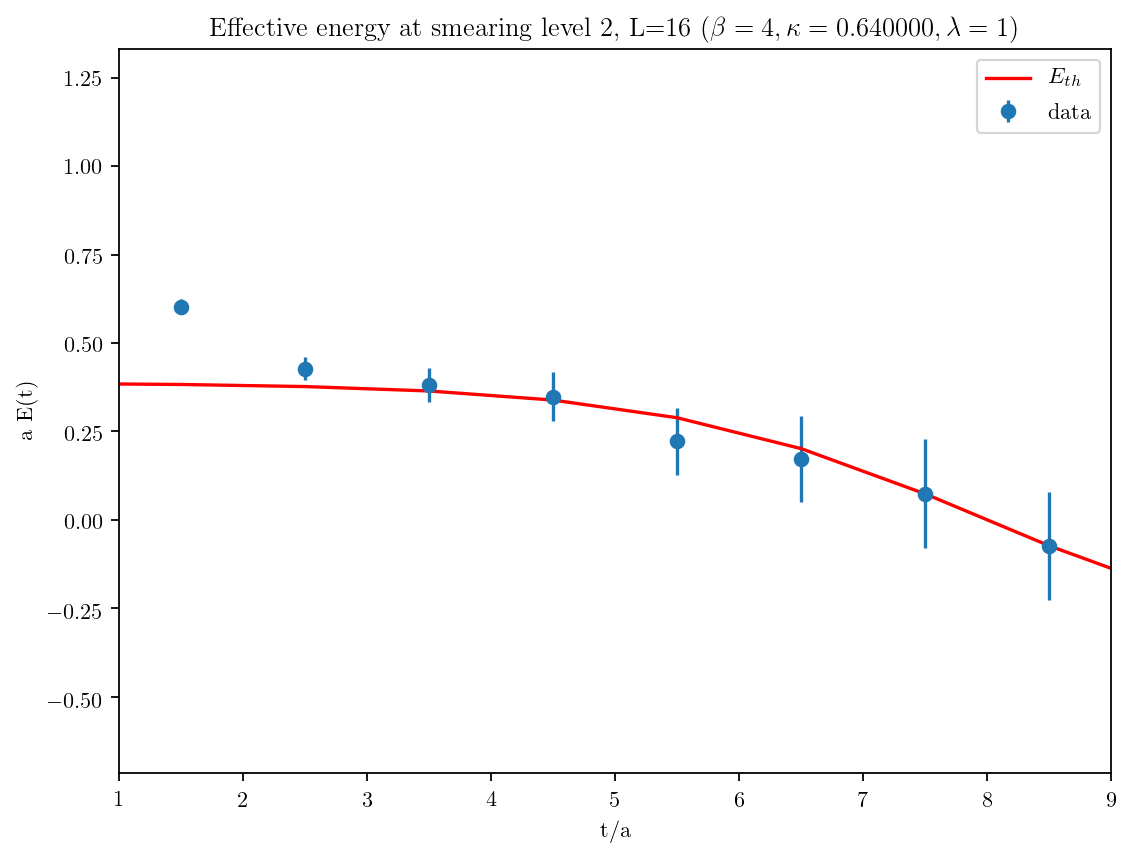

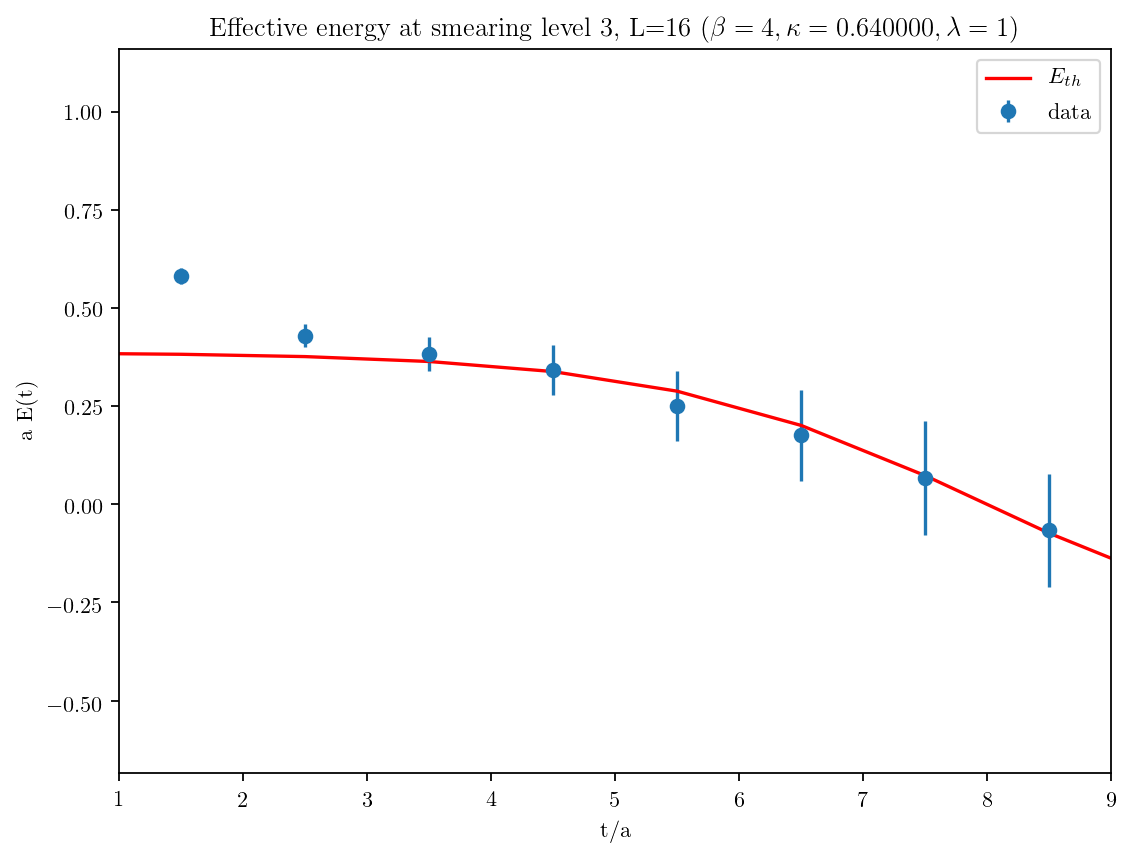

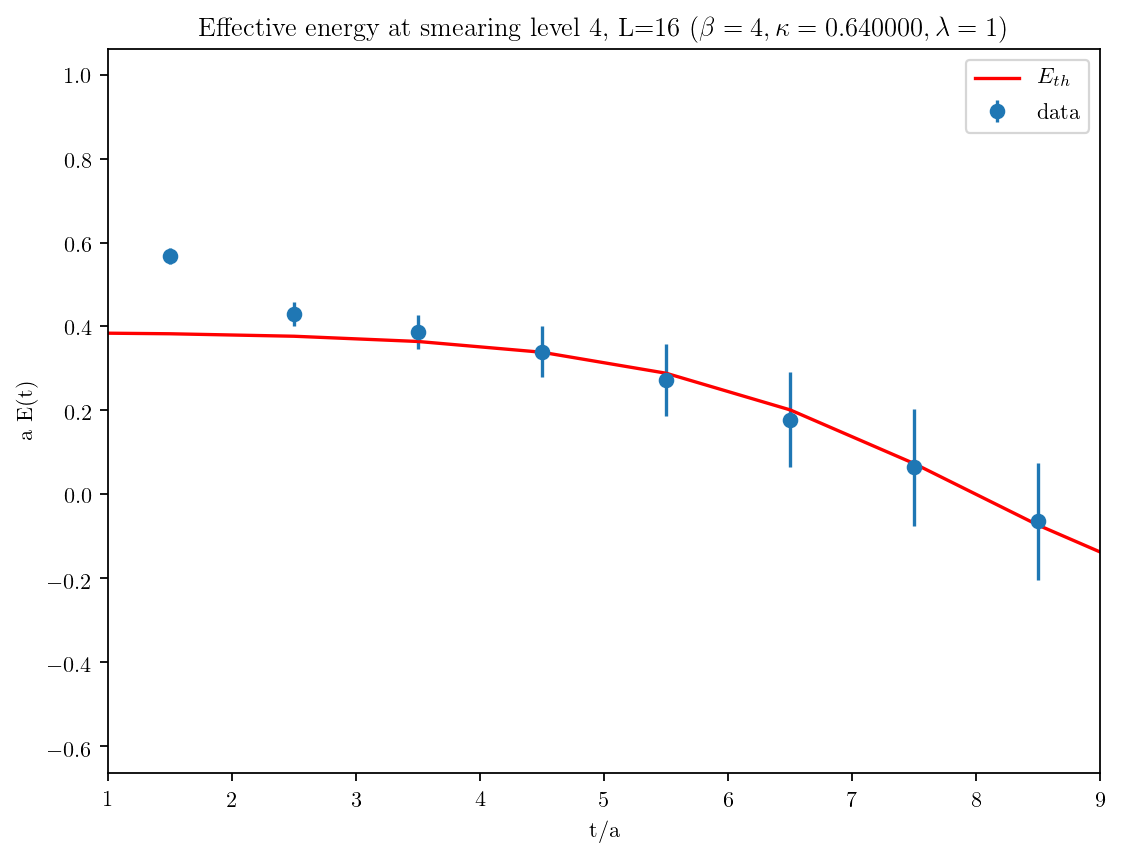

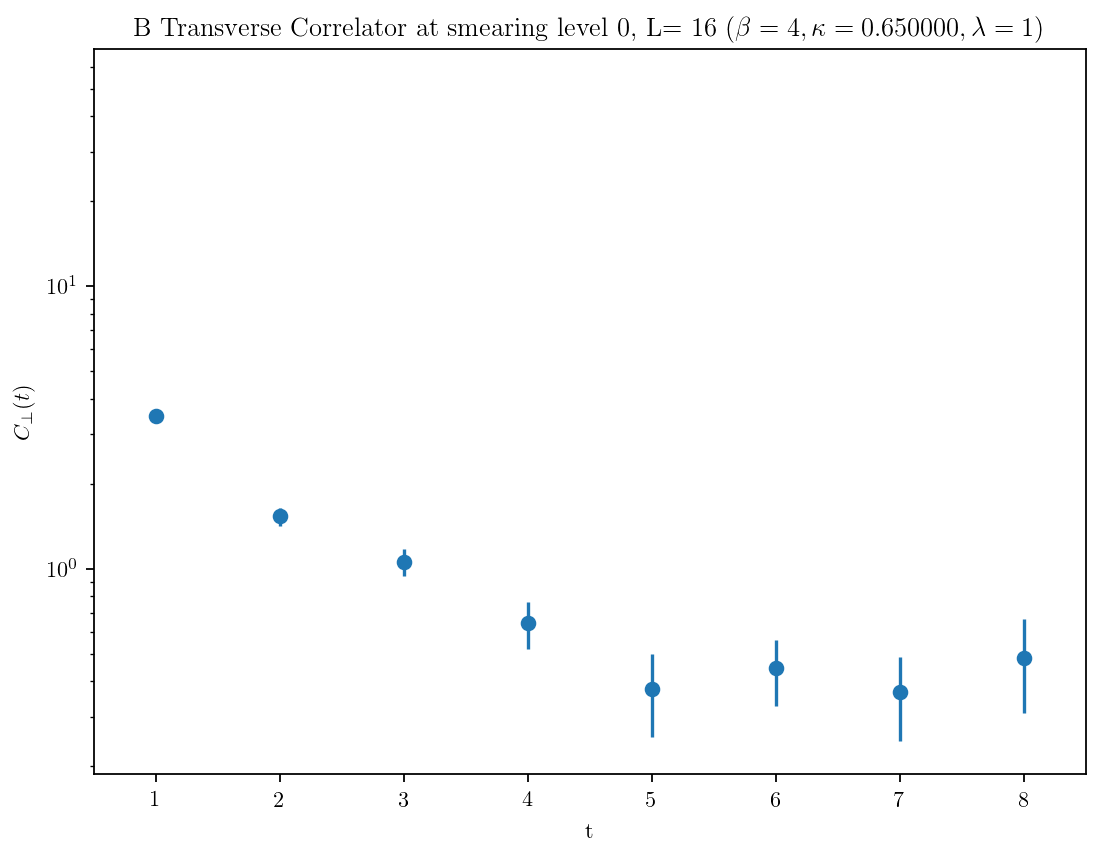

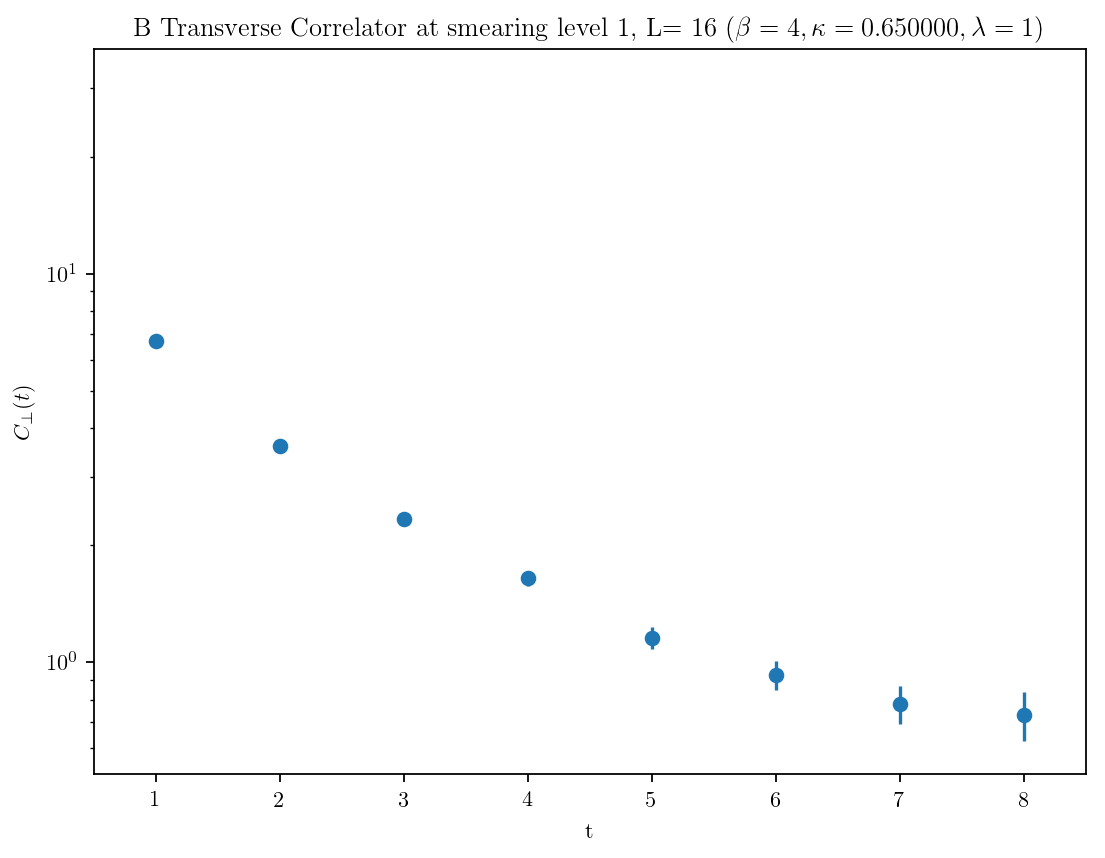

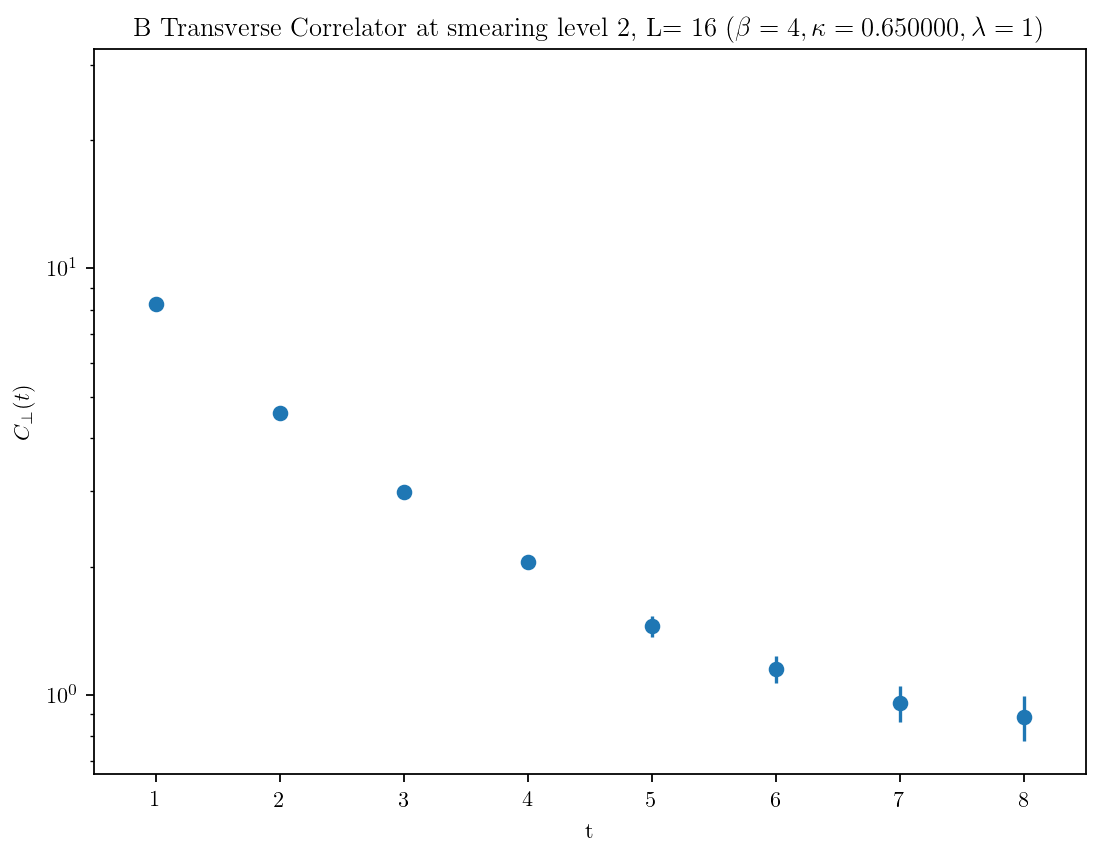

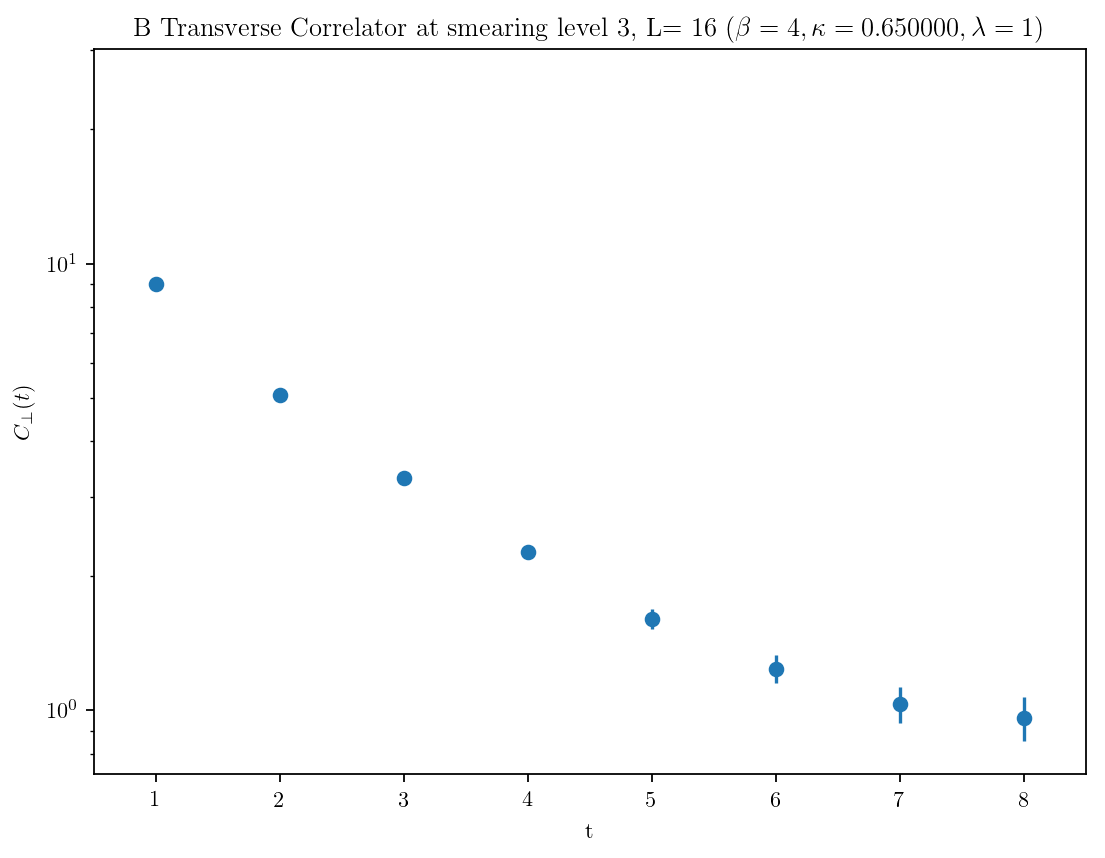

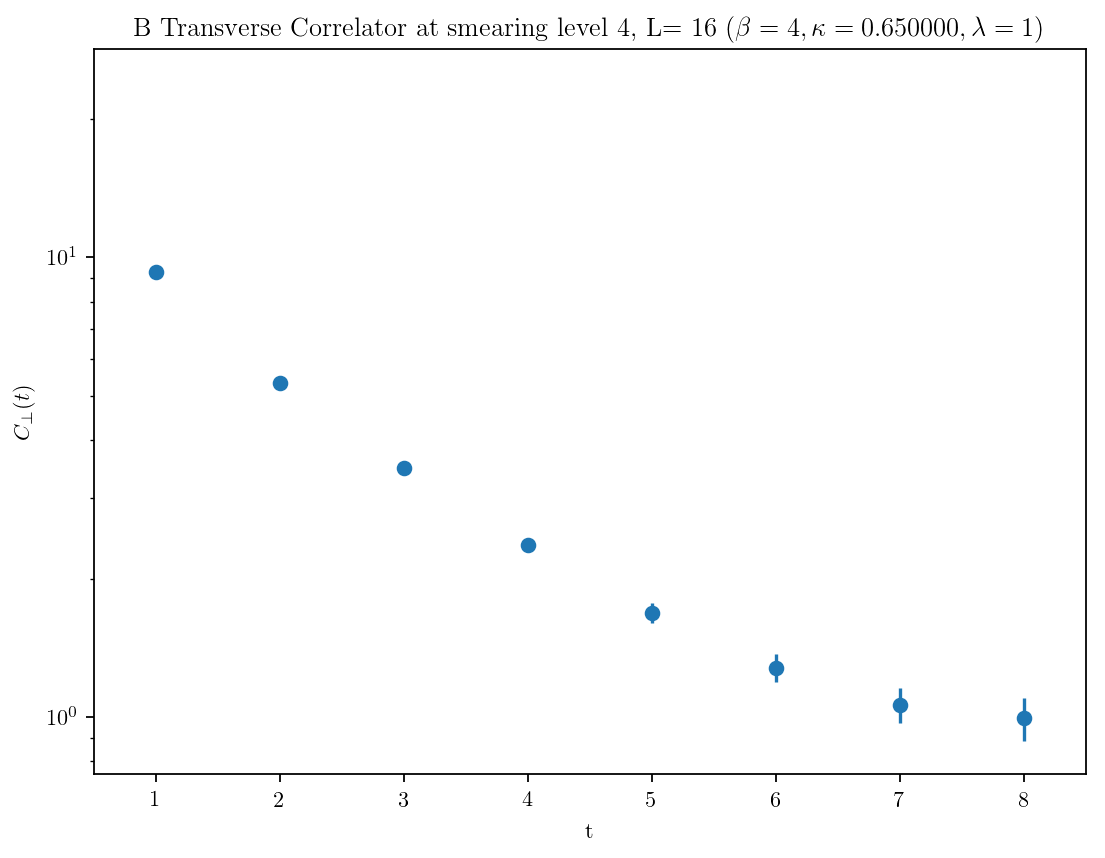

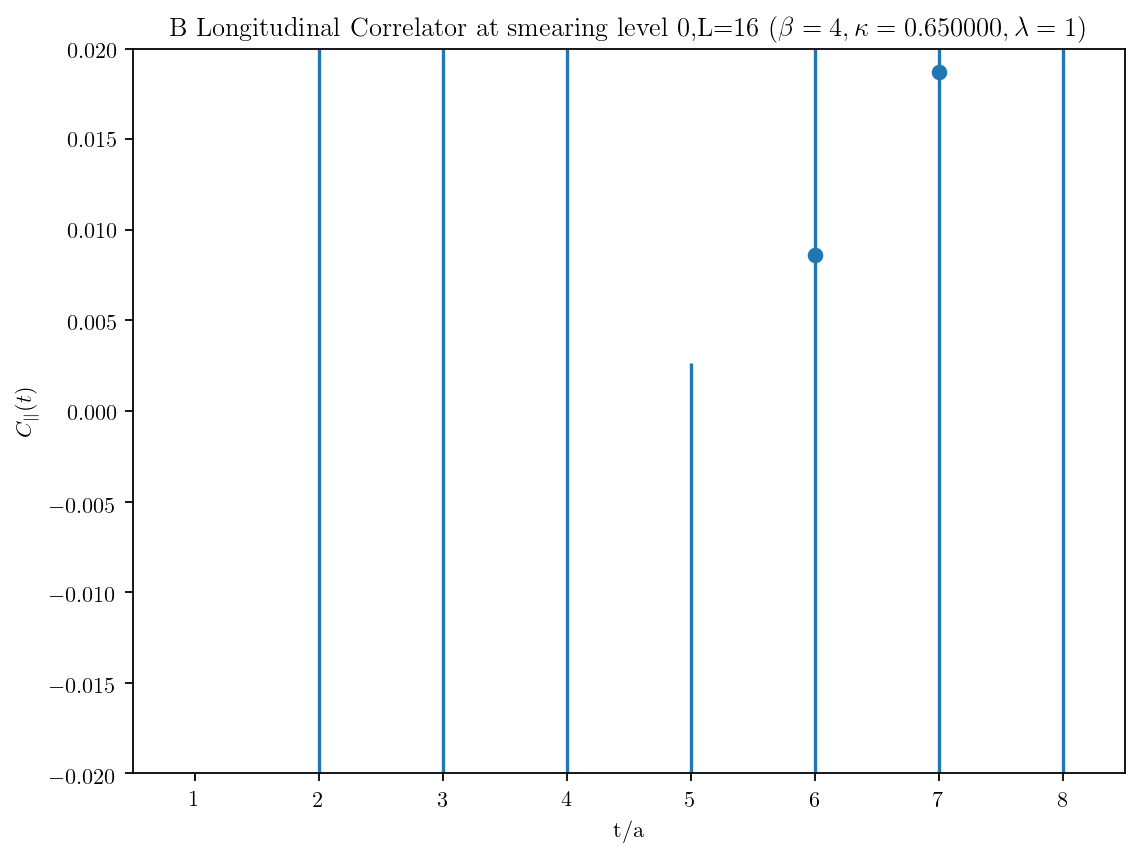

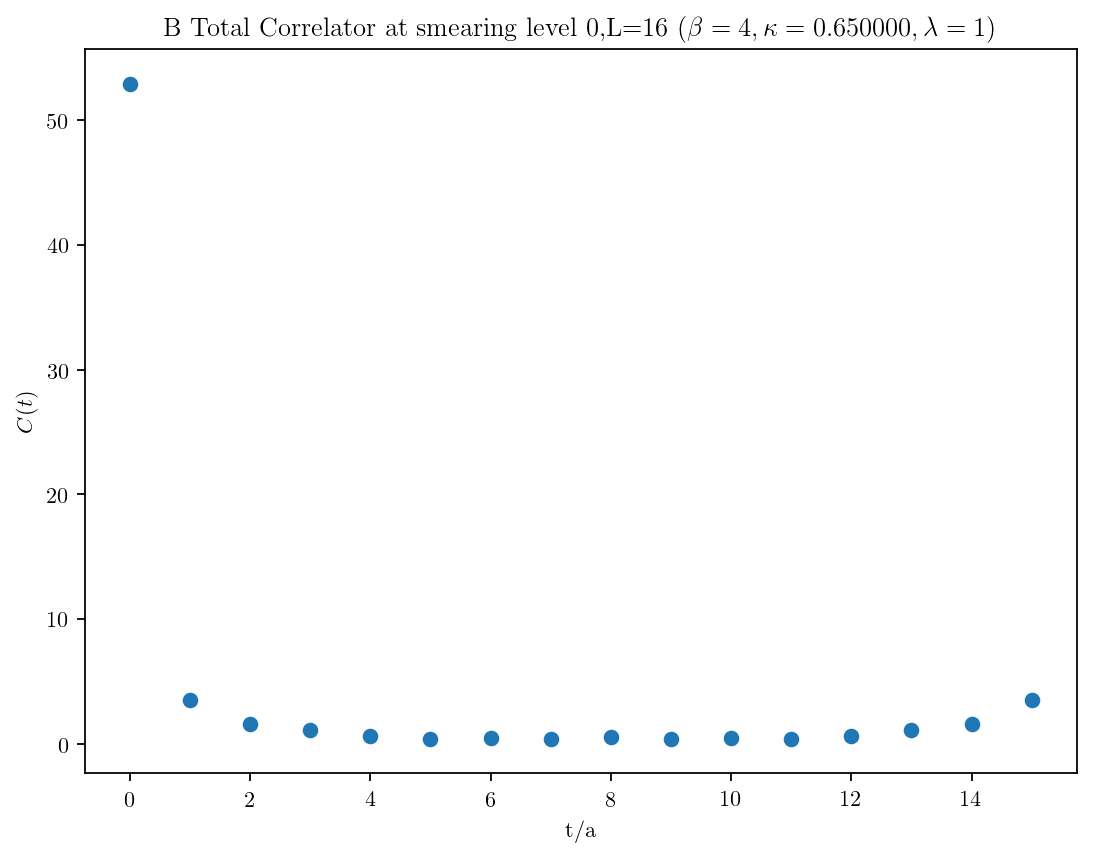

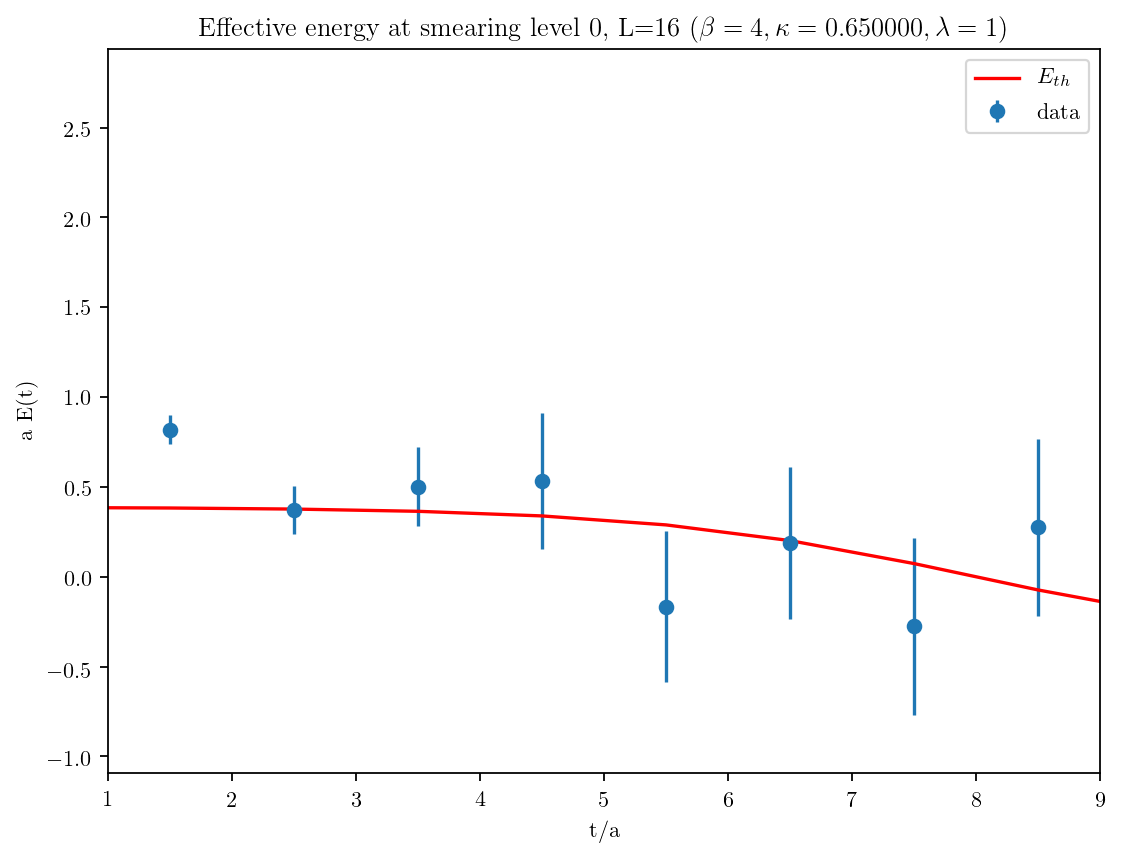

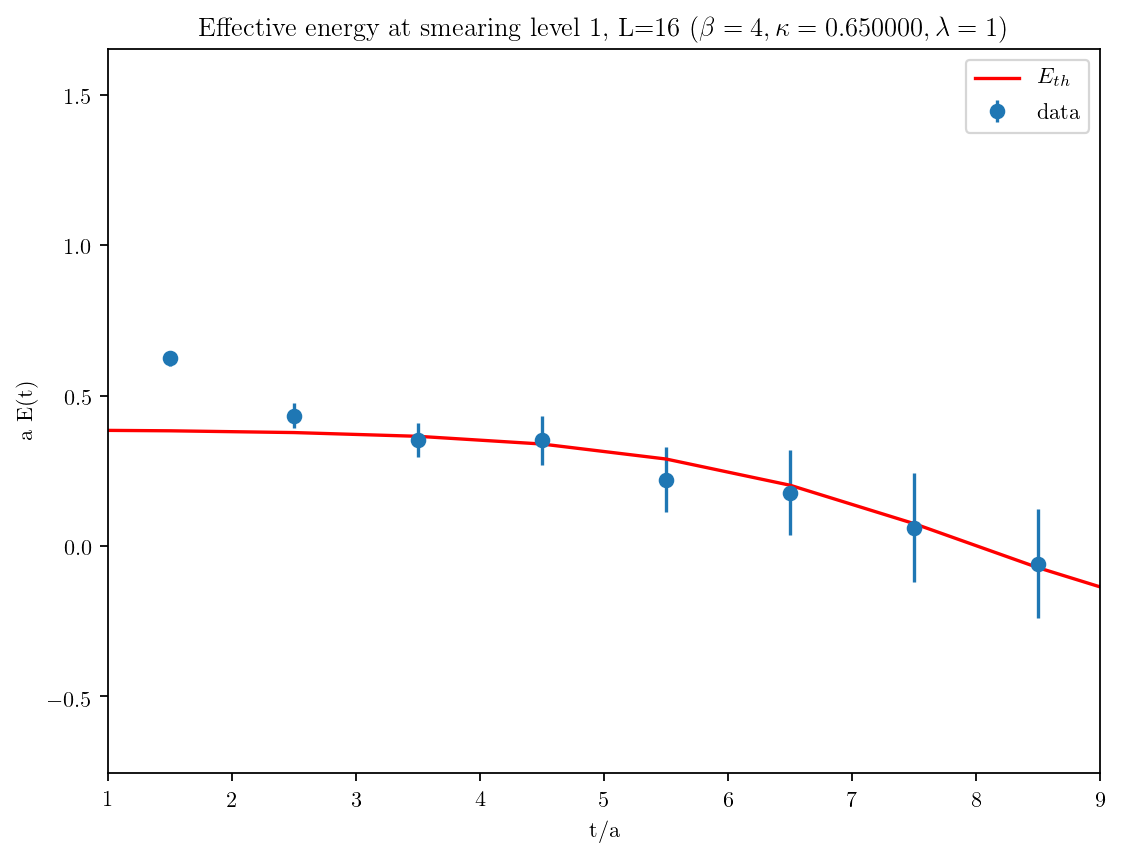

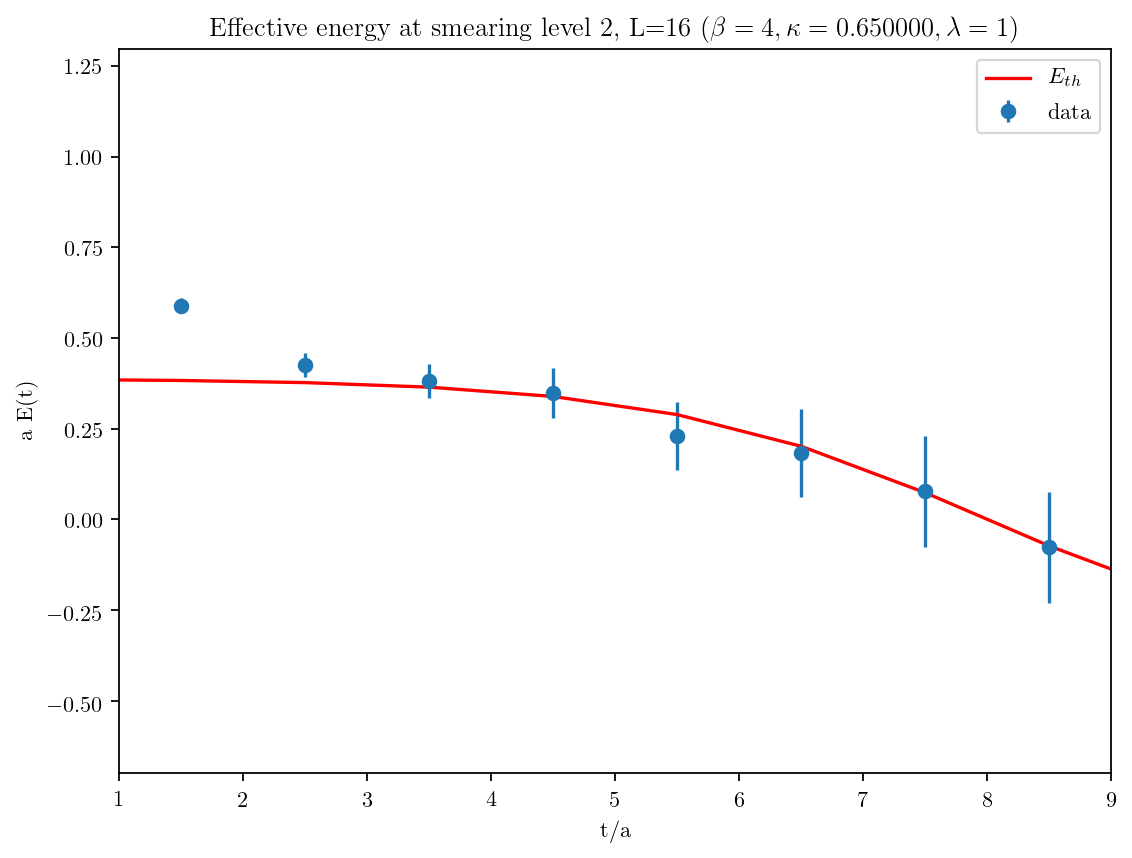

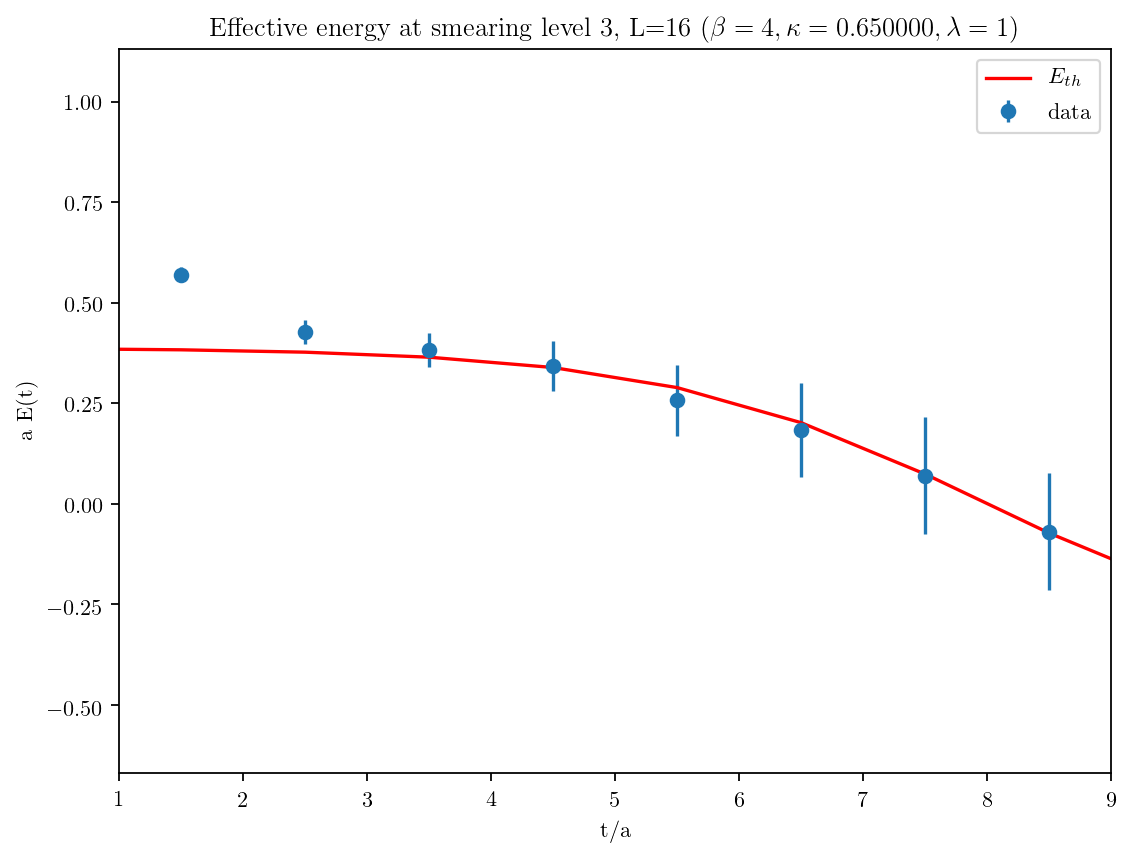

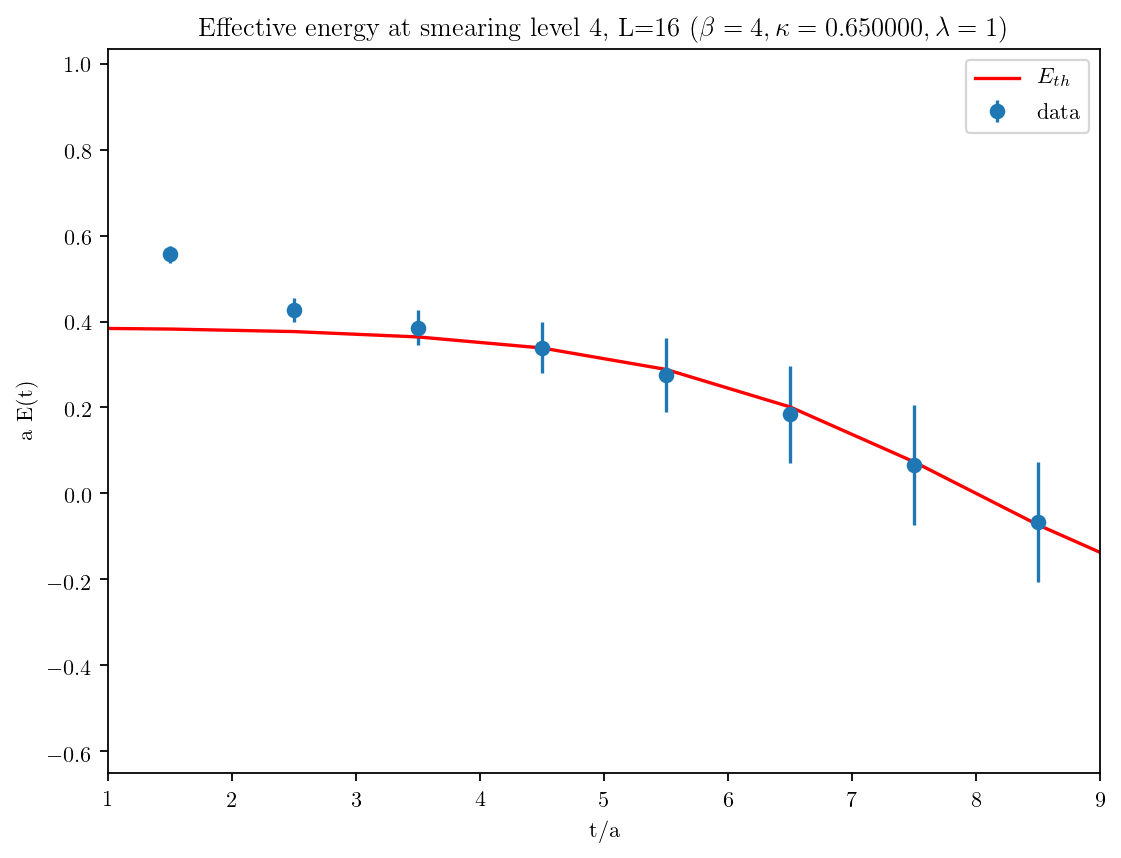

In [10]:
for k in range(21):
    kap = 0.45+k*0.01 
    analysis_plot(kap)

[array([4.09419056e+00, 6.08956259e-01, 4.88269327e-02, 2.26167890e-03,
       5.96143095e-05]), array([2.39913708e+00, 1.13676164e-02, 5.94096783e-04, 3.37595917e-05,
       8.60499105e-08]), array([ 1.60400051e+00, -1.66943878e-03,  3.47141244e-04,  5.32199650e-06,
        1.87156834e-07]), array([ 1.08986040e+00,  1.82179389e-03,  1.50696820e-05, -8.37507056e-06,
        1.63325057e-08]), array([ 7.40809780e-01, -1.08507369e-03,  1.42027154e-04,  1.11660946e-06,
       -4.02837295e-07]), array([ 5.17587017e-01,  3.50929767e-03, -9.03060958e-05, -3.02891907e-06,
       -1.94862083e-07]), array([ 3.85109901e-01, -4.52719468e-04, -4.52719468e-04,  1.04583819e-05,
        8.50661613e-08]), array([ 2.97426497e-01, -1.33195435e-03,  4.15963254e-05, -1.57279814e-05,
       -5.38512801e-07]), array([ 2.71194252e-01, -2.30171263e-03, -3.30450434e-05, -1.68082281e-06,
        8.70335385e-07]), array([ 2.97426497e-01, -1.33195435e-03,  4.15963254e-05, -1.57279814e-05,
       -5.38512801e-07]),

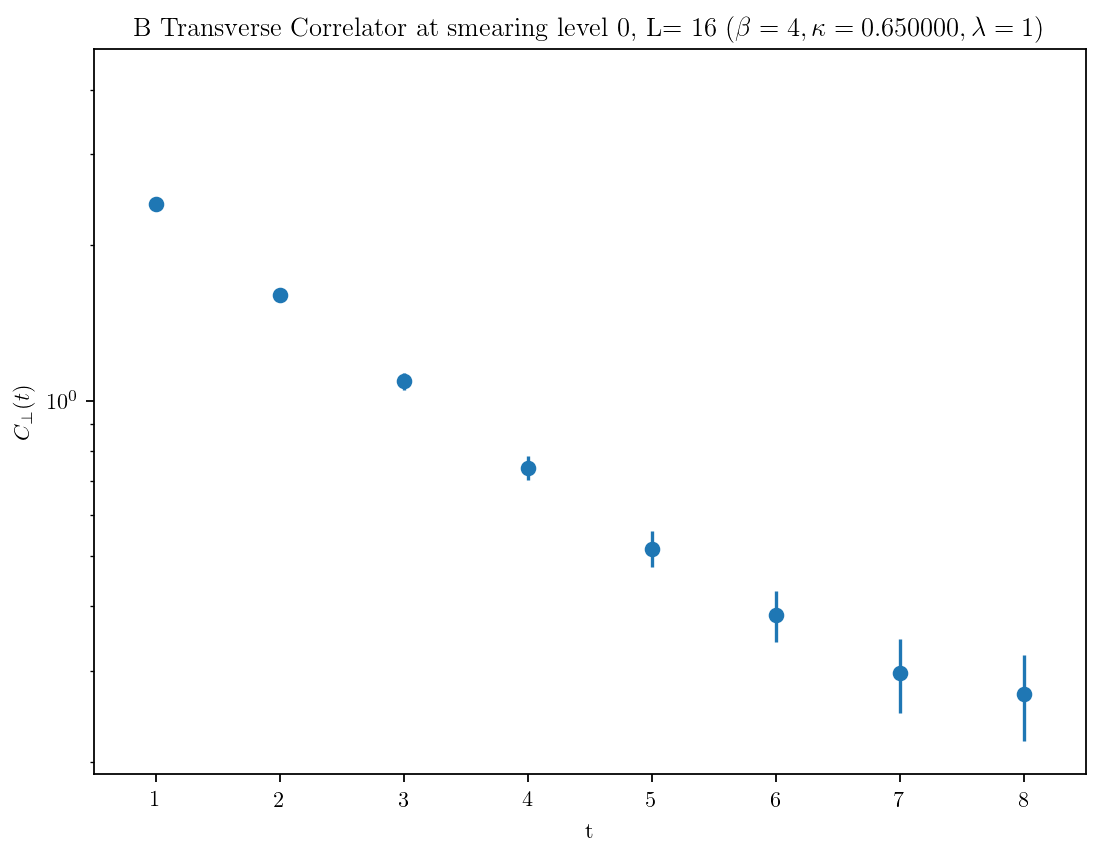

0.6089562590774892
0.6089562590774892
0.0024125324065842994
0.0024125324065842994
0.01136761636087149
0.01136761636087149
0.0013319317339921463
0.0013319317339921463
-0.001669438782520139
-0.001669438782520139
0.0010768788755357215
0.0010768788755357215
0.0018217938867016415
0.0018217938867016415
0.0008437088400905254
0.0008437088400905254
-0.0010850736924450702
-0.0010850736924450702
0.0007100861347774446
0.0007100861347774446
0.003509297668348151
0.003509297668348151
0.000874495070126952
0.000874495070126952
-0.0004527194684650502
-0.0004527194684650502
0.0009059088328487582
0.0009059088328487582
-0.0013319543514489628
-0.0013319543514489628
0.0015542437194664136
0.0015542437194664136
-0.0023017126317524303
-0.0023017126317524303
0.00239744555749226
0.00239744555749226
-0.0013319543514489992
-0.0013319543514489992
0.0015542437194664156
0.0015542437194664156
-0.0004527194684650445
-0.0004527194684650445
0.000905908832848755
0.000905908832848755
0.0035092976683481223
0.0035092976683481

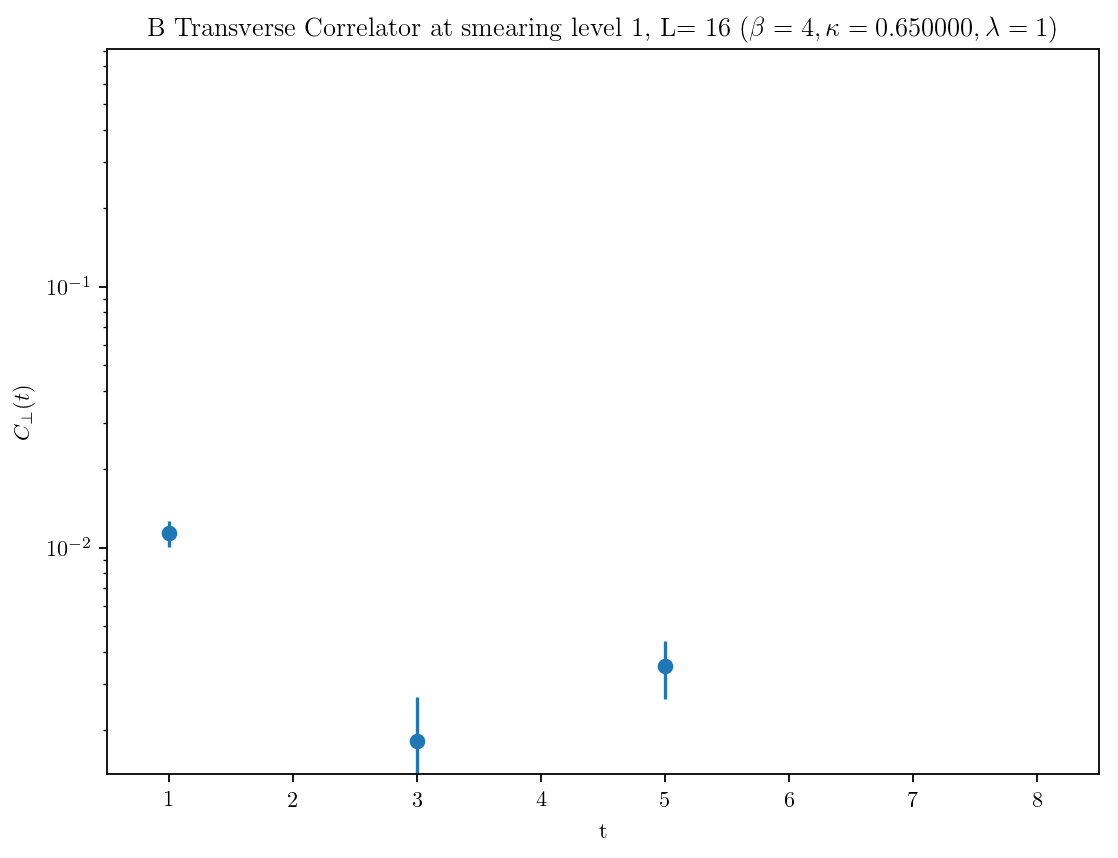

0.04882693265447643
0.04882693265447643
0.000152335377087038
0.000152335377087038
0.0005940967831506654
0.0005940967831506654
6.38383689824973e-05
6.38383689824973e-05
0.0003471412438412483
0.0003471412438412483
1.8513958692813416e-05
1.8513958692813416e-05
1.5069681981149576e-05
1.5069681981149576e-05
7.42363614090828e-06
7.42363614090828e-06
0.0001420271539935475
0.0001420271539935475
3.0590264812763125e-05
3.0590264812763125e-05
-9.030609575132583e-05
-9.030609575132583e-05
-1.8271455059924616e-05
-1.8271455059924616e-05
-0.0004527194684650502
-0.0004527194684650502
2.662400514920154e-05
2.662400514920154e-05
4.159632540531102e-05
4.159632540531102e-05
9.475094453750386e-05
9.475094453750386e-05
-3.3045043370653456e-05
-3.3045043370653456e-05
0.0001759354706766528
0.0001759354706766528
4.1596325405338274e-05
4.1596325405338274e-05
9.47509445375066e-05
9.47509445375066e-05
-0.0004527194684650445
-0.0004527194684650445
2.6624005149203127e-05
2.6624005149203127e-05
-9.03060957513195e-0

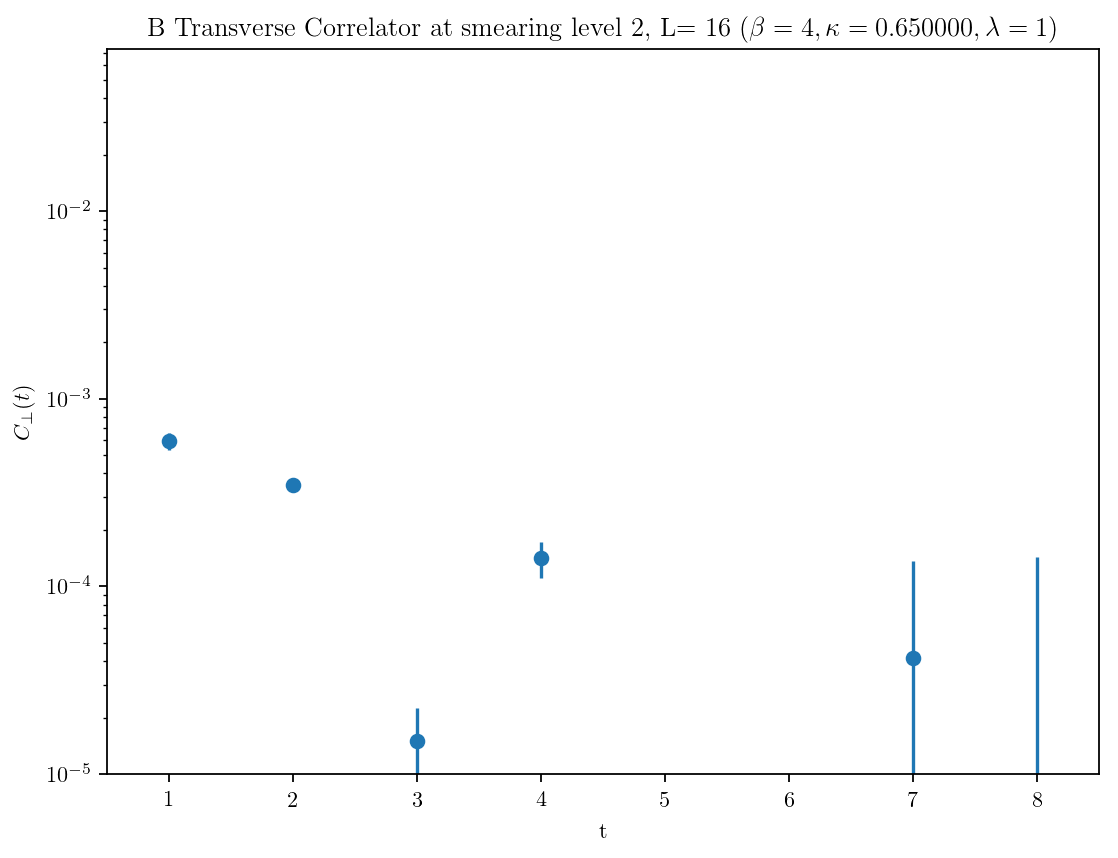

0.002261678898835946
0.002261678898835946
6.657241580604117e-06
6.657241580604117e-06
3.375959170670852e-05
3.375959170670852e-05
2.310067908802572e-06
2.310067908802572e-06
5.32199650019008e-06
5.32199650019008e-06
-1.5106948244356416e-05
-1.5106948244356416e-05
-8.37507056376714e-06
-8.37507056376714e-06
-3.5195198536984115e-06
-3.5195198536984115e-06
1.116609455361526e-06
1.116609455361526e-06
1.0824717720356683e-07
1.0824717720356683e-07
-3.0289190657414456e-06
-3.0289190657414456e-06
-5.672627375831037e-07
-5.672627375831037e-07
1.0458381916623837e-05
1.0458381916623837e-05
7.204231229089606e-08
7.204231229089606e-08
-1.5727981428802105e-05
-1.5727981428802105e-05
1.0233529291767655e-05
1.0233529291767655e-05
-1.6808228120815443e-06
-1.6808228120815443e-06
-8.736287236603406e-05
-8.736287236603406e-05
-1.572798142881293e-05
-1.572798142881293e-05
1.0233529291761983e-05
1.0233529291761983e-05
1.0458381916596564e-05
1.0458381916596564e-05
8.945732994455719e-07
8.945732994455719e-07


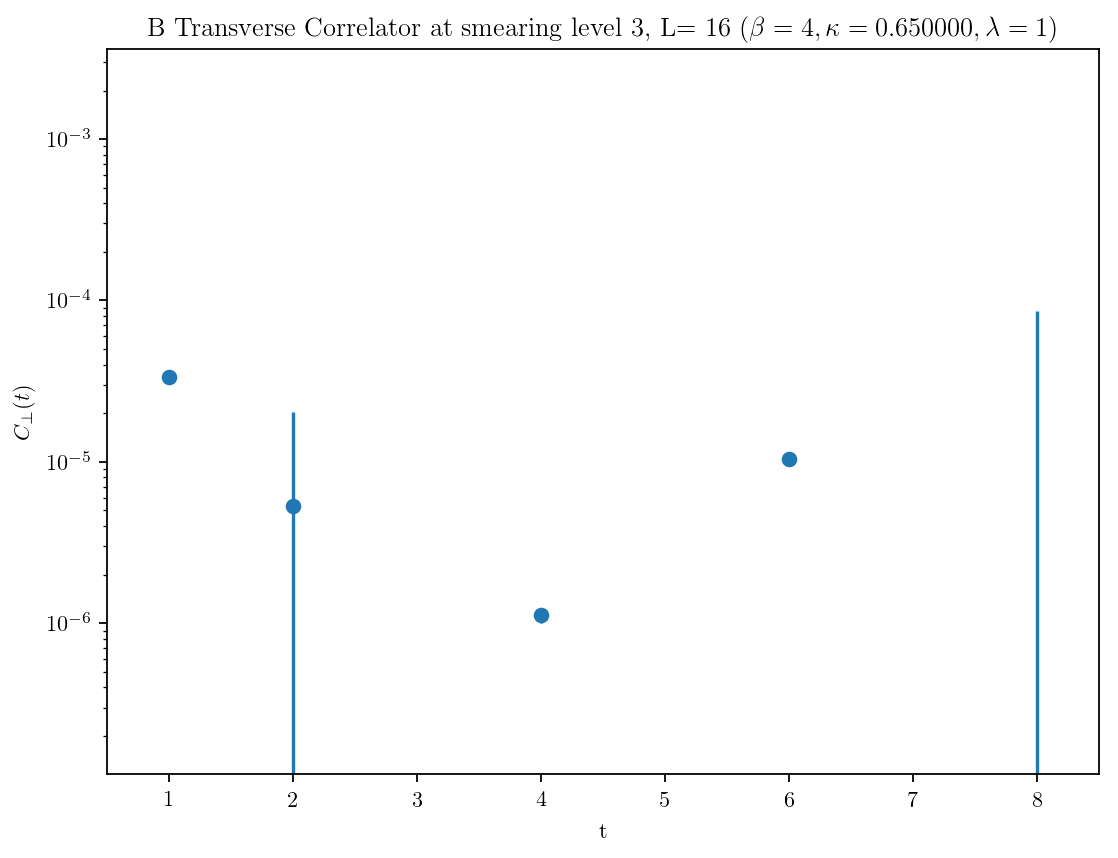

5.961430945561951e-05
5.961430945561951e-05
1.7070761483256396e-07
1.7070761483256396e-07
8.604991050075748e-08
8.604991050075748e-08
4.30348711526693e-08
4.30348711526693e-08
1.8715683380692918e-07
1.8715683380692918e-07
1.4817613555247355e-06
1.4817613555247355e-06
1.6332505718105946e-08
1.6332505718105946e-08
-1.3639459856001891e-08
-1.3639459856001891e-08
-4.028372950039639e-07
-4.028372950039639e-07
1.0824717720356683e-07
1.0824717720356683e-07
-1.9486208316945765e-07
-1.9486208316945765e-07
-3.0925203846413835e-08
-3.0925203846413835e-08
8.50661613449234e-08
8.50661613449234e-08
8.945732994469869e-07
8.945732994469869e-07
-5.385128011134648e-07
-5.385128011134648e-07
-4.521056667824548e-05
-4.521056667824548e-05
8.703353847713678e-07
8.703353847713678e-07
6.067745770648043e-06
6.067745770648043e-06
-5.385128010982336e-07
-5.385128010982336e-07
-4.521056667824427e-05
-4.521056667824427e-05
8.506616133323924e-08
8.506616133323924e-08
7.204231229130942e-08
7.204231229130942e-08
-1.9

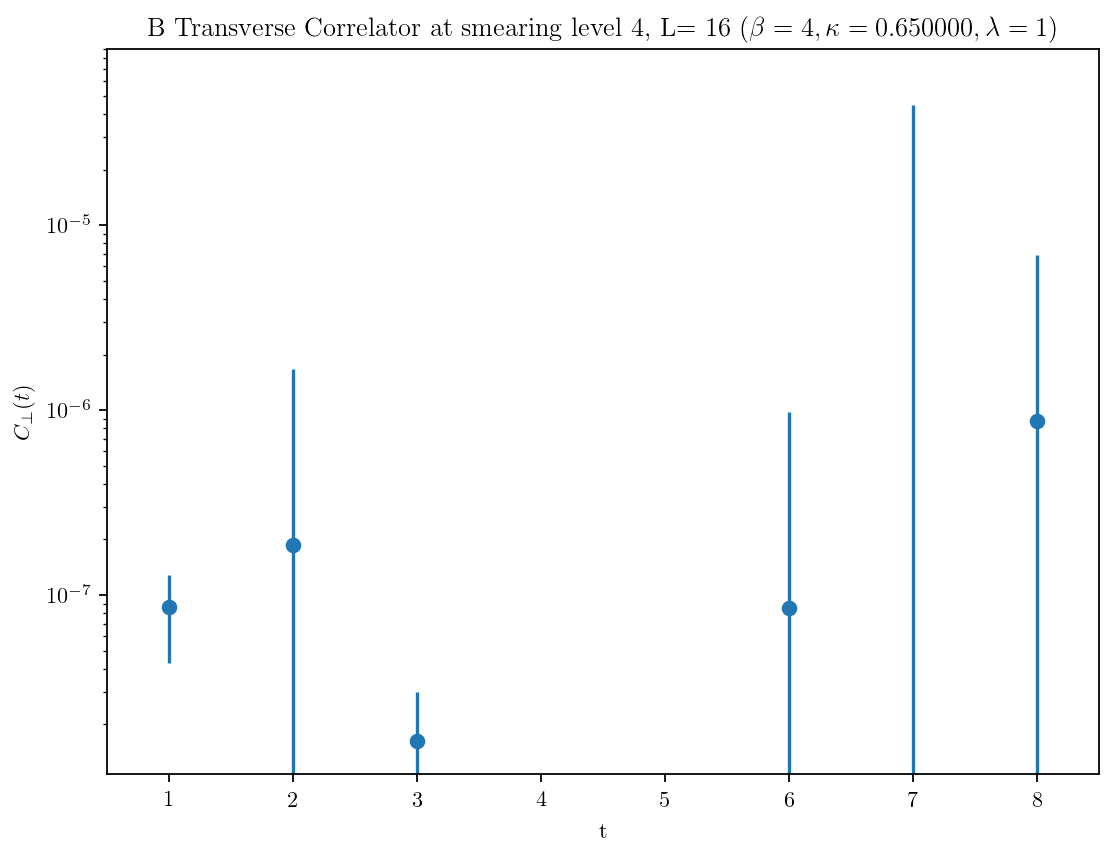

/home/vincenzo/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:295: RuntimeWarning: invalid value encountered in log


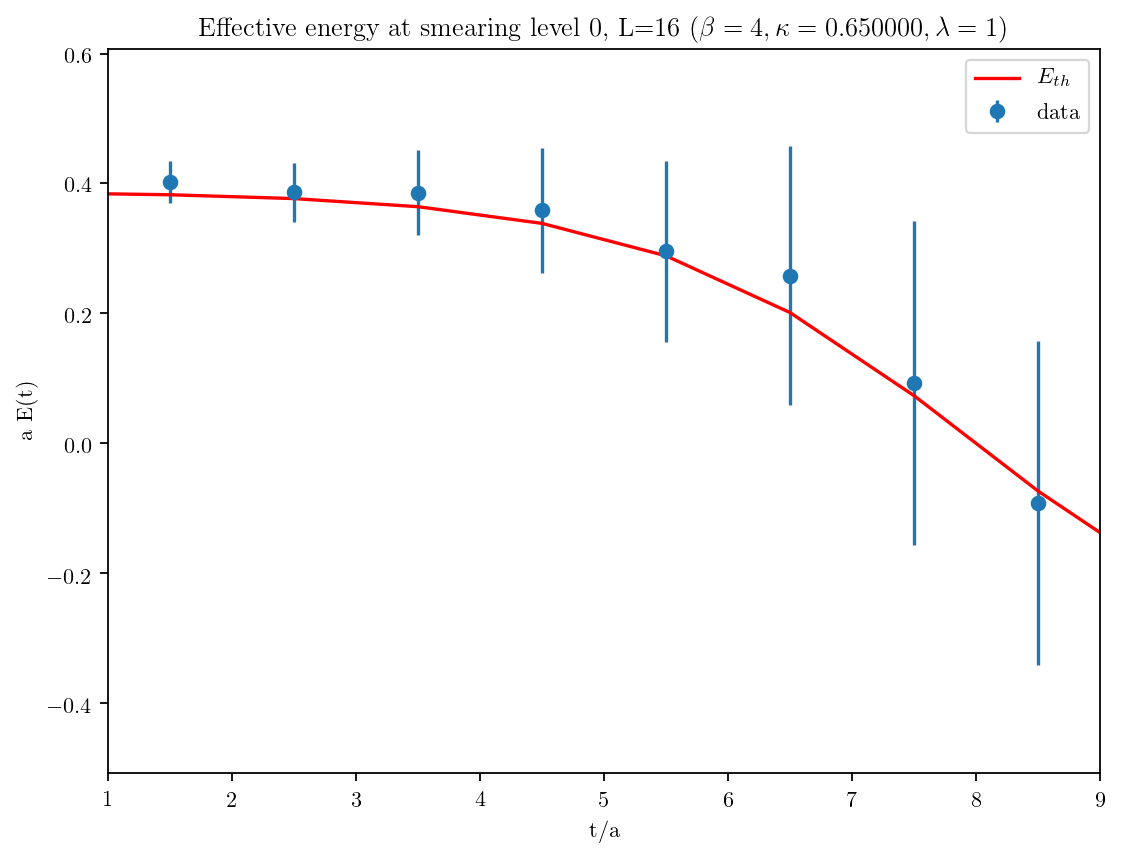

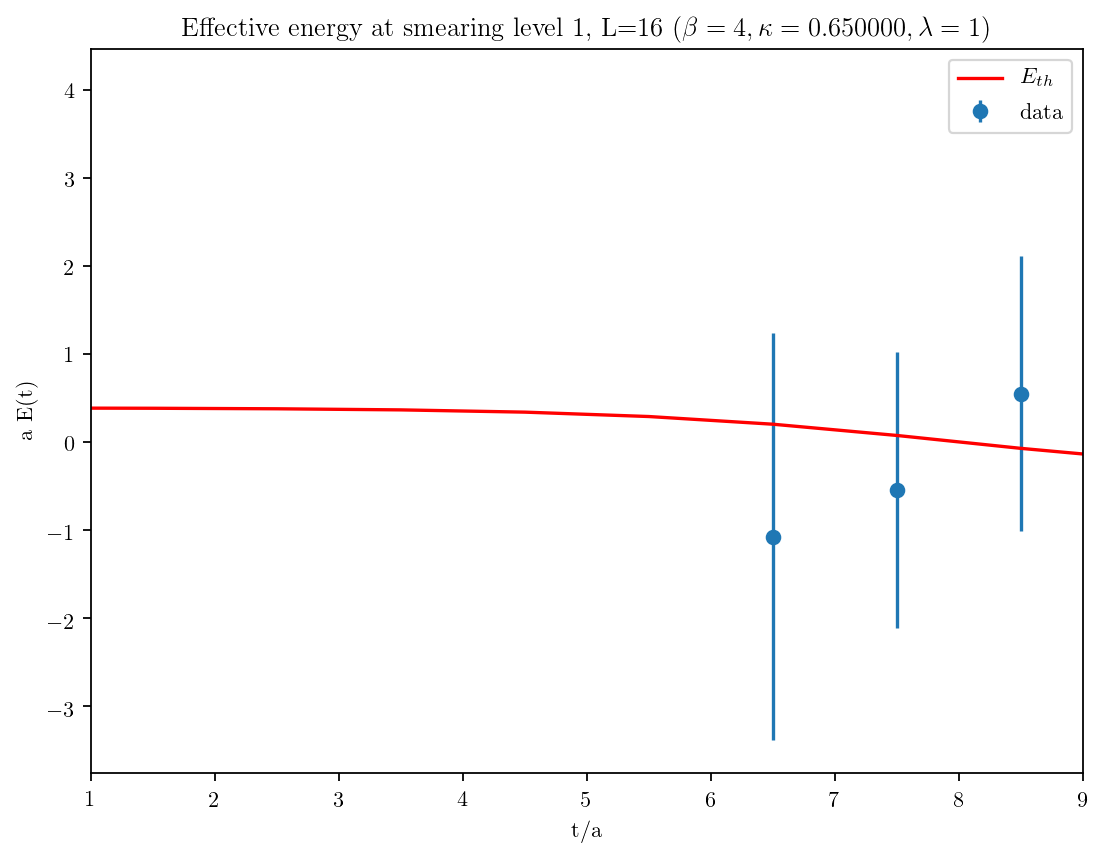

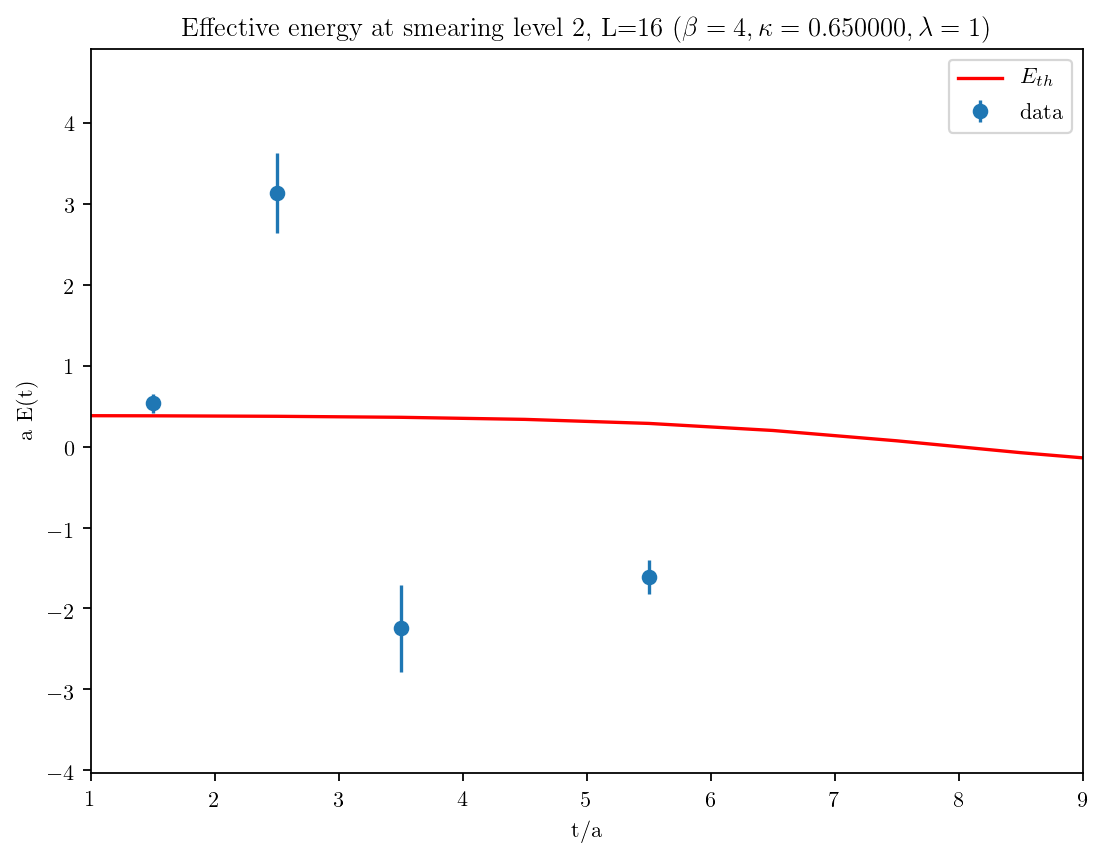

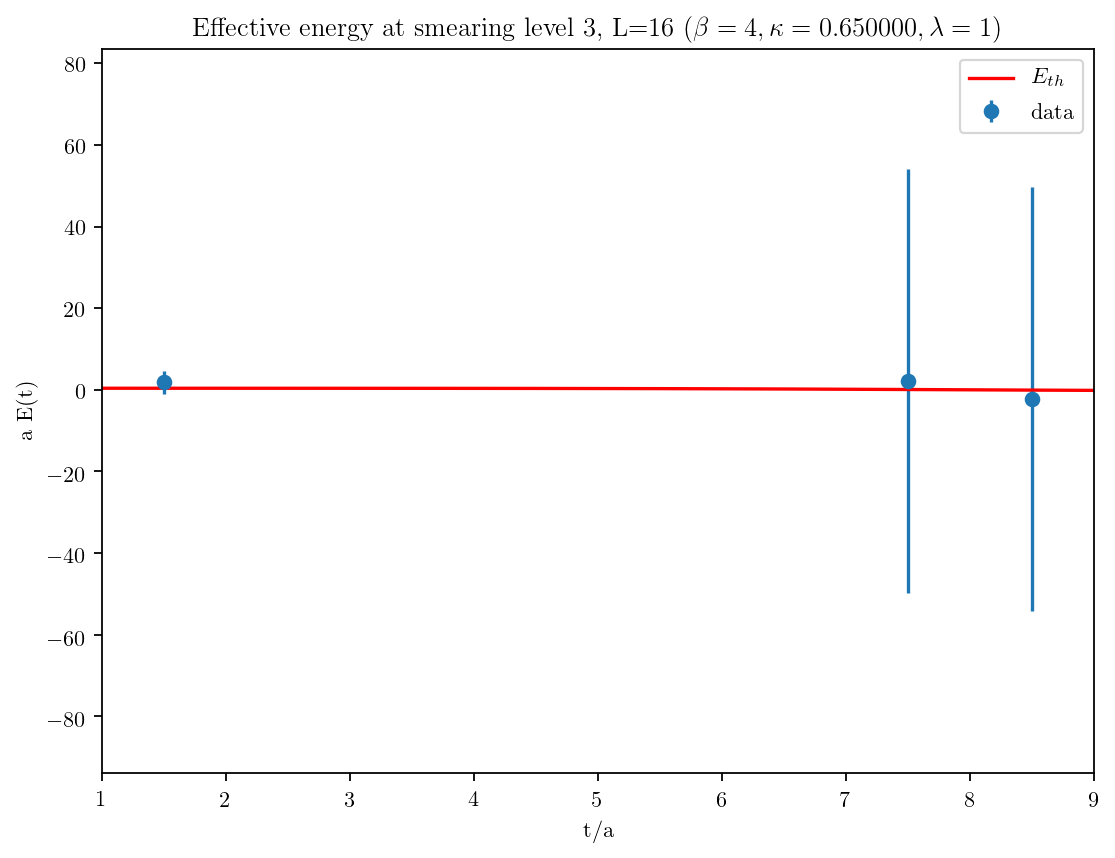

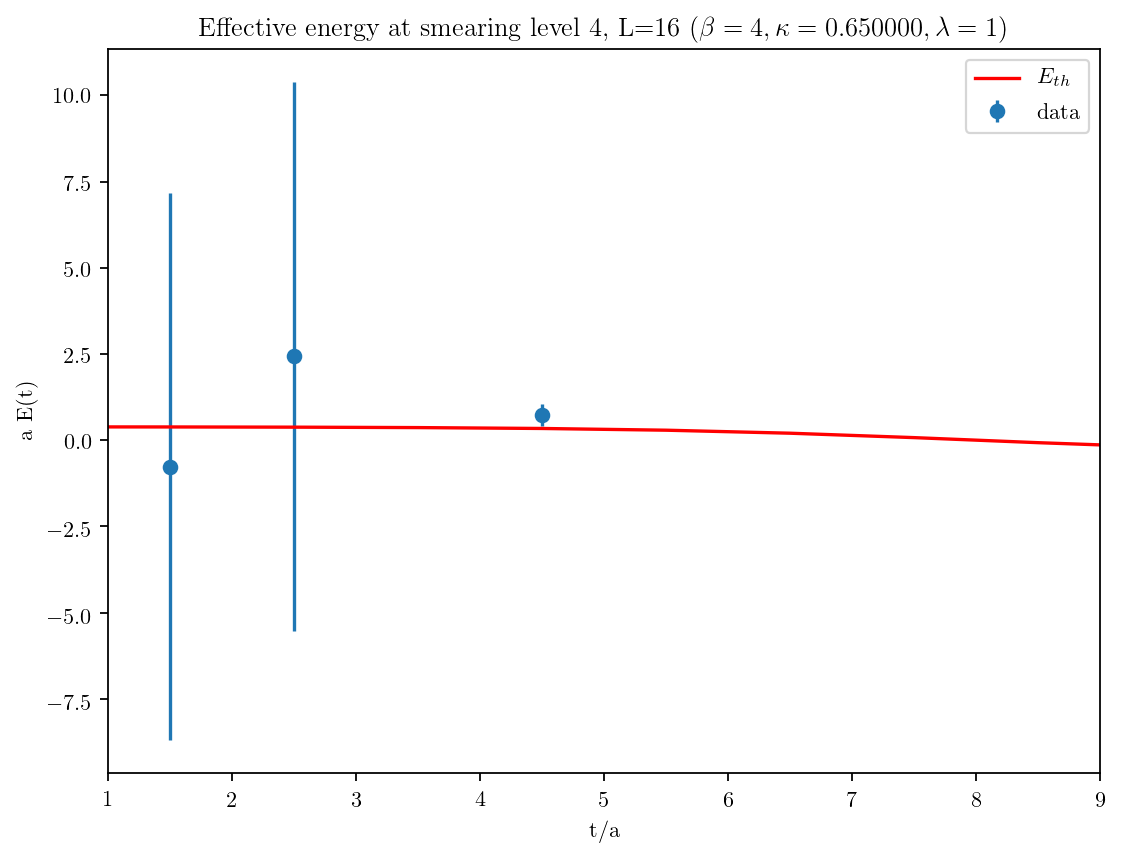

In [92]:
var_analysis_plot(0.65)